In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

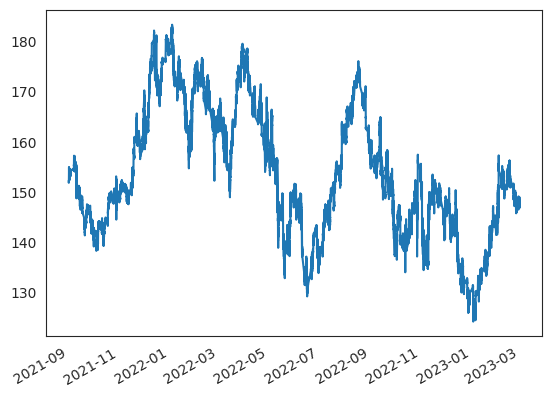

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,1,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,1,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_13388051396.1535_target.csv",
#     top_n=25,
#     spread=10.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 20, 50)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 50), 70)
    adx_thresh       = trial.suggest_float("adx_thresh", 53.0, 60.0)
    atr_mult         = trial.suggest_float("atr_mult", 0.5, 3.5, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 0.5, 3.0)
    buy_factor       = trial.suggest_float("buy_factor", 0.005, 0.03)
    sell_factor      = trial.suggest_float("sell_factor", 0.05, 0.3)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 5.0, 60.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    # "ema_3|ema_8",
                                                    # "ema_5|ema_13"
                                                    "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


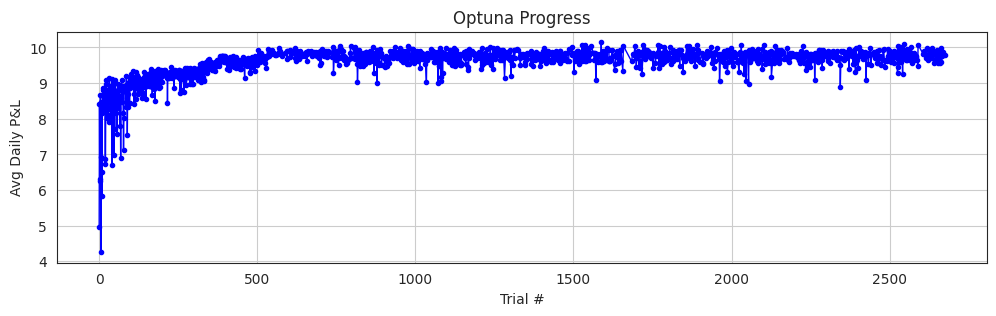

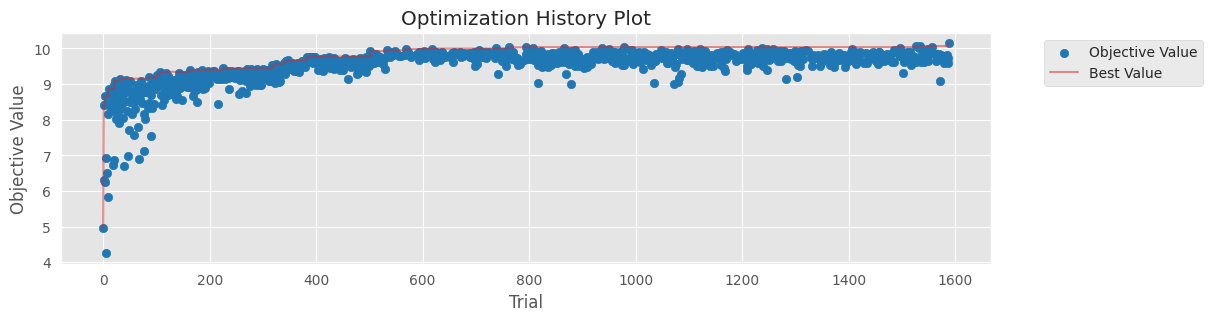

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=52; adx_thresh=53.011271447164255; atr_mult=0.8014155818291933; vwap_atr_mult=2.837720035287089; buy_factor=0.012207438700627647; sell_factor=0.1308983234412467; trailstop_pct=52.81379212675589; sign_thresh_pair=ema_9|ema_21


Trial 0: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:-3.7984 mean_bh:-8.7491 mean_excess:4.9507 improv_vs_bh:56.59%
Action counts: {'Buy': 2938, 'Sell': 5215, 'Hold': 342558}
Best trial is: 0 with best_val: 4.9507
[save_results] wrote optuna_results/AAPL_4.9507_predicted.csv
[save_best_json] wrote optuna_results/AAPL_4.9507_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=53; adx_thresh=56.47517976777429; atr_mult=2.599719982998836; vwap_atr_mult=0.5083029970876638; buy_factor=0.00592554003611906; sell_factor=0.20401898589915562; trailstop_pct=24.904276573443678; sign_thresh_pair=ema_9|ema_21


Trial 1: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:-0.3475 mean_bh:-8.7491 mean_excess:8.4016 improv_vs_bh:96.03%
Action counts: {'Buy': 2296, 'Sell': 2414, 'Hold': 346001}
Best trial is: 1 with best_val: 8.4016
[save_results] wrote optuna_results/AAPL_8.4016_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.4016_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=58; adx_thresh=58.53176342234656; atr_mult=1.4877932036557484; vwap_atr_mult=1.059000862462096; buy_factor=0.0251225091071958; sell_factor=0.23219576108089474; trailstop_pct=48.66844052414873; sign_thresh_pair=ema_9|ema_21


Trial 2: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:-2.4348 mean_bh:-8.7491 mean_excess:6.3143 improv_vs_bh:72.17%
Action counts: {'Buy': 1747, 'Sell': 2473, 'Hold': 346491}
Best trial is: 1 with best_val: 8.4016
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=63; adx_thresh=59.18981523240315; atr_mult=0.8150881261607467; vwap_atr_mult=0.7209190204243239; buy_factor=0.018341785899345778; sell_factor=0.18221125872220656; trailstop_pct=19.847077466070466; sign_thresh_pair=ema_9|ema_21


Trial 3: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:-2.4983 mean_bh:-8.7491 mean_excess:6.2508 improv_vs_bh:71.45%
Action counts: {'Buy': 1653, 'Sell': 2627, 'Hold': 346431}
Best trial is: 1 with best_val: 8.4016
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=55; adx_thresh=57.95398816039209; atr_mult=3.119465067845929; vwap_atr_mult=2.469418643760483; buy_factor=0.006786591945953286; sell_factor=0.1726793881837287; trailstop_pct=45.93197804954598; sign_thresh_pair=ema_9|ema_21


Trial 4: 100%|██████████| 375/375 [00:31<00:00, 11.79it/s]


[Results] mean_pnl:-0.0821 mean_bh:-8.7491 mean_excess:8.6670 improv_vs_bh:99.06%
Action counts: {'Buy': 1677, 'Sell': 2168, 'Hold': 346866}
Best trial is: 4 with best_val: 8.6670
[save_results] wrote optuna_results/AAPL_8.667_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.667_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=55; adx_thresh=58.14322849497368; atr_mult=2.876197486669467; vwap_atr_mult=1.0752950647076596; buy_factor=0.027628758467016238; sell_factor=0.1615240424351001; trailstop_pct=56.57097043811477; sign_thresh_pair=ema_9|ema_21


Trial 5: 100%|██████████| 375/375 [00:44<00:00,  8.43it/s]


[Results] mean_pnl:-1.8076 mean_bh:-8.7491 mean_excess:6.9415 improv_vs_bh:79.34%
Action counts: {'Buy': 1811, 'Sell': 3543, 'Hold': 345357}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=66; adx_thresh=55.376301094185095; atr_mult=1.40474439409823; vwap_atr_mult=1.2097963418720112; buy_factor=0.02964787338348588; sell_factor=0.16629220408095008; trailstop_pct=30.893041087939842; sign_thresh_pair=ema_9|ema_21


Trial 6: 100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


[Results] mean_pnl:-4.4922 mean_bh:-8.7491 mean_excess:4.2568 improv_vs_bh:48.65%
Action counts: {'Buy': 2692, 'Sell': 5102, 'Hold': 342917}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=56.77841080889632; atr_mult=3.3323776351093963; vwap_atr_mult=1.9234877307069564; buy_factor=0.013457408093345096; sell_factor=0.15493794752861334; trailstop_pct=16.00486122112327; sign_thresh_pair=ema_9|ema_21


Trial 7: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:-0.2867 mean_bh:-8.7491 mean_excess:8.4624 improv_vs_bh:96.72%
Action counts: {'Buy': 2013, 'Sell': 3417, 'Hold': 345281}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=68; adx_thresh=55.80911478485425; atr_mult=1.5926860347347764; vwap_atr_mult=1.9507459020313538; buy_factor=0.01938833408678207; sell_factor=0.18747564554426793; trailstop_pct=28.15868254731738; sign_thresh_pair=ema_9|ema_21


Trial 8: 100%|██████████| 375/375 [00:26<00:00, 14.17it/s]


[Results] mean_pnl:-2.2464 mean_bh:-8.7491 mean_excess:6.5027 improv_vs_bh:74.32%
Action counts: {'Buy': 2493, 'Sell': 3872, 'Hold': 344346}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.559205201851974; atr_mult=1.0482253508000963; vwap_atr_mult=1.0019676419154893; buy_factor=0.02129319706529034; sell_factor=0.10184437882137966; trailstop_pct=54.165723726203396; sign_thresh_pair=ema_9|ema_21


Trial 9: 100%|██████████| 375/375 [00:48<00:00,  7.76it/s]


[Results] mean_pnl:-2.9032 mean_bh:-8.7491 mean_excess:5.8459 improv_vs_bh:66.82%
Action counts: {'Buy': 2832, 'Sell': 6929, 'Hold': 340950}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=59; adx_thresh=57.687084528272194; atr_mult=2.0599606745113412; vwap_atr_mult=2.7462856451996474; buy_factor=0.005367537675108246; sell_factor=0.2912511419703857; trailstop_pct=41.540410916956176; sign_thresh_pair=ema_9|ema_21


Trial 10: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:-0.5914 mean_bh:-8.7491 mean_excess:8.1577 improv_vs_bh:93.24%
Action counts: {'Buy': 1745, 'Sell': 1444, 'Hold': 347522}
Best trial is: 4 with best_val: 8.6670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=59.92848904291265; atr_mult=3.1831501484506597; vwap_atr_mult=2.0630820604266056; buy_factor=0.011352866943064338; sell_factor=0.07397361268328947; trailstop_pct=8.307123141964269; sign_thresh_pair=ema_9|ema_21


Trial 11: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:0.1200 mean_bh:-8.7491 mean_excess:8.8691 improv_vs_bh:101.37%
Action counts: {'Buy': 1325, 'Sell': 3570, 'Hold': 345816}
Best trial is: 11 with best_val: 8.8691
[save_results] wrote optuna_results/AAPL_8.8691_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.8691_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=57; adx_thresh=59.48611596095627; atr_mult=0.5048304879552807; vwap_atr_mult=2.433884679596053; buy_factor=0.010919104323337906; sell_factor=0.058254327970575184; trailstop_pct=5.8794091646659865; sign_thresh_pair=ema_9|ema_21


Trial 12: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:0.0465 mean_bh:-8.7491 mean_excess:8.7956 improv_vs_bh:100.53%
Action counts: {'Buy': 1366, 'Sell': 4237, 'Hold': 345108}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=63; adx_thresh=59.96772058077499; atr_mult=0.5166444482844516; vwap_atr_mult=2.3002516756901623; buy_factor=0.01191909055158721; sell_factor=0.06137639498035615; trailstop_pct=5.751016843408687; sign_thresh_pair=ema_9|ema_21


Trial 13: 100%|██████████| 375/375 [00:28<00:00, 13.29it/s]


[Results] mean_pnl:-0.1064 mean_bh:-8.7491 mean_excess:8.6427 improv_vs_bh:98.78%
Action counts: {'Buy': 1354, 'Sell': 4221, 'Hold': 345136}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=59.908920288697516; atr_mult=0.5082554181478237; vwap_atr_mult=1.6228163198891052; buy_factor=0.010010657489488992; sell_factor=0.06523823337852427; trailstop_pct=5.010469343803605; sign_thresh_pair=ema_9|ema_21


Trial 14: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:0.0697 mean_bh:-8.7491 mean_excess:8.8188 improv_vs_bh:100.80%
Action counts: {'Buy': 1367, 'Sell': 3790, 'Hold': 345554}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=61; adx_thresh=59.94013154437058; atr_mult=2.258237244449927; vwap_atr_mult=1.541943507808989; buy_factor=0.015295959026699352; sell_factor=0.09709157507443555; trailstop_pct=12.760649275192677; sign_thresh_pair=ema_9|ema_21


Trial 15: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:-0.4209 mean_bh:-8.7491 mean_excess:8.3282 improv_vs_bh:95.19%
Action counts: {'Buy': 1406, 'Sell': 3521, 'Hold': 345784}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=61; adx_thresh=58.83964982597807; atr_mult=0.7145881546845828; vwap_atr_mult=1.6008572818670166; buy_factor=0.009152246783836531; sell_factor=0.0940433550294354; trailstop_pct=11.584079388942344; sign_thresh_pair=ema_9|ema_21


Trial 16: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:-0.5021 mean_bh:-8.7491 mean_excess:8.2470 improv_vs_bh:94.26%
Action counts: {'Buy': 1652, 'Sell': 3572, 'Hold': 345487}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=57.24818658959593; atr_mult=1.0540484486634165; vwap_atr_mult=2.1450605068572863; buy_factor=0.015676754243552738; sell_factor=0.12630295965938867; trailstop_pct=37.58500517476581; sign_thresh_pair=ema_9|ema_21


Trial 17: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:-0.2744 mean_bh:-8.7491 mean_excess:8.4747 improv_vs_bh:96.86%
Action counts: {'Buy': 1899, 'Sell': 3852, 'Hold': 344960}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=59.027359045120605; atr_mult=1.8569554522502536; vwap_atr_mult=1.4928898760204854; buy_factor=0.00944277171248396; sell_factor=0.0772843337675724; trailstop_pct=22.923198632565338; sign_thresh_pair=ema_9|ema_21


Trial 18: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:-0.0640 mean_bh:-8.7491 mean_excess:8.6851 improv_vs_bh:99.27%
Action counts: {'Buy': 1560, 'Sell': 3747, 'Hold': 345404}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=70; adx_thresh=53.81013965718362; atr_mult=1.1464017003412625; vwap_atr_mult=1.8404901525952722; buy_factor=0.009159323606908455; sell_factor=0.1316962794369161; trailstop_pct=11.111139716758814; sign_thresh_pair=ema_9|ema_21


Trial 19: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:-2.0206 mean_bh:-8.7491 mean_excess:6.7284 improv_vs_bh:76.90%
Action counts: {'Buy': 3287, 'Sell': 5417, 'Hold': 342007}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=63; adx_thresh=58.393369194505006; atr_mult=0.6415524929632004; vwap_atr_mult=1.3595367064119646; buy_factor=0.014945795275731165; sell_factor=0.23309069335753757; trailstop_pct=17.256672665569937; sign_thresh_pair=ema_9|ema_21


Trial 20: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:-1.8691 mean_bh:-8.7491 mean_excess:6.8800 improv_vs_bh:78.64%
Action counts: {'Buy': 1802, 'Sell': 2280, 'Hold': 346629}
Best trial is: 11 with best_val: 8.8691
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=59.616580233235965; atr_mult=0.5093691499079164; vwap_atr_mult=2.4610818795182685; buy_factor=0.010701981015741395; sell_factor=0.05462930702163367; trailstop_pct=5.12375040546364; sign_thresh_pair=ema_9|ema_21


Trial 21: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:0.2398 mean_bh:-8.7491 mean_excess:8.9889 improv_vs_bh:102.74%
Action counts: {'Buy': 1358, 'Sell': 4362, 'Hold': 344991}
Best trial is: 21 with best_val: 8.9889
[save_results] wrote optuna_results/AAPL_8.9889_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.9889_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=59.50249245398612; atr_mult=0.6214321095888062; vwap_atr_mult=2.161957956281501; buy_factor=0.00789425620026538; sell_factor=0.05330728070376896; trailstop_pct=6.185143988421041; sign_thresh_pair=ema_9|ema_21


Trial 22: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:0.3384 mean_bh:-8.7491 mean_excess:9.0875 improv_vs_bh:103.87%
Action counts: {'Buy': 1386, 'Sell': 3969, 'Hold': 345356}
Best trial is: 22 with best_val: 9.0875
[save_results] wrote optuna_results/AAPL_9.0875_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.0875_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=59.32080053046601; atr_mult=0.621729194572808; vwap_atr_mult=2.6652840293265303; buy_factor=0.007605920595840614; sell_factor=0.05022343294684979; trailstop_pct=9.63107501972252; sign_thresh_pair=ema_9|ema_21


Trial 23: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:-0.1777 mean_bh:-8.7491 mean_excess:8.5714 improv_vs_bh:97.97%
Action counts: {'Buy': 1416, 'Sell': 4179, 'Hold': 345116}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=59.472897093868994; atr_mult=0.8948325532670515; vwap_atr_mult=2.094452871497902; buy_factor=0.013043596723691217; sell_factor=0.08355707095292975; trailstop_pct=15.39339749605803; sign_thresh_pair=ema_9|ema_21


Trial 24: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:-0.4207 mean_bh:-8.7491 mean_excess:8.3283 improv_vs_bh:95.19%
Action counts: {'Buy': 1401, 'Sell': 3685, 'Hold': 345625}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=57.579632666892024; atr_mult=0.6087117831690102; vwap_atr_mult=2.995407388622434; buy_factor=0.00765270234357221; sell_factor=0.11283948045747323; trailstop_pct=8.87728818571792; sign_thresh_pair=ema_9|ema_21


Trial 25: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:-0.7234 mean_bh:-8.7491 mean_excess:8.0257 improv_vs_bh:91.73%
Action counts: {'Buy': 1678, 'Sell': 2982, 'Hold': 346051}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=60; adx_thresh=58.8025535769702; atr_mult=1.763033279861485; vwap_atr_mult=2.246219535986784; buy_factor=0.008189164742647683; sell_factor=0.07870590548680904; trailstop_pct=18.51769723824559; sign_thresh_pair=ema_9|ema_21


Trial 26: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:0.0565 mean_bh:-8.7491 mean_excess:8.8056 improv_vs_bh:100.65%
Action counts: {'Buy': 1578, 'Sell': 3698, 'Hold': 345435}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=59.5173507670846; atr_mult=1.2270276068399997; vwap_atr_mult=2.4761020021666864; buy_factor=0.02166048711449981; sell_factor=0.07232949663984956; trailstop_pct=35.442436080538684; sign_thresh_pair=ema_9|ema_21


Trial 27: 100%|██████████| 375/375 [00:31<00:00, 12.07it/s]


[Results] mean_pnl:-0.2597 mean_bh:-8.7491 mean_excess:8.4894 improv_vs_bh:97.03%
Action counts: {'Buy': 1377, 'Sell': 4664, 'Hold': 344670}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=55; adx_thresh=58.52754813377585; atr_mult=0.8862875030716161; vwap_atr_mult=2.6120427274538116; buy_factor=0.016716129650222004; sell_factor=0.05132348614881532; trailstop_pct=21.635946143440556; sign_thresh_pair=ema_9|ema_21


Trial 28: 100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


[Results] mean_pnl:-0.6301 mean_bh:-8.7491 mean_excess:8.1190 improv_vs_bh:92.80%
Action counts: {'Buy': 1545, 'Sell': 5815, 'Hold': 343351}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=56.9985200788042; atr_mult=0.7315122352151826; vwap_atr_mult=2.0810774473239793; buy_factor=0.013755700779094781; sell_factor=0.12072741173230757; trailstop_pct=14.592320755499424; sign_thresh_pair=ema_9|ema_21


Trial 29: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:-0.4712 mean_bh:-8.7491 mean_excess:8.2779 improv_vs_bh:94.61%
Action counts: {'Buy': 1933, 'Sell': 3946, 'Hold': 344832}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=58.9641397728279; atr_mult=0.5773624523566121; vwap_atr_mult=1.7509968819343977; buy_factor=0.011690560785417586; sell_factor=0.14320436586904922; trailstop_pct=8.726932286097089; sign_thresh_pair=ema_9|ema_21


Trial 30: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:-0.8442 mean_bh:-8.7491 mean_excess:7.9049 improv_vs_bh:90.35%
Action counts: {'Buy': 1619, 'Sell': 2762, 'Hold': 346330}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=57; adx_thresh=59.973039154676044; atr_mult=0.5372142891636865; vwap_atr_mult=1.6995449958934739; buy_factor=0.010267446712087794; sell_factor=0.06599758856966222; trailstop_pct=6.6453710927454175; sign_thresh_pair=ema_9|ema_21


Trial 31: 100%|██████████| 375/375 [00:27<00:00, 13.79it/s]


[Results] mean_pnl:0.0730 mean_bh:-8.7491 mean_excess:8.8221 improv_vs_bh:100.83%
Action counts: {'Buy': 1348, 'Sell': 3759, 'Hold': 345604}
Best trial is: 22 with best_val: 9.0875
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=59.67181019747431; atr_mult=0.6792775292591221; vwap_atr_mult=2.2980487470770905; buy_factor=0.0050957476594399925; sell_factor=0.08861049602825681; trailstop_pct=8.218013614470795; sign_thresh_pair=ema_9|ema_21


Trial 32: 100%|██████████| 375/375 [00:26<00:00, 13.97it/s]


[Results] mean_pnl:0.4023 mean_bh:-8.7491 mean_excess:9.1514 improv_vs_bh:104.60%
Action counts: {'Buy': 1359, 'Sell': 2554, 'Hold': 346798}
Best trial is: 32 with best_val: 9.1514
[save_results] wrote optuna_results/AAPL_9.1514_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.1514_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=59.30959154125057; atr_mult=0.7120855521124664; vwap_atr_mult=2.304010948770657; buy_factor=0.005488444477519813; sell_factor=0.08828016397958145; trailstop_pct=12.916656442035192; sign_thresh_pair=ema_9|ema_21


Trial 33: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:0.1049 mean_bh:-8.7491 mean_excess:8.8540 improv_vs_bh:101.20%
Action counts: {'Buy': 1446, 'Sell': 2812, 'Hold': 346453}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=59.675923592181576; atr_mult=0.803822153307856; vwap_atr_mult=1.9948995084272223; buy_factor=0.0068724179210636165; sell_factor=0.10553223244377807; trailstop_pct=26.321437748970148; sign_thresh_pair=ema_9|ema_21


Trial 34: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:0.1837 mean_bh:-8.7491 mean_excess:8.9328 improv_vs_bh:102.10%
Action counts: {'Buy': 1392, 'Sell': 2559, 'Hold': 346760}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=65; adx_thresh=58.26213944054626; atr_mult=0.8120474777465148; vwap_atr_mult=2.405832112908488; buy_factor=0.00673076527429432; sell_factor=0.11207600931615172; trailstop_pct=26.94988828308631; sign_thresh_pair=ema_9|ema_21


Trial 35: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:-0.3142 mean_bh:-8.7491 mean_excess:8.4349 improv_vs_bh:96.41%
Action counts: {'Buy': 1750, 'Sell': 3016, 'Hold': 345945}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=58.69786978340562; atr_mult=0.6734022542364695; vwap_atr_mult=2.8767385015888944; buy_factor=0.005121735196973839; sell_factor=0.10303646542849478; trailstop_pct=49.82160771807935; sign_thresh_pair=ema_9|ema_21


Trial 36: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:-0.1047 mean_bh:-8.7491 mean_excess:8.6444 improv_vs_bh:98.80%
Action counts: {'Buy': 1519, 'Sell': 2597, 'Hold': 346595}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=56.24693276432662; atr_mult=0.902789426643916; vwap_atr_mult=2.611137769858334; buy_factor=0.006509937432520093; sell_factor=0.21508866039568453; trailstop_pct=19.73666187493092; sign_thresh_pair=ema_9|ema_21


Trial 37: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:-0.6891 mean_bh:-8.7491 mean_excess:8.0600 improv_vs_bh:92.12%
Action counts: {'Buy': 2053, 'Sell': 2148, 'Hold': 346510}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=57.90887316219868; atr_mult=0.5695760470860972; vwap_atr_mult=1.9442617294815787; buy_factor=0.007868487871258817; sell_factor=0.13653567838769873; trailstop_pct=32.374351480838335; sign_thresh_pair=ema_9|ema_21


Trial 38: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:-0.2257 mean_bh:-8.7491 mean_excess:8.5234 improv_vs_bh:97.42%
Action counts: {'Buy': 1752, 'Sell': 2759, 'Hold': 346200}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=59.62311929354338; atr_mult=0.775328768900227; vwap_atr_mult=2.303431366040402; buy_factor=0.006573832968226989; sell_factor=0.15039253247889156; trailstop_pct=23.882457145141498; sign_thresh_pair=ema_9|ema_21


Trial 39: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:-0.0044 mean_bh:-8.7491 mean_excess:8.7447 improv_vs_bh:99.95%
Action counts: {'Buy': 1366, 'Sell': 1982, 'Hold': 347363}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=61; adx_thresh=53.13740451833862; atr_mult=0.661511874747198; vwap_atr_mult=2.5487028549522623; buy_factor=0.00873246349915064; sell_factor=0.09077069081654839; trailstop_pct=40.52032207153405; sign_thresh_pair=ema_9|ema_21


Trial 40: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:-2.0455 mean_bh:-8.7491 mean_excess:6.7036 improv_vs_bh:76.62%
Action counts: {'Buy': 3201, 'Sell': 6740, 'Hold': 340770}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=56; adx_thresh=59.12956619816601; atr_mult=2.5923500927991845; vwap_atr_mult=2.152083540561017; buy_factor=0.010593466470018194; sell_factor=0.07451801886127961; trailstop_pct=10.065004468309377; sign_thresh_pair=ema_9|ema_21


Trial 41: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:0.1185 mean_bh:-8.7491 mean_excess:8.8675 improv_vs_bh:101.35%
Action counts: {'Buy': 1482, 'Sell': 3913, 'Hold': 345316}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=59.668330569968276; atr_mult=0.9883401520458065; vwap_atr_mult=2.0275463848352695; buy_factor=0.011502509206402771; sell_factor=0.05158789246094168; trailstop_pct=7.903160362998983; sign_thresh_pair=ema_9|ema_21


Trial 42: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:0.3692 mean_bh:-8.7491 mean_excess:9.1183 improv_vs_bh:104.22%
Action counts: {'Buy': 1368, 'Sell': 4585, 'Hold': 344758}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=56; adx_thresh=59.685830224276906; atr_mult=0.9432730180653371; vwap_atr_mult=2.2102453550567573; buy_factor=0.012973041302724865; sell_factor=0.0520984870679317; trailstop_pct=14.21185984003838; sign_thresh_pair=ema_9|ema_21


Trial 43: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:0.2939 mean_bh:-8.7491 mean_excess:9.0430 improv_vs_bh:103.36%
Action counts: {'Buy': 1347, 'Sell': 4719, 'Hold': 344645}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=54; adx_thresh=59.188630855130135; atr_mult=1.0187711816978318; vwap_atr_mult=2.2243077686256623; buy_factor=0.014065696765547375; sell_factor=0.050013849613556066; trailstop_pct=7.430769416095425; sign_thresh_pair=ema_9|ema_21


Trial 44: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:0.1667 mean_bh:-8.7491 mean_excess:8.9158 improv_vs_bh:101.91%
Action counts: {'Buy': 1441, 'Sell': 5245, 'Hold': 344025}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=56; adx_thresh=55.17107020721879; atr_mult=0.974790295820434; vwap_atr_mult=2.3868868516074517; buy_factor=0.012512240687075788; sell_factor=0.061616621660791765; trailstop_pct=13.894818094779364; sign_thresh_pair=ema_9|ema_21


Trial 45: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s]


[Results] mean_pnl:-0.5002 mean_bh:-8.7491 mean_excess:8.2489 improv_vs_bh:94.28%
Action counts: {'Buy': 2404, 'Sell': 7344, 'Hold': 340963}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=59.648900307165604; atr_mult=1.329340367815461; vwap_atr_mult=1.824535251093928; buy_factor=0.01682978159328653; sell_factor=0.06380745213022701; trailstop_pct=5.009233933568575; sign_thresh_pair=ema_9|ema_21


Trial 46: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:0.2814 mean_bh:-8.7491 mean_excess:9.0305 improv_vs_bh:103.22%
Action counts: {'Buy': 1379, 'Sell': 4636, 'Hold': 344696}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=58.59736901395645; atr_mult=1.3299302646907447; vwap_atr_mult=1.7868975041034814; buy_factor=0.018118344332959814; sell_factor=0.28609204945659095; trailstop_pct=11.078674199223599; sign_thresh_pair=ema_9|ema_21


Trial 47: 100%|██████████| 375/375 [00:26<00:00, 13.96it/s]


[Results] mean_pnl:-1.7588 mean_bh:-8.7491 mean_excess:6.9903 improv_vs_bh:79.90%
Action counts: {'Buy': 1619, 'Sell': 1765, 'Hold': 347327}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=58.21179387193274; atr_mult=1.5157306808299034; vwap_atr_mult=1.862411098315814; buy_factor=0.020160104335135008; sell_factor=0.06638455384117323; trailstop_pct=16.373365806363715; sign_thresh_pair=ema_9|ema_21


Trial 48: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:-0.2274 mean_bh:-8.7491 mean_excess:8.5217 improv_vs_bh:97.40%
Action counts: {'Buy': 1700, 'Sell': 5839, 'Hold': 343172}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=59.714035576793066; atr_mult=1.1399166610576834; vwap_atr_mult=0.6997438853876323; buy_factor=0.025178219087723303; sell_factor=0.08378973637776413; trailstop_pct=7.850889021778151; sign_thresh_pair=ema_9|ema_21


Trial 49: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


[Results] mean_pnl:-1.0251 mean_bh:-8.7491 mean_excess:7.7240 improv_vs_bh:88.28%
Action counts: {'Buy': 1466, 'Sell': 4485, 'Hold': 344760}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=54; adx_thresh=59.075667806561896; atr_mult=1.3927824926910477; vwap_atr_mult=2.017593856323373; buy_factor=0.016348465283447973; sell_factor=0.06565472975030337; trailstop_pct=11.707581532228112; sign_thresh_pair=ema_9|ema_21


Trial 50: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:-0.2433 mean_bh:-8.7491 mean_excess:8.5058 improv_vs_bh:97.22%
Action counts: {'Buy': 1496, 'Sell': 4904, 'Hold': 344311}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=59.57340412696889; atr_mult=1.248153607932001; vwap_atr_mult=2.1930000299837458; buy_factor=0.011317698231470589; sell_factor=0.05594951886209816; trailstop_pct=5.1551713507920125; sign_thresh_pair=ema_9|ema_21


Trial 51: 100%|██████████| 375/375 [00:27<00:00, 13.75it/s]


[Results] mean_pnl:0.3515 mean_bh:-8.7491 mean_excess:9.1006 improv_vs_bh:104.02%
Action counts: {'Buy': 1369, 'Sell': 4364, 'Hold': 344978}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=59.305498499960926; atr_mult=1.2251573634627102; vwap_atr_mult=2.1848304169041852; buy_factor=0.012492060435931669; sell_factor=0.06005521872075603; trailstop_pct=5.141676690612837; sign_thresh_pair=ema_9|ema_21


Trial 52: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:-0.0108 mean_bh:-8.7491 mean_excess:8.7383 improv_vs_bh:99.88%
Action counts: {'Buy': 1430, 'Sell': 4533, 'Hold': 344748}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=59.78405756486475; atr_mult=1.6460637489721863; vwap_atr_mult=2.3357189982829065; buy_factor=0.014061623278512013; sell_factor=0.0703413097293088; trailstop_pct=7.695608150996883; sign_thresh_pair=ema_9|ema_21


Trial 53: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:0.0251 mean_bh:-8.7491 mean_excess:8.7742 improv_vs_bh:100.29%
Action counts: {'Buy': 1310, 'Sell': 3949, 'Hold': 345452}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=58.84448586519621; atr_mult=0.9565864238581815; vwap_atr_mult=1.9572654614161884; buy_factor=0.017310038110588153; sell_factor=0.08167247552702164; trailstop_pct=9.431127744229304; sign_thresh_pair=ema_9|ema_21


Trial 54: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:-0.5993 mean_bh:-8.7491 mean_excess:8.1498 improv_vs_bh:93.15%
Action counts: {'Buy': 1552, 'Sell': 4516, 'Hold': 344643}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=59.45171819544353; atr_mult=1.1978184906783216; vwap_atr_mult=1.8794806055931805; buy_factor=0.01482951322422961; sell_factor=0.058789138867706175; trailstop_pct=58.81882544465093; sign_thresh_pair=ema_9|ema_21


Trial 55: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:0.0272 mean_bh:-8.7491 mean_excess:8.7763 improv_vs_bh:100.31%
Action counts: {'Buy': 1425, 'Sell': 4816, 'Hold': 344470}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=57; adx_thresh=59.96587154042894; atr_mult=1.051223980148913; vwap_atr_mult=1.6739959999277896; buy_factor=0.011492226276682168; sell_factor=0.09201664545286067; trailstop_pct=13.508899883495573; sign_thresh_pair=ema_9|ema_21


Trial 56: 100%|██████████| 375/375 [00:36<00:00, 10.28it/s]


[Results] mean_pnl:-0.0106 mean_bh:-8.7491 mean_excess:8.7385 improv_vs_bh:99.88%
Action counts: {'Buy': 1352, 'Sell': 3154, 'Hold': 346205}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=59.10376072447791; atr_mult=1.3047729325827904; vwap_atr_mult=1.4164134827981503; buy_factor=0.009849392698540837; sell_factor=0.27177663822872433; trailstop_pct=6.85107197271482; sign_thresh_pair=ema_9|ema_21


Trial 57: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s]


[Results] mean_pnl:-1.1703 mean_bh:-8.7491 mean_excess:7.5788 improv_vs_bh:86.62%
Action counts: {'Buy': 1551, 'Sell': 1581, 'Hold': 347579}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=59.74647201796393; atr_mult=1.1377972540913988; vwap_atr_mult=2.0856961285145608; buy_factor=0.019706515397933888; sell_factor=0.0754078179168399; trailstop_pct=10.246391391644893; sign_thresh_pair=ema_9|ema_21


Trial 58: 100%|██████████| 375/375 [00:29<00:00, 12.64it/s]


[Results] mean_pnl:-0.2622 mean_bh:-8.7491 mean_excess:8.4869 improv_vs_bh:97.00%
Action counts: {'Buy': 1366, 'Sell': 4391, 'Hold': 344954}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=58.00045589527994; atr_mult=1.4725736654229362; vwap_atr_mult=2.1644748790561366; buy_factor=0.008378469264601684; sell_factor=0.18936008091420473; trailstop_pct=12.165835044079262; sign_thresh_pair=ema_9|ema_21


Trial 59: 100%|██████████| 375/375 [00:33<00:00, 11.19it/s]


[Results] mean_pnl:-0.4402 mean_bh:-8.7491 mean_excess:8.3089 improv_vs_bh:94.97%
Action counts: {'Buy': 1714, 'Sell': 2214, 'Hold': 346783}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=59.404393802008336; atr_mult=0.763510455105432; vwap_atr_mult=2.237622561691638; buy_factor=0.012813290468231882; sell_factor=0.056280310527649806; trailstop_pct=17.04533597023142; sign_thresh_pair=ema_9|ema_21


Trial 60: 100%|██████████| 375/375 [00:45<00:00,  8.29it/s]


[Results] mean_pnl:0.0615 mean_bh:-8.7491 mean_excess:8.8106 improv_vs_bh:100.70%
Action counts: {'Buy': 1373, 'Sell': 4536, 'Hold': 344802}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=59.744214023192605; atr_mult=0.549726793971666; vwap_atr_mult=2.4978881503002865; buy_factor=0.010849999560396185; sell_factor=0.050043708394875944; trailstop_pct=5.202573037987828; sign_thresh_pair=ema_9|ema_21


Trial 61: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:0.2342 mean_bh:-8.7491 mean_excess:8.9833 improv_vs_bh:102.68%
Action counts: {'Buy': 1331, 'Sell': 4480, 'Hold': 344900}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=59.550428932737304; atr_mult=0.6112779907498476; vwap_atr_mult=2.376721284561713; buy_factor=0.009750661067333305; sell_factor=0.06903133179401386; trailstop_pct=6.937277812244315; sign_thresh_pair=ema_9|ema_21


Trial 62: 100%|██████████| 375/375 [00:32<00:00, 11.48it/s]


[Results] mean_pnl:0.1164 mean_bh:-8.7491 mean_excess:8.8654 improv_vs_bh:101.33%
Action counts: {'Buy': 1363, 'Sell': 3665, 'Hold': 345683}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=58.84077325766755; atr_mult=0.8501221833829095; vwap_atr_mult=2.060238044634832; buy_factor=0.011054267090950622; sell_factor=0.0569082673796972; trailstop_pct=8.911533627701484; sign_thresh_pair=ema_9|ema_21


Trial 63: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:-0.1243 mean_bh:-8.7491 mean_excess:8.6248 improv_vs_bh:98.58%
Action counts: {'Buy': 1542, 'Sell': 4785, 'Hold': 344384}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=59.28667931931741; atr_mult=0.5084054957897711; vwap_atr_mult=2.2607435607502104; buy_factor=0.0059247762212422655; sell_factor=0.07965711423560687; trailstop_pct=5.550410991331917; sign_thresh_pair=ema_9|ema_21


Trial 64: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


[Results] mean_pnl:0.0449 mean_bh:-8.7491 mean_excess:8.7940 improv_vs_bh:100.51%
Action counts: {'Buy': 1456, 'Sell': 3054, 'Hold': 346201}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=58.4735356432193; atr_mult=0.688957668806406; vwap_atr_mult=2.4933118967708; buy_factor=0.02256865869207143; sell_factor=0.05573339704687208; trailstop_pct=5.008595594580483; sign_thresh_pair=ema_9|ema_21


Trial 65: 100%|██████████| 375/375 [00:32<00:00, 11.38it/s]


[Results] mean_pnl:-0.9486 mean_bh:-8.7491 mean_excess:7.8005 improv_vs_bh:89.16%
Action counts: {'Buy': 1581, 'Sell': 6293, 'Hold': 342837}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=60; adx_thresh=59.50024781782015; atr_mult=0.9711612077464219; vwap_atr_mult=1.8085380142360257; buy_factor=0.009074006821803458; sell_factor=0.09894651589355505; trailstop_pct=10.365331395732664; sign_thresh_pair=ema_9|ema_21


Trial 66: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


[Results] mean_pnl:-0.1919 mean_bh:-8.7491 mean_excess:8.5572 improv_vs_bh:97.81%
Action counts: {'Buy': 1454, 'Sell': 3112, 'Hold': 346145}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=59.98405518467268; atr_mult=0.5808882282615021; vwap_atr_mult=2.1334053906829387; buy_factor=0.011958273532975698; sell_factor=0.06993231430496462; trailstop_pct=8.1161374486295; sign_thresh_pair=ema_9|ema_21


Trial 67: 100%|██████████| 375/375 [00:28<00:00, 13.23it/s]


[Results] mean_pnl:-0.1261 mean_bh:-8.7491 mean_excess:8.6230 improv_vs_bh:98.56%
Action counts: {'Buy': 1315, 'Sell': 3759, 'Hold': 345637}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=58.988300992035185; atr_mult=1.2969879042929262; vwap_atr_mult=2.7965468969893084; buy_factor=0.029807181914392827; sell_factor=0.08624840669501804; trailstop_pct=14.737025102498947; sign_thresh_pair=ema_9|ema_21


Trial 68: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s]


[Results] mean_pnl:-1.8370 mean_bh:-8.7491 mean_excess:6.9121 improv_vs_bh:79.00%
Action counts: {'Buy': 1463, 'Sell': 4750, 'Hold': 344498}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=59.73482656393964; atr_mult=0.6407784876340553; vwap_atr_mult=2.66961158030073; buy_factor=0.007377870615033873; sell_factor=0.06445183447614616; trailstop_pct=6.6373114122507015; sign_thresh_pair=ema_9|ema_21


Trial 69: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:-0.1530 mean_bh:-8.7491 mean_excess:8.5961 improv_vs_bh:98.25%
Action counts: {'Buy': 1333, 'Sell': 3433, 'Hold': 345945}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=59.28811091015613; atr_mult=1.108196247082662; vwap_atr_mult=2.0005369679566614; buy_factor=0.01575579545126888; sell_factor=0.050317342877647706; trailstop_pct=12.33446327469779; sign_thresh_pair=ema_9|ema_21


Trial 70: 100%|██████████| 375/375 [00:29<00:00, 12.82it/s]


[Results] mean_pnl:0.0680 mean_bh:-8.7491 mean_excess:8.8171 improv_vs_bh:100.78%
Action counts: {'Buy': 1467, 'Sell': 5565, 'Hold': 343679}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=59.77213201033392; atr_mult=0.54840077047946; vwap_atr_mult=2.4004420863468146; buy_factor=0.01072262649707373; sell_factor=0.050115863082748645; trailstop_pct=5.203649017737258; sign_thresh_pair=ema_9|ema_21


Trial 71: 100%|██████████| 375/375 [00:27<00:00, 13.48it/s]


[Results] mean_pnl:0.3423 mean_bh:-8.7491 mean_excess:9.0914 improv_vs_bh:103.91%
Action counts: {'Buy': 1334, 'Sell': 4449, 'Hold': 344928}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=58; adx_thresh=59.55545933420528; atr_mult=0.5948689592512266; vwap_atr_mult=2.4249260945382045; buy_factor=0.013266591633146798; sell_factor=0.059221611979989916; trailstop_pct=8.314447413821002; sign_thresh_pair=ema_9|ema_21


Trial 72: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:0.0611 mean_bh:-8.7491 mean_excess:8.8102 improv_vs_bh:100.70%
Action counts: {'Buy': 1361, 'Sell': 4444, 'Hold': 344906}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=59.82418880713808; atr_mult=0.541304614675743; vwap_atr_mult=2.535952377801319; buy_factor=0.010121162152447547; sell_factor=0.07574729138070165; trailstop_pct=6.768992075703302; sign_thresh_pair=ema_9|ema_21


Trial 73: 100%|██████████| 375/375 [00:34<00:00, 10.97it/s]


[Results] mean_pnl:-0.2910 mean_bh:-8.7491 mean_excess:8.4581 improv_vs_bh:96.67%
Action counts: {'Buy': 1312, 'Sell': 3407, 'Hold': 345992}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=61; adx_thresh=59.58894400280835; atr_mult=0.5404243231344233; vwap_atr_mult=2.31121772775973; buy_factor=0.008644529969659911; sell_factor=0.06361486454757416; trailstop_pct=10.122544489798734; sign_thresh_pair=ema_9|ema_21


Trial 74: 100%|██████████| 375/375 [00:32<00:00, 11.52it/s]


[Results] mean_pnl:0.0961 mean_bh:-8.7491 mean_excess:8.8452 improv_vs_bh:101.10%
Action counts: {'Buy': 1399, 'Sell': 3808, 'Hold': 345504}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=56; adx_thresh=58.93995459672305; atr_mult=0.6336002861090527; vwap_atr_mult=2.3559523793776482; buy_factor=0.012062250920332597; sell_factor=0.0548465101209132; trailstop_pct=5.046508801355437; sign_thresh_pair=ema_9|ema_21


Trial 75: 100%|██████████| 375/375 [00:30<00:00, 12.36it/s]


[Results] mean_pnl:0.1589 mean_bh:-8.7491 mean_excess:8.9080 improv_vs_bh:101.82%
Action counts: {'Buy': 1498, 'Sell': 4931, 'Hold': 344282}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=58.654036525495776; atr_mult=0.5059914190502146; vwap_atr_mult=2.615194307160725; buy_factor=0.010585230217839081; sell_factor=0.0719485436513708; trailstop_pct=8.448282612236847; sign_thresh_pair=ema_9|ema_21


Trial 76: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:-0.5931 mean_bh:-8.7491 mean_excess:8.1560 improv_vs_bh:93.22%
Action counts: {'Buy': 1507, 'Sell': 3984, 'Hold': 345220}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=62; adx_thresh=56.34374442872488; atr_mult=0.730358515727737; vwap_atr_mult=2.213248857484591; buy_factor=0.014359016754964921; sell_factor=0.24182574428456563; trailstop_pct=11.228411865720627; sign_thresh_pair=ema_9|ema_21


Trial 77: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


[Results] mean_pnl:-1.6125 mean_bh:-8.7491 mean_excess:7.1366 improv_vs_bh:81.57%
Action counts: {'Buy': 2192, 'Sell': 2727, 'Hold': 345792}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; adx_thresh=54.47968645008467; atr_mult=1.7161913753350744; vwap_atr_mult=2.435584126260085; buy_factor=0.005987733576117353; sell_factor=0.1661658713880755; trailstop_pct=6.472805021484677; sign_thresh_pair=ema_9|ema_21


Trial 78: 100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


[Results] mean_pnl:-0.7202 mean_bh:-8.7491 mean_excess:8.0289 improv_vs_bh:91.77%
Action counts: {'Buy': 2595, 'Sell': 3389, 'Hold': 344727}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=59; adx_thresh=59.17804168470851; atr_mult=1.9220786248417638; vwap_atr_mult=1.894186849045351; buy_factor=0.00953291601627126; sell_factor=0.08282084808020103; trailstop_pct=13.655362220492538; sign_thresh_pair=ema_9|ema_21


Trial 79: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


[Results] mean_pnl:0.0250 mean_bh:-8.7491 mean_excess:8.7741 improv_vs_bh:100.29%
Action counts: {'Buy': 1527, 'Sell': 3720, 'Hold': 345464}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=58; adx_thresh=59.86684361911256; atr_mult=0.9061691767600608; vwap_atr_mult=2.10417541388069; buy_factor=0.01158755596678896; sell_factor=0.0629546535785018; trailstop_pct=9.30118509533495; sign_thresh_pair=ema_9|ema_21


Trial 80: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:0.0260 mean_bh:-8.7491 mean_excess:8.7751 improv_vs_bh:100.30%
Action counts: {'Buy': 1344, 'Sell': 4053, 'Hold': 345314}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=59.72083738827329; atr_mult=0.5583838465771787; vwap_atr_mult=2.7540612976801357; buy_factor=0.010525306926142761; sell_factor=0.050280855137490504; trailstop_pct=5.063349995395247; sign_thresh_pair=ema_9|ema_21


Trial 81: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:0.0258 mean_bh:-8.7491 mean_excess:8.7749 improv_vs_bh:100.29%
Action counts: {'Buy': 1329, 'Sell': 4428, 'Hold': 344954}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=59.99177108806859; atr_mult=0.5292452624971784; vwap_atr_mult=2.5223159449982835; buy_factor=0.011185017922617698; sell_factor=0.05591749528449057; trailstop_pct=6.230342834458867; sign_thresh_pair=ema_9|ema_21


Trial 82: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:0.0439 mean_bh:-8.7491 mean_excess:8.7930 improv_vs_bh:100.50%
Action counts: {'Buy': 1287, 'Sell': 4104, 'Hold': 345320}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=59.43291750690509; atr_mult=0.5705195896419372; vwap_atr_mult=2.268506046135468; buy_factor=0.013507076721296559; sell_factor=0.05020422101667372; trailstop_pct=7.528852583977182; sign_thresh_pair=ema_9|ema_21


Trial 83: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:0.0728 mean_bh:-8.7491 mean_excess:8.8219 improv_vs_bh:100.83%
Action counts: {'Buy': 1387, 'Sell': 4999, 'Hold': 344325}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=59.69325180727057; atr_mult=1.3960697797875925; vwap_atr_mult=2.0281165534871457; buy_factor=0.007481486018711228; sell_factor=0.06966140501317233; trailstop_pct=29.473698917682945; sign_thresh_pair=ema_9|ema_21


Trial 84: 100%|██████████| 375/375 [00:33<00:00, 11.23it/s]


[Results] mean_pnl:0.2085 mean_bh:-8.7491 mean_excess:8.9576 improv_vs_bh:102.38%
Action counts: {'Buy': 1371, 'Sell': 3370, 'Hold': 345970}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=59.30310086052549; atr_mult=0.6048592867403405; vwap_atr_mult=2.5831366172815744; buy_factor=0.0127132072953185; sell_factor=0.061332572620900985; trailstop_pct=8.945320130753366; sign_thresh_pair=ema_9|ema_21


Trial 85: 100%|██████████| 375/375 [00:35<00:00, 10.68it/s]


[Results] mean_pnl:-0.4251 mean_bh:-8.7491 mean_excess:8.3240 improv_vs_bh:95.14%
Action counts: {'Buy': 1407, 'Sell': 4499, 'Hold': 344805}
Best trial is: 32 with best_val: 9.1514
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=57.509654284795644; atr_mult=0.6560348949061906; vwap_atr_mult=2.178352934714512; buy_factor=0.008917181925414103; sell_factor=0.05569394262992689; trailstop_pct=11.05854233584192; sign_thresh_pair=ema_9|ema_21


Trial 86: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:0.4378 mean_bh:-8.7491 mean_excess:9.1869 improv_vs_bh:105.00%
Action counts: {'Buy': 1838, 'Sell': 5326, 'Hold': 343547}
Best trial is: 86 with best_val: 9.1869
[save_results] wrote optuna_results/AAPL_9.1869_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.1869_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=70; adx_thresh=57.555335201590005; atr_mult=0.6710632513230542; vwap_atr_mult=1.943281341441487; buy_factor=0.00823518722106374; sell_factor=0.07518304030414649; trailstop_pct=10.85272634802391; sign_thresh_pair=ema_9|ema_21


Trial 87: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:-0.2817 mean_bh:-8.7491 mean_excess:8.4674 improv_vs_bh:96.78%
Action counts: {'Buy': 2022, 'Sell': 4765, 'Hold': 343924}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=56; adx_thresh=56.99754275878163; atr_mult=0.7016313380017627; vwap_atr_mult=2.179953548070365; buy_factor=0.00897511300787788; sell_factor=0.09563921246931972; trailstop_pct=44.588199346545416; sign_thresh_pair=ema_9|ema_21


Trial 88: 100%|██████████| 375/375 [00:31<00:00, 11.90it/s]


[Results] mean_pnl:0.0669 mean_bh:-8.7491 mean_excess:8.8160 improv_vs_bh:100.76%
Action counts: {'Buy': 1949, 'Sell': 4124, 'Hold': 344638}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=55; adx_thresh=55.26792460660185; atr_mult=1.084052505837983; vwap_atr_mult=1.7507472973486138; buy_factor=0.01851668114659631; sell_factor=0.08805061817644204; trailstop_pct=18.33125936073008; sign_thresh_pair=ema_9|ema_21


Trial 89: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s]


[Results] mean_pnl:-1.1977 mean_bh:-8.7491 mean_excess:7.5514 improv_vs_bh:86.31%
Action counts: {'Buy': 2490, 'Sell': 6794, 'Hold': 341427}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=57; adx_thresh=58.37808004515086; atr_mult=0.7651517634052983; vwap_atr_mult=2.3180406668923785; buy_factor=0.007310364676680132; sell_factor=0.10748401531515728; trailstop_pct=15.20140419791707; sign_thresh_pair=ema_9|ema_21


Trial 90: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-0.0637 mean_bh:-8.7491 mean_excess:8.6854 improv_vs_bh:99.27%
Action counts: {'Buy': 1649, 'Sell': 3047, 'Hold': 346015}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=56.634045747607416; atr_mult=0.8425635379378092; vwap_atr_mult=2.4592111472412403; buy_factor=0.010828953526087454; sell_factor=0.05534565532560308; trailstop_pct=6.426276590435099; sign_thresh_pair=ema_9|ema_21


Trial 91: 100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


[Results] mean_pnl:0.2485 mean_bh:-8.7491 mean_excess:8.9976 improv_vs_bh:102.84%
Action counts: {'Buy': 2025, 'Sell': 6332, 'Hold': 342354}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=56.73961261347512; atr_mult=0.8596790644478586; vwap_atr_mult=2.6779646389428664; buy_factor=0.009621305061536042; sell_factor=0.06698884904870134; trailstop_pct=7.440656898767244; sign_thresh_pair=ema_9|ema_21


Trial 92: 100%|██████████| 375/375 [00:30<00:00, 12.38it/s]


[Results] mean_pnl:-0.4131 mean_bh:-8.7491 mean_excess:8.3360 improv_vs_bh:95.28%
Action counts: {'Buy': 1936, 'Sell': 5196, 'Hold': 343579}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=57.35961312120751; atr_mult=1.0111167163985226; vwap_atr_mult=2.455275473803626; buy_factor=0.012127597057024764; sell_factor=0.0573207409915556; trailstop_pct=12.405568611630834; sign_thresh_pair=ema_9|ema_21


Trial 93: 100%|██████████| 375/375 [00:30<00:00, 12.13it/s]


[Results] mean_pnl:0.2586 mean_bh:-8.7491 mean_excess:9.0077 improv_vs_bh:102.96%
Action counts: {'Buy': 1847, 'Sell': 5881, 'Hold': 342983}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=55.672960780054474; atr_mult=1.0149795287168195; vwap_atr_mult=2.1305420730241456; buy_factor=0.012258592669962246; sell_factor=0.060044278433927165; trailstop_pct=12.944329894249655; sign_thresh_pair=ema_9|ema_21


Trial 94: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:0.1898 mean_bh:-8.7491 mean_excess:8.9388 improv_vs_bh:102.17%
Action counts: {'Buy': 2309, 'Sell': 6981, 'Hold': 341421}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=58; adx_thresh=56.144082246803535; atr_mult=0.9332153044201673; vwap_atr_mult=2.396479104398714; buy_factor=0.011663512176385797; sell_factor=0.05559506725621723; trailstop_pct=9.542942555612232; sign_thresh_pair=ema_9|ema_21


Trial 95: 100%|██████████| 375/375 [00:28<00:00, 12.98it/s]


[Results] mean_pnl:0.2956 mean_bh:-8.7491 mean_excess:9.0447 improv_vs_bh:103.38%
Action counts: {'Buy': 2164, 'Sell': 6875, 'Hold': 341672}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=54; adx_thresh=56.22988952719725; atr_mult=0.9321160945400446; vwap_atr_mult=2.3843953221590124; buy_factor=0.014506771477141758; sell_factor=0.07736322271521047; trailstop_pct=12.273284173900931; sign_thresh_pair=ema_9|ema_21


Trial 96: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s]


[Results] mean_pnl:-0.3007 mean_bh:-8.7491 mean_excess:8.4484 improv_vs_bh:96.56%
Action counts: {'Buy': 2079, 'Sell': 5698, 'Hold': 342934}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=56.0504860474656; atr_mult=1.032543135263483; vwap_atr_mult=2.2175950996015423; buy_factor=0.013092315742852634; sell_factor=0.06630596825399687; trailstop_pct=9.555300634166308; sign_thresh_pair=ema_9|ema_21


Trial 97: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:0.1341 mean_bh:-8.7491 mean_excess:8.8832 improv_vs_bh:101.53%
Action counts: {'Buy': 2168, 'Sell': 6444, 'Hold': 342099}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=58; adx_thresh=55.774902986545236; atr_mult=0.7943070570567772; vwap_atr_mult=2.0479097412668037; buy_factor=0.010064424540505532; sell_factor=0.0608829451358915; trailstop_pct=11.360438394729359; sign_thresh_pair=ema_9|ema_21


Trial 98: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:0.1267 mean_bh:-8.7491 mean_excess:8.8758 improv_vs_bh:101.45%
Action counts: {'Buy': 2326, 'Sell': 6625, 'Hold': 341760}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=56.872836961287724; atr_mult=1.2531516247796086; vwap_atr_mult=2.264913439327471; buy_factor=0.005843752358639173; sell_factor=0.07143355561594791; trailstop_pct=21.195082643844692; sign_thresh_pair=ema_9|ema_21


Trial 99: 100%|██████████| 375/375 [00:31<00:00, 11.90it/s]


[Results] mean_pnl:0.3802 mean_bh:-8.7491 mean_excess:9.1293 improv_vs_bh:104.35%
Action counts: {'Buy': 2014, 'Sell': 4386, 'Hold': 344311}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=60; adx_thresh=55.47226740314717; atr_mult=1.2600667644654655; vwap_atr_mult=2.201236343791671; buy_factor=0.005374406089505383; sell_factor=0.07213785635502473; trailstop_pct=10.176372101873405; sign_thresh_pair=ema_9|ema_21


Trial 100: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:0.2457 mean_bh:-8.7491 mean_excess:8.9948 improv_vs_bh:102.81%
Action counts: {'Buy': 2420, 'Sell': 5044, 'Hold': 343247}
Best trial is: 86 with best_val: 9.1869
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=61; adx_thresh=57.13074161907118; atr_mult=1.188970023352509; vwap_atr_mult=2.265400372896286; buy_factor=0.006310384059497213; sell_factor=0.05489581448210235; trailstop_pct=20.985292717550667; sign_thresh_pair=ema_9|ema_21


Trial 101: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:0.5186 mean_bh:-8.7491 mean_excess:9.2677 improv_vs_bh:105.93%
Action counts: {'Buy': 1967, 'Sell': 5113, 'Hold': 343631}
Best trial is: 101 with best_val: 9.2677
[save_results] wrote optuna_results/AAPL_9.2677_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.2677_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=57.14444418587736; atr_mult=1.1802167231627423; vwap_atr_mult=2.285429381531431; buy_factor=0.006451906048522351; sell_factor=0.06494514438652588; trailstop_pct=21.76731483557107; sign_thresh_pair=ema_9|ema_21


Trial 102: 100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


[Results] mean_pnl:0.4437 mean_bh:-8.7491 mean_excess:9.1928 improv_vs_bh:105.07%
Action counts: {'Buy': 1974, 'Sell': 4699, 'Hold': 344038}
Best trial is: 101 with best_val: 9.2677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=61; adx_thresh=57.43169000853321; atr_mult=1.1798409775155099; vwap_atr_mult=2.28435919867278; buy_factor=0.006221930827721439; sell_factor=0.08089575552263113; trailstop_pct=22.20370483280941; sign_thresh_pair=ema_9|ema_21


Trial 103: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:0.3155 mean_bh:-8.7491 mean_excess:9.0646 improv_vs_bh:103.61%
Action counts: {'Buy': 1890, 'Sell': 3969, 'Hold': 344852}
Best trial is: 101 with best_val: 9.2677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=57.13394569911689; atr_mult=1.1529292273016953; vwap_atr_mult=2.286861170546591; buy_factor=0.005848991907850914; sell_factor=0.08144898601684275; trailstop_pct=25.301670299285078; sign_thresh_pair=ema_9|ema_21


Trial 104: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:0.3292 mean_bh:-8.7491 mean_excess:9.0783 improv_vs_bh:103.76%
Action counts: {'Buy': 1979, 'Sell': 4067, 'Hold': 344665}
Best trial is: 101 with best_val: 9.2677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=64; adx_thresh=57.02877000275259; atr_mult=1.186200219716191; vwap_atr_mult=2.2791629012398076; buy_factor=0.006072604809395393; sell_factor=0.07935193968023053; trailstop_pct=21.99132940016479; sign_thresh_pair=ema_9|ema_21


Trial 105: 100%|██████████| 375/375 [01:10<00:00,  5.30it/s]


[Results] mean_pnl:0.1956 mean_bh:-8.7491 mean_excess:8.9447 improv_vs_bh:102.24%
Action counts: {'Buy': 2036, 'Sell': 4248, 'Hold': 344427}
Best trial is: 101 with best_val: 9.2677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=57.21346266196414; atr_mult=1.1812997695394816; vwap_atr_mult=2.3272023698131012; buy_factor=0.0068822901785073175; sell_factor=0.08902143542962108; trailstop_pct=24.064143475926684; sign_thresh_pair=ema_9|ema_21


Trial 106: 100%|██████████| 375/375 [01:28<00:00,  4.26it/s]


[Results] mean_pnl:0.4120 mean_bh:-8.7491 mean_excess:9.1611 improv_vs_bh:104.71%
Action counts: {'Buy': 1950, 'Sell': 3980, 'Hold': 344781}
Best trial is: 101 with best_val: 9.2677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=57.23757342328568; atr_mult=1.4686033518968113; vwap_atr_mult=2.3467612744368362; buy_factor=0.005072472353157793; sell_factor=0.11303172251437216; trailstop_pct=25.72969799355964; sign_thresh_pair=ema_9|ema_21


Trial 107: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s]


[Results] mean_pnl:0.5960 mean_bh:-8.7491 mean_excess:9.3451 improv_vs_bh:106.81%
Action counts: {'Buy': 1938, 'Sell': 3040, 'Hold': 345733}
Best trial is: 107 with best_val: 9.3451
[save_results] wrote optuna_results/AAPL_9.3451_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.3451_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=63; adx_thresh=57.796213091550506; atr_mult=1.4708499071074468; vwap_atr_mult=2.345906559814369; buy_factor=0.005130790078617732; sell_factor=0.09017487153090695; trailstop_pct=20.63865441398428; sign_thresh_pair=ema_9|ema_21


Trial 108: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:0.2145 mean_bh:-8.7491 mean_excess:8.9635 improv_vs_bh:102.45%
Action counts: {'Buy': 1831, 'Sell': 3381, 'Hold': 345499}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=56.859903534590124; atr_mult=1.3421594322298374; vwap_atr_mult=2.087565028895475; buy_factor=0.0069474731357410105; sell_factor=0.17748078835435663; trailstop_pct=28.304163732197754; sign_thresh_pair=ema_9|ema_21


Trial 109: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:-0.0498 mean_bh:-8.7491 mean_excess:8.6993 improv_vs_bh:99.43%
Action counts: {'Buy': 2076, 'Sell': 2692, 'Hold': 345943}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=64; adx_thresh=57.1111420559536; atr_mult=1.2519657627387828; vwap_atr_mult=1.1274689813020573; buy_factor=0.00792928630139563; sell_factor=0.12170894056816263; trailstop_pct=23.76503272675338; sign_thresh_pair=ema_9|ema_21


Trial 110: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:-0.3397 mean_bh:-8.7491 mean_excess:8.4093 improv_vs_bh:96.12%
Action counts: {'Buy': 2143, 'Sell': 3714, 'Hold': 344854}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=56.512535638457365; atr_mult=1.3724720966591113; vwap_atr_mult=2.1475353959582835; buy_factor=0.005562600690446403; sell_factor=0.09881927754450935; trailstop_pct=25.435469824556517; sign_thresh_pair=ema_9|ema_21


Trial 111: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:0.2960 mean_bh:-8.7491 mean_excess:9.0451 improv_vs_bh:103.38%
Action counts: {'Buy': 2168, 'Sell': 3874, 'Hold': 344669}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=64; adx_thresh=57.224884283649665; atr_mult=1.1105354799116494; vwap_atr_mult=2.3419662118316182; buy_factor=0.006852409692479199; sell_factor=0.08583364174075148; trailstop_pct=25.02028698186066; sign_thresh_pair=ema_9|ema_21


Trial 112: 100%|██████████| 375/375 [00:26<00:00, 14.24it/s]


[Results] mean_pnl:0.3446 mean_bh:-8.7491 mean_excess:9.0937 improv_vs_bh:103.94%
Action counts: {'Buy': 1976, 'Sell': 4090, 'Hold': 344645}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=61; adx_thresh=57.27687052323667; atr_mult=1.0883846823312475; vwap_atr_mult=2.356051909222821; buy_factor=0.00673687462985034; sell_factor=0.11346021178064468; trailstop_pct=20.76463017294384; sign_thresh_pair=ema_9|ema_21


Trial 113: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:0.3446 mean_bh:-8.7491 mean_excess:9.0937 improv_vs_bh:103.94%
Action counts: {'Buy': 1908, 'Sell': 3264, 'Hold': 345539}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=61; adx_thresh=57.32383695261016; atr_mult=1.0972797841458748; vwap_atr_mult=2.3584837368892395; buy_factor=0.006889163597059618; sell_factor=0.11373718093749066; trailstop_pct=19.94452901872152; sign_thresh_pair=ema_9|ema_21


Trial 114: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:0.2148 mean_bh:-8.7491 mean_excess:8.9639 improv_vs_bh:102.46%
Action counts: {'Buy': 1895, 'Sell': 3282, 'Hold': 345534}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=65; adx_thresh=57.621729849001696; atr_mult=1.2549819715465933; vwap_atr_mult=2.4301854947081747; buy_factor=0.006458874177614942; sell_factor=0.1521740655886677; trailstop_pct=27.097102643424943; sign_thresh_pair=ema_9|ema_21


Trial 115: 100%|██████████| 375/375 [00:27<00:00, 13.64it/s]


[Results] mean_pnl:-0.1861 mean_bh:-8.7491 mean_excess:8.5630 improv_vs_bh:97.87%
Action counts: {'Buy': 1886, 'Sell': 2664, 'Hold': 346161}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=63; adx_thresh=56.88658487609945; atr_mult=1.5992527463393367; vwap_atr_mult=2.2470727888570865; buy_factor=0.00725098096536697; sell_factor=0.11574597397075005; trailstop_pct=23.145032775567444; sign_thresh_pair=ema_9|ema_21


Trial 116: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:0.1118 mean_bh:-8.7491 mean_excess:8.8609 improv_vs_bh:101.28%
Action counts: {'Buy': 2058, 'Sell': 3629, 'Hold': 345024}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=63; adx_thresh=57.44481984216686; atr_mult=1.4447905370959069; vwap_atr_mult=2.336413480395566; buy_factor=0.0056661571001096955; sell_factor=0.12626276012489604; trailstop_pct=18.654092499690798; sign_thresh_pair=ema_9|ema_21


Trial 117: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:0.1416 mean_bh:-8.7491 mean_excess:8.8907 improv_vs_bh:101.62%
Action counts: {'Buy': 1909, 'Sell': 2904, 'Hold': 345898}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=64; adx_thresh=57.22392085123582; atr_mult=1.1109072993143965; vwap_atr_mult=2.3910765050592087; buy_factor=0.005053863042935803; sell_factor=0.10059450845290063; trailstop_pct=34.56336587953106; sign_thresh_pair=ema_9|ema_21


Trial 118: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:0.5688 mean_bh:-8.7491 mean_excess:9.3179 improv_vs_bh:106.50%
Action counts: {'Buy': 1969, 'Sell': 3322, 'Hold': 345420}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=67; adx_thresh=57.270900319699706; atr_mult=1.1006739399500525; vwap_atr_mult=2.4904708883676068; buy_factor=0.005125121207894263; sell_factor=0.10819141738662781; trailstop_pct=34.971798794192836; sign_thresh_pair=ema_9|ema_21


Trial 119: 100%|██████████| 375/375 [00:26<00:00, 14.37it/s]


[Results] mean_pnl:0.1648 mean_bh:-8.7491 mean_excess:8.9138 improv_vs_bh:101.88%
Action counts: {'Buy': 1988, 'Sell': 3275, 'Hold': 345448}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=64; adx_thresh=57.753754154675505; atr_mult=1.203856879481139; vwap_atr_mult=2.183645957213286; buy_factor=0.006487001342520978; sell_factor=0.09528761588306228; trailstop_pct=33.15631667912471; sign_thresh_pair=ema_9|ema_21


Trial 120: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:0.1176 mean_bh:-8.7491 mean_excess:8.8667 improv_vs_bh:101.34%
Action counts: {'Buy': 1877, 'Sell': 3598, 'Hold': 345236}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=61; adx_thresh=57.188513133928126; atr_mult=1.1524903100242223; vwap_atr_mult=2.3921808933494035; buy_factor=0.005093597632973623; sell_factor=0.14046373390415337; trailstop_pct=38.83950766631743; sign_thresh_pair=ema_9|ema_21


Trial 121: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:0.4719 mean_bh:-8.7491 mean_excess:9.2210 improv_vs_bh:105.39%
Action counts: {'Buy': 1925, 'Sell': 2693, 'Hold': 346093}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=61; adx_thresh=58.04076120227525; atr_mult=1.54544218607663; vwap_atr_mult=2.3278099136635957; buy_factor=0.006913629761064275; sell_factor=0.13683783540642722; trailstop_pct=36.61997215541835; sign_thresh_pair=ema_9|ema_21


Trial 122: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:-0.0537 mean_bh:-8.7491 mean_excess:8.6954 improv_vs_bh:99.39%
Action counts: {'Buy': 1747, 'Sell': 2681, 'Hold': 346283}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=65; adx_thresh=57.16237112896352; atr_mult=1.2877418727578787; vwap_atr_mult=2.2454579084994952; buy_factor=0.00508741983379361; sell_factor=0.10298163399083925; trailstop_pct=38.89606277918779; sign_thresh_pair=ema_9|ema_21


Trial 123: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:0.4343 mean_bh:-8.7491 mean_excess:9.1834 improv_vs_bh:104.96%
Action counts: {'Buy': 2016, 'Sell': 3414, 'Hold': 345281}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=65; adx_thresh=56.741626082103956; atr_mult=1.276059826678277; vwap_atr_mult=2.2364595225502555; buy_factor=0.005575786473618081; sell_factor=0.1020983835725097; trailstop_pct=31.675371771885374; sign_thresh_pair=ema_9|ema_21


Trial 124: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s]


[Results] mean_pnl:0.1539 mean_bh:-8.7491 mean_excess:8.9030 improv_vs_bh:101.76%
Action counts: {'Buy': 2120, 'Sell': 3706, 'Hold': 344885}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=66; adx_thresh=56.52482061440088; atr_mult=1.1554879356953172; vwap_atr_mult=2.5712118417123433; buy_factor=0.005144568561201269; sell_factor=0.11830782829561544; trailstop_pct=42.97681805191581; sign_thresh_pair=ema_9|ema_21


Trial 125: 100%|██████████| 375/375 [00:27<00:00, 13.42it/s]


[Results] mean_pnl:-0.0278 mean_bh:-8.7491 mean_excess:8.7213 improv_vs_bh:99.68%
Action counts: {'Buy': 2167, 'Sell': 3406, 'Hold': 345138}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=62; adx_thresh=56.921538373048904; atr_mult=1.2241562613286938; vwap_atr_mult=2.2714492287558694; buy_factor=0.006066492397160208; sell_factor=0.10943050234065398; trailstop_pct=39.746070257685155; sign_thresh_pair=ema_9|ema_21


Trial 126: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:0.1628 mean_bh:-8.7491 mean_excess:8.9119 improv_vs_bh:101.86%
Action counts: {'Buy': 2032, 'Sell': 3539, 'Hold': 345140}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=61; adx_thresh=57.518947915636225; atr_mult=1.0724881130931678; vwap_atr_mult=2.114136145066519; buy_factor=0.006337750018362734; sell_factor=0.12552119153065827; trailstop_pct=37.96010537727648; sign_thresh_pair=ema_9|ema_21


Trial 127: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:0.2532 mean_bh:-8.7491 mean_excess:9.0023 improv_vs_bh:102.89%
Action counts: {'Buy': 1892, 'Sell': 2977, 'Hold': 345842}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=63; adx_thresh=57.12134413079347; atr_mult=1.3346396219119865; vwap_atr_mult=2.381848512298659; buy_factor=0.007814009932269304; sell_factor=0.09187096242708569; trailstop_pct=21.01092655710669; sign_thresh_pair=ema_9|ema_21


Trial 128: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:0.1324 mean_bh:-8.7491 mean_excess:8.8815 improv_vs_bh:101.51%
Action counts: {'Buy': 1990, 'Sell': 4108, 'Hold': 344613}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=61; adx_thresh=57.834734748215425; atr_mult=0.9908577595808994; vwap_atr_mult=2.1917865121661073; buy_factor=0.005647069921092022; sell_factor=0.10177181521096344; trailstop_pct=39.02922311211174; sign_thresh_pair=ema_9|ema_21


Trial 129: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:0.0374 mean_bh:-8.7491 mean_excess:8.7864 improv_vs_bh:100.43%
Action counts: {'Buy': 1813, 'Sell': 3176, 'Hold': 345722}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=66; adx_thresh=57.26118170608548; atr_mult=1.4371196432485909; vwap_atr_mult=1.985558781555792; buy_factor=0.005060475684907811; sell_factor=0.14287222069340216; trailstop_pct=34.2549348743475; sign_thresh_pair=ema_9|ema_21


Trial 130: 100%|██████████| 375/375 [00:28<00:00, 13.21it/s]


[Results] mean_pnl:0.3448 mean_bh:-8.7491 mean_excess:9.0939 improv_vs_bh:103.94%
Action counts: {'Buy': 2036, 'Sell': 2682, 'Hold': 345993}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=66; adx_thresh=57.182335832559765; atr_mult=1.4414142243086139; vwap_atr_mult=1.970053291651205; buy_factor=0.0052961645988782845; sell_factor=0.14043585353216792; trailstop_pct=34.38571894929245; sign_thresh_pair=ema_9|ema_21


Trial 131: 100%|██████████| 375/375 [00:26<00:00, 14.10it/s]


[Results] mean_pnl:0.2727 mean_bh:-8.7491 mean_excess:9.0218 improv_vs_bh:103.12%
Action counts: {'Buy': 2056, 'Sell': 2886, 'Hold': 345769}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=67; adx_thresh=56.62691464685915; atr_mult=1.377949900156766; vwap_atr_mult=2.0546493462500877; buy_factor=0.005046684292272187; sell_factor=0.16059173365649876; trailstop_pct=36.64200985457406; sign_thresh_pair=ema_9|ema_21


Trial 132: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:0.1408 mean_bh:-8.7491 mean_excess:8.8899 improv_vs_bh:101.61%
Action counts: {'Buy': 2215, 'Sell': 2806, 'Hold': 345690}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=66; adx_thresh=57.00836544780894; atr_mult=1.298147947216413; vwap_atr_mult=2.1417798028158797; buy_factor=0.005967769244732046; sell_factor=0.13102751424284254; trailstop_pct=41.65385409992225; sign_thresh_pair=ema_9|ema_21


Trial 133: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:-0.0133 mean_bh:-8.7491 mean_excess:8.7358 improv_vs_bh:99.85%
Action counts: {'Buy': 2088, 'Sell': 3169, 'Hold': 345454}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=62; adx_thresh=57.44391335557187; atr_mult=1.1362669300738615; vwap_atr_mult=2.236394192883693; buy_factor=0.0065300794777050485; sell_factor=0.1028926210791605; trailstop_pct=32.88757574553443; sign_thresh_pair=ema_9|ema_21


Trial 134: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:0.3762 mean_bh:-8.7491 mean_excess:9.1253 improv_vs_bh:104.30%
Action counts: {'Buy': 1908, 'Sell': 3489, 'Hold': 345314}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=57.427080469249596; atr_mult=1.527297321367406; vwap_atr_mult=2.243183967805368; buy_factor=0.006357543345091551; sell_factor=0.14718655684340207; trailstop_pct=30.61667043991698; sign_thresh_pair=ema_9|ema_21


Trial 135: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:0.1534 mean_bh:-8.7491 mean_excess:8.9025 improv_vs_bh:101.75%
Action counts: {'Buy': 1912, 'Sell': 2702, 'Hold': 346097}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=65; adx_thresh=57.649082746481724; atr_mult=1.1547514801910304; vwap_atr_mult=2.002092829052264; buy_factor=0.007291605616779252; sell_factor=0.10219887337110868; trailstop_pct=33.665859564815094; sign_thresh_pair=ema_9|ema_21


Trial 136: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-0.1741 mean_bh:-8.7491 mean_excess:8.5750 improv_vs_bh:98.01%
Action counts: {'Buy': 1931, 'Sell': 3647, 'Hold': 345133}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=56.70187953956253; atr_mult=1.217015629349261; vwap_atr_mult=0.8730154863718943; buy_factor=0.00567607032485605; sell_factor=0.09626663486041775; trailstop_pct=30.921748500969723; sign_thresh_pair=ema_9|ema_21


Trial 137: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:-0.0019 mean_bh:-8.7491 mean_excess:8.7472 improv_vs_bh:99.98%
Action counts: {'Buy': 2239, 'Sell': 4033, 'Hold': 344439}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=63; adx_thresh=56.87806439922184; atr_mult=1.0501812347025945; vwap_atr_mult=1.9068857042500509; buy_factor=0.008439925964838923; sell_factor=0.15657911033146413; trailstop_pct=29.31016222428053; sign_thresh_pair=ema_9|ema_21


Trial 138: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-0.0806 mean_bh:-8.7491 mean_excess:8.6685 improv_vs_bh:99.08%
Action counts: {'Buy': 2113, 'Sell': 3147, 'Hold': 345451}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=62; adx_thresh=57.547284802386436; atr_mult=1.2952565152560729; vwap_atr_mult=2.427592730754948; buy_factor=0.005042554449264533; sell_factor=0.18647903029723162; trailstop_pct=38.08503189244561; sign_thresh_pair=ema_9|ema_21


Trial 139: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:0.1731 mean_bh:-8.7491 mean_excess:8.9221 improv_vs_bh:101.98%
Action counts: {'Buy': 1865, 'Sell': 2140, 'Hold': 346706}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=67; adx_thresh=57.04490027168752; atr_mult=1.4292643474917712; vwap_atr_mult=2.3060310720394694; buy_factor=0.006137467636128962; sell_factor=0.09192473675277274; trailstop_pct=35.995237449018624; sign_thresh_pair=ema_9|ema_21


Trial 140: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:0.1526 mean_bh:-8.7491 mean_excess:8.9017 improv_vs_bh:101.74%
Action counts: {'Buy': 2076, 'Sell': 3938, 'Hold': 344697}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=60; adx_thresh=57.27416541087029; atr_mult=1.178662622178033; vwap_atr_mult=2.1821886698130566; buy_factor=0.006675883895358623; sell_factor=0.11213140815081928; trailstop_pct=17.85750765596432; sign_thresh_pair=ema_9|ema_21


Trial 141: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:0.4179 mean_bh:-8.7491 mean_excess:9.1670 improv_vs_bh:104.78%
Action counts: {'Buy': 1926, 'Sell': 3285, 'Hold': 345500}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=57.33584445727868; atr_mult=1.1364730499417246; vwap_atr_mult=2.1881574330356925; buy_factor=0.007712255111750291; sell_factor=0.10636259613522409; trailstop_pct=17.93032674975163; sign_thresh_pair=ema_9|ema_21


Trial 142: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:0.1760 mean_bh:-8.7491 mean_excess:8.9251 improv_vs_bh:102.01%
Action counts: {'Buy': 1911, 'Sell': 3598, 'Hold': 345202}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=57.23647905083408; atr_mult=1.1868745272455103; vwap_atr_mult=2.1168098906302837; buy_factor=0.005014999946715942; sell_factor=0.08635144271367476; trailstop_pct=22.908546494852285; sign_thresh_pair=ema_9|ema_21


Trial 143: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:0.5611 mean_bh:-8.7491 mean_excess:9.3102 improv_vs_bh:106.41%
Action counts: {'Buy': 1973, 'Sell': 3659, 'Hold': 345079}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=62; adx_thresh=57.66079787737715; atr_mult=1.191797346011972; vwap_atr_mult=2.085382752880908; buy_factor=0.006543014286045916; sell_factor=0.08533265059565802; trailstop_pct=19.295488784150102; sign_thresh_pair=ema_9|ema_21


Trial 144: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:0.1387 mean_bh:-8.7491 mean_excess:8.8878 improv_vs_bh:101.59%
Action counts: {'Buy': 1878, 'Sell': 3857, 'Hold': 344976}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=63; adx_thresh=56.81367008889387; atr_mult=1.128555769655426; vwap_atr_mult=2.2359207425525547; buy_factor=0.005758765753140722; sell_factor=0.07174421152246113; trailstop_pct=24.04042045386859; sign_thresh_pair=ema_9|ema_21


Trial 145: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:0.2557 mean_bh:-8.7491 mean_excess:9.0048 improv_vs_bh:102.92%
Action counts: {'Buy': 2075, 'Sell': 4484, 'Hold': 344152}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=61; adx_thresh=57.18145317425682; atr_mult=1.216070907545892; vwap_atr_mult=2.145957635915603; buy_factor=0.007287288361406177; sell_factor=0.11956716129592973; trailstop_pct=22.492608299066966; sign_thresh_pair=ema_9|ema_21


Trial 146: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:0.2396 mean_bh:-8.7491 mean_excess:8.9887 improv_vs_bh:102.74%
Action counts: {'Buy': 1961, 'Sell': 3420, 'Hold': 345330}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=60; adx_thresh=57.43368557897779; atr_mult=1.1686497919005552; vwap_atr_mult=2.2732990461503846; buy_factor=0.02724396525872756; sell_factor=0.09823644118702662; trailstop_pct=16.180398583845957; sign_thresh_pair=ema_9|ema_21


Trial 147:  53%|█████▎    | 198/375 [00:15<00:14, 12.62it/s]


[PRUNE] value=67.132865 thr=71.237823
[Results] mean_pnl:-5.7733 mean_bh:-72.9061 mean_excess:67.1329 improv_vs_bh:92.08%
Action counts: {'Buy': 1038, 'Sell': 2835, 'Hold': 183357}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=62; adx_thresh=57.9530804385457; atr_mult=1.047639030160617; vwap_atr_mult=2.1937449366853463; buy_factor=0.008119243024714451; sell_factor=0.10525754777179899; trailstop_pct=24.077466039686684; sign_thresh_pair=ema_9|ema_21


Trial 148: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:-0.1891 mean_bh:-8.7491 mean_excess:8.5599 improv_vs_bh:97.84%
Action counts: {'Buy': 1802, 'Sell': 3437, 'Hold': 345472}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=61; adx_thresh=56.93668333332773; atr_mult=1.2575684656993635; vwap_atr_mult=2.297375109992414; buy_factor=0.00577343054801555; sell_factor=0.0899238431474233; trailstop_pct=27.367575463604837; sign_thresh_pair=ema_9|ema_21


Trial 149: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:0.3687 mean_bh:-8.7491 mean_excess:9.1177 improv_vs_bh:104.21%
Action counts: {'Buy': 2003, 'Sell': 3873, 'Hold': 344835}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=61; adx_thresh=56.963323449913624; atr_mult=1.3411120532342773; vwap_atr_mult=2.4751024598460805; buy_factor=0.005626210807183554; sell_factor=0.08971705822449084; trailstop_pct=26.005670223391213; sign_thresh_pair=ema_9|ema_21


Trial 150: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:0.3428 mean_bh:-8.7491 mean_excess:9.0918 improv_vs_bh:103.92%
Action counts: {'Buy': 1977, 'Sell': 3790, 'Hold': 344944}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=57.16608034296052; atr_mult=1.2626508353722619; vwap_atr_mult=2.301038616776302; buy_factor=0.006280716072667242; sell_factor=0.09487636955647732; trailstop_pct=27.533462644342176; sign_thresh_pair=ema_9|ema_21


Trial 151: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:0.3891 mean_bh:-8.7491 mean_excess:9.1382 improv_vs_bh:104.45%
Action counts: {'Buy': 1965, 'Sell': 3742, 'Hold': 345004}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=57.14847120984085; atr_mult=1.2617360059819442; vwap_atr_mult=2.3970989021479956; buy_factor=0.006666218590959276; sell_factor=0.09547091522581402; trailstop_pct=27.14073793611345; sign_thresh_pair=ema_9|ema_21


Trial 152: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:0.3442 mean_bh:-8.7491 mean_excess:9.0933 improv_vs_bh:103.93%
Action counts: {'Buy': 1959, 'Sell': 3794, 'Hold': 344958}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=63; adx_thresh=57.04696053389902; atr_mult=3.4943630152192577; vwap_atr_mult=2.306169529805279; buy_factor=0.006103674066830125; sell_factor=0.08580804141192673; trailstop_pct=28.272437139626028; sign_thresh_pair=ema_9|ema_21


Trial 153: 100%|██████████| 375/375 [00:27<00:00, 13.43it/s]


[Results] mean_pnl:0.2057 mean_bh:-8.7491 mean_excess:8.9547 improv_vs_bh:102.35%
Action counts: {'Buy': 2015, 'Sell': 4018, 'Hold': 344678}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=61; adx_thresh=56.4136265576442; atr_mult=1.2488897760077693; vwap_atr_mult=2.2867325491942863; buy_factor=0.005004323743728993; sell_factor=0.10926223391921229; trailstop_pct=23.318248725602892; sign_thresh_pair=ema_9|ema_21


Trial 154: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:0.5204 mean_bh:-8.7491 mean_excess:9.2695 improv_vs_bh:105.95%
Action counts: {'Buy': 2143, 'Sell': 3491, 'Hold': 345077}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=56.51289111402159; atr_mult=1.1950451336449461; vwap_atr_mult=2.2503962000873807; buy_factor=0.005456644576620508; sell_factor=0.11183213282382487; trailstop_pct=23.07260743457362; sign_thresh_pair=ema_9|ema_21


Trial 155: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:0.3084 mean_bh:-8.7491 mean_excess:9.0575 improv_vs_bh:103.52%
Action counts: {'Buy': 2118, 'Sell': 3401, 'Hold': 345192}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=62; adx_thresh=56.35142308469906; atr_mult=1.3134983109980916; vwap_atr_mult=2.3520145024147037; buy_factor=0.0070125626194386635; sell_factor=0.10205683638856958; trailstop_pct=21.391141774393017; sign_thresh_pair=ema_9|ema_21


Trial 156: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:0.2306 mean_bh:-8.7491 mean_excess:8.9797 improv_vs_bh:102.64%
Action counts: {'Buy': 2173, 'Sell': 4053, 'Hold': 344485}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=64; adx_thresh=55.991788408496916; atr_mult=1.0759420439109866; vwap_atr_mult=2.13136973672861; buy_factor=0.006313114880969898; sell_factor=0.10566534231611817; trailstop_pct=19.700663226193516; sign_thresh_pair=ema_9|ema_21


Trial 157: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:0.1628 mean_bh:-8.7491 mean_excess:8.9119 improv_vs_bh:101.86%
Action counts: {'Buy': 2339, 'Sell': 4091, 'Hold': 344281}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=62; adx_thresh=57.38141977670289; atr_mult=1.16637326731825; vwap_atr_mult=2.4077447091595316; buy_factor=0.005079706267012146; sell_factor=0.12305099157657144; trailstop_pct=24.56316884296766; sign_thresh_pair=ema_9|ema_21


Trial 158: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:0.4357 mean_bh:-8.7491 mean_excess:9.1848 improv_vs_bh:104.98%
Action counts: {'Buy': 1903, 'Sell': 2932, 'Hold': 345876}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.51287098374963; atr_mult=2.397501912417603; vwap_atr_mult=2.432203993768575; buy_factor=0.00504304212919184; sell_factor=0.11534634583110695; trailstop_pct=23.99807028433898; sign_thresh_pair=ema_9|ema_21


Trial 159: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:0.5038 mean_bh:-8.7491 mean_excess:9.2529 improv_vs_bh:105.76%
Action counts: {'Buy': 1852, 'Sell': 2917, 'Hold': 345942}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.32504054623848; atr_mult=2.855193523455877; vwap_atr_mult=2.52879027475169; buy_factor=0.005093452974819958; sell_factor=0.12345796155724531; trailstop_pct=23.995923852945772; sign_thresh_pair=ema_9|ema_21


Trial 160: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:0.2962 mean_bh:-8.7491 mean_excess:9.0453 improv_vs_bh:103.39%
Action counts: {'Buy': 1876, 'Sell': 2910, 'Hold': 345925}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=62; adx_thresh=57.44399380615884; atr_mult=2.3801015560192873; vwap_atr_mult=2.4225606303759646; buy_factor=0.005016456796225921; sell_factor=0.11480526504097663; trailstop_pct=25.983970240793028; sign_thresh_pair=ema_9|ema_21


Trial 161: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:0.5154 mean_bh:-8.7491 mean_excess:9.2645 improv_vs_bh:105.89%
Action counts: {'Buy': 1889, 'Sell': 2964, 'Hold': 345858}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=63; adx_thresh=57.69059123647953; atr_mult=2.580349179484471; vwap_atr_mult=2.462257525812237; buy_factor=0.005540805278511397; sell_factor=0.11917694243002636; trailstop_pct=26.31169347645038; sign_thresh_pair=ema_9|ema_21


Trial 162: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:0.1598 mean_bh:-8.7491 mean_excess:8.9089 improv_vs_bh:101.83%
Action counts: {'Buy': 1838, 'Sell': 2973, 'Hold': 345900}
Best trial is: 107 with best_val: 9.3451
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=57.529145003129415; atr_mult=2.46115514121764; vwap_atr_mult=2.380729517654394; buy_factor=0.005100090077841016; sell_factor=0.11273633350934376; trailstop_pct=24.803858823662132; sign_thresh_pair=ema_9|ema_21


Trial 163: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:0.6533 mean_bh:-8.7491 mean_excess:9.4024 improv_vs_bh:107.47%
Action counts: {'Buy': 1855, 'Sell': 2931, 'Hold': 345925}
Best trial is: 163 with best_val: 9.4024
[save_results] wrote optuna_results/AAPL_9.4024_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.4024_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.56032388214041; atr_mult=2.332538535498579; vwap_atr_mult=2.4156578673626483; buy_factor=0.005101698628971923; sell_factor=0.11416549136409854; trailstop_pct=25.080250682771123; sign_thresh_pair=ema_9|ema_21


Trial 164: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:0.5543 mean_bh:-8.7491 mean_excess:9.3034 improv_vs_bh:106.34%
Action counts: {'Buy': 1848, 'Sell': 2920, 'Hold': 345943}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=57.57623500965094; atr_mult=2.3307940096302993; vwap_atr_mult=2.401406723431035; buy_factor=0.005082003498857355; sell_factor=0.11241653948629511; trailstop_pct=25.738364757915384; sign_thresh_pair=ema_9|ema_21


Trial 165: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s]


[Results] mean_pnl:0.5404 mean_bh:-8.7491 mean_excess:9.2895 improv_vs_bh:106.18%
Action counts: {'Buy': 1844, 'Sell': 2910, 'Hold': 345957}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=57.871801754422; atr_mult=2.258697719391202; vwap_atr_mult=2.42470249756078; buy_factor=0.005360411454448413; sell_factor=0.13021145517518704; trailstop_pct=24.287337197804547; sign_thresh_pair=ema_9|ema_21


Trial 166: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:0.1328 mean_bh:-8.7491 mean_excess:8.8819 improv_vs_bh:101.52%
Action counts: {'Buy': 1780, 'Sell': 2650, 'Hold': 346281}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=57.54742732541789; atr_mult=2.2637393907434746; vwap_atr_mult=2.542843257257541; buy_factor=0.005000341301527371; sell_factor=0.1153671339165763; trailstop_pct=24.7290110138522; sign_thresh_pair=ema_9|ema_21


Trial 167: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:0.2837 mean_bh:-8.7491 mean_excess:9.0328 improv_vs_bh:103.24%
Action counts: {'Buy': 1830, 'Sell': 2888, 'Hold': 345993}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=61; adx_thresh=57.74475436494225; atr_mult=2.3946521662803693; vwap_atr_mult=2.51098730807956; buy_factor=0.005768748575203841; sell_factor=0.1131759952130143; trailstop_pct=22.769332654452846; sign_thresh_pair=ema_9|ema_21


Trial 168: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:-0.0701 mean_bh:-8.7491 mean_excess:8.6790 improv_vs_bh:99.20%
Action counts: {'Buy': 1795, 'Sell': 2966, 'Hold': 345950}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=62; adx_thresh=57.59335810717092; atr_mult=2.094321055535585; vwap_atr_mult=2.3926079248863825; buy_factor=0.005003182665416892; sell_factor=0.13019202862794588; trailstop_pct=25.789502214735702; sign_thresh_pair=ema_9|ema_21


Trial 169: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:0.4490 mean_bh:-8.7491 mean_excess:9.1980 improv_vs_bh:105.13%
Action counts: {'Buy': 1860, 'Sell': 2690, 'Hold': 346161}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=58.12828285128692; atr_mult=2.122894735732486; vwap_atr_mult=2.409912081929296; buy_factor=0.005002146832618157; sell_factor=0.1354628060973484; trailstop_pct=25.796370242130536; sign_thresh_pair=ema_9|ema_21


Trial 170: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:0.2892 mean_bh:-8.7491 mean_excess:9.0382 improv_vs_bh:103.30%
Action counts: {'Buy': 1712, 'Sell': 2433, 'Hold': 346566}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=62; adx_thresh=57.53255318283108; atr_mult=2.4441156280269243; vwap_atr_mult=2.3720057528142116; buy_factor=0.005569346857171209; sell_factor=0.12479960112152783; trailstop_pct=25.34927913477573; sign_thresh_pair=ema_9|ema_21


Trial 171: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.3937 mean_bh:-8.7491 mean_excess:9.1428 improv_vs_bh:104.50%
Action counts: {'Buy': 1872, 'Sell': 2912, 'Hold': 345927}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=62; adx_thresh=57.38796326342868; atr_mult=2.7824766826878258; vwap_atr_mult=2.444979516303083; buy_factor=0.0050017159917028955; sell_factor=0.12925575392487548; trailstop_pct=23.109407613588495; sign_thresh_pair=ema_9|ema_21


Trial 172: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:0.5203 mean_bh:-8.7491 mean_excess:9.2694 improv_vs_bh:105.95%
Action counts: {'Buy': 1896, 'Sell': 2744, 'Hold': 346071}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=61; adx_thresh=57.350895423054396; atr_mult=2.870422074895683; vwap_atr_mult=2.471751384214904; buy_factor=0.0059908189953283356; sell_factor=0.12855306743387954; trailstop_pct=22.24529742415045; sign_thresh_pair=ema_9|ema_21


Trial 173: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:0.2195 mean_bh:-8.7491 mean_excess:8.9686 improv_vs_bh:102.51%
Action counts: {'Buy': 1881, 'Sell': 2898, 'Hold': 345932}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=63; adx_thresh=57.66140821446937; atr_mult=2.6832918604656184; vwap_atr_mult=2.5769959496550756; buy_factor=0.005053025527152501; sell_factor=0.11965754923739035; trailstop_pct=29.00874584767065; sign_thresh_pair=ema_9|ema_21


Trial 174: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:0.0899 mean_bh:-8.7491 mean_excess:8.8389 improv_vs_bh:101.03%
Action counts: {'Buy': 1831, 'Sell': 2865, 'Hold': 346015}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.533222706632074; atr_mult=2.4077160276157934; vwap_atr_mult=2.4328978140849378; buy_factor=0.005635171855827781; sell_factor=0.11037182635065079; trailstop_pct=26.427947891259034; sign_thresh_pair=ema_9|ema_21


Trial 175: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:0.3337 mean_bh:-8.7491 mean_excess:9.0828 improv_vs_bh:103.81%
Action counts: {'Buy': 1848, 'Sell': 3143, 'Hold': 345720}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=62; adx_thresh=57.4012264539963; atr_mult=2.1192977814695197; vwap_atr_mult=2.5059166548482814; buy_factor=0.005005859410252152; sell_factor=0.13485060049504288; trailstop_pct=23.08799150819866; sign_thresh_pair=ema_9|ema_21


Trial 176: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:0.2610 mean_bh:-8.7491 mean_excess:9.0101 improv_vs_bh:102.98%
Action counts: {'Buy': 1885, 'Sell': 2670, 'Hold': 346156}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=61; adx_thresh=57.82472562049416; atr_mult=3.1193871251895553; vwap_atr_mult=2.6417525723802626; buy_factor=0.005972352734014327; sell_factor=0.12172875709086949; trailstop_pct=25.328558303309315; sign_thresh_pair=ema_9|ema_21


Trial 177: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:-0.2541 mean_bh:-8.7491 mean_excess:8.4950 improv_vs_bh:97.10%
Action counts: {'Buy': 1761, 'Sell': 2859, 'Hold': 346091}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=57.29451651006515; atr_mult=2.5497197609602478; vwap_atr_mult=2.3901932621165916; buy_factor=0.005481916798563321; sell_factor=0.11040299671571475; trailstop_pct=21.805624307884237; sign_thresh_pair=ema_9|ema_21


Trial 178: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:0.6032 mean_bh:-8.7491 mean_excess:9.3523 improv_vs_bh:106.89%
Action counts: {'Buy': 1892, 'Sell': 3168, 'Hold': 345651}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=62; adx_thresh=57.61619452004917; atr_mult=2.6945958024394763; vwap_atr_mult=2.3849437419307717; buy_factor=0.005498111932942311; sell_factor=0.11628790498291343; trailstop_pct=41.16080653969527; sign_thresh_pair=ema_9|ema_21


Trial 179: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:0.4079 mean_bh:-8.7491 mean_excess:9.1570 improv_vs_bh:104.66%
Action counts: {'Buy': 1855, 'Sell': 2995, 'Hold': 345861}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=62; adx_thresh=58.018663427438895; atr_mult=2.4995066736127765; vwap_atr_mult=2.4565191794355017; buy_factor=0.005515337772316915; sell_factor=0.10932932814136304; trailstop_pct=21.861562427508858; sign_thresh_pair=ema_9|ema_21


Trial 180: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:0.1773 mean_bh:-8.7491 mean_excess:8.9264 improv_vs_bh:102.03%
Action counts: {'Buy': 1758, 'Sell': 2978, 'Hold': 345975}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=60; adx_thresh=57.27806037572388; atr_mult=1.9207058062673994; vwap_atr_mult=2.3708158620053017; buy_factor=0.006190001556625932; sell_factor=0.11598174175943583; trailstop_pct=20.317381457960554; sign_thresh_pair=ema_9|ema_21


Trial 181: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:0.3796 mean_bh:-8.7491 mean_excess:9.1287 improv_vs_bh:104.34%
Action counts: {'Buy': 1898, 'Sell': 3174, 'Hold': 345639}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=57.441973111208526; atr_mult=2.269271398688057; vwap_atr_mult=2.418952851279308; buy_factor=0.005019021354239105; sell_factor=0.1293547103922671; trailstop_pct=21.606672175145164; sign_thresh_pair=ema_9|ema_21


Trial 182: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:0.4787 mean_bh:-8.7491 mean_excess:9.2278 improv_vs_bh:105.47%
Action counts: {'Buy': 1858, 'Sell': 2699, 'Hold': 346154}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=61; adx_thresh=57.45494058130869; atr_mult=2.3334982559306043; vwap_atr_mult=2.418783061974356; buy_factor=0.005455861291913347; sell_factor=0.12515267584205572; trailstop_pct=22.79241662658885; sign_thresh_pair=ema_9|ema_21


Trial 183: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:0.3553 mean_bh:-8.7491 mean_excess:9.1043 improv_vs_bh:104.06%
Action counts: {'Buy': 1870, 'Sell': 2821, 'Hold': 346020}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=63; adx_thresh=57.770056665376096; atr_mult=2.2133086611248665; vwap_atr_mult=2.4789847112007886; buy_factor=0.005060031230386377; sell_factor=0.13343069640677035; trailstop_pct=24.9278507159283; sign_thresh_pair=ema_9|ema_21


Trial 184: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:0.1301 mean_bh:-8.7491 mean_excess:8.8792 improv_vs_bh:101.49%
Action counts: {'Buy': 1826, 'Sell': 2609, 'Hold': 346276}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.40584384808897; atr_mult=2.5261742061198973; vwap_atr_mult=2.3438632020587638; buy_factor=0.005008368700221467; sell_factor=0.12156348689646136; trailstop_pct=23.306550261270562; sign_thresh_pair=ema_9|ema_21


Trial 185: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:0.6374 mean_bh:-8.7491 mean_excess:9.3865 improv_vs_bh:107.29%
Action counts: {'Buy': 1887, 'Sell': 2892, 'Hold': 345932}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=61; adx_thresh=57.504303476342535; atr_mult=2.5279985487703103; vwap_atr_mult=2.3431614493109794; buy_factor=0.005890694296943355; sell_factor=0.125899993422743; trailstop_pct=47.94206746041304; sign_thresh_pair=ema_9|ema_21


Trial 186: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:0.3048 mean_bh:-8.7491 mean_excess:9.0539 improv_vs_bh:103.48%
Action counts: {'Buy': 1864, 'Sell': 2883, 'Hold': 345964}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=60; adx_thresh=57.400253939911366; atr_mult=2.3276250183071294; vwap_atr_mult=2.4067023577511377; buy_factor=0.006278688802744788; sell_factor=0.11957601172900875; trailstop_pct=23.639888049010445; sign_thresh_pair=ema_9|ema_21


Trial 187: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:0.3158 mean_bh:-8.7491 mean_excess:9.0648 improv_vs_bh:103.61%
Action counts: {'Buy': 1868, 'Sell': 3120, 'Hold': 345723}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=62; adx_thresh=57.66055623414451; atr_mult=2.685784956740116; vwap_atr_mult=2.546025064845913; buy_factor=0.0050016020203205785; sell_factor=0.13061922109875282; trailstop_pct=21.212932052512635; sign_thresh_pair=ema_9|ema_21


Trial 188: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:0.1232 mean_bh:-8.7491 mean_excess:8.8723 improv_vs_bh:101.41%
Action counts: {'Buy': 1820, 'Sell': 2631, 'Hold': 346260}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=61; adx_thresh=57.349723047480474; atr_mult=2.063535042949232; vwap_atr_mult=2.440412251164033; buy_factor=0.005595028210831729; sell_factor=0.13754522626765164; trailstop_pct=26.56938078631359; sign_thresh_pair=ema_9|ema_21


Trial 189: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:0.2679 mean_bh:-8.7491 mean_excess:9.0170 improv_vs_bh:103.06%
Action counts: {'Buy': 1885, 'Sell': 2720, 'Hold': 346106}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=62; adx_thresh=57.07726757930659; atr_mult=2.1471276480110353; vwap_atr_mult=2.3535383931893783; buy_factor=0.005991125384124344; sell_factor=0.10821941252727052; trailstop_pct=24.383109239037207; sign_thresh_pair=ema_9|ema_21


Trial 190: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:0.3181 mean_bh:-8.7491 mean_excess:9.0672 improv_vs_bh:103.64%
Action counts: {'Buy': 1994, 'Sell': 3458, 'Hold': 345259}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=61; adx_thresh=57.20312289922934; atr_mult=2.476408211072359; vwap_atr_mult=2.39349804525108; buy_factor=0.005384511380961041; sell_factor=0.12146941948336965; trailstop_pct=21.69970400402742; sign_thresh_pair=ema_9|ema_21


Trial 191: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:0.5634 mean_bh:-8.7491 mean_excess:9.3125 improv_vs_bh:106.44%
Action counts: {'Buy': 1922, 'Sell': 3023, 'Hold': 345766}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=57.542542261715575; atr_mult=2.4808429425834326; vwap_atr_mult=2.5018295498389658; buy_factor=0.005478164270877051; sell_factor=0.12212433594707564; trailstop_pct=21.87327435990825; sign_thresh_pair=ema_9|ema_21


Trial 192: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:0.1418 mean_bh:-8.7491 mean_excess:8.8909 improv_vs_bh:101.62%
Action counts: {'Buy': 1823, 'Sell': 2897, 'Hold': 345991}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=61; adx_thresh=57.2634210568868; atr_mult=2.3421571467419695; vwap_atr_mult=2.3862930317287323; buy_factor=0.005476559165189043; sell_factor=0.11750858580951444; trailstop_pct=23.496286242885965; sign_thresh_pair=ema_9|ema_21


Trial 193: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.5417 mean_bh:-8.7491 mean_excess:9.2907 improv_vs_bh:106.19%
Action counts: {'Buy': 1910, 'Sell': 3070, 'Hold': 345731}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=57.21295428459145; atr_mult=2.300424880489706; vwap_atr_mult=2.325753320209135; buy_factor=0.005997152892764606; sell_factor=0.12903654712080082; trailstop_pct=19.347271571067434; sign_thresh_pair=ema_9|ema_21


Trial 194: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:0.4154 mean_bh:-8.7491 mean_excess:9.1645 improv_vs_bh:104.75%
Action counts: {'Buy': 1931, 'Sell': 2971, 'Hold': 345809}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.084255336716176; atr_mult=2.4473902679609005; vwap_atr_mult=2.3774327876906924; buy_factor=0.006485308750896107; sell_factor=0.1165923029562699; trailstop_pct=23.487943763812922; sign_thresh_pair=ema_9|ema_21


Trial 195: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:0.5616 mean_bh:-8.7491 mean_excess:9.3107 improv_vs_bh:106.42%
Action counts: {'Buy': 1942, 'Sell': 3280, 'Hold': 345489}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=57.02182656591171; atr_mult=2.7607441424022587; vwap_atr_mult=2.38274004803994; buy_factor=0.00658635578462167; sell_factor=0.11544380598901646; trailstop_pct=23.220951971564048; sign_thresh_pair=ema_9|ema_21


Trial 196: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:0.5214 mean_bh:-8.7491 mean_excess:9.2705 improv_vs_bh:105.96%
Action counts: {'Buy': 1965, 'Sell': 3346, 'Hold': 345400}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.00385230945299; atr_mult=2.7645811494650996; vwap_atr_mult=2.378435567993455; buy_factor=0.005556304654398793; sell_factor=0.11387995864164413; trailstop_pct=23.129406445759287; sign_thresh_pair=ema_9|ema_21


Trial 197: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:0.6220 mean_bh:-8.7491 mean_excess:9.3711 improv_vs_bh:107.11%
Action counts: {'Buy': 1956, 'Sell': 3168, 'Hold': 345587}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=56.80670765041676; atr_mult=2.7619145481065215; vwap_atr_mult=2.462179125437188; buy_factor=0.006382313815641316; sell_factor=0.11260158497572369; trailstop_pct=22.804753644784466; sign_thresh_pair=ema_9|ema_21


Trial 198: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:0.4379 mean_bh:-8.7491 mean_excess:9.1870 improv_vs_bh:105.01%
Action counts: {'Buy': 1985, 'Sell': 3377, 'Hold': 345349}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=59; adx_thresh=57.06839620570352; atr_mult=3.0444665269137245; vwap_atr_mult=2.590573423531403; buy_factor=0.005573950219304198; sell_factor=0.11698049133228905; trailstop_pct=20.314812051072277; sign_thresh_pair=ema_9|ema_21


Trial 199: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:0.2771 mean_bh:-8.7491 mean_excess:9.0262 improv_vs_bh:103.17%
Action counts: {'Buy': 1918, 'Sell': 3101, 'Hold': 345692}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.97345523943578; atr_mult=2.5980416993288946; vwap_atr_mult=2.3565686578538263; buy_factor=0.005810448376107802; sell_factor=0.11042678896101762; trailstop_pct=23.19639070395336; sign_thresh_pair=ema_9|ema_21


Trial 200: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.5314 mean_bh:-8.7491 mean_excess:9.2805 improv_vs_bh:106.07%
Action counts: {'Buy': 1962, 'Sell': 3356, 'Hold': 345393}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.9506596724739; atr_mult=2.5769436998659163; vwap_atr_mult=2.357559423375085; buy_factor=0.005900624923192309; sell_factor=0.10884169869892091; trailstop_pct=23.53266840278667; sign_thresh_pair=ema_9|ema_21


Trial 201: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:0.5272 mean_bh:-8.7491 mean_excess:9.2763 improv_vs_bh:106.03%
Action counts: {'Buy': 1965, 'Sell': 3404, 'Hold': 345342}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.06255359968122; atr_mult=2.6001597311375706; vwap_atr_mult=2.3334845615592585; buy_factor=0.005982660377540531; sell_factor=0.11004153941208575; trailstop_pct=22.518061548794048; sign_thresh_pair=ema_9|ema_21


Trial 202: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:0.5157 mean_bh:-8.7491 mean_excess:9.2648 improv_vs_bh:105.89%
Action counts: {'Buy': 1953, 'Sell': 3367, 'Hold': 345391}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=56.65658518982496; atr_mult=2.608254992245088; vwap_atr_mult=2.3389142479376; buy_factor=0.0069693399493264505; sell_factor=0.10789676952972428; trailstop_pct=23.51015322727787; sign_thresh_pair=ema_9|ema_21


Trial 203: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:0.4672 mean_bh:-8.7491 mean_excess:9.2163 improv_vs_bh:105.34%
Action counts: {'Buy': 2062, 'Sell': 3743, 'Hold': 344906}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.94046637404288; atr_mult=2.9576008838347394; vwap_atr_mult=2.367878218110268; buy_factor=0.006023541034251756; sell_factor=0.1117936111311018; trailstop_pct=23.247315076021383; sign_thresh_pair=ema_9|ema_21


Trial 204: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:0.4830 mean_bh:-8.7491 mean_excess:9.2321 improv_vs_bh:105.52%
Action counts: {'Buy': 1966, 'Sell': 3285, 'Hold': 345460}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.02030854945345; atr_mult=2.5868672953721887; vwap_atr_mult=2.3038753572751265; buy_factor=0.006454637473478537; sell_factor=0.11668776648931009; trailstop_pct=23.133388339062886; sign_thresh_pair=ema_9|ema_21


Trial 205: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:0.5659 mean_bh:-8.7491 mean_excess:9.3150 improv_vs_bh:106.47%
Action counts: {'Buy': 1964, 'Sell': 3316, 'Hold': 345431}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.016702129800414; atr_mult=2.5536299804987643; vwap_atr_mult=2.315043748637389; buy_factor=0.006558241073260791; sell_factor=0.10828725372239523; trailstop_pct=22.28194610175185; sign_thresh_pair=ema_9|ema_21


Trial 206: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:0.6269 mean_bh:-8.7491 mean_excess:9.3760 improv_vs_bh:107.17%
Action counts: {'Buy': 1964, 'Sell': 3501, 'Hold': 345246}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.78188958464484; atr_mult=2.5873416014547925; vwap_atr_mult=2.3188673113014406; buy_factor=0.007335822370345045; sell_factor=0.10760270102008514; trailstop_pct=20.81022864827691; sign_thresh_pair=ema_9|ema_21


Trial 207: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:0.4748 mean_bh:-8.7491 mean_excess:9.2239 improv_vs_bh:105.43%
Action counts: {'Buy': 2015, 'Sell': 3739, 'Hold': 344957}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.99195068681497; atr_mult=2.7855382823463755; vwap_atr_mult=2.2910090441234523; buy_factor=0.006679130446388869; sell_factor=0.10423255401831105; trailstop_pct=22.51606662093408; sign_thresh_pair=ema_9|ema_21


Trial 208: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:0.5724 mean_bh:-8.7491 mean_excess:9.3215 improv_vs_bh:106.54%
Action counts: {'Buy': 1969, 'Sell': 3614, 'Hold': 345128}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.946578218738544; atr_mult=2.733586566716794; vwap_atr_mult=2.29502377679372; buy_factor=0.006626679917606115; sell_factor=0.1018375800642466; trailstop_pct=22.580680324276045; sign_thresh_pair=ema_9|ema_21


Trial 209: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:0.6178 mean_bh:-8.7491 mean_excess:9.3668 improv_vs_bh:107.06%
Action counts: {'Buy': 1977, 'Sell': 3635, 'Hold': 345099}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.92050844278534; atr_mult=2.7994449318451413; vwap_atr_mult=2.2977506349695536; buy_factor=0.00673304215155346; sell_factor=0.10062739529707886; trailstop_pct=22.449797162361467; sign_thresh_pair=ema_9|ema_21


Trial 210: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:0.5556 mean_bh:-8.7491 mean_excess:9.3047 improv_vs_bh:106.35%
Action counts: {'Buy': 1984, 'Sell': 3678, 'Hold': 345049}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.995033994982165; atr_mult=2.8281626126685064; vwap_atr_mult=2.2784791467902563; buy_factor=0.006771008827856393; sell_factor=0.09989971828775025; trailstop_pct=22.361775142927087; sign_thresh_pair=ema_9|ema_21


Trial 211: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:0.5459 mean_bh:-8.7491 mean_excess:9.2950 improv_vs_bh:106.24%
Action counts: {'Buy': 1969, 'Sell': 3705, 'Hold': 345037}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.9459424316477; atr_mult=2.957076663238047; vwap_atr_mult=2.2782597763118013; buy_factor=0.006784942154523815; sell_factor=0.10181965493047462; trailstop_pct=21.97423949410242; sign_thresh_pair=ema_9|ema_21


Trial 212: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:0.5460 mean_bh:-8.7491 mean_excess:9.2951 improv_vs_bh:106.24%
Action counts: {'Buy': 1977, 'Sell': 3677, 'Hold': 345057}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.91414451411386; atr_mult=2.97861943936077; vwap_atr_mult=2.3002595118570546; buy_factor=0.0075419002982332764; sell_factor=0.09937584751386856; trailstop_pct=22.02465360858512; sign_thresh_pair=ema_9|ema_21


Trial 213: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:0.3908 mean_bh:-8.7491 mean_excess:9.1398 improv_vs_bh:104.47%
Action counts: {'Buy': 1989, 'Sell': 3970, 'Hold': 344752}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=56.79065536683339; atr_mult=2.719724142956189; vwap_atr_mult=2.3490041369526633; buy_factor=0.006940658503295255; sell_factor=0.10182593107839223; trailstop_pct=21.66785601288932; sign_thresh_pair=ema_9|ema_21


Trial 214: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:0.5271 mean_bh:-8.7491 mean_excess:9.2762 improv_vs_bh:106.02%
Action counts: {'Buy': 2004, 'Sell': 3754, 'Hold': 344953}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=56.674207240487206; atr_mult=2.8463961131741655; vwap_atr_mult=2.297212615676688; buy_factor=0.0070513324972470304; sell_factor=0.10076912716334682; trailstop_pct=20.09940160718057; sign_thresh_pair=ema_9|ema_21


Trial 215: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:0.5121 mean_bh:-8.7491 mean_excess:9.2612 improv_vs_bh:105.85%
Action counts: {'Buy': 2046, 'Sell': 3843, 'Hold': 344822}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=56.816424562610514; atr_mult=3.2832216406540184; vwap_atr_mult=0.5513716055660813; buy_factor=0.006790902242649675; sell_factor=0.10437823632441756; trailstop_pct=21.586042903020413; sign_thresh_pair=ema_9|ema_21


Trial 216: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:-0.2959 mean_bh:-8.7491 mean_excess:8.4532 improv_vs_bh:96.62%
Action counts: {'Buy': 2232, 'Sell': 4038, 'Hold': 344441}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.94033424665757; atr_mult=2.681108510693708; vwap_atr_mult=2.3529981234888426; buy_factor=0.007773165308895442; sell_factor=0.09776372701460122; trailstop_pct=24.673555521496006; sign_thresh_pair=ema_9|ema_21


Trial 217: 100%|██████████| 375/375 [00:21<00:00, 17.09it/s]


[Results] mean_pnl:0.4088 mean_bh:-8.7491 mean_excess:9.1579 improv_vs_bh:104.67%
Action counts: {'Buy': 1969, 'Sell': 3973, 'Hold': 344769}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=56.61960022504174; atr_mult=2.4920831770529928; vwap_atr_mult=2.2563763477505225; buy_factor=0.022923695768687524; sell_factor=0.10510404926773927; trailstop_pct=19.009221213793783; sign_thresh_pair=ema_9|ema_21


Trial 218:  53%|█████▎    | 198/375 [00:12<00:10, 16.24it/s]


[PRUNE] value=67.122380 thr=71.257221
[Results] mean_pnl:-5.7838 mean_bh:-72.9061 mean_excess:67.1224 improv_vs_bh:92.07%
Action counts: {'Buy': 1144, 'Sell': 2876, 'Hold': 183210}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=56.81623834547978; atr_mult=2.9461030829362107; vwap_atr_mult=2.327509733400165; buy_factor=0.0070045805887296525; sell_factor=0.10068489500791558; trailstop_pct=22.334945933683; sign_thresh_pair=ema_9|ema_21


Trial 219: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:0.4056 mean_bh:-8.7491 mean_excess:9.1547 improv_vs_bh:104.64%
Action counts: {'Buy': 2004, 'Sell': 3775, 'Hold': 344932}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=56.99372560227561; atr_mult=2.6432269872228815; vwap_atr_mult=2.231772500000935; buy_factor=0.0065753015224409616; sell_factor=0.1043498339750755; trailstop_pct=21.085281129149017; sign_thresh_pair=ema_9|ema_21


Trial 220: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:0.5291 mean_bh:-8.7491 mean_excess:9.2782 improv_vs_bh:106.05%
Action counts: {'Buy': 1966, 'Sell': 3587, 'Hold': 345158}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=56.97293087733173; atr_mult=2.5523787705711247; vwap_atr_mult=2.2409109209552267; buy_factor=0.006501135658106129; sell_factor=0.10434869695208891; trailstop_pct=20.916267395474435; sign_thresh_pair=ema_9|ema_21


Trial 221: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:0.4908 mean_bh:-8.7491 mean_excess:9.2398 improv_vs_bh:105.61%
Action counts: {'Buy': 1969, 'Sell': 3582, 'Hold': 345160}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=57.042202826605816; atr_mult=2.6722445088497038; vwap_atr_mult=2.3714747338433306; buy_factor=0.007381338982609195; sell_factor=0.10626782976707674; trailstop_pct=22.165128500619904; sign_thresh_pair=ema_9|ema_21


Trial 222: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:0.3852 mean_bh:-8.7491 mean_excess:9.1343 improv_vs_bh:104.40%
Action counts: {'Buy': 1936, 'Sell': 3590, 'Hold': 345185}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=56.765875022811564; atr_mult=2.8279479893434782; vwap_atr_mult=2.2836880240921102; buy_factor=0.006638719346457292; sell_factor=0.09603893032892641; trailstop_pct=24.440579737330324; sign_thresh_pair=ema_9|ema_21


Trial 223: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:0.5393 mean_bh:-8.7491 mean_excess:9.2884 improv_vs_bh:106.16%
Action counts: {'Buy': 2020, 'Sell': 3901, 'Hold': 344790}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=57.212955594211955; atr_mult=2.807434065379355; vwap_atr_mult=2.277414493399582; buy_factor=0.0065525595980670875; sell_factor=0.0947814223720691; trailstop_pct=24.055403168009395; sign_thresh_pair=ema_9|ema_21


Trial 224: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:0.5749 mean_bh:-8.7491 mean_excess:9.3240 improv_vs_bh:106.57%
Action counts: {'Buy': 1901, 'Sell': 3641, 'Hold': 345169}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=57.14205618017322; atr_mult=2.882549485283658; vwap_atr_mult=2.273955924964048; buy_factor=0.00652674926474945; sell_factor=0.0932014279908559; trailstop_pct=24.83418059334568; sign_thresh_pair=ema_9|ema_21


Trial 225: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:0.4827 mean_bh:-8.7491 mean_excess:9.2318 improv_vs_bh:105.52%
Action counts: {'Buy': 1922, 'Sell': 3721, 'Hold': 345068}
Best trial is: 163 with best_val: 9.4024
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.22698120730908; atr_mult=2.7924531432405404; vwap_atr_mult=2.2278979056496704; buy_factor=0.006567061282464477; sell_factor=0.09752123959551476; trailstop_pct=25.075393867142335; sign_thresh_pair=ema_9|ema_21


Trial 226: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.6947 mean_bh:-8.7491 mean_excess:9.4438 improv_vs_bh:107.94%
Action counts: {'Buy': 1916, 'Sell': 3651, 'Hold': 345144}
Best trial is: 226 with best_val: 9.4438
[save_results] wrote optuna_results/AAPL_9.4438_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.4438_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.227456818346184; atr_mult=2.8359772091079107; vwap_atr_mult=2.2982847893270852; buy_factor=0.007542249510607078; sell_factor=0.0958861480138254; trailstop_pct=25.077070460906054; sign_thresh_pair=ema_9|ema_21


Trial 227: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:0.5323 mean_bh:-8.7491 mean_excess:9.2814 improv_vs_bh:106.08%
Action counts: {'Buy': 1907, 'Sell': 3840, 'Hold': 344964}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.23616103269334; atr_mult=2.805196304479146; vwap_atr_mult=2.2102480286976727; buy_factor=0.007506724374988017; sell_factor=0.0937557213635257; trailstop_pct=25.186493057559733; sign_thresh_pair=ema_9|ema_21


Trial 228: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


[Results] mean_pnl:0.4182 mean_bh:-8.7491 mean_excess:9.1673 improv_vs_bh:104.78%
Action counts: {'Buy': 1913, 'Sell': 3852, 'Hold': 344946}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.23729973767873; atr_mult=3.1152534284154347; vwap_atr_mult=2.259429810911296; buy_factor=0.008174371054116374; sell_factor=0.09511565417990524; trailstop_pct=24.257531798271987; sign_thresh_pair=ema_9|ema_21


Trial 229: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:0.4001 mean_bh:-8.7491 mean_excess:9.1492 improv_vs_bh:104.57%
Action counts: {'Buy': 1906, 'Sell': 3927, 'Hold': 344878}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=60; adx_thresh=57.26463079191154; atr_mult=3.030944668726828; vwap_atr_mult=2.2852695695339387; buy_factor=0.007185770539129209; sell_factor=0.09865952369898508; trailstop_pct=26.29226198125621; sign_thresh_pair=ema_9|ema_21


Trial 230: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:0.4283 mean_bh:-8.7491 mean_excess:9.1774 improv_vs_bh:104.90%
Action counts: {'Buy': 1911, 'Sell': 3746, 'Hold': 345054}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=57.12558608376752; atr_mult=2.4681181414645033; vwap_atr_mult=2.318202397521231; buy_factor=0.006297193750279687; sell_factor=0.09577691124200634; trailstop_pct=23.666312592478604; sign_thresh_pair=ema_9|ema_21


Trial 231: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:0.6048 mean_bh:-8.7491 mean_excess:9.3539 improv_vs_bh:106.91%
Action counts: {'Buy': 1937, 'Sell': 3673, 'Hold': 345101}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=57.07467958281266; atr_mult=2.4728368452160474; vwap_atr_mult=2.309572481290463; buy_factor=0.006442034207651861; sell_factor=0.09645011070118957; trailstop_pct=24.793745154665555; sign_thresh_pair=ema_9|ema_21


Trial 232: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:0.6309 mean_bh:-8.7491 mean_excess:9.3800 improv_vs_bh:107.21%
Action counts: {'Buy': 1955, 'Sell': 3729, 'Hold': 345027}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.17125764190123; atr_mult=2.473570857056464; vwap_atr_mult=1.2829273660302682; buy_factor=0.006467106024959496; sell_factor=0.0976955041770067; trailstop_pct=24.11869228204084; sign_thresh_pair=ema_9|ema_21


Trial 233: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:0.4452 mean_bh:-8.7491 mean_excess:9.1943 improv_vs_bh:105.09%
Action counts: {'Buy': 2044, 'Sell': 3845, 'Hold': 344822}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=57.10767711520832; atr_mult=2.460116728214586; vwap_atr_mult=2.3018354303831785; buy_factor=0.0061203241596638385; sell_factor=0.08765889028409155; trailstop_pct=23.878999863418645; sign_thresh_pair=ema_9|ema_21


Trial 234: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:0.5311 mean_bh:-8.7491 mean_excess:9.2802 improv_vs_bh:106.07%
Action counts: {'Buy': 1943, 'Sell': 3849, 'Hold': 344919}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=56.85623234049115; atr_mult=2.7609485661426842; vwap_atr_mult=2.2100635769189627; buy_factor=0.006843312141874659; sell_factor=0.0930616379274678; trailstop_pct=22.6011252806137; sign_thresh_pair=ema_9|ema_21


Trial 235: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:0.4245 mean_bh:-8.7491 mean_excess:9.1736 improv_vs_bh:104.85%
Action counts: {'Buy': 2025, 'Sell': 4002, 'Hold': 344684}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.29091229292486; atr_mult=2.3717839176846325; vwap_atr_mult=2.3051870590101053; buy_factor=0.006181973394260562; sell_factor=0.10112520950155089; trailstop_pct=25.30192460299206; sign_thresh_pair=ema_9|ema_21


Trial 236: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:0.5912 mean_bh:-8.7491 mean_excess:9.3403 improv_vs_bh:106.76%
Action counts: {'Buy': 1893, 'Sell': 3401, 'Hold': 345417}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=57.31571159607408; atr_mult=2.3434844773809616; vwap_atr_mult=2.3919788654595653; buy_factor=0.005641071735599945; sell_factor=0.19689535926286542; trailstop_pct=27.372456901052956; sign_thresh_pair=ema_9|ema_21


Trial 237: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:0.1271 mean_bh:-8.7491 mean_excess:8.8762 improv_vs_bh:101.45%
Action counts: {'Buy': 1883, 'Sell': 2204, 'Hold': 346624}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.11755881798082; atr_mult=2.4277394686048392; vwap_atr_mult=2.3198477865350875; buy_factor=0.006278359313652719; sell_factor=0.10237794633373629; trailstop_pct=26.132835685022208; sign_thresh_pair=ema_9|ema_21


Trial 238: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:0.5810 mean_bh:-8.7491 mean_excess:9.3301 improv_vs_bh:106.64%
Action counts: {'Buy': 1942, 'Sell': 3512, 'Hold': 345257}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=57.09457897084596; atr_mult=2.43671494473387; vwap_atr_mult=2.3252369628345555; buy_factor=0.0062132994117044295; sell_factor=0.10005892784161105; trailstop_pct=22.572203518004702; sign_thresh_pair=ema_9|ema_21


Trial 239: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:0.5258 mean_bh:-8.7491 mean_excess:9.2748 improv_vs_bh:106.01%
Action counts: {'Buy': 1943, 'Sell': 3510, 'Hold': 345258}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=57.096929629973296; atr_mult=2.5341078801014794; vwap_atr_mult=2.2570715899144616; buy_factor=0.006236145115904067; sell_factor=0.10428530049327858; trailstop_pct=25.884566665355287; sign_thresh_pair=ema_9|ema_21


Trial 240: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:0.4453 mean_bh:-8.7491 mean_excess:9.1944 improv_vs_bh:105.09%
Action counts: {'Buy': 1942, 'Sell': 3490, 'Hold': 345279}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.28123109107655; atr_mult=2.376575311961822; vwap_atr_mult=2.323521013219807; buy_factor=0.005626374983640908; sell_factor=0.11368589880894468; trailstop_pct=25.078322476693643; sign_thresh_pair=ema_9|ema_21


Trial 241: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:0.6162 mean_bh:-8.7491 mean_excess:9.3653 improv_vs_bh:107.04%
Action counts: {'Buy': 1894, 'Sell': 3068, 'Hold': 345749}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.28175235423234; atr_mult=2.3827444933477673; vwap_atr_mult=2.3282156711548607; buy_factor=0.00564550817381117; sell_factor=0.11875418330316323; trailstop_pct=24.95922320312138; sign_thresh_pair=ema_9|ema_21


Trial 242: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:0.5697 mean_bh:-8.7491 mean_excess:9.3188 improv_vs_bh:106.51%
Action counts: {'Buy': 1891, 'Sell': 3056, 'Hold': 345764}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.295814519997656; atr_mult=2.211896558752081; vwap_atr_mult=2.315360445436088; buy_factor=0.005815821470699142; sell_factor=0.10035529895701478; trailstop_pct=53.62519018494487; sign_thresh_pair=ema_9|ema_21


Trial 243: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:0.5221 mean_bh:-8.7491 mean_excess:9.2712 improv_vs_bh:105.97%
Action counts: {'Buy': 1890, 'Sell': 3334, 'Hold': 345487}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.08669143728472; atr_mult=2.467978273506558; vwap_atr_mult=2.212962707561356; buy_factor=0.006961043470236783; sell_factor=0.11895773487819597; trailstop_pct=26.74947340073817; sign_thresh_pair=ema_9|ema_21


Trial 244: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:0.4910 mean_bh:-8.7491 mean_excess:9.2401 improv_vs_bh:105.61%
Action counts: {'Buy': 1963, 'Sell': 3386, 'Hold': 345362}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=57.18306270055901; atr_mult=2.410518983347007; vwap_atr_mult=2.31817293433133; buy_factor=0.006214843536935396; sell_factor=0.10600760871667743; trailstop_pct=25.439018827770695; sign_thresh_pair=ema_9|ema_21


Trial 245: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:0.5121 mean_bh:-8.7491 mean_excess:9.2612 improv_vs_bh:105.85%
Action counts: {'Buy': 1902, 'Sell': 3350, 'Hold': 345459}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=57.33738520062154; atr_mult=2.627305885179638; vwap_atr_mult=2.2571300599799837; buy_factor=0.005773642550109019; sell_factor=0.11141609983508306; trailstop_pct=24.59762335535203; sign_thresh_pair=ema_9|ema_21


Trial 246: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:0.5204 mean_bh:-8.7491 mean_excess:9.2695 improv_vs_bh:105.95%
Action counts: {'Buy': 1888, 'Sell': 3098, 'Hold': 345725}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=56.9654694403979; atr_mult=2.7263932109613815; vwap_atr_mult=2.3378710867774406; buy_factor=0.006600850937445734; sell_factor=0.09004701572099952; trailstop_pct=28.312767577394883; sign_thresh_pair=ema_9|ema_21


Trial 247: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:0.5999 mean_bh:-8.7491 mean_excess:9.3490 improv_vs_bh:106.86%
Action counts: {'Buy': 1967, 'Sell': 3949, 'Hold': 344795}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=57.164358187232324; atr_mult=2.5419000848859286; vwap_atr_mult=1.5522260055989727; buy_factor=0.006397384531597456; sell_factor=0.08955765995009235; trailstop_pct=26.05737560403069; sign_thresh_pair=ema_9|ema_21


Trial 248: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:0.4249 mean_bh:-8.7491 mean_excess:9.1740 improv_vs_bh:104.86%
Action counts: {'Buy': 2040, 'Sell': 4038, 'Hold': 344633}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=56.94204098483279; atr_mult=2.698572660353043; vwap_atr_mult=2.3507108932112786; buy_factor=0.0055497405233689255; sell_factor=0.08676321522509375; trailstop_pct=28.80028800075881; sign_thresh_pair=ema_9|ema_21


Trial 249: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:0.5665 mean_bh:-8.7491 mean_excess:9.3156 improv_vs_bh:106.47%
Action counts: {'Buy': 1958, 'Sell': 3778, 'Hold': 344975}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=57.34128355795577; atr_mult=2.7168830931684145; vwap_atr_mult=2.3594216581613963; buy_factor=0.005566675487594027; sell_factor=0.08779165328974979; trailstop_pct=28.19622305288468; sign_thresh_pair=ema_9|ema_21


Trial 250: 100%|██████████| 375/375 [00:27<00:00, 13.77it/s]


[Results] mean_pnl:0.5970 mean_bh:-8.7491 mean_excess:9.3461 improv_vs_bh:106.82%
Action counts: {'Buy': 1862, 'Sell': 3560, 'Hold': 345289}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.35590186327977; atr_mult=2.692379907074433; vwap_atr_mult=2.3461201478483398; buy_factor=0.005731046601625415; sell_factor=0.0936175297368316; trailstop_pct=30.019189578603598; sign_thresh_pair=ema_9|ema_21


Trial 251: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.5628 mean_bh:-8.7491 mean_excess:9.3119 improv_vs_bh:106.43%
Action counts: {'Buy': 1862, 'Sell': 3451, 'Hold': 345398}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=53.044670701273226; atr_mult=2.6935565437565145; vwap_atr_mult=2.3558826607279655; buy_factor=0.005806829031169677; sell_factor=0.08807492619215043; trailstop_pct=30.100375283140654; sign_thresh_pair=ema_9|ema_21


Trial 252:  53%|█████▎    | 198/375 [00:12<00:11, 15.84it/s]


[PRUNE] value=68.699210 thr=71.253605
[Results] mean_pnl:-4.2069 mean_bh:-72.9061 mean_excess:68.6992 improv_vs_bh:94.23%
Action counts: {'Buy': 1761, 'Sell': 3216, 'Hold': 182253}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.34020268423549; atr_mult=2.513760690317059; vwap_atr_mult=2.3623655408777933; buy_factor=0.005661692266093105; sell_factor=0.08279630399083338; trailstop_pct=31.658215544634118; sign_thresh_pair=ema_9|ema_21


Trial 253: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:0.6202 mean_bh:-8.7491 mean_excess:9.3693 improv_vs_bh:107.09%
Action counts: {'Buy': 1861, 'Sell': 3743, 'Hold': 345107}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=57.369519006153425; atr_mult=2.5799158983997237; vwap_atr_mult=2.3647723244510237; buy_factor=0.005645189240907207; sell_factor=0.08244804128112926; trailstop_pct=31.908501279181603; sign_thresh_pair=ema_9|ema_21


Trial 254: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:0.6174 mean_bh:-8.7491 mean_excess:9.3665 improv_vs_bh:107.06%
Action counts: {'Buy': 1841, 'Sell': 3707, 'Hold': 345163}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=57.39964818251777; atr_mult=2.6357753310068666; vwap_atr_mult=2.344916949894334; buy_factor=0.005620326769576785; sell_factor=0.08292793581797632; trailstop_pct=31.855460811478338; sign_thresh_pair=ema_9|ema_21


Trial 255: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:0.5523 mean_bh:-8.7491 mean_excess:9.3014 improv_vs_bh:106.31%
Action counts: {'Buy': 1854, 'Sell': 3703, 'Hold': 345154}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=57.38945218221865; atr_mult=2.5327388030456373; vwap_atr_mult=2.995680039015342; buy_factor=0.005612678365531573; sell_factor=0.08058313585030438; trailstop_pct=28.101485342769557; sign_thresh_pair=ema_9|ema_21


Trial 256: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:-0.0245 mean_bh:-8.7491 mean_excess:8.7246 improv_vs_bh:99.72%
Action counts: {'Buy': 1763, 'Sell': 3571, 'Hold': 345377}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=57; adx_thresh=57.30962130797945; atr_mult=2.688967330676807; vwap_atr_mult=2.444400888073234; buy_factor=0.005963535480157299; sell_factor=0.08400440677236035; trailstop_pct=28.86502475706009; sign_thresh_pair=ema_9|ema_21


Trial 257: 100%|██████████| 375/375 [00:27<00:00, 13.50it/s]


[Results] mean_pnl:0.3687 mean_bh:-8.7491 mean_excess:9.1178 improv_vs_bh:104.21%
Action counts: {'Buy': 1839, 'Sell': 3678, 'Hold': 345194}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.32293034853552; atr_mult=2.550842197527257; vwap_atr_mult=2.3382863775469778; buy_factor=0.0055574310346570245; sell_factor=0.09281079812567286; trailstop_pct=30.923233696289252; sign_thresh_pair=ema_9|ema_21


Trial 258: 100%|██████████| 375/375 [00:28<00:00, 13.32it/s]


[Results] mean_pnl:0.5812 mean_bh:-8.7491 mean_excess:9.3303 improv_vs_bh:106.64%
Action counts: {'Buy': 1868, 'Sell': 3442, 'Hold': 345401}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=57.19866767610873; atr_mult=2.4854721587053845; vwap_atr_mult=2.4081175230878515; buy_factor=0.0060267307488992535; sell_factor=0.07749158360648928; trailstop_pct=32.23203402042271; sign_thresh_pair=ema_9|ema_21


Trial 259: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:0.4873 mean_bh:-8.7491 mean_excess:9.2363 improv_vs_bh:105.57%
Action counts: {'Buy': 1870, 'Sell': 3900, 'Hold': 344941}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=57.27367541182027; atr_mult=2.562196028813383; vwap_atr_mult=2.3739748333053647; buy_factor=0.005635237994865684; sell_factor=0.24884818861459768; trailstop_pct=27.822463138585217; sign_thresh_pair=ema_9|ema_21


Trial 260: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:0.0542 mean_bh:-8.7491 mean_excess:8.8033 improv_vs_bh:100.62%
Action counts: {'Buy': 1874, 'Sell': 1867, 'Hold': 346970}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=57.102159108134806; atr_mult=2.604193179606557; vwap_atr_mult=2.315194688628096; buy_factor=0.006223200451714729; sell_factor=0.08554691374453868; trailstop_pct=28.905735216056083; sign_thresh_pair=ema_9|ema_21


Trial 261: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:0.5116 mean_bh:-8.7491 mean_excess:9.2607 improv_vs_bh:105.85%
Action counts: {'Buy': 1932, 'Sell': 3880, 'Hold': 344899}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.45345287886437; atr_mult=2.390288777160763; vwap_atr_mult=2.4621841972196146; buy_factor=0.005523103485778266; sell_factor=0.08987036360553803; trailstop_pct=31.188646220443378; sign_thresh_pair=ema_9|ema_21


Trial 262: 100%|██████████| 375/375 [00:27<00:00, 13.51it/s]


[Results] mean_pnl:0.4823 mean_bh:-8.7491 mean_excess:9.2314 improv_vs_bh:105.51%
Action counts: {'Buy': 1827, 'Sell': 3465, 'Hold': 345419}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=57.22255553439069; atr_mult=2.5083813721611796; vwap_atr_mult=2.389788443251532; buy_factor=0.006233219285471566; sell_factor=0.09165176779352913; trailstop_pct=30.52503435022485; sign_thresh_pair=ema_9|ema_21


Trial 263: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:0.5951 mean_bh:-8.7491 mean_excess:9.3442 improv_vs_bh:106.80%
Action counts: {'Buy': 1883, 'Sell': 3600, 'Hold': 345228}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=57.056805346240786; atr_mult=2.752014553461853; vwap_atr_mult=2.328222780539074; buy_factor=0.006243298241461429; sell_factor=0.0913436458624322; trailstop_pct=30.980412918475736; sign_thresh_pair=ema_9|ema_21


Trial 264: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:0.5423 mean_bh:-8.7491 mean_excess:9.2914 improv_vs_bh:106.20%
Action counts: {'Buy': 1928, 'Sell': 3680, 'Hold': 345103}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=54.002793016496604; atr_mult=2.549510784403018; vwap_atr_mult=2.235536877978511; buy_factor=0.007196335296944469; sell_factor=0.08022457079786205; trailstop_pct=33.02679024245436; sign_thresh_pair=ema_9|ema_21


Trial 265:  53%|█████▎    | 198/375 [00:13<00:12, 14.69it/s]


[PRUNE] value=68.992215 thr=71.257221
[Results] mean_pnl:-3.9139 mean_bh:-72.9061 mean_excess:68.9922 improv_vs_bh:94.63%
Action counts: {'Buy': 1579, 'Sell': 3337, 'Hold': 182314}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=57; adx_thresh=57.347621528228984; atr_mult=2.6432946587155235; vwap_atr_mult=2.375279636066268; buy_factor=0.006197230665729416; sell_factor=0.09203418076869221; trailstop_pct=30.134243812407423; sign_thresh_pair=ema_9|ema_21


Trial 266: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:0.5501 mean_bh:-8.7491 mean_excess:9.2992 improv_vs_bh:106.29%
Action counts: {'Buy': 1845, 'Sell': 3517, 'Hold': 345349}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.46052901632366; atr_mult=1.7841158129461465; vwap_atr_mult=2.3193423716166905; buy_factor=0.0055391646123263884; sell_factor=0.08251917070065316; trailstop_pct=28.18162279784032; sign_thresh_pair=ema_9|ema_21


Trial 267: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:0.4652 mean_bh:-8.7491 mean_excess:9.2143 improv_vs_bh:105.32%
Action counts: {'Buy': 1848, 'Sell': 3703, 'Hold': 345160}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=56.854046492818284; atr_mult=2.900817521445584; vwap_atr_mult=2.425436591299475; buy_factor=0.006528801418533705; sell_factor=0.08654258445219648; trailstop_pct=29.30812335040939; sign_thresh_pair=ema_9|ema_21


Trial 268: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:0.3417 mean_bh:-8.7491 mean_excess:9.0908 improv_vs_bh:103.91%
Action counts: {'Buy': 1971, 'Sell': 4008, 'Hold': 344732}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=57.20936981253159; atr_mult=2.3911218582541314; vwap_atr_mult=2.9315579533243072; buy_factor=0.005943764017019104; sell_factor=0.09253630151204717; trailstop_pct=27.194644536244166; sign_thresh_pair=ema_9|ema_21


Trial 269: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:0.0028 mean_bh:-8.7491 mean_excess:8.7519 improv_vs_bh:100.03%
Action counts: {'Buy': 1833, 'Sell': 3466, 'Hold': 345412}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.01248196477964; atr_mult=2.533901003081154; vwap_atr_mult=2.3392906176126145; buy_factor=0.005535640690085382; sell_factor=0.09757507017078806; trailstop_pct=32.05141032303826; sign_thresh_pair=ema_9|ema_21


Trial 270: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:0.6719 mean_bh:-8.7491 mean_excess:9.4210 improv_vs_bh:107.68%
Action counts: {'Buy': 1961, 'Sell': 3558, 'Hold': 345192}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=57.324753750037495; atr_mult=2.1985254972368042; vwap_atr_mult=2.485011502507197; buy_factor=0.028276935836015052; sell_factor=0.09666457834026645; trailstop_pct=32.13135378161549; sign_thresh_pair=ema_9|ema_21


Trial 271:  53%|█████▎    | 198/375 [00:14<00:12, 13.68it/s]


[PRUNE] value=66.789510 thr=71.255329
[Results] mean_pnl:-6.1166 mean_bh:-72.9061 mean_excess:66.7895 improv_vs_bh:91.61%
Action counts: {'Buy': 1025, 'Sell': 2875, 'Hold': 183330}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=69; adx_thresh=57.13484475335496; atr_mult=2.478806490646026; vwap_atr_mult=2.372587014474419; buy_factor=0.005584229197366377; sell_factor=0.09704438710399728; trailstop_pct=33.22894491496605; sign_thresh_pair=ema_9|ema_21


Trial 272: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:0.3940 mean_bh:-8.7491 mean_excess:9.1431 improv_vs_bh:104.50%
Action counts: {'Buy': 2070, 'Sell': 3753, 'Hold': 344888}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.484665588685; atr_mult=2.30537659206106; vwap_atr_mult=2.426346317975461; buy_factor=0.005484152819473105; sell_factor=0.08947116654141968; trailstop_pct=34.883911528743816; sign_thresh_pair=ema_9|ema_21


Trial 273: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:0.5064 mean_bh:-8.7491 mean_excess:9.2555 improv_vs_bh:105.79%
Action counts: {'Buy': 1835, 'Sell': 3476, 'Hold': 345400}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=57; adx_thresh=56.9381959022995; atr_mult=2.721616109710608; vwap_atr_mult=2.3371607611403493; buy_factor=0.006110707442217177; sell_factor=0.07567435452531826; trailstop_pct=30.494260205016953; sign_thresh_pair=ema_9|ema_21


Trial 274: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:0.4807 mean_bh:-8.7491 mean_excess:9.2298 improv_vs_bh:105.49%
Action counts: {'Buy': 1947, 'Sell': 4193, 'Hold': 344571}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=58; adx_thresh=56.686946330175; atr_mult=2.398451472343805; vwap_atr_mult=2.2068552877207512; buy_factor=0.005500505755248219; sell_factor=0.0948015246375512; trailstop_pct=32.21756531909783; sign_thresh_pair=ema_9|ema_21


Trial 275: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:0.4998 mean_bh:-8.7491 mean_excess:9.2489 improv_vs_bh:105.71%
Action counts: {'Buy': 2040, 'Sell': 3717, 'Hold': 344954}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=57.6534913453356; atr_mult=2.540712014099568; vwap_atr_mult=2.2607473417254127; buy_factor=0.007054428175354357; sell_factor=0.08514955482837282; trailstop_pct=34.138459850818975; sign_thresh_pair=ema_9|ema_21


Trial 276: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:0.1906 mean_bh:-8.7491 mean_excess:8.9397 improv_vs_bh:102.18%
Action counts: {'Buy': 1828, 'Sell': 3870, 'Hold': 345013}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=59; adx_thresh=57.32174077903972; atr_mult=2.7585113648735957; vwap_atr_mult=2.386432502983542; buy_factor=0.005992364150760954; sell_factor=0.10606277967706629; trailstop_pct=28.98982586422715; sign_thresh_pair=ema_9|ema_21


Trial 277: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.4841 mean_bh:-8.7491 mean_excess:9.2332 improv_vs_bh:105.53%
Action counts: {'Buy': 1870, 'Sell': 3249, 'Hold': 345592}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=57.048890595392265; atr_mult=2.6426597776260112; vwap_atr_mult=2.313392189718162; buy_factor=0.005415953742477416; sell_factor=0.09838528953617588; trailstop_pct=30.723371087711257; sign_thresh_pair=ema_9|ema_21


Trial 278: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:0.6674 mean_bh:-8.7491 mean_excess:9.4164 improv_vs_bh:107.63%
Action counts: {'Buy': 1956, 'Sell': 3504, 'Hold': 345251}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=57.18012360112858; atr_mult=2.4978636817940085; vwap_atr_mult=2.2792721964810245; buy_factor=0.006334201816643185; sell_factor=0.10026253901473416; trailstop_pct=31.95830968382035; sign_thresh_pair=ema_9|ema_21


Trial 279: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:0.5609 mean_bh:-8.7491 mean_excess:9.3100 improv_vs_bh:106.41%
Action counts: {'Buy': 1929, 'Sell': 3502, 'Hold': 345280}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.09303521412758; atr_mult=2.415200251592845; vwap_atr_mult=2.3186132253543015; buy_factor=0.005439100148652568; sell_factor=0.10536858050909538; trailstop_pct=30.406016235740328; sign_thresh_pair=ema_9|ema_21


Trial 280: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:0.6060 mean_bh:-8.7491 mean_excess:9.3551 improv_vs_bh:106.93%
Action counts: {'Buy': 1948, 'Sell': 3290, 'Hold': 345473}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=57.044053365205265; atr_mult=2.388090764606204; vwap_atr_mult=2.2390927439395187; buy_factor=0.006727217452697177; sell_factor=0.10757929850825734; trailstop_pct=30.271048610707513; sign_thresh_pair=ema_9|ema_21


Trial 281: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


[Results] mean_pnl:0.5584 mean_bh:-8.7491 mean_excess:9.3075 improv_vs_bh:106.38%
Action counts: {'Buy': 1966, 'Sell': 3535, 'Hold': 345210}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.40957109416836; atr_mult=2.232570373077898; vwap_atr_mult=2.3104037516822995; buy_factor=0.0059898717731358495; sell_factor=0.09561640026417158; trailstop_pct=31.004352825360595; sign_thresh_pair=ema_9|ema_21


Trial 282: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.4790 mean_bh:-8.7491 mean_excess:9.2281 improv_vs_bh:105.48%
Action counts: {'Buy': 1868, 'Sell': 3484, 'Hold': 345359}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=57.12680628967016; atr_mult=2.5951217047779966; vwap_atr_mult=2.1704971709734653; buy_factor=0.007514948149518224; sell_factor=0.10409537565097002; trailstop_pct=31.136343978351547; sign_thresh_pair=ema_9|ema_21


Trial 283: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:0.4973 mean_bh:-8.7491 mean_excess:9.2464 improv_vs_bh:105.68%
Action counts: {'Buy': 1959, 'Sell': 3740, 'Hold': 345012}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=56.83278929650363; atr_mult=2.4427286978319795; vwap_atr_mult=2.2816816986793196; buy_factor=0.00551396240158077; sell_factor=0.1085540278349431; trailstop_pct=27.07061768578751; sign_thresh_pair=ema_9|ema_21


Trial 284: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:0.5070 mean_bh:-8.7491 mean_excess:9.2561 improv_vs_bh:105.79%
Action counts: {'Buy': 2017, 'Sell': 3422, 'Hold': 345272}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=57.26475033052821; atr_mult=2.628914439022886; vwap_atr_mult=2.3461555063413897; buy_factor=0.006673128739228819; sell_factor=0.09180331869675623; trailstop_pct=29.55936093486084; sign_thresh_pair=ema_9|ema_21


Trial 285: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:0.6063 mean_bh:-8.7491 mean_excess:9.3554 improv_vs_bh:106.93%
Action counts: {'Buy': 1904, 'Sell': 3710, 'Hold': 345097}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=57.02465663907028; atr_mult=2.7469188341008564; vwap_atr_mult=2.461671468306411; buy_factor=0.007129201190691742; sell_factor=0.09729874146993339; trailstop_pct=29.45315509189475; sign_thresh_pair=ema_9|ema_21


Trial 286: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:0.3924 mean_bh:-8.7491 mean_excess:9.1415 improv_vs_bh:104.49%
Action counts: {'Buy': 1955, 'Sell': 3863, 'Hold': 344893}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=57.50120653705722; atr_mult=2.6588161866774556; vwap_atr_mult=2.4064962517449815; buy_factor=0.007911257937118209; sell_factor=0.08957979146087235; trailstop_pct=29.90591725878321; sign_thresh_pair=ema_9|ema_21


Trial 287: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:0.2175 mean_bh:-8.7491 mean_excess:8.9666 improv_vs_bh:102.49%
Action counts: {'Buy': 1845, 'Sell': 3943, 'Hold': 344923}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=57.229875235770066; atr_mult=2.589403116500154; vwap_atr_mult=2.2346532393490213; buy_factor=0.006683062721068038; sell_factor=0.09191001505880138; trailstop_pct=31.620319999481563; sign_thresh_pair=ema_9|ema_21


Trial 288: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:0.6785 mean_bh:-8.7491 mean_excess:9.4276 improv_vs_bh:107.76%
Action counts: {'Buy': 1902, 'Sell': 3709, 'Hold': 345100}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=57.31670297949754; atr_mult=2.4947907672747043; vwap_atr_mult=2.216117248479769; buy_factor=0.006523300006990748; sell_factor=0.09523384518485063; trailstop_pct=32.71012724156089; sign_thresh_pair=ema_9|ema_21


Trial 289: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:0.5969 mean_bh:-8.7491 mean_excess:9.3460 improv_vs_bh:106.82%
Action counts: {'Buy': 1885, 'Sell': 3605, 'Hold': 345221}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=57.695605687883464; atr_mult=2.5333859112925943; vwap_atr_mult=2.222251768589974; buy_factor=0.007194400139088533; sell_factor=0.08154045272340814; trailstop_pct=32.785526264237504; sign_thresh_pair=ema_9|ema_21


Trial 290: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:0.3385 mean_bh:-8.7491 mean_excess:9.0876 improv_vs_bh:103.87%
Action counts: {'Buy': 1801, 'Sell': 3982, 'Hold': 344928}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=54.91411308204397; atr_mult=2.2839676693271618; vwap_atr_mult=2.162368204452328; buy_factor=0.006147639501608745; sell_factor=0.09088115652087246; trailstop_pct=31.40977512438149; sign_thresh_pair=ema_9|ema_21


Trial 291:  53%|█████▎    | 198/375 [00:12<00:11, 15.43it/s]


[PRUNE] value=69.808625 thr=71.249125
[Results] mean_pnl:-3.0975 mean_bh:-72.9061 mean_excess:69.8086 improv_vs_bh:95.75%
Action counts: {'Buy': 1426, 'Sell': 2614, 'Hold': 183190}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=57; adx_thresh=57.527498957129474; atr_mult=2.572587239602935; vwap_atr_mult=2.2132314527932024; buy_factor=0.02076993325864344; sell_factor=0.09254682995145375; trailstop_pct=33.692614513376554; sign_thresh_pair=ema_9|ema_21


Trial 292:  53%|█████▎    | 198/375 [00:12<00:11, 15.38it/s]


[PRUNE] value=68.591130 thr=71.249125
[Results] mean_pnl:-4.3150 mean_bh:-72.9061 mean_excess:68.5911 improv_vs_bh:94.08%
Action counts: {'Buy': 1018, 'Sell': 2668, 'Hold': 183544}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=57.29639818380214; atr_mult=2.471164235768653; vwap_atr_mult=2.3538351548478116; buy_factor=0.006536475486225752; sell_factor=0.09822993015717844; trailstop_pct=31.61820565226745; sign_thresh_pair=ema_9|ema_21


Trial 293: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:0.6530 mean_bh:-8.7491 mean_excess:9.4021 improv_vs_bh:107.46%
Action counts: {'Buy': 1882, 'Sell': 3564, 'Hold': 345265}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=57.38039497548985; atr_mult=2.6095946196364386; vwap_atr_mult=2.366284978517267; buy_factor=0.006754416629708434; sell_factor=0.2164149742724903; trailstop_pct=31.491155033880887; sign_thresh_pair=ema_9|ema_21


Trial 294: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:0.2365 mean_bh:-8.7491 mean_excess:8.9856 improv_vs_bh:102.70%
Action counts: {'Buy': 1863, 'Sell': 1992, 'Hold': 346856}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=57.3209381861128; atr_mult=2.4521914231314637; vwap_atr_mult=2.440285779971986; buy_factor=0.005379689360278328; sell_factor=0.08462837606961494; trailstop_pct=30.568479188854194; sign_thresh_pair=ema_9|ema_21


Trial 295: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:0.5001 mean_bh:-8.7491 mean_excess:9.2492 improv_vs_bh:105.72%
Action counts: {'Buy': 1877, 'Sell': 3645, 'Hold': 345189}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=57.56924837626522; atr_mult=2.51528975938046; vwap_atr_mult=2.368545439717858; buy_factor=0.01563347712892989; sell_factor=0.09741449010542412; trailstop_pct=32.243046622217946; sign_thresh_pair=ema_9|ema_21


Trial 296:  53%|█████▎    | 199/375 [00:12<00:11, 15.45it/s]


[PRUNE] value=69.393595 thr=71.250863
[Results] mean_pnl:-3.5126 mean_bh:-72.9061 mean_excess:69.3936 improv_vs_bh:95.18%
Action counts: {'Buy': 1013, 'Sell': 2379, 'Hold': 183838}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=57.251186510635634; atr_mult=2.641007415762224; vwap_atr_mult=2.5062565598900104; buy_factor=0.007536650445930023; sell_factor=0.0899903495211459; trailstop_pct=32.88852783086222; sign_thresh_pair=ema_9|ema_21


Trial 297: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:0.2390 mean_bh:-8.7491 mean_excess:8.9881 improv_vs_bh:102.73%
Action counts: {'Buy': 1867, 'Sell': 3916, 'Hold': 344928}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=57.39295485552954; atr_mult=2.3126638307218927; vwap_atr_mult=2.250256213783542; buy_factor=0.005894321796690156; sell_factor=0.07797407179311902; trailstop_pct=29.883929247918076; sign_thresh_pair=ema_9|ema_21


Trial 298: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:0.4824 mean_bh:-8.7491 mean_excess:9.2315 improv_vs_bh:105.51%
Action counts: {'Buy': 1890, 'Sell': 3917, 'Hold': 344904}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=58; adx_thresh=57.45138610024219; atr_mult=2.5249098887322727; vwap_atr_mult=2.4122464987295738; buy_factor=0.006593736909723084; sell_factor=0.09859229367269637; trailstop_pct=31.34846918542599; sign_thresh_pair=ema_9|ema_21


Trial 299: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:0.4962 mean_bh:-8.7491 mean_excess:9.2453 improv_vs_bh:105.67%
Action counts: {'Buy': 1835, 'Sell': 3485, 'Hold': 345391}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=57.106721451753785; atr_mult=2.6699477345724314; vwap_atr_mult=2.3362419793091265; buy_factor=0.005410841202714045; sell_factor=0.09296297998062324; trailstop_pct=27.97832874665497; sign_thresh_pair=ema_9|ema_21


Trial 300: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:0.6688 mean_bh:-8.7491 mean_excess:9.4179 improv_vs_bh:107.64%
Action counts: {'Buy': 1938, 'Sell': 3547, 'Hold': 345226}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=57.05926572322929; atr_mult=2.9333762742360485; vwap_atr_mult=2.3434734317634773; buy_factor=0.006117815665765825; sell_factor=0.10183669105565735; trailstop_pct=28.659121900698697; sign_thresh_pair=ema_9|ema_21


Trial 301: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:0.4767 mean_bh:-8.7491 mean_excess:9.2258 improv_vs_bh:105.45%
Action counts: {'Buy': 1951, 'Sell': 3505, 'Hold': 345255}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=57.17947333151611; atr_mult=2.640473922635408; vwap_atr_mult=2.2540657573977896; buy_factor=0.007038861024276434; sell_factor=0.08513131359108123; trailstop_pct=27.285585683333217; sign_thresh_pair=ema_9|ema_21


Trial 302: 100%|██████████| 375/375 [00:21<00:00, 17.50it/s]


[Results] mean_pnl:0.4716 mean_bh:-8.7491 mean_excess:9.2207 improv_vs_bh:105.39%
Action counts: {'Buy': 1936, 'Sell': 4083, 'Hold': 344692}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=56.7932430716834; atr_mult=2.706098451246636; vwap_atr_mult=2.1643681304934397; buy_factor=0.005459596877582167; sell_factor=0.09459183950833144; trailstop_pct=28.15518068415774; sign_thresh_pair=ema_9|ema_21


Trial 303: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:0.5600 mean_bh:-8.7491 mean_excess:9.3091 improv_vs_bh:106.40%
Action counts: {'Buy': 2034, 'Sell': 3702, 'Hold': 344975}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.957280828692205; atr_mult=2.387980699076404; vwap_atr_mult=2.3963808347453734; buy_factor=0.006021697767154582; sell_factor=0.1102374805490369; trailstop_pct=29.636997544923503; sign_thresh_pair=ema_9|ema_21


Trial 304: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:0.4333 mean_bh:-8.7491 mean_excess:9.1824 improv_vs_bh:104.95%
Action counts: {'Buy': 1959, 'Sell': 3397, 'Hold': 345355}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=57.192999750572454; atr_mult=2.4766174136736168; vwap_atr_mult=2.45200877456198; buy_factor=0.006527149016926274; sell_factor=0.09946582914980373; trailstop_pct=32.687128391824764; sign_thresh_pair=ema_9|ema_21


Trial 305: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:0.5212 mean_bh:-8.7491 mean_excess:9.2703 improv_vs_bh:105.96%
Action counts: {'Buy': 1906, 'Sell': 3612, 'Hold': 345193}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=57.08138536781134; atr_mult=2.861486900044188; vwap_atr_mult=2.303244770374713; buy_factor=0.0053461092029599925; sell_factor=0.08911460428493645; trailstop_pct=33.80593967010615; sign_thresh_pair=ema_9|ema_21


Trial 306: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:0.6441 mean_bh:-8.7491 mean_excess:9.3932 improv_vs_bh:107.36%
Action counts: {'Buy': 1955, 'Sell': 3670, 'Hold': 345086}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.554905611649446; atr_mult=2.8580459925309594; vwap_atr_mult=2.36795098427257; buy_factor=0.0053337478567966985; sell_factor=0.08917292624751783; trailstop_pct=35.38298534004929; sign_thresh_pair=ema_9|ema_21


Trial 307: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:0.6041 mean_bh:-8.7491 mean_excess:9.3532 improv_vs_bh:106.91%
Action counts: {'Buy': 2071, 'Sell': 3871, 'Hold': 344769}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.86387756390253; atr_mult=3.0993741305170524; vwap_atr_mult=2.2061513259457994; buy_factor=0.005012145805314686; sell_factor=0.07941140135625507; trailstop_pct=35.649377461579114; sign_thresh_pair=ema_9|ema_21


Trial 308: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:0.6446 mean_bh:-8.7491 mean_excess:9.3937 improv_vs_bh:107.37%
Action counts: {'Buy': 2013, 'Sell': 3936, 'Hold': 344762}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.59416270976202; atr_mult=2.9136204076191445; vwap_atr_mult=2.2091969268302796; buy_factor=0.005330256926677948; sell_factor=0.07620120694793753; trailstop_pct=34.652886757335054; sign_thresh_pair=ema_9|ema_21


Trial 309: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:0.5743 mean_bh:-8.7491 mean_excess:9.3234 improv_vs_bh:106.56%
Action counts: {'Buy': 2084, 'Sell': 4258, 'Hold': 344369}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=60; adx_thresh=56.53362262510572; atr_mult=3.116738236554165; vwap_atr_mult=2.2018122261508464; buy_factor=0.005015406196651703; sell_factor=0.08251388009956538; trailstop_pct=36.05124007336046; sign_thresh_pair=ema_9|ema_21


Trial 310: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:0.5368 mean_bh:-8.7491 mean_excess:9.2859 improv_vs_bh:106.14%
Action counts: {'Buy': 2120, 'Sell': 4096, 'Hold': 344495}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=56.78331801230975; atr_mult=3.1903492017065895; vwap_atr_mult=2.272857565362676; buy_factor=0.00541354402685024; sell_factor=0.17201007056684015; trailstop_pct=36.443065110897365; sign_thresh_pair=ema_9|ema_21


Trial 311: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:0.3380 mean_bh:-8.7491 mean_excess:9.0871 improv_vs_bh:103.86%
Action counts: {'Buy': 2018, 'Sell': 2482, 'Hold': 346211}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=60; adx_thresh=56.28477056014672; atr_mult=3.289955025837998; vwap_atr_mult=2.1673478989616486; buy_factor=0.005474556031908741; sell_factor=0.07847507023938283; trailstop_pct=35.51623330553732; sign_thresh_pair=ema_9|ema_21


Trial 312: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:0.4162 mean_bh:-8.7491 mean_excess:9.1653 improv_vs_bh:104.76%
Action counts: {'Buy': 2190, 'Sell': 4405, 'Hold': 344116}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.7193111001753; atr_mult=3.017327131137557; vwap_atr_mult=2.3076787010830917; buy_factor=0.005813539146607991; sell_factor=0.08716934003042054; trailstop_pct=33.92316448887837; sign_thresh_pair=ema_9|ema_21


Trial 313: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:0.5040 mean_bh:-8.7491 mean_excess:9.2531 improv_vs_bh:105.76%
Action counts: {'Buy': 2030, 'Sell': 3955, 'Hold': 344726}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.894318982771885; atr_mult=2.8535945750145464; vwap_atr_mult=2.2483800101040816; buy_factor=0.005360974080219573; sell_factor=0.08699153157215242; trailstop_pct=35.18569402980363; sign_thresh_pair=ema_9|ema_21


Trial 314: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:0.5776 mean_bh:-8.7491 mean_excess:9.3267 improv_vs_bh:106.60%
Action counts: {'Buy': 2000, 'Sell': 3800, 'Hold': 344911}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=56.90235651125958; atr_mult=2.8703658942465724; vwap_atr_mult=2.3384592662418293; buy_factor=0.018059637479611916; sell_factor=0.08245692652790734; trailstop_pct=36.82163020944384; sign_thresh_pair=ema_9|ema_21


Trial 315:  53%|█████▎    | 199/375 [00:12<00:11, 15.63it/s]


[PRUNE] value=68.490940 thr=71.239130
[Results] mean_pnl:-4.4152 mean_bh:-72.9061 mean_excess:68.4909 improv_vs_bh:93.94%
Action counts: {'Buy': 1102, 'Sell': 3112, 'Hold': 183016}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=56.41060621179089; atr_mult=2.998526894829639; vwap_atr_mult=2.3019969612523323; buy_factor=0.0058869738698649815; sell_factor=0.08814074095855544; trailstop_pct=34.13017348289752; sign_thresh_pair=ema_9|ema_21


Trial 316: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:0.3274 mean_bh:-8.7491 mean_excess:9.0765 improv_vs_bh:103.74%
Action counts: {'Buy': 2128, 'Sell': 4137, 'Hold': 344446}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=57.06470906438758; atr_mult=2.805071238856134; vwap_atr_mult=2.225593386978012; buy_factor=0.005382439348297026; sell_factor=0.07195065270000257; trailstop_pct=33.54000012355618; sign_thresh_pair=ema_9|ema_21


Trial 317: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:0.6834 mean_bh:-8.7491 mean_excess:9.4325 improv_vs_bh:107.81%
Action counts: {'Buy': 1966, 'Sell': 4135, 'Hold': 344610}
Best trial is: 226 with best_val: 9.4438
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.697381752916634; atr_mult=2.775674112806351; vwap_atr_mult=2.3718391282552074; buy_factor=0.005118946863010161; sell_factor=0.06875410602602086; trailstop_pct=33.23094669476414; sign_thresh_pair=ema_9|ema_21


Trial 318: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:0.7738 mean_bh:-8.7491 mean_excess:9.5229 improv_vs_bh:108.84%
Action counts: {'Buy': 2028, 'Sell': 4320, 'Hold': 344363}
Best trial is: 318 with best_val: 9.5229
[save_results] wrote optuna_results/AAPL_9.5229_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.5229_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=56.65814661807547; atr_mult=2.8131699652415647; vwap_atr_mult=2.4260689391646832; buy_factor=0.005090827753140594; sell_factor=0.07083065874383435; trailstop_pct=33.546877202981285; sign_thresh_pair=ema_9|ema_21


Trial 319: 100%|██████████| 375/375 [00:26<00:00, 14.25it/s]


[Results] mean_pnl:0.6271 mean_bh:-8.7491 mean_excess:9.3761 improv_vs_bh:107.17%
Action counts: {'Buy': 2050, 'Sell': 4322, 'Hold': 344339}
Best trial is: 318 with best_val: 9.5229
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=56.76176782509669; atr_mult=3.0580529795076843; vwap_atr_mult=2.4393082664852934; buy_factor=0.005114067537517594; sell_factor=0.07403052842722488; trailstop_pct=33.83612325729561; sign_thresh_pair=ema_9|ema_21


Trial 320: 100%|██████████| 375/375 [00:26<00:00, 14.37it/s]


[Results] mean_pnl:0.5062 mean_bh:-8.7491 mean_excess:9.2553 improv_vs_bh:105.79%
Action counts: {'Buy': 2015, 'Sell': 4144, 'Hold': 344552}
Best trial is: 318 with best_val: 9.5229
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=56.727622263043344; atr_mult=2.918385354661419; vwap_atr_mult=2.486440926052533; buy_factor=0.005064921848599431; sell_factor=0.06821031824856676; trailstop_pct=35.2388235000747; sign_thresh_pair=ema_9|ema_21


Trial 321: 100%|██████████| 375/375 [00:24<00:00, 15.00it/s]


[Results] mean_pnl:0.4576 mean_bh:-8.7491 mean_excess:9.2067 improv_vs_bh:105.23%
Action counts: {'Buy': 2014, 'Sell': 4297, 'Hold': 344400}
Best trial is: 318 with best_val: 9.5229
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=56.48332032308132; atr_mult=3.442375111573949; vwap_atr_mult=2.1269227645835453; buy_factor=0.023802332960134964; sell_factor=0.07482061732573861; trailstop_pct=37.40884018833055; sign_thresh_pair=ema_9|ema_21


Trial 322:  53%|█████▎    | 198/375 [00:12<00:11, 15.97it/s]


[PRUNE] value=66.844550 thr=71.238890
[Results] mean_pnl:-6.0616 mean_bh:-72.9061 mean_excess:66.8445 improv_vs_bh:91.69%
Action counts: {'Buy': 1182, 'Sell': 3767, 'Hold': 182281}
Best trial is: 318 with best_val: 9.5229
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=56.57666859587229; atr_mult=2.8100217880109595; vwap_atr_mult=2.5387763558393304; buy_factor=0.005348776301121216; sell_factor=0.06898387040849494; trailstop_pct=33.67406793823597; sign_thresh_pair=ema_9|ema_21


Trial 323: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:0.2943 mean_bh:-8.7491 mean_excess:9.0434 improv_vs_bh:103.36%
Action counts: {'Buy': 2053, 'Sell': 4458, 'Hold': 344200}
Best trial is: 318 with best_val: 9.5229
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.64390097986704; atr_mult=2.801094409768034; vwap_atr_mult=2.388699752632125; buy_factor=0.0050826132562365465; sell_factor=0.06498861810154995; trailstop_pct=33.3513986273077; sign_thresh_pair=ema_9|ema_21


Trial 324: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:0.8243 mean_bh:-8.7491 mean_excess:9.5734 improv_vs_bh:109.42%
Action counts: {'Buy': 2040, 'Sell': 4440, 'Hold': 344231}
Best trial is: 324 with best_val: 9.5734
[save_results] wrote optuna_results/AAPL_9.5734_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.5734_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.64392404703109; atr_mult=2.8252399160351978; vwap_atr_mult=2.423740907394335; buy_factor=0.005080631489311212; sell_factor=0.06594101988474778; trailstop_pct=32.88088951448729; sign_thresh_pair=ema_9|ema_21


Trial 325: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:0.7560 mean_bh:-8.7491 mean_excess:9.5051 improv_vs_bh:108.64%
Action counts: {'Buy': 2038, 'Sell': 4428, 'Hold': 344245}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.70293814279643; atr_mult=3.1983641860632965; vwap_atr_mult=2.4583757897025427; buy_factor=0.005003366654706609; sell_factor=0.06465544303090552; trailstop_pct=32.98703302341428; sign_thresh_pair=ema_9|ema_21


Trial 326: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:0.6741 mean_bh:-8.7491 mean_excess:9.4232 improv_vs_bh:107.70%
Action counts: {'Buy': 2018, 'Sell': 4374, 'Hold': 344319}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.6284471959575; atr_mult=3.1618266443210175; vwap_atr_mult=2.5080024969186048; buy_factor=0.005074839681832561; sell_factor=0.0634177333649431; trailstop_pct=33.16124525293807; sign_thresh_pair=ema_9|ema_21


Trial 327: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:0.5267 mean_bh:-8.7491 mean_excess:9.2758 improv_vs_bh:106.02%
Action counts: {'Buy': 2027, 'Sell': 4467, 'Hold': 344217}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.4127709426857; atr_mult=3.2817287952743905; vwap_atr_mult=2.476027382871385; buy_factor=0.005055167462078423; sell_factor=0.06682837666889399; trailstop_pct=32.08056061362827; sign_thresh_pair=ema_9|ema_21


Trial 328: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:0.6266 mean_bh:-8.7491 mean_excess:9.3757 improv_vs_bh:107.16%
Action counts: {'Buy': 2089, 'Sell': 4437, 'Hold': 344185}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=56.25923391574083; atr_mult=3.228230026893142; vwap_atr_mult=2.5528139214789896; buy_factor=0.005159563561956639; sell_factor=0.0662918893296938; trailstop_pct=32.15315680796843; sign_thresh_pair=ema_9|ema_21


Trial 329: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:0.4297 mean_bh:-8.7491 mean_excess:9.1788 improv_vs_bh:104.91%
Action counts: {'Buy': 2118, 'Sell': 4600, 'Hold': 343993}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=56.64307052524391; atr_mult=3.420898763270505; vwap_atr_mult=2.475209093455191; buy_factor=0.005783393234477864; sell_factor=0.06190812069345135; trailstop_pct=33.24937903897819; sign_thresh_pair=ema_9|ema_21


Trial 330: 100%|██████████| 375/375 [00:20<00:00, 18.18it/s]


[Results] mean_pnl:0.5971 mean_bh:-8.7491 mean_excess:9.3462 improv_vs_bh:106.82%
Action counts: {'Buy': 2028, 'Sell': 4796, 'Hold': 343887}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.56998533053471; atr_mult=3.032808077136531; vwap_atr_mult=2.6986985749738377; buy_factor=0.005051572056163168; sell_factor=0.07027178208765573; trailstop_pct=34.19793681868365; sign_thresh_pair=ema_9|ema_21


Trial 331: 100%|██████████| 375/375 [00:28<00:00, 13.22it/s]


[Results] mean_pnl:0.3011 mean_bh:-8.7491 mean_excess:9.0502 improv_vs_bh:103.44%
Action counts: {'Buy': 2020, 'Sell': 4261, 'Hold': 344430}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.149314242391796; atr_mult=3.1204105737331136; vwap_atr_mult=2.5123717277889774; buy_factor=0.00581285868186006; sell_factor=0.0715558700303616; trailstop_pct=31.90998506119342; sign_thresh_pair=ema_9|ema_21


Trial 332:  53%|█████▎    | 198/375 [00:13<00:12, 14.41it/s]


[PRUNE] value=70.533870 thr=71.236383
[Results] mean_pnl:-2.3723 mean_bh:-72.9061 mean_excess:70.5339 improv_vs_bh:96.75%
Action counts: {'Buy': 1192, 'Sell': 2458, 'Hold': 183580}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=56.37333580351851; atr_mult=3.2201492233358375; vwap_atr_mult=2.4416594736746045; buy_factor=0.005761217408364368; sell_factor=0.0648607415123118; trailstop_pct=33.002957250007746; sign_thresh_pair=ema_9|ema_21


Trial 333: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:0.3431 mean_bh:-8.7491 mean_excess:9.0921 improv_vs_bh:103.92%
Action counts: {'Buy': 2121, 'Sell': 4835, 'Hold': 343755}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=56.4964070419181; atr_mult=3.0087036292249603; vwap_atr_mult=1.4579611368890495; buy_factor=0.005031889879643775; sell_factor=0.059593958308017995; trailstop_pct=34.66549976264961; sign_thresh_pair=ema_9|ema_21


Trial 334: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:0.6404 mean_bh:-8.7491 mean_excess:9.3895 improv_vs_bh:107.32%
Action counts: {'Buy': 2227, 'Sell': 5008, 'Hold': 343476}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=56.704719964886024; atr_mult=2.9849633751530726; vwap_atr_mult=1.2761330802388042; buy_factor=0.00502407455363092; sell_factor=0.0592169816840274; trailstop_pct=35.40141622911769; sign_thresh_pair=ema_9|ema_21


Trial 335: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.6244 mean_bh:-8.7491 mean_excess:9.3735 improv_vs_bh:107.14%
Action counts: {'Buy': 2173, 'Sell': 4892, 'Hold': 343646}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=56.40813793004996; atr_mult=3.3656267103024105; vwap_atr_mult=1.370427630529991; buy_factor=0.005081873433225652; sell_factor=0.062092224642870925; trailstop_pct=34.701312772385734; sign_thresh_pair=ema_9|ema_21


Trial 336: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:0.5973 mean_bh:-8.7491 mean_excess:9.3463 improv_vs_bh:106.83%
Action counts: {'Buy': 2249, 'Sell': 5008, 'Hold': 343454}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=56.43748459832245; atr_mult=3.009466935820658; vwap_atr_mult=1.1213244560107063; buy_factor=0.005008474849180649; sell_factor=0.0562501369584127; trailstop_pct=35.98814365375522; sign_thresh_pair=ema_9|ema_21


Trial 337: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:0.6568 mean_bh:-8.7491 mean_excess:9.4059 improv_vs_bh:107.51%
Action counts: {'Buy': 2268, 'Sell': 5216, 'Hold': 343227}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=56.467744627167754; atr_mult=3.0395980935537126; vwap_atr_mult=0.9416267748519869; buy_factor=0.005034589983900109; sell_factor=0.057815756580291804; trailstop_pct=36.47244441682812; sign_thresh_pair=ema_9|ema_21


Trial 338: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.5892 mean_bh:-8.7491 mean_excess:9.3383 improv_vs_bh:106.73%
Action counts: {'Buy': 2287, 'Sell': 5200, 'Hold': 343224}
Best trial is: 324 with best_val: 9.5734
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=56.05611175402137; atr_mult=3.3070969303394246; vwap_atr_mult=1.6915670507186475; buy_factor=0.005102158472565702; sell_factor=0.0598921646179178; trailstop_pct=37.85905349337403; sign_thresh_pair=ema_9|ema_21


Trial 339: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:0.8473 mean_bh:-8.7491 mean_excess:9.5964 improv_vs_bh:109.68%
Action counts: {'Buy': 2300, 'Sell': 5198, 'Hold': 343213}
Best trial is: 339 with best_val: 9.5964
[save_results] wrote optuna_results/AAPL_9.5964_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.5964_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=55.96912160011566; atr_mult=3.2642507284554; vwap_atr_mult=1.0995140917701023; buy_factor=0.005053737006880124; sell_factor=0.059740118560478644; trailstop_pct=35.735184104008205; sign_thresh_pair=ema_9|ema_21


Trial 340: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:0.6316 mean_bh:-8.7491 mean_excess:9.3807 improv_vs_bh:107.22%
Action counts: {'Buy': 2405, 'Sell': 5365, 'Hold': 342941}
Best trial is: 339 with best_val: 9.5964
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=55.82471288009694; atr_mult=3.38455539452899; vwap_atr_mult=1.2155548926041702; buy_factor=0.005000681477239077; sell_factor=0.06081591791436993; trailstop_pct=35.8884026268973; sign_thresh_pair=ema_9|ema_21


Trial 341: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:0.5285 mean_bh:-8.7491 mean_excess:9.2776 improv_vs_bh:106.04%
Action counts: {'Buy': 2439, 'Sell': 5404, 'Hold': 342868}
Best trial is: 339 with best_val: 9.5964
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=56.25366463459654; atr_mult=3.306284948371371; vwap_atr_mult=1.6422191367133185; buy_factor=0.005074661519108385; sell_factor=0.05677740093838775; trailstop_pct=37.66486980404354; sign_thresh_pair=ema_9|ema_21


Trial 342: 100%|██████████| 375/375 [00:22<00:00, 16.95it/s]


[Results] mean_pnl:0.7311 mean_bh:-8.7491 mean_excess:9.4802 improv_vs_bh:108.36%
Action counts: {'Buy': 2252, 'Sell': 5210, 'Hold': 343249}
Best trial is: 339 with best_val: 9.5964
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=58; adx_thresh=56.01195525229943; atr_mult=3.3028728068580775; vwap_atr_mult=1.6506431594299666; buy_factor=0.0050416054093349455; sell_factor=0.0536718179262723; trailstop_pct=37.606113700540256; sign_thresh_pair=ema_9|ema_21


Trial 343: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:0.8984 mean_bh:-8.7491 mean_excess:9.6475 improv_vs_bh:110.27%
Action counts: {'Buy': 2316, 'Sell': 5497, 'Hold': 342898}
Best trial is: 343 with best_val: 9.6475
[save_results] wrote optuna_results/AAPL_9.6475_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.6475_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=58; adx_thresh=56.013699845037145; atr_mult=3.34479498572804; vwap_atr_mult=1.6813436616948685; buy_factor=0.005003444734363396; sell_factor=0.0532289244437284; trailstop_pct=38.28462884782674; sign_thresh_pair=ema_9|ema_21


Trial 344: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:0.8859 mean_bh:-8.7491 mean_excess:9.6350 improv_vs_bh:110.13%
Action counts: {'Buy': 2310, 'Sell': 5478, 'Hold': 342923}
Best trial is: 343 with best_val: 9.6475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=58; adx_thresh=55.98920194146049; atr_mult=3.3274116208466076; vwap_atr_mult=1.6399464685174356; buy_factor=0.005062019739140409; sell_factor=0.054234846301530165; trailstop_pct=38.253982992432405; sign_thresh_pair=ema_9|ema_21


Trial 345: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:0.8470 mean_bh:-8.7491 mean_excess:9.5961 improv_vs_bh:109.68%
Action counts: {'Buy': 2325, 'Sell': 5508, 'Hold': 342878}
Best trial is: 343 with best_val: 9.6475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=58; adx_thresh=55.92146664440224; atr_mult=3.4680181793526605; vwap_atr_mult=1.6306295724782351; buy_factor=0.005018569599010412; sell_factor=0.052316885678217295; trailstop_pct=39.8326526337151; sign_thresh_pair=ema_9|ema_21


Trial 346: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:0.8302 mean_bh:-8.7491 mean_excess:9.5793 improv_vs_bh:109.49%
Action counts: {'Buy': 2344, 'Sell': 5619, 'Hold': 342748}
Best trial is: 343 with best_val: 9.6475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=57; adx_thresh=55.76052512314221; atr_mult=3.417540503411547; vwap_atr_mult=1.6864945012431982; buy_factor=0.00502556451286292; sell_factor=0.051962484404735; trailstop_pct=40.10511372716586; sign_thresh_pair=ema_9|ema_21


Trial 347: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:0.9194 mean_bh:-8.7491 mean_excess:9.6684 improv_vs_bh:110.51%
Action counts: {'Buy': 2373, 'Sell': 5688, 'Hold': 342650}
Best trial is: 347 with best_val: 9.6684
[save_results] wrote optuna_results/AAPL_9.6684_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.6684_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=55.63335733377502; atr_mult=3.3287448539746305; vwap_atr_mult=1.6824620146477107; buy_factor=0.005019627445954082; sell_factor=0.05271514112676066; trailstop_pct=40.03657892657624; sign_thresh_pair=ema_9|ema_21


Trial 348: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:0.8501 mean_bh:-8.7491 mean_excess:9.5992 improv_vs_bh:109.72%
Action counts: {'Buy': 2410, 'Sell': 5694, 'Hold': 342607}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=55.54736193795898; atr_mult=3.4537069410230963; vwap_atr_mult=1.6694448730182494; buy_factor=0.005040624089770085; sell_factor=0.05529947629303088; trailstop_pct=39.73655677396555; sign_thresh_pair=ema_9|ema_21


Trial 349: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:0.8248 mean_bh:-8.7491 mean_excess:9.5738 improv_vs_bh:109.43%
Action counts: {'Buy': 2443, 'Sell': 5715, 'Hold': 342553}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=55.50094201036449; atr_mult=3.4002497392217648; vwap_atr_mult=1.6800936994318227; buy_factor=0.0054471082684292476; sell_factor=0.052817913597082836; trailstop_pct=38.92954649292668; sign_thresh_pair=ema_9|ema_21


Trial 350: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:0.6642 mean_bh:-8.7491 mean_excess:9.4132 improv_vs_bh:107.59%
Action counts: {'Buy': 2459, 'Sell': 6015, 'Hold': 342237}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=56; adx_thresh=55.536508207994885; atr_mult=3.4797559596044945; vwap_atr_mult=1.679364764512111; buy_factor=0.005480342025066843; sell_factor=0.05000157987583962; trailstop_pct=40.24344273616717; sign_thresh_pair=ema_9|ema_21


Trial 351: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:0.7537 mean_bh:-8.7491 mean_excess:9.5028 improv_vs_bh:108.61%
Action counts: {'Buy': 2432, 'Sell': 6101, 'Hold': 342178}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.49965457603147; atr_mult=3.4733422877806786; vwap_atr_mult=1.6695232324406104; buy_factor=0.005503688796280769; sell_factor=0.05013810816773226; trailstop_pct=40.06556827597409; sign_thresh_pair=ema_9|ema_21


Trial 352: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:0.7196 mean_bh:-8.7491 mean_excess:9.4687 improv_vs_bh:108.22%
Action counts: {'Buy': 2451, 'Sell': 6150, 'Hold': 342110}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.52099301759406; atr_mult=3.4999687329829317; vwap_atr_mult=1.6817094119801623; buy_factor=0.005587409901134082; sell_factor=0.05185861843005071; trailstop_pct=39.590708123511085; sign_thresh_pair=ema_9|ema_21


Trial 353: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:0.6876 mean_bh:-8.7491 mean_excess:9.4367 improv_vs_bh:107.86%
Action counts: {'Buy': 2439, 'Sell': 6102, 'Hold': 342170}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.551679597137884; atr_mult=3.487437918089987; vwap_atr_mult=1.669125052306198; buy_factor=0.0055961556072224704; sell_factor=0.050401968186929075; trailstop_pct=39.96299029383394; sign_thresh_pair=ema_9|ema_21


Trial 354: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:0.8360 mean_bh:-8.7491 mean_excess:9.5851 improv_vs_bh:109.56%
Action counts: {'Buy': 2427, 'Sell': 6110, 'Hold': 342174}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.484102582922205; atr_mult=3.4406548301290063; vwap_atr_mult=1.686549516086382; buy_factor=0.005562564421178735; sell_factor=0.05100713272862962; trailstop_pct=40.209304426189576; sign_thresh_pair=ema_9|ema_21


Trial 355: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:0.7146 mean_bh:-8.7491 mean_excess:9.4637 improv_vs_bh:108.17%
Action counts: {'Buy': 2453, 'Sell': 6162, 'Hold': 342096}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.525231068820354; atr_mult=3.4975651923248057; vwap_atr_mult=1.6747025736874128; buy_factor=0.005556962891002316; sell_factor=0.05006220874999229; trailstop_pct=40.0930664462958; sign_thresh_pair=ema_9|ema_21


Trial 356: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:0.7566 mean_bh:-8.7491 mean_excess:9.5057 improv_vs_bh:108.65%
Action counts: {'Buy': 2441, 'Sell': 6145, 'Hold': 342125}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.63503788140518; atr_mult=3.4823485264513754; vwap_atr_mult=1.6320909595558653; buy_factor=0.005812733796051943; sell_factor=0.051007666806845306; trailstop_pct=40.31383162357228; sign_thresh_pair=ema_9|ema_21


Trial 357: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.6871 mean_bh:-8.7491 mean_excess:9.4362 improv_vs_bh:107.85%
Action counts: {'Buy': 2408, 'Sell': 6131, 'Hold': 342172}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.59482389519775; atr_mult=3.4790154183651776; vwap_atr_mult=1.6008441950683296; buy_factor=0.005848107620315421; sell_factor=0.05010679208890039; trailstop_pct=40.51883081410074; sign_thresh_pair=ema_9|ema_21


Trial 358: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:0.6175 mean_bh:-8.7491 mean_excess:9.3666 improv_vs_bh:107.06%
Action counts: {'Buy': 2420, 'Sell': 6198, 'Hold': 342093}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=55.28749950103423; atr_mult=3.462529945649063; vwap_atr_mult=1.7235419815441826; buy_factor=0.005812870832877329; sell_factor=0.05018745929639815; trailstop_pct=42.354628687238744; sign_thresh_pair=ema_9|ema_21


Trial 359:  53%|█████▎    | 199/375 [00:14<00:12, 13.93it/s]


[PRUNE] value=70.423575 thr=71.236331
[Results] mean_pnl:-2.4826 mean_bh:-72.9061 mean_excess:70.4236 improv_vs_bh:96.59%
Action counts: {'Buy': 1384, 'Sell': 3387, 'Hold': 182459}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=55; adx_thresh=55.759235756867795; atr_mult=3.3543144714921835; vwap_atr_mult=1.6222284440318853; buy_factor=0.005818737492740874; sell_factor=0.05407883074552278; trailstop_pct=40.53382916456393; sign_thresh_pair=ema_9|ema_21


Trial 360: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:0.6715 mean_bh:-8.7491 mean_excess:9.4206 improv_vs_bh:107.68%
Action counts: {'Buy': 2360, 'Sell': 5844, 'Hold': 342507}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=55; adx_thresh=55.807695519572384; atr_mult=3.340582214971989; vwap_atr_mult=1.636381998272487; buy_factor=0.005933023499820831; sell_factor=0.05478385040120734; trailstop_pct=40.34571760124454; sign_thresh_pair=ema_9|ema_21


Trial 361: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.6157 mean_bh:-8.7491 mean_excess:9.3648 improv_vs_bh:107.04%
Action counts: {'Buy': 2347, 'Sell': 5847, 'Hold': 342517}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=55.67378709603262; atr_mult=3.490827007462792; vwap_atr_mult=1.7779817459043368; buy_factor=0.005852952084339965; sell_factor=0.05379690428934242; trailstop_pct=39.627300029916306; sign_thresh_pair=ema_9|ema_21


Trial 362: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:0.7586 mean_bh:-8.7491 mean_excess:9.5076 improv_vs_bh:108.67%
Action counts: {'Buy': 2369, 'Sell': 5894, 'Hold': 342448}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=55.428949109283096; atr_mult=3.4941227931237484; vwap_atr_mult=1.8119471330659938; buy_factor=0.005650449815680359; sell_factor=0.0501325547223435; trailstop_pct=39.26869313399896; sign_thresh_pair=ema_9|ema_21


Trial 363:  53%|█████▎    | 199/375 [00:12<00:11, 15.73it/s]


[PRUNE] value=70.705310 thr=71.236175
[Results] mean_pnl:-2.2008 mean_bh:-72.9061 mean_excess:70.7053 improv_vs_bh:96.98%
Action counts: {'Buy': 1357, 'Sell': 3282, 'Hold': 182591}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=56; adx_thresh=55.636040688297946; atr_mult=3.4894390641068727; vwap_atr_mult=1.7579349466867658; buy_factor=0.005846284448618707; sell_factor=0.05377902162163467; trailstop_pct=43.73590622837287; sign_thresh_pair=ema_9|ema_21


Trial 364:  53%|█████▎    | 199/375 [00:13<00:12, 14.56it/s]


[PRUNE] value=70.684495 thr=71.236175
[Results] mean_pnl:-2.2216 mean_bh:-72.9061 mean_excess:70.6845 improv_vs_bh:96.95%
Action counts: {'Buy': 1318, 'Sell': 3130, 'Hold': 182782}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.94665252321736; atr_mult=3.299692744900477; vwap_atr_mult=1.5527778245304107; buy_factor=0.0055713765903342045; sell_factor=0.05588462036911122; trailstop_pct=37.86786463305385; sign_thresh_pair=ema_9|ema_21


Trial 365: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:0.6941 mean_bh:-8.7491 mean_excess:9.4432 improv_vs_bh:107.93%
Action counts: {'Buy': 2324, 'Sell': 5525, 'Hold': 342862}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=56; adx_thresh=55.9729246096798; atr_mult=3.2881705907914776; vwap_atr_mult=1.6802861427480857; buy_factor=0.005518787321079786; sell_factor=0.05627051184624903; trailstop_pct=38.2714675740232; sign_thresh_pair=ema_9|ema_21


Trial 366: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:0.8370 mean_bh:-8.7491 mean_excess:9.5861 improv_vs_bh:109.57%
Action counts: {'Buy': 2295, 'Sell': 5462, 'Hold': 342954}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=56; adx_thresh=55.93672190908034; atr_mult=3.342041307476666; vwap_atr_mult=1.5749517301570652; buy_factor=0.006014865272677977; sell_factor=0.05584591728710021; trailstop_pct=38.11034685771695; sign_thresh_pair=ema_9|ema_21


Trial 367: 100%|██████████| 375/375 [00:28<00:00, 13.23it/s]


[Results] mean_pnl:0.5967 mean_bh:-8.7491 mean_excess:9.3458 improv_vs_bh:106.82%
Action counts: {'Buy': 2324, 'Sell': 5701, 'Hold': 342686}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=55.16370843004044; atr_mult=3.2922625046760703; vwap_atr_mult=1.7150089841646898; buy_factor=0.005949125937381796; sell_factor=0.05552367771451964; trailstop_pct=41.46049679279203; sign_thresh_pair=ema_9|ema_21


Trial 368:  53%|█████▎    | 199/375 [00:12<00:11, 15.59it/s]


[PRUNE] value=70.226000 thr=71.233985
[Results] mean_pnl:-2.6801 mean_bh:-72.9061 mean_excess:70.2260 improv_vs_bh:96.32%
Action counts: {'Buy': 1406, 'Sell': 3326, 'Hold': 182498}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=55; adx_thresh=55.56444867830424; atr_mult=3.483706260388593; vwap_atr_mult=1.6532690860556833; buy_factor=0.016705880424256487; sell_factor=0.050747332866835596; trailstop_pct=39.7172394948569; sign_thresh_pair=ema_9|ema_21


Trial 369:  53%|█████▎    | 199/375 [00:14<00:12, 13.77it/s]


[PRUNE] value=68.221480 thr=71.233985
[Results] mean_pnl:-4.6847 mean_bh:-72.9061 mean_excess:68.2215 improv_vs_bh:93.57%
Action counts: {'Buy': 1334, 'Sell': 4757, 'Hold': 181139}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=56; adx_thresh=55.715951487205295; atr_mult=3.3413080713375773; vwap_atr_mult=1.6642948171434448; buy_factor=0.005450547513422469; sell_factor=0.05793096032152288; trailstop_pct=38.03842546439546; sign_thresh_pair=ema_9|ema_21


Trial 370: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:0.7358 mean_bh:-8.7491 mean_excess:9.4849 improv_vs_bh:108.41%
Action counts: {'Buy': 2375, 'Sell': 5561, 'Hold': 342775}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=56; adx_thresh=56.074904974650835; atr_mult=3.316595371573247; vwap_atr_mult=1.6753907086842483; buy_factor=0.005517178661358488; sell_factor=0.05782586856673455; trailstop_pct=38.302727339440146; sign_thresh_pair=ema_9|ema_21


Trial 371: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:0.8403 mean_bh:-8.7491 mean_excess:9.5894 improv_vs_bh:109.60%
Action counts: {'Buy': 2270, 'Sell': 5371, 'Hold': 343070}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=56; adx_thresh=56.08048145199968; atr_mult=3.316068768490649; vwap_atr_mult=1.5334510642244903; buy_factor=0.01911508394902433; sell_factor=0.05790219788508063; trailstop_pct=37.870586070252905; sign_thresh_pair=ema_9|ema_21


Trial 372:  53%|█████▎    | 199/375 [00:14<00:12, 14.03it/s]


[PRUNE] value=68.200385 thr=71.232525
[Results] mean_pnl:-4.7058 mean_bh:-72.9061 mean_excess:68.2004 improv_vs_bh:93.55%
Action counts: {'Buy': 1259, 'Sell': 4378, 'Hold': 181593}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=55; adx_thresh=55.900037414537486; atr_mult=3.232012803451384; vwap_atr_mult=1.6854590107617848; buy_factor=0.005545491924869232; sell_factor=0.050032154789476875; trailstop_pct=38.45247380256416; sign_thresh_pair=ema_9|ema_21


Trial 373: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.9009 mean_bh:-8.7491 mean_excess:9.6500 improv_vs_bh:110.30%
Action counts: {'Buy': 2303, 'Sell': 5775, 'Hold': 342633}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=55.88968744616496; atr_mult=3.22975000248462; vwap_atr_mult=1.7001985297913547; buy_factor=0.005506112532749301; sell_factor=0.05739296606885634; trailstop_pct=38.58939785382674; sign_thresh_pair=ema_9|ema_21


Trial 374: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:0.7797 mean_bh:-8.7491 mean_excess:9.5288 improv_vs_bh:108.91%
Action counts: {'Buy': 2303, 'Sell': 5422, 'Hold': 342986}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=55; adx_thresh=55.87661610330429; atr_mult=3.2435889055689118; vwap_atr_mult=1.7768863587462984; buy_factor=0.005502364429931011; sell_factor=0.05830982624754258; trailstop_pct=38.149867889883296; sign_thresh_pair=ema_9|ema_21


Trial 375: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:0.7523 mean_bh:-8.7491 mean_excess:9.5014 improv_vs_bh:108.60%
Action counts: {'Buy': 2299, 'Sell': 5389, 'Hold': 343023}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=55.8650171842804; atr_mult=3.206516689807146; vwap_atr_mult=1.755746501283313; buy_factor=0.005595252664064752; sell_factor=0.06009030958304373; trailstop_pct=38.519739488151174; sign_thresh_pair=ema_9|ema_21


Trial 376: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:0.8886 mean_bh:-8.7491 mean_excess:9.6377 improv_vs_bh:110.16%
Action counts: {'Buy': 2290, 'Sell': 5279, 'Hold': 343142}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=55.84021077008071; atr_mult=3.1839787345003376; vwap_atr_mult=1.7694768186140706; buy_factor=0.026100404548068647; sell_factor=0.06004195251306794; trailstop_pct=38.58834428397248; sign_thresh_pair=ema_9|ema_21


Trial 377:  53%|█████▎    | 199/375 [00:18<00:16, 10.80it/s]


[PRUNE] value=66.354935 thr=71.231425
[Results] mean_pnl:-6.5512 mean_bh:-72.9061 mean_excess:66.3549 improv_vs_bh:91.01%
Action counts: {'Buy': 1271, 'Sell': 4655, 'Hold': 181304}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=55.71552162915044; atr_mult=3.239651102120424; vwap_atr_mult=1.721809876133199; buy_factor=0.005018629579915984; sell_factor=0.06006120738009433; trailstop_pct=42.022568886931836; sign_thresh_pair=ema_9|ema_21


Trial 378: 100%|██████████| 375/375 [00:28<00:00, 13.37it/s]


[Results] mean_pnl:0.7847 mean_bh:-8.7491 mean_excess:9.5338 improv_vs_bh:108.97%
Action counts: {'Buy': 2355, 'Sell': 5222, 'Hold': 343134}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=55.717745438010276; atr_mult=3.2414752369370072; vwap_atr_mult=1.7292201760045889; buy_factor=0.005396641068405995; sell_factor=0.0593566626749184; trailstop_pct=42.18395786448837; sign_thresh_pair=ema_9|ema_21


Trial 379: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:0.7342 mean_bh:-8.7491 mean_excess:9.4833 improv_vs_bh:108.39%
Action counts: {'Buy': 2354, 'Sell': 5398, 'Hold': 342959}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=56.11944379808401; atr_mult=3.250227134229059; vwap_atr_mult=1.7301714671609696; buy_factor=0.00504462704343063; sell_factor=0.06259105295447369; trailstop_pct=42.61813039960976; sign_thresh_pair=ema_9|ema_21


Trial 380: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:0.8889 mean_bh:-8.7491 mean_excess:9.6380 improv_vs_bh:110.16%
Action counts: {'Buy': 2239, 'Sell': 4868, 'Hold': 343604}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=55.72893395532587; atr_mult=3.2087260156544444; vwap_atr_mult=1.822004662749037; buy_factor=0.005017338301250416; sell_factor=0.062460298531214674; trailstop_pct=42.34598330804676; sign_thresh_pair=ema_9|ema_21


Trial 381: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:0.8526 mean_bh:-8.7491 mean_excess:9.6016 improv_vs_bh:109.74%
Action counts: {'Buy': 2330, 'Sell': 5027, 'Hold': 343354}
Best trial is: 347 with best_val: 9.6684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.1020753171866; atr_mult=3.2032900006965357; vwap_atr_mult=1.8550227842110978; buy_factor=0.005054802384463864; sell_factor=0.0635312801067341; trailstop_pct=42.78315909307838; sign_thresh_pair=ema_9|ema_21


Trial 382: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:0.9799 mean_bh:-8.7491 mean_excess:9.7290 improv_vs_bh:111.20%
Action counts: {'Buy': 2205, 'Sell': 4769, 'Hold': 343737}
Best trial is: 382 with best_val: 9.7290
[save_results] wrote optuna_results/AAPL_9.729_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.729_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.07769765683663; atr_mult=3.150140471797755; vwap_atr_mult=1.876854238674479; buy_factor=0.0050427298760056406; sell_factor=0.06415380562297865; trailstop_pct=45.3606413320488; sign_thresh_pair=ema_9|ema_21


Trial 383: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:1.0046 mean_bh:-8.7491 mean_excess:9.7537 improv_vs_bh:111.48%
Action counts: {'Buy': 2202, 'Sell': 4723, 'Hold': 343786}
Best trial is: 383 with best_val: 9.7537
[save_results] wrote optuna_results/AAPL_9.7537_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.7537_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=56.08504265313082; atr_mult=3.1904097157338103; vwap_atr_mult=1.8560210643034876; buy_factor=0.005005275828395044; sell_factor=0.06374624730973125; trailstop_pct=44.98497685867454; sign_thresh_pair=ema_9|ema_21


Trial 384: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:0.9638 mean_bh:-8.7491 mean_excess:9.7129 improv_vs_bh:111.02%
Action counts: {'Buy': 2210, 'Sell': 4755, 'Hold': 343746}
Best trial is: 383 with best_val: 9.7537
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=56.0732122865042; atr_mult=3.16723527909432; vwap_atr_mult=1.8579885582748996; buy_factor=0.005030030796005034; sell_factor=0.0641316240469488; trailstop_pct=45.25911372210922; sign_thresh_pair=ema_9|ema_21


Trial 385: 100%|██████████| 375/375 [00:27<00:00, 13.69it/s]


[Results] mean_pnl:0.9666 mean_bh:-8.7491 mean_excess:9.7157 improv_vs_bh:111.05%
Action counts: {'Buy': 2215, 'Sell': 4756, 'Hold': 343740}
Best trial is: 383 with best_val: 9.7537
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.09307433009535; atr_mult=3.2075457194526558; vwap_atr_mult=1.8510530923407034; buy_factor=0.005017808290535048; sell_factor=0.06355712208296654; trailstop_pct=46.85663681573769; sign_thresh_pair=ema_9|ema_21


Trial 386: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:0.9628 mean_bh:-8.7491 mean_excess:9.7119 improv_vs_bh:111.00%
Action counts: {'Buy': 2204, 'Sell': 4745, 'Hold': 343762}
Best trial is: 383 with best_val: 9.7537
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.096936945563336; atr_mult=3.1506205099185225; vwap_atr_mult=1.8626165490925972; buy_factor=0.005018749651694452; sell_factor=0.06422504031130293; trailstop_pct=47.312851895796584; sign_thresh_pair=ema_9|ema_21


Trial 387: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:0.9972 mean_bh:-8.7491 mean_excess:9.7463 improv_vs_bh:111.40%
Action counts: {'Buy': 2200, 'Sell': 4711, 'Hold': 343800}
Best trial is: 383 with best_val: 9.7537
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.08466633227331; atr_mult=3.1474704543356373; vwap_atr_mult=1.866477699463659; buy_factor=0.005067295306234249; sell_factor=0.06269361416877722; trailstop_pct=46.36119168784855; sign_thresh_pair=ema_9|ema_21


Trial 388: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:1.0166 mean_bh:-8.7491 mean_excess:9.7657 improv_vs_bh:111.62%
Action counts: {'Buy': 2203, 'Sell': 4762, 'Hold': 343746}
Best trial is: 388 with best_val: 9.7657
[save_results] wrote optuna_results/AAPL_9.7657_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.7657_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.08364986446957; atr_mult=3.1642690927938513; vwap_atr_mult=1.866572465341837; buy_factor=0.005056910625047713; sell_factor=0.06352447888683996; trailstop_pct=45.90903765716528; sign_thresh_pair=ema_9|ema_21


Trial 389: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:1.0096 mean_bh:-8.7491 mean_excess:9.7587 improv_vs_bh:111.54%
Action counts: {'Buy': 2203, 'Sell': 4752, 'Hold': 343756}
Best trial is: 388 with best_val: 9.7657
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.09105553153178; atr_mult=3.158860723667304; vwap_atr_mult=1.8526262268706757; buy_factor=0.0050613224116448936; sell_factor=0.06333142634677687; trailstop_pct=45.923086246829754; sign_thresh_pair=ema_9|ema_21


Trial 390: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:1.0038 mean_bh:-8.7491 mean_excess:9.7529 improv_vs_bh:111.47%
Action counts: {'Buy': 2203, 'Sell': 4761, 'Hold': 343747}
Best trial is: 388 with best_val: 9.7657
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.071934364350156; atr_mult=3.1202342557713365; vwap_atr_mult=1.8568642322631794; buy_factor=0.005026133197639272; sell_factor=0.0638358074815363; trailstop_pct=45.33868714728127; sign_thresh_pair=ema_9|ema_21


Trial 391: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:0.9811 mean_bh:-8.7491 mean_excess:9.7302 improv_vs_bh:111.21%
Action counts: {'Buy': 2209, 'Sell': 4748, 'Hold': 343754}
Best trial is: 388 with best_val: 9.7657
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.11467691657812; atr_mult=3.1352899302177466; vwap_atr_mult=1.9138844600602225; buy_factor=0.005049155588215336; sell_factor=0.06352743508579863; trailstop_pct=46.69918095275884; sign_thresh_pair=ema_9|ema_21


Trial 392: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:1.0228 mean_bh:-8.7491 mean_excess:9.7719 improv_vs_bh:111.69%
Action counts: {'Buy': 2191, 'Sell': 4726, 'Hold': 343794}
Best trial is: 392 with best_val: 9.7719
[save_results] wrote optuna_results/AAPL_9.7719_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.7719_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.04857636804905; atr_mult=3.133614207101076; vwap_atr_mult=1.851425664251103; buy_factor=0.005039908703253804; sell_factor=0.06442166251408414; trailstop_pct=46.62117233333424; sign_thresh_pair=ema_9|ema_21


Trial 393: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:0.9827 mean_bh:-8.7491 mean_excess:9.7318 improv_vs_bh:111.23%
Action counts: {'Buy': 2216, 'Sell': 4735, 'Hold': 343760}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.12199389865853; atr_mult=3.1304249027147866; vwap_atr_mult=1.8783095952674431; buy_factor=0.00600790161495627; sell_factor=0.06393512701800587; trailstop_pct=46.011517930013824; sign_thresh_pair=ema_9|ema_21


Trial 394: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:0.8441 mean_bh:-8.7491 mean_excess:9.5932 improv_vs_bh:109.65%
Action counts: {'Buy': 2191, 'Sell': 5041, 'Hold': 343479}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.16614235026377; atr_mult=3.1391535944000135; vwap_atr_mult=1.8702552093442097; buy_factor=0.00502703281879893; sell_factor=0.06408187419906496; trailstop_pct=46.27855305188588; sign_thresh_pair=ema_9|ema_21


Trial 395: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:0.9059 mean_bh:-8.7491 mean_excess:9.6550 improv_vs_bh:110.35%
Action counts: {'Buy': 2184, 'Sell': 4692, 'Hold': 343835}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.13497819082009; atr_mult=3.1357631091757567; vwap_atr_mult=1.873906398771796; buy_factor=0.005014497473995195; sell_factor=0.06388426082103499; trailstop_pct=46.1830853091196; sign_thresh_pair=ema_9|ema_21


Trial 396: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:1.0144 mean_bh:-8.7491 mean_excess:9.7635 improv_vs_bh:111.59%
Action counts: {'Buy': 2191, 'Sell': 4703, 'Hold': 343817}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.134858240078465; atr_mult=3.1165401703850653; vwap_atr_mult=1.8627610515785649; buy_factor=0.005037378762523412; sell_factor=0.06378715257434094; trailstop_pct=46.72736300336191; sign_thresh_pair=ema_9|ema_21


Trial 397: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:1.0206 mean_bh:-8.7491 mean_excess:9.7697 improv_vs_bh:111.66%
Action counts: {'Buy': 2192, 'Sell': 4715, 'Hold': 343804}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.16684004208609; atr_mult=3.120055264950698; vwap_atr_mult=1.8484988854814508; buy_factor=0.005001417037945715; sell_factor=0.064777863325518; trailstop_pct=46.58240256912015; sign_thresh_pair=ema_9|ema_21


Trial 398: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:0.8885 mean_bh:-8.7491 mean_excess:9.6375 improv_vs_bh:110.15%
Action counts: {'Buy': 2185, 'Sell': 4651, 'Hold': 343875}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.179648440062195; atr_mult=3.125477915787421; vwap_atr_mult=1.8432306581845277; buy_factor=0.0050287488131364405; sell_factor=0.06400883020392156; trailstop_pct=46.40916919900477; sign_thresh_pair=ema_9|ema_21


Trial 399: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:0.9602 mean_bh:-8.7491 mean_excess:9.7093 improv_vs_bh:110.98%
Action counts: {'Buy': 2184, 'Sell': 4696, 'Hold': 343831}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.18893166217011; atr_mult=3.1302168793051366; vwap_atr_mult=1.8526263488255952; buy_factor=0.005000328524191645; sell_factor=0.06355253164425964; trailstop_pct=46.19907901488853; sign_thresh_pair=ema_9|ema_21


Trial 400: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s]


[Results] mean_pnl:0.9286 mean_bh:-8.7491 mean_excess:9.6777 improv_vs_bh:110.61%
Action counts: {'Buy': 2179, 'Sell': 4691, 'Hold': 343841}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.26102406408395; atr_mult=3.1347938446979566; vwap_atr_mult=1.8517302887803793; buy_factor=0.005066136013207357; sell_factor=0.06613327918691148; trailstop_pct=46.48540083439804; sign_thresh_pair=ema_9|ema_21


Trial 401: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:0.9029 mean_bh:-8.7491 mean_excess:9.6520 improv_vs_bh:110.32%
Action counts: {'Buy': 2158, 'Sell': 4587, 'Hold': 343966}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.18626993538865; atr_mult=3.115896420608345; vwap_atr_mult=1.8620435652678624; buy_factor=0.005070627490769835; sell_factor=0.06821697533568014; trailstop_pct=46.64976931039572; sign_thresh_pair=ema_9|ema_21


Trial 402: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:0.8759 mean_bh:-8.7491 mean_excess:9.6250 improv_vs_bh:110.01%
Action counts: {'Buy': 2178, 'Sell': 4529, 'Hold': 344004}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.220404434619965; atr_mult=3.1254534354988164; vwap_atr_mult=1.9231527624216858; buy_factor=0.005027411126965838; sell_factor=0.06613683686894109; trailstop_pct=49.20350421948005; sign_thresh_pair=ema_9|ema_21


Trial 403: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:0.9055 mean_bh:-8.7491 mean_excess:9.6546 improv_vs_bh:110.35%
Action counts: {'Buy': 2159, 'Sell': 4586, 'Hold': 343966}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.1815046992525; atr_mult=3.13262778812854; vwap_atr_mult=1.9463465316638726; buy_factor=0.0059049320708503186; sell_factor=0.06667793424638101; trailstop_pct=48.584725323179825; sign_thresh_pair=ema_9|ema_21


Trial 404: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:0.6597 mean_bh:-8.7491 mean_excess:9.4088 improv_vs_bh:107.54%
Action counts: {'Buy': 2170, 'Sell': 4799, 'Hold': 343742}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.23713036477696; atr_mult=3.085502808068945; vwap_atr_mult=1.9069532238992606; buy_factor=0.005033416090694054; sell_factor=0.06994593883909561; trailstop_pct=50.76154860003128; sign_thresh_pair=ema_9|ema_21


Trial 405: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:0.8193 mean_bh:-8.7491 mean_excess:9.5684 improv_vs_bh:109.36%
Action counts: {'Buy': 2150, 'Sell': 4438, 'Hold': 344123}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.131501720510244; atr_mult=3.119472778665576; vwap_atr_mult=1.8463331592036236; buy_factor=0.006068568306097525; sell_factor=0.0647936371067564; trailstop_pct=44.856589052355574; sign_thresh_pair=ema_9|ema_21


Trial 406: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:0.8700 mean_bh:-8.7491 mean_excess:9.6191 improv_vs_bh:109.94%
Action counts: {'Buy': 2193, 'Sell': 5008, 'Hold': 343510}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.203297057276956; atr_mult=3.1155039058223215; vwap_atr_mult=1.9024445010792839; buy_factor=0.0050130412249961955; sell_factor=0.06444666821661064; trailstop_pct=47.81223002110027; sign_thresh_pair=ema_9|ema_21


Trial 407: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:0.9212 mean_bh:-8.7491 mean_excess:9.6703 improv_vs_bh:110.53%
Action counts: {'Buy': 2170, 'Sell': 4631, 'Hold': 343910}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.23211802917496; atr_mult=3.0559865368057793; vwap_atr_mult=1.9211255269902587; buy_factor=0.005555160010075792; sell_factor=0.06861960061107995; trailstop_pct=47.49099898051408; sign_thresh_pair=ema_9|ema_21


Trial 408: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:0.7874 mean_bh:-8.7491 mean_excess:9.5365 improv_vs_bh:109.00%
Action counts: {'Buy': 2159, 'Sell': 4652, 'Hold': 343900}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.066555406666616; atr_mult=3.160573814228248; vwap_atr_mult=1.9681373955479304; buy_factor=0.005513144918672861; sell_factor=0.07155959397492484; trailstop_pct=44.98754228316214; sign_thresh_pair=ema_9|ema_21


Trial 409: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.8584 mean_bh:-8.7491 mean_excess:9.6075 improv_vs_bh:109.81%
Action counts: {'Buy': 2195, 'Sell': 4558, 'Hold': 343958}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.077006831266594; atr_mult=3.0353864465342224; vwap_atr_mult=1.88390221203466; buy_factor=0.005024525255398127; sell_factor=0.07297959696630635; trailstop_pct=49.568099902817174; sign_thresh_pair=ema_9|ema_21


Trial 410: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:0.9464 mean_bh:-8.7491 mean_excess:9.6955 improv_vs_bh:110.82%
Action counts: {'Buy': 2205, 'Sell': 4413, 'Hold': 344093}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.32288655600609; atr_mult=3.071885728713593; vwap_atr_mult=1.894848090800506; buy_factor=0.005038609621007966; sell_factor=0.06427335290811197; trailstop_pct=49.723520995153365; sign_thresh_pair=ema_9|ema_21


Trial 411: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:0.9082 mean_bh:-8.7491 mean_excess:9.6573 improv_vs_bh:110.38%
Action counts: {'Buy': 2133, 'Sell': 4578, 'Hold': 344000}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.30589745421018; atr_mult=3.045555237389982; vwap_atr_mult=1.8841117175977122; buy_factor=0.006085495055959866; sell_factor=0.07244625766096104; trailstop_pct=49.457022037616525; sign_thresh_pair=ema_9|ema_21


Trial 412: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:0.6168 mean_bh:-8.7491 mean_excess:9.3659 improv_vs_bh:107.05%
Action counts: {'Buy': 2136, 'Sell': 4590, 'Hold': 343985}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.31758146686064; atr_mult=2.9806842363537953; vwap_atr_mult=1.9094719224532772; buy_factor=0.0054834912346672; sell_factor=0.06630422840101133; trailstop_pct=47.44358561832963; sign_thresh_pair=ema_9|ema_21


Trial 413: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:0.8055 mean_bh:-8.7491 mean_excess:9.5546 improv_vs_bh:109.21%
Action counts: {'Buy': 2139, 'Sell': 4698, 'Hold': 343874}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.052040361650185; atr_mult=3.0987351945065154; vwap_atr_mult=1.8181360157403545; buy_factor=0.005527720222899747; sell_factor=0.06398386756229636; trailstop_pct=51.18022720516814; sign_thresh_pair=ema_9|ema_21


Trial 414: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:0.9803 mean_bh:-8.7491 mean_excess:9.7294 improv_vs_bh:111.20%
Action counts: {'Buy': 2219, 'Sell': 4939, 'Hold': 343553}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.273182601989284; atr_mult=3.0516619050132454; vwap_atr_mult=1.8173712576911984; buy_factor=0.005013293130305246; sell_factor=0.07185490948813346; trailstop_pct=50.52734688017752; sign_thresh_pair=ema_9|ema_21


Trial 415: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:0.9143 mean_bh:-8.7491 mean_excess:9.6634 improv_vs_bh:110.45%
Action counts: {'Buy': 2163, 'Sell': 4347, 'Hold': 344201}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.28085244938968; atr_mult=3.0596631829235643; vwap_atr_mult=1.8381681497458349; buy_factor=0.005013760580971096; sell_factor=0.07151408750188665; trailstop_pct=45.53150728704706; sign_thresh_pair=ema_9|ema_21


Trial 416: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s]


[Results] mean_pnl:0.9240 mean_bh:-8.7491 mean_excess:9.6731 improv_vs_bh:110.56%
Action counts: {'Buy': 2157, 'Sell': 4327, 'Hold': 344227}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.15711429141795; atr_mult=2.9951518048370995; vwap_atr_mult=1.8090858029974455; buy_factor=0.006010342211691165; sell_factor=0.07255742754945417; trailstop_pct=51.50428378322708; sign_thresh_pair=ema_9|ema_21


Trial 417: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:0.8098 mean_bh:-8.7491 mean_excess:9.5589 improv_vs_bh:109.26%
Action counts: {'Buy': 2191, 'Sell': 4687, 'Hold': 343833}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.31344882081979; atr_mult=3.0677261504295275; vwap_atr_mult=2.0058704718161584; buy_factor=0.005455221456088054; sell_factor=0.07277952099911093; trailstop_pct=45.2380530625356; sign_thresh_pair=ema_9|ema_21


Trial 418: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:0.7313 mean_bh:-8.7491 mean_excess:9.4804 improv_vs_bh:108.36%
Action counts: {'Buy': 2120, 'Sell': 4377, 'Hold': 344214}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.05606224788327; atr_mult=3.0309019314399532; vwap_atr_mult=1.929138316645464; buy_factor=0.005016532969397286; sell_factor=0.06850600679956852; trailstop_pct=49.367087385505684; sign_thresh_pair=ema_9|ema_21


Trial 419: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:0.9672 mean_bh:-8.7491 mean_excess:9.7163 improv_vs_bh:111.05%
Action counts: {'Buy': 2201, 'Sell': 4551, 'Hold': 343959}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.05606509305671; atr_mult=2.952294428962609; vwap_atr_mult=1.826389048456131; buy_factor=0.005013540414060181; sell_factor=0.0752973157644709; trailstop_pct=44.064278934647675; sign_thresh_pair=ema_9|ema_21


Trial 420: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:0.9931 mean_bh:-8.7491 mean_excess:9.7422 improv_vs_bh:111.35%
Action counts: {'Buy': 2215, 'Sell': 4359, 'Hold': 344137}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.01614014919444; atr_mult=2.973466419264299; vwap_atr_mult=1.8150659147452897; buy_factor=0.006027756935069588; sell_factor=0.07297325812840341; trailstop_pct=43.75182079624525; sign_thresh_pair=ema_9|ema_21


Trial 421: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.7765 mean_bh:-8.7491 mean_excess:9.5256 improv_vs_bh:108.88%
Action counts: {'Buy': 2225, 'Sell': 4746, 'Hold': 343740}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.05331820138158; atr_mult=2.963203058458354; vwap_atr_mult=1.9399246207935141; buy_factor=0.005933883148416991; sell_factor=0.0696466619252639; trailstop_pct=50.810189405871256; sign_thresh_pair=ema_9|ema_21


Trial 422: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:0.7502 mean_bh:-8.7491 mean_excess:9.4993 improv_vs_bh:108.57%
Action counts: {'Buy': 2207, 'Sell': 4846, 'Hold': 343658}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.341183287544844; atr_mult=3.0456361702344346; vwap_atr_mult=1.8225729650257958; buy_factor=0.005005320768512553; sell_factor=0.07567404962396887; trailstop_pct=48.209451953658586; sign_thresh_pair=ema_9|ema_21


Trial 423: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:0.8854 mean_bh:-8.7491 mean_excess:9.6345 improv_vs_bh:110.12%
Action counts: {'Buy': 2141, 'Sell': 4214, 'Hold': 344356}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.102802663733236; atr_mult=2.9313069230686715; vwap_atr_mult=1.885903683892142; buy_factor=0.0055437366198482245; sell_factor=0.06332923539281464; trailstop_pct=47.54288308446881; sign_thresh_pair=ema_9|ema_21


Trial 424: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:1.0040 mean_bh:-8.7491 mean_excess:9.7531 improv_vs_bh:111.48%
Action counts: {'Buy': 2191, 'Sell': 4890, 'Hold': 343630}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.09337059235721; atr_mult=2.9452509698449854; vwap_atr_mult=1.980780182839092; buy_factor=0.005575334215004152; sell_factor=0.06838667696396504; trailstop_pct=44.15627015309548; sign_thresh_pair=ema_9|ema_21


Trial 425: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:0.8524 mean_bh:-8.7491 mean_excess:9.6015 improv_vs_bh:109.74%
Action counts: {'Buy': 2177, 'Sell': 4676, 'Hold': 343858}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.97082540641138; atr_mult=2.9443805283389057; vwap_atr_mult=1.867296761983566; buy_factor=0.006140285879959556; sell_factor=0.0753855881593982; trailstop_pct=47.379038916922674; sign_thresh_pair=ema_9|ema_21


Trial 426: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:0.6970 mean_bh:-8.7491 mean_excess:9.4461 improv_vs_bh:107.97%
Action counts: {'Buy': 2233, 'Sell': 4687, 'Hold': 343791}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.920652738922534; atr_mult=3.162394494478694; vwap_atr_mult=1.8041345472892178; buy_factor=0.005563440320689441; sell_factor=0.06329641095076843; trailstop_pct=45.437301447793075; sign_thresh_pair=ema_9|ema_21


Trial 427: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:0.9421 mean_bh:-8.7491 mean_excess:9.6912 improv_vs_bh:110.77%
Action counts: {'Buy': 2253, 'Sell': 5012, 'Hold': 343446}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.867798305863914; atr_mult=3.159601700393637; vwap_atr_mult=1.94085881884011; buy_factor=0.005951991480209167; sell_factor=0.06335734473722962; trailstop_pct=45.78785467362359; sign_thresh_pair=ema_9|ema_21


Trial 428: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:0.8572 mean_bh:-8.7491 mean_excess:9.6063 improv_vs_bh:109.80%
Action counts: {'Buy': 2251, 'Sell': 5124, 'Hold': 343336}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.03276298074847; atr_mult=3.175038239337137; vwap_atr_mult=1.7918198494530324; buy_factor=0.005562000967087857; sell_factor=0.06254460977064692; trailstop_pct=44.95553441213914; sign_thresh_pair=ema_9|ema_21


Trial 429: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:0.9245 mean_bh:-8.7491 mean_excess:9.6736 improv_vs_bh:110.57%
Action counts: {'Buy': 2236, 'Sell': 5026, 'Hold': 343449}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.0423647124792; atr_mult=3.1612395501332817; vwap_atr_mult=1.799059735861364; buy_factor=0.006051610612787103; sell_factor=0.06237398354792758; trailstop_pct=45.12947210358838; sign_thresh_pair=ema_9|ema_21


Trial 430: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:0.8020 mean_bh:-8.7491 mean_excess:9.5511 improv_vs_bh:109.17%
Action counts: {'Buy': 2231, 'Sell': 5218, 'Hold': 343262}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.101613015599774; atr_mult=2.944405675167765; vwap_atr_mult=1.8906163380417547; buy_factor=0.005662409401982804; sell_factor=0.0691576876395491; trailstop_pct=47.294735381003164; sign_thresh_pair=ema_9|ema_21


Trial 431: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:0.8542 mean_bh:-8.7491 mean_excess:9.6033 improv_vs_bh:109.76%
Action counts: {'Buy': 2190, 'Sell': 4731, 'Hold': 343790}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=55.922787935240756; atr_mult=3.067755157175; vwap_atr_mult=1.8546517860495888; buy_factor=0.005554283369824159; sell_factor=0.06272627293570217; trailstop_pct=44.16546256310266; sign_thresh_pair=ema_9|ema_21


Trial 432: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:0.8984 mean_bh:-8.7491 mean_excess:9.6475 improv_vs_bh:110.27%
Action counts: {'Buy': 2251, 'Sell': 5021, 'Hold': 343439}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.180626429663484; atr_mult=3.16893069882466; vwap_atr_mult=1.793509569278077; buy_factor=0.006117763192601329; sell_factor=0.06852796908410376; trailstop_pct=48.4822517123168; sign_thresh_pair=ema_9|ema_21


Trial 433: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:0.6729 mean_bh:-8.7491 mean_excess:9.4220 improv_vs_bh:107.69%
Action counts: {'Buy': 2190, 'Sell': 4883, 'Hold': 343638}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.0360546811169; atr_mult=2.951707253472513; vwap_atr_mult=1.9477321505374512; buy_factor=0.005557212849135051; sell_factor=0.06217403474674409; trailstop_pct=45.77894232665468; sign_thresh_pair=ema_9|ema_21


Trial 434: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:0.9918 mean_bh:-8.7491 mean_excess:9.7409 improv_vs_bh:111.34%
Action counts: {'Buy': 2204, 'Sell': 5002, 'Hold': 343505}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=56.00181362040908; atr_mult=2.961092099864637; vwap_atr_mult=2.0353945972231045; buy_factor=0.005579564956783248; sell_factor=0.07557200414810929; trailstop_pct=45.604443706940664; sign_thresh_pair=ema_9|ema_21


Trial 435: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.7284 mean_bh:-8.7491 mean_excess:9.4775 improv_vs_bh:108.33%
Action counts: {'Buy': 2200, 'Sell': 4492, 'Hold': 344019}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.85408213052623; atr_mult=2.933560120871075; vwap_atr_mult=1.967574563744363; buy_factor=0.006266930591129541; sell_factor=0.06271776814694409; trailstop_pct=46.41762593274261; sign_thresh_pair=ema_9|ema_21


Trial 436: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:0.8135 mean_bh:-8.7491 mean_excess:9.5625 improv_vs_bh:109.30%
Action counts: {'Buy': 2256, 'Sell': 5241, 'Hold': 343214}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.047420393760284; atr_mult=3.1776681757308007; vwap_atr_mult=1.8463644881800918; buy_factor=0.005545272612823147; sell_factor=0.06997599552250251; trailstop_pct=43.62229000020382; sign_thresh_pair=ema_9|ema_21


Trial 437: 100%|██████████| 375/375 [00:18<00:00, 19.82it/s]


[Results] mean_pnl:0.8591 mean_bh:-8.7491 mean_excess:9.6082 improv_vs_bh:109.82%
Action counts: {'Buy': 2209, 'Sell': 4715, 'Hold': 343787}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.95182039225519; atr_mult=3.044019953057942; vwap_atr_mult=1.9215844040962016; buy_factor=0.006003965184090595; sell_factor=0.061595354034041185; trailstop_pct=56.60688664096453; sign_thresh_pair=ema_9|ema_21


Trial 438: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:0.8201 mean_bh:-8.7491 mean_excess:9.5692 improv_vs_bh:109.37%
Action counts: {'Buy': 2215, 'Sell': 5172, 'Hold': 343324}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.11967963180852; atr_mult=3.197168006979793; vwap_atr_mult=1.8409806816620855; buy_factor=0.005622082841163847; sell_factor=0.06780303424705901; trailstop_pct=45.194700931893976; sign_thresh_pair=ema_9|ema_21


Trial 439: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:0.8778 mean_bh:-8.7491 mean_excess:9.6269 improv_vs_bh:110.03%
Action counts: {'Buy': 2199, 'Sell': 4753, 'Hold': 343759}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=55.83444660971512; atr_mult=3.0266928415149312; vwap_atr_mult=1.793993965752991; buy_factor=0.006211215654236021; sell_factor=0.061203291748312856; trailstop_pct=47.01523775968919; sign_thresh_pair=ema_9|ema_21


Trial 440:  53%|█████▎    | 199/375 [00:13<00:11, 14.95it/s]


[PRUNE] value=70.745235 thr=71.260094
[Results] mean_pnl:-2.1609 mean_bh:-72.9061 mean_excess:70.7452 improv_vs_bh:97.04%
Action counts: {'Buy': 1269, 'Sell': 2886, 'Hold': 183075}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.305760163603466; atr_mult=2.950059307104005; vwap_atr_mult=1.8797767890758426; buy_factor=0.005519781183525398; sell_factor=0.07488501016246592; trailstop_pct=45.78485244070143; sign_thresh_pair=ema_9|ema_21


Trial 441: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:0.7466 mean_bh:-8.7491 mean_excess:9.4957 improv_vs_bh:108.53%
Action counts: {'Buy': 2136, 'Sell': 4373, 'Hold': 344202}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.05871066928024; atr_mult=3.1921704178877004; vwap_atr_mult=1.980209607791211; buy_factor=0.005525974341210065; sell_factor=0.06690654105065558; trailstop_pct=44.55170408951941; sign_thresh_pair=ema_9|ema_21


Trial 442: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s]


[Results] mean_pnl:0.8896 mean_bh:-8.7491 mean_excess:9.6387 improv_vs_bh:110.17%
Action counts: {'Buy': 2192, 'Sell': 4720, 'Hold': 343799}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.18465394970832; atr_mult=3.060750059306426; vwap_atr_mult=1.7674211526403705; buy_factor=0.021442979015600237; sell_factor=0.0610818098797396; trailstop_pct=52.78966924077287; sign_thresh_pair=ema_9|ema_21


Trial 443:  53%|█████▎    | 199/375 [00:21<00:19,  9.14it/s]


[PRUNE] value=68.008175 thr=71.259472
[Results] mean_pnl:-4.8980 mean_bh:-72.9061 mean_excess:68.0082 improv_vs_bh:93.28%
Action counts: {'Buy': 1211, 'Sell': 4201, 'Hold': 181818}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.9395067235205; atr_mult=3.203241283656493; vwap_atr_mult=1.9351675848017966; buy_factor=0.006218997033519799; sell_factor=0.06859880335865057; trailstop_pct=48.3884991667198; sign_thresh_pair=ema_9|ema_21


Trial 444: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


[Results] mean_pnl:0.6510 mean_bh:-8.7491 mean_excess:9.4001 improv_vs_bh:107.44%
Action counts: {'Buy': 2221, 'Sell': 4919, 'Hold': 343571}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.37102907132175; atr_mult=2.9514609562583036; vwap_atr_mult=1.835855218410051; buy_factor=0.005513898868420401; sell_factor=0.07444232760645846; trailstop_pct=46.14711532277661; sign_thresh_pair=ema_9|ema_21


Trial 445: 100%|██████████| 375/375 [00:34<00:00, 10.87it/s]


[Results] mean_pnl:0.7441 mean_bh:-8.7491 mean_excess:9.4932 improv_vs_bh:108.51%
Action counts: {'Buy': 2134, 'Sell': 4380, 'Hold': 344197}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.103371965776134; atr_mult=3.1039746039989558; vwap_atr_mult=1.8916702645163535; buy_factor=0.029419982261224376; sell_factor=0.2801392330112914; trailstop_pct=44.620770002730794; sign_thresh_pair=ema_9|ema_21


Trial 446:  53%|█████▎    | 198/375 [00:19<00:17, 10.19it/s]


[PRUNE] value=64.384440 thr=71.258850
[Results] mean_pnl:-8.5217 mean_bh:-72.9061 mean_excess:64.3844 improv_vs_bh:88.31%
Action counts: {'Buy': 1204, 'Sell': 1426, 'Hold': 184600}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.81214670626934; atr_mult=2.902891032930845; vwap_atr_mult=2.008035589259373; buy_factor=0.005908980502972545; sell_factor=0.0617687310595178; trailstop_pct=46.93407231510809; sign_thresh_pair=ema_9|ema_21


Trial 447: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:0.7579 mean_bh:-8.7491 mean_excess:9.5070 improv_vs_bh:108.66%
Action counts: {'Buy': 2262, 'Sell': 5257, 'Hold': 343192}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.985186062067804; atr_mult=3.2128838828284327; vwap_atr_mult=1.8122998051625643; buy_factor=0.005440088174977764; sell_factor=0.06586491354634401; trailstop_pct=49.02241058806079; sign_thresh_pair=ema_9|ema_21


Trial 448: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:0.8952 mean_bh:-8.7491 mean_excess:9.6443 improv_vs_bh:110.23%
Action counts: {'Buy': 2239, 'Sell': 4895, 'Hold': 343577}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.22088143961003; atr_mult=3.0196557128389427; vwap_atr_mult=1.8659550631425388; buy_factor=0.005012390297387668; sell_factor=0.0718045960790466; trailstop_pct=43.28386510213773; sign_thresh_pair=ema_9|ema_21


Trial 449: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:0.8771 mean_bh:-8.7491 mean_excess:9.6262 improv_vs_bh:110.02%
Action counts: {'Buy': 2172, 'Sell': 4372, 'Hold': 344167}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.378215856879756; atr_mult=3.230268328335669; vwap_atr_mult=1.9487976545748031; buy_factor=0.005896491712856824; sell_factor=0.062485979016985146; trailstop_pct=45.684966863329926; sign_thresh_pair=ema_9|ema_21


Trial 450: 100%|██████████| 375/375 [00:47<00:00,  7.84it/s]


[Results] mean_pnl:0.6492 mean_bh:-8.7491 mean_excess:9.3983 improv_vs_bh:107.42%
Action counts: {'Buy': 2118, 'Sell': 4856, 'Hold': 343737}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.09687719037384; atr_mult=3.089615167591501; vwap_atr_mult=1.7661692202959953; buy_factor=0.005501340192901279; sell_factor=0.05965355146440776; trailstop_pct=47.781392937161115; sign_thresh_pair=ema_9|ema_21


Trial 451: 100%|██████████| 375/375 [00:56<00:00,  6.59it/s]


[Results] mean_pnl:0.9031 mean_bh:-8.7491 mean_excess:9.6522 improv_vs_bh:110.32%
Action counts: {'Buy': 2223, 'Sell': 5146, 'Hold': 343342}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.88415268609234; atr_mult=2.91171159397609; vwap_atr_mult=1.9021328216229199; buy_factor=0.00626314707840585; sell_factor=0.2978235571108267; trailstop_pct=44.768909562768826; sign_thresh_pair=ema_9|ema_21


Trial 452:  53%|█████▎    | 199/375 [00:37<00:32,  5.36it/s]

[PRUNE] value=69.935680 thr=71.258850


[Results] mean_pnl:-2.9705 mean_bh:-72.9061 mean_excess:69.9357 improv_vs_bh:95.93%
Action counts: {'Buy': 1247, 'Sell': 946, 'Hold': 185037}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.236410834240765; atr_mult=3.083819047059658; vwap_atr_mult=1.8335578475552088; buy_factor=0.005476738478727558; sell_factor=0.06758749012427438; trailstop_pct=51.9385336306515; sign_thresh_pair=ema_9|ema_21


Trial 453: 100%|██████████| 375/375 [01:11<00:00,  5.26it/s]


[Results] mean_pnl:0.7904 mean_bh:-8.7491 mean_excess:9.5395 improv_vs_bh:109.03%
Action counts: {'Buy': 2166, 'Sell': 4660, 'Hold': 343885}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.98027646300808; atr_mult=3.2690973832904318; vwap_atr_mult=1.7735330155441913; buy_factor=0.00592778313637461; sell_factor=0.0767127431654468; trailstop_pct=46.58150541897041; sign_thresh_pair=ema_9|ema_21


Trial 454:  53%|█████▎    | 199/375 [00:36<00:31,  5.51it/s]

[PRUNE] value=70.692275 thr=71.258604


[Results] mean_pnl:-2.2139 mean_bh:-72.9061 mean_excess:70.6923 improv_vs_bh:96.96%
Action counts: {'Buy': 1239, 'Sell': 2446, 'Hold': 183545}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.14290151691194; atr_mult=3.180536940849287; vwap_atr_mult=1.8680363793155927; buy_factor=0.005024381572596011; sell_factor=0.07034688463700688; trailstop_pct=43.61769669233866; sign_thresh_pair=ema_9|ema_21


Trial 455: 100%|██████████| 375/375 [01:09<00:00,  5.40it/s]


[Results] mean_pnl:0.9774 mean_bh:-8.7491 mean_excess:9.7265 improv_vs_bh:111.17%
Action counts: {'Buy': 2195, 'Sell': 4533, 'Hold': 343983}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=55.77635834698986; atr_mult=3.1973980893652105; vwap_atr_mult=1.9254957270929494; buy_factor=0.005470038032562281; sell_factor=0.05927618527052514; trailstop_pct=43.45512026311344; sign_thresh_pair=ema_9|ema_21


Trial 456: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:0.8123 mean_bh:-8.7491 mean_excess:9.5614 improv_vs_bh:109.28%
Action counts: {'Buy': 2291, 'Sell': 5241, 'Hold': 343179}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.11287224992625; atr_mult=3.2984600126428023; vwap_atr_mult=1.9749153526887582; buy_factor=0.0050178415744103096; sell_factor=0.06629025398653814; trailstop_pct=49.76260404789275; sign_thresh_pair=ema_9|ema_21


Trial 457: 100%|██████████| 375/375 [01:00<00:00,  6.19it/s]


[Results] mean_pnl:0.9418 mean_bh:-8.7491 mean_excess:9.6909 improv_vs_bh:110.77%
Action counts: {'Buy': 2189, 'Sell': 4635, 'Hold': 343887}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.1276062352958; atr_mult=3.322335417168211; vwap_atr_mult=2.000067369265394; buy_factor=0.0054721660250317645; sell_factor=0.0670669967576519; trailstop_pct=50.24493691407313; sign_thresh_pair=ema_9|ema_21


Trial 458: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:0.8567 mean_bh:-8.7491 mean_excess:9.6057 improv_vs_bh:109.79%
Action counts: {'Buy': 2174, 'Sell': 4675, 'Hold': 343862}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=55.94295733823447; atr_mult=3.337291109060903; vwap_atr_mult=1.958432633508557; buy_factor=0.0063554203558027; sell_factor=0.07053079896336382; trailstop_pct=48.9078467376691; sign_thresh_pair=ema_9|ema_21


Trial 459:  53%|█████▎    | 199/375 [00:33<00:29,  6.02it/s]


[PRUNE] value=70.699230 thr=71.258850
[Results] mean_pnl:-2.2069 mean_bh:-72.9061 mean_excess:70.6992 improv_vs_bh:96.97%
Action counts: {'Buy': 1232, 'Sell': 2617, 'Hold': 183381}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.408275034129694; atr_mult=2.926874892957244; vwap_atr_mult=1.8815892758179498; buy_factor=0.005035500773647854; sell_factor=0.24934479581722982; trailstop_pct=47.746425779372885; sign_thresh_pair=ema_9|ema_21


Trial 460: 100%|██████████| 375/375 [01:02<00:00,  6.03it/s]


[Results] mean_pnl:0.3938 mean_bh:-8.7491 mean_excess:9.1429 improv_vs_bh:104.50%
Action counts: {'Buy': 2112, 'Sell': 1995, 'Hold': 346604}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.16985337013651; atr_mult=3.213920448820293; vwap_atr_mult=2.0458085000812756; buy_factor=0.014925378152150637; sell_factor=0.07753025571844253; trailstop_pct=47.20722227806403; sign_thresh_pair=ema_9|ema_21


Trial 461:  53%|█████▎    | 199/375 [00:36<00:32,  5.42it/s]


[PRUNE] value=68.729845 thr=71.258604
[Results] mean_pnl:-4.1763 mean_bh:-72.9061 mean_excess:68.7298 improv_vs_bh:94.27%
Action counts: {'Buy': 1187, 'Sell': 3124, 'Hold': 182919}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.835087391498504; atr_mult=3.045821914582154; vwap_atr_mult=1.9181968234475824; buy_factor=0.005004502898141491; sell_factor=0.06467745546413271; trailstop_pct=49.60597296899116; sign_thresh_pair=ema_9|ema_21


Trial 462: 100%|██████████| 375/375 [01:00<00:00,  6.24it/s]


[Results] mean_pnl:0.9301 mean_bh:-8.7491 mean_excess:9.6792 improv_vs_bh:110.63%
Action counts: {'Buy': 2260, 'Sell': 4765, 'Hold': 343686}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=55.80303304628441; atr_mult=3.0228620021679564; vwap_atr_mult=1.9258500097096458; buy_factor=0.013730061509885944; sell_factor=0.059391125916256164; trailstop_pct=49.74643733706442; sign_thresh_pair=ema_9|ema_21


Trial 463:  53%|█████▎    | 199/375 [00:38<00:33,  5.18it/s]

[PRUNE] value=69.251260 thr=71.258358


[Results] mean_pnl:-3.6549 mean_bh:-72.9061 mean_excess:69.2513 improv_vs_bh:94.99%
Action counts: {'Buy': 1264, 'Sell': 3801, 'Hold': 182165}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.86010961371798; atr_mult=2.904672000282704; vwap_atr_mult=1.9745397463539132; buy_factor=0.0058278438982933235; sell_factor=0.06719736283836272; trailstop_pct=48.75018052427889; sign_thresh_pair=ema_9|ema_21


Trial 464: 100%|██████████| 375/375 [01:05<00:00,  5.71it/s]


[Results] mean_pnl:0.8058 mean_bh:-8.7491 mean_excess:9.5549 improv_vs_bh:109.21%
Action counts: {'Buy': 2241, 'Sell': 4879, 'Hold': 343591}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.0087002920296; atr_mult=3.2789602627792336; vwap_atr_mult=1.8948011242761247; buy_factor=0.0050225815961711575; sell_factor=0.07519382566583323; trailstop_pct=51.46920962870397; sign_thresh_pair=ema_9|ema_21


Trial 465: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:0.8438 mean_bh:-8.7491 mean_excess:9.5929 improv_vs_bh:109.64%
Action counts: {'Buy': 2217, 'Sell': 4355, 'Hold': 344139}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.063342612629626; atr_mult=3.024783070332298; vwap_atr_mult=2.026711721548311; buy_factor=0.005973878829082419; sell_factor=0.06746173555417634; trailstop_pct=47.95143081260806; sign_thresh_pair=ema_9|ema_21


Trial 466: 100%|██████████| 375/375 [00:50<00:00,  7.40it/s]


[Results] mean_pnl:0.7346 mean_bh:-8.7491 mean_excess:9.4837 improv_vs_bh:108.40%
Action counts: {'Buy': 2180, 'Sell': 4839, 'Hold': 343692}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=55.89551518576638; atr_mult=3.13742255834377; vwap_atr_mult=1.8732924972383462; buy_factor=0.005480915871756242; sell_factor=0.05948785640757443; trailstop_pct=52.4507435744277; sign_thresh_pair=ema_9|ema_21


Trial 467: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:0.9019 mean_bh:-8.7491 mean_excess:9.6510 improv_vs_bh:110.31%
Action counts: {'Buy': 2258, 'Sell': 5169, 'Hold': 343284}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.7569464576498; atr_mult=3.312654994218283; vwap_atr_mult=1.948672993793377; buy_factor=0.006247830740239537; sell_factor=0.07288429512396467; trailstop_pct=43.997498196779596; sign_thresh_pair=ema_9|ema_21


Trial 468:  53%|█████▎    | 199/375 [00:19<00:17, 10.10it/s]


[PRUNE] value=70.563630 thr=71.257565
[Results] mean_pnl:-2.3425 mean_bh:-72.9061 mean_excess:70.5636 improv_vs_bh:96.79%
Action counts: {'Buy': 1257, 'Sell': 2550, 'Hold': 183423}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.30297498824125; atr_mult=2.8936126477574557; vwap_atr_mult=1.8250045110263837; buy_factor=0.005439184957812217; sell_factor=0.0650319349130314; trailstop_pct=49.856443160789404; sign_thresh_pair=ema_9|ema_21


Trial 469: 100%|██████████| 375/375 [00:27<00:00, 13.71it/s]


[Results] mean_pnl:0.8451 mean_bh:-8.7491 mean_excess:9.5942 improv_vs_bh:109.66%
Action counts: {'Buy': 2149, 'Sell': 4720, 'Hold': 343842}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.123249584711864; atr_mult=3.0951250155012144; vwap_atr_mult=1.907253353399734; buy_factor=0.005030437876732678; sell_factor=0.07048947149236542; trailstop_pct=54.43963576574011; sign_thresh_pair=ema_9|ema_21


Trial 470: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s]


[Results] mean_pnl:0.9658 mean_bh:-8.7491 mean_excess:9.7149 improv_vs_bh:111.04%
Action counts: {'Buy': 2188, 'Sell': 4515, 'Hold': 344008}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=53.34501566035759; atr_mult=3.1964208197782735; vwap_atr_mult=1.8650291398341619; buy_factor=0.005880913364711533; sell_factor=0.07101645580343466; trailstop_pct=46.43788541011234; sign_thresh_pair=ema_9|ema_21


Trial 471:  53%|█████▎    | 199/375 [00:16<00:14, 12.37it/s]


[PRUNE] value=69.142695 thr=71.258112
[Results] mean_pnl:-3.7635 mean_bh:-72.9061 mean_excess:69.1427 improv_vs_bh:94.84%
Action counts: {'Buy': 1707, 'Sell': 3535, 'Hold': 181988}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=56.14314303616644; atr_mult=3.333723208978122; vwap_atr_mult=1.8128387404748805; buy_factor=0.005493186953129264; sell_factor=0.07713779472262874; trailstop_pct=53.928302140014395; sign_thresh_pair=ema_9|ema_21


Trial 472: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:0.8194 mean_bh:-8.7491 mean_excess:9.5685 improv_vs_bh:109.37%
Action counts: {'Buy': 2206, 'Sell': 4397, 'Hold': 344108}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.416024396336944; atr_mult=3.0934434665982606; vwap_atr_mult=1.7611376580929106; buy_factor=0.005017167304878715; sell_factor=0.05821694842194203; trailstop_pct=54.76420084347098; sign_thresh_pair=ema_9|ema_21


Trial 473: 100%|██████████| 375/375 [00:27<00:00, 13.42it/s]


[Results] mean_pnl:0.8970 mean_bh:-8.7491 mean_excess:9.6461 improv_vs_bh:110.25%
Action counts: {'Buy': 2132, 'Sell': 4844, 'Hold': 343735}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.99735154238442; atr_mult=3.004245987887276; vwap_atr_mult=1.9712050939619425; buy_factor=0.006384650763903933; sell_factor=0.07066455060008175; trailstop_pct=55.39167277593784; sign_thresh_pair=ema_9|ema_21


Trial 474: 100%|██████████| 375/375 [00:28<00:00, 13.21it/s]


[Results] mean_pnl:0.8195 mean_bh:-8.7491 mean_excess:9.5686 improv_vs_bh:109.37%
Action counts: {'Buy': 2211, 'Sell': 4913, 'Hold': 343587}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.24414618359162; atr_mult=3.1972222613623495; vwap_atr_mult=1.9059532763750269; buy_factor=0.005514869944597172; sell_factor=0.0639314045629638; trailstop_pct=45.445829075651; sign_thresh_pair=ema_9|ema_21


Trial 475: 100%|██████████| 375/375 [00:32<00:00, 11.53it/s]


[Results] mean_pnl:0.7725 mean_bh:-8.7491 mean_excess:9.5216 improv_vs_bh:108.83%
Action counts: {'Buy': 2155, 'Sell': 4801, 'Hold': 343755}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.06151671601712; atr_mult=2.9066699172416937; vwap_atr_mult=1.8451022361407168; buy_factor=0.02018640986769689; sell_factor=0.05795941670996292; trailstop_pct=47.12981745233248; sign_thresh_pair=ema_9|ema_21


Trial 476:  53%|█████▎    | 199/375 [00:16<00:14, 12.18it/s]


[PRUNE] value=68.395175 thr=71.258358
[Results] mean_pnl:-4.5110 mean_bh:-72.9061 mean_excess:68.3952 improv_vs_bh:93.81%
Action counts: {'Buy': 1215, 'Sell': 4265, 'Hold': 181750}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.17698828166553; atr_mult=3.2762224749283813; vwap_atr_mult=1.7900449637029732; buy_factor=0.005845708662304215; sell_factor=0.06893468006993907; trailstop_pct=44.188044766378496; sign_thresh_pair=ema_9|ema_21


Trial 477: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:0.5467 mean_bh:-8.7491 mean_excess:9.2958 improv_vs_bh:106.25%
Action counts: {'Buy': 2197, 'Sell': 4822, 'Hold': 343692}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.39710386976673; atr_mult=3.1326264587624153; vwap_atr_mult=2.0711885225710724; buy_factor=0.005480195302483992; sell_factor=0.07799492976933937; trailstop_pct=43.02168371633759; sign_thresh_pair=ema_9|ema_21


Trial 478: 100%|██████████| 375/375 [00:30<00:00, 12.29it/s]


[Results] mean_pnl:0.5520 mean_bh:-8.7491 mean_excess:9.3011 improv_vs_bh:106.31%
Action counts: {'Buy': 2084, 'Sell': 4141, 'Hold': 344486}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=55.97981313269447; atr_mult=3.0015259666201204; vwap_atr_mult=1.8880507623084888; buy_factor=0.006283167010388241; sell_factor=0.0620789694276626; trailstop_pct=48.22233508376513; sign_thresh_pair=ema_9|ema_21


Trial 479: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


[Results] mean_pnl:0.8448 mean_bh:-8.7491 mean_excess:9.5939 improv_vs_bh:109.66%
Action counts: {'Buy': 2232, 'Sell': 5306, 'Hold': 343173}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.26273270341188; atr_mult=3.3482485069564905; vwap_atr_mult=2.002252137142148; buy_factor=0.005029029777983035; sell_factor=0.07233794901137931; trailstop_pct=56.43305631168681; sign_thresh_pair=ema_9|ema_21


Trial 480: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:0.8248 mean_bh:-8.7491 mean_excess:9.5739 improv_vs_bh:109.43%
Action counts: {'Buy': 2136, 'Sell': 4273, 'Hold': 344302}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.09402023345075; atr_mult=3.139352392881645; vwap_atr_mult=1.9427308761311464; buy_factor=0.005933188492714707; sell_factor=0.06602543470159786; trailstop_pct=46.70488909405248; sign_thresh_pair=ema_9|ema_21


Trial 481: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:0.8120 mean_bh:-8.7491 mean_excess:9.5611 improv_vs_bh:109.28%
Action counts: {'Buy': 2189, 'Sell': 4945, 'Hold': 343577}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=55.94012413857964; atr_mult=3.2236958579362773; vwap_atr_mult=1.8493144050422186; buy_factor=0.005484601754418457; sell_factor=0.058084158125090005; trailstop_pct=59.5037369535241; sign_thresh_pair=ema_9|ema_21


Trial 482: 100%|██████████| 375/375 [00:32<00:00, 11.66it/s]


[Results] mean_pnl:0.9201 mean_bh:-8.7491 mean_excess:9.6692 improv_vs_bh:110.52%
Action counts: {'Buy': 2248, 'Sell': 5241, 'Hold': 343222}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.13145772489533; atr_mult=2.8914611251712454; vwap_atr_mult=1.8037654791753952; buy_factor=0.005506551504401253; sell_factor=0.06682640797386927; trailstop_pct=45.57130185556158; sign_thresh_pair=ema_9|ema_21


Trial 483: 100%|██████████| 375/375 [00:29<00:00, 12.89it/s]


[Results] mean_pnl:0.9801 mean_bh:-8.7491 mean_excess:9.7292 improv_vs_bh:111.20%
Action counts: {'Buy': 2201, 'Sell': 4752, 'Hold': 343758}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.317144181266926; atr_mult=2.9597132000541824; vwap_atr_mult=1.762401509250823; buy_factor=0.006469865418936645; sell_factor=0.07411389581104624; trailstop_pct=45.75737302611382; sign_thresh_pair=ema_9|ema_21


Trial 484: 100%|██████████| 375/375 [00:29<00:00, 12.64it/s]


[Results] mean_pnl:0.7011 mean_bh:-8.7491 mean_excess:9.4502 improv_vs_bh:108.01%
Action counts: {'Buy': 2154, 'Sell': 4676, 'Hold': 343881}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.74786073943149; atr_mult=2.908940712163545; vwap_atr_mult=1.8015810838496038; buy_factor=0.023771402323258972; sell_factor=0.21791505793554355; trailstop_pct=44.76569805833695; sign_thresh_pair=ema_9|ema_21


Trial 485:  53%|█████▎    | 199/375 [00:15<00:13, 13.03it/s]


[PRUNE] value=65.423095 thr=71.257345
[Results] mean_pnl:-7.4830 mean_bh:-72.9061 mean_excess:65.4231 improv_vs_bh:89.74%
Action counts: {'Buy': 1277, 'Sell': 1716, 'Hold': 184237}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.20360605476192; atr_mult=2.8698218885685; vwap_atr_mult=1.89306443472082; buy_factor=0.0059325472730785405; sell_factor=0.0616712419148255; trailstop_pct=45.799221062946465; sign_thresh_pair=ema_9|ema_21


Trial 486: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s]


[Results] mean_pnl:0.8298 mean_bh:-8.7491 mean_excess:9.5789 improv_vs_bh:109.48%
Action counts: {'Buy': 2167, 'Sell': 5083, 'Hold': 343461}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.91031394447893; atr_mult=1.954169078772672; vwap_atr_mult=1.8352071639483352; buy_factor=0.005001751204093108; sell_factor=0.06890998840396728; trailstop_pct=43.453924003536564; sign_thresh_pair=ema_9|ema_21


Trial 487: 100%|██████████| 375/375 [00:31<00:00, 11.97it/s]


[Results] mean_pnl:0.9510 mean_bh:-8.7491 mean_excess:9.7000 improv_vs_bh:110.87%
Action counts: {'Buy': 2251, 'Sell': 4629, 'Hold': 343831}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.05284466279902; atr_mult=3.0192752453560665; vwap_atr_mult=1.847740507169244; buy_factor=0.005462733280796086; sell_factor=0.0779910040405758; trailstop_pct=43.30573814680815; sign_thresh_pair=ema_9|ema_21


Trial 488: 100%|██████████| 375/375 [00:29<00:00, 12.70it/s]


[Results] mean_pnl:0.8514 mean_bh:-8.7491 mean_excess:9.6005 improv_vs_bh:109.73%
Action counts: {'Buy': 2215, 'Sell': 4384, 'Hold': 344112}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.39228579794497; atr_mult=1.6429174542325793; vwap_atr_mult=1.7462018305022795; buy_factor=0.00502369874110361; sell_factor=0.07183357936788483; trailstop_pct=44.23522638341609; sign_thresh_pair=ema_9|ema_21


Trial 489: 100%|██████████| 375/375 [00:29<00:00, 12.64it/s]


[Results] mean_pnl:0.7920 mean_bh:-8.7491 mean_excess:9.5411 improv_vs_bh:109.05%
Action counts: {'Buy': 2143, 'Sell': 4327, 'Hold': 344241}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.186768425974215; atr_mult=1.7933154183837376; vwap_atr_mult=1.9163217181354888; buy_factor=0.0050135003217762425; sell_factor=0.06826622994137646; trailstop_pct=47.26765404827396; sign_thresh_pair=ema_9|ema_21


Trial 490: 100%|██████████| 375/375 [00:31<00:00, 11.91it/s]


[Results] mean_pnl:0.8622 mean_bh:-8.7491 mean_excess:9.6113 improv_vs_bh:109.85%
Action counts: {'Buy': 2173, 'Sell': 4501, 'Hold': 344037}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.982335973733626; atr_mult=3.066212761960737; vwap_atr_mult=1.8686695187108902; buy_factor=0.0060142204189800085; sell_factor=0.05737039761765278; trailstop_pct=46.6923562837277; sign_thresh_pair=ema_9|ema_21


Trial 491: 100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


[Results] mean_pnl:0.8844 mean_bh:-8.7491 mean_excess:9.6335 improv_vs_bh:110.11%
Action counts: {'Buy': 2229, 'Sell': 5389, 'Hold': 343093}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.84272692787142; atr_mult=2.8944070505021613; vwap_atr_mult=1.8190930491593542; buy_factor=0.0055000373787242466; sell_factor=0.06800663268401054; trailstop_pct=43.1505305433979; sign_thresh_pair=ema_9|ema_21


Trial 492: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:0.8886 mean_bh:-8.7491 mean_excess:9.6377 improv_vs_bh:110.16%
Action counts: {'Buy': 2281, 'Sell': 4868, 'Hold': 343562}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.306261008776154; atr_mult=3.0393565199043056; vwap_atr_mult=1.9255420295725505; buy_factor=0.005887914819271339; sell_factor=0.07448147848308824; trailstop_pct=48.30862165995672; sign_thresh_pair=ema_9|ema_21


Trial 493: 100%|██████████| 375/375 [00:32<00:00, 11.49it/s]


[Results] mean_pnl:0.5910 mean_bh:-8.7491 mean_excess:9.3401 improv_vs_bh:106.76%
Action counts: {'Buy': 2139, 'Sell': 4504, 'Hold': 344068}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.12456231782075; atr_mult=2.8452505601707823; vwap_atr_mult=1.8676186500527554; buy_factor=0.005507713275212476; sell_factor=0.0620843763666535; trailstop_pct=44.519087234246314; sign_thresh_pair=ema_9|ema_21


Trial 494: 100%|██████████| 375/375 [00:32<00:00, 11.48it/s]


[Results] mean_pnl:1.0060 mean_bh:-8.7491 mean_excess:9.7551 improv_vs_bh:111.50%
Action counts: {'Buy': 2194, 'Sell': 4991, 'Hold': 343526}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.184744419821016; atr_mult=1.9346609592772903; vwap_atr_mult=1.7633037878548556; buy_factor=0.006440852937813103; sell_factor=0.058252294984078364; trailstop_pct=44.564982267346835; sign_thresh_pair=ema_9|ema_21


Trial 495: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


[Results] mean_pnl:0.8449 mean_bh:-8.7491 mean_excess:9.5940 improv_vs_bh:109.66%
Action counts: {'Buy': 2192, 'Sell': 5434, 'Hold': 343085}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.92922704778817; atr_mult=2.8984049498379716; vwap_atr_mult=1.8227691231700083; buy_factor=0.0058796716819010456; sell_factor=0.06268371740544187; trailstop_pct=45.52976432842264; sign_thresh_pair=ema_9|ema_21


Trial 496: 100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


[Results] mean_pnl:0.8670 mean_bh:-8.7491 mean_excess:9.6161 improv_vs_bh:109.91%
Action counts: {'Buy': 2247, 'Sell': 5126, 'Hold': 343338}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.47853057255934; atr_mult=2.843582399197404; vwap_atr_mult=1.8645383466321694; buy_factor=0.005484060009312467; sell_factor=0.0576228098270964; trailstop_pct=43.93346541473134; sign_thresh_pair=ema_9|ema_21


Trial 497: 100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


[Results] mean_pnl:0.8675 mean_bh:-8.7491 mean_excess:9.6166 improv_vs_bh:109.92%
Action counts: {'Buy': 2102, 'Sell': 4930, 'Hold': 343679}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.7145753510065; atr_mult=3.146226138691538; vwap_atr_mult=1.9318986155207036; buy_factor=0.006393396724307015; sell_factor=0.06473912996451414; trailstop_pct=42.71492549998698; sign_thresh_pair=ema_9|ema_21


Trial 498:  53%|█████▎    | 198/375 [00:14<00:13, 13.25it/s]


[PRUNE] value=70.662260 thr=71.256859
[Results] mean_pnl:-2.2439 mean_bh:-72.9061 mean_excess:70.6623 improv_vs_bh:96.92%
Action counts: {'Buy': 1268, 'Sell': 2780, 'Hold': 183182}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.07517585380628; atr_mult=3.0199907090310623; vwap_atr_mult=1.7944035880497275; buy_factor=0.005492531673872886; sell_factor=0.06823968040314207; trailstop_pct=46.360623894524835; sign_thresh_pair=ema_9|ema_21


Trial 499: 100%|██████████| 375/375 [00:29<00:00, 12.65it/s]


[Results] mean_pnl:0.9195 mean_bh:-8.7491 mean_excess:9.6686 improv_vs_bh:110.51%
Action counts: {'Buy': 2220, 'Sell': 4779, 'Hold': 343712}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.27853459333235; atr_mult=3.1363082597850123; vwap_atr_mult=1.7473986159879984; buy_factor=0.005949194262589583; sell_factor=0.0615232381864157; trailstop_pct=44.30117726637034; sign_thresh_pair=ema_9|ema_21


Trial 500: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:0.7484 mean_bh:-8.7491 mean_excess:9.4975 improv_vs_bh:108.55%
Action counts: {'Buy': 2174, 'Sell': 5119, 'Hold': 343418}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.90300747717714; atr_mult=2.859139378390636; vwap_atr_mult=1.8519025838662784; buy_factor=0.005412889129685307; sell_factor=0.05602579358562035; trailstop_pct=45.33139129242371; sign_thresh_pair=ema_9|ema_21


Trial 501: 100%|██████████| 375/375 [00:32<00:00, 11.47it/s]


[Results] mean_pnl:0.9832 mean_bh:-8.7491 mean_excess:9.7323 improv_vs_bh:111.24%
Action counts: {'Buy': 2253, 'Sell': 5287, 'Hold': 343171}
Best trial is: 392 with best_val: 9.7719
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.10169841449885; atr_mult=2.823246458442566; vwap_atr_mult=1.8852016138338754; buy_factor=0.006883417812566659; sell_factor=0.05564735979612636; trailstop_pct=47.65615946719029; sign_thresh_pair=ema_9|ema_21


Trial 502: 100%|██████████| 375/375 [00:29<00:00, 12.64it/s]


[Results] mean_pnl:1.1750 mean_bh:-8.7491 mean_excess:9.9241 improv_vs_bh:113.43%
Action counts: {'Buy': 2192, 'Sell': 5641, 'Hold': 342878}
Best trial is: 502 with best_val: 9.9241
[save_results] wrote optuna_results/AAPL_9.9241_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.9241_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.78173051006058; atr_mult=2.841555088987034; vwap_atr_mult=1.9691446184811388; buy_factor=0.006248613292184645; sell_factor=0.056306023459412005; trailstop_pct=47.67934392849239; sign_thresh_pair=ema_9|ema_21


Trial 503: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:0.8651 mean_bh:-8.7491 mean_excess:9.6142 improv_vs_bh:109.89%
Action counts: {'Buy': 2276, 'Sell': 5603, 'Hold': 342832}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.04173001593275; atr_mult=2.887201129518848; vwap_atr_mult=1.8932792494601856; buy_factor=0.006243724530820026; sell_factor=0.05669628336666977; trailstop_pct=45.18267061055708; sign_thresh_pair=ema_9|ema_21


Trial 504: 100%|██████████| 375/375 [00:32<00:00, 11.51it/s]


[Results] mean_pnl:0.8550 mean_bh:-8.7491 mean_excess:9.6041 improv_vs_bh:109.77%
Action counts: {'Buy': 2215, 'Sell': 5484, 'Hold': 343012}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.336165192716805; atr_mult=2.801745295776649; vwap_atr_mult=1.9334538559121284; buy_factor=0.0065999691563357315; sell_factor=0.05802787850572804; trailstop_pct=47.10501299727604; sign_thresh_pair=ema_9|ema_21


Trial 505: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:1.0184 mean_bh:-8.7491 mean_excess:9.7675 improv_vs_bh:111.64%
Action counts: {'Buy': 2127, 'Sell': 5304, 'Hold': 343280}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.336623796666615; atr_mult=2.788606791947467; vwap_atr_mult=2.0295585375884535; buy_factor=0.006965264947260807; sell_factor=0.055245727626545504; trailstop_pct=48.33915404872376; sign_thresh_pair=ema_9|ema_21


Trial 506: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:0.9555 mean_bh:-8.7491 mean_excess:9.7046 improv_vs_bh:110.92%
Action counts: {'Buy': 2105, 'Sell': 5523, 'Hold': 343083}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.45042852898169; atr_mult=2.817683974986745; vwap_atr_mult=1.9461247926255147; buy_factor=0.007264622059866981; sell_factor=0.05679138974588226; trailstop_pct=45.53708303608389; sign_thresh_pair=ema_9|ema_21


Trial 507: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:0.8936 mean_bh:-8.7491 mean_excess:9.6427 improv_vs_bh:110.21%
Action counts: {'Buy': 2100, 'Sell': 5490, 'Hold': 343121}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.2354917506052; atr_mult=2.9640626674452055; vwap_atr_mult=2.0039957489441855; buy_factor=0.006531549823194964; sell_factor=0.059753367258756476; trailstop_pct=47.362518411351616; sign_thresh_pair=ema_9|ema_21


Trial 508: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:0.8489 mean_bh:-8.7491 mean_excess:9.5980 improv_vs_bh:109.70%
Action counts: {'Buy': 2151, 'Sell': 5265, 'Hold': 343295}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.46527634014557; atr_mult=2.814943046955626; vwap_atr_mult=1.9109733464706045; buy_factor=0.007021487278942136; sell_factor=0.05640828877552431; trailstop_pct=45.372841936460915; sign_thresh_pair=ema_9|ema_21


Trial 509: 100%|██████████| 375/375 [01:01<00:00,  6.12it/s]


[Results] mean_pnl:0.8920 mean_bh:-8.7491 mean_excess:9.6411 improv_vs_bh:110.19%
Action counts: {'Buy': 2107, 'Sell': 5477, 'Hold': 343127}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.97794030295344; atr_mult=2.921771218467337; vwap_atr_mult=1.89466020675748; buy_factor=0.017602399830114822; sell_factor=0.061545738162134586; trailstop_pct=46.47585885127817; sign_thresh_pair=ema_9|ema_21


Trial 510:  53%|█████▎    | 199/375 [00:23<00:20,  8.46it/s]


[PRUNE] value=68.708785 thr=71.254767
[Results] mean_pnl:-4.1974 mean_bh:-72.9061 mean_excess:68.7088 improv_vs_bh:94.24%
Action counts: {'Buy': 1226, 'Sell': 3959, 'Hold': 182045}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.16658713735151; atr_mult=2.958005819857668; vwap_atr_mult=1.9562996432372446; buy_factor=0.006714558134572322; sell_factor=0.05576431655739079; trailstop_pct=44.3581244863569; sign_thresh_pair=ema_9|ema_21


Trial 511: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s]


[Results] mean_pnl:1.0534 mean_bh:-8.7491 mean_excess:9.8025 improv_vs_bh:112.04%
Action counts: {'Buy': 2171, 'Sell': 5536, 'Hold': 343004}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.308260740584544; atr_mult=2.7904711387468892; vwap_atr_mult=1.9755012238188239; buy_factor=0.006755618529975956; sell_factor=0.05529195308498601; trailstop_pct=48.47821838729374; sign_thresh_pair=ema_9|ema_21


Trial 512: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:1.0972 mean_bh:-8.7491 mean_excess:9.8463 improv_vs_bh:112.54%
Action counts: {'Buy': 2128, 'Sell': 5487, 'Hold': 343096}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.34219465868001; atr_mult=2.779702963173202; vwap_atr_mult=2.081938436543635; buy_factor=0.007100144259069036; sell_factor=0.05561058222401441; trailstop_pct=48.69527305162579; sign_thresh_pair=ema_9|ema_21


Trial 513: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:0.9334 mean_bh:-8.7491 mean_excess:9.6825 improv_vs_bh:110.67%
Action counts: {'Buy': 2094, 'Sell': 5473, 'Hold': 343144}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.487259059791526; atr_mult=2.857095282285128; vwap_atr_mult=1.9973234357972398; buy_factor=0.00918462407057542; sell_factor=0.05497224675663948; trailstop_pct=47.441147673816644; sign_thresh_pair=ema_9|ema_21


Trial 514:  53%|█████▎    | 199/375 [00:16<00:14, 12.21it/s]


[PRUNE] value=70.682800 thr=71.255339
[Results] mean_pnl:-2.2233 mean_bh:-72.9061 mean_excess:70.6828 improv_vs_bh:96.95%
Action counts: {'Buy': 1152, 'Sell': 3219, 'Hold': 182859}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.21585699985446; atr_mult=2.8042079650522465; vwap_atr_mult=1.9651374966380029; buy_factor=0.006573206638144992; sell_factor=0.20453215022933513; trailstop_pct=41.588126977983556; sign_thresh_pair=ema_9|ema_21


Trial 515:  53%|█████▎    | 199/375 [00:14<00:12, 13.90it/s]


[PRUNE] value=70.427905 thr=71.255339
[Results] mean_pnl:-2.4782 mean_bh:-72.9061 mean_excess:70.4279 improv_vs_bh:96.60%
Action counts: {'Buy': 1190, 'Sell': 1255, 'Hold': 184785}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.311491349661836; atr_mult=2.9397025380323805; vwap_atr_mult=2.0513127645888005; buy_factor=0.006888812052169448; sell_factor=0.056303715908335106; trailstop_pct=44.33469094825658; sign_thresh_pair=ema_9|ema_21


Trial 516: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:0.8772 mean_bh:-8.7491 mean_excess:9.6262 improv_vs_bh:110.03%
Action counts: {'Buy': 2106, 'Sell': 5418, 'Hold': 343187}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.8938763922013; atr_mult=2.78740085308388; vwap_atr_mult=1.9568047251542038; buy_factor=0.007320026564100143; sell_factor=0.059252412411544865; trailstop_pct=48.75262260750692; sign_thresh_pair=ema_9|ema_21


Trial 517:  53%|█████▎    | 199/375 [00:13<00:12, 14.54it/s]


[PRUNE] value=70.759035 thr=71.255053
[Results] mean_pnl:-2.1471 mean_bh:-72.9061 mean_excess:70.7590 improv_vs_bh:97.05%
Action counts: {'Buy': 1238, 'Sell': 2999, 'Hold': 182993}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.19130822318435; atr_mult=2.935595533081436; vwap_atr_mult=2.0156587464238243; buy_factor=0.007489485443046018; sell_factor=0.054337707193674326; trailstop_pct=50.89204323684481; sign_thresh_pair=ema_9|ema_21


Trial 518: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:0.9112 mean_bh:-8.7491 mean_excess:9.6603 improv_vs_bh:110.41%
Action counts: {'Buy': 2150, 'Sell': 5842, 'Hold': 342719}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.400500967956916; atr_mult=2.9773309533908963; vwap_atr_mult=1.9294522078243668; buy_factor=0.006742490763573282; sell_factor=0.061267266671197; trailstop_pct=46.218707571838834; sign_thresh_pair=ema_9|ema_21


Trial 519: 100%|██████████| 375/375 [00:29<00:00, 12.62it/s]


[Results] mean_pnl:0.9250 mean_bh:-8.7491 mean_excess:9.6741 improv_vs_bh:110.57%
Action counts: {'Buy': 2110, 'Sell': 5170, 'Hold': 343431}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.04108494587842; atr_mult=2.856687973682812; vwap_atr_mult=1.8032782448734803; buy_factor=0.006692740309131353; sell_factor=0.060028171087342375; trailstop_pct=47.65226689096461; sign_thresh_pair=ema_9|ema_21


Trial 520: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s]


[Results] mean_pnl:1.0051 mean_bh:-8.7491 mean_excess:9.7542 improv_vs_bh:111.49%
Action counts: {'Buy': 2226, 'Sell': 5466, 'Hold': 343019}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.82837008295868; atr_mult=2.803165538737632; vwap_atr_mult=1.804811242958228; buy_factor=0.00796850231699808; sell_factor=0.0556793358409509; trailstop_pct=47.90739646132021; sign_thresh_pair=ema_9|ema_21


Trial 521:  53%|█████▎    | 198/375 [00:28<00:25,  7.03it/s]


[PRUNE] value=70.554145 thr=71.255625
[Results] mean_pnl:-2.3520 mean_bh:-72.9061 mean_excess:70.5541 improv_vs_bh:96.77%
Action counts: {'Buy': 1264, 'Sell': 3257, 'Hold': 182709}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.68415319703423; atr_mult=2.7319363743768466; vwap_atr_mult=1.7385292858225945; buy_factor=0.008697105814231004; sell_factor=0.05964926516360226; trailstop_pct=47.271248359569334; sign_thresh_pair=ema_9|ema_21


Trial 522:  53%|█████▎    | 198/375 [00:17<00:15, 11.12it/s]

[PRUNE] value=70.307130 thr=71.255625
[Results] mean_pnl:-2.5990 mean_bh:-72.9061 mean_excess:70.3071 improv_vs_bh:96.44%
Action counts: {'Buy': 1294, 'Sell': 3318, 'Hold': 182618}
Best trial is: 502 with best_val: 9.9241


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.9764803558728; atr_mult=2.739756963161035; vwap_atr_mult=1.795857114487463; buy_factor=0.007962705895822786; sell_factor=0.05409529741043123; trailstop_pct=48.85152298585141; sign_thresh_pair=ema_9|ema_21


Trial 523:  53%|█████▎    | 198/375 [00:17<00:15, 11.47it/s]


[PRUNE] value=70.782370 thr=71.255625
[Results] mean_pnl:-2.1238 mean_bh:-72.9061 mean_excess:70.7824 improv_vs_bh:97.09%
Action counts: {'Buy': 1237, 'Sell': 3274, 'Hold': 182719}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.259935304308506; atr_mult=2.8871871544097725; vwap_atr_mult=1.9466156281311804; buy_factor=0.006911364524511973; sell_factor=0.0597695200627393; trailstop_pct=46.65606657179073; sign_thresh_pair=ema_9|ema_21


Trial 524: 100%|██████████| 375/375 [00:32<00:00, 11.64it/s]


[Results] mean_pnl:0.9413 mean_bh:-8.7491 mean_excess:9.6904 improv_vs_bh:110.76%
Action counts: {'Buy': 2146, 'Sell': 5340, 'Hold': 343225}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.09420998489386; atr_mult=2.980990601583305; vwap_atr_mult=1.8874029281002378; buy_factor=0.006876080050635225; sell_factor=0.06518666279492749; trailstop_pct=47.91030777054522; sign_thresh_pair=ema_9|ema_21


Trial 525: 100%|██████████| 375/375 [00:33<00:00, 11.34it/s]


[Results] mean_pnl:0.9926 mean_bh:-8.7491 mean_excess:9.7417 improv_vs_bh:111.35%
Action counts: {'Buy': 2193, 'Sell': 5207, 'Hold': 343311}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.498502624933074; atr_mult=2.8652293599792036; vwap_atr_mult=1.877379711128247; buy_factor=0.007954770082160913; sell_factor=0.05466126953771133; trailstop_pct=46.116291104387386; sign_thresh_pair=ema_9|ema_21


Trial 526: 100%|██████████| 375/375 [00:36<00:00, 10.36it/s]


[Results] mean_pnl:0.8132 mean_bh:-8.7491 mean_excess:9.5623 improv_vs_bh:109.29%
Action counts: {'Buy': 2087, 'Sell': 5787, 'Hold': 342837}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.168867981053694; atr_mult=2.7301648357639534; vwap_atr_mult=1.7912418648821786; buy_factor=0.008508237658500699; sell_factor=0.06066934067980241; trailstop_pct=47.77814152874591; sign_thresh_pair=ema_9|ema_21


Trial 527:  53%|█████▎    | 198/375 [00:18<00:16, 10.50it/s]


[PRUNE] value=70.704155 thr=71.254767
[Results] mean_pnl:-2.2020 mean_bh:-72.9061 mean_excess:70.7042 improv_vs_bh:96.98%
Action counts: {'Buy': 1210, 'Sell': 3094, 'Hold': 182926}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.883991644158755; atr_mult=2.9688264609063633; vwap_atr_mult=1.836975492785234; buy_factor=0.007149975578519444; sell_factor=0.2667087640171522; trailstop_pct=42.68584427652422; sign_thresh_pair=ema_9|ema_21


Trial 528:  53%|█████▎    | 198/375 [00:16<00:15, 11.68it/s]


[PRUNE] value=69.783285 thr=71.254767
[Results] mean_pnl:-3.1229 mean_bh:-72.9061 mean_excess:69.7833 improv_vs_bh:95.72%
Action counts: {'Buy': 1254, 'Sell': 1086, 'Hold': 184890}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.36311145497985; atr_mult=2.8958535452399214; vwap_atr_mult=1.883662343703965; buy_factor=0.007674280015569743; sell_factor=0.06463623365728072; trailstop_pct=44.359060450635894; sign_thresh_pair=ema_9|ema_21


Trial 529: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s]


[Results] mean_pnl:0.6872 mean_bh:-8.7491 mean_excess:9.4363 improv_vs_bh:107.85%
Action counts: {'Buy': 2125, 'Sell': 5280, 'Hold': 343306}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.990341036490825; atr_mult=2.971368917927397; vwap_atr_mult=1.7447295923272466; buy_factor=0.006938143837191316; sell_factor=0.06034956823045741; trailstop_pct=45.91151540156191; sign_thresh_pair=ema_9|ema_21


Trial 530: 100%|██████████| 375/375 [00:32<00:00, 11.49it/s]


[Results] mean_pnl:0.9824 mean_bh:-8.7491 mean_excess:9.7315 improv_vs_bh:111.23%
Action counts: {'Buy': 2249, 'Sell': 5575, 'Hold': 342887}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.74069428770756; atr_mult=2.819001031036319; vwap_atr_mult=1.7430955032333793; buy_factor=0.007319844327985514; sell_factor=0.054923216303170964; trailstop_pct=46.92056240407641; sign_thresh_pair=ema_9|ema_21


Trial 531:  53%|█████▎    | 199/375 [00:20<00:18,  9.70it/s]


[PRUNE] value=70.718575 thr=71.254195
[Results] mean_pnl:-2.1876 mean_bh:-72.9061 mean_excess:70.7186 improv_vs_bh:97.00%
Action counts: {'Buy': 1282, 'Sell': 3261, 'Hold': 182687}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.97222148990655; atr_mult=2.720821129307042; vwap_atr_mult=1.7416665088828014; buy_factor=0.007728371397514233; sell_factor=0.05935722915403699; trailstop_pct=45.54635472367817; sign_thresh_pair=ema_9|ema_21


Trial 532:  53%|█████▎    | 199/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=70.674240 thr=71.254195
[Results] mean_pnl:-2.2319 mean_bh:-72.9061 mean_excess:70.6742 improv_vs_bh:96.94%
Action counts: {'Buy': 1238, 'Sell': 3078, 'Hold': 182914}
Best trial is: 502 with best_val: 9.9241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.00476053489505; atr_mult=2.950084743571365; vwap_atr_mult=1.8026690138702548; buy_factor=0.00671578923558553; sell_factor=0.05435169234407553; trailstop_pct=47.45374890114899; sign_thresh_pair=ema_9|ema_21


Trial 533: 100%|██████████| 375/375 [00:31<00:00, 12.00it/s]


[Results] mean_pnl:1.2016 mean_bh:-8.7491 mean_excess:9.9507 improv_vs_bh:113.73%
Action counts: {'Buy': 2233, 'Sell': 5797, 'Hold': 342681}
Best trial is: 533 with best_val: 9.9507
[save_results] wrote optuna_results/AAPL_9.9507_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.9507_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.82611680824241; atr_mult=2.9522746511080595; vwap_atr_mult=1.7714519647971552; buy_factor=0.006976191977437902; sell_factor=0.05124488389101345; trailstop_pct=48.26221674025425; sign_thresh_pair=ema_9|ema_21


Trial 534: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1.0423 mean_bh:-8.7491 mean_excess:9.7914 improv_vs_bh:111.91%
Action counts: {'Buy': 2293, 'Sell': 6183, 'Hold': 342235}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.66285194348649; atr_mult=2.979523367644543; vwap_atr_mult=1.7525218289385607; buy_factor=0.0075508059795476624; sell_factor=0.05054343460720344; trailstop_pct=48.25759121433506; sign_thresh_pair=ema_9|ema_21


Trial 535:  53%|█████▎    | 198/375 [00:22<00:19,  8.92it/s]


[PRUNE] value=70.681880 thr=71.254175
[Results] mean_pnl:-2.2243 mean_bh:-72.9061 mean_excess:70.6819 improv_vs_bh:96.95%
Action counts: {'Buy': 1295, 'Sell': 3457, 'Hold': 182478}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.837814036943726; atr_mult=2.741575758215642; vwap_atr_mult=1.7804284412827045; buy_factor=0.006918854926655359; sell_factor=0.05048413295912604; trailstop_pct=47.76454905348788; sign_thresh_pair=ema_9|ema_21


Trial 536: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s]


[Results] mean_pnl:1.1482 mean_bh:-8.7491 mean_excess:9.8973 improv_vs_bh:113.12%
Action counts: {'Buy': 2286, 'Sell': 6185, 'Hold': 342240}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.65946748976432; atr_mult=2.7241675087017954; vwap_atr_mult=1.733014809439098; buy_factor=0.007936655017341561; sell_factor=0.050194575159820995; trailstop_pct=48.00340538942176; sign_thresh_pair=ema_9|ema_21


Trial 537:  53%|█████▎    | 199/375 [00:15<00:13, 12.76it/s]


[PRUNE] value=70.647295 thr=71.254165
[Results] mean_pnl:-2.2589 mean_bh:-72.9061 mean_excess:70.6473 improv_vs_bh:96.90%
Action counts: {'Buy': 1292, 'Sell': 3500, 'Hold': 182438}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.80721661872247; atr_mult=2.8262818663897638; vwap_atr_mult=1.7814637027988787; buy_factor=0.0072090132001920906; sell_factor=0.0518085387884559; trailstop_pct=48.93274501307142; sign_thresh_pair=ema_9|ema_21


Trial 538: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:1.0020 mean_bh:-8.7491 mean_excess:9.7511 improv_vs_bh:111.45%
Action counts: {'Buy': 2298, 'Sell': 6253, 'Hold': 342160}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.827270939371424; atr_mult=2.728318971856871; vwap_atr_mult=1.7768074441133337; buy_factor=0.007315424802449742; sell_factor=0.05043772230904216; trailstop_pct=49.207743678127216; sign_thresh_pair=ema_9|ema_21


Trial 539: 100%|██████████| 375/375 [00:28<00:00, 13.37it/s]


[Results] mean_pnl:1.0947 mean_bh:-8.7491 mean_excess:9.8438 improv_vs_bh:112.51%
Action counts: {'Buy': 2287, 'Sell': 6327, 'Hold': 342097}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.77831828514998; atr_mult=2.6880005055766745; vwap_atr_mult=1.7963782419502436; buy_factor=0.007367724408980406; sell_factor=0.05006015924747179; trailstop_pct=50.37223606127167; sign_thresh_pair=ema_9|ema_21


Trial 540: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:1.1627 mean_bh:-8.7491 mean_excess:9.9118 improv_vs_bh:113.29%
Action counts: {'Buy': 2299, 'Sell': 6369, 'Hold': 342043}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.38545650885027; atr_mult=2.691236526081292; vwap_atr_mult=1.7800432735572738; buy_factor=0.008599811355643241; sell_factor=0.050095213952382124; trailstop_pct=49.897766050805004; sign_thresh_pair=ema_9|ema_21


Trial 541:  53%|█████▎    | 199/375 [00:13<00:11, 14.92it/s]


[PRUNE] value=70.258350 thr=71.254010
[Results] mean_pnl:-2.6478 mean_bh:-72.9061 mean_excess:70.2584 improv_vs_bh:96.37%
Action counts: {'Buy': 1342, 'Sell': 3760, 'Hold': 182128}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.6361402166669; atr_mult=2.689714591251364; vwap_atr_mult=1.794183075244029; buy_factor=0.008156753525555924; sell_factor=0.05009479278046742; trailstop_pct=50.091156035772684; sign_thresh_pair=ema_9|ema_21


Trial 542:  53%|█████▎    | 198/375 [00:11<00:10, 16.77it/s]


[PRUNE] value=70.613840 thr=71.254010
[Results] mean_pnl:-2.2923 mean_bh:-72.9061 mean_excess:70.6138 improv_vs_bh:96.86%
Action counts: {'Buy': 1291, 'Sell': 3515, 'Hold': 182424}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.813133214338514; atr_mult=2.734425026421296; vwap_atr_mult=1.7225645868305517; buy_factor=0.007401202162002529; sell_factor=0.053790628651031215; trailstop_pct=48.95330595516903; sign_thresh_pair=ema_9|ema_21


Trial 543:  53%|█████▎    | 198/375 [00:24<00:21,  8.16it/s]


[PRUNE] value=70.707100 thr=71.254010
[Results] mean_pnl:-2.1990 mean_bh:-72.9061 mean_excess:70.7071 improv_vs_bh:96.98%
Action counts: {'Buy': 1274, 'Sell': 3275, 'Hold': 182681}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.6405102707628; atr_mult=2.780913262983902; vwap_atr_mult=1.979163042167835; buy_factor=0.008237567425913398; sell_factor=0.05250108740176667; trailstop_pct=50.434876704738144; sign_thresh_pair=ema_9|ema_21


Trial 544:  53%|█████▎    | 199/375 [00:24<00:21,  8.21it/s]


[PRUNE] value=70.494905 thr=71.254010
[Results] mean_pnl:-2.4112 mean_bh:-72.9061 mean_excess:70.4949 improv_vs_bh:96.69%
Action counts: {'Buy': 1277, 'Sell': 3417, 'Hold': 182536}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.804296879213; atr_mult=2.6872111103097085; vwap_atr_mult=1.7804271233314035; buy_factor=0.007144885544673418; sell_factor=0.05053722190926161; trailstop_pct=49.206095025633815; sign_thresh_pair=ema_9|ema_21


Trial 545: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:1.0773 mean_bh:-8.7491 mean_excess:9.8263 improv_vs_bh:112.31%
Action counts: {'Buy': 2298, 'Sell': 6293, 'Hold': 342120}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.34564588379847; atr_mult=2.642705646712883; vwap_atr_mult=1.7390104523502607; buy_factor=0.007564314759125567; sell_factor=0.0500986171623807; trailstop_pct=49.19236767717945; sign_thresh_pair=ema_9|ema_21


Trial 546:  53%|█████▎    | 198/375 [00:19<00:17,  9.97it/s]


[PRUNE] value=70.387870 thr=71.253875
[Results] mean_pnl:-2.5183 mean_bh:-72.9061 mean_excess:70.3879 improv_vs_bh:96.55%
Action counts: {'Buy': 1352, 'Sell': 3635, 'Hold': 182243}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.768834276697675; atr_mult=2.7302915314768; vwap_atr_mult=1.7804252167216963; buy_factor=0.0075627618939987235; sell_factor=0.054762711180260076; trailstop_pct=51.38644690667855; sign_thresh_pair=ema_9|ema_21


Trial 547:  53%|█████▎    | 199/375 [00:16<00:14, 12.41it/s]


[PRUNE] value=70.677360 thr=71.253875
[Results] mean_pnl:-2.2288 mean_bh:-72.9061 mean_excess:70.6774 improv_vs_bh:96.94%
Action counts: {'Buy': 1272, 'Sell': 3269, 'Hold': 182689}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.796601304621674; atr_mult=2.6669063730291476; vwap_atr_mult=1.797227215788233; buy_factor=0.0071585810249963095; sell_factor=0.050184601382206234; trailstop_pct=49.056001036198936; sign_thresh_pair=ema_9|ema_21


Trial 548: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:1.1809 mean_bh:-8.7491 mean_excess:9.9300 improv_vs_bh:113.50%
Action counts: {'Buy': 2286, 'Sell': 6246, 'Hold': 342179}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.613032490817375; atr_mult=2.659507300390615; vwap_atr_mult=1.7774865894029657; buy_factor=0.007303786725203193; sell_factor=0.050028727840746384; trailstop_pct=49.19511396570894; sign_thresh_pair=ema_9|ema_21


Trial 549:  53%|█████▎    | 199/375 [00:14<00:13, 13.27it/s]


[PRUNE] value=70.765540 thr=71.253740
[Results] mean_pnl:-2.1406 mean_bh:-72.9061 mean_excess:70.7655 improv_vs_bh:97.06%
Action counts: {'Buy': 1297, 'Sell': 3410, 'Hold': 182523}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.754290660341184; atr_mult=2.709839276830433; vwap_atr_mult=1.7202301384346363; buy_factor=0.007953827869206533; sell_factor=0.05001543690159789; trailstop_pct=50.309064107769565; sign_thresh_pair=ema_9|ema_21


Trial 550:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.729830 thr=71.253740
[Results] mean_pnl:-2.1763 mean_bh:-72.9061 mean_excess:70.7298 improv_vs_bh:97.01%
Action counts: {'Buy': 1277, 'Sell': 3467, 'Hold': 182486}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.80639365576278; atr_mult=2.786756672594299; vwap_atr_mult=1.8093114356257343; buy_factor=0.008460051274385687; sell_factor=0.05006079402598088; trailstop_pct=48.49439369706592; sign_thresh_pair=ema_9|ema_21


Trial 551:  53%|█████▎    | 198/375 [00:14<00:13, 13.38it/s]


[PRUNE] value=70.686320 thr=71.253740
[Results] mean_pnl:-2.2198 mean_bh:-72.9061 mean_excess:70.6863 improv_vs_bh:96.96%
Action counts: {'Buy': 1264, 'Sell': 3492, 'Hold': 182474}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.69406805212842; atr_mult=2.6808014772160536; vwap_atr_mult=1.814529681452732; buy_factor=0.007113260721906927; sell_factor=0.054335026044281975; trailstop_pct=49.10659549459315; sign_thresh_pair=ema_9|ema_21


Trial 552: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:1.1040 mean_bh:-8.7491 mean_excess:9.8531 improv_vs_bh:112.62%
Action counts: {'Buy': 2318, 'Sell': 6118, 'Hold': 342275}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.50488908820197; atr_mult=2.64607100898132; vwap_atr_mult=0.7826523608301668; buy_factor=0.007928712191509207; sell_factor=0.05358781620510133; trailstop_pct=50.35456584242946; sign_thresh_pair=ema_9|ema_21


Trial 553:  53%|█████▎    | 198/375 [00:13<00:12, 14.69it/s]


[PRUNE] value=70.297690 thr=71.253605
[Results] mean_pnl:-2.6085 mean_bh:-72.9061 mean_excess:70.2977 improv_vs_bh:96.42%
Action counts: {'Buy': 1419, 'Sell': 3724, 'Hold': 182087}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.63267236118657; atr_mult=2.6365593429111027; vwap_atr_mult=1.7299879298635918; buy_factor=0.007401912955358788; sell_factor=0.05474526082453988; trailstop_pct=49.24159090673991; sign_thresh_pair=ema_9|ema_21


Trial 554:  53%|█████▎    | 199/375 [00:12<00:11, 15.35it/s]


[PRUNE] value=70.630865 thr=71.253605
[Results] mean_pnl:-2.2753 mean_bh:-72.9061 mean_excess:70.6309 improv_vs_bh:96.88%
Action counts: {'Buy': 1299, 'Sell': 3326, 'Hold': 182605}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.70162708113745; atr_mult=2.7968282204602977; vwap_atr_mult=1.7906061987771404; buy_factor=0.007249642834684053; sell_factor=0.05501809375250591; trailstop_pct=51.32724507191284; sign_thresh_pair=ema_9|ema_21


Trial 555:  53%|█████▎    | 198/375 [00:13<00:11, 15.17it/s]


[PRUNE] value=70.724115 thr=71.253605
[Results] mean_pnl:-2.1820 mean_bh:-72.9061 mean_excess:70.7241 improv_vs_bh:97.01%
Action counts: {'Buy': 1280, 'Sell': 3231, 'Hold': 182719}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.808576514146125; atr_mult=2.6484007215230077; vwap_atr_mult=1.818353937833674; buy_factor=0.007148278059028682; sell_factor=0.05592711163147664; trailstop_pct=48.696204518953756; sign_thresh_pair=ema_9|ema_21


Trial 556: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:1.0445 mean_bh:-8.7491 mean_excess:9.7936 improv_vs_bh:111.94%
Action counts: {'Buy': 2280, 'Sell': 5902, 'Hold': 342529}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.237671169417844; atr_mult=2.716666926069771; vwap_atr_mult=1.7684158729344293; buy_factor=0.008294149989906296; sell_factor=0.05485192845685735; trailstop_pct=52.02964502017672; sign_thresh_pair=ema_9|ema_21


Trial 557:  53%|█████▎    | 199/375 [00:13<00:12, 14.50it/s]


[PRUNE] value=69.979110 thr=71.253470
[Results] mean_pnl:-2.9270 mean_bh:-72.9061 mean_excess:69.9791 improv_vs_bh:95.99%
Action counts: {'Buy': 1366, 'Sell': 3636, 'Hold': 182228}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.764791607332434; atr_mult=2.616332168611495; vwap_atr_mult=1.7229226967966342; buy_factor=0.007740708316801265; sell_factor=0.05005697388557497; trailstop_pct=48.532658150098676; sign_thresh_pair=ema_9|ema_21


Trial 558:  53%|█████▎    | 199/375 [00:12<00:11, 15.57it/s]


[PRUNE] value=70.696310 thr=71.253470
[Results] mean_pnl:-2.2098 mean_bh:-72.9061 mean_excess:70.6963 improv_vs_bh:96.97%
Action counts: {'Buy': 1277, 'Sell': 3438, 'Hold': 182515}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.60090282835751; atr_mult=2.640882729308563; vwap_atr_mult=1.823580704934144; buy_factor=0.006988526835315584; sell_factor=0.055391327979463764; trailstop_pct=49.397314778739215; sign_thresh_pair=ema_9|ema_21


Trial 559: 100%|██████████| 375/375 [00:25<00:00, 14.90it/s]


[Results] mean_pnl:1.0530 mean_bh:-8.7491 mean_excess:9.8021 improv_vs_bh:112.04%
Action counts: {'Buy': 2335, 'Sell': 6038, 'Hold': 342338}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.685149383504; atr_mult=2.606107579708221; vwap_atr_mult=1.8151933617842066; buy_factor=0.00896755879330985; sell_factor=0.05459680658519188; trailstop_pct=50.06296321229059; sign_thresh_pair=ema_9|ema_21


Trial 560:  53%|█████▎    | 199/375 [00:14<00:12, 13.84it/s]


[PRUNE] value=70.474925 thr=71.252937
[Results] mean_pnl:-2.4312 mean_bh:-72.9061 mean_excess:70.4749 improv_vs_bh:96.67%
Action counts: {'Buy': 1280, 'Sell': 3495, 'Hold': 182455}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.3726718654374; atr_mult=2.6294470016660125; vwap_atr_mult=1.7735436473223753; buy_factor=0.007133645818404112; sell_factor=0.050121749268233824; trailstop_pct=52.762111210950394; sign_thresh_pair=ema_9|ema_21


Trial 561:  53%|█████▎    | 199/375 [00:12<00:10, 16.16it/s]


[PRUNE] value=70.582650 thr=71.252937
[Results] mean_pnl:-2.3235 mean_bh:-72.9061 mean_excess:70.5827 improv_vs_bh:96.81%
Action counts: {'Buy': 1342, 'Sell': 3504, 'Hold': 182384}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.09386827662621; atr_mult=2.703269563223106; vwap_atr_mult=1.714222628666; buy_factor=0.006920063791819378; sell_factor=0.055083550070697304; trailstop_pct=49.29868415200165; sign_thresh_pair=ema_9|ema_21


Trial 562:  53%|█████▎    | 199/375 [00:13<00:12, 14.54it/s]


[PRUNE] value=70.420060 thr=71.252937
[Results] mean_pnl:-2.4861 mean_bh:-72.9061 mean_excess:70.4201 improv_vs_bh:96.59%
Action counts: {'Buy': 1390, 'Sell': 3480, 'Hold': 182360}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.45081753061664; atr_mult=2.775456620624384; vwap_atr_mult=1.8236464280730527; buy_factor=0.007774769596103277; sell_factor=0.05536898720039066; trailstop_pct=48.34294304582432; sign_thresh_pair=ema_9|ema_21


Trial 563:  53%|█████▎    | 199/375 [00:14<00:13, 13.44it/s]


[PRUNE] value=70.328825 thr=71.252937
[Results] mean_pnl:-2.5773 mean_bh:-72.9061 mean_excess:70.3288 improv_vs_bh:96.46%
Action counts: {'Buy': 1328, 'Sell': 3426, 'Hold': 182476}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.58518930893367; atr_mult=2.6458952900174277; vwap_atr_mult=1.7834691282166795; buy_factor=0.007139518891875465; sell_factor=0.056382804246408444; trailstop_pct=50.85814929985603; sign_thresh_pair=ema_9|ema_21


Trial 564:  53%|█████▎    | 199/375 [00:13<00:11, 14.84it/s]


[PRUNE] value=70.704675 thr=71.252937
[Results] mean_pnl:-2.2015 mean_bh:-72.9061 mean_excess:70.7047 improv_vs_bh:96.98%
Action counts: {'Buy': 1303, 'Sell': 3220, 'Hold': 182707}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.532939691218054; atr_mult=2.7996280349490834; vwap_atr_mult=1.9053129520002186; buy_factor=0.007546620894695878; sell_factor=0.054945658619875014; trailstop_pct=49.97837932341711; sign_thresh_pair=ema_9|ema_21


Trial 565:  53%|█████▎    | 198/375 [00:13<00:12, 14.57it/s]

[PRUNE] value=70.565960 thr=71.252937


[Results] mean_pnl:-2.3402 mean_bh:-72.9061 mean_excess:70.5660 improv_vs_bh:96.79%
Action counts: {'Buy': 1304, 'Sell': 3373, 'Hold': 182553}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.826774336693795; atr_mult=2.7030099483273156; vwap_atr_mult=1.8307655070741833; buy_factor=0.0068851656314627505; sell_factor=0.05735141315525177; trailstop_pct=49.041278478946076; sign_thresh_pair=ema_9|ema_21


Trial 566: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:1.0811 mean_bh:-8.7491 mean_excess:9.8302 improv_vs_bh:112.36%
Action counts: {'Buy': 2266, 'Sell': 5703, 'Hold': 342742}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.44726429851936; atr_mult=2.6116720740701247; vwap_atr_mult=1.8323594333280309; buy_factor=0.006872102769026339; sell_factor=0.057387701513881076; trailstop_pct=47.821365292194365; sign_thresh_pair=ema_9|ema_21


Trial 567:  53%|█████▎    | 199/375 [00:12<00:11, 15.38it/s]


[PRUNE] value=70.594645 thr=71.252404
[Results] mean_pnl:-2.3115 mean_bh:-72.9061 mean_excess:70.5946 improv_vs_bh:96.83%
Action counts: {'Buy': 1327, 'Sell': 3203, 'Hold': 182700}
Best trial is: 533 with best_val: 9.9507
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.84026731957757; atr_mult=2.6972012782100556; vwap_atr_mult=1.9037654213725526; buy_factor=0.006874400768864132; sell_factor=0.05008072374862871; trailstop_pct=50.86009551953527; sign_thresh_pair=ema_9|ema_21


Trial 568: 100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


[Results] mean_pnl:1.2347 mean_bh:-8.7491 mean_excess:9.9838 improv_vs_bh:114.11%
Action counts: {'Buy': 2252, 'Sell': 6041, 'Hold': 342418}
Best trial is: 568 with best_val: 9.9838
[save_results] wrote optuna_results/AAPL_9.9838_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.9838_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.59230223157673; atr_mult=2.6730643271411636; vwap_atr_mult=1.9149077632017666; buy_factor=0.008270699926665745; sell_factor=0.05709109576099513; trailstop_pct=51.96204058686053; sign_thresh_pair=ema_9|ema_21


Trial 569:  53%|█████▎    | 199/375 [00:16<00:14, 12.28it/s]


[PRUNE] value=70.417595 thr=71.251871
[Results] mean_pnl:-2.4886 mean_bh:-72.9061 mean_excess:70.4176 improv_vs_bh:96.59%
Action counts: {'Buy': 1284, 'Sell': 3287, 'Hold': 182659}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.80923904046537; atr_mult=2.5710284502349503; vwap_atr_mult=1.9099776834141886; buy_factor=0.006924348224260599; sell_factor=0.05022402615876802; trailstop_pct=50.7180471522013; sign_thresh_pair=ema_9|ema_21


Trial 570: 100%|██████████| 375/375 [00:28<00:00, 12.98it/s]


[Results] mean_pnl:1.1165 mean_bh:-8.7491 mean_excess:9.8655 improv_vs_bh:112.76%
Action counts: {'Buy': 2263, 'Sell': 6093, 'Hold': 342355}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.70457757735029; atr_mult=2.6071847078876504; vwap_atr_mult=2.012998875954427; buy_factor=0.007627920137731786; sell_factor=0.05014273677203264; trailstop_pct=51.10600884102165; sign_thresh_pair=ema_9|ema_21


Trial 571:  53%|█████▎    | 199/375 [00:15<00:13, 12.59it/s]


[PRUNE] value=70.708270 thr=71.251338
[Results] mean_pnl:-2.1979 mean_bh:-72.9061 mean_excess:70.7083 improv_vs_bh:96.99%
Action counts: {'Buy': 1256, 'Sell': 3342, 'Hold': 182632}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.800791944523; atr_mult=2.599894791296969; vwap_atr_mult=1.9617747239574401; buy_factor=0.006972895375344825; sell_factor=0.0505612881438207; trailstop_pct=53.038284592526814; sign_thresh_pair=ema_9|ema_21


Trial 572: 100%|██████████| 375/375 [00:27<00:00, 13.45it/s]


[Results] mean_pnl:1.1524 mean_bh:-8.7491 mean_excess:9.9015 improv_vs_bh:113.17%
Action counts: {'Buy': 2255, 'Sell': 6064, 'Hold': 342392}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.587770913797186; atr_mult=2.5564680891616423; vwap_atr_mult=1.9902339369411486; buy_factor=0.007028028977624265; sell_factor=0.05369510699597012; trailstop_pct=52.93666428667993; sign_thresh_pair=ema_9|ema_21


Trial 573:  53%|█████▎    | 198/375 [00:14<00:12, 14.10it/s]


[PRUNE] value=70.818375 thr=71.250805
[Results] mean_pnl:-2.0878 mean_bh:-72.9061 mean_excess:70.8184 improv_vs_bh:97.14%
Action counts: {'Buy': 1280, 'Sell': 3207, 'Hold': 182743}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.815526995767804; atr_mult=2.567186074163478; vwap_atr_mult=2.0433286151532415; buy_factor=0.007481671896618656; sell_factor=0.050440953708795325; trailstop_pct=52.84489883055453; sign_thresh_pair=ema_9|ema_21


Trial 574:  53%|█████▎    | 199/375 [00:15<00:13, 13.00it/s]


[PRUNE] value=70.669695 thr=71.250805
[Results] mean_pnl:-2.2364 mean_bh:-72.9061 mean_excess:70.6697 improv_vs_bh:96.93%
Action counts: {'Buy': 1240, 'Sell': 3277, 'Hold': 182713}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.44201743165365; atr_mult=2.6713648793660716; vwap_atr_mult=1.9526535032903902; buy_factor=0.008033252526274565; sell_factor=0.050389720717383936; trailstop_pct=51.811342801737815; sign_thresh_pair=ema_9|ema_21


Trial 575:  53%|█████▎    | 199/375 [00:14<00:13, 13.51it/s]


[PRUNE] value=70.386100 thr=71.250805
[Results] mean_pnl:-2.5200 mean_bh:-72.9061 mean_excess:70.3861 improv_vs_bh:96.54%
Action counts: {'Buy': 1313, 'Sell': 3574, 'Hold': 182343}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.70460021664835; atr_mult=2.5568933184295073; vwap_atr_mult=2.085599789282988; buy_factor=0.0069488428887190664; sell_factor=0.055048927721547326; trailstop_pct=50.80723521876588; sign_thresh_pair=ema_9|ema_21


Trial 576:  53%|█████▎    | 198/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=70.777200 thr=71.250805
[Results] mean_pnl:-2.1289 mean_bh:-72.9061 mean_excess:70.7772 improv_vs_bh:97.08%
Action counts: {'Buy': 1248, 'Sell': 3086, 'Hold': 182896}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.827379348448396; atr_mult=2.6902074884545524; vwap_atr_mult=1.9225492980593692; buy_factor=0.006928460596999203; sell_factor=0.05484330328925304; trailstop_pct=50.22061754875171; sign_thresh_pair=ema_9|ema_21


Trial 577: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:1.0639 mean_bh:-8.7491 mean_excess:9.8130 improv_vs_bh:112.16%
Action counts: {'Buy': 2251, 'Sell': 5849, 'Hold': 342611}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.818789430851446; atr_mult=2.6870840366785647; vwap_atr_mult=1.9622716787800583; buy_factor=0.00749302482143992; sell_factor=0.055109480699916884; trailstop_pct=50.23239558832727; sign_thresh_pair=ema_9|ema_21


Trial 578:  53%|█████▎    | 199/375 [00:15<00:13, 12.63it/s]


[PRUNE] value=70.714785 thr=71.250775
[Results] mean_pnl:-2.1914 mean_bh:-72.9061 mean_excess:70.7148 improv_vs_bh:96.99%
Action counts: {'Buy': 1248, 'Sell': 3180, 'Hold': 182802}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.62223532232524; atr_mult=2.5627297844336905; vwap_atr_mult=2.0361522681958673; buy_factor=0.006909715895512413; sell_factor=0.05035281800101839; trailstop_pct=51.90555477714309; sign_thresh_pair=ema_9|ema_21


Trial 579: 100%|██████████| 375/375 [00:32<00:00, 11.39it/s]


[Results] mean_pnl:1.0036 mean_bh:-8.7491 mean_excess:9.7527 improv_vs_bh:111.47%
Action counts: {'Buy': 2284, 'Sell': 6155, 'Hold': 342272}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.83751815885834; atr_mult=2.7122102268071906; vwap_atr_mult=1.9176378637076499; buy_factor=0.008319369114049143; sell_factor=0.050173768875366835; trailstop_pct=53.11719495513985; sign_thresh_pair=ema_9|ema_21


Trial 580:  53%|█████▎    | 198/375 [00:18<00:16, 10.91it/s]


[PRUNE] value=70.705360 thr=71.250745
[Results] mean_pnl:-2.2008 mean_bh:-72.9061 mean_excess:70.7054 improv_vs_bh:96.98%
Action counts: {'Buy': 1246, 'Sell': 3411, 'Hold': 182573}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.33370825943548; atr_mult=2.6310912172557748; vwap_atr_mult=1.9713957392936865; buy_factor=0.007738418984954845; sell_factor=0.056561989515943864; trailstop_pct=49.78872956033169; sign_thresh_pair=ema_9|ema_21


Trial 581:  53%|█████▎    | 199/375 [00:13<00:12, 14.65it/s]


[PRUNE] value=70.153925 thr=71.250745
[Results] mean_pnl:-2.7522 mean_bh:-72.9061 mean_excess:70.1539 improv_vs_bh:96.22%
Action counts: {'Buy': 1332, 'Sell': 3396, 'Hold': 182502}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.72215669607582; atr_mult=2.741134682260837; vwap_atr_mult=1.9164468471940477; buy_factor=0.007209659176589577; sell_factor=0.05747585323730971; trailstop_pct=50.84513527980117; sign_thresh_pair=ema_9|ema_21


Trial 582:  53%|█████▎    | 199/375 [00:15<00:13, 13.19it/s]


[PRUNE] value=70.774410 thr=71.250745
[Results] mean_pnl:-2.1317 mean_bh:-72.9061 mean_excess:70.7744 improv_vs_bh:97.08%
Action counts: {'Buy': 1260, 'Sell': 3072, 'Hold': 182898}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.53316999784903; atr_mult=2.690753573486426; vwap_atr_mult=2.013978950896363; buy_factor=0.0069788641232848775; sell_factor=0.05610821783825379; trailstop_pct=49.228517363524894; sign_thresh_pair=ema_9|ema_21


Trial 583:  53%|█████▎    | 198/375 [00:17<00:15, 11.33it/s]


[PRUNE] value=70.814100 thr=71.250745
[Results] mean_pnl:-2.0920 mean_bh:-72.9061 mean_excess:70.8141 improv_vs_bh:97.13%
Action counts: {'Buy': 1294, 'Sell': 3174, 'Hold': 182762}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.86312843280168; atr_mult=2.547535506963377; vwap_atr_mult=1.8981802856757255; buy_factor=0.008896944708447724; sell_factor=0.05031993559169471; trailstop_pct=50.412658668368515; sign_thresh_pair=ema_9|ema_21


Trial 584:  53%|█████▎    | 198/375 [00:13<00:12, 14.46it/s]


[PRUNE] value=70.728295 thr=71.250745
[Results] mean_pnl:-2.1778 mean_bh:-72.9061 mean_excess:70.7283 improv_vs_bh:97.01%
Action counts: {'Buy': 1240, 'Sell': 3481, 'Hold': 182509}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.68187702062641; atr_mult=2.7538620848893065; vwap_atr_mult=1.8397409899447725; buy_factor=0.00782758438113879; sell_factor=0.055192201748631944; trailstop_pct=51.67953332869237; sign_thresh_pair=ema_9|ema_21


Trial 585:  53%|█████▎    | 199/375 [00:12<00:11, 15.78it/s]


[PRUNE] value=70.543785 thr=71.250745
[Results] mean_pnl:-2.3624 mean_bh:-72.9061 mean_excess:70.5438 improv_vs_bh:96.76%
Action counts: {'Buy': 1276, 'Sell': 3298, 'Hold': 182656}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.856550359801545; atr_mult=2.4973342504220595; vwap_atr_mult=1.93984602460087; buy_factor=0.007322855349294495; sell_factor=0.16113993953736505; trailstop_pct=49.0572459444418; sign_thresh_pair=ema_9|ema_21


Trial 586:  53%|█████▎    | 198/375 [00:15<00:13, 12.70it/s]


[PRUNE] value=70.162560 thr=71.250745
[Results] mean_pnl:-2.7436 mean_bh:-72.9061 mean_excess:70.1626 improv_vs_bh:96.24%
Action counts: {'Buy': 1243, 'Sell': 1635, 'Hold': 184352}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.59926637911245; atr_mult=2.6152250248124247; vwap_atr_mult=1.9874515143357538; buy_factor=0.00677494616713053; sell_factor=0.05865013584665048; trailstop_pct=53.87589373449435; sign_thresh_pair=ema_9|ema_21


Trial 587:  53%|█████▎    | 199/375 [00:19<00:17, 10.05it/s]


[PRUNE] value=70.785185 thr=71.250745
[Results] mean_pnl:-2.1210 mean_bh:-72.9061 mean_excess:70.7852 improv_vs_bh:97.09%
Action counts: {'Buy': 1276, 'Sell': 3003, 'Hold': 182951}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.83854458746564; atr_mult=2.7587796317151727; vwap_atr_mult=2.071454045726231; buy_factor=0.009557334248050157; sell_factor=0.054178648068400385; trailstop_pct=49.62377529605189; sign_thresh_pair=ema_9|ema_21


Trial 588:  53%|█████▎    | 199/375 [00:16<00:14, 12.26it/s]


[PRUNE] value=70.134400 thr=71.250745
[Results] mean_pnl:-2.7717 mean_bh:-72.9061 mean_excess:70.1344 improv_vs_bh:96.20%
Action counts: {'Buy': 1235, 'Sell': 3464, 'Hold': 182531}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.741055703026845; atr_mult=2.5769888389675732; vwap_atr_mult=1.8903087555599347; buy_factor=0.007225236205986214; sell_factor=0.050243926383792006; trailstop_pct=50.97247460324874; sign_thresh_pair=ema_9|ema_21


Trial 589: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:1.0882 mean_bh:-8.7491 mean_excess:9.8373 improv_vs_bh:112.44%
Action counts: {'Buy': 2288, 'Sell': 6272, 'Hold': 342151}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.39525987159754; atr_mult=2.4912004513680293; vwap_atr_mult=1.9173795085573808; buy_factor=0.00845094690276705; sell_factor=0.050115115019080406; trailstop_pct=52.179176138100544; sign_thresh_pair=ema_9|ema_21


Trial 590:  53%|█████▎    | 199/375 [00:14<00:13, 13.38it/s]


[PRUNE] value=70.292135 thr=71.250715
[Results] mean_pnl:-2.6140 mean_bh:-72.9061 mean_excess:70.2921 improv_vs_bh:96.41%
Action counts: {'Buy': 1325, 'Sell': 3680, 'Hold': 182225}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.6998864688735; atr_mult=2.586576855567258; vwap_atr_mult=1.8269937982970226; buy_factor=0.007936385779899347; sell_factor=0.05445579281284908; trailstop_pct=50.50806788704629; sign_thresh_pair=ema_9|ema_21


Trial 591:  53%|█████▎    | 198/375 [00:14<00:12, 14.13it/s]


[PRUNE] value=70.574720 thr=71.250715
[Results] mean_pnl:-2.3314 mean_bh:-72.9061 mean_excess:70.5747 improv_vs_bh:96.80%
Action counts: {'Buy': 1272, 'Sell': 3321, 'Hold': 182637}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.50596528334703; atr_mult=2.5039945438728024; vwap_atr_mult=1.885799872326827; buy_factor=0.007469885417738564; sell_factor=0.05775772195201123; trailstop_pct=51.168526504443975; sign_thresh_pair=ema_9|ema_21


Trial 592:  53%|█████▎    | 197/375 [00:13<00:11, 14.96it/s]


[PRUNE] value=70.567080 thr=71.250715
[Results] mean_pnl:-2.3391 mean_bh:-72.9061 mean_excess:70.5671 improv_vs_bh:96.79%
Action counts: {'Buy': 1310, 'Sell': 3268, 'Hold': 182652}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.777281404403944; atr_mult=2.6350684937964095; vwap_atr_mult=1.9704239878834484; buy_factor=0.0068453432770168195; sell_factor=0.05026068472448324; trailstop_pct=53.59436345856226; sign_thresh_pair=ema_9|ema_21


Trial 593: 100%|██████████| 375/375 [00:28<00:00, 13.39it/s]


[Results] mean_pnl:1.1444 mean_bh:-8.7491 mean_excess:9.8935 improv_vs_bh:113.08%
Action counts: {'Buy': 2261, 'Sell': 6043, 'Hold': 342407}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=50; adx_thresh=55.6229371074032; atr_mult=2.436928859547663; vwap_atr_mult=2.03501441490929; buy_factor=0.007092569593679521; sell_factor=0.05010453438491998; trailstop_pct=53.63872866259472; sign_thresh_pair=ema_9|ema_21


Trial 594: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:0.9231 mean_bh:-8.7491 mean_excess:9.6722 improv_vs_bh:110.55%
Action counts: {'Buy': 2280, 'Sell': 6211, 'Hold': 342220}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.772152839993694; atr_mult=2.6402234793925548; vwap_atr_mult=1.9848956456934905; buy_factor=0.006816039436323708; sell_factor=0.05047906133707173; trailstop_pct=51.99023553923624; sign_thresh_pair=ema_9|ema_21


Trial 595: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:1.1649 mean_bh:-8.7491 mean_excess:9.9140 improv_vs_bh:113.31%
Action counts: {'Buy': 2260, 'Sell': 6023, 'Hold': 342428}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.24776349483438; atr_mult=2.5942129695283613; vwap_atr_mult=2.0856616366403355; buy_factor=0.0074696574986650045; sell_factor=0.050526225813575666; trailstop_pct=55.114414700210475; sign_thresh_pair=ema_9|ema_21


Trial 596:  53%|█████▎    | 199/375 [00:14<00:12, 13.83it/s]


[PRUNE] value=70.224515 thr=71.250349
[Results] mean_pnl:-2.6816 mean_bh:-72.9061 mean_excess:70.2245 improv_vs_bh:96.32%
Action counts: {'Buy': 1328, 'Sell': 3520, 'Hold': 182382}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.43854339153102; atr_mult=2.6501182539447483; vwap_atr_mult=2.0135170007814964; buy_factor=0.006779508942863002; sell_factor=0.05018297740454635; trailstop_pct=52.602664108830965; sign_thresh_pair=ema_9|ema_21


Trial 597:  53%|█████▎    | 198/375 [00:12<00:11, 15.69it/s]


[PRUNE] value=70.714535 thr=71.250349
[Results] mean_pnl:-2.1916 mean_bh:-72.9061 mean_excess:70.7145 improv_vs_bh:96.99%
Action counts: {'Buy': 1309, 'Sell': 3329, 'Hold': 182592}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.73819636496329; atr_mult=2.5184615098184366; vwap_atr_mult=1.9770004529318217; buy_factor=0.008093258741616947; sell_factor=0.055253263523842; trailstop_pct=53.2540593725085; sign_thresh_pair=ema_9|ema_21


Trial 598:  53%|█████▎    | 198/375 [00:12<00:11, 15.79it/s]


[PRUNE] value=70.614800 thr=71.250349
[Results] mean_pnl:-2.2913 mean_bh:-72.9061 mean_excess:70.6148 improv_vs_bh:96.86%
Action counts: {'Buy': 1258, 'Sell': 3279, 'Hold': 182693}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.58080253003029; atr_mult=2.6707590162961043; vwap_atr_mult=2.044606478660353; buy_factor=0.006841508921051858; sell_factor=0.05448508877148386; trailstop_pct=51.99935608392095; sign_thresh_pair=ema_9|ema_21


Trial 599:  53%|█████▎    | 198/375 [00:14<00:12, 14.03it/s]


[PRUNE] value=70.766380 thr=71.250349
[Results] mean_pnl:-2.1398 mean_bh:-72.9061 mean_excess:70.7664 improv_vs_bh:97.07%
Action counts: {'Buy': 1274, 'Sell': 3146, 'Hold': 182810}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.74254820985107; atr_mult=2.5728583647368577; vwap_atr_mult=1.984879406097231; buy_factor=0.007605843343953223; sell_factor=0.05054091692307562; trailstop_pct=54.35521440828191; sign_thresh_pair=ema_9|ema_21


Trial 600:  53%|█████▎    | 199/375 [00:15<00:13, 12.87it/s]


[PRUNE] value=70.743705 thr=71.250349
[Results] mean_pnl:-2.1624 mean_bh:-72.9061 mean_excess:70.7437 improv_vs_bh:97.03%
Action counts: {'Buy': 1256, 'Sell': 3345, 'Hold': 182629}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.98750160932981; atr_mult=2.7543920397333195; vwap_atr_mult=1.9460329582866716; buy_factor=0.007135319392220435; sell_factor=0.050097604774019464; trailstop_pct=51.115124668264706; sign_thresh_pair=ema_9|ema_21


Trial 601:  53%|█████▎    | 199/375 [00:16<00:14, 12.42it/s]


[PRUNE] value=70.309300 thr=71.250349
[Results] mean_pnl:-2.5968 mean_bh:-72.9061 mean_excess:70.3093 improv_vs_bh:96.44%
Action counts: {'Buy': 1385, 'Sell': 3621, 'Hold': 182224}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=54.42112441221816; atr_mult=2.4015001325040517; vwap_atr_mult=2.1076529333969694; buy_factor=0.008435381661105515; sell_factor=0.05757881976825181; trailstop_pct=56.448716678128015; sign_thresh_pair=ema_9|ema_21


Trial 602:  53%|█████▎    | 199/375 [00:13<00:12, 14.44it/s]


[PRUNE] value=69.193490 thr=71.250349
[Results] mean_pnl:-3.7127 mean_bh:-72.9061 mean_excess:69.1935 improv_vs_bh:94.91%
Action counts: {'Buy': 1457, 'Sell': 3779, 'Hold': 181994}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.873702085664284; atr_mult=2.671018835229151; vwap_atr_mult=1.960905871874298; buy_factor=0.006734770453534795; sell_factor=0.054384456331833156; trailstop_pct=50.125267764489024; sign_thresh_pair=ema_9|ema_21


Trial 603: 100%|██████████| 375/375 [00:29<00:00, 12.65it/s]


[Results] mean_pnl:1.1928 mean_bh:-8.7491 mean_excess:9.9419 improv_vs_bh:113.63%
Action counts: {'Buy': 2232, 'Sell': 5739, 'Hold': 342740}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.813114808708434; atr_mult=2.624756969215613; vwap_atr_mult=2.044054466617471; buy_factor=0.006817342492210257; sell_factor=0.05474878271147576; trailstop_pct=50.19790028464875; sign_thresh_pair=ema_9|ema_21


Trial 604: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:0.9840 mean_bh:-8.7491 mean_excess:9.7331 improv_vs_bh:111.25%
Action counts: {'Buy': 2232, 'Sell': 5767, 'Hold': 342712}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.60721507794066; atr_mult=2.439878887500548; vwap_atr_mult=1.998252279457942; buy_factor=0.0077575239063721714; sell_factor=0.05516539813291967; trailstop_pct=52.729355594530716; sign_thresh_pair=ema_9|ema_21


Trial 605:  53%|█████▎    | 198/375 [00:19<00:17, 10.26it/s]


[PRUNE] value=70.571230 thr=71.249737
[Results] mean_pnl:-2.3349 mean_bh:-72.9061 mean_excess:70.5712 improv_vs_bh:96.80%
Action counts: {'Buy': 1275, 'Sell': 3287, 'Hold': 182668}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.86554298797902; atr_mult=2.682077595697819; vwap_atr_mult=1.9504395619505441; buy_factor=0.007258091719079315; sell_factor=0.057977402750380075; trailstop_pct=51.40469518057907; sign_thresh_pair=ema_9|ema_21


Trial 606: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:1.0662 mean_bh:-8.7491 mean_excess:9.8153 improv_vs_bh:112.19%
Action counts: {'Buy': 2234, 'Sell': 5707, 'Hold': 342770}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.87164545013208; atr_mult=2.517292555964091; vwap_atr_mult=1.993947529966446; buy_factor=0.00731461496664512; sell_factor=0.05402483925180929; trailstop_pct=51.67229812374047; sign_thresh_pair=ema_9|ema_21


Trial 607: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1.1483 mean_bh:-8.7491 mean_excess:9.8974 improv_vs_bh:113.12%
Action counts: {'Buy': 2230, 'Sell': 5943, 'Hold': 342538}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.49549902441453; atr_mult=2.5265193583936534; vwap_atr_mult=2.0608331164728972; buy_factor=0.00895984714384522; sell_factor=0.05451243581857639; trailstop_pct=53.59734785894777; sign_thresh_pair=ema_9|ema_21


Trial 608:  53%|█████▎    | 199/375 [00:18<00:16, 10.83it/s]


[PRUNE] value=70.141615 thr=71.249125
[Results] mean_pnl:-2.7645 mean_bh:-72.9061 mean_excess:70.1416 improv_vs_bh:96.21%
Action counts: {'Buy': 1295, 'Sell': 3564, 'Hold': 182371}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.71112408909534; atr_mult=2.459185053158067; vwap_atr_mult=1.9796594141554993; buy_factor=0.007361287557333026; sell_factor=0.05405702268213075; trailstop_pct=51.86183811602932; sign_thresh_pair=ema_9|ema_21


Trial 609:  53%|█████▎    | 199/375 [00:17<00:15, 11.26it/s]


[PRUNE] value=70.775625 thr=71.249125
[Results] mean_pnl:-2.1305 mean_bh:-72.9061 mean_excess:70.7756 improv_vs_bh:97.08%
Action counts: {'Buy': 1258, 'Sell': 3206, 'Hold': 182766}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.84870886415626; atr_mult=2.567653656881732; vwap_atr_mult=2.101144846450738; buy_factor=0.007874534054410333; sell_factor=0.05012473860883077; trailstop_pct=51.30664847174286; sign_thresh_pair=ema_9|ema_21


Trial 610:  53%|█████▎    | 199/375 [00:18<00:16, 10.50it/s]


[PRUNE] value=70.646995 thr=71.249125
[Results] mean_pnl:-2.2591 mean_bh:-72.9061 mean_excess:70.6470 improv_vs_bh:96.90%
Action counts: {'Buy': 1228, 'Sell': 3313, 'Hold': 182689}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.70519796012553; atr_mult=2.6701112737678163; vwap_atr_mult=1.9949159486647827; buy_factor=0.007365319614452559; sell_factor=0.22949593707730898; trailstop_pct=52.49339678418702; sign_thresh_pair=ema_9|ema_21


Trial 611:  53%|█████▎    | 198/375 [00:13<00:12, 14.28it/s]


[PRUNE] value=69.671310 thr=71.249125
[Results] mean_pnl:-3.2348 mean_bh:-72.9061 mean_excess:69.6713 improv_vs_bh:95.56%
Action counts: {'Buy': 1261, 'Sell': 1266, 'Hold': 184703}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.88574334850682; atr_mult=2.3161015755506438; vwap_atr_mult=2.035531957808699; buy_factor=0.00828964124774676; sell_factor=0.050187289261620305; trailstop_pct=50.98308217668842; sign_thresh_pair=ema_9|ema_21


Trial 612:  53%|█████▎    | 199/375 [00:13<00:12, 14.37it/s]


[PRUNE] value=70.638170 thr=71.249125
[Results] mean_pnl:-2.2680 mean_bh:-72.9061 mean_excess:70.6382 improv_vs_bh:96.89%
Action counts: {'Buy': 1227, 'Sell': 3354, 'Hold': 182649}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.36671235716943; atr_mult=2.674436719782684; vwap_atr_mult=1.953911803869777; buy_factor=0.00727404648171276; sell_factor=0.0588158458417744; trailstop_pct=50.40008423179199; sign_thresh_pair=ema_9|ema_21


Trial 613:  53%|█████▎    | 199/375 [00:14<00:12, 13.75it/s]


[PRUNE] value=70.414505 thr=71.249125
[Results] mean_pnl:-2.4916 mean_bh:-72.9061 mean_excess:70.4145 improv_vs_bh:96.58%
Action counts: {'Buy': 1324, 'Sell': 3206, 'Hold': 182700}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.60789219145886; atr_mult=2.5502062661557026; vwap_atr_mult=0.5274948774183388; buy_factor=0.007983955107220775; sell_factor=0.05518273949167001; trailstop_pct=55.64975576370691; sign_thresh_pair=ema_9|ema_21


Trial 614:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=70.207355 thr=71.249125
[Results] mean_pnl:-2.6988 mean_bh:-72.9061 mean_excess:70.2074 improv_vs_bh:96.30%
Action counts: {'Buy': 1416, 'Sell': 3684, 'Hold': 182130}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.87713797161576; atr_mult=2.4597179024793494; vwap_atr_mult=1.944326194348111; buy_factor=0.006871561148002706; sell_factor=0.17880513796204875; trailstop_pct=53.8094872692642; sign_thresh_pair=ema_9|ema_21


Trial 615:  53%|█████▎    | 199/375 [00:14<00:12, 13.66it/s]


[PRUNE] value=70.277760 thr=71.249125
[Results] mean_pnl:-2.6284 mean_bh:-72.9061 mean_excess:70.2778 improv_vs_bh:96.39%
Action counts: {'Buy': 1241, 'Sell': 1467, 'Hold': 184522}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.75134587182555; atr_mult=2.666916708552083; vwap_atr_mult=2.0253776719396783; buy_factor=0.0073368722373951; sell_factor=0.05866131699928444; trailstop_pct=51.598656461756526; sign_thresh_pair=ema_9|ema_21


Trial 616:  53%|█████▎    | 198/375 [00:14<00:12, 13.75it/s]


[PRUNE] value=70.621140 thr=71.249125
[Results] mean_pnl:-2.2850 mean_bh:-72.9061 mean_excess:70.6211 improv_vs_bh:96.87%
Action counts: {'Buy': 1250, 'Sell': 3031, 'Hold': 182949}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.52892304616651; atr_mult=2.5971713835576185; vwap_atr_mult=1.99533368447528; buy_factor=0.008727213372274006; sell_factor=0.05478555118949715; trailstop_pct=49.66117263885192; sign_thresh_pair=ema_9|ema_21


Trial 617:  53%|█████▎    | 199/375 [00:15<00:13, 12.88it/s]


[PRUNE] value=70.421325 thr=71.249125
[Results] mean_pnl:-2.4848 mean_bh:-72.9061 mean_excess:70.4213 improv_vs_bh:96.59%
Action counts: {'Buy': 1296, 'Sell': 3514, 'Hold': 182420}
Best trial is: 568 with best_val: 9.9838
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.886809700320285; atr_mult=2.697534353132164; vwap_atr_mult=1.9255245671973986; buy_factor=0.0068431936775887265; sell_factor=0.05049798811549422; trailstop_pct=49.73094860436889; sign_thresh_pair=ema_9|ema_21


Trial 618: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:1.2477 mean_bh:-8.7491 mean_excess:9.9968 improv_vs_bh:114.26%
Action counts: {'Buy': 2241, 'Sell': 6003, 'Hold': 342467}
Best trial is: 618 with best_val: 9.9968
[save_results] wrote optuna_results/AAPL_9.9968_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.9968_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.74210243648253; atr_mult=2.7243753020058166; vwap_atr_mult=2.1146410998312724; buy_factor=0.006774265689911313; sell_factor=0.05320196254770552; trailstop_pct=52.40216252284986; sign_thresh_pair=ema_9|ema_21


Trial 619: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:0.9556 mean_bh:-8.7491 mean_excess:9.7047 improv_vs_bh:110.92%
Action counts: {'Buy': 2248, 'Sell': 5832, 'Hold': 342631}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.889072973172546; atr_mult=2.3877923870997; vwap_atr_mult=1.938383076836287; buy_factor=0.007782885813246422; sell_factor=0.05064567785739233; trailstop_pct=50.482727083427; sign_thresh_pair=ema_9|ema_21


Trial 620:  53%|█████▎    | 199/375 [00:13<00:11, 14.76it/s]


[PRUNE] value=70.810600 thr=71.247283
[Results] mean_pnl:-2.0955 mean_bh:-72.9061 mean_excess:70.8106 improv_vs_bh:97.13%
Action counts: {'Buy': 1237, 'Sell': 3319, 'Hold': 182674}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.63137140832339; atr_mult=2.5088183431300215; vwap_atr_mult=1.7209880666755903; buy_factor=0.007167430549510244; sell_factor=0.05004052412169439; trailstop_pct=49.55373300751648; sign_thresh_pair=ema_9|ema_21


Trial 621: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:1.0887 mean_bh:-8.7491 mean_excess:9.8378 improv_vs_bh:112.44%
Action counts: {'Buy': 2348, 'Sell': 6439, 'Hold': 341924}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.446208611261305; atr_mult=2.348195668063323; vwap_atr_mult=2.0592956525651362; buy_factor=0.007534650691460614; sell_factor=0.05008416503660411; trailstop_pct=51.23575111727691; sign_thresh_pair=ema_9|ema_21


Trial 622:  53%|█████▎    | 199/375 [00:14<00:12, 13.58it/s]


[PRUNE] value=70.375105 thr=71.246362
[Results] mean_pnl:-2.5310 mean_bh:-72.9061 mean_excess:70.3751 improv_vs_bh:96.53%
Action counts: {'Buy': 1301, 'Sell': 3469, 'Hold': 182460}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.59588501751823; atr_mult=2.5095393895856426; vwap_atr_mult=1.5989896479392207; buy_factor=0.006744346556028603; sell_factor=0.05808329220372087; trailstop_pct=49.80511474592808; sign_thresh_pair=ema_9|ema_21


Trial 623: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:0.8756 mean_bh:-8.7491 mean_excess:9.6247 improv_vs_bh:110.01%
Action counts: {'Buy': 2376, 'Sell': 5939, 'Hold': 342396}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.290711047344644; atr_mult=2.4820489023959116; vwap_atr_mult=1.7231932970400918; buy_factor=0.02213403393272839; sell_factor=0.05773745957247106; trailstop_pct=52.074135151685034; sign_thresh_pair=ema_9|ema_21


Trial 624:  53%|█████▎    | 199/375 [00:15<00:13, 12.78it/s]


[PRUNE] value=66.384445 thr=71.245441
[Results] mean_pnl:-6.5217 mean_bh:-72.9061 mean_excess:66.3844 improv_vs_bh:91.05%
Action counts: {'Buy': 1359, 'Sell': 4876, 'Hold': 180995}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.67144996136201; atr_mult=2.6106082410256075; vwap_atr_mult=1.9840367100863965; buy_factor=0.007128625256380497; sell_factor=0.050277615087188324; trailstop_pct=57.48448275816932; sign_thresh_pair=ema_9|ema_21


Trial 625: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:1.1577 mean_bh:-8.7491 mean_excess:9.9068 improv_vs_bh:113.23%
Action counts: {'Buy': 2295, 'Sell': 6242, 'Hold': 342174}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.627841804796226; atr_mult=2.5585373191202403; vwap_atr_mult=2.0121481385741853; buy_factor=0.008020491282447395; sell_factor=0.050036621942689985; trailstop_pct=59.03201289014153; sign_thresh_pair=ema_9|ema_21


Trial 626:  53%|█████▎    | 199/375 [00:13<00:11, 14.76it/s]


[PRUNE] value=70.529680 thr=71.244520
[Results] mean_pnl:-2.3765 mean_bh:-72.9061 mean_excess:70.5297 improv_vs_bh:96.74%
Action counts: {'Buy': 1274, 'Sell': 3455, 'Hold': 182501}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.50223709983197; atr_mult=2.584905279064701; vwap_atr_mult=1.9751088203933431; buy_factor=0.006682692175071861; sell_factor=0.05034525954315803; trailstop_pct=55.15003734750719; sign_thresh_pair=ema_9|ema_21


Trial 627: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:1.0188 mean_bh:-8.7491 mean_excess:9.7679 improv_vs_bh:111.64%
Action counts: {'Buy': 2354, 'Sell': 6272, 'Hold': 342085}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.65869120151351; atr_mult=2.4420011344709582; vwap_atr_mult=2.0759632823526912; buy_factor=0.0074163755656732845; sell_factor=0.05506932124161779; trailstop_pct=57.928048335465526; sign_thresh_pair=ema_9|ema_21


Trial 628:  53%|█████▎    | 199/375 [00:14<00:12, 14.07it/s]


[PRUNE] value=70.567835 thr=71.244205
[Results] mean_pnl:-2.3383 mean_bh:-72.9061 mean_excess:70.5678 improv_vs_bh:96.79%
Action counts: {'Buy': 1259, 'Sell': 3206, 'Hold': 182765}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.378087982093135; atr_mult=2.701784976583209; vwap_atr_mult=1.9621666996521432; buy_factor=0.00710663420841091; sell_factor=0.050245754798378936; trailstop_pct=52.95056926784061; sign_thresh_pair=ema_9|ema_21


Trial 629:  53%|█████▎    | 198/375 [00:14<00:12, 13.87it/s]


[PRUNE] value=70.684250 thr=71.244205
[Results] mean_pnl:-2.2219 mean_bh:-72.9061 mean_excess:70.6843 improv_vs_bh:96.95%
Action counts: {'Buy': 1319, 'Sell': 3431, 'Hold': 182480}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.90234930355625; atr_mult=2.614735976593997; vwap_atr_mult=2.0196228713219306; buy_factor=0.008291012253278895; sell_factor=0.14958299936901934; trailstop_pct=50.628607862690544; sign_thresh_pair=ema_9|ema_21


Trial 630:  53%|█████▎    | 198/375 [00:11<00:10, 17.08it/s]


[PRUNE] value=69.886005 thr=71.244205
[Results] mean_pnl:-3.0201 mean_bh:-72.9061 mean_excess:69.8860 improv_vs_bh:95.86%
Action counts: {'Buy': 1228, 'Sell': 1718, 'Hold': 184284}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.70897880238769; atr_mult=2.2592134766438976; vwap_atr_mult=1.9205061393799185; buy_factor=0.007663178523141166; sell_factor=0.05837262231724146; trailstop_pct=57.049182168041796; sign_thresh_pair=ema_9|ema_21


Trial 631:  53%|█████▎    | 198/375 [00:13<00:12, 14.48it/s]


[PRUNE] value=70.532595 thr=71.244205
[Results] mean_pnl:-2.3735 mean_bh:-72.9061 mean_excess:70.5326 improv_vs_bh:96.74%
Action counts: {'Buy': 1264, 'Sell': 3147, 'Hold': 182819}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.52801565596913; atr_mult=2.5216843493067937; vwap_atr_mult=1.9899137348915912; buy_factor=0.0066845604207889835; sell_factor=0.054329855447054334; trailstop_pct=54.2817078217186; sign_thresh_pair=ema_9|ema_21


Trial 632: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:0.9262 mean_bh:-8.7491 mean_excess:9.6753 improv_vs_bh:110.59%
Action counts: {'Buy': 2339, 'Sell': 6039, 'Hold': 342333}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.7828863303541; atr_mult=2.732680706633223; vwap_atr_mult=2.0545945680149944; buy_factor=0.007165352003834657; sell_factor=0.05903419699684674; trailstop_pct=49.64633151647174; sign_thresh_pair=ema_9|ema_21


Trial 633:  53%|█████▎    | 199/375 [00:11<00:09, 17.83it/s]


[PRUNE] value=70.669905 thr=71.243890
[Results] mean_pnl:-2.2362 mean_bh:-72.9061 mean_excess:70.6699 improv_vs_bh:96.93%
Action counts: {'Buy': 1244, 'Sell': 2972, 'Hold': 183014}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.90393839978584; atr_mult=2.6277601960650254; vwap_atr_mult=1.9244103116280669; buy_factor=0.007754461042401474; sell_factor=0.05490522698314851; trailstop_pct=51.512493204083285; sign_thresh_pair=ema_9|ema_21


Trial 634:  53%|█████▎    | 199/375 [00:12<00:11, 15.63it/s]


[PRUNE] value=70.746900 thr=71.243890
[Results] mean_pnl:-2.1592 mean_bh:-72.9061 mean_excess:70.7469 improv_vs_bh:97.04%
Action counts: {'Buy': 1232, 'Sell': 3191, 'Hold': 182807}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.65059809248273; atr_mult=2.4210877208864496; vwap_atr_mult=1.9586587302015412; buy_factor=0.006624289784172974; sell_factor=0.05911579990720825; trailstop_pct=57.651590161667286; sign_thresh_pair=ema_9|ema_21


Trial 635:  53%|█████▎    | 198/375 [00:12<00:10, 16.36it/s]


[PRUNE] value=70.805420 thr=71.243890
[Results] mean_pnl:-2.1007 mean_bh:-72.9061 mean_excess:70.8054 improv_vs_bh:97.12%
Action counts: {'Buy': 1270, 'Sell': 2935, 'Hold': 183025}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.72932272561705; atr_mult=2.7099422748380655; vwap_atr_mult=1.908909734904059; buy_factor=0.00672172675060737; sell_factor=0.05013566883338705; trailstop_pct=49.504043347868176; sign_thresh_pair=ema_9|ema_21


Trial 636: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:1.1483 mean_bh:-8.7491 mean_excess:9.8974 improv_vs_bh:113.12%
Action counts: {'Buy': 2288, 'Sell': 6083, 'Hold': 342340}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=51; adx_thresh=55.908082523051085; atr_mult=2.771508354929583; vwap_atr_mult=2.858687556095828; buy_factor=0.007403357018146227; sell_factor=0.0501897809464805; trailstop_pct=51.08874940430221; sign_thresh_pair=ema_9|ema_21


Trial 637:  53%|█████▎    | 198/375 [00:10<00:09, 18.65it/s]


[PRUNE] value=70.499140 thr=71.243575
[Results] mean_pnl:-2.4070 mean_bh:-72.9061 mean_excess:70.4991 improv_vs_bh:96.70%
Action counts: {'Buy': 1144, 'Sell': 3025, 'Hold': 183061}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.750185556802705; atr_mult=2.6938227605690876; vwap_atr_mult=2.0021607378534974; buy_factor=0.006650636800283182; sell_factor=0.05420674853102909; trailstop_pct=53.38477695728504; sign_thresh_pair=ema_9|ema_21


Trial 638: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:1.1001 mean_bh:-8.7491 mean_excess:9.8492 improv_vs_bh:112.57%
Action counts: {'Buy': 2272, 'Sell': 5835, 'Hold': 342604}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.75484780221477; atr_mult=2.5337680994558163; vwap_atr_mult=2.0863870625738135; buy_factor=0.0067336178275439786; sell_factor=0.050130599328199604; trailstop_pct=53.285914794397016; sign_thresh_pair=ema_9|ema_21


Trial 639: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:1.0129 mean_bh:-8.7491 mean_excess:9.7620 improv_vs_bh:111.58%
Action counts: {'Buy': 2248, 'Sell': 5993, 'Hold': 342470}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.73694440817184; atr_mult=2.731237280713328; vwap_atr_mult=2.0311933106289692; buy_factor=0.00834097794497192; sell_factor=0.05019125895211683; trailstop_pct=54.58678119853323; sign_thresh_pair=ema_9|ema_21


Trial 640:  53%|█████▎    | 198/375 [00:14<00:12, 13.82it/s]


[PRUNE] value=70.516470 thr=71.242945
[Results] mean_pnl:-2.3897 mean_bh:-72.9061 mean_excess:70.5165 improv_vs_bh:96.72%
Action counts: {'Buy': 1251, 'Sell': 3432, 'Hold': 182547}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.46387317285956; atr_mult=2.361455190579741; vwap_atr_mult=2.0131557425779367; buy_factor=0.007693865232469122; sell_factor=0.054727814413726976; trailstop_pct=55.758258381582536; sign_thresh_pair=ema_9|ema_21


Trial 641:  53%|█████▎    | 199/375 [00:10<00:09, 18.77it/s]


[PRUNE] value=70.367325 thr=71.242945
[Results] mean_pnl:-2.5388 mean_bh:-72.9061 mean_excess:70.3673 improv_vs_bh:96.52%
Action counts: {'Buy': 1308, 'Sell': 3406, 'Hold': 182516}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.910661050000215; atr_mult=2.580143635125607; vwap_atr_mult=1.9079878045741663; buy_factor=0.007116967007254572; sell_factor=0.05864834112791416; trailstop_pct=59.922265490530954; sign_thresh_pair=ema_9|ema_21


Trial 642: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:1.0255 mean_bh:-8.7491 mean_excess:9.7746 improv_vs_bh:111.72%
Action counts: {'Buy': 2232, 'Sell': 5638, 'Hold': 342841}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.64144543010298; atr_mult=2.7009179381639377; vwap_atr_mult=1.9889386951478878; buy_factor=0.0065656430987667625; sell_factor=0.054474723591010146; trailstop_pct=52.68336277236056; sign_thresh_pair=ema_9|ema_21


Trial 643: 100%|██████████| 375/375 [00:21<00:00, 17.64it/s]


[Results] mean_pnl:1.0386 mean_bh:-8.7491 mean_excess:9.7877 improv_vs_bh:111.87%
Action counts: {'Buy': 2305, 'Sell': 5906, 'Hold': 342500}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.77436641176087; atr_mult=2.473968848906449; vwap_atr_mult=1.902562620747637; buy_factor=0.010266616361762475; sell_factor=0.05844500753256827; trailstop_pct=53.73005709244363; sign_thresh_pair=ema_9|ema_21


Trial 644:  53%|█████▎    | 198/375 [00:13<00:11, 14.87it/s]


[PRUNE] value=70.133105 thr=71.242309
[Results] mean_pnl:-2.7730 mean_bh:-72.9061 mean_excess:70.1331 improv_vs_bh:96.20%
Action counts: {'Buy': 1256, 'Sell': 3438, 'Hold': 182536}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.52789437161729; atr_mult=2.7377810202242086; vwap_atr_mult=2.090220309539022; buy_factor=0.007291020231389742; sell_factor=0.050107081882417054; trailstop_pct=51.825526318636925; sign_thresh_pair=ema_9|ema_21


Trial 645:  53%|█████▎    | 199/375 [00:12<00:11, 15.85it/s]


[PRUNE] value=70.639670 thr=71.242309
[Results] mean_pnl:-2.2665 mean_bh:-72.9061 mean_excess:70.6397 improv_vs_bh:96.89%
Action counts: {'Buy': 1286, 'Sell': 3387, 'Hold': 182557}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.915801541565834; atr_mult=2.588921628107166; vwap_atr_mult=1.9547549228655872; buy_factor=0.00801560919301876; sell_factor=0.0501213079493613; trailstop_pct=50.430491402673624; sign_thresh_pair=ema_9|ema_21


Trial 646:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=70.806365 thr=71.242309
[Results] mean_pnl:-2.0998 mean_bh:-72.9061 mean_excess:70.8064 improv_vs_bh:97.12%
Action counts: {'Buy': 1226, 'Sell': 3329, 'Hold': 182675}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.80497189358858; atr_mult=2.6602155014896867; vwap_atr_mult=1.9007254289048452; buy_factor=0.006593042817812345; sell_factor=0.1878492826051691; trailstop_pct=49.817507918767504; sign_thresh_pair=ema_9|ema_21


Trial 647:  53%|█████▎    | 198/375 [00:11<00:10, 16.73it/s]


[PRUNE] value=70.204705 thr=71.242309
[Results] mean_pnl:-2.7014 mean_bh:-72.9061 mean_excess:70.2047 improv_vs_bh:96.29%
Action counts: {'Buy': 1256, 'Sell': 1413, 'Hold': 184561}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.65987477976413; atr_mult=2.7984483351906424; vwap_atr_mult=2.017479268745844; buy_factor=0.007214909601851716; sell_factor=0.059090602761431715; trailstop_pct=58.20974075786074; sign_thresh_pair=ema_9|ema_21


Trial 648:  53%|█████▎    | 199/375 [00:10<00:09, 18.13it/s]


[PRUNE] value=70.589630 thr=71.242309
[Results] mean_pnl:-2.3165 mean_bh:-72.9061 mean_excess:70.5896 improv_vs_bh:96.82%
Action counts: {'Buy': 1265, 'Sell': 3023, 'Hold': 182942}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.30194635769642; atr_mult=2.5052821724765533; vwap_atr_mult=2.118518732703583; buy_factor=0.007668791790783263; sell_factor=0.053983009005194406; trailstop_pct=52.631057031090776; sign_thresh_pair=ema_9|ema_21


Trial 649:  53%|█████▎    | 199/375 [00:12<00:10, 16.09it/s]


[PRUNE] value=70.129880 thr=71.242309
[Results] mean_pnl:-2.7763 mean_bh:-72.9061 mean_excess:70.1299 improv_vs_bh:96.19%
Action counts: {'Buy': 1319, 'Sell': 3434, 'Hold': 182477}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.896586200891576; atr_mult=2.675066873749917; vwap_atr_mult=1.7094795107363994; buy_factor=0.01625966566758811; sell_factor=0.05468534184883295; trailstop_pct=51.0371523855612; sign_thresh_pair=ema_9|ema_21


Trial 650:  53%|█████▎    | 198/375 [00:12<00:11, 15.67it/s]


[PRUNE] value=69.011925 thr=71.242309
[Results] mean_pnl:-3.8942 mean_bh:-72.9061 mean_excess:69.0119 improv_vs_bh:94.66%
Action counts: {'Buy': 1255, 'Sell': 4239, 'Hold': 181736}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.73223366401178; atr_mult=2.556719942805042; vwap_atr_mult=1.9547859078074676; buy_factor=0.006695583360155033; sell_factor=0.05843258554895271; trailstop_pct=49.76142977335846; sign_thresh_pair=ema_9|ema_21


Trial 651: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:1.0014 mean_bh:-8.7491 mean_excess:9.7505 improv_vs_bh:111.45%
Action counts: {'Buy': 2272, 'Sell': 5613, 'Hold': 342826}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.4618712385614; atr_mult=2.7895332961918067; vwap_atr_mult=1.9042178408858899; buy_factor=0.007135150383988892; sell_factor=0.1715573627693997; trailstop_pct=52.082958100687776; sign_thresh_pair=ema_9|ema_21


Trial 652:  53%|█████▎    | 198/375 [00:14<00:12, 14.01it/s]


[PRUNE] value=69.871375 thr=71.241991
[Results] mean_pnl:-3.0348 mean_bh:-72.9061 mean_excess:69.8714 improv_vs_bh:95.84%
Action counts: {'Buy': 1318, 'Sell': 1615, 'Hold': 184297}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.907769542676775; atr_mult=2.40940754517661; vwap_atr_mult=2.047945558584963; buy_factor=0.00858139572798818; sell_factor=0.05442019941893195; trailstop_pct=49.13541073265857; sign_thresh_pair=ema_9|ema_21


Trial 653:  53%|█████▎    | 199/375 [00:11<00:10, 16.96it/s]


[PRUNE] value=70.518820 thr=71.241991
[Results] mean_pnl:-2.3873 mean_bh:-72.9061 mean_excess:70.5188 improv_vs_bh:96.73%
Action counts: {'Buy': 1217, 'Sell': 3269, 'Hold': 182744}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.59809967156528; atr_mult=2.649962928462237; vwap_atr_mult=1.9914419068753153; buy_factor=0.00799992407609081; sell_factor=0.05894469604213976; trailstop_pct=53.444609690791964; sign_thresh_pair=ema_9|ema_21


Trial 654:  53%|█████▎    | 198/375 [00:13<00:12, 14.69it/s]


[PRUNE] value=70.384975 thr=71.241991
[Results] mean_pnl:-2.5212 mean_bh:-72.9061 mean_excess:70.3850 improv_vs_bh:96.54%
Action counts: {'Buy': 1279, 'Sell': 3177, 'Hold': 182774}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.76396409722956; atr_mult=2.743129543455973; vwap_atr_mult=1.8846461564661636; buy_factor=0.006553470164719338; sell_factor=0.05037324091005293; trailstop_pct=50.64252007841846; sign_thresh_pair=ema_9|ema_21


Trial 655: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:1.1163 mean_bh:-8.7491 mean_excess:9.8654 improv_vs_bh:112.76%
Action counts: {'Buy': 2276, 'Sell': 5987, 'Hold': 342448}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.69445254952903; atr_mult=2.7785458118194963; vwap_atr_mult=1.8672270690673665; buy_factor=0.006573974023025485; sell_factor=0.05022415295174203; trailstop_pct=51.20377867264324; sign_thresh_pair=ema_9|ema_21


Trial 656: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:1.0771 mean_bh:-8.7491 mean_excess:9.8262 improv_vs_bh:112.31%
Action counts: {'Buy': 2307, 'Sell': 6082, 'Hold': 342322}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.20507517459134; atr_mult=2.7804992431795106; vwap_atr_mult=1.7531434620413762; buy_factor=0.0065783299976015265; sell_factor=0.05015419501751315; trailstop_pct=50.62875739930941; sign_thresh_pair=ema_9|ema_21


Trial 657:  53%|█████▎    | 198/375 [00:13<00:12, 14.72it/s]


[PRUNE] value=70.492405 thr=71.241355
[Results] mean_pnl:-2.4137 mean_bh:-72.9061 mean_excess:70.4924 improv_vs_bh:96.69%
Action counts: {'Buy': 1373, 'Sell': 3475, 'Hold': 182382}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.53180271361742; atr_mult=2.8007207752522616; vwap_atr_mult=1.8693582630536794; buy_factor=0.006602682488369975; sell_factor=0.05478055444661603; trailstop_pct=48.985528454758516; sign_thresh_pair=ema_9|ema_21


Trial 658: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:0.8629 mean_bh:-8.7491 mean_excess:9.6120 improv_vs_bh:109.86%
Action counts: {'Buy': 2363, 'Sell': 6075, 'Hold': 342273}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.6735839018404; atr_mult=2.548829785418486; vwap_atr_mult=1.8263286138511234; buy_factor=0.006498419219702874; sell_factor=0.05065155263877012; trailstop_pct=54.699614971751444; sign_thresh_pair=ema_9|ema_21


Trial 659: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:1.1572 mean_bh:-8.7491 mean_excess:9.9063 improv_vs_bh:113.23%
Action counts: {'Buy': 2320, 'Sell': 6098, 'Hold': 342293}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.34563944088986; atr_mult=2.3408545117243955; vwap_atr_mult=1.7329864634635972; buy_factor=0.006492644197439158; sell_factor=0.1972448693515724; trailstop_pct=54.81673717084579; sign_thresh_pair=ema_9|ema_21


Trial 660:  53%|█████▎    | 198/375 [00:10<00:09, 18.18it/s]


[PRUNE] value=69.836545 thr=71.240561
[Results] mean_pnl:-3.0696 mean_bh:-72.9061 mean_excess:69.8365 improv_vs_bh:95.79%
Action counts: {'Buy': 1352, 'Sell': 1521, 'Hold': 184357}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.57181713226698; atr_mult=2.501462683549978; vwap_atr_mult=1.8076364086463723; buy_factor=0.007167723515190033; sell_factor=0.050127976945294174; trailstop_pct=55.3579613709101; sign_thresh_pair=ema_9|ema_21


Trial 661: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:1.1095 mean_bh:-8.7491 mean_excess:9.8586 improv_vs_bh:112.68%
Action counts: {'Buy': 2359, 'Sell': 6472, 'Hold': 341880}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=69; adx_thresh=55.396368857072446; atr_mult=2.4476409023297387; vwap_atr_mult=1.8348220280013514; buy_factor=0.007578749304518425; sell_factor=0.05395761119770945; trailstop_pct=56.16433907932378; sign_thresh_pair=ema_9|ema_21


Trial 662:  53%|█████▎    | 197/375 [00:13<00:12, 14.35it/s]


[PRUNE] value=69.635845 thr=71.240164
[Results] mean_pnl:-3.2703 mean_bh:-72.9061 mean_excess:69.6358 improv_vs_bh:95.51%
Action counts: {'Buy': 1462, 'Sell': 3864, 'Hold': 181904}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.10494324440676; atr_mult=2.2358789454913324; vwap_atr_mult=1.8256288643218772; buy_factor=0.0065544991657154805; sell_factor=0.05009777154709177; trailstop_pct=57.79328390074521; sign_thresh_pair=ema_9|ema_21


Trial 663:  53%|█████▎    | 199/375 [00:11<00:09, 17.69it/s]


[PRUNE] value=70.473725 thr=71.240164
[Results] mean_pnl:-2.4324 mean_bh:-72.9061 mean_excess:70.4737 improv_vs_bh:96.66%
Action counts: {'Buy': 1376, 'Sell': 3479, 'Hold': 182375}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.49522960950959; atr_mult=2.4902426280504737; vwap_atr_mult=1.6976764973516691; buy_factor=0.007007779598529808; sell_factor=0.05878201016915347; trailstop_pct=55.708661160180505; sign_thresh_pair=ema_9|ema_21


Trial 664:  53%|█████▎    | 198/375 [00:14<00:12, 14.09it/s]


[PRUNE] value=70.633940 thr=71.240164
[Results] mean_pnl:-2.2722 mean_bh:-72.9061 mean_excess:70.6339 improv_vs_bh:96.88%
Action counts: {'Buy': 1335, 'Sell': 3205, 'Hold': 182690}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.55638439820659; atr_mult=2.5363172932029827; vwap_atr_mult=1.7718028161928654; buy_factor=0.007648458344897376; sell_factor=0.054159557911020326; trailstop_pct=56.96632583466811; sign_thresh_pair=ema_9|ema_21


Trial 665:  53%|█████▎    | 198/375 [00:12<00:10, 16.29it/s]


[PRUNE] value=70.639625 thr=71.240164
[Results] mean_pnl:-2.2665 mean_bh:-72.9061 mean_excess:70.6396 improv_vs_bh:96.89%
Action counts: {'Buy': 1308, 'Sell': 3399, 'Hold': 182523}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.41606792589542; atr_mult=2.4329752951345514; vwap_atr_mult=1.877725804637331; buy_factor=0.006498530684724513; sell_factor=0.05008185625953521; trailstop_pct=54.06643920452471; sign_thresh_pair=ema_9|ema_21


Trial 666:  53%|█████▎    | 198/375 [00:12<00:11, 15.92it/s]


[PRUNE] value=70.796255 thr=71.240164
[Results] mean_pnl:-2.1099 mean_bh:-72.9061 mean_excess:70.7963 improv_vs_bh:97.11%
Action counts: {'Buy': 1327, 'Sell': 3331, 'Hold': 182572}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.64627146550106; atr_mult=2.6017870927962847; vwap_atr_mult=1.8125129642786295; buy_factor=0.007070784020588412; sell_factor=0.05871187463397502; trailstop_pct=55.23038984107295; sign_thresh_pair=ema_9|ema_21


Trial 667:  53%|█████▎    | 198/375 [00:12<00:11, 15.67it/s]


[PRUNE] value=70.740305 thr=71.240164
[Results] mean_pnl:-2.1658 mean_bh:-72.9061 mean_excess:70.7403 improv_vs_bh:97.03%
Action counts: {'Buy': 1286, 'Sell': 3075, 'Hold': 182869}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.70225244975954; atr_mult=2.373556500884849; vwap_atr_mult=1.885851700461767; buy_factor=0.008079753656898779; sell_factor=0.05440025203006268; trailstop_pct=54.65268053972639; sign_thresh_pair=ema_9|ema_21


Trial 668:  53%|█████▎    | 198/375 [00:11<00:10, 16.60it/s]


[PRUNE] value=70.582725 thr=71.240164
[Results] mean_pnl:-2.3234 mean_bh:-72.9061 mean_excess:70.5827 improv_vs_bh:96.81%
Action counts: {'Buy': 1267, 'Sell': 3328, 'Hold': 182635}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.596476645692015; atr_mult=2.3114046397128236; vwap_atr_mult=1.7631340599897576; buy_factor=0.0074745526740367715; sell_factor=0.060241847447932255; trailstop_pct=53.76623470720622; sign_thresh_pair=ema_9|ema_21


Trial 669:  53%|█████▎    | 199/375 [00:12<00:11, 15.54it/s]


[PRUNE] value=70.506615 thr=71.240164
[Results] mean_pnl:-2.3995 mean_bh:-72.9061 mean_excess:70.5066 improv_vs_bh:96.71%
Action counts: {'Buy': 1297, 'Sell': 3129, 'Hold': 182804}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.69479628431531; atr_mult=2.534997911953351; vwap_atr_mult=1.8328286480377365; buy_factor=0.025149022362531526; sell_factor=0.054078437503610965; trailstop_pct=56.15748662873519; sign_thresh_pair=ema_9|ema_21


Trial 670:  53%|█████▎    | 198/375 [00:10<00:09, 18.90it/s]


[PRUNE] value=67.181735 thr=71.240164
[Results] mean_pnl:-5.7244 mean_bh:-72.9061 mean_excess:67.1817 improv_vs_bh:92.15%
Action counts: {'Buy': 1273, 'Sell': 4899, 'Hold': 181058}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.918992013610676; atr_mult=2.5804175738042017; vwap_atr_mult=1.9071928481514668; buy_factor=0.006518132172863948; sell_factor=0.050118415441845844; trailstop_pct=54.675868219864505; sign_thresh_pair=ema_9|ema_21


Trial 671: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:1.1560 mean_bh:-8.7491 mean_excess:9.9051 improv_vs_bh:113.21%
Action counts: {'Buy': 2229, 'Sell': 5880, 'Hold': 342602}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.92274592909844; atr_mult=2.394423763644148; vwap_atr_mult=1.913466895739651; buy_factor=0.006451499004427458; sell_factor=0.05054075340370649; trailstop_pct=54.751006531735634; sign_thresh_pair=ema_9|ema_21


Trial 672: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:1.0465 mean_bh:-8.7491 mean_excess:9.7955 improv_vs_bh:111.96%
Action counts: {'Buy': 2228, 'Sell': 5857, 'Hold': 342626}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.52534484259508; atr_mult=2.4754904104077986; vwap_atr_mult=1.9795435402927555; buy_factor=0.006591673408206185; sell_factor=0.05033659176052648; trailstop_pct=53.21965369980568; sign_thresh_pair=ema_9|ema_21


Trial 673: 100%|██████████| 375/375 [00:22<00:00, 17.03it/s]


[Results] mean_pnl:0.9989 mean_bh:-8.7491 mean_excess:9.7480 improv_vs_bh:111.42%
Action counts: {'Buy': 2348, 'Sell': 6232, 'Hold': 342131}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.73827649800326; atr_mult=0.8257244810535371; vwap_atr_mult=1.8940238458008691; buy_factor=0.0072917771453647065; sell_factor=0.05432664345356597; trailstop_pct=56.73441243652478; sign_thresh_pair=ema_9|ema_21


Trial 674:  53%|█████▎    | 198/375 [00:13<00:11, 15.08it/s]


[PRUNE] value=70.561685 thr=71.239130
[Results] mean_pnl:-2.3445 mean_bh:-72.9061 mean_excess:70.5617 improv_vs_bh:96.78%
Action counts: {'Buy': 1262, 'Sell': 3196, 'Hold': 182772}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.94438742577165; atr_mult=2.130118897650991; vwap_atr_mult=1.935125532348312; buy_factor=0.006432615654128717; sell_factor=0.05022728342720218; trailstop_pct=55.50079267403863; sign_thresh_pair=ema_9|ema_21


Trial 675: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:1.0401 mean_bh:-8.7491 mean_excess:9.7892 improv_vs_bh:111.89%
Action counts: {'Buy': 2220, 'Sell': 5822, 'Hold': 342669}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.39331326427368; atr_mult=2.575992002123593; vwap_atr_mult=2.039087803206546; buy_factor=0.009289647054164064; sell_factor=0.05985942501537028; trailstop_pct=53.56494355208584; sign_thresh_pair=ema_9|ema_21


Trial 676:  53%|█████▎    | 199/375 [00:11<00:10, 17.49it/s]


[PRUNE] value=69.741860 thr=71.238890
[Results] mean_pnl:-3.1643 mean_bh:-72.9061 mean_excess:69.7419 improv_vs_bh:95.66%
Action counts: {'Buy': 1312, 'Sell': 3437, 'Hold': 182481}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.77290605526034; atr_mult=2.5784398942928086; vwap_atr_mult=1.9770919483837868; buy_factor=0.007679037411902829; sell_factor=0.05407047093495085; trailstop_pct=52.63164106357396; sign_thresh_pair=ema_9|ema_21


Trial 677:  53%|█████▎    | 197/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=70.687615 thr=71.238890
[Results] mean_pnl:-2.2185 mean_bh:-72.9061 mean_excess:70.6876 improv_vs_bh:96.96%
Action counts: {'Buy': 1255, 'Sell': 3250, 'Hold': 182725}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.60304219593361; atr_mult=2.4747880810502876; vwap_atr_mult=1.935727592097207; buy_factor=0.0069100326631276006; sell_factor=0.050198021879441015; trailstop_pct=53.88456652508538; sign_thresh_pair=ema_9|ema_21


Trial 678: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:1.1254 mean_bh:-8.7491 mean_excess:9.8745 improv_vs_bh:112.86%
Action counts: {'Buy': 2313, 'Sell': 6217, 'Hold': 342181}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.16913056643289; atr_mult=2.289269516488628; vwap_atr_mult=2.013105346834004; buy_factor=0.006490353940557256; sell_factor=0.05930505207690891; trailstop_pct=55.1111985434606; sign_thresh_pair=ema_9|ema_21


Trial 679:  53%|█████▎    | 199/375 [00:12<00:10, 16.42it/s]


[PRUNE] value=70.375735 thr=71.238650
[Results] mean_pnl:-2.5304 mean_bh:-72.9061 mean_excess:70.3757 improv_vs_bh:96.53%
Action counts: {'Buy': 1350, 'Sell': 3121, 'Hold': 182759}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.565924467449456; atr_mult=2.4623717396585234; vwap_atr_mult=2.0799757596382498; buy_factor=0.007045838920375996; sell_factor=0.059476273310103765; trailstop_pct=54.25664903720602; sign_thresh_pair=ema_9|ema_21


Trial 680:  53%|█████▎    | 199/375 [00:11<00:10, 17.45it/s]


[PRUNE] value=70.582690 thr=71.238650
[Results] mean_pnl:-2.3235 mean_bh:-72.9061 mean_excess:70.5827 improv_vs_bh:96.81%
Action counts: {'Buy': 1274, 'Sell': 3021, 'Hold': 182935}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.4131046914108; atr_mult=2.3690013157466847; vwap_atr_mult=0.6759271205617929; buy_factor=0.006409887461268972; sell_factor=0.05511847037415416; trailstop_pct=56.790258691873085; sign_thresh_pair=ema_9|ema_21


Trial 681:  53%|█████▎    | 199/375 [00:13<00:11, 15.06it/s]


[PRUNE] value=70.410085 thr=71.238650
[Results] mean_pnl:-2.4961 mean_bh:-72.9061 mean_excess:70.4101 improv_vs_bh:96.58%
Action counts: {'Buy': 1447, 'Sell': 3489, 'Hold': 182294}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.9316258394832; atr_mult=2.4499966277151817; vwap_atr_mult=1.9552422318011324; buy_factor=0.018774309845036564; sell_factor=0.05032083167044155; trailstop_pct=55.82001441873403; sign_thresh_pair=ema_9|ema_21


Trial 682:  53%|█████▎    | 198/375 [00:11<00:10, 16.83it/s]


[PRUNE] value=68.952330 thr=71.238650
[Results] mean_pnl:-3.9538 mean_bh:-72.9061 mean_excess:68.9523 improv_vs_bh:94.58%
Action counts: {'Buy': 1220, 'Sell': 4479, 'Hold': 181531}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.29832732730449; atr_mult=2.616024391142679; vwap_atr_mult=1.9333439488083721; buy_factor=0.006920859100017473; sell_factor=0.26032628597837826; trailstop_pct=58.18609230388303; sign_thresh_pair=ema_9|ema_21


Trial 683:  53%|█████▎    | 198/375 [00:13<00:12, 14.73it/s]


[PRUNE] value=69.481190 thr=71.238650
[Results] mean_pnl:-3.4250 mean_bh:-72.9061 mean_excess:69.4812 improv_vs_bh:95.30%
Action counts: {'Buy': 1337, 'Sell': 1180, 'Hold': 184713}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.57104200752051; atr_mult=2.524433507967465; vwap_atr_mult=2.0009122017654213; buy_factor=0.012371034854534214; sell_factor=0.05470564035721075; trailstop_pct=54.269231622014736; sign_thresh_pair=ema_9|ema_21


Trial 684:  53%|█████▎    | 198/375 [00:10<00:09, 18.69it/s]


[PRUNE] value=69.580355 thr=71.238650
[Results] mean_pnl:-3.3258 mean_bh:-72.9061 mean_excess:69.5804 improv_vs_bh:95.44%
Action counts: {'Buy': 1285, 'Sell': 3925, 'Hold': 182020}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.678681719278124; atr_mult=1.5817132177836843; vwap_atr_mult=1.8690195174021471; buy_factor=0.007851436993911599; sell_factor=0.0598708983113156; trailstop_pct=55.28998065545998; sign_thresh_pair=ema_9|ema_21


Trial 685:  53%|█████▎    | 198/375 [00:14<00:13, 13.26it/s]


[PRUNE] value=70.340385 thr=71.238650
[Results] mean_pnl:-2.5658 mean_bh:-72.9061 mean_excess:70.3404 improv_vs_bh:96.48%
Action counts: {'Buy': 1275, 'Sell': 3130, 'Hold': 182825}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.917451595807165; atr_mult=2.635941926906824; vwap_atr_mult=1.6219350145133844; buy_factor=0.00855726685376016; sell_factor=0.05440937540506345; trailstop_pct=53.3445737637129; sign_thresh_pair=ema_9|ema_21


Trial 686:  53%|█████▎    | 199/375 [00:11<00:10, 17.21it/s]


[PRUNE] value=70.695910 thr=71.238650
[Results] mean_pnl:-2.2102 mean_bh:-72.9061 mean_excess:70.6959 improv_vs_bh:96.97%
Action counts: {'Buy': 1253, 'Sell': 3388, 'Hold': 182589}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.76755453369592; atr_mult=2.8029936630480057; vwap_atr_mult=1.9343620765415352; buy_factor=0.00694908362048652; sell_factor=0.05010578502582537; trailstop_pct=52.685682752006954; sign_thresh_pair=ema_9|ema_21


Trial 687: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:1.1172 mean_bh:-8.7491 mean_excess:9.8663 improv_vs_bh:112.77%
Action counts: {'Buy': 2278, 'Sell': 6142, 'Hold': 342291}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.938054956821745; atr_mult=2.8080536288334788; vwap_atr_mult=2.0581340379617936; buy_factor=0.027103538557386987; sell_factor=0.05962026454657968; trailstop_pct=52.64725370190966; sign_thresh_pair=ema_9|ema_21


Trial 688:  53%|█████▎    | 199/375 [00:12<00:11, 15.70it/s]


[PRUNE] value=66.744270 thr=71.238410
[Results] mean_pnl:-6.1619 mean_bh:-72.9061 mean_excess:66.7443 improv_vs_bh:91.55%
Action counts: {'Buy': 1212, 'Sell': 4486, 'Hold': 181532}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.79473715704484; atr_mult=2.80658263937758; vwap_atr_mult=1.9391929187505834; buy_factor=0.006670136936269929; sell_factor=0.05447044102535594; trailstop_pct=54.294844057950904; sign_thresh_pair=ema_9|ema_21


Trial 689: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:1.0176 mean_bh:-8.7491 mean_excess:9.7667 improv_vs_bh:111.63%
Action counts: {'Buy': 2268, 'Sell': 5825, 'Hold': 342618}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.7776382753204; atr_mult=2.7501275288565155; vwap_atr_mult=1.9919285598625716; buy_factor=0.006480059148967264; sell_factor=0.054741516242607424; trailstop_pct=53.11904840251287; sign_thresh_pair=ema_9|ema_21


Trial 690: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.0077 mean_bh:-8.7491 mean_excess:9.7567 improv_vs_bh:111.52%
Action counts: {'Buy': 2266, 'Sell': 5763, 'Hold': 342682}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.930108688799514; atr_mult=2.7045308000757813; vwap_atr_mult=1.9187746639887546; buy_factor=0.007525809538147725; sell_factor=0.06006183873946362; trailstop_pct=53.45746121138972; sign_thresh_pair=ema_9|ema_21


Trial 691:  53%|█████▎    | 197/375 [00:09<00:08, 20.53it/s]

[PRUNE] value=70.711230 thr=71.237823


[Results] mean_pnl:-2.1949 mean_bh:-72.9061 mean_excess:70.7112 improv_vs_bh:96.99%
Action counts: {'Buy': 1226, 'Sell': 2980, 'Hold': 183024}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.668968650256495; atr_mult=1.7260967780013878; vwap_atr_mult=2.140459736519314; buy_factor=0.006880977097935115; sell_factor=0.05416812370131882; trailstop_pct=57.185066687966476; sign_thresh_pair=ema_9|ema_21


Trial 692:  53%|█████▎    | 198/375 [00:13<00:11, 14.89it/s]


[PRUNE] value=70.728595 thr=71.237823
[Results] mean_pnl:-2.1776 mean_bh:-72.9061 mean_excess:70.7286 improv_vs_bh:97.01%
Action counts: {'Buy': 1252, 'Sell': 3092, 'Hold': 182886}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.96650193578272; atr_mult=2.830229582575863; vwap_atr_mult=1.9429641845099102; buy_factor=0.008160172958464043; sell_factor=0.05030195908872057; trailstop_pct=52.17519160425211; sign_thresh_pair=ema_9|ema_21


Trial 693:  53%|█████▎    | 198/375 [00:10<00:09, 18.15it/s]


[PRUNE] value=70.824225 thr=71.237823
[Results] mean_pnl:-2.0819 mean_bh:-72.9061 mean_excess:70.8242 improv_vs_bh:97.14%
Action counts: {'Buy': 1221, 'Sell': 3333, 'Hold': 182676}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.794659493373416; atr_mult=2.657290839484656; vwap_atr_mult=2.0424804591473564; buy_factor=0.006448376023939654; sell_factor=0.058972925134395254; trailstop_pct=54.85192529489817; sign_thresh_pair=ema_9|ema_21


Trial 694:  53%|█████▎    | 198/375 [00:12<00:11, 15.46it/s]


[PRUNE] value=70.803680 thr=71.237823
[Results] mean_pnl:-2.1025 mean_bh:-72.9061 mean_excess:70.8037 improv_vs_bh:97.12%
Action counts: {'Buy': 1241, 'Sell': 2842, 'Hold': 183147}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.52176192100323; atr_mult=2.826423775512259; vwap_atr_mult=1.8761475374160328; buy_factor=0.007482275682887565; sell_factor=0.050065502038832005; trailstop_pct=52.06374742725355; sign_thresh_pair=ema_9|ema_21


Trial 695:  53%|█████▎    | 199/375 [00:12<00:10, 16.03it/s]


[PRUNE] value=70.663780 thr=71.237823
[Results] mean_pnl:-2.2424 mean_bh:-72.9061 mean_excess:70.6638 improv_vs_bh:96.92%
Action counts: {'Buy': 1310, 'Sell': 3496, 'Hold': 182424}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.80007418429405; atr_mult=2.6450285269310867; vwap_atr_mult=1.9840210493705939; buy_factor=0.006886633233718028; sell_factor=0.05966043698420085; trailstop_pct=54.26425359012859; sign_thresh_pair=ema_9|ema_21


Trial 696: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:0.9654 mean_bh:-8.7491 mean_excess:9.7145 improv_vs_bh:111.03%
Action counts: {'Buy': 2252, 'Sell': 5539, 'Hold': 342920}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.95022928181383; atr_mult=2.7437288210695057; vwap_atr_mult=1.9025454490687697; buy_factor=0.007081028901081824; sell_factor=0.054458981234770304; trailstop_pct=56.01208148818253; sign_thresh_pair=ema_9|ema_21


Trial 697: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:1.1549 mean_bh:-8.7491 mean_excess:9.9040 improv_vs_bh:113.20%
Action counts: {'Buy': 2216, 'Sell': 5824, 'Hold': 342671}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.977430191695575; atr_mult=2.590142537806886; vwap_atr_mult=1.9206243720808724; buy_factor=0.006386701688014796; sell_factor=0.05002518416294862; trailstop_pct=58.719139804527245; sign_thresh_pair=ema_9|ema_21


Trial 698: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:1.1345 mean_bh:-8.7491 mean_excess:9.8836 improv_vs_bh:112.97%
Action counts: {'Buy': 2211, 'Sell': 5781, 'Hold': 342719}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.95771378751317; atr_mult=0.7210599755452821; vwap_atr_mult=1.901767612063228; buy_factor=0.006351144649749908; sell_factor=0.055046177698202886; trailstop_pct=58.7147597906588; sign_thresh_pair=ema_9|ema_21


Trial 699: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:0.7567 mean_bh:-8.7491 mean_excess:9.5058 improv_vs_bh:108.65%
Action counts: {'Buy': 2216, 'Sell': 5583, 'Hold': 342912}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.640117090381445; atr_mult=2.5419157665543763; vwap_atr_mult=1.8616673717463739; buy_factor=0.006431277297774889; sell_factor=0.05001146043109128; trailstop_pct=58.162205358885565; sign_thresh_pair=ema_9|ema_21


Trial 700: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:1.0262 mean_bh:-8.7491 mean_excess:9.7753 improv_vs_bh:111.73%
Action counts: {'Buy': 2318, 'Sell': 6067, 'Hold': 342326}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.95641657647777; atr_mult=2.2016868728747556; vwap_atr_mult=1.9203045995644188; buy_factor=0.007095013677534419; sell_factor=0.05992475557238915; trailstop_pct=58.878064436054174; sign_thresh_pair=ema_9|ema_21


Trial 701:  53%|█████▎    | 198/375 [00:10<00:09, 19.16it/s]


[PRUNE] value=70.788225 thr=71.236383
[Results] mean_pnl:-2.1179 mean_bh:-72.9061 mean_excess:70.7882 improv_vs_bh:97.10%
Action counts: {'Buy': 1220, 'Sell': 2900, 'Hold': 183110}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.45805585578168; atr_mult=2.4189509202983417; vwap_atr_mult=1.928098889972161; buy_factor=0.006326819122414571; sell_factor=0.05003628007798585; trailstop_pct=59.68955128685145; sign_thresh_pair=ema_9|ema_21


Trial 702: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:0.8180 mean_bh:-8.7491 mean_excess:9.5671 improv_vs_bh:109.35%
Action counts: {'Buy': 2367, 'Sell': 6176, 'Hold': 342168}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.69510032153197; atr_mult=2.6254457501972497; vwap_atr_mult=1.8555891971917318; buy_factor=0.007934364118377219; sell_factor=0.05717077059986062; trailstop_pct=57.26408967341446; sign_thresh_pair=ema_9|ema_21


Trial 703:  53%|█████▎    | 198/375 [00:12<00:11, 15.64it/s]


[PRUNE] value=70.523350 thr=71.236331
[Results] mean_pnl:-2.3828 mean_bh:-72.9061 mean_excess:70.5233 improv_vs_bh:96.73%
Action counts: {'Buy': 1270, 'Sell': 3199, 'Hold': 182761}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.8345668649846; atr_mult=2.547913048895997; vwap_atr_mult=1.976821225059663; buy_factor=0.013027638715917693; sell_factor=0.05497516599616533; trailstop_pct=55.89090653132101; sign_thresh_pair=ema_9|ema_21


Trial 704:  53%|█████▎    | 199/375 [00:11<00:09, 17.69it/s]


[PRUNE] value=69.657145 thr=71.236331
[Results] mean_pnl:-3.2490 mean_bh:-72.9061 mean_excess:69.6571 improv_vs_bh:95.54%
Action counts: {'Buy': 1243, 'Sell': 3852, 'Hold': 182135}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.96043793553516; atr_mult=2.4873584642006836; vwap_atr_mult=1.917148036933761; buy_factor=0.007016344711309666; sell_factor=0.05007650304422701; trailstop_pct=57.70985927664949; sign_thresh_pair=ema_9|ema_21


Trial 705: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:1.2047 mean_bh:-8.7491 mean_excess:9.9538 improv_vs_bh:113.77%
Action counts: {'Buy': 2214, 'Sell': 5999, 'Hold': 342498}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.83627263671955; atr_mult=2.271558419773527; vwap_atr_mult=1.887198735171639; buy_factor=0.007201998415441831; sell_factor=0.050031753539877356; trailstop_pct=58.313974781299194; sign_thresh_pair=ema_9|ema_21


Trial 706: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:1.0740 mean_bh:-8.7491 mean_excess:9.8231 improv_vs_bh:112.28%
Action counts: {'Buy': 2253, 'Sell': 6154, 'Hold': 342304}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.96650047603339; atr_mult=2.304905397363722; vwap_atr_mult=1.8345998600168703; buy_factor=0.007684125824709741; sell_factor=0.06006147697354695; trailstop_pct=57.60230493767855; sign_thresh_pair=ema_9|ema_21


Trial 707:  53%|█████▎    | 198/375 [00:15<00:13, 13.01it/s]


[PRUNE] value=70.687540 thr=71.236227
[Results] mean_pnl:-2.2186 mean_bh:-72.9061 mean_excess:70.6875 improv_vs_bh:96.96%
Action counts: {'Buy': 1228, 'Sell': 3009, 'Hold': 182993}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.594920637920865; atr_mult=2.0012729688729407; vwap_atr_mult=1.9011493705861762; buy_factor=0.007121659444670926; sell_factor=0.054205730789033846; trailstop_pct=59.99188812609104; sign_thresh_pair=ema_9|ema_21


Trial 708:  53%|█████▎    | 198/375 [00:11<00:09, 17.88it/s]


[PRUNE] value=70.727660 thr=71.236227
[Results] mean_pnl:-2.1785 mean_bh:-72.9061 mean_excess:70.7277 improv_vs_bh:97.01%
Action counts: {'Buy': 1282, 'Sell': 3227, 'Hold': 182721}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.92805561685081; atr_mult=2.416748021843841; vwap_atr_mult=1.8652362537026559; buy_factor=0.008195225220473022; sell_factor=0.05513762204034552; trailstop_pct=55.735763729548495; sign_thresh_pair=ema_9|ema_21


Trial 709:  53%|█████▎    | 199/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=70.680655 thr=71.236227
[Results] mean_pnl:-2.2255 mean_bh:-72.9061 mean_excess:70.6807 improv_vs_bh:96.95%
Action counts: {'Buy': 1228, 'Sell': 3237, 'Hold': 182765}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.97614264190425; atr_mult=2.471583782034093; vwap_atr_mult=1.8314732806639031; buy_factor=0.006390093675854178; sell_factor=0.05980472981639352; trailstop_pct=57.27878851219671; sign_thresh_pair=ema_9|ema_21


Trial 710: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:1.0002 mean_bh:-8.7491 mean_excess:9.7493 improv_vs_bh:111.43%
Action counts: {'Buy': 2224, 'Sell': 5340, 'Hold': 343147}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.97066679926534; atr_mult=2.3806782448580717; vwap_atr_mult=1.9400524981112097; buy_factor=0.007598987313902152; sell_factor=0.05425255418325618; trailstop_pct=58.55763573225966; sign_thresh_pair=ema_9|ema_21


Trial 711: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.0314 mean_bh:-8.7491 mean_excess:9.7805 improv_vs_bh:111.79%
Action counts: {'Buy': 2209, 'Sell': 5981, 'Hold': 342521}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.69099728398717; atr_mult=2.5116178586316975; vwap_atr_mult=1.903939912061076; buy_factor=0.00691510398259536; sell_factor=0.05025876491735743; trailstop_pct=58.863193356233296; sign_thresh_pair=ema_9|ema_21


Trial 712: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:1.1478 mean_bh:-8.7491 mean_excess:9.8969 improv_vs_bh:113.12%
Action counts: {'Buy': 2295, 'Sell': 6169, 'Hold': 342247}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.31901683950689; atr_mult=2.3474292156922183; vwap_atr_mult=1.9481288531551173; buy_factor=0.011461001987323308; sell_factor=0.05023334897570026; trailstop_pct=56.38637175750186; sign_thresh_pair=ema_9|ema_21


Trial 713:  53%|█████▎    | 199/375 [00:09<00:08, 19.97it/s]


[PRUNE] value=69.375980 thr=71.235683
[Results] mean_pnl:-3.5302 mean_bh:-72.9061 mean_excess:69.3760 improv_vs_bh:95.16%
Action counts: {'Buy': 1334, 'Sell': 4133, 'Hold': 181763}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.81365420288794; atr_mult=2.484836094906098; vwap_atr_mult=1.902199067991693; buy_factor=0.006356808652304884; sell_factor=0.050150993980495176; trailstop_pct=57.134737800769784; sign_thresh_pair=ema_9|ema_21


Trial 714: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:1.0153 mean_bh:-8.7491 mean_excess:9.7644 improv_vs_bh:111.60%
Action counts: {'Buy': 2262, 'Sell': 5889, 'Hold': 342560}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.53183954930068; atr_mult=2.5188892381572443; vwap_atr_mult=1.9551194507367489; buy_factor=0.01447988156508619; sell_factor=0.06000183779791262; trailstop_pct=58.640719390499136; sign_thresh_pair=ema_9|ema_21


Trial 715:  53%|█████▎    | 199/375 [00:13<00:11, 15.06it/s]


[PRUNE] value=69.018455 thr=71.235437
[Results] mean_pnl:-3.8877 mean_bh:-72.9061 mean_excess:69.0185 improv_vs_bh:94.67%
Action counts: {'Buy': 1296, 'Sell': 3932, 'Hold': 182002}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.67630508442065; atr_mult=0.8868653084082718; vwap_atr_mult=1.9013245306924973; buy_factor=0.006926395308206039; sell_factor=0.055206543085338455; trailstop_pct=56.8257174421427; sign_thresh_pair=ema_9|ema_21


Trial 716:  53%|█████▎    | 198/375 [00:11<00:10, 17.38it/s]


[PRUNE] value=70.693465 thr=71.235437
[Results] mean_pnl:-2.2127 mean_bh:-72.9061 mean_excess:70.6935 improv_vs_bh:96.97%
Action counts: {'Buy': 1269, 'Sell': 3116, 'Hold': 182845}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.97581207571529; atr_mult=2.3987240065813955; vwap_atr_mult=2.0063754470442157; buy_factor=0.006900968038763352; sell_factor=0.050280745248603896; trailstop_pct=59.10397320227312; sign_thresh_pair=ema_9|ema_21


Trial 717: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:1.1481 mean_bh:-8.7491 mean_excess:9.8971 improv_vs_bh:113.12%
Action counts: {'Buy': 2195, 'Sell': 5901, 'Hold': 342615}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.944917936291404; atr_mult=2.378229491366012; vwap_atr_mult=2.0645393720179617; buy_factor=0.006805796006070391; sell_factor=0.06056749325482796; trailstop_pct=58.842613797311856; sign_thresh_pair=ema_9|ema_21


Trial 718:  53%|█████▎    | 199/375 [00:12<00:11, 15.68it/s]


[PRUNE] value=70.826130 thr=71.235191
[Results] mean_pnl:-2.0800 mean_bh:-72.9061 mean_excess:70.8261 improv_vs_bh:97.15%
Action counts: {'Buy': 1206, 'Sell': 2804, 'Hold': 183220}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.98531173147464; atr_mult=2.5920957290834123; vwap_atr_mult=2.02721303193374; buy_factor=0.006359288588326281; sell_factor=0.055239722996082215; trailstop_pct=56.49801810018521; sign_thresh_pair=ema_9|ema_21


Trial 719: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:0.9904 mean_bh:-8.7491 mean_excess:9.7395 improv_vs_bh:111.32%
Action counts: {'Buy': 2182, 'Sell': 5492, 'Hold': 343037}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.975478330894255; atr_mult=2.4516927224163396; vwap_atr_mult=1.9986163833785169; buy_factor=0.007676532104347875; sell_factor=0.05513580575324236; trailstop_pct=59.30206216220619; sign_thresh_pair=ema_9|ema_21


Trial 720: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.0484 mean_bh:-8.7491 mean_excess:9.7975 improv_vs_bh:111.98%
Action counts: {'Buy': 2199, 'Sell': 5945, 'Hold': 342567}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.86408307608083; atr_mult=2.2843052121144964; vwap_atr_mult=1.9804060998715292; buy_factor=0.006315214760538761; sell_factor=0.05020024629235598; trailstop_pct=57.9313462985842; sign_thresh_pair=ema_9|ema_21


Trial 721: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:1.1149 mean_bh:-8.7491 mean_excess:9.8640 improv_vs_bh:112.74%
Action counts: {'Buy': 2231, 'Sell': 5799, 'Hold': 342681}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.80299584914208; atr_mult=2.586569264830101; vwap_atr_mult=2.0346900418182208; buy_factor=0.006781957285056966; sell_factor=0.06045245211431064; trailstop_pct=59.92002071660365; sign_thresh_pair=ema_9|ema_21


Trial 722:  53%|█████▎    | 198/375 [00:12<00:10, 16.41it/s]


[PRUNE] value=70.722810 thr=71.234671
[Results] mean_pnl:-2.1833 mean_bh:-72.9061 mean_excess:70.7228 improv_vs_bh:97.01%
Action counts: {'Buy': 1242, 'Sell': 2868, 'Hold': 183120}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.006053596379545; atr_mult=2.195928630237744; vwap_atr_mult=2.099737646279533; buy_factor=0.007501733740708961; sell_factor=0.05617501304704196; trailstop_pct=59.32854075360726; sign_thresh_pair=ema_9|ema_21


Trial 723:  53%|█████▎    | 197/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=70.668465 thr=71.234671
[Results] mean_pnl:-2.2377 mean_bh:-72.9061 mean_excess:70.6685 improv_vs_bh:96.93%
Action counts: {'Buy': 1195, 'Sell': 3015, 'Hold': 183020}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.819711985032235; atr_mult=2.6047148993716873; vwap_atr_mult=1.9561456977241691; buy_factor=0.00685316993463293; sell_factor=0.05016599699841809; trailstop_pct=58.14627739683396; sign_thresh_pair=ema_9|ema_21


Trial 724: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:1.1511 mean_bh:-8.7491 mean_excess:9.9002 improv_vs_bh:113.16%
Action counts: {'Buy': 2252, 'Sell': 6021, 'Hold': 342438}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.99477004949197; atr_mult=1.8559983681386785; vwap_atr_mult=1.9714012217790229; buy_factor=0.019717160253329903; sell_factor=0.05000865714596625; trailstop_pct=58.18538063419876; sign_thresh_pair=ema_9|ema_21


Trial 725:  53%|█████▎    | 199/375 [00:12<00:10, 16.16it/s]


[PRUNE] value=68.659535 thr=71.234534
[Results] mean_pnl:-4.2466 mean_bh:-72.9061 mean_excess:68.6595 improv_vs_bh:94.18%
Action counts: {'Buy': 1209, 'Sell': 4523, 'Hold': 181498}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=53.8759807954451; atr_mult=2.386674671667607; vwap_atr_mult=2.0187136569031567; buy_factor=0.00832070355759033; sell_factor=0.060319067362868704; trailstop_pct=59.18871585122444; sign_thresh_pair=ema_9|ema_21


Trial 726:  53%|█████▎    | 199/375 [00:10<00:09, 18.18it/s]


[PRUNE] value=68.741330 thr=71.234534
[Results] mean_pnl:-4.1648 mean_bh:-72.9061 mean_excess:68.7413 improv_vs_bh:94.29%
Action counts: {'Buy': 1559, 'Sell': 3940, 'Hold': 181731}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.860383323030966; atr_mult=2.534274532406756; vwap_atr_mult=1.9497643164936231; buy_factor=0.007360576147522023; sell_factor=0.05483580560002995; trailstop_pct=57.87856706894041; sign_thresh_pair=ema_9|ema_21


Trial 727: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:1.1278 mean_bh:-8.7491 mean_excess:9.8769 improv_vs_bh:112.89%
Action counts: {'Buy': 2235, 'Sell': 5945, 'Hold': 342531}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.01485897626494; atr_mult=2.4336873622807738; vwap_atr_mult=2.070159928482407; buy_factor=0.007959869676944977; sell_factor=0.06134190771567381; trailstop_pct=57.63427999229485; sign_thresh_pair=ema_9|ema_21


Trial 728:  53%|█████▎    | 198/375 [00:12<00:11, 15.82it/s]


[PRUNE] value=70.563230 thr=71.234397
[Results] mean_pnl:-2.3429 mean_bh:-72.9061 mean_excess:70.5632 improv_vs_bh:96.79%
Action counts: {'Buy': 1196, 'Sell': 2965, 'Hold': 183069}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.8279671365964; atr_mult=2.5088096888484905; vwap_atr_mult=1.9542242384785364; buy_factor=0.008667139809875882; sell_factor=0.056913963325241894; trailstop_pct=57.606896389862; sign_thresh_pair=ema_9|ema_21


Trial 729:  53%|█████▎    | 199/375 [00:10<00:09, 18.82it/s]


[PRUNE] value=70.558590 thr=71.234397
[Results] mean_pnl:-2.3476 mean_bh:-72.9061 mean_excess:70.5586 improv_vs_bh:96.78%
Action counts: {'Buy': 1243, 'Sell': 3247, 'Hold': 182740}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.88064421174892; atr_mult=0.7750958715045232; vwap_atr_mult=2.006589574393189; buy_factor=0.007254145687958778; sell_factor=0.05666072518294429; trailstop_pct=58.29883371325691; sign_thresh_pair=ema_9|ema_21


Trial 730:  53%|█████▎    | 198/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=70.596930 thr=71.234397
[Results] mean_pnl:-2.3092 mean_bh:-72.9061 mean_excess:70.5969 improv_vs_bh:96.83%
Action counts: {'Buy': 1236, 'Sell': 3051, 'Hold': 182943}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=54.7129438191741; atr_mult=2.5916381584632604; vwap_atr_mult=2.135574048887703; buy_factor=0.024303153736598776; sell_factor=0.06201052238271157; trailstop_pct=56.499159474410824; sign_thresh_pair=ema_9|ema_21


Trial 731:  53%|█████▎    | 199/375 [00:11<00:10, 17.29it/s]


[PRUNE] value=64.571945 thr=71.234397
[Results] mean_pnl:-8.3342 mean_bh:-72.9061 mean_excess:64.5719 improv_vs_bh:88.57%
Action counts: {'Buy': 1409, 'Sell': 4951, 'Hold': 180870}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.69427227488183; atr_mult=2.332770490609766; vwap_atr_mult=1.959021326799724; buy_factor=0.007631810442165213; sell_factor=0.05484043000369474; trailstop_pct=58.529372804496276; sign_thresh_pair=ema_9|ema_21


Trial 732:  53%|█████▎    | 198/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=70.659630 thr=71.234397
[Results] mean_pnl:-2.2465 mean_bh:-72.9061 mean_excess:70.6596 improv_vs_bh:96.92%
Action counts: {'Buy': 1265, 'Sell': 3255, 'Hold': 182710}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.00721328705075; atr_mult=2.4753455248286125; vwap_atr_mult=2.036411705382143; buy_factor=0.007439799793447076; sell_factor=0.054945341455805236; trailstop_pct=57.11993248786204; sign_thresh_pair=ema_9|ema_21


Trial 733:  53%|█████▎    | 199/375 [00:10<00:09, 19.31it/s]


[PRUNE] value=70.787360 thr=71.234397
[Results] mean_pnl:-2.1188 mean_bh:-72.9061 mean_excess:70.7874 improv_vs_bh:97.09%
Action counts: {'Buy': 1199, 'Sell': 3080, 'Hold': 182951}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.85100446739056; atr_mult=2.6210517471790817; vwap_atr_mult=0.9950424577776471; buy_factor=0.006875841573417452; sell_factor=0.061650232417369125; trailstop_pct=59.53451225028054; sign_thresh_pair=ema_9|ema_21


Trial 734:  53%|█████▎    | 197/375 [00:12<00:10, 16.29it/s]


[PRUNE] value=70.813655 thr=71.234397
[Results] mean_pnl:-2.0925 mean_bh:-72.9061 mean_excess:70.8137 improv_vs_bh:97.13%
Action counts: {'Buy': 1329, 'Sell': 3109, 'Hold': 182792}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.70816975236159; atr_mult=2.5513870635643188; vwap_atr_mult=1.9488769128763972; buy_factor=0.008967811578679236; sell_factor=0.22356621371654684; trailstop_pct=59.944759891165674; sign_thresh_pair=ema_9|ema_21


Trial 735:  53%|█████▎    | 198/375 [00:10<00:08, 19.68it/s]


[PRUNE] value=69.258000 thr=71.234397
[Results] mean_pnl:-3.6481 mean_bh:-72.9061 mean_excess:69.2580 improv_vs_bh:95.00%
Action counts: {'Buy': 1260, 'Sell': 1323, 'Hold': 184647}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.96655740117853; atr_mult=2.413102555955621; vwap_atr_mult=1.995958653671086; buy_factor=0.006322438777782553; sell_factor=0.05468282206961337; trailstop_pct=57.70821486827625; sign_thresh_pair=ema_9|ema_21


Trial 736: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:0.9904 mean_bh:-8.7491 mean_excess:9.7395 improv_vs_bh:111.32%
Action counts: {'Buy': 2202, 'Sell': 5555, 'Hold': 342954}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.70939335022094; atr_mult=2.669816395967977; vwap_atr_mult=2.0732917528064263; buy_factor=0.008199936637536185; sell_factor=0.058416742960453946; trailstop_pct=56.67132736123187; sign_thresh_pair=ema_9|ema_21


Trial 737:  53%|█████▎    | 198/375 [00:10<00:09, 18.24it/s]


[PRUNE] value=70.328175 thr=71.234260
[Results] mean_pnl:-2.5780 mean_bh:-72.9061 mean_excess:70.3282 improv_vs_bh:96.46%
Action counts: {'Buy': 1250, 'Sell': 3178, 'Hold': 182802}
Best trial is: 618 with best_val: 9.9968
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.857974819762205; atr_mult=2.549559855460955; vwap_atr_mult=1.9866921362313898; buy_factor=0.006926606706630519; sell_factor=0.050006987712525486; trailstop_pct=55.80680739175323; sign_thresh_pair=ema_9|ema_21


Trial 738: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.2566 mean_bh:-8.7491 mean_excess:10.0057 improv_vs_bh:114.36%
Action counts: {'Buy': 2233, 'Sell': 6010, 'Hold': 342468}
Best trial is: 738 with best_val: 10.0057
[save_results] wrote optuna_results/AAPL_10.0057_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.0057_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.045383454701906; atr_mult=2.3282758403073274; vwap_atr_mult=2.101255621342532; buy_factor=0.00785784050963039; sell_factor=0.055056768662789406; trailstop_pct=56.35541174525795; sign_thresh_pair=ema_9|ema_21


Trial 739:  53%|█████▎    | 198/375 [00:12<00:11, 15.84it/s]


[PRUNE] value=70.679960 thr=71.234233
[Results] mean_pnl:-2.2262 mean_bh:-72.9061 mean_excess:70.6800 improv_vs_bh:96.95%
Action counts: {'Buy': 1186, 'Sell': 3104, 'Hold': 182940}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.89280682628157; atr_mult=2.486181210274471; vwap_atr_mult=1.9874466667190898; buy_factor=0.007385863655433534; sell_factor=0.050163802414916095; trailstop_pct=58.19938268307944; sign_thresh_pair=ema_9|ema_21


Trial 740: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:1.1296 mean_bh:-8.7491 mean_excess:9.8787 improv_vs_bh:112.91%
Action counts: {'Buy': 2220, 'Sell': 6137, 'Hold': 342354}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=58.72208926970746; atr_mult=2.529817562887122; vwap_atr_mult=2.0130984586039005; buy_factor=0.007460996770028402; sell_factor=0.060644908975801555; trailstop_pct=58.658037969458576; sign_thresh_pair=ema_9|ema_21


Trial 741: 100%|██████████| 375/375 [00:21<00:00, 17.26it/s]


[Results] mean_pnl:0.5476 mean_bh:-8.7491 mean_excess:9.2967 improv_vs_bh:106.26%
Action counts: {'Buy': 1559, 'Sell': 4030, 'Hold': 345122}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=50; adx_thresh=55.99579846999584; atr_mult=2.406223918075601; vwap_atr_mult=2.07549676423956; buy_factor=0.007891815997834777; sell_factor=0.05525511457677892; trailstop_pct=57.579306975300376; sign_thresh_pair=ema_9|ema_21


Trial 742:  53%|█████▎    | 199/375 [00:12<00:11, 15.66it/s]


[PRUNE] value=70.662205 thr=71.234534
[Results] mean_pnl:-2.2439 mean_bh:-72.9061 mean_excess:70.6622 improv_vs_bh:96.92%
Action counts: {'Buy': 1195, 'Sell': 3104, 'Hold': 182931}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.86408258128648; atr_mult=2.5920574738023365; vwap_atr_mult=2.0429358187053457; buy_factor=0.008484759210440274; sell_factor=0.2405489979159763; trailstop_pct=58.50972496615553; sign_thresh_pair=ema_9|ema_21


Trial 743:  53%|█████▎    | 199/375 [00:10<00:09, 18.98it/s]


[PRUNE] value=69.317005 thr=71.234534
[Results] mean_pnl:-3.5891 mean_bh:-72.9061 mean_excess:69.3170 improv_vs_bh:95.08%
Action counts: {'Buy': 1228, 'Sell': 1236, 'Hold': 184766}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.011400126632275; atr_mult=2.490979673871239; vwap_atr_mult=2.131753496889436; buy_factor=0.007214530492839703; sell_factor=0.05025134649237636; trailstop_pct=59.150284953505164; sign_thresh_pair=ema_9|ema_21


Trial 744: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:1.0673 mean_bh:-8.7491 mean_excess:9.8164 improv_vs_bh:112.20%
Action counts: {'Buy': 2158, 'Sell': 5936, 'Hold': 342617}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=54.22345704396917; atr_mult=2.619143676827134; vwap_atr_mult=1.9992998462502465; buy_factor=0.006338600127031466; sell_factor=0.06121449900335861; trailstop_pct=57.114673693354476; sign_thresh_pair=ema_9|ema_21


Trial 745:  53%|█████▎    | 198/375 [00:12<00:10, 16.23it/s]


[PRUNE] value=69.815615 thr=71.234397
[Results] mean_pnl:-3.0905 mean_bh:-72.9061 mean_excess:69.8156 improv_vs_bh:95.76%
Action counts: {'Buy': 1505, 'Sell': 3457, 'Hold': 182268}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=53.24617108945365; atr_mult=2.3101194248776813; vwap_atr_mult=1.9773081885358783; buy_factor=0.007439643014796013; sell_factor=0.05000145099434371; trailstop_pct=56.05345622022553; sign_thresh_pair=ema_9|ema_21


Trial 746:  53%|█████▎    | 199/375 [00:12<00:10, 16.09it/s]


[PRUNE] value=68.942745 thr=71.234397
[Results] mean_pnl:-3.9634 mean_bh:-72.9061 mean_excess:68.9427 improv_vs_bh:94.56%
Action counts: {'Buy': 1694, 'Sell': 4528, 'Hold': 181008}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.88428002239857; atr_mult=2.5189497547336064; vwap_atr_mult=2.0232000630677813; buy_factor=0.006391139372516646; sell_factor=0.0567875617521188; trailstop_pct=57.815439387743545; sign_thresh_pair=ema_9|ema_21


Trial 747: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:0.9752 mean_bh:-8.7491 mean_excess:9.7243 improv_vs_bh:111.15%
Action counts: {'Buy': 2224, 'Sell': 5494, 'Hold': 342993}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.913676948798965; atr_mult=2.2285336976659584; vwap_atr_mult=1.9119696303374405; buy_factor=0.00804035156288939; sell_factor=0.050036873611768416; trailstop_pct=59.8136504070431; sign_thresh_pair=ema_9|ema_21


Trial 748:  53%|█████▎    | 198/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=70.776070 thr=71.234260
[Results] mean_pnl:-2.1301 mean_bh:-72.9061 mean_excess:70.7761 improv_vs_bh:97.08%
Action counts: {'Buy': 1226, 'Sell': 3325, 'Hold': 182679}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.056712953014355; atr_mult=2.659433805778262; vwap_atr_mult=1.9646707164311326; buy_factor=0.006826842290440723; sell_factor=0.05801808542738712; trailstop_pct=55.85939081767535; sign_thresh_pair=ema_9|ema_21


Trial 749: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:1.1384 mean_bh:-8.7491 mean_excess:9.8875 improv_vs_bh:113.01%
Action counts: {'Buy': 2187, 'Sell': 5507, 'Hold': 343017}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.12114226420456; atr_mult=2.6953528975145398; vwap_atr_mult=2.0526230843156568; buy_factor=0.006692060848176675; sell_factor=0.062491005907640576; trailstop_pct=55.61166381390596; sign_thresh_pair=ema_9|ema_21


Trial 750: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:0.8962 mean_bh:-8.7491 mean_excess:9.6453 improv_vs_bh:110.24%
Action counts: {'Buy': 2148, 'Sell': 5142, 'Hold': 343421}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.03643147522754; atr_mult=2.7046919261864173; vwap_atr_mult=1.9711329162436169; buy_factor=0.006245601648565974; sell_factor=0.20422859968070772; trailstop_pct=55.94572433294588; sign_thresh_pair=ema_9|ema_21


Trial 751:  53%|█████▎    | 198/375 [00:11<00:10, 17.46it/s]


[PRUNE] value=70.379040 thr=71.234206
[Results] mean_pnl:-2.5271 mean_bh:-72.9061 mean_excess:70.3790 improv_vs_bh:96.53%
Action counts: {'Buy': 1203, 'Sell': 1246, 'Hold': 184781}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.06523699406069; atr_mult=2.6485331904453266; vwap_atr_mult=2.0157642037097556; buy_factor=0.006983069817811775; sell_factor=0.05850688223284241; trailstop_pct=56.3237899994686; sign_thresh_pair=ema_9|ema_21


Trial 752: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:1.0237 mean_bh:-8.7491 mean_excess:9.7727 improv_vs_bh:111.70%
Action counts: {'Buy': 2173, 'Sell': 5501, 'Hold': 343037}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.019533613002196; atr_mult=2.722557231065502; vwap_atr_mult=1.903287728438438; buy_factor=0.006827757440882052; sell_factor=0.05555964806863154; trailstop_pct=55.13777230074083; sign_thresh_pair=ema_9|ema_21


Trial 753: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:1.1549 mean_bh:-8.7491 mean_excess:9.9040 improv_vs_bh:113.20%
Action counts: {'Buy': 2203, 'Sell': 5632, 'Hold': 342876}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.10751584269678; atr_mult=2.762977807077766; vwap_atr_mult=1.874860094037931; buy_factor=0.006484512646454368; sell_factor=0.06410385977793066; trailstop_pct=54.96196375214898; sign_thresh_pair=ema_9|ema_21


Trial 754: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:0.9996 mean_bh:-8.7491 mean_excess:9.7487 improv_vs_bh:111.43%
Action counts: {'Buy': 2188, 'Sell': 5132, 'Hold': 343391}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.17694672322821; atr_mult=2.8321464751348113; vwap_atr_mult=1.9087250821535653; buy_factor=0.006810015366503195; sell_factor=0.279446949090151; trailstop_pct=56.10159243345582; sign_thresh_pair=ema_9|ema_21


Trial 755:  53%|█████▎    | 198/375 [00:13<00:12, 14.36it/s]


[PRUNE] value=70.139160 thr=71.234125
[Results] mean_pnl:-2.7670 mean_bh:-72.9061 mean_excess:70.1392 improv_vs_bh:96.20%
Action counts: {'Buy': 1195, 'Sell': 1029, 'Hold': 185006}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=53.55765481896467; atr_mult=2.7159061050346613; vwap_atr_mult=1.8619147784212582; buy_factor=0.006359066342035025; sell_factor=0.057846869684215374; trailstop_pct=54.9733217990722; sign_thresh_pair=ema_9|ema_21


Trial 756:  53%|█████▎    | 199/375 [00:11<00:10, 17.46it/s]


[PRUNE] value=69.555000 thr=71.234125
[Results] mean_pnl:-3.3511 mean_bh:-72.9061 mean_excess:69.5550 improv_vs_bh:95.40%
Action counts: {'Buy': 1647, 'Sell': 3861, 'Hold': 181722}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.21448749065696; atr_mult=2.8465076103580382; vwap_atr_mult=1.9233834840036712; buy_factor=0.006245580267493124; sell_factor=0.0632168107412294; trailstop_pct=54.8072738013922; sign_thresh_pair=ema_9|ema_21


Trial 757: 100%|██████████| 375/375 [00:20<00:00, 18.29it/s]


[Results] mean_pnl:0.7575 mean_bh:-8.7491 mean_excess:9.5066 improv_vs_bh:108.66%
Action counts: {'Buy': 2156, 'Sell': 5028, 'Hold': 343527}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.95134162062533; atr_mult=2.6317496709087083; vwap_atr_mult=1.8579982404454796; buy_factor=0.0068037244391751526; sell_factor=0.05507204700606407; trailstop_pct=55.482925453860325; sign_thresh_pair=ema_9|ema_21


Trial 758: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:1.1666 mean_bh:-8.7491 mean_excess:9.9157 improv_vs_bh:113.33%
Action counts: {'Buy': 2230, 'Sell': 5753, 'Hold': 342728}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.77732379238596; atr_mult=2.720950726740603; vwap_atr_mult=1.8469820710349578; buy_factor=0.006931494186830658; sell_factor=0.06300708796598913; trailstop_pct=55.22739573321003; sign_thresh_pair=ema_9|ema_21


Trial 759: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:0.9491 mean_bh:-8.7491 mean_excess:9.6982 improv_vs_bh:110.85%
Action counts: {'Buy': 2288, 'Sell': 5489, 'Hold': 342934}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.94095683783016; atr_mult=2.642589964920479; vwap_atr_mult=1.853410496720042; buy_factor=0.006923797243545502; sell_factor=0.05805624033882659; trailstop_pct=54.68894420255856; sign_thresh_pair=ema_9|ema_21


Trial 760: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:1.1603 mean_bh:-8.7491 mean_excess:9.9094 improv_vs_bh:113.26%
Action counts: {'Buy': 2238, 'Sell': 5644, 'Hold': 342829}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.72905439275577; atr_mult=2.7879322447169255; vwap_atr_mult=1.8409128869972637; buy_factor=0.007640951330030607; sell_factor=0.05843771305373143; trailstop_pct=54.816125864503114; sign_thresh_pair=ema_9|ema_21


Trial 761:  53%|█████▎    | 198/375 [00:14<00:12, 13.72it/s]


[PRUNE] value=70.548595 thr=71.234001
[Results] mean_pnl:-2.3575 mean_bh:-72.9061 mean_excess:70.5486 improv_vs_bh:96.77%
Action counts: {'Buy': 1273, 'Sell': 3178, 'Hold': 182779}
Best trial is: 738 with best_val: 10.0057
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.86345982112929; atr_mult=2.6326772892131687; vwap_atr_mult=1.8084925726872119; buy_factor=0.007000748467816693; sell_factor=0.05465079828058128; trailstop_pct=54.090688398624366; sign_thresh_pair=ema_9|ema_21


Trial 762: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:1.2823 mean_bh:-8.7491 mean_excess:10.0314 improv_vs_bh:114.66%
Action counts: {'Buy': 2271, 'Sell': 5963, 'Hold': 342477}
Best trial is: 762 with best_val: 10.0314
[save_results] wrote optuna_results/AAPL_10.0314_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.0314_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.9740096142976; atr_mult=2.6239123569631744; vwap_atr_mult=1.7884410651979838; buy_factor=0.0073085464176230845; sell_factor=0.06325861967786235; trailstop_pct=54.2721657873847; sign_thresh_pair=ema_9|ema_21


Trial 763:  53%|█████▎    | 198/375 [00:10<00:09, 18.66it/s]


[PRUNE] value=70.771425 thr=71.233970
[Results] mean_pnl:-2.1347 mean_bh:-72.9061 mean_excess:70.7714 improv_vs_bh:97.07%
Action counts: {'Buy': 1238, 'Sell': 2916, 'Hold': 183076}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.88477942122507; atr_mult=2.828174087368882; vwap_atr_mult=1.82090948564913; buy_factor=0.007679886438551075; sell_factor=0.059410424698894494; trailstop_pct=56.329706064649514; sign_thresh_pair=ema_9|ema_21


Trial 764:  53%|█████▎    | 199/375 [00:11<00:09, 17.92it/s]


[PRUNE] value=70.613330 thr=71.233970
[Results] mean_pnl:-2.2928 mean_bh:-72.9061 mean_excess:70.6133 improv_vs_bh:96.86%
Action counts: {'Buy': 1255, 'Sell': 3101, 'Hold': 182874}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.997476950800156; atr_mult=2.7286348021820332; vwap_atr_mult=1.8102120230252192; buy_factor=0.006993618721159134; sell_factor=0.05675242775395; trailstop_pct=55.197347872183485; sign_thresh_pair=ema_9|ema_21


Trial 765: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:1.2111 mean_bh:-8.7491 mean_excess:9.9602 improv_vs_bh:113.84%
Action counts: {'Buy': 2233, 'Sell': 5730, 'Hold': 342748}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.11813555525178; atr_mult=2.838504245133435; vwap_atr_mult=1.7823122413439663; buy_factor=0.00796529035937252; sell_factor=0.062223076457824746; trailstop_pct=54.763743246922374; sign_thresh_pair=ema_9|ema_21


Trial 766:  53%|█████▎    | 199/375 [00:12<00:10, 16.05it/s]


[PRUNE] value=70.642420 thr=71.233681
[Results] mean_pnl:-2.2637 mean_bh:-72.9061 mean_excess:70.6424 improv_vs_bh:96.90%
Action counts: {'Buy': 1216, 'Sell': 3002, 'Hold': 183012}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.21024412416113; atr_mult=2.7361505147583873; vwap_atr_mult=1.8103472006703607; buy_factor=0.007232274384164605; sell_factor=0.06551508549163036; trailstop_pct=55.419797530513655; sign_thresh_pair=ema_9|ema_21


Trial 767: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:1.0015 mean_bh:-8.7491 mean_excess:9.7506 improv_vs_bh:111.45%
Action counts: {'Buy': 2179, 'Sell': 5291, 'Hold': 343241}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.02939964246196; atr_mult=2.734226041312341; vwap_atr_mult=1.7616689999020354; buy_factor=0.00617978271522536; sell_factor=0.05741063996290382; trailstop_pct=54.21679595481277; sign_thresh_pair=ema_9|ema_21


Trial 768: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:0.9570 mean_bh:-8.7491 mean_excess:9.7061 improv_vs_bh:110.94%
Action counts: {'Buy': 2232, 'Sell': 5489, 'Hold': 342990}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.9848679856041; atr_mult=2.835360745728861; vwap_atr_mult=1.8346955890581065; buy_factor=0.009739117174993964; sell_factor=0.06353556085139417; trailstop_pct=54.22795542186914; sign_thresh_pair=ema_9|ema_21


Trial 769:  53%|█████▎    | 197/375 [00:09<00:08, 20.66it/s]


[PRUNE] value=70.242590 thr=71.233103
[Results] mean_pnl:-2.6636 mean_bh:-72.9061 mean_excess:70.2426 improv_vs_bh:96.35%
Action counts: {'Buy': 1230, 'Sell': 3195, 'Hold': 182805}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.916937778832555; atr_mult=2.684545147168765; vwap_atr_mult=1.7886208070328369; buy_factor=0.006870738972398158; sell_factor=0.05594371783921599; trailstop_pct=55.51104886063389; sign_thresh_pair=ema_9|ema_21


Trial 770: 100%|██████████| 375/375 [00:22<00:00, 17.03it/s]


[Results] mean_pnl:1.1392 mean_bh:-8.7491 mean_excess:9.8883 improv_vs_bh:113.02%
Action counts: {'Buy': 2259, 'Sell': 5795, 'Hold': 342657}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.214882133149686; atr_mult=2.8756097887845447; vwap_atr_mult=1.8427120670679786; buy_factor=0.008361939934758695; sell_factor=0.05549144208024414; trailstop_pct=56.74056074012641; sign_thresh_pair=ema_9|ema_21


Trial 771:  53%|█████▎    | 197/375 [00:13<00:12, 14.58it/s]


[PRUNE] value=70.769070 thr=71.232814
[Results] mean_pnl:-2.1371 mean_bh:-72.9061 mean_excess:70.7691 improv_vs_bh:97.07%
Action counts: {'Buy': 1199, 'Sell': 3194, 'Hold': 182837}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.05121010989546; atr_mult=2.6173032859651495; vwap_atr_mult=1.743107366880204; buy_factor=0.007382908644318474; sell_factor=0.060370774117229555; trailstop_pct=53.89402429973822; sign_thresh_pair=ema_9|ema_21


Trial 772:  53%|█████▎    | 198/375 [00:10<00:09, 18.72it/s]


[PRUNE] value=70.796115 thr=71.232814
[Results] mean_pnl:-2.1100 mean_bh:-72.9061 mean_excess:70.7961 improv_vs_bh:97.11%
Action counts: {'Buy': 1226, 'Sell': 2995, 'Hold': 183009}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.86247983053413; atr_mult=2.7538256638865755; vwap_atr_mult=1.8611106605318637; buy_factor=0.0077739129215030605; sell_factor=0.05540333235288308; trailstop_pct=55.61775385730244; sign_thresh_pair=ema_9|ema_21


Trial 773:  53%|█████▎    | 197/375 [00:12<00:11, 15.49it/s]


[PRUNE] value=70.690825 thr=71.232814
[Results] mean_pnl:-2.2153 mean_bh:-72.9061 mean_excess:70.6908 improv_vs_bh:96.96%
Action counts: {'Buy': 1251, 'Sell': 3214, 'Hold': 182765}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.192352837483355; atr_mult=2.598604758416106; vwap_atr_mult=1.7982202598828867; buy_factor=0.006711749729296512; sell_factor=0.06517578744435602; trailstop_pct=56.58792127151205; sign_thresh_pair=ema_9|ema_21


Trial 774: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:1.0057 mean_bh:-8.7491 mean_excess:9.7548 improv_vs_bh:111.49%
Action counts: {'Buy': 2187, 'Sell': 5162, 'Hold': 343362}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.82874969875671; atr_mult=2.8526236400866054; vwap_atr_mult=1.8582664252212873; buy_factor=0.0064365946850579725; sell_factor=0.05548879470300423; trailstop_pct=54.76341242798928; sign_thresh_pair=ema_9|ema_21


Trial 775: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:0.9090 mean_bh:-8.7491 mean_excess:9.6581 improv_vs_bh:110.39%
Action counts: {'Buy': 2274, 'Sell': 5693, 'Hold': 342744}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.03315913623915; atr_mult=2.7068782348578675; vwap_atr_mult=1.7147458198902987; buy_factor=0.006305146310530073; sell_factor=0.059951978330724756; trailstop_pct=53.03779280304966; sign_thresh_pair=ema_9|ema_21


Trial 776: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.9430 mean_bh:-8.7491 mean_excess:9.6921 improv_vs_bh:110.78%
Action counts: {'Buy': 2235, 'Sell': 5394, 'Hold': 343082}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=52; adx_thresh=55.89520543073426; atr_mult=2.5936765914122137; vwap_atr_mult=1.8590693270484444; buy_factor=0.007183449446265099; sell_factor=0.0550155304725659; trailstop_pct=57.00655807355484; sign_thresh_pair=ema_9|ema_21


Trial 777: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:0.9949 mean_bh:-8.7491 mean_excess:9.7440 improv_vs_bh:111.37%
Action counts: {'Buy': 2241, 'Sell': 5919, 'Hold': 342551}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.01638460287552; atr_mult=2.7341831676646744; vwap_atr_mult=1.7883876026523484; buy_factor=0.007701476876911495; sell_factor=0.06492540446709151; trailstop_pct=54.05676130844269; sign_thresh_pair=ema_9|ema_21


Trial 778:  53%|█████▎    | 198/375 [00:11<00:09, 17.75it/s]


[PRUNE] value=70.622730 thr=71.231700
[Results] mean_pnl:-2.2834 mean_bh:-72.9061 mean_excess:70.6227 improv_vs_bh:96.87%
Action counts: {'Buy': 1222, 'Sell': 2901, 'Hold': 183107}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.78551163581561; atr_mult=2.8657479529818994; vwap_atr_mult=1.8782472874346205; buy_factor=0.007056591207809607; sell_factor=0.05472663426680432; trailstop_pct=55.706265457823314; sign_thresh_pair=ema_9|ema_21


Trial 779: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:0.9677 mean_bh:-8.7491 mean_excess:9.7168 improv_vs_bh:111.06%
Action counts: {'Buy': 2278, 'Sell': 5980, 'Hold': 342453}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.168175678175594; atr_mult=1.4981316255958828; vwap_atr_mult=1.8153117414543023; buy_factor=0.006173477342197425; sell_factor=0.05922364080361589; trailstop_pct=52.90763181221251; sign_thresh_pair=ema_9|ema_21


Trial 780: 100%|██████████| 375/375 [00:19<00:00, 18.97it/s]


[Results] mean_pnl:0.7926 mean_bh:-8.7491 mean_excess:9.5417 improv_vs_bh:109.06%
Action counts: {'Buy': 2191, 'Sell': 5277, 'Hold': 343243}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.64201914800631; atr_mult=2.636283079060593; vwap_atr_mult=1.8896439810599086; buy_factor=0.008852620124641997; sell_factor=0.05491725933329697; trailstop_pct=55.05105058972286; sign_thresh_pair=ema_9|ema_21


Trial 781:  53%|█████▎    | 198/375 [00:13<00:11, 14.81it/s]


[PRUNE] value=70.394555 thr=71.231150
[Results] mean_pnl:-2.5116 mean_bh:-72.9061 mean_excess:70.3946 improv_vs_bh:96.56%
Action counts: {'Buy': 1279, 'Sell': 3463, 'Hold': 182488}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.9002993112465; atr_mult=2.7468812912766363; vwap_atr_mult=1.7473464060428272; buy_factor=0.008126768907950586; sell_factor=0.06125810043845006; trailstop_pct=53.58001235671201; sign_thresh_pair=ema_9|ema_21


Trial 782:  53%|█████▎    | 199/375 [00:11<00:10, 16.62it/s]


[PRUNE] value=70.542635 thr=71.231150
[Results] mean_pnl:-2.3635 mean_bh:-72.9061 mean_excess:70.5426 improv_vs_bh:96.76%
Action counts: {'Buy': 1253, 'Sell': 3118, 'Hold': 182859}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=58.43652563602229; atr_mult=2.5449590721742026; vwap_atr_mult=1.8438999699212997; buy_factor=0.006777537177389983; sell_factor=0.05501101859641671; trailstop_pct=57.14851662469895; sign_thresh_pair=ema_9|ema_21


Trial 783: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:0.8231 mean_bh:-8.7491 mean_excess:9.5722 improv_vs_bh:109.41%
Action counts: {'Buy': 1646, 'Sell': 4333, 'Hold': 344732}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.77827645241083; atr_mult=2.6418997620340616; vwap_atr_mult=1.808056172403713; buy_factor=0.007273562177763118; sell_factor=0.06563718757353101; trailstop_pct=52.46417901248384; sign_thresh_pair=ema_9|ema_21


Trial 784:  53%|█████▎    | 197/375 [00:12<00:11, 15.87it/s]


[PRUNE] value=70.613395 thr=71.232250
[Results] mean_pnl:-2.2928 mean_bh:-72.9061 mean_excess:70.6134 improv_vs_bh:96.86%
Action counts: {'Buy': 1273, 'Sell': 2930, 'Hold': 183027}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.03016275958737; atr_mult=2.8388358574267247; vwap_atr_mult=1.8847994737502125; buy_factor=0.017561468473615234; sell_factor=0.05963840677599107; trailstop_pct=56.067060878042774; sign_thresh_pair=ema_9|ema_21


Trial 785:  53%|█████▎    | 198/375 [00:11<00:10, 16.59it/s]


[PRUNE] value=68.794145 thr=71.232250
[Results] mean_pnl:-4.1120 mean_bh:-72.9061 mean_excess:68.7941 improv_vs_bh:94.36%
Action counts: {'Buy': 1207, 'Sell': 3943, 'Hold': 182080}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.63760395390447; atr_mult=2.429493028748113; vwap_atr_mult=1.7591507437091811; buy_factor=0.006245588546383495; sell_factor=0.05414604857585362; trailstop_pct=54.80222043356112; sign_thresh_pair=ema_9|ema_21


Trial 786: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:0.9069 mean_bh:-8.7491 mean_excess:9.6560 improv_vs_bh:110.37%
Action counts: {'Buy': 2353, 'Sell': 5963, 'Hold': 342395}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.884876069772446; atr_mult=2.715726589780712; vwap_atr_mult=1.8903488972199076; buy_factor=0.007514324068974673; sell_factor=0.05444987934849146; trailstop_pct=53.88896164501126; sign_thresh_pair=ema_9|ema_21


Trial 787:  53%|█████▎    | 198/375 [00:11<00:09, 17.94it/s]


[PRUNE] value=70.785295 thr=71.231975
[Results] mean_pnl:-2.1208 mean_bh:-72.9061 mean_excess:70.7853 improv_vs_bh:97.09%
Action counts: {'Buy': 1242, 'Sell': 3190, 'Hold': 182798}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.11919557419883; atr_mult=2.549969753984269; vwap_atr_mult=1.8189140784315494; buy_factor=0.015636475666262813; sell_factor=0.05999575770039316; trailstop_pct=51.91754010826463; sign_thresh_pair=ema_9|ema_21


Trial 788:  53%|█████▎    | 198/375 [00:11<00:09, 17.82it/s]


[PRUNE] value=69.280080 thr=71.231975
[Results] mean_pnl:-3.6261 mean_bh:-72.9061 mean_excess:69.2801 improv_vs_bh:95.03%
Action counts: {'Buy': 1208, 'Sell': 3792, 'Hold': 182230}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.76715904024812; atr_mult=2.636986336084689; vwap_atr_mult=1.7163483303653895; buy_factor=0.0067662805775622475; sell_factor=0.1663686059099296; trailstop_pct=57.24682164454356; sign_thresh_pair=ema_9|ema_21


Trial 789:  53%|█████▎    | 198/375 [00:11<00:10, 16.64it/s]


[PRUNE] value=70.222185 thr=71.231975
[Results] mean_pnl:-2.6840 mean_bh:-72.9061 mean_excess:70.2222 improv_vs_bh:96.32%
Action counts: {'Buy': 1282, 'Sell': 1627, 'Hold': 184321}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.96526306855071; atr_mult=2.8780708187487765; vwap_atr_mult=1.9156216266372215; buy_factor=0.006231157933400264; sell_factor=0.05488993403475079; trailstop_pct=55.77916818729492; sign_thresh_pair=ema_9|ema_21


Trial 790: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.9384 mean_bh:-8.7491 mean_excess:9.6875 improv_vs_bh:110.73%
Action counts: {'Buy': 2222, 'Sell': 5589, 'Hold': 342900}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.21795918690953; atr_mult=2.740894458025851; vwap_atr_mult=1.8555393908119404; buy_factor=0.025716447788832912; sell_factor=0.05000141559397259; trailstop_pct=54.597911999407664; sign_thresh_pair=ema_9|ema_21


Trial 791:  53%|█████▎    | 199/375 [00:12<00:11, 15.57it/s]


[PRUNE] value=67.821430 thr=71.231700
[Results] mean_pnl:-5.0847 mean_bh:-72.9061 mean_excess:67.8214 improv_vs_bh:93.03%
Action counts: {'Buy': 1193, 'Sell': 4897, 'Hold': 181140}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.57909050271771; atr_mult=2.566317189629531; vwap_atr_mult=1.7782884618551598; buy_factor=0.020835256418385885; sell_factor=0.0654050931005215; trailstop_pct=53.1064500076591; sign_thresh_pair=ema_9|ema_21


Trial 792:  53%|█████▎    | 197/375 [00:10<00:09, 18.16it/s]


[PRUNE] value=67.380700 thr=71.231700
[Results] mean_pnl:-5.5254 mean_bh:-72.9061 mean_excess:67.3807 improv_vs_bh:92.42%
Action counts: {'Buy': 1307, 'Sell': 4253, 'Hold': 181670}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; adx_thresh=55.76715284741891; atr_mult=2.465029873813947; vwap_atr_mult=1.9234404873532494; buy_factor=0.007958113365530865; sell_factor=0.059334589021052646; trailstop_pct=56.58613273309772; sign_thresh_pair=ema_9|ema_21


Trial 793:  53%|█████▎    | 198/375 [00:12<00:11, 15.93it/s]


[PRUNE] value=69.876720 thr=71.231700
[Results] mean_pnl:-3.0294 mean_bh:-72.9061 mean_excess:69.8767 improv_vs_bh:95.84%
Action counts: {'Buy': 1387, 'Sell': 3498, 'Hold': 182345}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.926278652075304; atr_mult=2.6527880636643872; vwap_atr_mult=1.860148112184135; buy_factor=0.007187770438227678; sell_factor=0.05440084965341763; trailstop_pct=51.680176728457056; sign_thresh_pair=ema_9|ema_21


Trial 794: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:1.0910 mean_bh:-8.7491 mean_excess:9.8401 improv_vs_bh:112.47%
Action counts: {'Buy': 2234, 'Sell': 5924, 'Hold': 342553}
Best trial is: 762 with best_val: 10.0314
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.05450902735464; atr_mult=2.8545147806764164; vwap_atr_mult=1.8151146760732964; buy_factor=0.006817533131772497; sell_factor=0.050187981598400266; trailstop_pct=55.8786367782711; sign_thresh_pair=ema_9|ema_21


Trial 795: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:1.2894 mean_bh:-8.7491 mean_excess:10.0385 improv_vs_bh:114.74%
Action counts: {'Buy': 2212, 'Sell': 5964, 'Hold': 342535}
Best trial is: 795 with best_val: 10.0385
[save_results] wrote optuna_results/AAPL_10.0385_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.0385_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.2638986640908; atr_mult=2.896240436596538; vwap_atr_mult=1.7481673393991284; buy_factor=0.00669406665151393; sell_factor=0.058596599838415975; trailstop_pct=55.26241515468101; sign_thresh_pair=ema_9|ema_21


Trial 796: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:0.9604 mean_bh:-8.7491 mean_excess:9.7095 improv_vs_bh:110.98%
Action counts: {'Buy': 2175, 'Sell': 5434, 'Hold': 343102}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.117659460810856; atr_mult=2.8131304607516263; vwap_atr_mult=1.6969096787702; buy_factor=0.007621914512643046; sell_factor=0.06279235295976031; trailstop_pct=54.09604009589142; sign_thresh_pair=ema_9|ema_21


Trial 797:  53%|█████▎    | 198/375 [00:12<00:10, 16.39it/s]


[PRUNE] value=70.671810 thr=71.232250
[Results] mean_pnl:-2.2343 mean_bh:-72.9061 mean_excess:70.6718 improv_vs_bh:96.94%
Action counts: {'Buy': 1218, 'Sell': 2928, 'Hold': 183084}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.67280882482149; atr_mult=2.8449496992066527; vwap_atr_mult=2.9166201613626654; buy_factor=0.006136873311483945; sell_factor=0.05420952026940191; trailstop_pct=56.16385726973998; sign_thresh_pair=ema_9|ema_21


Trial 798:  53%|█████▎    | 198/375 [00:13<00:12, 14.35it/s]


[PRUNE] value=70.580505 thr=71.232250
[Results] mean_pnl:-2.3256 mean_bh:-72.9061 mean_excess:70.5805 improv_vs_bh:96.81%
Action counts: {'Buy': 1189, 'Sell': 2850, 'Hold': 183191}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.83539433271439; atr_mult=2.7498515820453324; vwap_atr_mult=1.8053755061198453; buy_factor=0.008378016035036235; sell_factor=0.05485157449859972; trailstop_pct=53.057714927386; sign_thresh_pair=ema_9|ema_21


Trial 799:  53%|█████▎    | 198/375 [00:11<00:10, 16.86it/s]


[PRUNE] value=70.562095 thr=71.232250
[Results] mean_pnl:-2.3440 mean_bh:-72.9061 mean_excess:70.5621 improv_vs_bh:96.78%
Action counts: {'Buy': 1260, 'Sell': 3361, 'Hold': 182609}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.032120816985845; atr_mult=2.8665324125782408; vwap_atr_mult=1.8038292862353087; buy_factor=0.0072543056672627415; sell_factor=0.21182247547608973; trailstop_pct=54.85355832991801; sign_thresh_pair=ema_9|ema_21


Trial 800:  53%|█████▎    | 198/375 [00:13<00:11, 15.21it/s]


[PRUNE] value=70.065425 thr=71.232250
[Results] mean_pnl:-2.8407 mean_bh:-72.9061 mean_excess:70.0654 improv_vs_bh:96.10%
Action counts: {'Buy': 1217, 'Sell': 1296, 'Hold': 184717}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.49127103971978; atr_mult=2.764736780703228; vwap_atr_mult=1.76583902107835; buy_factor=0.006675500258680958; sell_factor=0.06616714610385968; trailstop_pct=55.6510316135044; sign_thresh_pair=ema_9|ema_21


Trial 801:  53%|█████▎    | 198/375 [00:10<00:09, 19.25it/s]


[PRUNE] value=70.558120 thr=71.232250
[Results] mean_pnl:-2.3480 mean_bh:-72.9061 mean_excess:70.5581 improv_vs_bh:96.78%
Action counts: {'Buy': 1334, 'Sell': 2988, 'Hold': 182908}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.20460915307956; atr_mult=2.7039872346608993; vwap_atr_mult=1.844126536836031; buy_factor=0.0062674285960190035; sell_factor=0.059387301897230856; trailstop_pct=52.16889903397648; sign_thresh_pair=ema_9|ema_21


Trial 802: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:0.9548 mean_bh:-8.7491 mean_excess:9.7038 improv_vs_bh:110.91%
Action counts: {'Buy': 2171, 'Sell': 5236, 'Hold': 343304}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=55.8330899663154; atr_mult=2.898099501629085; vwap_atr_mult=1.8795177247830481; buy_factor=0.00731361050718507; sell_factor=0.054091155242348476; trailstop_pct=53.900528742700445; sign_thresh_pair=ema_9|ema_21


Trial 803:  53%|█████▎    | 198/375 [00:12<00:10, 16.20it/s]


[PRUNE] value=70.778400 thr=71.231975
[Results] mean_pnl:-2.1277 mean_bh:-72.9061 mean_excess:70.7784 improv_vs_bh:97.08%
Action counts: {'Buy': 1248, 'Sell': 3171, 'Hold': 182811}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.65059055534585; atr_mult=2.6557931695288852; vwap_atr_mult=1.8068060244890511; buy_factor=0.007864086162469064; sell_factor=0.061757547386037115; trailstop_pct=56.78467706020176; sign_thresh_pair=ema_9|ema_21


Trial 804:  53%|█████▎    | 197/375 [00:10<00:09, 18.77it/s]


[PRUNE] value=70.404345 thr=71.231975
[Results] mean_pnl:-2.5018 mean_bh:-72.9061 mean_excess:70.4043 improv_vs_bh:96.57%
Action counts: {'Buy': 1291, 'Sell': 3157, 'Hold': 182782}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.07571846968526; atr_mult=2.777720026793825; vwap_atr_mult=1.6994150097854221; buy_factor=0.028522996449869567; sell_factor=0.0500920442115965; trailstop_pct=55.2093099642724; sign_thresh_pair=ema_9|ema_21


Trial 805:  53%|█████▎    | 199/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=67.207040 thr=71.231975
[Results] mean_pnl:-5.6991 mean_bh:-72.9061 mean_excess:67.2070 improv_vs_bh:92.18%
Action counts: {'Buy': 1223, 'Sell': 5178, 'Hold': 180829}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.93293999358357; atr_mult=2.6033882287386523; vwap_atr_mult=1.8454135486628696; buy_factor=0.006747061667046162; sell_factor=0.05006120560939773; trailstop_pct=53.37935757193325; sign_thresh_pair=ema_9|ema_21


Trial 806: 100%|██████████| 375/375 [00:22<00:00, 16.72it/s]


[Results] mean_pnl:1.2399 mean_bh:-8.7491 mean_excess:9.9890 improv_vs_bh:114.17%
Action counts: {'Buy': 2236, 'Sell': 5961, 'Hold': 342514}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=68; adx_thresh=56.280378863052555; atr_mult=0.5902076676013361; vwap_atr_mult=1.885425975141213; buy_factor=0.006285126461663175; sell_factor=0.0586376777117327; trailstop_pct=52.96311085498891; sign_thresh_pair=ema_9|ema_21


Trial 807:  53%|█████▎    | 199/375 [00:10<00:09, 18.54it/s]


[PRUNE] value=70.412615 thr=71.231700
[Results] mean_pnl:-2.4935 mean_bh:-72.9061 mean_excess:70.4126 improv_vs_bh:96.58%
Action counts: {'Buy': 1280, 'Sell': 3022, 'Hold': 182928}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.999419772529784; atr_mult=2.5319768170388124; vwap_atr_mult=1.8446495474854803; buy_factor=0.0067278068846172755; sell_factor=0.054564858312171595; trailstop_pct=53.990388707992985; sign_thresh_pair=ema_9|ema_21


Trial 808: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:1.2605 mean_bh:-8.7491 mean_excess:10.0096 improv_vs_bh:114.41%
Action counts: {'Buy': 2227, 'Sell': 5774, 'Hold': 342710}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.11397354336906; atr_mult=2.5691658736290206; vwap_atr_mult=1.8426544477485276; buy_factor=0.006106706262867261; sell_factor=0.06652331274894245; trailstop_pct=54.242603693022865; sign_thresh_pair=ema_9|ema_21


Trial 809: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.9329 mean_bh:-8.7491 mean_excess:9.6819 improv_vs_bh:110.66%
Action counts: {'Buy': 2199, 'Sell': 4981, 'Hold': 343531}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.287821129644; atr_mult=2.6230971546663944; vwap_atr_mult=1.8315809071025713; buy_factor=0.006659168651399787; sell_factor=0.058124024807216956; trailstop_pct=54.30647671718007; sign_thresh_pair=ema_9|ema_21


Trial 810: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:1.1624 mean_bh:-8.7491 mean_excess:9.9115 improv_vs_bh:113.29%
Action counts: {'Buy': 2155, 'Sell': 5392, 'Hold': 343164}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.3053866851026; atr_mult=2.57543731543599; vwap_atr_mult=1.819810727619024; buy_factor=0.006145050276096906; sell_factor=0.14651692046659281; trailstop_pct=54.56757352067446; sign_thresh_pair=ema_9|ema_21


Trial 811:  53%|█████▎    | 199/375 [00:13<00:11, 15.13it/s]


[PRUNE] value=70.779315 thr=71.231065
[Results] mean_pnl:-2.1268 mean_bh:-72.9061 mean_excess:70.7793 improv_vs_bh:97.08%
Action counts: {'Buy': 1184, 'Sell': 1554, 'Hold': 184492}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.207976139636955; atr_mult=2.6277131749018063; vwap_atr_mult=1.734843855984477; buy_factor=0.006682026377569869; sell_factor=0.06640184563913856; trailstop_pct=53.74567799596743; sign_thresh_pair=ema_9|ema_21


Trial 812: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:0.9363 mean_bh:-8.7491 mean_excess:9.6854 improv_vs_bh:110.70%
Action counts: {'Buy': 2193, 'Sell': 5132, 'Hold': 343386}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.36427318923786; atr_mult=2.4815168589589627; vwap_atr_mult=1.7846636510029827; buy_factor=0.013993931911607322; sell_factor=0.06223710621670363; trailstop_pct=55.597815141938796; sign_thresh_pair=ema_9|ema_21


Trial 813:  53%|█████▎    | 198/375 [00:14<00:12, 14.12it/s]


[PRUNE] value=69.755975 thr=71.230980
[Results] mean_pnl:-3.1502 mean_bh:-72.9061 mean_excess:69.7560 improv_vs_bh:95.68%
Action counts: {'Buy': 1180, 'Sell': 3523, 'Hold': 182527}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.25934355912641; atr_mult=2.5626039041634048; vwap_atr_mult=1.8410676114185385; buy_factor=0.006599407753164313; sell_factor=0.058954615218926656; trailstop_pct=54.55149979313501; sign_thresh_pair=ema_9|ema_21


Trial 814: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:1.0778 mean_bh:-8.7491 mean_excess:9.8268 improv_vs_bh:112.32%
Action counts: {'Buy': 2159, 'Sell': 5298, 'Hold': 343254}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.15524370122147; atr_mult=2.6483236235532246; vwap_atr_mult=1.8197490417983428; buy_factor=0.007024263928498217; sell_factor=0.06230777497371083; trailstop_pct=53.772749300012464; sign_thresh_pair=ema_9|ema_21


Trial 815: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:1.1546 mean_bh:-8.7491 mean_excess:9.9037 improv_vs_bh:113.20%
Action counts: {'Buy': 2195, 'Sell': 5398, 'Hold': 343118}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.42285858881451; atr_mult=2.677180500040212; vwap_atr_mult=1.7362544781180707; buy_factor=0.00716197878091404; sell_factor=0.06778368563408105; trailstop_pct=53.19243212272512; sign_thresh_pair=ema_9|ema_21


Trial 816: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:0.7793 mean_bh:-8.7491 mean_excess:9.5284 improv_vs_bh:108.91%
Action counts: {'Buy': 2133, 'Sell': 5032, 'Hold': 343546}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.31714029196981; atr_mult=2.4524445342634316; vwap_atr_mult=2.7587113685358817; buy_factor=0.006175553926901872; sell_factor=0.06330563485707474; trailstop_pct=53.666157216283196; sign_thresh_pair=ema_9|ema_21


Trial 817: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:0.2893 mean_bh:-8.7491 mean_excess:9.0384 improv_vs_bh:103.31%
Action counts: {'Buy': 1983, 'Sell': 4633, 'Hold': 344095}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.192033127586214; atr_mult=2.8650874380595024; vwap_atr_mult=1.790208511425221; buy_factor=0.007564010870312137; sell_factor=0.062480339555835644; trailstop_pct=52.81581354924213; sign_thresh_pair=ema_9|ema_21


Trial 818:  53%|█████▎    | 197/375 [00:11<00:10, 17.60it/s]


[PRUNE] value=70.766025 thr=71.230575
[Results] mean_pnl:-2.1401 mean_bh:-72.9061 mean_excess:70.7660 improv_vs_bh:97.06%
Action counts: {'Buy': 1207, 'Sell': 2903, 'Hold': 183120}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.43443617235215; atr_mult=2.7641570337732824; vwap_atr_mult=1.8108078642484442; buy_factor=0.0066606520085642175; sell_factor=0.06660916015676946; trailstop_pct=54.62945471679949; sign_thresh_pair=ema_9|ema_21


Trial 819: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:0.9328 mean_bh:-8.7491 mean_excess:9.6819 improv_vs_bh:110.66%
Action counts: {'Buy': 2120, 'Sell': 4908, 'Hold': 343683}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.1415727985214; atr_mult=2.679164511829298; vwap_atr_mult=1.7727183005301417; buy_factor=0.006156857494778026; sell_factor=0.0593180101540511; trailstop_pct=53.65406483578791; sign_thresh_pair=ema_9|ema_21


Trial 820: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:0.9899 mean_bh:-8.7491 mean_excess:9.7390 improv_vs_bh:111.31%
Action counts: {'Buy': 2204, 'Sell': 5301, 'Hold': 343206}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.28878700773623; atr_mult=2.589092415699942; vwap_atr_mult=1.84386923942484; buy_factor=0.007105774547337851; sell_factor=0.05847303446347342; trailstop_pct=55.34418162484792; sign_thresh_pair=ema_9|ema_21


Trial 821: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:1.0606 mean_bh:-8.7491 mean_excess:9.8097 improv_vs_bh:112.12%
Action counts: {'Buy': 2151, 'Sell': 5496, 'Hold': 343064}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.11395433791251; atr_mult=0.9862636333661139; vwap_atr_mult=1.7221024118376584; buy_factor=0.007597413296842559; sell_factor=0.1556774527950953; trailstop_pct=52.375177021304864; sign_thresh_pair=ema_9|ema_21


Trial 822:  53%|█████▎    | 198/375 [00:12<00:10, 16.39it/s]


[PRUNE] value=69.868865 thr=71.230125
[Results] mean_pnl:-3.0373 mean_bh:-72.9061 mean_excess:69.8689 improv_vs_bh:95.83%
Action counts: {'Buy': 1222, 'Sell': 1673, 'Hold': 184335}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.117875000797724; atr_mult=2.484654570233702; vwap_atr_mult=1.670172200313914; buy_factor=0.006648931085351464; sell_factor=0.057625643569423124; trailstop_pct=54.25474033292037; sign_thresh_pair=ema_9|ema_21


Trial 823: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:1.1840 mean_bh:-8.7491 mean_excess:9.9331 improv_vs_bh:113.53%
Action counts: {'Buy': 2227, 'Sell': 5597, 'Hold': 342887}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.371554759847506; atr_mult=2.451134515697426; vwap_atr_mult=1.6371025997039272; buy_factor=0.011027442155921621; sell_factor=0.0662957773103695; trailstop_pct=55.77174852165915; sign_thresh_pair=ema_9|ema_21


Trial 824:  53%|█████▎    | 198/375 [00:10<00:09, 19.07it/s]


[PRUNE] value=70.310320 thr=71.229975
[Results] mean_pnl:-2.5958 mean_bh:-72.9061 mean_excess:70.3103 improv_vs_bh:96.44%
Action counts: {'Buy': 1192, 'Sell': 3184, 'Hold': 182854}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.544579404396586; atr_mult=2.368272347799077; vwap_atr_mult=1.6788228480516239; buy_factor=0.006222136099631514; sell_factor=0.06269320134722675; trailstop_pct=54.65397449709983; sign_thresh_pair=ema_9|ema_21


Trial 825: 100%|██████████| 375/375 [00:21<00:00, 17.26it/s]


[Results] mean_pnl:0.7296 mean_bh:-8.7491 mean_excess:9.4787 improv_vs_bh:108.34%
Action counts: {'Buy': 2109, 'Sell': 4946, 'Hold': 343656}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.25227173493481; atr_mult=2.493269551553779; vwap_atr_mult=1.5896599612250943; buy_factor=0.0065515070205855955; sell_factor=0.06783772353680306; trailstop_pct=54.053410439426344; sign_thresh_pair=ema_9|ema_21


Trial 826: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:0.7830 mean_bh:-8.7491 mean_excess:9.5321 improv_vs_bh:108.95%
Action counts: {'Buy': 2202, 'Sell': 5005, 'Hold': 343504}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.137203137251575; atr_mult=2.5326895377282783; vwap_atr_mult=1.6112866348421087; buy_factor=0.006895017347566859; sell_factor=0.05922554524169947; trailstop_pct=55.243314693578654; sign_thresh_pair=ema_9|ema_21


Trial 827: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:1.0490 mean_bh:-8.7491 mean_excess:9.7981 improv_vs_bh:111.99%
Action counts: {'Buy': 2229, 'Sell': 5560, 'Hold': 342922}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.21495556379315; atr_mult=2.355007990010428; vwap_atr_mult=1.7228490631857656; buy_factor=0.006216458417755128; sell_factor=0.062535604107627; trailstop_pct=56.415146527133935; sign_thresh_pair=ema_9|ema_21


Trial 828: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:0.7609 mean_bh:-8.7491 mean_excess:9.5100 improv_vs_bh:108.70%
Action counts: {'Buy': 2192, 'Sell': 5139, 'Hold': 343380}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.05307437278003; atr_mult=2.8815605330035745; vwap_atr_mult=1.707480315651445; buy_factor=0.008124025616635475; sell_factor=0.058142704394692914; trailstop_pct=53.91938570994852; sign_thresh_pair=ema_9|ema_21


Trial 829:  53%|█████▎    | 199/375 [00:12<00:10, 16.42it/s]


[PRUNE] value=70.677905 thr=71.224787
[Results] mean_pnl:-2.2282 mean_bh:-72.9061 mean_excess:70.6779 improv_vs_bh:96.94%
Action counts: {'Buy': 1226, 'Sell': 3159, 'Hold': 182845}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.301675125233054; atr_mult=2.687674224275764; vwap_atr_mult=1.674939161168667; buy_factor=0.00729839967638342; sell_factor=0.05624835278243218; trailstop_pct=55.73582492830124; sign_thresh_pair=ema_9|ema_21


Trial 830: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:1.0292 mean_bh:-8.7491 mean_excess:9.7783 improv_vs_bh:111.76%
Action counts: {'Buy': 2171, 'Sell': 5720, 'Hold': 342820}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.07583694368635; atr_mult=2.7746330068045166; vwap_atr_mult=1.758004160339036; buy_factor=0.006625054359812638; sell_factor=0.06433349138081869; trailstop_pct=54.9304467210045; sign_thresh_pair=ema_9|ema_21


Trial 831: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:0.9711 mean_bh:-8.7491 mean_excess:9.7202 improv_vs_bh:111.10%
Action counts: {'Buy': 2224, 'Sell': 5265, 'Hold': 343222}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.15994197578921; atr_mult=2.4385339646396917; vwap_atr_mult=1.6615711525489152; buy_factor=0.006205432555099999; sell_factor=0.05552415009258843; trailstop_pct=56.30831164309113; sign_thresh_pair=ema_9|ema_21


Trial 832: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:1.0372 mean_bh:-8.7491 mean_excess:9.7863 improv_vs_bh:111.85%
Action counts: {'Buy': 2218, 'Sell': 5525, 'Hold': 342968}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.51625188010705; atr_mult=2.637465466136597; vwap_atr_mult=1.7553264026587783; buy_factor=0.00768951524742823; sell_factor=0.057781499571026476; trailstop_pct=53.427858215192614; sign_thresh_pair=ema_9|ema_21


Trial 833: 100%|██████████| 375/375 [00:21<00:00, 17.83it/s]


[Results] mean_pnl:0.8300 mean_bh:-8.7491 mean_excess:9.5791 improv_vs_bh:109.49%
Action counts: {'Buy': 2113, 'Sell': 5621, 'Hold': 342977}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.02465385722907; atr_mult=2.5386206442041677; vwap_atr_mult=1.825570904835425; buy_factor=0.006995419823821168; sell_factor=0.06822818861572466; trailstop_pct=52.541331380772775; sign_thresh_pair=ema_9|ema_21


Trial 834:  53%|█████▎    | 199/375 [00:09<00:08, 20.49it/s]


[PRUNE] value=70.835410 thr=71.226084
[Results] mean_pnl:-2.0707 mean_bh:-72.9061 mean_excess:70.8354 improv_vs_bh:97.16%
Action counts: {'Buy': 1215, 'Sell': 2699, 'Hold': 183316}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.003791109331004; atr_mult=2.890263297732407; vwap_atr_mult=1.7838240178653557; buy_factor=0.006647833034545244; sell_factor=0.054713702256318796; trailstop_pct=54.4213651317946; sign_thresh_pair=ema_9|ema_21


Trial 835: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:1.0859 mean_bh:-8.7491 mean_excess:9.8349 improv_vs_bh:112.41%
Action counts: {'Buy': 2235, 'Sell': 5785, 'Hold': 342691}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.36320503442096; atr_mult=2.7570476092772696; vwap_atr_mult=1.5560950716230748; buy_factor=0.007239903315037449; sell_factor=0.060992938590240964; trailstop_pct=56.746288552376306; sign_thresh_pair=ema_9|ema_21


Trial 836: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:0.7326 mean_bh:-8.7491 mean_excess:9.4817 improv_vs_bh:108.37%
Action counts: {'Buy': 2177, 'Sell': 5479, 'Hold': 343055}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.19968293375461; atr_mult=2.648922323698226; vwap_atr_mult=1.8407260333809539; buy_factor=0.006019046824374782; sell_factor=0.05497147967431955; trailstop_pct=55.17298677003719; sign_thresh_pair=ema_9|ema_21


Trial 837: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:1.0324 mean_bh:-8.7491 mean_excess:9.7815 improv_vs_bh:111.80%
Action counts: {'Buy': 2178, 'Sell': 5449, 'Hold': 343084}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.99952702407917; atr_mult=2.4844486864841744; vwap_atr_mult=1.7928399278287142; buy_factor=0.00868652825083868; sell_factor=0.06243113156686034; trailstop_pct=53.40040921528714; sign_thresh_pair=ema_9|ema_21


Trial 838:  53%|█████▎    | 199/375 [00:10<00:09, 18.43it/s]


[PRUNE] value=70.612365 thr=71.228678
[Results] mean_pnl:-2.2938 mean_bh:-72.9061 mean_excess:70.6124 improv_vs_bh:96.85%
Action counts: {'Buy': 1228, 'Sell': 3083, 'Hold': 182919}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.12222936730732; atr_mult=2.5732806941509856; vwap_atr_mult=1.6356482213111594; buy_factor=0.007925687879335981; sell_factor=0.05446220775445766; trailstop_pct=52.05379437424533; sign_thresh_pair=ema_9|ema_21


Trial 839: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.0265 mean_bh:-8.7491 mean_excess:9.7756 improv_vs_bh:111.73%
Action counts: {'Buy': 2231, 'Sell': 6200, 'Hold': 342280}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.99851199537621; atr_mult=1.6690546844612444; vwap_atr_mult=1.855089410267267; buy_factor=0.007169754436906215; sell_factor=0.058779895123885366; trailstop_pct=55.60090513434385; sign_thresh_pair=ema_9|ema_21


Trial 840:  53%|█████▎    | 199/375 [00:13<00:12, 14.32it/s]


[PRUNE] value=70.793905 thr=71.227381
[Results] mean_pnl:-2.1122 mean_bh:-72.9061 mean_excess:70.7939 improv_vs_bh:97.10%
Action counts: {'Buy': 1222, 'Sell': 2958, 'Hold': 183050}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.40429960965507; atr_mult=2.7987395433537876; vwap_atr_mult=1.6944081056361107; buy_factor=0.0065984629584821194; sell_factor=0.06819132862028948; trailstop_pct=54.281814632342446; sign_thresh_pair=ema_9|ema_21


Trial 841: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:0.8012 mean_bh:-8.7491 mean_excess:9.5503 improv_vs_bh:109.16%
Action counts: {'Buy': 2143, 'Sell': 4888, 'Hold': 343680}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.22805227795559; atr_mult=2.408127611165099; vwap_atr_mult=1.7524918631933326; buy_factor=0.006168753480640016; sell_factor=0.05466636934853859; trailstop_pct=57.125175965422834; sign_thresh_pair=ema_9|ema_21


Trial 842: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:0.9198 mean_bh:-8.7491 mean_excess:9.6689 improv_vs_bh:110.51%
Action counts: {'Buy': 2178, 'Sell': 5519, 'Hold': 343014}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.97480312999724; atr_mult=2.681975998478233; vwap_atr_mult=1.870995561906733; buy_factor=0.006950404631127618; sell_factor=0.06188347485700338; trailstop_pct=52.464781803988764; sign_thresh_pair=ema_9|ema_21


Trial 843: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.1264 mean_bh:-8.7491 mean_excess:9.8755 improv_vs_bh:112.87%
Action counts: {'Buy': 2230, 'Sell': 5468, 'Hold': 343013}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.11105136487249; atr_mult=2.5307649004846877; vwap_atr_mult=1.8200280474245063; buy_factor=0.007782214513039201; sell_factor=0.05438209833387345; trailstop_pct=55.84291982589959; sign_thresh_pair=ema_9|ema_21


Trial 844: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:1.1108 mean_bh:-8.7491 mean_excess:9.8599 improv_vs_bh:112.70%
Action counts: {'Buy': 2197, 'Sell': 6067, 'Hold': 342447}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.004419263630886; atr_mult=2.8491836362188736; vwap_atr_mult=1.878624377260027; buy_factor=0.007455185357255758; sell_factor=0.18327145558813246; trailstop_pct=53.63511376640087; sign_thresh_pair=ema_9|ema_21


Trial 845:  53%|█████▎    | 198/375 [00:12<00:11, 16.06it/s]


[PRUNE] value=70.033690 thr=71.222907
[Results] mean_pnl:-2.8725 mean_bh:-72.9061 mean_excess:70.0337 improv_vs_bh:96.06%
Action counts: {'Buy': 1220, 'Sell': 1446, 'Hold': 184564}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.22908418436332; atr_mult=2.6761154787043764; vwap_atr_mult=1.7549443850631898; buy_factor=0.006604803548541419; sell_factor=0.05864864930922667; trailstop_pct=54.745655479790315; sign_thresh_pair=ema_9|ema_21


Trial 846: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:1.0258 mean_bh:-8.7491 mean_excess:9.7749 improv_vs_bh:111.73%
Action counts: {'Buy': 2176, 'Sell': 5397, 'Hold': 343138}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.948794893576604; atr_mult=2.299217065196722; vwap_atr_mult=1.8091154880244067; buy_factor=0.006123951290601339; sell_factor=0.06397357135937785; trailstop_pct=56.59693386058951; sign_thresh_pair=ema_9|ema_21


Trial 847: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:0.9011 mean_bh:-8.7491 mean_excess:9.6502 improv_vs_bh:110.30%
Action counts: {'Buy': 2241, 'Sell': 5157, 'Hold': 343313}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.106229052204604; atr_mult=0.6887540514385437; vwap_atr_mult=1.8517835682598411; buy_factor=0.007051448489465956; sell_factor=0.05454017715534522; trailstop_pct=51.749837114611346; sign_thresh_pair=ema_9|ema_21


Trial 848: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:0.8948 mean_bh:-8.7491 mean_excess:9.6439 improv_vs_bh:110.23%
Action counts: {'Buy': 2198, 'Sell': 5830, 'Hold': 342683}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.33452157985787; atr_mult=2.5886497934061494; vwap_atr_mult=1.8864819974599194; buy_factor=0.008345926382666295; sell_factor=0.2943794142035666; trailstop_pct=53.24317234332353; sign_thresh_pair=ema_9|ema_21


Trial 849:  53%|█████▎    | 199/375 [00:11<00:10, 17.20it/s]


[PRUNE] value=69.688115 thr=71.221158
[Results] mean_pnl:-3.2180 mean_bh:-72.9061 mean_excess:69.6881 improv_vs_bh:95.59%
Action counts: {'Buy': 1169, 'Sell': 952, 'Hold': 185109}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.94530603041331; atr_mult=2.7527382876041413; vwap_atr_mult=1.778152900032521; buy_factor=0.006558828534383693; sell_factor=0.056552786639057835; trailstop_pct=54.61794959398366; sign_thresh_pair=ema_9|ema_21


Trial 850: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:1.0832 mean_bh:-8.7491 mean_excess:9.8322 improv_vs_bh:112.38%
Action counts: {'Buy': 2253, 'Sell': 5650, 'Hold': 342808}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.129148748480894; atr_mult=2.143468415554763; vwap_atr_mult=1.7046417972472134; buy_factor=0.007446942795877383; sell_factor=0.05443485288570443; trailstop_pct=56.04946986346059; sign_thresh_pair=ema_9|ema_21


Trial 851:  53%|█████▎    | 199/375 [00:12<00:10, 16.05it/s]


[PRUNE] value=70.817745 thr=71.220575
[Results] mean_pnl:-2.0884 mean_bh:-72.9061 mean_excess:70.8177 improv_vs_bh:97.14%
Action counts: {'Buy': 1215, 'Sell': 3156, 'Hold': 182859}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.97043399608463; atr_mult=2.92002592470408; vwap_atr_mult=1.8172261223021966; buy_factor=0.00613375011021449; sell_factor=0.06258332019691809; trailstop_pct=56.959241899755156; sign_thresh_pair=ema_9|ema_21


Trial 852: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:0.8304 mean_bh:-8.7491 mean_excess:9.5794 improv_vs_bh:109.49%
Action counts: {'Buy': 2237, 'Sell': 5187, 'Hold': 343287}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.51842469876567; atr_mult=2.4789966228764295; vwap_atr_mult=1.8882782172651496; buy_factor=0.016982027653226206; sell_factor=0.05881031190611749; trailstop_pct=52.51179067294543; sign_thresh_pair=ema_9|ema_21


Trial 853:  53%|█████▎    | 197/375 [00:12<00:10, 16.37it/s]


[PRUNE] value=69.311640 thr=71.220427
[Results] mean_pnl:-3.5945 mean_bh:-72.9061 mean_excess:69.3116 improv_vs_bh:95.07%
Action counts: {'Buy': 1150, 'Sell': 3725, 'Hold': 182355}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.284309473951026; atr_mult=2.6449561546091167; vwap_atr_mult=1.8399965384343853; buy_factor=0.009301037532754276; sell_factor=0.06736381758050462; trailstop_pct=54.103589423518805; sign_thresh_pair=ema_9|ema_21


Trial 854:  53%|█████▎    | 199/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=70.435625 thr=71.220427
[Results] mean_pnl:-2.4705 mean_bh:-72.9061 mean_excess:70.4356 improv_vs_bh:96.61%
Action counts: {'Buy': 1191, 'Sell': 2948, 'Hold': 183091}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.90036868437869; atr_mult=2.7762284303378184; vwap_atr_mult=1.7592692452294936; buy_factor=0.00691765392366735; sell_factor=0.053542971551886545; trailstop_pct=54.99286215494677; sign_thresh_pair=ema_9|ema_21


Trial 855: 100%|██████████| 375/375 [00:21<00:00, 17.23it/s]


[Results] mean_pnl:1.1135 mean_bh:-8.7491 mean_excess:9.8626 improv_vs_bh:112.73%
Action counts: {'Buy': 2270, 'Sell': 5977, 'Hold': 342464}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.06769752383884; atr_mult=2.545550057056227; vwap_atr_mult=1.6653985624780863; buy_factor=0.007934693143746995; sell_factor=0.05020284549479136; trailstop_pct=51.97350512338751; sign_thresh_pair=ema_9|ema_21


Trial 856: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:1.1572 mean_bh:-8.7491 mean_excess:9.9063 improv_vs_bh:113.23%
Action counts: {'Buy': 2235, 'Sell': 6419, 'Hold': 342057}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.03780953237992; atr_mult=2.4044619184560028; vwap_atr_mult=1.5974717763846011; buy_factor=0.00797286025855736; sell_factor=0.053823991430076185; trailstop_pct=51.775639665055856; sign_thresh_pair=ema_9|ema_21


Trial 857: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:0.9788 mean_bh:-8.7491 mean_excess:9.7279 improv_vs_bh:111.19%
Action counts: {'Buy': 2255, 'Sell': 6283, 'Hold': 342173}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.912174747399746; atr_mult=2.5108751047935853; vwap_atr_mult=1.4113422507892812; buy_factor=0.007600108382215454; sell_factor=0.0500235310810506; trailstop_pct=51.57733022644511; sign_thresh_pair=ema_9|ema_21


Trial 858: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:0.8941 mean_bh:-8.7491 mean_excess:9.6432 improv_vs_bh:110.22%
Action counts: {'Buy': 2314, 'Sell': 6492, 'Hold': 341905}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.89949542226001; atr_mult=2.0612153038470744; vwap_atr_mult=1.6739603493922517; buy_factor=0.0082475339803932; sell_factor=0.054107630702980664; trailstop_pct=52.45261686359941; sign_thresh_pair=ema_9|ema_21


Trial 859:  53%|█████▎    | 198/375 [00:11<00:09, 17.78it/s]


[PRUNE] value=70.586345 thr=71.219835
[Results] mean_pnl:-2.3198 mean_bh:-72.9061 mean_excess:70.5863 improv_vs_bh:96.82%
Action counts: {'Buy': 1260, 'Sell': 3373, 'Hold': 182597}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=66; adx_thresh=56.08143471027162; atr_mult=2.3436519476628885; vwap_atr_mult=1.534090185406956; buy_factor=0.00758539898473369; sell_factor=0.05058208921142934; trailstop_pct=51.17406769086658; sign_thresh_pair=ema_9|ema_21


Trial 860:  53%|█████▎    | 198/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=70.563390 thr=71.219835
[Results] mean_pnl:-2.3428 mean_bh:-72.9061 mean_excess:70.5634 improv_vs_bh:96.79%
Action counts: {'Buy': 1320, 'Sell': 3595, 'Hold': 182315}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.89523824731063; atr_mult=2.541229965057188; vwap_atr_mult=1.512416861887153; buy_factor=0.006589300051493325; sell_factor=0.05767082379341016; trailstop_pct=55.79293280380825; sign_thresh_pair=ema_9|ema_21


Trial 861: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:0.8795 mean_bh:-8.7491 mean_excess:9.6286 improv_vs_bh:110.05%
Action counts: {'Buy': 2313, 'Sell': 5743, 'Hold': 342655}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.01687062992524; atr_mult=2.409946798093717; vwap_atr_mult=1.7074536665270688; buy_factor=0.022912977077801586; sell_factor=0.05011303092243231; trailstop_pct=52.906762541352045; sign_thresh_pair=ema_9|ema_21


Trial 862:  53%|█████▎    | 199/375 [00:11<00:10, 16.95it/s]


[PRUNE] value=68.082520 thr=71.219490
[Results] mean_pnl:-4.8236 mean_bh:-72.9061 mean_excess:68.0825 improv_vs_bh:93.38%
Action counts: {'Buy': 1227, 'Sell': 4870, 'Hold': 181133}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.18536671753983; atr_mult=2.5615065992959276; vwap_atr_mult=1.698544486737288; buy_factor=0.00870919390473116; sell_factor=0.05437892767358911; trailstop_pct=56.89716703686974; sign_thresh_pair=ema_9|ema_21


Trial 863:  53%|█████▎    | 198/375 [00:12<00:10, 16.12it/s]


[PRUNE] value=70.824980 thr=71.219490
[Results] mean_pnl:-2.0812 mean_bh:-72.9061 mean_excess:70.8250 improv_vs_bh:97.15%
Action counts: {'Buy': 1211, 'Sell': 3327, 'Hold': 182692}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.7937018831108; atr_mult=2.259070189773249; vwap_atr_mult=1.753566115164743; buy_factor=0.0074180901587803435; sell_factor=0.05482973850961675; trailstop_pct=55.205525682931814; sign_thresh_pair=ema_9|ema_21


Trial 864:  53%|█████▎    | 199/375 [00:12<00:10, 16.25it/s]


[PRUNE] value=70.667590 thr=71.219490
[Results] mean_pnl:-2.2386 mean_bh:-72.9061 mean_excess:70.6676 improv_vs_bh:96.93%
Action counts: {'Buy': 1271, 'Sell': 3255, 'Hold': 182704}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.039582621794644; atr_mult=2.4414359452931316; vwap_atr_mult=1.653899298200647; buy_factor=0.00600191277031029; sell_factor=0.050204793000995264; trailstop_pct=51.463411962476755; sign_thresh_pair=ema_9|ema_21


Trial 865: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:1.1071 mean_bh:-8.7491 mean_excess:9.8562 improv_vs_bh:112.65%
Action counts: {'Buy': 2244, 'Sell': 5806, 'Hold': 342661}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.871388278004126; atr_mult=2.7131103314846783; vwap_atr_mult=1.6694336261305094; buy_factor=0.006610059578951038; sell_factor=0.05003997064348302; trailstop_pct=57.6040142724618; sign_thresh_pair=ema_9|ema_21


Trial 866: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:1.2517 mean_bh:-8.7491 mean_excess:10.0008 improv_vs_bh:114.31%
Action counts: {'Buy': 2292, 'Sell': 6089, 'Hold': 342330}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.71998540229513; atr_mult=2.611187096695406; vwap_atr_mult=1.674502420635515; buy_factor=0.006247651964218118; sell_factor=0.05808342739280215; trailstop_pct=57.488149709934135; sign_thresh_pair=ema_9|ema_21


Trial 867: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:0.9106 mean_bh:-8.7491 mean_excess:9.6597 improv_vs_bh:110.41%
Action counts: {'Buy': 2335, 'Sell': 5709, 'Hold': 342667}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.78802662245967; atr_mult=2.8519576673123366; vwap_atr_mult=1.6026160944120063; buy_factor=0.007160516842285199; sell_factor=0.0501470047639925; trailstop_pct=57.65956719564843; sign_thresh_pair=ema_9|ema_21


Trial 868: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:0.9162 mean_bh:-8.7491 mean_excess:9.6653 improv_vs_bh:110.47%
Action counts: {'Buy': 2327, 'Sell': 6375, 'Hold': 342009}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=58.245417835478; atr_mult=2.5062932158008797; vwap_atr_mult=1.587926448870997; buy_factor=0.006056400493179336; sell_factor=0.054118700267007464; trailstop_pct=57.34473628950845; sign_thresh_pair=ema_9|ema_21


Trial 869: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:0.5331 mean_bh:-8.7491 mean_excess:9.2822 improv_vs_bh:106.09%
Action counts: {'Buy': 1722, 'Sell': 4371, 'Hold': 344618}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.882637631990676; atr_mult=1.3869928060311367; vwap_atr_mult=1.581529252946657; buy_factor=0.006569996564962704; sell_factor=0.0577285789436134; trailstop_pct=56.2455678909554; sign_thresh_pair=ema_9|ema_21


Trial 870: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:0.8719 mean_bh:-8.7491 mean_excess:9.6210 improv_vs_bh:109.97%
Action counts: {'Buy': 2305, 'Sell': 5721, 'Hold': 342685}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.87783947330099; atr_mult=2.7076486830115383; vwap_atr_mult=1.476528097221746; buy_factor=0.007956878007986608; sell_factor=0.05025965966686426; trailstop_pct=57.58787383855366; sign_thresh_pair=ema_9|ema_21


Trial 871: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:0.9372 mean_bh:-8.7491 mean_excess:9.6863 improv_vs_bh:110.71%
Action counts: {'Buy': 2331, 'Sell': 6637, 'Hold': 341743}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.68414029157257; atr_mult=2.601817512143884; vwap_atr_mult=1.6513173243554538; buy_factor=0.007143670499417179; sell_factor=0.05022859921752418; trailstop_pct=53.496702164711316; sign_thresh_pair=ema_9|ema_21


Trial 872: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:1.1083 mean_bh:-8.7491 mean_excess:9.8574 improv_vs_bh:112.67%
Action counts: {'Buy': 2349, 'Sell': 6434, 'Hold': 341928}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.89892606942325; atr_mult=2.9136369211363142; vwap_atr_mult=1.6137231592139247; buy_factor=0.006558002463357787; sell_factor=0.05015611306082804; trailstop_pct=50.43583355277862; sign_thresh_pair=ema_9|ema_21


Trial 873: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:0.9976 mean_bh:-8.7491 mean_excess:9.7466 improv_vs_bh:111.40%
Action counts: {'Buy': 2287, 'Sell': 6060, 'Hold': 342364}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.75406168248784; atr_mult=2.340573512543904; vwap_atr_mult=1.6494758865214147; buy_factor=0.007523289274140218; sell_factor=0.05857944729124908; trailstop_pct=52.33360956533487; sign_thresh_pair=ema_9|ema_21


Trial 874:  53%|█████▎    | 199/375 [00:12<00:10, 16.16it/s]


[PRUNE] value=70.596965 thr=71.219835
[Results] mean_pnl:-2.3092 mean_bh:-72.9061 mean_excess:70.5970 improv_vs_bh:96.83%
Action counts: {'Buy': 1286, 'Sell': 3186, 'Hold': 182758}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.13487689317853; atr_mult=2.7753675365002524; vwap_atr_mult=1.5475516786162125; buy_factor=0.006102138560452356; sell_factor=0.05994157430820675; trailstop_pct=56.3536984996723; sign_thresh_pair=ema_9|ema_21


Trial 875: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:0.8037 mean_bh:-8.7491 mean_excess:9.5528 improv_vs_bh:109.19%
Action counts: {'Buy': 2245, 'Sell': 5338, 'Hold': 343128}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.61536921209216; atr_mult=2.4655692929494366; vwap_atr_mult=1.6481533851237646; buy_factor=0.006810323786511193; sell_factor=0.05439153447963234; trailstop_pct=54.18605766826475; sign_thresh_pair=ema_9|ema_21


Trial 876: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:1.0929 mean_bh:-8.7491 mean_excess:9.8420 improv_vs_bh:112.49%
Action counts: {'Buy': 2367, 'Sell': 6168, 'Hold': 342176}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.27702464902286; atr_mult=2.6535239163703523; vwap_atr_mult=1.7169226920430412; buy_factor=0.007838850552042401; sell_factor=0.05960531346407079; trailstop_pct=15.134424680622075; sign_thresh_pair=ema_9|ema_21


Trial 877:  53%|█████▎    | 199/375 [00:14<00:12, 14.16it/s]


[PRUNE] value=70.781920 thr=71.219145
[Results] mean_pnl:-2.1242 mean_bh:-72.9061 mean_excess:70.7819 improv_vs_bh:97.09%
Action counts: {'Buy': 1202, 'Sell': 3009, 'Hold': 183019}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.95940196475712; atr_mult=2.5661003988115128; vwap_atr_mult=1.6454100406702563; buy_factor=0.00710928548241472; sell_factor=0.054161579672444705; trailstop_pct=55.994851518723515; sign_thresh_pair=ema_9|ema_21


Trial 878: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:1.1764 mean_bh:-8.7491 mean_excess:9.9255 improv_vs_bh:113.45%
Action counts: {'Buy': 2269, 'Sell': 6011, 'Hold': 342431}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=59.016075887515235; atr_mult=0.638070406501863; vwap_atr_mult=1.6166763096387944; buy_factor=0.006539370224745681; sell_factor=0.06343524047767743; trailstop_pct=57.46122091839938; sign_thresh_pair=ema_9|ema_21


Trial 879: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:0.2408 mean_bh:-8.7491 mean_excess:8.9899 improv_vs_bh:102.75%
Action counts: {'Buy': 1545, 'Sell': 3726, 'Hold': 345440}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.068282643828574; atr_mult=2.4136365109095927; vwap_atr_mult=1.6532573427548318; buy_factor=0.006020265504243712; sell_factor=0.05422458939730437; trailstop_pct=50.78410937615861; sign_thresh_pair=ema_9|ema_21


Trial 880: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:1.0147 mean_bh:-8.7491 mean_excess:9.7638 improv_vs_bh:111.60%
Action counts: {'Buy': 2237, 'Sell': 5629, 'Hold': 342845}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.85491230382553; atr_mult=2.526641220578216; vwap_atr_mult=1.6705413072203972; buy_factor=0.008281317561207082; sell_factor=0.05014791124166337; trailstop_pct=52.91026517881166; sign_thresh_pair=ema_9|ema_21


Trial 881:  53%|█████▎    | 198/375 [00:12<00:10, 16.46it/s]


[PRUNE] value=70.718950 thr=71.219835
[Results] mean_pnl:-2.1872 mean_bh:-72.9061 mean_excess:70.7190 improv_vs_bh:97.00%
Action counts: {'Buy': 1271, 'Sell': 3504, 'Hold': 182455}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.75704868493705; atr_mult=2.351014496977692; vwap_atr_mult=1.648218862273408; buy_factor=0.007318314165638954; sell_factor=0.19386664673415324; trailstop_pct=51.45620055631958; sign_thresh_pair=ema_9|ema_21


Trial 882:  53%|█████▎    | 198/375 [00:11<00:10, 17.58it/s]


[PRUNE] value=69.925620 thr=71.219835
[Results] mean_pnl:-2.9805 mean_bh:-72.9061 mean_excess:69.9256 improv_vs_bh:95.91%
Action counts: {'Buy': 1290, 'Sell': 1500, 'Hold': 184440}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.37816037315011; atr_mult=2.532373362051062; vwap_atr_mult=1.5759490439062518; buy_factor=0.006523197323273923; sell_factor=0.05888242097134212; trailstop_pct=54.814950225759695; sign_thresh_pair=ema_9|ema_21


Trial 883: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:0.8296 mean_bh:-8.7491 mean_excess:9.5787 improv_vs_bh:109.48%
Action counts: {'Buy': 2176, 'Sell': 5320, 'Hold': 343215}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.97259282346195; atr_mult=2.435992598073378; vwap_atr_mult=1.7077027306499812; buy_factor=0.007037553097701424; sell_factor=0.05888395054540952; trailstop_pct=56.19319290142113; sign_thresh_pair=ema_9|ema_21


Trial 884: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


[Results] mean_pnl:1.0910 mean_bh:-8.7491 mean_excess:9.8401 improv_vs_bh:112.47%
Action counts: {'Buy': 2255, 'Sell': 5655, 'Hold': 342801}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=67; adx_thresh=55.60745922435163; atr_mult=2.264395984521425; vwap_atr_mult=1.5249797727876597; buy_factor=0.00788445791635772; sell_factor=0.05410043051286317; trailstop_pct=53.60297202191631; sign_thresh_pair=ema_9|ema_21


Trial 885:  53%|█████▎    | 199/375 [00:12<00:11, 15.51it/s]


[PRUNE] value=69.883730 thr=71.220279
[Results] mean_pnl:-3.0224 mean_bh:-72.9061 mean_excess:69.8837 improv_vs_bh:95.85%
Action counts: {'Buy': 1426, 'Sell': 3774, 'Hold': 182030}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.20667919666233; atr_mult=2.590820623479974; vwap_atr_mult=1.6361837525784684; buy_factor=0.006069928019701422; sell_factor=0.06486799580796357; trailstop_pct=52.141569675957044; sign_thresh_pair=ema_9|ema_21


Trial 886: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:0.7487 mean_bh:-8.7491 mean_excess:9.4978 improv_vs_bh:108.56%
Action counts: {'Buy': 2209, 'Sell': 5056, 'Hold': 343446}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.08923032074629; atr_mult=2.4974469626364164; vwap_atr_mult=1.6830684773203157; buy_factor=0.007419024073149397; sell_factor=0.05001486639024097; trailstop_pct=55.38094353445646; sign_thresh_pair=ema_9|ema_21


Trial 887: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:1.2094 mean_bh:-8.7491 mean_excess:9.9585 improv_vs_bh:113.82%
Action counts: {'Buy': 2224, 'Sell': 6241, 'Hold': 342246}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=64; adx_thresh=56.436117895104026; atr_mult=2.3726192433151736; vwap_atr_mult=1.60071339403995; buy_factor=0.008192352770487778; sell_factor=0.050156753801392166; trailstop_pct=57.12097764240819; sign_thresh_pair=ema_9|ema_21


Trial 888:  53%|█████▎    | 198/375 [00:12<00:10, 16.20it/s]


[PRUNE] value=70.711090 thr=71.219983
[Results] mean_pnl:-2.1951 mean_bh:-72.9061 mean_excess:70.7111 improv_vs_bh:96.99%
Action counts: {'Buy': 1245, 'Sell': 3491, 'Hold': 182494}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.16576145838735; atr_mult=2.4468385705730302; vwap_atr_mult=1.5850368166969029; buy_factor=0.008490162883234757; sell_factor=0.05016525799540526; trailstop_pct=55.67252685028864; sign_thresh_pair=ema_9|ema_21


Trial 889: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:1.1045 mean_bh:-8.7491 mean_excess:9.8536 improv_vs_bh:112.62%
Action counts: {'Buy': 2223, 'Sell': 6522, 'Hold': 341966}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.278478834775115; atr_mult=2.4869628757630338; vwap_atr_mult=1.6764008906912677; buy_factor=0.008933161863873036; sell_factor=0.05818938505822434; trailstop_pct=57.88201647446212; sign_thresh_pair=ema_9|ema_21


Trial 890:  53%|█████▎    | 198/375 [00:12<00:10, 16.14it/s]


[PRUNE] value=70.748140 thr=71.219835
[Results] mean_pnl:-2.1580 mean_bh:-72.9061 mean_excess:70.7481 improv_vs_bh:97.04%
Action counts: {'Buy': 1207, 'Sell': 3229, 'Hold': 182794}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.0821806006046; atr_mult=2.29686070165361; vwap_atr_mult=1.7084634766237075; buy_factor=0.007401497287518201; sell_factor=0.05513327225254321; trailstop_pct=56.80494827323883; sign_thresh_pair=ema_9|ema_21


Trial 891: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:1.0564 mean_bh:-8.7491 mean_excess:9.8055 improv_vs_bh:112.07%
Action counts: {'Buy': 2219, 'Sell': 5989, 'Hold': 342503}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.15835296011257; atr_mult=2.6309464887707006; vwap_atr_mult=1.608532106930068; buy_factor=0.00774149663675962; sell_factor=0.05015097619593379; trailstop_pct=55.43605877212359; sign_thresh_pair=ema_9|ema_21


Trial 892: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:1.0879 mean_bh:-8.7491 mean_excess:9.8370 improv_vs_bh:112.43%
Action counts: {'Buy': 2220, 'Sell': 6316, 'Hold': 342175}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.51069893250047; atr_mult=2.5210023869256344; vwap_atr_mult=1.6392141944890204; buy_factor=0.0075567062619635314; sell_factor=0.06272721799795948; trailstop_pct=50.58300198807557; sign_thresh_pair=ema_9|ema_21


Trial 893: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:0.7493 mean_bh:-8.7491 mean_excess:9.4983 improv_vs_bh:108.56%
Action counts: {'Buy': 2133, 'Sell': 5350, 'Hold': 343228}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.02024651907167; atr_mult=2.3902972362752544; vwap_atr_mult=1.563456662698979; buy_factor=0.00714974274137496; sell_factor=0.05005899083416594; trailstop_pct=54.027861634261605; sign_thresh_pair=ema_9|ema_21


Trial 894: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:0.9911 mean_bh:-8.7491 mean_excess:9.7402 improv_vs_bh:111.33%
Action counts: {'Buy': 2264, 'Sell': 6222, 'Hold': 342225}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.29376244400885; atr_mult=2.6438309161094726; vwap_atr_mult=1.6957385126238795; buy_factor=0.007536241437182688; sell_factor=0.26057947816845217; trailstop_pct=52.948450384796814; sign_thresh_pair=ema_9|ema_21


Trial 895:  53%|█████▎    | 198/375 [00:11<00:10, 17.37it/s]


[PRUNE] value=69.882605 thr=71.219983
[Results] mean_pnl:-3.0235 mean_bh:-72.9061 mean_excess:69.8826 improv_vs_bh:95.85%
Action counts: {'Buy': 1198, 'Sell': 1092, 'Hold': 184940}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.8014244710475; atr_mult=2.534374370354424; vwap_atr_mult=1.7316844397171278; buy_factor=0.012045201327153629; sell_factor=0.06869132232422728; trailstop_pct=56.316240414999285; sign_thresh_pair=ema_9|ema_21


Trial 896:  53%|█████▎    | 198/375 [00:11<00:10, 16.53it/s]


[PRUNE] value=69.446415 thr=71.219983
[Results] mean_pnl:-3.4597 mean_bh:-72.9061 mean_excess:69.4464 improv_vs_bh:95.25%
Action counts: {'Buy': 1273, 'Sell': 3366, 'Hold': 182591}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.04161332843314; atr_mult=2.7105178364813174; vwap_atr_mult=1.7310649998070045; buy_factor=0.008294785614538726; sell_factor=0.058369613243019536; trailstop_pct=57.63832881512627; sign_thresh_pair=ema_9|ema_21


Trial 897:  53%|█████▎    | 198/375 [00:10<00:09, 18.87it/s]


[PRUNE] value=70.665155 thr=71.219983
[Results] mean_pnl:-2.2410 mean_bh:-72.9061 mean_excess:70.6652 improv_vs_bh:96.93%
Action counts: {'Buy': 1229, 'Sell': 3176, 'Hold': 182825}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.49014689542145; atr_mult=2.8174883849009293; vwap_atr_mult=1.5129838904807111; buy_factor=0.006861510597263155; sell_factor=0.05001510512822055; trailstop_pct=55.22694473707479; sign_thresh_pair=ema_9|ema_21


Trial 898:  53%|█████▎    | 199/375 [00:13<00:11, 14.81it/s]


[PRUNE] value=70.786250 thr=71.219983
[Results] mean_pnl:-2.1199 mean_bh:-72.9061 mean_excess:70.7862 improv_vs_bh:97.09%
Action counts: {'Buy': 1357, 'Sell': 3509, 'Hold': 182364}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.923944707138865; atr_mult=2.4422351575003214; vwap_atr_mult=1.6813098667384723; buy_factor=0.007973307671394389; sell_factor=0.055476216327270164; trailstop_pct=51.559122573314696; sign_thresh_pair=ema_9|ema_21


Trial 899:  53%|█████▎    | 198/375 [00:09<00:08, 21.59it/s]


[PRUNE] value=70.696030 thr=71.219983
[Results] mean_pnl:-2.2101 mean_bh:-72.9061 mean_excess:70.6960 improv_vs_bh:96.97%
Action counts: {'Buy': 1247, 'Sell': 3251, 'Hold': 182732}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=65; adx_thresh=55.73738451664124; atr_mult=2.5902505392520787; vwap_atr_mult=1.752411039717586; buy_factor=0.00705836972943889; sell_factor=0.062275247409722; trailstop_pct=54.36137280959258; sign_thresh_pair=ema_9|ema_21


Trial 900:  53%|█████▎    | 199/375 [00:10<00:09, 18.77it/s]


[PRUNE] value=70.177265 thr=71.219983
[Results] mean_pnl:-2.7289 mean_bh:-72.9061 mean_excess:70.1773 improv_vs_bh:96.26%
Action counts: {'Buy': 1366, 'Sell': 3245, 'Hold': 182619}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.17690766041885; atr_mult=2.7045141753654125; vwap_atr_mult=1.6215535311168805; buy_factor=0.007428257971743734; sell_factor=0.05530890467999789; trailstop_pct=50.07795180977583; sign_thresh_pair=ema_9|ema_21


Trial 901: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:0.9482 mean_bh:-8.7491 mean_excess:9.6972 improv_vs_bh:110.84%
Action counts: {'Buy': 2208, 'Sell': 5915, 'Hold': 342588}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.93707714439545; atr_mult=0.9209195926546109; vwap_atr_mult=1.6956536721286772; buy_factor=0.006734055841481465; sell_factor=0.058882275572629296; trailstop_pct=56.41417902716054; sign_thresh_pair=ema_9|ema_21


Trial 902:  53%|█████▎    | 199/375 [00:12<00:10, 16.57it/s]


[PRUNE] value=70.734340 thr=71.219835
[Results] mean_pnl:-2.1718 mean_bh:-72.9061 mean_excess:70.7343 improv_vs_bh:97.02%
Action counts: {'Buy': 1250, 'Sell': 2937, 'Hold': 183043}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.375476387143756; atr_mult=2.2380893027735005; vwap_atr_mult=1.4788546687077515; buy_factor=0.00879664173551808; sell_factor=0.0547559157729815; trailstop_pct=53.21101714832717; sign_thresh_pair=ema_9|ema_21


Trial 903: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:0.7122 mean_bh:-8.7491 mean_excess:9.4613 improv_vs_bh:108.14%
Action counts: {'Buy': 2190, 'Sell': 6265, 'Hold': 342256}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.650034232021945; atr_mult=2.189090596288419; vwap_atr_mult=1.7379244476094748; buy_factor=0.007903354966397168; sell_factor=0.06586022761993535; trailstop_pct=51.953469726706736; sign_thresh_pair=ema_9|ema_21


Trial 904:  53%|█████▎    | 199/375 [00:12<00:10, 16.43it/s]


[PRUNE] value=70.206695 thr=71.219490
[Results] mean_pnl:-2.6995 mean_bh:-72.9061 mean_excess:70.2067 improv_vs_bh:96.30%
Action counts: {'Buy': 1292, 'Sell': 3043, 'Hold': 182895}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.81670573557878; atr_mult=2.534541474593278; vwap_atr_mult=1.7384931422853198; buy_factor=0.007105758260063417; sell_factor=0.061920479641016275; trailstop_pct=57.987347152750964; sign_thresh_pair=ema_9|ema_21


Trial 905:  53%|█████▎    | 198/375 [00:12<00:11, 15.88it/s]


[PRUNE] value=70.695000 thr=71.219490
[Results] mean_pnl:-2.2111 mean_bh:-72.9061 mean_excess:70.6950 improv_vs_bh:96.97%
Action counts: {'Buy': 1277, 'Sell': 3022, 'Hold': 182931}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.061935272929425; atr_mult=2.657155872108733; vwap_atr_mult=1.6454515426717002; buy_factor=0.01839706696876398; sell_factor=0.05486954151295466; trailstop_pct=55.23218660002106; sign_thresh_pair=ema_9|ema_21


Trial 906:  53%|█████▎    | 197/375 [00:11<00:10, 17.54it/s]


[PRUNE] value=68.942895 thr=71.219490
[Results] mean_pnl:-3.9632 mean_bh:-72.9061 mean_excess:68.9429 improv_vs_bh:94.56%
Action counts: {'Buy': 1229, 'Sell': 4344, 'Hold': 181657}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.92065014812808; atr_mult=2.887535151389244; vwap_atr_mult=1.7618856196186452; buy_factor=0.006541234520045993; sell_factor=0.058131638901348225; trailstop_pct=53.96128484071318; sign_thresh_pair=ema_9|ema_21


Trial 907: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:0.9387 mean_bh:-8.7491 mean_excess:9.6878 improv_vs_bh:110.73%
Action counts: {'Buy': 2261, 'Sell': 5612, 'Hold': 342838}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.2477051043213; atr_mult=2.3639023710852505; vwap_atr_mult=1.6920031175440091; buy_factor=0.007523620449015965; sell_factor=0.05012223076066995; trailstop_pct=50.4887888891895; sign_thresh_pair=ema_9|ema_21


Trial 908: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:1.0147 mean_bh:-8.7491 mean_excess:9.7637 improv_vs_bh:111.60%
Action counts: {'Buy': 2174, 'Sell': 6109, 'Hold': 342428}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.08988032133029; atr_mult=2.796087094503835; vwap_atr_mult=1.5424235549141063; buy_factor=0.006104083148794067; sell_factor=0.062106788556746235; trailstop_pct=56.169906265454465; sign_thresh_pair=ema_9|ema_21


Trial 909: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:0.7438 mean_bh:-8.7491 mean_excess:9.4929 improv_vs_bh:108.50%
Action counts: {'Buy': 2253, 'Sell': 5316, 'Hold': 343142}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.712325535967636; atr_mult=2.4616305689168065; vwap_atr_mult=0.6432184850981344; buy_factor=0.006856663039570876; sell_factor=0.05006898031696258; trailstop_pct=52.708847904835906; sign_thresh_pair=ema_9|ema_21


Trial 910:  53%|█████▎    | 198/375 [00:14<00:13, 13.54it/s]


[PRUNE] value=70.783590 thr=71.218455
[Results] mean_pnl:-2.1226 mean_bh:-72.9061 mean_excess:70.7836 improv_vs_bh:97.09%
Action counts: {'Buy': 1386, 'Sell': 3561, 'Hold': 182283}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.4958296357554; atr_mult=2.6020750869748723; vwap_atr_mult=0.8662093067551003; buy_factor=0.007227677438279266; sell_factor=0.05490289924836501; trailstop_pct=54.697756301996115; sign_thresh_pair=ema_9|ema_21


Trial 911:  53%|█████▎    | 198/375 [00:10<00:09, 18.83it/s]


[PRUNE] value=70.442160 thr=71.218455
[Results] mean_pnl:-2.4640 mean_bh:-72.9061 mean_excess:70.4422 improv_vs_bh:96.62%
Action counts: {'Buy': 1418, 'Sell': 3596, 'Hold': 182216}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.860437645182735; atr_mult=2.695543879522538; vwap_atr_mult=1.7791537453704205; buy_factor=0.006496059830903026; sell_factor=0.06953261597689302; trailstop_pct=51.10839545486057; sign_thresh_pair=ema_9|ema_21


Trial 912:  53%|█████▎    | 198/375 [00:12<00:11, 15.30it/s]


[PRUNE] value=70.815310 thr=71.218455
[Results] mean_pnl:-2.0908 mean_bh:-72.9061 mean_excess:70.8153 improv_vs_bh:97.13%
Action counts: {'Buy': 1260, 'Sell': 2696, 'Hold': 183274}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.00687734180392; atr_mult=2.5262493590721022; vwap_atr_mult=1.7745240134873166; buy_factor=0.008014165521714453; sell_factor=0.05858561031861211; trailstop_pct=57.36476498717468; sign_thresh_pair=ema_9|ema_21


Trial 913:  53%|█████▎    | 197/375 [00:10<00:09, 18.57it/s]


[PRUNE] value=70.658955 thr=71.218455
[Results] mean_pnl:-2.2472 mean_bh:-72.9061 mean_excess:70.6590 improv_vs_bh:96.92%
Action counts: {'Buy': 1226, 'Sell': 3111, 'Hold': 182893}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.612387985587546; atr_mult=2.9094493852373358; vwap_atr_mult=1.6389333530907613; buy_factor=0.0068906601600260695; sell_factor=0.05471196885358668; trailstop_pct=53.3600050472161; sign_thresh_pair=ema_9|ema_21


Trial 914: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:0.8958 mean_bh:-8.7491 mean_excess:9.6449 improv_vs_bh:110.24%
Action counts: {'Buy': 2365, 'Sell': 6172, 'Hold': 342174}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.153588983571346; atr_mult=2.7446949730743855; vwap_atr_mult=1.7144174896850117; buy_factor=0.007554658240962799; sell_factor=0.06308182958239486; trailstop_pct=55.92860774049822; sign_thresh_pair=ema_9|ema_21


Trial 915:  53%|█████▎    | 197/375 [00:11<00:10, 16.84it/s]


[PRUNE] value=70.796430 thr=71.218110
[Results] mean_pnl:-2.1097 mean_bh:-72.9061 mean_excess:70.7964 improv_vs_bh:97.11%
Action counts: {'Buy': 1213, 'Sell': 2907, 'Hold': 183110}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.81024462007657; atr_mult=2.599744334757051; vwap_atr_mult=1.7870617962607347; buy_factor=0.013339680933678266; sell_factor=0.05513647997319805; trailstop_pct=54.40362241316622; sign_thresh_pair=ema_9|ema_21


Trial 916:  53%|█████▎    | 199/375 [00:12<00:10, 16.52it/s]


[PRUNE] value=69.528905 thr=71.218110
[Results] mean_pnl:-3.3772 mean_bh:-72.9061 mean_excess:69.5289 improv_vs_bh:95.37%
Action counts: {'Buy': 1266, 'Sell': 3958, 'Hold': 182006}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.999333141965614; atr_mult=2.4523767241583303; vwap_atr_mult=1.5662541928232177; buy_factor=0.00621410097154228; sell_factor=0.058437681332291234; trailstop_pct=16.90583583801165; sign_thresh_pair=ema_9|ema_21


Trial 917: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:0.8113 mean_bh:-8.7491 mean_excess:9.5604 improv_vs_bh:109.27%
Action counts: {'Buy': 2277, 'Sell': 5545, 'Hold': 342889}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.283408834850675; atr_mult=1.8330779201074012; vwap_atr_mult=1.6556285976559677; buy_factor=0.006023800164977669; sell_factor=0.05004488735097348; trailstop_pct=52.12854005907554; sign_thresh_pair=ema_9|ema_21


Trial 918: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:0.9685 mean_bh:-8.7491 mean_excess:9.7176 improv_vs_bh:111.07%
Action counts: {'Buy': 2180, 'Sell': 5643, 'Hold': 342888}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.7469013866608; atr_mult=2.7479850011123754; vwap_atr_mult=1.74409487246698; buy_factor=0.00857827872022288; sell_factor=0.06808662396786533; trailstop_pct=58.54506894768927; sign_thresh_pair=ema_9|ema_21


Trial 919:  53%|█████▎    | 197/375 [00:13<00:12, 14.81it/s]


[PRUNE] value=70.283515 thr=71.219145
[Results] mean_pnl:-2.6226 mean_bh:-72.9061 mean_excess:70.2835 improv_vs_bh:96.40%
Action counts: {'Buy': 1282, 'Sell': 3035, 'Hold': 182913}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.93580924959874; atr_mult=2.6633628174314152; vwap_atr_mult=1.7144857314506885; buy_factor=0.006617263229401337; sell_factor=0.05450613916824332; trailstop_pct=56.88369899920103; sign_thresh_pair=ema_9|ema_21


Trial 920: 100%|██████████| 375/375 [00:22<00:00, 17.03it/s]


[Results] mean_pnl:1.1425 mean_bh:-8.7491 mean_excess:9.8916 improv_vs_bh:113.06%
Action counts: {'Buy': 2255, 'Sell': 5809, 'Hold': 342647}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.420932212538126; atr_mult=2.3320566308376094; vwap_atr_mult=1.797758793685353; buy_factor=0.01042952275899739; sell_factor=0.0609544445685416; trailstop_pct=55.3440848558251; sign_thresh_pair=ema_9|ema_21


Trial 921:  53%|█████▎    | 198/375 [00:13<00:11, 15.18it/s]


[PRUNE] value=70.532935 thr=71.218800
[Results] mean_pnl:-2.3732 mean_bh:-72.9061 mean_excess:70.5329 improv_vs_bh:96.74%
Action counts: {'Buy': 1163, 'Sell': 3178, 'Hold': 182889}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.17344265707839; atr_mult=2.553346323441564; vwap_atr_mult=1.791059793972102; buy_factor=0.007221965430808249; sell_factor=0.050036280798143956; trailstop_pct=50.07900764375117; sign_thresh_pair=ema_9|ema_21


Trial 922: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:1.1135 mean_bh:-8.7491 mean_excess:9.8626 improv_vs_bh:112.73%
Action counts: {'Buy': 2191, 'Sell': 6069, 'Hold': 342451}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.5716012232854; atr_mult=2.8337383052949687; vwap_atr_mult=1.6774448648639118; buy_factor=0.007746460323418762; sell_factor=0.05457413746553051; trailstop_pct=54.017935699234854; sign_thresh_pair=ema_9|ema_21


Trial 923:  53%|█████▎    | 198/375 [00:12<00:10, 16.37it/s]


[PRUNE] value=70.443615 thr=71.218455
[Results] mean_pnl:-2.4625 mean_bh:-72.9061 mean_excess:70.4436 improv_vs_bh:96.62%
Action counts: {'Buy': 1320, 'Sell': 3458, 'Hold': 182452}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.07763376783777; atr_mult=2.925573503230238; vwap_atr_mult=1.5995641151846278; buy_factor=0.006878380075155377; sell_factor=0.2392700997354154; trailstop_pct=52.652667943914324; sign_thresh_pair=ema_9|ema_21


Trial 924:  53%|█████▎    | 198/375 [00:12<00:11, 15.37it/s]


[PRUNE] value=70.255630 thr=71.218455
[Results] mean_pnl:-2.6505 mean_bh:-72.9061 mean_excess:70.2556 improv_vs_bh:96.36%
Action counts: {'Buy': 1227, 'Sell': 1198, 'Hold': 184805}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.852524754648414; atr_mult=2.473063795414988; vwap_atr_mult=1.8198641631800236; buy_factor=0.015263142814654181; sell_factor=0.06498193935145405; trailstop_pct=55.40538958415737; sign_thresh_pair=ema_9|ema_21


Trial 925:  53%|█████▎    | 199/375 [00:12<00:11, 15.97it/s]


[PRUNE] value=69.031620 thr=71.218455
[Results] mean_pnl:-3.8745 mean_bh:-72.9061 mean_excess:69.0316 improv_vs_bh:94.69%
Action counts: {'Buy': 1256, 'Sell': 3703, 'Hold': 182271}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.74034955901743; atr_mult=2.6412574533061344; vwap_atr_mult=1.7484709790533084; buy_factor=0.009341272431989482; sell_factor=0.13844909199635008; trailstop_pct=58.09499177060206; sign_thresh_pair=ema_9|ema_21


Trial 926:  53%|█████▎    | 199/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=69.594750 thr=71.218455
[Results] mean_pnl:-3.3114 mean_bh:-72.9061 mean_excess:69.5948 improv_vs_bh:95.46%
Action counts: {'Buy': 1276, 'Sell': 1962, 'Hold': 183992}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.990860959265916; atr_mult=2.778840750009359; vwap_atr_mult=1.8167554671547843; buy_factor=0.005961610950956835; sell_factor=0.058309741801577025; trailstop_pct=51.20600792314854; sign_thresh_pair=ema_9|ema_21


Trial 927: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:1.0221 mean_bh:-8.7491 mean_excess:9.7712 improv_vs_bh:111.68%
Action counts: {'Buy': 2233, 'Sell': 5367, 'Hold': 343111}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.25944430946562; atr_mult=2.570246406721339; vwap_atr_mult=1.6979488215032805; buy_factor=0.007214735415669564; sell_factor=0.050090739089267436; trailstop_pct=53.27353415568099; sign_thresh_pair=ema_9|ema_21


Trial 928: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:1.1442 mean_bh:-8.7491 mean_excess:9.8933 improv_vs_bh:113.08%
Action counts: {'Buy': 2176, 'Sell': 6026, 'Hold': 342509}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.84210833357625; atr_mult=2.408671265998125; vwap_atr_mult=1.774300535447339; buy_factor=0.006504351160065436; sell_factor=0.05838697591094781; trailstop_pct=56.268273704295275; sign_thresh_pair=ema_9|ema_21


Trial 929: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:0.9548 mean_bh:-8.7491 mean_excess:9.7039 improv_vs_bh:110.91%
Action counts: {'Buy': 2277, 'Sell': 5606, 'Hold': 342828}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=68; adx_thresh=55.66231145782795; atr_mult=2.696142153103601; vwap_atr_mult=1.8481656265790565; buy_factor=0.0081757764113813; sell_factor=0.05464947135355004; trailstop_pct=54.57815400609578; sign_thresh_pair=ema_9|ema_21


Trial 930:  53%|█████▎    | 199/375 [00:13<00:12, 14.45it/s]


[PRUNE] value=69.754855 thr=71.218084
[Results] mean_pnl:-3.1513 mean_bh:-72.9061 mean_excess:69.7549 improv_vs_bh:95.68%
Action counts: {'Buy': 1396, 'Sell': 3751, 'Hold': 182083}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.092600219778966; atr_mult=2.528242144230076; vwap_atr_mult=1.6249718684373278; buy_factor=0.007394320658746527; sell_factor=0.06281890516009353; trailstop_pct=51.97392252334854; sign_thresh_pair=ema_9|ema_21


Trial 931:  53%|█████▎    | 199/375 [00:13<00:12, 14.38it/s]


[PRUNE] value=70.827285 thr=71.218084
[Results] mean_pnl:-2.0789 mean_bh:-72.9061 mean_excess:70.8273 improv_vs_bh:97.15%
Action counts: {'Buy': 1226, 'Sell': 2905, 'Hold': 183099}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.91667878346071; atr_mult=2.8064289843230124; vwap_atr_mult=1.8527852349548977; buy_factor=0.026658996329906603; sell_factor=0.054946248606998115; trailstop_pct=49.84822021834798; sign_thresh_pair=ema_9|ema_21


Trial 932:  53%|█████▎    | 199/375 [00:13<00:11, 15.04it/s]


[PRUNE] value=67.088095 thr=71.218084
[Results] mean_pnl:-5.8180 mean_bh:-72.9061 mean_excess:67.0881 improv_vs_bh:92.02%
Action counts: {'Buy': 1240, 'Sell': 4889, 'Hold': 181101}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.47215738806857; atr_mult=2.6447757803905465; vwap_atr_mult=1.7164218043271968; buy_factor=0.006589122866175005; sell_factor=0.06103235162500339; trailstop_pct=57.11696497332558; sign_thresh_pair=ema_9|ema_21


Trial 933:  53%|█████▎    | 198/375 [00:10<00:09, 18.56it/s]


[PRUNE] value=70.637690 thr=71.218084
[Results] mean_pnl:-2.2685 mean_bh:-72.9061 mean_excess:70.6377 improv_vs_bh:96.89%
Action counts: {'Buy': 1340, 'Sell': 3112, 'Hold': 182778}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.06545164431971; atr_mult=2.9395108798378695; vwap_atr_mult=1.7855932995063046; buy_factor=0.00601961657236057; sell_factor=0.050069996747004845; trailstop_pct=53.607431946898515; sign_thresh_pair=ema_9|ema_21


Trial 934: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:1.0189 mean_bh:-8.7491 mean_excess:9.7680 improv_vs_bh:111.65%
Action counts: {'Buy': 2211, 'Sell': 5720, 'Hold': 342780}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.740287050455876; atr_mult=2.3921540849830523; vwap_atr_mult=1.6625026198531574; buy_factor=0.007835476125687354; sell_factor=0.06672568197147394; trailstop_pct=55.202219513947725; sign_thresh_pair=ema_9|ema_21


Trial 935:  53%|█████▎    | 198/375 [00:14<00:13, 13.43it/s]


[PRUNE] value=70.364000 thr=71.218800
[Results] mean_pnl:-2.5421 mean_bh:-72.9061 mean_excess:70.3640 improv_vs_bh:96.51%
Action counts: {'Buy': 1286, 'Sell': 2979, 'Hold': 182965}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.34149363580297; atr_mult=2.4977186247273715; vwap_atr_mult=1.7368322361288548; buy_factor=0.00690197126445859; sell_factor=0.05458962203945111; trailstop_pct=50.870460555456795; sign_thresh_pair=ema_9|ema_21


Trial 936: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:1.1161 mean_bh:-8.7491 mean_excess:9.8652 improv_vs_bh:112.76%
Action counts: {'Buy': 2149, 'Sell': 5656, 'Hold': 342906}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.86298822372805; atr_mult=2.697474287205196; vwap_atr_mult=1.825500474066597; buy_factor=0.007144169874416175; sell_factor=0.05000101009985964; trailstop_pct=56.44364061003365; sign_thresh_pair=ema_9|ema_21


Trial 937: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:1.2751 mean_bh:-8.7491 mean_excess:10.0242 improv_vs_bh:114.57%
Action counts: {'Buy': 2256, 'Sell': 6147, 'Hold': 342308}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.17624085118356; atr_mult=2.8455613064666125; vwap_atr_mult=1.8649233064683237; buy_factor=0.008520185054322426; sell_factor=0.2883808103214872; trailstop_pct=58.093907270839914; sign_thresh_pair=ema_9|ema_21


Trial 938:  53%|█████▎    | 199/375 [00:11<00:10, 17.02it/s]


[PRUNE] value=69.524535 thr=71.219835
[Results] mean_pnl:-3.3816 mean_bh:-72.9061 mean_excess:69.5245 improv_vs_bh:95.36%
Action counts: {'Buy': 1195, 'Sell': 1014, 'Hold': 185021}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.97562339574335; atr_mult=2.7400190367716686; vwap_atr_mult=1.7986986061585029; buy_factor=0.007697326493530182; sell_factor=0.05900824973525942; trailstop_pct=57.02360524957204; sign_thresh_pair=ema_9|ema_21


Trial 939:  53%|█████▎    | 198/375 [00:10<00:09, 18.06it/s]


[PRUNE] value=70.750855 thr=71.219835
[Results] mean_pnl:-2.1553 mean_bh:-72.9061 mean_excess:70.7509 improv_vs_bh:97.04%
Action counts: {'Buy': 1230, 'Sell': 3040, 'Hold': 182960}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.89111216751554; atr_mult=2.967062335551957; vwap_atr_mult=1.7466734336404754; buy_factor=0.008163996412614446; sell_factor=0.057315153200362276; trailstop_pct=58.30692029669597; sign_thresh_pair=ema_9|ema_21


Trial 940:  53%|█████▎    | 198/375 [00:14<00:13, 13.31it/s]


[PRUNE] value=70.614205 thr=71.219835
[Results] mean_pnl:-2.2919 mean_bh:-72.9061 mean_excess:70.6142 improv_vs_bh:96.86%
Action counts: {'Buy': 1255, 'Sell': 3206, 'Hold': 182769}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.560632805478235; atr_mult=2.78686602497947; vwap_atr_mult=1.8652983864511858; buy_factor=0.007278559895339585; sell_factor=0.05396060290725156; trailstop_pct=56.468096163418; sign_thresh_pair=ema_9|ema_21


Trial 941: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:0.9456 mean_bh:-8.7491 mean_excess:9.6947 improv_vs_bh:110.81%
Action counts: {'Buy': 2066, 'Sell': 5539, 'Hold': 343106}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.117007922516216; atr_mult=2.721899996208921; vwap_atr_mult=1.680964681230971; buy_factor=0.007608340084781325; sell_factor=0.07094905506800221; trailstop_pct=57.26661685055975; sign_thresh_pair=ema_9|ema_21


Trial 942:  53%|█████▎    | 198/375 [00:09<00:08, 19.98it/s]


[PRUNE] value=70.598530 thr=71.219490
[Results] mean_pnl:-2.3076 mean_bh:-72.9061 mean_excess:70.5985 improv_vs_bh:96.83%
Action counts: {'Buy': 1218, 'Sell': 2757, 'Hold': 183255}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.996095591999776; atr_mult=2.6670526729111708; vwap_atr_mult=1.7909910964525335; buy_factor=0.007084915827558787; sell_factor=0.0615925140597905; trailstop_pct=58.64002649291208; sign_thresh_pair=ema_9|ema_21


Trial 943: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:1.0109 mean_bh:-8.7491 mean_excess:9.7600 improv_vs_bh:111.55%
Action counts: {'Buy': 2229, 'Sell': 5538, 'Hold': 342944}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.2143676996623; atr_mult=2.9228726467096946; vwap_atr_mult=1.8386944194669252; buy_factor=0.007979494040586621; sell_factor=0.05426871361164274; trailstop_pct=56.1046959648046; sign_thresh_pair=ema_9|ema_21


Trial 944:  53%|█████▎    | 198/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=70.839155 thr=71.219145
[Results] mean_pnl:-2.0670 mean_bh:-72.9061 mean_excess:70.8392 improv_vs_bh:97.16%
Action counts: {'Buy': 1194, 'Sell': 3167, 'Hold': 182869}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.85267307625734; atr_mult=2.826330134076498; vwap_atr_mult=1.8990872847779465; buy_factor=0.006951855279785235; sell_factor=0.06512091231462257; trailstop_pct=55.60200378203281; sign_thresh_pair=ema_9|ema_21


Trial 945:  53%|█████▎    | 198/375 [00:12<00:11, 16.07it/s]


[PRUNE] value=70.790495 thr=71.219145
[Results] mean_pnl:-2.1157 mean_bh:-72.9061 mean_excess:70.7905 improv_vs_bh:97.10%
Action counts: {'Buy': 1243, 'Sell': 2798, 'Hold': 183189}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.99563440151404; atr_mult=2.624204767483567; vwap_atr_mult=1.5783482234934731; buy_factor=0.00756556361655192; sell_factor=0.05002099164855253; trailstop_pct=56.861657142756385; sign_thresh_pair=ema_9|ema_21


Trial 946: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:1.1349 mean_bh:-8.7491 mean_excess:9.8840 improv_vs_bh:112.97%
Action counts: {'Buy': 2265, 'Sell': 6343, 'Hold': 342103}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.833275847738825; atr_mult=2.720786366321898; vwap_atr_mult=1.7456438307911184; buy_factor=0.006678859090320246; sell_factor=0.05877032893079385; trailstop_pct=48.96276249270729; sign_thresh_pair=ema_9|ema_21


Trial 947: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:1.0050 mean_bh:-8.7491 mean_excess:9.7541 improv_vs_bh:111.49%
Action counts: {'Buy': 2285, 'Sell': 5607, 'Hold': 342819}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.438032991253436; atr_mult=2.613390531753171; vwap_atr_mult=1.9155987014130509; buy_factor=0.007332955739300281; sell_factor=0.05003145059452653; trailstop_pct=50.03021149637805; sign_thresh_pair=ema_9|ema_21


Trial 948: 100%|██████████| 375/375 [00:22<00:00, 16.48it/s]


[Results] mean_pnl:1.0505 mean_bh:-8.7491 mean_excess:9.7996 improv_vs_bh:112.01%
Action counts: {'Buy': 2101, 'Sell': 5844, 'Hold': 342766}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.26022946767477; atr_mult=2.8529179040255843; vwap_atr_mult=1.818795698524153; buy_factor=0.00847676504919057; sell_factor=0.05458924091490578; trailstop_pct=48.552658410803325; sign_thresh_pair=ema_9|ema_21


Trial 949:  53%|█████▎    | 197/375 [00:11<00:10, 17.23it/s]


[PRUNE] value=70.814655 thr=71.219835
[Results] mean_pnl:-2.0915 mean_bh:-72.9061 mean_excess:70.8147 improv_vs_bh:97.13%
Action counts: {'Buy': 1194, 'Sell': 3241, 'Hold': 182795}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.07989210353049; atr_mult=2.7185720056986065; vwap_atr_mult=1.6399041440421742; buy_factor=0.00641454461380031; sell_factor=0.058815872864495765; trailstop_pct=58.80216212408702; sign_thresh_pair=ema_9|ema_21


Trial 950: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:0.9808 mean_bh:-8.7491 mean_excess:9.7299 improv_vs_bh:111.21%
Action counts: {'Buy': 2229, 'Sell': 5415, 'Hold': 343067}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.96503817233483; atr_mult=2.577669888952086; vwap_atr_mult=1.8730793814037197; buy_factor=0.007024075828138298; sell_factor=0.05000381421933899; trailstop_pct=52.39011455318467; sign_thresh_pair=ema_9|ema_21


Trial 951: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:1.2316 mean_bh:-8.7491 mean_excess:9.9807 improv_vs_bh:114.08%
Action counts: {'Buy': 2228, 'Sell': 6042, 'Hold': 342441}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=69; adx_thresh=55.78463810077791; atr_mult=2.909626112368102; vwap_atr_mult=1.8659668390492798; buy_factor=0.006031315141496608; sell_factor=0.063021612614083; trailstop_pct=54.431711767533706; sign_thresh_pair=ema_9|ema_21


Trial 952:  53%|█████▎    | 198/375 [00:11<00:10, 17.12it/s]


[PRUNE] value=70.273425 thr=71.219145
[Results] mean_pnl:-2.6327 mean_bh:-72.9061 mean_excess:70.2734 improv_vs_bh:96.39%
Action counts: {'Buy': 1382, 'Sell': 3072, 'Hold': 182776}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.87911752805943; atr_mult=2.6450862583257524; vwap_atr_mult=1.921882340507967; buy_factor=0.006934244654001636; sell_factor=0.054647790173674854; trailstop_pct=55.829946480683176; sign_thresh_pair=ema_9|ema_21


Trial 953: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


[Results] mean_pnl:1.1652 mean_bh:-8.7491 mean_excess:9.9143 improv_vs_bh:113.32%
Action counts: {'Buy': 2248, 'Sell': 5868, 'Hold': 342595}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.902731755765465; atr_mult=2.8003423357917474; vwap_atr_mult=1.911363654919726; buy_factor=0.029295273175739718; sell_factor=0.07094056248698169; trailstop_pct=53.66616031096935; sign_thresh_pair=ema_9|ema_21


Trial 954:  53%|█████▎    | 198/375 [00:11<00:10, 16.59it/s]


[PRUNE] value=66.226385 thr=71.218800
[Results] mean_pnl:-6.6798 mean_bh:-72.9061 mean_excess:66.2264 improv_vs_bh:90.84%
Action counts: {'Buy': 1233, 'Sell': 4144, 'Hold': 181853}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.94842004634097; atr_mult=2.6897441988278263; vwap_atr_mult=1.8674728769933233; buy_factor=0.006497741016786558; sell_factor=0.06623008172070999; trailstop_pct=55.36049307684287; sign_thresh_pair=ema_9|ema_21


Trial 955: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:0.9895 mean_bh:-8.7491 mean_excess:9.7386 improv_vs_bh:111.31%
Action counts: {'Buy': 2236, 'Sell': 5147, 'Hold': 343328}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.13987127602148; atr_mult=2.9541857186426603; vwap_atr_mult=1.9258766788965571; buy_factor=0.006087172845778296; sell_factor=0.060384660665982345; trailstop_pct=52.88192484614473; sign_thresh_pair=ema_9|ema_21


Trial 956: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:0.9020 mean_bh:-8.7491 mean_excess:9.6511 improv_vs_bh:110.31%
Action counts: {'Buy': 2174, 'Sell': 5144, 'Hold': 343393}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.9595526210329; atr_mult=2.7489195818353305; vwap_atr_mult=1.8368098691998913; buy_factor=0.006825500093335925; sell_factor=0.058111079434908085; trailstop_pct=54.41280407249934; sign_thresh_pair=ema_9|ema_21


Trial 957: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:1.1493 mean_bh:-8.7491 mean_excess:9.8984 improv_vs_bh:113.14%
Action counts: {'Buy': 2228, 'Sell': 5565, 'Hold': 342918}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.82628427129818; atr_mult=2.614355232189977; vwap_atr_mult=1.8806367594494855; buy_factor=0.007035904197011345; sell_factor=0.055149332826724386; trailstop_pct=56.079154203103; sign_thresh_pair=ema_9|ema_21


Trial 958: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:1.1020 mean_bh:-8.7491 mean_excess:9.8511 improv_vs_bh:112.60%
Action counts: {'Buy': 2270, 'Sell': 5933, 'Hold': 342508}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.0178531094952; atr_mult=2.8254725858242002; vwap_atr_mult=1.1739435575155115; buy_factor=0.022131350712041198; sell_factor=0.06394622430868366; trailstop_pct=55.21605307458345; sign_thresh_pair=ema_9|ema_21


Trial 959:  53%|█████▎    | 199/375 [00:13<00:12, 14.60it/s]


[PRUNE] value=67.716430 thr=71.218084
[Results] mean_pnl:-5.1897 mean_bh:-72.9061 mean_excess:67.7164 improv_vs_bh:92.88%
Action counts: {'Buy': 1273, 'Sell': 4305, 'Hold': 181652}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.84560281093535; atr_mult=2.6664350083423822; vwap_atr_mult=1.819769324727492; buy_factor=0.00657486483047976; sell_factor=0.05538674245845175; trailstop_pct=52.7607542013902; sign_thresh_pair=ema_9|ema_21


Trial 960: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:1.1367 mean_bh:-8.7491 mean_excess:9.8858 improv_vs_bh:112.99%
Action counts: {'Buy': 2267, 'Sell': 5720, 'Hold': 342724}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.18875878284064; atr_mult=2.517998020979835; vwap_atr_mult=1.919449764686372; buy_factor=0.005924929123508773; sell_factor=0.05940825589246077; trailstop_pct=53.899797896899955; sign_thresh_pair=ema_9|ema_21


Trial 961: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:0.8486 mean_bh:-8.7491 mean_excess:9.5977 improv_vs_bh:109.70%
Action counts: {'Buy': 2167, 'Sell': 5125, 'Hold': 343419}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.063493125427556; atr_mult=2.7762722482640765; vwap_atr_mult=1.8737548187871378; buy_factor=0.007177867256168508; sell_factor=0.05466416623554152; trailstop_pct=51.436258420827755; sign_thresh_pair=ema_9|ema_21


Trial 962: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s]


[Results] mean_pnl:1.1384 mean_bh:-8.7491 mean_excess:9.8875 improv_vs_bh:113.01%
Action counts: {'Buy': 2207, 'Sell': 5872, 'Hold': 342632}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.7427416765378; atr_mult=2.6003639029396237; vwap_atr_mult=1.7966051278579243; buy_factor=0.006433996589840639; sell_factor=0.06735997340452468; trailstop_pct=55.309885369587825; sign_thresh_pair=ema_9|ema_21


Trial 963:  53%|█████▎    | 199/375 [00:12<00:10, 16.45it/s]


[PRUNE] value=70.761750 thr=71.218045
[Results] mean_pnl:-2.1444 mean_bh:-72.9061 mean_excess:70.7618 improv_vs_bh:97.06%
Action counts: {'Buy': 1270, 'Sell': 2712, 'Hold': 183248}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.31992428840884; atr_mult=2.4516304080018134; vwap_atr_mult=1.840714654577643; buy_factor=0.007395808628282432; sell_factor=0.24724652376930917; trailstop_pct=53.95401961985457; sign_thresh_pair=ema_9|ema_21


Trial 964:  53%|█████▎    | 198/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=70.056920 thr=71.218045
[Results] mean_pnl:-2.8492 mean_bh:-72.9061 mean_excess:70.0569 improv_vs_bh:96.09%
Action counts: {'Buy': 1177, 'Sell': 1173, 'Hold': 184880}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.92751720511109; atr_mult=2.8731602542755605; vwap_atr_mult=1.9232319180397448; buy_factor=0.006829297622279164; sell_factor=0.06250853910927959; trailstop_pct=56.248914683804855; sign_thresh_pair=ema_9|ema_21


Trial 965: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:0.9895 mean_bh:-8.7491 mean_excess:9.7386 improv_vs_bh:111.31%
Action counts: {'Buy': 2231, 'Sell': 5343, 'Hold': 343137}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.12275323486616; atr_mult=2.7027769370273447; vwap_atr_mult=1.7869434094625583; buy_factor=0.0062482421623878525; sell_factor=0.054914300596057695; trailstop_pct=52.69487309096407; sign_thresh_pair=ema_9|ema_21


Trial 966: 100%|██████████| 375/375 [00:21<00:00, 17.48it/s]


[Results] mean_pnl:1.0347 mean_bh:-8.7491 mean_excess:9.7838 improv_vs_bh:111.83%
Action counts: {'Buy': 2205, 'Sell': 5604, 'Hold': 342902}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.875156210795446; atr_mult=2.5738058446951357; vwap_atr_mult=1.8782693439731057; buy_factor=0.016442313365450278; sell_factor=0.05916170350954153; trailstop_pct=50.784593567167015; sign_thresh_pair=ema_9|ema_21


Trial 967:  53%|█████▎    | 198/375 [00:10<00:09, 19.22it/s]


[PRUNE] value=68.905450 thr=71.217357
[Results] mean_pnl:-4.0007 mean_bh:-72.9061 mean_excess:68.9055 improv_vs_bh:94.51%
Action counts: {'Buy': 1241, 'Sell': 3928, 'Hold': 182061}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.7407878182894; atr_mult=2.9770138308619276; vwap_atr_mult=1.8315057504386774; buy_factor=0.007492328511167736; sell_factor=0.05458461612098531; trailstop_pct=54.353586249118116; sign_thresh_pair=ema_9|ema_21


Trial 968:  53%|█████▎    | 198/375 [00:13<00:12, 14.74it/s]


[PRUNE] value=70.695995 thr=71.217357
[Results] mean_pnl:-2.2102 mean_bh:-72.9061 mean_excess:70.6960 improv_vs_bh:96.97%
Action counts: {'Buy': 1270, 'Sell': 3260, 'Hold': 182700}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.98457724476347; atr_mult=2.3063914864363824; vwap_atr_mult=1.909552879888782; buy_factor=0.005961740763307236; sell_factor=0.05004022020817351; trailstop_pct=13.483274467338653; sign_thresh_pair=ema_9|ema_21


Trial 969: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:1.1205 mean_bh:-8.7491 mean_excess:9.8696 improv_vs_bh:112.81%
Action counts: {'Buy': 2220, 'Sell': 5692, 'Hold': 342799}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.23445928581018; atr_mult=2.4811061242677637; vwap_atr_mult=1.7849761069270198; buy_factor=0.007087500346637268; sell_factor=0.06254028294236993; trailstop_pct=55.77884153693517; sign_thresh_pair=ema_9|ema_21


Trial 970: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:0.8935 mean_bh:-8.7491 mean_excess:9.6426 improv_vs_bh:110.21%
Action counts: {'Buy': 2165, 'Sell': 5289, 'Hold': 343257}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.04253724979722; atr_mult=2.651009338415275; vwap_atr_mult=1.8521051578131003; buy_factor=0.006629966321836886; sell_factor=0.05481067499758159; trailstop_pct=51.91143877006744; sign_thresh_pair=ema_9|ema_21


Trial 971: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:1.1598 mean_bh:-8.7491 mean_excess:9.9089 improv_vs_bh:113.26%
Action counts: {'Buy': 2208, 'Sell': 5698, 'Hold': 342805}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.83633908050126; atr_mult=0.747191301747799; vwap_atr_mult=1.9304668946810892; buy_factor=0.007738983065679313; sell_factor=0.06919680848698564; trailstop_pct=53.37143937404274; sign_thresh_pair=ema_9|ema_21


Trial 972:  53%|█████▎    | 199/375 [00:15<00:13, 13.15it/s]


[PRUNE] value=70.159740 thr=71.218045
[Results] mean_pnl:-2.7464 mean_bh:-72.9061 mean_excess:70.1597 improv_vs_bh:96.23%
Action counts: {'Buy': 1252, 'Sell': 2861, 'Hold': 183117}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.65890994957693; atr_mult=2.750037470549829; vwap_atr_mult=1.7700869989885974; buy_factor=0.0068807871387741165; sell_factor=0.05006213704016792; trailstop_pct=56.542877885741156; sign_thresh_pair=ema_9|ema_21


Trial 973: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:1.1487 mean_bh:-8.7491 mean_excess:9.8978 improv_vs_bh:113.13%
Action counts: {'Buy': 2331, 'Sell': 6281, 'Hold': 342099}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.13567504297718; atr_mult=0.5574545867775397; vwap_atr_mult=1.818928896249887; buy_factor=0.024254416310664897; sell_factor=0.058114441187334956; trailstop_pct=55.03129644487862; sign_thresh_pair=ema_9|ema_21


Trial 974:  53%|█████▎    | 199/375 [00:13<00:12, 14.36it/s]


[PRUNE] value=67.260585 thr=71.217701
[Results] mean_pnl:-5.6456 mean_bh:-72.9061 mean_excess:67.2606 improv_vs_bh:92.26%
Action counts: {'Buy': 1206, 'Sell': 4456, 'Hold': 181568}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.329058788470846; atr_mult=2.8092877037898574; vwap_atr_mult=1.9467001517754137; buy_factor=0.006003452692011496; sell_factor=0.06315630955900862; trailstop_pct=48.69760711503326; sign_thresh_pair=ema_9|ema_21


Trial 975: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:0.7899 mean_bh:-8.7491 mean_excess:9.5390 improv_vs_bh:109.03%
Action counts: {'Buy': 2119, 'Sell': 4878, 'Hold': 343714}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.904800517295996; atr_mult=2.568548946261845; vwap_atr_mult=1.8979806257154839; buy_factor=0.006414111558543769; sell_factor=0.05432784221251272; trailstop_pct=50.53012345903706; sign_thresh_pair=ema_9|ema_21


Trial 976: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:1.0112 mean_bh:-8.7491 mean_excess:9.7603 improv_vs_bh:111.56%
Action counts: {'Buy': 2230, 'Sell': 5647, 'Hold': 342834}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.76353986743778; atr_mult=2.3924378757907205; vwap_atr_mult=1.8731054154881333; buy_factor=0.007351923475438205; sell_factor=0.05871944143718431; trailstop_pct=56.95839705409718; sign_thresh_pair=ema_9|ema_21


Trial 977:  53%|█████▎    | 197/375 [00:11<00:10, 17.55it/s]


[PRUNE] value=70.670975 thr=71.217013
[Results] mean_pnl:-2.2352 mean_bh:-72.9061 mean_excess:70.6710 improv_vs_bh:96.93%
Action counts: {'Buy': 1267, 'Sell': 3083, 'Hold': 182880}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.99363555245793; atr_mult=2.687643407121425; vwap_atr_mult=1.7379861416801345; buy_factor=0.00690270844408522; sell_factor=0.05003507501482839; trailstop_pct=54.73612154042424; sign_thresh_pair=ema_9|ema_21


Trial 978: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:1.2796 mean_bh:-8.7491 mean_excess:10.0287 improv_vs_bh:114.63%
Action counts: {'Buy': 2244, 'Sell': 6092, 'Hold': 342375}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.463663355555354; atr_mult=2.945993514790515; vwap_atr_mult=1.768570525546547; buy_factor=0.007679687369624382; sell_factor=0.05420379356175464; trailstop_pct=52.93556227334658; sign_thresh_pair=ema_9|ema_21


Trial 979: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:0.8004 mean_bh:-8.7491 mean_excess:9.5495 improv_vs_bh:109.15%
Action counts: {'Buy': 2119, 'Sell': 5829, 'Hold': 342763}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.21277904250989; atr_mult=2.8573267481248354; vwap_atr_mult=1.7173782981488828; buy_factor=0.006460963122624257; sell_factor=0.050040607652185; trailstop_pct=49.788759758560275; sign_thresh_pair=ema_9|ema_21


Trial 980: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:0.9916 mean_bh:-8.7491 mean_excess:9.7407 improv_vs_bh:111.33%
Action counts: {'Buy': 2183, 'Sell': 5780, 'Hold': 342748}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.07248817995692; atr_mult=2.688057564407338; vwap_atr_mult=1.744098813318654; buy_factor=0.007032361892040802; sell_factor=0.05004963828307077; trailstop_pct=55.75037291584134; sign_thresh_pair=ema_9|ema_21


Trial 981: 100%|██████████| 375/375 [00:22<00:00, 16.66it/s]


[Results] mean_pnl:1.2323 mean_bh:-8.7491 mean_excess:9.9814 improv_vs_bh:114.08%
Action counts: {'Buy': 2226, 'Sell': 6107, 'Hold': 342378}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.64678401384739; atr_mult=2.7503425563448176; vwap_atr_mult=1.705403819883787; buy_factor=0.008404205551571866; sell_factor=0.05020660587867695; trailstop_pct=57.8072805253812; sign_thresh_pair=ema_9|ema_21


Trial 982:  53%|█████▎    | 198/375 [00:11<00:10, 17.20it/s]


[PRUNE] value=70.527565 thr=71.218084
[Results] mean_pnl:-2.3786 mean_bh:-72.9061 mean_excess:70.5276 improv_vs_bh:96.74%
Action counts: {'Buy': 1297, 'Sell': 3590, 'Hold': 182343}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.809576502362816; atr_mult=2.9622617057838445; vwap_atr_mult=1.686648729023828; buy_factor=0.007984291908033719; sell_factor=0.05402821250257313; trailstop_pct=56.262536806403546; sign_thresh_pair=ema_9|ema_21


Trial 983:  53%|█████▎    | 199/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=70.564030 thr=71.218084
[Results] mean_pnl:-2.3421 mean_bh:-72.9061 mean_excess:70.5640 improv_vs_bh:96.79%
Action counts: {'Buy': 1275, 'Sell': 3357, 'Hold': 182598}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.00311117144255; atr_mult=1.0395812150008343; vwap_atr_mult=1.73820659066567; buy_factor=0.00732948161126138; sell_factor=0.050067636338705215; trailstop_pct=57.35855555398772; sign_thresh_pair=ema_9|ema_21


Trial 984:  53%|█████▎    | 198/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=70.846720 thr=71.218084
[Results] mean_pnl:-2.0594 mean_bh:-72.9061 mean_excess:70.8467 improv_vs_bh:97.18%
Action counts: {'Buy': 1233, 'Sell': 3262, 'Hold': 182735}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.91704303772346; atr_mult=2.8606530699109; vwap_atr_mult=1.7220699891420448; buy_factor=0.009016626365817017; sell_factor=0.05020760336032872; trailstop_pct=55.34663876637311; sign_thresh_pair=ema_9|ema_21


Trial 985:  53%|█████▎    | 198/375 [00:12<00:10, 16.47it/s]


[PRUNE] value=70.664740 thr=71.218084
[Results] mean_pnl:-2.2414 mean_bh:-72.9061 mean_excess:70.6647 improv_vs_bh:96.93%
Action counts: {'Buy': 1246, 'Sell': 3556, 'Hold': 182428}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.60008435525488; atr_mult=0.5206198268288981; vwap_atr_mult=1.750578838282013; buy_factor=0.006981468186194752; sell_factor=0.054558799305578; trailstop_pct=56.34429815325189; sign_thresh_pair=ema_9|ema_21


Trial 986:  53%|█████▎    | 199/375 [00:12<00:10, 16.16it/s]


[PRUNE] value=70.574660 thr=71.218084
[Results] mean_pnl:-2.3315 mean_bh:-72.9061 mean_excess:70.5747 improv_vs_bh:96.80%
Action counts: {'Buy': 1303, 'Sell': 3265, 'Hold': 182662}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.789776610486214; atr_mult=2.7048482224235366; vwap_atr_mult=1.699970166545622; buy_factor=0.007778769265245055; sell_factor=0.05454941159392961; trailstop_pct=48.282831341083934; sign_thresh_pair=ema_9|ema_21


Trial 987:  53%|█████▎    | 199/375 [00:12<00:11, 15.67it/s]


[PRUNE] value=70.605730 thr=71.218084
[Results] mean_pnl:-2.3004 mean_bh:-72.9061 mean_excess:70.6057 improv_vs_bh:96.84%
Action counts: {'Buy': 1276, 'Sell': 3335, 'Hold': 182619}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.073468544637954; atr_mult=2.772669469913866; vwap_atr_mult=1.2843612175019832; buy_factor=0.007380480980310699; sell_factor=0.053689715400992884; trailstop_pct=57.73734625594509; sign_thresh_pair=ema_9|ema_21


Trial 988: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:0.8915 mean_bh:-8.7491 mean_excess:9.6406 improv_vs_bh:110.19%
Action counts: {'Buy': 2281, 'Sell': 6137, 'Hold': 342293}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.94111629910651; atr_mult=2.6886407481165824; vwap_atr_mult=1.7573049724734426; buy_factor=0.006877874943332198; sell_factor=0.05448498782903177; trailstop_pct=55.76570245168956; sign_thresh_pair=ema_9|ema_21


Trial 989: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:1.1982 mean_bh:-8.7491 mean_excess:9.9473 improv_vs_bh:113.69%
Action counts: {'Buy': 2246, 'Sell': 5862, 'Hold': 342603}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.0377901936979; atr_mult=2.8565570782466163; vwap_atr_mult=1.6545782990917381; buy_factor=0.006102836644672884; sell_factor=0.05855784059135196; trailstop_pct=56.104112241768824; sign_thresh_pair=ema_9|ema_21


Trial 990: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:0.9142 mean_bh:-8.7491 mean_excess:9.6633 improv_vs_bh:110.45%
Action counts: {'Buy': 2238, 'Sell': 5416, 'Hold': 343057}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.108413784079744; atr_mult=2.5469263763472307; vwap_atr_mult=1.6068244164426093; buy_factor=0.005899177786475829; sell_factor=0.054797503621681364; trailstop_pct=57.07189541734532; sign_thresh_pair=ema_9|ema_21


Trial 991: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:0.9864 mean_bh:-8.7491 mean_excess:9.7355 improv_vs_bh:111.27%
Action counts: {'Buy': 2225, 'Sell': 5533, 'Hold': 342953}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.91197381477752; atr_mult=2.9934032880261032; vwap_atr_mult=1.7386543935186005; buy_factor=0.0067889480972945235; sell_factor=0.05860314296560423; trailstop_pct=55.550013672931634; sign_thresh_pair=ema_9|ema_21


Trial 992: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:0.9774 mean_bh:-8.7491 mean_excess:9.7265 improv_vs_bh:111.17%
Action counts: {'Buy': 2255, 'Sell': 5610, 'Hold': 342846}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.999433417641214; atr_mult=2.685107631558674; vwap_atr_mult=1.6806436969016616; buy_factor=0.006325012449396679; sell_factor=0.0500011195814879; trailstop_pct=58.22283766873679; sign_thresh_pair=ema_9|ema_21


Trial 993: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.1209 mean_bh:-8.7491 mean_excess:9.8700 improv_vs_bh:112.81%
Action counts: {'Buy': 2242, 'Sell': 5886, 'Hold': 342583}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.118344069862076; atr_mult=2.4701793710712567; vwap_atr_mult=1.7431163284273445; buy_factor=0.006956994663101284; sell_factor=0.05464160278993992; trailstop_pct=55.50003364409452; sign_thresh_pair=ema_9|ema_21


Trial 994: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:1.1968 mean_bh:-8.7491 mean_excess:9.9459 improv_vs_bh:113.68%
Action counts: {'Buy': 2206, 'Sell': 5819, 'Hold': 342686}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.216671796286384; atr_mult=2.1525631011356694; vwap_atr_mult=1.7344477709678814; buy_factor=0.0069004686648388444; sell_factor=0.06328380191804836; trailstop_pct=56.59952493176881; sign_thresh_pair=ema_9|ema_21


Trial 995: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:0.8902 mean_bh:-8.7491 mean_excess:9.6393 improv_vs_bh:110.18%
Action counts: {'Buy': 2177, 'Sell': 5259, 'Hold': 343275}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.16430656454341; atr_mult=2.384268516264881; vwap_atr_mult=1.6368686145014446; buy_factor=0.007193480448863942; sell_factor=0.06159567419128951; trailstop_pct=55.559088420326084; sign_thresh_pair=ema_9|ema_21


Trial 996: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s]


[Results] mean_pnl:0.8127 mean_bh:-8.7491 mean_excess:9.5618 improv_vs_bh:109.29%
Action counts: {'Buy': 2209, 'Sell': 5537, 'Hold': 342965}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.141454722821; atr_mult=2.462833842047013; vwap_atr_mult=1.6910851878639566; buy_factor=0.006517333175850949; sell_factor=0.05828689496825794; trailstop_pct=57.39325441182788; sign_thresh_pair=ema_9|ema_21


Trial 997: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s]


[Results] mean_pnl:1.1054 mean_bh:-8.7491 mean_excess:9.8545 improv_vs_bh:112.63%
Action counts: {'Buy': 2206, 'Sell': 5471, 'Hold': 343034}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.30576756912545; atr_mult=2.2693357298397223; vwap_atr_mult=1.7381803689966; buy_factor=0.01963751562410667; sell_factor=0.06594472619176356; trailstop_pct=55.02866251800646; sign_thresh_pair=ema_9|ema_21


Trial 998:  53%|█████▎    | 198/375 [00:12<00:10, 16.34it/s]


[PRUNE] value=68.626560 thr=71.218084
[Results] mean_pnl:-4.2796 mean_bh:-72.9061 mean_excess:68.6266 improv_vs_bh:94.13%
Action counts: {'Buy': 1187, 'Sell': 3781, 'Hold': 182262}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.12278146929055; atr_mult=2.307743796691234; vwap_atr_mult=1.76167522132864; buy_factor=0.005943991689584285; sell_factor=0.05002301171553358; trailstop_pct=56.52655540491584; sign_thresh_pair=ema_9|ema_21


Trial 999: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.0957 mean_bh:-8.7491 mean_excess:9.8448 improv_vs_bh:112.52%
Action counts: {'Buy': 2200, 'Sell': 5662, 'Hold': 342849}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.40703802192658; atr_mult=2.472549390491125; vwap_atr_mult=1.767261888234456; buy_factor=0.008111974422658512; sell_factor=0.05541799591648594; trailstop_pct=59.22563975684598; sign_thresh_pair=ema_9|ema_21


Trial 1000: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:0.9121 mean_bh:-8.7491 mean_excess:9.6611 improv_vs_bh:110.42%
Action counts: {'Buy': 2128, 'Sell': 5869, 'Hold': 342714}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.01341503566893; atr_mult=2.030888680746409; vwap_atr_mult=1.6164838024356603; buy_factor=0.007561295608046373; sell_factor=0.05983476374300847; trailstop_pct=55.70375037980757; sign_thresh_pair=ema_9|ema_21


Trial 1001:  53%|█████▎    | 198/375 [00:12<00:11, 15.93it/s]


[PRUNE] value=70.681425 thr=71.218455
[Results] mean_pnl:-2.2247 mean_bh:-72.9061 mean_excess:70.6814 improv_vs_bh:96.95%
Action counts: {'Buy': 1234, 'Sell': 3032, 'Hold': 182964}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.251310592845314; atr_mult=2.5259862143268; vwap_atr_mult=1.6883262595480866; buy_factor=0.006975581706184644; sell_factor=0.054743588960930595; trailstop_pct=57.4228616157688; sign_thresh_pair=ema_9|ema_21


Trial 1002: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:1.0689 mean_bh:-8.7491 mean_excess:9.8180 improv_vs_bh:112.22%
Action counts: {'Buy': 2181, 'Sell': 5765, 'Hold': 342765}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=50; adx_thresh=55.99785368962933; atr_mult=2.364787366452743; vwap_atr_mult=1.7116898817016815; buy_factor=0.006479757409922865; sell_factor=0.06191883347412596; trailstop_pct=54.796642670126154; sign_thresh_pair=ema_9|ema_21


Trial 1003: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:0.9229 mean_bh:-8.7491 mean_excess:9.6720 improv_vs_bh:110.55%
Action counts: {'Buy': 2232, 'Sell': 5367, 'Hold': 343112}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.13419846735212; atr_mult=2.56724943913142; vwap_atr_mult=1.7701556879589841; buy_factor=0.007200781191617369; sell_factor=0.143398184690669; trailstop_pct=55.81886805732366; sign_thresh_pair=ema_9|ema_21


Trial 1004:  53%|█████▎    | 198/375 [00:11<00:10, 16.69it/s]


[PRUNE] value=70.439320 thr=71.218097
[Results] mean_pnl:-2.4668 mean_bh:-72.9061 mean_excess:70.4393 improv_vs_bh:96.62%
Action counts: {'Buy': 1211, 'Sell': 1660, 'Hold': 184359}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.96696674031669; atr_mult=2.4928658390845815; vwap_atr_mult=1.7901495304708313; buy_factor=0.006212012582866614; sell_factor=0.05512755210106745; trailstop_pct=58.43571442119507; sign_thresh_pair=ema_9|ema_21


Trial 1005: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:1.0045 mean_bh:-8.7491 mean_excess:9.7536 improv_vs_bh:111.48%
Action counts: {'Buy': 2238, 'Sell': 5612, 'Hold': 342861}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.0853936044192; atr_mult=2.431054210914536; vwap_atr_mult=1.6557941920257664; buy_factor=0.007769042284277; sell_factor=0.05010406218435521; trailstop_pct=56.73885316206379; sign_thresh_pair=ema_9|ema_21


Trial 1006: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.1632 mean_bh:-8.7491 mean_excess:9.9123 improv_vs_bh:113.30%
Action counts: {'Buy': 2233, 'Sell': 6366, 'Hold': 342112}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.93957737431963; atr_mult=2.777110186961539; vwap_atr_mult=1.7333745106303318; buy_factor=0.006727019236118194; sell_factor=0.2113951339510991; trailstop_pct=54.6310674530968; sign_thresh_pair=ema_9|ema_21


Trial 1007:  53%|█████▎    | 199/375 [00:12<00:11, 15.91it/s]


[PRUNE] value=70.197600 thr=71.218071
[Results] mean_pnl:-2.7085 mean_bh:-72.9061 mean_excess:70.1976 improv_vs_bh:96.28%
Action counts: {'Buy': 1242, 'Sell': 1280, 'Hold': 184708}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.269791625025015; atr_mult=2.2180593481904864; vwap_atr_mult=1.7857396109797896; buy_factor=0.007234953382504727; sell_factor=0.05842589241920347; trailstop_pct=56.03904802462601; sign_thresh_pair=ema_9|ema_21


Trial 1008: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:0.9070 mean_bh:-8.7491 mean_excess:9.6561 improv_vs_bh:110.37%
Action counts: {'Buy': 2157, 'Sell': 5542, 'Hold': 343012}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.89506023026046; atr_mult=2.6120505521788946; vwap_atr_mult=1.669935668392939; buy_factor=0.006015197285720053; sell_factor=0.06546289059688774; trailstop_pct=54.34131946697463; sign_thresh_pair=ema_9|ema_21


Trial 1009: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


[Results] mean_pnl:0.8614 mean_bh:-8.7491 mean_excess:9.6105 improv_vs_bh:109.85%
Action counts: {'Buy': 2282, 'Sell': 5177, 'Hold': 343252}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.13781566677041; atr_mult=2.695194744230533; vwap_atr_mult=1.5504410474966084; buy_factor=0.006536399004947894; sell_factor=0.055044976778022406; trailstop_pct=57.32850329348723; sign_thresh_pair=ema_9|ema_21


Trial 1010: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:1.0386 mean_bh:-8.7491 mean_excess:9.7877 improv_vs_bh:111.87%
Action counts: {'Buy': 2232, 'Sell': 5693, 'Hold': 342786}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.02915152092969; atr_mult=2.8884686782260336; vwap_atr_mult=1.7097766266221548; buy_factor=0.008185813082590136; sell_factor=0.05805662302020666; trailstop_pct=55.5707312386185; sign_thresh_pair=ema_9|ema_21


Trial 1011:  53%|█████▎    | 197/375 [00:09<00:08, 20.22it/s]


[PRUNE] value=70.611125 thr=71.218097
[Results] mean_pnl:-2.2950 mean_bh:-72.9061 mean_excess:70.6111 improv_vs_bh:96.85%
Action counts: {'Buy': 1225, 'Sell': 3162, 'Hold': 182843}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.3699928367781; atr_mult=2.6025216046680386; vwap_atr_mult=1.8017726458768062; buy_factor=0.007563773859063769; sell_factor=0.05433655326750873; trailstop_pct=58.45484776814718; sign_thresh_pair=ema_9|ema_21


Trial 1012: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:1.0302 mean_bh:-8.7491 mean_excess:9.7793 improv_vs_bh:111.77%
Action counts: {'Buy': 2125, 'Sell': 5787, 'Hold': 342799}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=55.85093965846998; atr_mult=2.4522756285847556; vwap_atr_mult=1.425352027904822; buy_factor=0.007027396824850282; sell_factor=0.06229825540962829; trailstop_pct=54.73753718306611; sign_thresh_pair=ema_9|ema_21


Trial 1013:  53%|█████▎    | 198/375 [00:11<00:10, 16.67it/s]


[PRUNE] value=70.850615 thr=71.218084
[Results] mean_pnl:-2.0555 mean_bh:-72.9061 mean_excess:70.8506 improv_vs_bh:97.18%
Action counts: {'Buy': 1288, 'Sell': 3011, 'Hold': 182931}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.20606204598341; atr_mult=2.760243379018613; vwap_atr_mult=1.6127040670417234; buy_factor=0.006016661110603717; sell_factor=0.07058166253577466; trailstop_pct=56.64784727520722; sign_thresh_pair=ema_9|ema_21


Trial 1014: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:0.6777 mean_bh:-8.7491 mean_excess:9.4268 improv_vs_bh:107.75%
Action counts: {'Buy': 2201, 'Sell': 4818, 'Hold': 343692}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.52347402325189; atr_mult=2.534600950171822; vwap_atr_mult=1.7443849023846691; buy_factor=0.006798315465413929; sell_factor=0.050140226483072106; trailstop_pct=54.23965313804882; sign_thresh_pair=ema_9|ema_21


Trial 1015: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:1.1623 mean_bh:-8.7491 mean_excess:9.9114 improv_vs_bh:113.29%
Action counts: {'Buy': 2111, 'Sell': 5711, 'Hold': 342889}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.90865026172458; atr_mult=2.37823335438798; vwap_atr_mult=1.7968121898207248; buy_factor=0.00766200970606885; sell_factor=0.058201114501685317; trailstop_pct=55.49629785287498; sign_thresh_pair=ema_9|ema_21


Trial 1016:  53%|█████▎    | 198/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=70.686530 thr=71.218455
[Results] mean_pnl:-2.2196 mean_bh:-72.9061 mean_excess:70.6865 improv_vs_bh:96.96%
Action counts: {'Buy': 1242, 'Sell': 3098, 'Hold': 182890}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.05335887449973; atr_mult=2.6719891497070383; vwap_atr_mult=1.6854819117039417; buy_factor=0.006428310368014762; sell_factor=0.05548432038649737; trailstop_pct=57.38572502501868; sign_thresh_pair=ema_9|ema_21


Trial 1017: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:1.0317 mean_bh:-8.7491 mean_excess:9.7808 improv_vs_bh:111.79%
Action counts: {'Buy': 2234, 'Sell': 5642, 'Hold': 342835}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.81343749869942; atr_mult=2.9642494076161547; vwap_atr_mult=1.8253220233371712; buy_factor=0.007074333246098955; sell_factor=0.06535098960943836; trailstop_pct=53.729726857026115; sign_thresh_pair=ema_9|ema_21


Trial 1018:  53%|█████▎    | 198/375 [00:12<00:11, 16.05it/s]


[PRUNE] value=70.677060 thr=71.218110
[Results] mean_pnl:-2.2291 mean_bh:-72.9061 mean_excess:70.6771 improv_vs_bh:96.94%
Action counts: {'Buy': 1261, 'Sell': 2860, 'Hold': 183109}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.012881453032975; atr_mult=2.8324455708113865; vwap_atr_mult=1.0462994887820862; buy_factor=0.00811757763811789; sell_factor=0.05013313194896105; trailstop_pct=56.186930101874246; sign_thresh_pair=ema_9|ema_21


Trial 1019:  53%|█████▎    | 198/375 [00:10<00:09, 18.25it/s]


[PRUNE] value=70.761030 thr=71.218110
[Results] mean_pnl:-2.1451 mean_bh:-72.9061 mean_excess:70.7610 improv_vs_bh:97.06%
Action counts: {'Buy': 1284, 'Sell': 3521, 'Hold': 182425}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.20954575150025; atr_mult=2.5651186206684606; vwap_atr_mult=1.796817467285203; buy_factor=0.005925815312223188; sell_factor=0.06058175743008444; trailstop_pct=58.971703478965516; sign_thresh_pair=ema_9|ema_21


Trial 1020: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:0.9400 mean_bh:-8.7491 mean_excess:9.6891 improv_vs_bh:110.74%
Action counts: {'Buy': 2178, 'Sell': 5123, 'Hold': 343410}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.8772496776991; atr_mult=2.6902051654680768; vwap_atr_mult=1.7405714030600596; buy_factor=0.00730004525990421; sell_factor=0.05508501506788872; trailstop_pct=55.051717534645704; sign_thresh_pair=ema_9|ema_21


Trial 1021: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0979 mean_bh:-8.7491 mean_excess:9.8470 improv_vs_bh:112.55%
Action counts: {'Buy': 2272, 'Sell': 6036, 'Hold': 342403}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=53.591029441526025; atr_mult=2.4836638744390256; vwap_atr_mult=1.6365740898940386; buy_factor=0.006557677528192868; sell_factor=0.05475023298452305; trailstop_pct=53.78998477898031; sign_thresh_pair=ema_9|ema_21


Trial 1022:  53%|█████▎    | 199/375 [00:12<00:11, 15.76it/s]


[PRUNE] value=69.569870 thr=71.218084
[Results] mean_pnl:-3.3363 mean_bh:-72.9061 mean_excess:69.5699 improv_vs_bh:95.42%
Action counts: {'Buy': 1665, 'Sell': 4077, 'Hold': 181488}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.70952482652569; atr_mult=0.8490747999808621; vwap_atr_mult=1.7560644523204043; buy_factor=0.027965963735589062; sell_factor=0.06132352735555702; trailstop_pct=57.734700860492595; sign_thresh_pair=ema_9|ema_21


Trial 1023:  53%|█████▎    | 197/375 [00:10<00:09, 18.94it/s]


[PRUNE] value=65.913745 thr=71.218084
[Results] mean_pnl:-6.9924 mean_bh:-72.9061 mean_excess:65.9137 improv_vs_bh:90.41%
Action counts: {'Buy': 1279, 'Sell': 4677, 'Hold': 181274}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.11308697571552; atr_mult=2.802398571849596; vwap_atr_mult=1.8274773561366349; buy_factor=0.020324510490212895; sell_factor=0.2317775772569813; trailstop_pct=56.414810040780985; sign_thresh_pair=ema_9|ema_21


Trial 1024:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=66.647785 thr=71.218084
[Results] mean_pnl:-6.2584 mean_bh:-72.9061 mean_excess:66.6478 improv_vs_bh:91.42%
Action counts: {'Buy': 1205, 'Sell': 1525, 'Hold': 184500}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.31750762253791; atr_mult=2.3443812538506763; vwap_atr_mult=1.7181148503338797; buy_factor=0.006971705069734473; sell_factor=0.05005700146371293; trailstop_pct=54.619960114398275; sign_thresh_pair=ema_9|ema_21


Trial 1025: 100%|██████████| 375/375 [00:21<00:00, 17.64it/s]


[Results] mean_pnl:1.0731 mean_bh:-8.7491 mean_excess:9.8222 improv_vs_bh:112.27%
Action counts: {'Buy': 2157, 'Sell': 5894, 'Hold': 342660}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.007367474331055; atr_mult=2.5982708775503456; vwap_atr_mult=1.565608231258969; buy_factor=0.007669549814064754; sell_factor=0.05001789616040265; trailstop_pct=56.43689585142877; sign_thresh_pair=ema_9|ema_21


Trial 1026: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.9709 mean_bh:-8.7491 mean_excess:9.7200 improv_vs_bh:111.10%
Action counts: {'Buy': 2268, 'Sell': 6413, 'Hold': 342030}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.86117595443156; atr_mult=2.73293179187751; vwap_atr_mult=1.8190329517274626; buy_factor=0.006382898764808993; sell_factor=0.06618746217550436; trailstop_pct=55.276954508708194; sign_thresh_pair=ema_9|ema_21


Trial 1027: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:0.9376 mean_bh:-8.7491 mean_excess:9.6867 improv_vs_bh:110.72%
Action counts: {'Buy': 2259, 'Sell': 5160, 'Hold': 343292}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.95759097734683; atr_mult=2.9002135536380056; vwap_atr_mult=1.7590767992486211; buy_factor=0.008568800618737826; sell_factor=0.05862552132022873; trailstop_pct=53.8204261494897; sign_thresh_pair=ema_9|ema_21


Trial 1028:  53%|█████▎    | 199/375 [00:10<00:09, 19.32it/s]


[PRUNE] value=70.559890 thr=71.218110
[Results] mean_pnl:-2.3463 mean_bh:-72.9061 mean_excess:70.5599 improv_vs_bh:96.78%
Action counts: {'Buy': 1239, 'Sell': 3203, 'Hold': 182788}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.170512463776575; atr_mult=1.5867264113906985; vwap_atr_mult=1.8531503527095223; buy_factor=0.005978683602418643; sell_factor=0.055375150992778; trailstop_pct=57.006278402251006; sign_thresh_pair=ema_9|ema_21


Trial 1029: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:0.7802 mean_bh:-8.7491 mean_excess:9.5293 improv_vs_bh:108.92%
Action counts: {'Buy': 2171, 'Sell': 5350, 'Hold': 343190}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.76169168148042; atr_mult=2.506829397694556; vwap_atr_mult=1.6756367478999104; buy_factor=0.007422753765616219; sell_factor=0.054617294400282616; trailstop_pct=55.30276915061238; sign_thresh_pair=ema_9|ema_21


Trial 1030:  53%|█████▎    | 199/375 [00:11<00:10, 16.69it/s]


[PRUNE] value=70.717330 thr=71.218097
[Results] mean_pnl:-2.1888 mean_bh:-72.9061 mean_excess:70.7173 improv_vs_bh:97.00%
Action counts: {'Buy': 1285, 'Sell': 3304, 'Hold': 182641}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.07428204101191; atr_mult=2.601043674426274; vwap_atr_mult=1.7834997371249117; buy_factor=0.006762827271985716; sell_factor=0.06250848688504043; trailstop_pct=57.98468442557453; sign_thresh_pair=ema_9|ema_21


Trial 1031: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:1.0310 mean_bh:-8.7491 mean_excess:9.7801 improv_vs_bh:111.78%
Action counts: {'Buy': 2210, 'Sell': 5308, 'Hold': 343193}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.360185949100604; atr_mult=2.659314120908525; vwap_atr_mult=1.7079967852667206; buy_factor=0.0070893890780853105; sell_factor=0.2753824296772073; trailstop_pct=53.494158609352745; sign_thresh_pair=ema_9|ema_21


Trial 1032:  53%|█████▎    | 199/375 [00:10<00:09, 18.51it/s]


[PRUNE] value=70.146535 thr=71.218084
[Results] mean_pnl:-2.7596 mean_bh:-72.9061 mean_excess:70.1465 improv_vs_bh:96.21%
Action counts: {'Buy': 1183, 'Sell': 1036, 'Hold': 185011}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=66; adx_thresh=55.69396660390419; atr_mult=2.412509484269932; vwap_atr_mult=1.8724149122208937; buy_factor=0.009919873253263455; sell_factor=0.058855400222007095; trailstop_pct=55.33428286526536; sign_thresh_pair=ema_9|ema_21


Trial 1033:  53%|█████▎    | 198/375 [00:12<00:11, 15.48it/s]


[PRUNE] value=69.389710 thr=71.218084
[Results] mean_pnl:-3.5164 mean_bh:-72.9061 mean_excess:69.3897 improv_vs_bh:95.18%
Action counts: {'Buy': 1372, 'Sell': 3740, 'Hold': 182118}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.965332529933946; atr_mult=3.006480109142752; vwap_atr_mult=1.8189119915151921; buy_factor=0.007950750734461326; sell_factor=0.053986037518087296; trailstop_pct=59.56777384090452; sign_thresh_pair=ema_9|ema_21


Trial 1034:  53%|█████▎    | 199/375 [00:10<00:09, 18.94it/s]


[PRUNE] value=70.829700 thr=71.218084
[Results] mean_pnl:-2.0764 mean_bh:-72.9061 mean_excess:70.8297 improv_vs_bh:97.15%
Action counts: {'Buy': 1230, 'Sell': 3241, 'Hold': 182759}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=59.20396861988733; atr_mult=2.7953850287376323; vwap_atr_mult=1.6383073101324734; buy_factor=0.006327196783222009; sell_factor=0.07132036324416519; trailstop_pct=56.1726808567844; sign_thresh_pair=ema_9|ema_21


Trial 1035: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:0.2765 mean_bh:-8.7491 mean_excess:9.0256 improv_vs_bh:103.16%
Action counts: {'Buy': 1498, 'Sell': 3355, 'Hold': 345858}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.812070982010574; atr_mult=2.5435690716072634; vwap_atr_mult=1.7641838591754422; buy_factor=0.0058673513969600645; sell_factor=0.054525080346071474; trailstop_pct=54.49264346831874; sign_thresh_pair=ema_9|ema_21


Trial 1036: 100%|██████████| 375/375 [00:17<00:00, 21.47it/s]


[Results] mean_pnl:0.8916 mean_bh:-8.7491 mean_excess:9.6407 improv_vs_bh:110.19%
Action counts: {'Buy': 2295, 'Sell': 5673, 'Hold': 342743}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.21070587017469; atr_mult=2.7290404263382557; vwap_atr_mult=1.8764835789253398; buy_factor=0.0073805793091483215; sell_factor=0.06249463293206243; trailstop_pct=57.392691966265936; sign_thresh_pair=ema_9|ema_21


Trial 1037: 100%|██████████| 375/375 [00:20<00:00, 18.05it/s]


[Results] mean_pnl:0.9013 mean_bh:-8.7491 mean_excess:9.6504 improv_vs_bh:110.30%
Action counts: {'Buy': 2156, 'Sell': 5323, 'Hold': 343232}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.88984755979869; atr_mult=2.8795358531545276; vwap_atr_mult=1.685564654947945; buy_factor=0.006757092458815666; sell_factor=0.050175275993313326; trailstop_pct=53.625505580548804; sign_thresh_pair=ema_9|ema_21


Trial 1038: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:1.0956 mean_bh:-8.7491 mean_excess:9.8447 improv_vs_bh:112.52%
Action counts: {'Buy': 2279, 'Sell': 6113, 'Hold': 342319}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.651781045306784; atr_mult=2.2853336645287263; vwap_atr_mult=1.8324749167501544; buy_factor=0.007833774301806307; sell_factor=0.16385524764429377; trailstop_pct=56.15212177077127; sign_thresh_pair=ema_9|ema_21


Trial 1039:  53%|█████▎    | 198/375 [00:12<00:11, 15.71it/s]


[PRUNE] value=69.747700 thr=71.218097
[Results] mean_pnl:-3.1584 mean_bh:-72.9061 mean_excess:69.7477 improv_vs_bh:95.67%
Action counts: {'Buy': 1282, 'Sell': 1713, 'Hold': 184235}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.099830970262005; atr_mult=2.6428354449308; vwap_atr_mult=1.599132561764768; buy_factor=0.006527874433640506; sell_factor=0.17240715580900523; trailstop_pct=58.01745414282413; sign_thresh_pair=ema_9|ema_21


Trial 1040:  53%|█████▎    | 198/375 [00:11<00:10, 16.82it/s]


[PRUNE] value=70.575980 thr=71.218097
[Results] mean_pnl:-2.3302 mean_bh:-72.9061 mean_excess:70.5760 improv_vs_bh:96.80%
Action counts: {'Buy': 1230, 'Sell': 1474, 'Hold': 184526}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.97430604378778; atr_mult=2.4600706444943823; vwap_atr_mult=1.7422191727995229; buy_factor=0.0070678878571609795; sell_factor=0.05881743856430138; trailstop_pct=53.22377090747859; sign_thresh_pair=ema_9|ema_21


Trial 1041: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:1.0703 mean_bh:-8.7491 mean_excess:9.8194 improv_vs_bh:112.23%
Action counts: {'Buy': 2244, 'Sell': 5626, 'Hold': 342841}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.78069232463371; atr_mult=2.720626428090353; vwap_atr_mult=1.9310724950552056; buy_factor=0.005901469684023939; sell_factor=0.06581865704183326; trailstop_pct=54.717578839097484; sign_thresh_pair=ema_9|ema_21


Trial 1042:  53%|█████▎    | 199/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=70.853900 thr=71.218084
[Results] mean_pnl:-2.0522 mean_bh:-72.9061 mean_excess:70.8539 improv_vs_bh:97.19%
Action counts: {'Buy': 1258, 'Sell': 2673, 'Hold': 183299}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.44245846378619; atr_mult=2.5770334084571624; vwap_atr_mult=1.793636157345466; buy_factor=0.007307505853292348; sell_factor=0.05467643999460335; trailstop_pct=55.46105294161627; sign_thresh_pair=ema_9|ema_21


Trial 1043: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:1.0510 mean_bh:-8.7491 mean_excess:9.8001 improv_vs_bh:112.01%
Action counts: {'Buy': 2117, 'Sell': 5689, 'Hold': 342905}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.26148488894179; atr_mult=2.787361962479894; vwap_atr_mult=1.495354609134151; buy_factor=0.029979183478163425; sell_factor=0.05882217975890306; trailstop_pct=56.64974554661814; sign_thresh_pair=ema_9|ema_21


Trial 1044:  53%|█████▎    | 199/375 [00:10<00:09, 18.16it/s]


[PRUNE] value=66.881560 thr=71.218071
[Results] mean_pnl:-6.0246 mean_bh:-72.9061 mean_excess:66.8816 improv_vs_bh:91.74%
Action counts: {'Buy': 1220, 'Sell': 4676, 'Hold': 181334}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.06843340287922; atr_mult=2.4211862113004283; vwap_atr_mult=1.8654108496274988; buy_factor=0.006439037482405155; sell_factor=0.05427056232040941; trailstop_pct=59.998273759063785; sign_thresh_pair=ema_9|ema_21


Trial 1045: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:1.0204 mean_bh:-8.7491 mean_excess:9.7695 improv_vs_bh:111.66%
Action counts: {'Buy': 2199, 'Sell': 5630, 'Hold': 342882}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.569504753641304; atr_mult=2.9968145652523295; vwap_atr_mult=1.7181491614874655; buy_factor=0.00838371181176892; sell_factor=0.0502531222572801; trailstop_pct=54.33911545100901; sign_thresh_pair=ema_9|ema_21


Trial 1046:  53%|█████▎    | 198/375 [00:10<00:09, 19.49it/s]


[PRUNE] value=70.559570 thr=71.218058
[Results] mean_pnl:-2.3466 mean_bh:-72.9061 mean_excess:70.5596 improv_vs_bh:96.78%
Action counts: {'Buy': 1311, 'Sell': 3623, 'Hold': 182296}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.89479479112014; atr_mult=0.6113567397567846; vwap_atr_mult=1.807127226015115; buy_factor=0.006798801878553181; sell_factor=0.061812644721708956; trailstop_pct=58.71713892600175; sign_thresh_pair=ema_9|ema_21


Trial 1047:  53%|█████▎    | 198/375 [00:11<00:09, 17.90it/s]


[PRUNE] value=70.662450 thr=71.218058
[Results] mean_pnl:-2.2437 mean_bh:-72.9061 mean_excess:70.6625 improv_vs_bh:96.92%
Action counts: {'Buy': 1248, 'Sell': 2899, 'Hold': 183083}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.11109096402557; atr_mult=2.667338245757556; vwap_atr_mult=1.894171520195877; buy_factor=0.007551186999945988; sell_factor=0.05001489180287287; trailstop_pct=57.14597135955302; sign_thresh_pair=ema_9|ema_21


Trial 1048: 100%|██████████| 375/375 [00:20<00:00, 17.89it/s]


[Results] mean_pnl:1.2158 mean_bh:-8.7491 mean_excess:9.9649 improv_vs_bh:113.90%
Action counts: {'Buy': 2190, 'Sell': 6168, 'Hold': 342353}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.413089959715585; atr_mult=2.861075284645135; vwap_atr_mult=1.8522500301787024; buy_factor=0.009052217883668303; sell_factor=0.05392881321285069; trailstop_pct=58.64047533202303; sign_thresh_pair=ema_9|ema_21


Trial 1049:  53%|█████▎    | 199/375 [00:13<00:11, 14.75it/s]


[PRUNE] value=70.861905 thr=71.218045
[Results] mean_pnl:-2.0442 mean_bh:-72.9061 mean_excess:70.8619 improv_vs_bh:97.20%
Action counts: {'Buy': 1163, 'Sell': 3245, 'Hold': 182822}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.55144743484946; atr_mult=2.55356939781412; vwap_atr_mult=1.7643859797613701; buy_factor=0.008014239886146768; sell_factor=0.050351034986492044; trailstop_pct=57.537143214399116; sign_thresh_pair=ema_9|ema_21


Trial 1050: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:0.9835 mean_bh:-8.7491 mean_excess:9.7326 improv_vs_bh:111.24%
Action counts: {'Buy': 2095, 'Sell': 6047, 'Hold': 342569}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.18294102530976; atr_mult=2.7085712556923482; vwap_atr_mult=1.6744503539743993; buy_factor=0.008721411777011866; sell_factor=0.05773561171881726; trailstop_pct=57.15060729441794; sign_thresh_pair=ema_9|ema_21


Trial 1051:  53%|█████▎    | 198/375 [00:10<00:09, 18.54it/s]


[PRUNE] value=70.808400 thr=71.217701
[Results] mean_pnl:-2.0977 mean_bh:-72.9061 mean_excess:70.8084 improv_vs_bh:97.12%
Action counts: {'Buy': 1219, 'Sell': 3240, 'Hold': 182771}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.35148533236263; atr_mult=2.8519163731118065; vwap_atr_mult=1.8211352508655088; buy_factor=0.007729495668711864; sell_factor=0.05425618307232803; trailstop_pct=58.29567701914503; sign_thresh_pair=ema_9|ema_21


Trial 1052: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.9792 mean_bh:-8.7491 mean_excess:9.7283 improv_vs_bh:111.19%
Action counts: {'Buy': 2137, 'Sell': 5888, 'Hold': 342686}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.27179166453912; atr_mult=2.496374414542428; vwap_atr_mult=1.8771560465112846; buy_factor=0.008336642862632873; sell_factor=0.05455151158194967; trailstop_pct=56.74747647563711; sign_thresh_pair=ema_9|ema_21


Trial 1053: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:1.0915 mean_bh:-8.7491 mean_excess:9.8406 improv_vs_bh:112.48%
Action counts: {'Buy': 2149, 'Sell': 6052, 'Hold': 342510}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.18290884139044; atr_mult=1.432942739244272; vwap_atr_mult=1.6410028418073992; buy_factor=0.007424414529354384; sell_factor=0.058708864740631375; trailstop_pct=52.8365911202759; sign_thresh_pair=ema_9|ema_21


Trial 1054:  53%|█████▎    | 199/375 [00:13<00:11, 15.18it/s]


[PRUNE] value=70.749720 thr=71.217013
[Results] mean_pnl:-2.1564 mean_bh:-72.9061 mean_excess:70.7497 improv_vs_bh:97.04%
Action counts: {'Buy': 1220, 'Sell': 3024, 'Hold': 182986}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.06502008462726; atr_mult=2.643711936664056; vwap_atr_mult=1.7229092883662054; buy_factor=0.00769824370414412; sell_factor=0.05009810981851482; trailstop_pct=57.93312461495365; sign_thresh_pair=ema_9|ema_21


Trial 1055: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:1.0844 mean_bh:-8.7491 mean_excess:9.8335 improv_vs_bh:112.39%
Action counts: {'Buy': 2235, 'Sell': 6366, 'Hold': 342110}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=54.67654640413722; atr_mult=2.782952254909642; vwap_atr_mult=1.783961333509908; buy_factor=0.007338058928820582; sell_factor=0.050347760266832985; trailstop_pct=55.594370175049335; sign_thresh_pair=ema_9|ema_21


Trial 1056:  53%|█████▎    | 198/375 [00:11<00:10, 17.39it/s]


[PRUNE] value=69.869980 thr=71.216669
[Results] mean_pnl:-3.0362 mean_bh:-72.9061 mean_excess:69.8700 improv_vs_bh:95.84%
Action counts: {'Buy': 1463, 'Sell': 3883, 'Hold': 181884}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.08049373702339; atr_mult=2.9731584805166698; vwap_atr_mult=1.87038556713602; buy_factor=0.008170649193250319; sell_factor=0.05009836279442634; trailstop_pct=59.05688204847686; sign_thresh_pair=ema_9|ema_21


Trial 1057: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:1.1532 mean_bh:-8.7491 mean_excess:9.9023 improv_vs_bh:113.18%
Action counts: {'Buy': 2200, 'Sell': 6348, 'Hold': 342163}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.21646801740638; atr_mult=2.322221921270215; vwap_atr_mult=1.815689851683537; buy_factor=0.006875678735100263; sell_factor=0.058680190349274235; trailstop_pct=56.5582231955458; sign_thresh_pair=ema_9|ema_21


Trial 1058: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:1.0962 mean_bh:-8.7491 mean_excess:9.8453 improv_vs_bh:112.53%
Action counts: {'Buy': 2164, 'Sell': 5418, 'Hold': 343129}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.00521292802471; atr_mult=2.5782074968491915; vwap_atr_mult=1.9221795676622087; buy_factor=0.006334305017023434; sell_factor=0.06744109999545887; trailstop_pct=54.12217228931538; sign_thresh_pair=ema_9|ema_21


Trial 1059: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:0.8457 mean_bh:-8.7491 mean_excess:9.5948 improv_vs_bh:109.67%
Action counts: {'Buy': 2215, 'Sell': 4985, 'Hold': 343511}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.289313461373816; atr_mult=2.736516695679324; vwap_atr_mult=1.764442117373419; buy_factor=0.007462674918266073; sell_factor=0.05003250622745886; trailstop_pct=52.843192680663996; sign_thresh_pair=ema_9|ema_21


Trial 1060: 100%|██████████| 375/375 [00:21<00:00, 17.72it/s]


[Results] mean_pnl:1.0490 mean_bh:-8.7491 mean_excess:9.7981 improv_vs_bh:111.99%
Action counts: {'Buy': 2164, 'Sell': 6078, 'Hold': 342469}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.57647884757344; atr_mult=2.464661389458458; vwap_atr_mult=1.705238358392727; buy_factor=0.006994896724718633; sell_factor=0.06343292868290104; trailstop_pct=55.06073478612042; sign_thresh_pair=ema_9|ema_21


Trial 1061: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:0.8533 mean_bh:-8.7491 mean_excess:9.6024 improv_vs_bh:109.75%
Action counts: {'Buy': 2087, 'Sell': 5076, 'Hold': 343548}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.1042309205382; atr_mult=2.6558932719914674; vwap_atr_mult=1.8321061675595416; buy_factor=0.0063330781670265; sell_factor=0.058266158293143175; trailstop_pct=57.15308672019295; sign_thresh_pair=ema_9|ema_21


Trial 1062: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0756 mean_bh:-8.7491 mean_excess:9.8247 improv_vs_bh:112.29%
Action counts: {'Buy': 2196, 'Sell': 5396, 'Hold': 343119}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.971135637558895; atr_mult=2.9084550564650877; vwap_atr_mult=1.8874070396412594; buy_factor=0.005921053165858886; sell_factor=0.054836107060607056; trailstop_pct=55.81343627655676; sign_thresh_pair=ema_9|ema_21


Trial 1063: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:1.0284 mean_bh:-8.7491 mean_excess:9.7774 improv_vs_bh:111.75%
Action counts: {'Buy': 2228, 'Sell': 5510, 'Hold': 342973}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.78097426266927; atr_mult=2.5275065761964344; vwap_atr_mult=1.5953584792619593; buy_factor=0.007830216180472973; sell_factor=0.050157442004423236; trailstop_pct=53.696052107556675; sign_thresh_pair=ema_9|ema_21


Trial 1064:  53%|█████▎    | 198/375 [00:12<00:11, 16.09it/s]


[PRUNE] value=70.856120 thr=71.215890
[Results] mean_pnl:-2.0500 mean_bh:-72.9061 mean_excess:70.8561 improv_vs_bh:97.19%
Action counts: {'Buy': 1284, 'Sell': 3462, 'Hold': 182484}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.94875202003023; atr_mult=2.405830668387702; vwap_atr_mult=1.7623577341314973; buy_factor=0.006780993653044838; sell_factor=0.06171528517494222; trailstop_pct=54.82875988169483; sign_thresh_pair=ema_9|ema_21


Trial 1065: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:0.9780 mean_bh:-8.7491 mean_excess:9.7271 improv_vs_bh:111.18%
Action counts: {'Buy': 2250, 'Sell': 5498, 'Hold': 342963}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.36380701766643; atr_mult=2.774315899327009; vwap_atr_mult=1.6627083279091992; buy_factor=0.007325710227987764; sell_factor=0.05001091221634525; trailstop_pct=57.76769223997453; sign_thresh_pair=ema_9|ema_21


Trial 1066: 100%|██████████| 375/375 [00:21<00:00, 17.48it/s]


[Results] mean_pnl:1.0552 mean_bh:-8.7491 mean_excess:9.8043 improv_vs_bh:112.06%
Action counts: {'Buy': 2160, 'Sell': 6024, 'Hold': 342527}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.14693679608351; atr_mult=2.644479201766064; vwap_atr_mult=1.9375795446454218; buy_factor=0.006436353594687653; sell_factor=0.058451368750762775; trailstop_pct=52.469868875634305; sign_thresh_pair=ema_9|ema_21


Trial 1067: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:1.1373 mean_bh:-8.7491 mean_excess:9.8864 improv_vs_bh:113.00%
Action counts: {'Buy': 2179, 'Sell': 5370, 'Hold': 343162}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.853874528481015; atr_mult=2.215750585725317; vwap_atr_mult=1.7992415107729909; buy_factor=0.008083171152903208; sell_factor=0.05475702822276636; trailstop_pct=56.35786425259251; sign_thresh_pair=ema_9|ema_21


Trial 1068:  53%|█████▎    | 199/375 [00:10<00:09, 18.98it/s]


[PRUNE] value=70.677895 thr=71.216189
[Results] mean_pnl:-2.2283 mean_bh:-72.9061 mean_excess:70.6779 improv_vs_bh:96.94%
Action counts: {'Buy': 1255, 'Sell': 3294, 'Hold': 182681}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.030341688865605; atr_mult=2.5348758465568455; vwap_atr_mult=1.7229738651103672; buy_factor=0.007094373283588004; sell_factor=0.06755050384549484; trailstop_pct=54.28765109935091; sign_thresh_pair=ema_9|ema_21


Trial 1069:  53%|█████▎    | 198/375 [00:14<00:12, 13.97it/s]


[PRUNE] value=70.782850 thr=71.216189
[Results] mean_pnl:-2.1233 mean_bh:-72.9061 mean_excess:70.7828 improv_vs_bh:97.09%
Action counts: {'Buy': 1226, 'Sell': 2756, 'Hold': 183248}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.19498383908353; atr_mult=2.8655108192726635; vwap_atr_mult=1.8837172811467056; buy_factor=0.005926009375884619; sell_factor=0.054924396418555364; trailstop_pct=56.9489689248237; sign_thresh_pair=ema_9|ema_21


Trial 1070: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:0.8715 mean_bh:-8.7491 mean_excess:9.6206 improv_vs_bh:109.96%
Action counts: {'Buy': 2156, 'Sell': 5348, 'Hold': 343207}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.72063932807339; atr_mult=2.706390356047022; vwap_atr_mult=1.8364289180075446; buy_factor=0.0076948855413757206; sell_factor=0.06286100657331319; trailstop_pct=47.90818460641172; sign_thresh_pair=ema_9|ema_21


Trial 1071:  53%|█████▎    | 197/375 [00:10<00:09, 19.37it/s]


[PRUNE] value=70.494585 thr=71.216325
[Results] mean_pnl:-2.4116 mean_bh:-72.9061 mean_excess:70.4946 improv_vs_bh:96.69%
Action counts: {'Buy': 1272, 'Sell': 3032, 'Hold': 182926}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.93590627633963; atr_mult=2.3580258043157833; vwap_atr_mult=0.6063597480197631; buy_factor=0.006790021869430347; sell_factor=0.057873301536142; trailstop_pct=58.89024507506512; sign_thresh_pair=ema_9|ema_21


Trial 1072: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:0.2499 mean_bh:-8.7491 mean_excess:8.9990 improv_vs_bh:102.86%
Action counts: {'Buy': 2445, 'Sell': 6100, 'Hold': 342166}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.09148003150903; atr_mult=2.613332055267214; vwap_atr_mult=1.7655459541356002; buy_factor=0.006386043283975975; sell_factor=0.054328964167215145; trailstop_pct=59.94415278147594; sign_thresh_pair=ema_9|ema_21


Trial 1073: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:1.0765 mean_bh:-8.7491 mean_excess:9.8256 improv_vs_bh:112.30%
Action counts: {'Buy': 2205, 'Sell': 5634, 'Hold': 342872}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.29025025014591; atr_mult=2.79500586439162; vwap_atr_mult=1.539519755555271; buy_factor=0.007420518000637847; sell_factor=0.059656951302849696; trailstop_pct=55.707253396815794; sign_thresh_pair=ema_9|ema_21


Trial 1074: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:0.7343 mean_bh:-8.7491 mean_excess:9.4834 improv_vs_bh:108.39%
Action counts: {'Buy': 2201, 'Sell': 5622, 'Hold': 342888}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.69223675699944; atr_mult=3.0119332873232465; vwap_atr_mult=1.895270381826899; buy_factor=0.008668873866885496; sell_factor=0.055270493982209595; trailstop_pct=53.22537910081584; sign_thresh_pair=ema_9|ema_21


Trial 1075:  53%|█████▎    | 198/375 [00:14<00:12, 13.85it/s]


[PRUNE] value=70.479200 thr=71.216223
[Results] mean_pnl:-2.4269 mean_bh:-72.9061 mean_excess:70.4792 improv_vs_bh:96.67%
Action counts: {'Buy': 1274, 'Sell': 3404, 'Hold': 182552}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.855348289414835; atr_mult=2.4640371065909066; vwap_atr_mult=1.6398076719842583; buy_factor=0.0059240709812241315; sell_factor=0.06263491279203769; trailstop_pct=51.528067319712214; sign_thresh_pair=ema_9|ema_21


Trial 1076: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


[Results] mean_pnl:0.8086 mean_bh:-8.7491 mean_excess:9.5577 improv_vs_bh:109.24%
Action counts: {'Buy': 2303, 'Sell': 5267, 'Hold': 343141}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.02014891940802; atr_mult=2.662918007382173; vwap_atr_mult=1.945439734271675; buy_factor=0.00699229644477471; sell_factor=0.05477462416086007; trailstop_pct=54.566258455006334; sign_thresh_pair=ema_9|ema_21


Trial 1077: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:1.1551 mean_bh:-8.7491 mean_excess:9.9042 improv_vs_bh:113.20%
Action counts: {'Buy': 2190, 'Sell': 5742, 'Hold': 342779}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.48273926369513; atr_mult=2.557499590482721; vwap_atr_mult=1.8398333197763375; buy_factor=0.007811982916303943; sell_factor=0.07154460753906197; trailstop_pct=57.7736722586766; sign_thresh_pair=ema_9|ema_21


Trial 1078:  53%|█████▎    | 198/375 [00:11<00:09, 17.86it/s]


[PRUNE] value=70.703010 thr=71.216155
[Results] mean_pnl:-2.2031 mean_bh:-72.9061 mean_excess:70.7030 improv_vs_bh:96.98%
Action counts: {'Buy': 1159, 'Sell': 2600, 'Hold': 183471}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.1624723196404; atr_mult=2.741159110899153; vwap_atr_mult=1.6950943080364116; buy_factor=0.006600978065342508; sell_factor=0.050277862730649714; trailstop_pct=55.81678971847496; sign_thresh_pair=ema_9|ema_21


Trial 1079: 100%|██████████| 375/375 [00:22<00:00, 16.95it/s]


[Results] mean_pnl:1.2330 mean_bh:-8.7491 mean_excess:9.9821 improv_vs_bh:114.09%
Action counts: {'Buy': 2200, 'Sell': 5869, 'Hold': 342642}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=64; adx_thresh=56.46360997917152; atr_mult=2.9171067850038135; vwap_atr_mult=1.5906921334765296; buy_factor=0.005916751068526845; sell_factor=0.054252840619220824; trailstop_pct=56.46119943406715; sign_thresh_pair=ema_9|ema_21


Trial 1080: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:0.3032 mean_bh:-8.7491 mean_excess:9.0523 improv_vs_bh:103.47%
Action counts: {'Buy': 2280, 'Sell': 5750, 'Hold': 342681}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.34939525459997; atr_mult=2.8333256724541296; vwap_atr_mult=0.7801500709353464; buy_factor=0.006422669162600946; sell_factor=0.054233855994069255; trailstop_pct=56.89524001761235; sign_thresh_pair=ema_9|ema_21


Trial 1081: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:0.4202 mean_bh:-8.7491 mean_excess:9.1693 improv_vs_bh:104.80%
Action counts: {'Buy': 2287, 'Sell': 5799, 'Hold': 342625}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.24813404938472; atr_mult=2.9900020717916487; vwap_atr_mult=1.6671439076182446; buy_factor=0.007259676213080414; sell_factor=0.05028027018481243; trailstop_pct=55.406789962620735; sign_thresh_pair=ema_9|ema_21


Trial 1082: 100%|██████████| 375/375 [00:21<00:00, 17.79it/s]


[Results] mean_pnl:1.0922 mean_bh:-8.7491 mean_excess:9.8413 improv_vs_bh:112.48%
Action counts: {'Buy': 2180, 'Sell': 6027, 'Hold': 342504}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.20221263925085; atr_mult=2.7540693260905353; vwap_atr_mult=1.6290738893790118; buy_factor=0.006611150277152285; sell_factor=0.05040327801091871; trailstop_pct=49.04262785164656; sign_thresh_pair=ema_9|ema_21


Trial 1083: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:1.1273 mean_bh:-8.7491 mean_excess:9.8764 improv_vs_bh:112.89%
Action counts: {'Buy': 2201, 'Sell': 5869, 'Hold': 342641}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.1289566333581; atr_mult=2.876221074069348; vwap_atr_mult=1.6938137674760025; buy_factor=0.012788427541855541; sell_factor=0.05914287040186322; trailstop_pct=58.71659502280475; sign_thresh_pair=ema_9|ema_21


Trial 1084:  53%|█████▎    | 199/375 [00:13<00:11, 14.71it/s]


[PRUNE] value=69.851190 thr=71.218045
[Results] mean_pnl:-3.0550 mean_bh:-72.9061 mean_excess:69.8512 improv_vs_bh:95.81%
Action counts: {'Buy': 1215, 'Sell': 3594, 'Hold': 182421}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.126339784711895; atr_mult=2.7334887354491237; vwap_atr_mult=1.6826568199203453; buy_factor=0.0062163647954925; sell_factor=0.05037850983702314; trailstop_pct=52.132638272861776; sign_thresh_pair=ema_9|ema_21


Trial 1085: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


[Results] mean_pnl:1.1169 mean_bh:-8.7491 mean_excess:9.8660 improv_vs_bh:112.77%
Action counts: {'Buy': 2207, 'Sell': 5762, 'Hold': 342742}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=59.85557906879259; atr_mult=2.998762541290001; vwap_atr_mult=1.5702112036307354; buy_factor=0.007254758221821017; sell_factor=0.058049675156619435; trailstop_pct=53.6390335980841; sign_thresh_pair=ema_9|ema_21


Trial 1086: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:0.5221 mean_bh:-8.7491 mean_excess:9.2712 improv_vs_bh:105.97%
Action counts: {'Buy': 1362, 'Sell': 3582, 'Hold': 345767}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.27999838351011; atr_mult=2.8056774342931607; vwap_atr_mult=1.7323758815651913; buy_factor=0.00584489914101515; sell_factor=0.054163491668268074; trailstop_pct=57.78165403020491; sign_thresh_pair=ema_9|ema_21


Trial 1087: 100%|██████████| 375/375 [00:21<00:00, 17.76it/s]


[Results] mean_pnl:0.9558 mean_bh:-8.7491 mean_excess:9.7049 improv_vs_bh:110.92%
Action counts: {'Buy': 2162, 'Sell': 5366, 'Hold': 343183}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.40643343301078; atr_mult=2.6768673729956314; vwap_atr_mult=2.8118141238995227; buy_factor=0.008112885510975224; sell_factor=0.06214292569798109; trailstop_pct=54.70128087195772; sign_thresh_pair=ema_9|ema_21


Trial 1088:  53%|█████▎    | 198/375 [00:11<00:09, 17.72it/s]


[PRUNE] value=70.582760 thr=71.220131
[Results] mean_pnl:-2.3234 mean_bh:-72.9061 mean_excess:70.5828 improv_vs_bh:96.81%
Action counts: {'Buy': 1078, 'Sell': 2646, 'Hold': 183506}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.63396442458347; atr_mult=2.588796379547451; vwap_atr_mult=1.629667299969809; buy_factor=0.006722295996441738; sell_factor=0.054133175975109846; trailstop_pct=56.436207331090934; sign_thresh_pair=ema_9|ema_21


Trial 1089: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:1.0026 mean_bh:-8.7491 mean_excess:9.7517 improv_vs_bh:111.46%
Action counts: {'Buy': 2081, 'Sell': 5431, 'Hold': 343199}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.038095284287074; atr_mult=2.871871229132439; vwap_atr_mult=1.7043201453603758; buy_factor=0.00753702847952916; sell_factor=0.05006073466912197; trailstop_pct=53.5641200253524; sign_thresh_pair=ema_9|ema_21


Trial 1090: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:1.0680 mean_bh:-8.7491 mean_excess:9.8171 improv_vs_bh:112.21%
Action counts: {'Buy': 2228, 'Sell': 6273, 'Hold': 342210}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=54.286354744644576; atr_mult=0.6580508474267016; vwap_atr_mult=1.7336202466823132; buy_factor=0.0070151139466807615; sell_factor=0.05837175026905681; trailstop_pct=55.63183963773287; sign_thresh_pair=ema_9|ema_21


Trial 1091:  53%|█████▎    | 199/375 [00:12<00:11, 15.70it/s]


[PRUNE] value=69.497700 thr=71.220575
[Results] mean_pnl:-3.4084 mean_bh:-72.9061 mean_excess:69.4977 improv_vs_bh:95.32%
Action counts: {'Buy': 1525, 'Sell': 3720, 'Hold': 181985}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.1593531960767; atr_mult=2.7415322098095283; vwap_atr_mult=1.6654070102516398; buy_factor=0.006399149895456184; sell_factor=0.06636590639326716; trailstop_pct=57.17714108051859; sign_thresh_pair=ema_9|ema_21


Trial 1092: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:0.9754 mean_bh:-8.7491 mean_excess:9.7244 improv_vs_bh:111.15%
Action counts: {'Buy': 2206, 'Sell': 5086, 'Hold': 343419}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.941247369068144; atr_mult=2.4751173807987317; vwap_atr_mult=1.7180520632283143; buy_factor=0.00929998048656385; sell_factor=0.05443740979889161; trailstop_pct=52.46920969039598; sign_thresh_pair=ema_9|ema_21


Trial 1093:  53%|█████▎    | 198/375 [00:10<00:09, 19.49it/s]


[PRUNE] value=70.455120 thr=71.220427
[Results] mean_pnl:-2.4510 mean_bh:-72.9061 mean_excess:70.4551 improv_vs_bh:96.64%
Action counts: {'Buy': 1249, 'Sell': 3506, 'Hold': 182475}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.825471387931444; atr_mult=2.6664771037869315; vwap_atr_mult=1.6175596531543377; buy_factor=0.011756725149502448; sell_factor=0.22151382674066522; trailstop_pct=54.69301086662276; sign_thresh_pair=ema_9|ema_21


Trial 1094:  53%|█████▎    | 198/375 [00:13<00:12, 14.49it/s]


[PRUNE] value=68.480435 thr=71.220427
[Results] mean_pnl:-4.4257 mean_bh:-72.9061 mean_excess:68.4804 improv_vs_bh:93.93%
Action counts: {'Buy': 1274, 'Sell': 1443, 'Hold': 184513}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.326321318052365; atr_mult=2.5545593502559196; vwap_atr_mult=1.7628663158907054; buy_factor=0.0058430751183785705; sell_factor=0.05026570556114787; trailstop_pct=49.710881153421035; sign_thresh_pair=ema_9|ema_21


Trial 1095: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:0.9993 mean_bh:-8.7491 mean_excess:9.7484 improv_vs_bh:111.42%
Action counts: {'Buy': 2147, 'Sell': 5497, 'Hold': 343067}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.07289831408165; atr_mult=2.7907108713248254; vwap_atr_mult=1.6966463265211789; buy_factor=0.006840520202476702; sell_factor=0.05008983719090352; trailstop_pct=47.7431746306105; sign_thresh_pair=ema_9|ema_21


Trial 1096: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:1.2413 mean_bh:-8.7491 mean_excess:9.9904 improv_vs_bh:114.19%
Action counts: {'Buy': 2222, 'Sell': 6011, 'Hold': 342478}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.00952327365837; atr_mult=2.3927497079842412; vwap_atr_mult=1.5740575073185006; buy_factor=0.007795799629944798; sell_factor=0.05009330220947027; trailstop_pct=48.07522384526446; sign_thresh_pair=ema_9|ema_21


Trial 1097: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:0.9234 mean_bh:-8.7491 mean_excess:9.6725 improv_vs_bh:110.55%
Action counts: {'Buy': 2261, 'Sell': 6411, 'Hold': 342039}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.8423932008233; atr_mult=2.1096852421670116; vwap_atr_mult=1.6570638148626007; buy_factor=0.014648043791225446; sell_factor=0.055179235164042405; trailstop_pct=51.109738924830765; sign_thresh_pair=ema_9|ema_21


Trial 1098:  53%|█████▎    | 198/375 [00:10<00:09, 18.28it/s]


[PRUNE] value=69.106455 thr=71.221158
[Results] mean_pnl:-3.7997 mean_bh:-72.9061 mean_excess:69.1065 improv_vs_bh:94.79%
Action counts: {'Buy': 1273, 'Sell': 4116, 'Hold': 181841}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.61116830608159; atr_mult=2.720447332024432; vwap_atr_mult=1.6365496016208108; buy_factor=0.0063563339604017334; sell_factor=0.050011413903127924; trailstop_pct=56.10278972209405; sign_thresh_pair=ema_9|ema_21


Trial 1099: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:0.9372 mean_bh:-8.7491 mean_excess:9.6863 improv_vs_bh:110.71%
Action counts: {'Buy': 2366, 'Sell': 6191, 'Hold': 342154}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.16424430497334; atr_mult=2.599039746490653; vwap_atr_mult=1.7064642304852329; buy_factor=0.007208619380611184; sell_factor=0.05852387636887703; trailstop_pct=57.99730744561208; sign_thresh_pair=ema_9|ema_21


Trial 1100: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:0.9596 mean_bh:-8.7491 mean_excess:9.7087 improv_vs_bh:110.97%
Action counts: {'Buy': 2198, 'Sell': 5644, 'Hold': 342869}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.9732237551095; atr_mult=2.517817780070887; vwap_atr_mult=1.5380592251159035; buy_factor=0.006764112131412837; sell_factor=0.054355768025993526; trailstop_pct=53.98005834492674; sign_thresh_pair=ema_9|ema_21


Trial 1101: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:1.0709 mean_bh:-8.7491 mean_excess:9.8200 improv_vs_bh:112.24%
Action counts: {'Buy': 2283, 'Sell': 5909, 'Hold': 342519}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.740883478737686; atr_mult=2.786607028349269; vwap_atr_mult=1.667743366115361; buy_factor=0.008398082497275474; sell_factor=0.05465315494851285; trailstop_pct=55.14907577912165; sign_thresh_pair=ema_9|ema_21


Trial 1102:  53%|█████▎    | 198/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=70.501805 thr=71.222324
[Results] mean_pnl:-2.4043 mean_bh:-72.9061 mean_excess:70.5018 improv_vs_bh:96.70%
Action counts: {'Buy': 1285, 'Sell': 3434, 'Hold': 182511}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.07310168711056; atr_mult=1.5172879177795997; vwap_atr_mult=1.7040908415849176; buy_factor=0.007497499258351385; sell_factor=0.05027564718607532; trailstop_pct=52.64922926220109; sign_thresh_pair=ema_9|ema_21


Trial 1103: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:1.0379 mean_bh:-8.7491 mean_excess:9.7870 improv_vs_bh:111.86%
Action counts: {'Buy': 2221, 'Sell': 6243, 'Hold': 342247}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.88936761685199; atr_mult=2.279011027375971; vwap_atr_mult=1.6754946095228513; buy_factor=0.005894497212237642; sell_factor=0.05014270431329651; trailstop_pct=56.967633908392706; sign_thresh_pair=ema_9|ema_21


Trial 1104: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:1.0087 mean_bh:-8.7491 mean_excess:9.7578 improv_vs_bh:111.53%
Action counts: {'Buy': 2275, 'Sell': 5806, 'Hold': 342630}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=56.243336646533535; atr_mult=2.67410306056271; vwap_atr_mult=1.5980157553379337; buy_factor=0.006702634721340496; sell_factor=0.05917491691717807; trailstop_pct=58.987275469692655; sign_thresh_pair=ema_9|ema_21


Trial 1105: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:0.9642 mean_bh:-8.7491 mean_excess:9.7133 improv_vs_bh:111.02%
Action counts: {'Buy': 2190, 'Sell': 5382, 'Hold': 343139}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.766720584309134; atr_mult=2.8703853692683396; vwap_atr_mult=1.7521574537930227; buy_factor=0.007086701608109699; sell_factor=0.06156691890844521; trailstop_pct=55.97036513347767; sign_thresh_pair=ema_9|ema_21


Trial 1106:  53%|█████▎    | 199/375 [00:12<00:11, 15.33it/s]


[PRUNE] value=70.695940 thr=71.223490
[Results] mean_pnl:-2.2102 mean_bh:-72.9061 mean_excess:70.6959 improv_vs_bh:96.97%
Action counts: {'Buy': 1273, 'Sell': 3007, 'Hold': 182950}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.99057959140807; atr_mult=2.4195842087946495; vwap_atr_mult=1.6090347006489818; buy_factor=0.0062788748680946355; sell_factor=0.058759880427570674; trailstop_pct=54.85804144779108; sign_thresh_pair=ema_9|ema_21


Trial 1107: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:0.8519 mean_bh:-8.7491 mean_excess:9.6009 improv_vs_bh:109.74%
Action counts: {'Buy': 2261, 'Sell': 5470, 'Hold': 342980}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.109900290276734; atr_mult=2.6046823593580397; vwap_atr_mult=1.704623595246547; buy_factor=0.007787999618581441; sell_factor=0.05458641032401939; trailstop_pct=51.68843194516015; sign_thresh_pair=ema_9|ema_21


Trial 1108:  53%|█████▎    | 198/375 [00:11<00:09, 17.76it/s]


[PRUNE] value=70.835125 thr=71.222907
[Results] mean_pnl:-2.0710 mean_bh:-72.9061 mean_excess:70.8351 improv_vs_bh:97.16%
Action counts: {'Buy': 1217, 'Sell': 3204, 'Hold': 182809}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.53613264539861; atr_mult=2.9961929701798455; vwap_atr_mult=1.7482825622598912; buy_factor=0.007269768549016049; sell_factor=0.0543884605531331; trailstop_pct=53.39837248249803; sign_thresh_pair=ema_9|ema_21


Trial 1109:  53%|█████▎    | 198/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=70.725220 thr=71.222907
[Results] mean_pnl:-2.1809 mean_bh:-72.9061 mean_excess:70.7252 improv_vs_bh:97.01%
Action counts: {'Buy': 1320, 'Sell': 3377, 'Hold': 182533}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.893075014012766; atr_mult=2.4963144613962527; vwap_atr_mult=1.6486135112855753; buy_factor=0.006655013868917124; sell_factor=0.050232321630405766; trailstop_pct=48.91614389231523; sign_thresh_pair=ema_9|ema_21


Trial 1110: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:1.1908 mean_bh:-8.7491 mean_excess:9.9399 improv_vs_bh:113.61%
Action counts: {'Buy': 2278, 'Sell': 6056, 'Hold': 342377}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.651574456058896; atr_mult=2.4102789517222294; vwap_atr_mult=1.7391855425533846; buy_factor=0.0058114177421708735; sell_factor=0.05423759603254074; trailstop_pct=48.95868172891637; sign_thresh_pair=ema_9|ema_21


Trial 1111: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:0.9368 mean_bh:-8.7491 mean_excess:9.6859 improv_vs_bh:110.71%
Action counts: {'Buy': 2340, 'Sell': 5761, 'Hold': 342610}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=50; adx_thresh=55.83847242552516; atr_mult=2.2965414334952547; vwap_atr_mult=1.7831094566301902; buy_factor=0.006301989949359545; sell_factor=0.25407710192823346; trailstop_pct=47.666041263016346; sign_thresh_pair=ema_9|ema_21


Trial 1112:  53%|█████▎    | 199/375 [00:09<00:08, 21.53it/s]


[PRUNE] value=69.973775 thr=71.221741
[Results] mean_pnl:-2.9324 mean_bh:-72.9061 mean_excess:69.9738 improv_vs_bh:95.98%
Action counts: {'Buy': 1259, 'Sell': 1089, 'Hold': 184882}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.73844545919763; atr_mult=2.496581420181708; vwap_atr_mult=1.684109092678053; buy_factor=0.006398466297260253; sell_factor=0.050239688136634854; trailstop_pct=48.6174284200315; sign_thresh_pair=ema_9|ema_21


Trial 1113: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:1.0413 mean_bh:-8.7491 mean_excess:9.7904 improv_vs_bh:111.90%
Action counts: {'Buy': 2321, 'Sell': 6087, 'Hold': 342303}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.89958991619935; atr_mult=2.36103824456663; vwap_atr_mult=1.7821870558701833; buy_factor=0.005952867611327902; sell_factor=0.058799657258660376; trailstop_pct=49.88651185174607; sign_thresh_pair=ema_9|ema_21


Trial 1114: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:0.8471 mean_bh:-8.7491 mean_excess:9.5962 improv_vs_bh:109.68%
Action counts: {'Buy': 2256, 'Sell': 5321, 'Hold': 343134}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.5811166360886; atr_mult=2.750670021060236; vwap_atr_mult=1.7241836132397457; buy_factor=0.006657295196610082; sell_factor=0.050014370817476984; trailstop_pct=47.29778795966979; sign_thresh_pair=ema_9|ema_21


Trial 1115: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:1.0591 mean_bh:-8.7491 mean_excess:9.8082 improv_vs_bh:112.11%
Action counts: {'Buy': 2363, 'Sell': 6297, 'Hold': 342051}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.229633535005185; atr_mult=2.658720009599729; vwap_atr_mult=1.4826967198144192; buy_factor=0.005877707457745045; sell_factor=0.05441235425917423; trailstop_pct=48.83362778653081; sign_thresh_pair=ema_9|ema_21


Trial 1116: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:0.7644 mean_bh:-8.7491 mean_excess:9.5135 improv_vs_bh:108.74%
Action counts: {'Buy': 2220, 'Sell': 5505, 'Hold': 342986}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.05013771597224; atr_mult=2.52181630641543; vwap_atr_mult=1.6431225975950077; buy_factor=0.006741971216128049; sell_factor=0.058482839649160956; trailstop_pct=48.12278454375488; sign_thresh_pair=ema_9|ema_21


Trial 1117: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:1.0383 mean_bh:-8.7491 mean_excess:9.7874 improv_vs_bh:111.87%
Action counts: {'Buy': 2239, 'Sell': 5598, 'Hold': 342874}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.43976984128983; atr_mult=2.920888216299753; vwap_atr_mult=1.6983050248776141; buy_factor=0.00634764212225241; sell_factor=0.06436054125858053; trailstop_pct=49.57692110909557; sign_thresh_pair=ema_9|ema_21


Trial 1118: 100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


[Results] mean_pnl:0.7460 mean_bh:-8.7491 mean_excess:9.4951 improv_vs_bh:108.53%
Action counts: {'Buy': 2127, 'Sell': 4948, 'Hold': 343636}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.775908326616744; atr_mult=2.4636872415706383; vwap_atr_mult=1.7852579338806538; buy_factor=0.006948201182146276; sell_factor=0.05432438234436317; trailstop_pct=51.317153737289615; sign_thresh_pair=ema_9|ema_21


Trial 1119: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:1.0235 mean_bh:-8.7491 mean_excess:9.7726 improv_vs_bh:111.70%
Action counts: {'Buy': 2297, 'Sell': 6017, 'Hold': 342397}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.91616219246891; atr_mult=2.792096820537032; vwap_atr_mult=1.5747505760530385; buy_factor=0.00731037787705829; sell_factor=0.050345340024750294; trailstop_pct=49.32830034208989; sign_thresh_pair=ema_9|ema_21


Trial 1120: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:0.9573 mean_bh:-8.7491 mean_excess:9.7064 improv_vs_bh:110.94%
Action counts: {'Buy': 2286, 'Sell': 6297, 'Hold': 342128}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.12186335386297; atr_mult=2.6423644023347714; vwap_atr_mult=1.7645059695609724; buy_factor=0.006724645011720507; sell_factor=0.050034192469556725; trailstop_pct=49.629693342357015; sign_thresh_pair=ema_9|ema_21


Trial 1121: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:1.2435 mean_bh:-8.7491 mean_excess:9.9926 improv_vs_bh:114.21%
Action counts: {'Buy': 2199, 'Sell': 5904, 'Hold': 342608}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=56.37739680203636; atr_mult=2.179585420871334; vwap_atr_mult=1.6632089429583028; buy_factor=0.0058277910593689; sell_factor=0.05022443793307048; trailstop_pct=50.08153227574438; sign_thresh_pair=ema_9|ema_21


Trial 1122: 100%|██████████| 375/375 [00:22<00:00, 16.95it/s]


[Results] mean_pnl:0.9542 mean_bh:-8.7491 mean_excess:9.7033 improv_vs_bh:110.91%
Action counts: {'Buy': 2146, 'Sell': 5477, 'Hold': 343088}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.298827415033145; atr_mult=2.5616237198823955; vwap_atr_mult=1.723791761625107; buy_factor=0.006471790260013678; sell_factor=0.05002401222964863; trailstop_pct=50.435443140636835; sign_thresh_pair=ema_9|ema_21


Trial 1123: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:1.0615 mean_bh:-8.7491 mean_excess:9.8106 improv_vs_bh:112.13%
Action counts: {'Buy': 2155, 'Sell': 5709, 'Hold': 342847}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.57993709036078; atr_mult=2.403508299537549; vwap_atr_mult=1.6151580896874371; buy_factor=0.005800512049924075; sell_factor=0.05863911768921416; trailstop_pct=50.677698974250966; sign_thresh_pair=ema_9|ema_21


Trial 1124: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:0.7329 mean_bh:-8.7491 mean_excess:9.4820 improv_vs_bh:108.38%
Action counts: {'Buy': 2099, 'Sell': 4976, 'Hold': 343636}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.20429839287724; atr_mult=2.3030854850226654; vwap_atr_mult=1.7511664531266424; buy_factor=0.017966660611724; sell_factor=0.13334313675747947; trailstop_pct=51.39951752446923; sign_thresh_pair=ema_9|ema_21


Trial 1125:  53%|█████▎    | 199/375 [00:11<00:10, 16.73it/s]


[PRUNE] value=68.041225 thr=71.225280
[Results] mean_pnl:-4.8649 mean_bh:-72.9061 mean_excess:68.0412 improv_vs_bh:93.33%
Action counts: {'Buy': 1207, 'Sell': 2310, 'Hold': 183713}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.17530142856426; atr_mult=2.687315592715825; vwap_atr_mult=1.6861583552980473; buy_factor=0.00637279952895399; sell_factor=0.0610393411020106; trailstop_pct=52.073694162672645; sign_thresh_pair=ema_9|ema_21


Trial 1126: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:0.8973 mean_bh:-8.7491 mean_excess:9.6464 improv_vs_bh:110.26%
Action counts: {'Buy': 2206, 'Sell': 5320, 'Hold': 343185}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.36472928232661; atr_mult=2.4791791905563376; vwap_atr_mult=1.7889094870596238; buy_factor=0.006804807364960882; sell_factor=0.054575518651240953; trailstop_pct=47.98702038696224; sign_thresh_pair=ema_9|ema_21


Trial 1127: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s]


[Results] mean_pnl:1.0935 mean_bh:-8.7491 mean_excess:9.8426 improv_vs_bh:112.50%
Action counts: {'Buy': 2133, 'Sell': 5565, 'Hold': 343013}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=65; adx_thresh=56.09831077182891; atr_mult=2.6023186804180445; vwap_atr_mult=1.7439674886245113; buy_factor=0.006186819994364571; sell_factor=0.050223174404582106; trailstop_pct=50.249887195036735; sign_thresh_pair=ema_9|ema_21


Trial 1128:  53%|█████▎    | 197/375 [00:11<00:10, 17.10it/s]


[PRUNE] value=70.813900 thr=71.226552
[Results] mean_pnl:-2.0922 mean_bh:-72.9061 mean_excess:70.8139 improv_vs_bh:97.13%
Action counts: {'Buy': 1299, 'Sell': 3273, 'Hold': 182658}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.243083829829516; atr_mult=2.861644376480307; vwap_atr_mult=1.6598354015611043; buy_factor=0.006651973947339174; sell_factor=0.06328564056529598; trailstop_pct=52.44829979349961; sign_thresh_pair=ema_9|ema_21


Trial 1129: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:0.9123 mean_bh:-8.7491 mean_excess:9.6614 improv_vs_bh:110.43%
Action counts: {'Buy': 2183, 'Sell': 5192, 'Hold': 343336}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.07506003760454; atr_mult=2.7440896274746214; vwap_atr_mult=1.8045106862126832; buy_factor=0.0058922797994691205; sell_factor=0.05011770205141535; trailstop_pct=51.14218047018024; sign_thresh_pair=ema_9|ema_21


Trial 1130: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:1.1715 mean_bh:-8.7491 mean_excess:9.9206 improv_vs_bh:113.39%
Action counts: {'Buy': 2210, 'Sell': 5664, 'Hold': 342837}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.06237035250091; atr_mult=2.6079918256821744; vwap_atr_mult=1.5339518876794787; buy_factor=0.0075288320087460205; sell_factor=0.057069604950624096; trailstop_pct=49.47743113580369; sign_thresh_pair=ema_9|ema_21


Trial 1131: 100%|██████████| 375/375 [00:20<00:00, 18.22it/s]


[Results] mean_pnl:0.8368 mean_bh:-8.7491 mean_excess:9.5859 improv_vs_bh:109.56%
Action counts: {'Buy': 2259, 'Sell': 5942, 'Hold': 342510}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.47410894184976; atr_mult=2.483837527590252; vwap_atr_mult=1.7167452180303175; buy_factor=0.006887634244641185; sell_factor=0.058004527327109846; trailstop_pct=53.755087933335176; sign_thresh_pair=ema_9|ema_21


Trial 1132: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:1.0231 mean_bh:-8.7491 mean_excess:9.7722 improv_vs_bh:111.69%
Action counts: {'Buy': 2121, 'Sell': 5385, 'Hold': 343205}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.30439279050055; atr_mult=2.947718027840413; vwap_atr_mult=1.774278781540683; buy_factor=0.0062963501581858; sell_factor=0.050192027447569613; trailstop_pct=52.870059395971545; sign_thresh_pair=ema_9|ema_21


Trial 1133: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:0.9574 mean_bh:-8.7491 mean_excess:9.7064 improv_vs_bh:110.94%
Action counts: {'Buy': 2144, 'Sell': 5616, 'Hold': 342951}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.14695901583872; atr_mult=0.9440016817459839; vwap_atr_mult=1.6043834405433006; buy_factor=0.00699875932771365; sell_factor=0.18084760704967162; trailstop_pct=50.98856852191158; sign_thresh_pair=ema_9|ema_21


Trial 1134:  53%|█████▎    | 199/375 [00:12<00:10, 16.35it/s]


[PRUNE] value=70.123235 thr=71.230425
[Results] mean_pnl:-2.7829 mean_bh:-72.9061 mean_excess:70.1232 improv_vs_bh:96.18%
Action counts: {'Buy': 1221, 'Sell': 1472, 'Hold': 184537}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.00093255907137; atr_mult=2.7796088168472712; vwap_atr_mult=1.8143462914409063; buy_factor=0.0076712872986783595; sell_factor=0.06549707696410761; trailstop_pct=48.138367750783324; sign_thresh_pair=ema_9|ema_21


Trial 1135:  53%|█████▎    | 197/375 [00:11<00:10, 17.78it/s]


[PRUNE] value=70.647765 thr=71.230425
[Results] mean_pnl:-2.2584 mean_bh:-72.9061 mean_excess:70.6478 improv_vs_bh:96.90%
Action counts: {'Buy': 1223, 'Sell': 2878, 'Hold': 183129}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.953478712606916; atr_mult=1.951162180614931; vwap_atr_mult=1.6804952221237444; buy_factor=0.006677200077678074; sell_factor=0.055320668935169216; trailstop_pct=53.614966975899414; sign_thresh_pair=ema_9|ema_21


Trial 1136: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:1.0513 mean_bh:-8.7491 mean_excess:9.8004 improv_vs_bh:112.02%
Action counts: {'Buy': 2262, 'Sell': 5790, 'Hold': 342659}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.20517977907513; atr_mult=2.3515472747892865; vwap_atr_mult=1.73917026633461; buy_factor=0.005786134965205209; sell_factor=0.05792716102411344; trailstop_pct=52.23818490364057; sign_thresh_pair=ema_9|ema_21


Trial 1137: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:0.8877 mean_bh:-8.7491 mean_excess:9.6368 improv_vs_bh:110.15%
Action counts: {'Buy': 2183, 'Sell': 5211, 'Hold': 343317}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.06422957011168; atr_mult=2.658027800774386; vwap_atr_mult=1.6337123096392543; buy_factor=0.008070009182194807; sell_factor=0.06149940492828658; trailstop_pct=54.70940063858326; sign_thresh_pair=ema_9|ema_21


Trial 1138:  53%|█████▎    | 199/375 [00:12<00:10, 16.39it/s]


[PRUNE] value=70.734945 thr=71.230125
[Results] mean_pnl:-2.1712 mean_bh:-72.9061 mean_excess:70.7349 improv_vs_bh:97.02%
Action counts: {'Buy': 1230, 'Sell': 3074, 'Hold': 182926}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.39739073602116; atr_mult=1.3248838094185413; vwap_atr_mult=1.8256169376091822; buy_factor=0.007252979718154457; sell_factor=0.054611402821172335; trailstop_pct=49.85572493293911; sign_thresh_pair=ema_9|ema_21


Trial 1139: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:0.8780 mean_bh:-8.7491 mean_excess:9.6271 improv_vs_bh:110.03%
Action counts: {'Buy': 2113, 'Sell': 5652, 'Hold': 342946}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=58.5447527995905; atr_mult=2.497887436540012; vwap_atr_mult=1.7112739989746761; buy_factor=0.006291246227176443; sell_factor=0.05015615708246229; trailstop_pct=57.918753907588886; sign_thresh_pair=ema_9|ema_21


Trial 1140: 100%|██████████| 375/375 [00:19<00:00, 18.80it/s]


[Results] mean_pnl:0.7525 mean_bh:-8.7491 mean_excess:9.5016 improv_vs_bh:108.60%
Action counts: {'Buy': 1638, 'Sell': 4359, 'Hold': 344714}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.88415663276033; atr_mult=3.019970336409274; vwap_atr_mult=1.7686162533229828; buy_factor=0.006792920199305749; sell_factor=0.054942602109485185; trailstop_pct=48.73532324290153; sign_thresh_pair=ema_9|ema_21


Trial 1141: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:1.0602 mean_bh:-8.7491 mean_excess:9.8093 improv_vs_bh:112.12%
Action counts: {'Buy': 2265, 'Sell': 5854, 'Hold': 342592}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=63; adx_thresh=56.17930545302433; atr_mult=2.7023890252169944; vwap_atr_mult=1.8095124182306828; buy_factor=0.007551195832953604; sell_factor=0.06244286732742632; trailstop_pct=54.537739249477426; sign_thresh_pair=ema_9|ema_21


Trial 1142:  53%|█████▎    | 198/375 [00:12<00:10, 16.25it/s]


[PRUNE] value=70.567185 thr=71.230425
[Results] mean_pnl:-2.3390 mean_bh:-72.9061 mean_excess:70.5672 improv_vs_bh:96.79%
Action counts: {'Buy': 1268, 'Sell': 3100, 'Hold': 182862}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.9889851405178; atr_mult=2.569349980214372; vwap_atr_mult=1.6762310218000742; buy_factor=0.020991583218806335; sell_factor=0.06901071013380956; trailstop_pct=53.009716355450344; sign_thresh_pair=ema_9|ema_21


Trial 1143:  53%|█████▎    | 198/375 [00:13<00:11, 15.09it/s]


[PRUNE] value=67.954290 thr=71.230425
[Results] mean_pnl:-4.9519 mean_bh:-72.9061 mean_excess:67.9543 improv_vs_bh:93.21%
Action counts: {'Buy': 1239, 'Sell': 3936, 'Hold': 182055}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.31310451771958; atr_mult=2.851410581711605; vwap_atr_mult=1.7656207448770047; buy_factor=0.005766572894514274; sell_factor=0.058363610637030675; trailstop_pct=56.49744393986411; sign_thresh_pair=ema_9|ema_21


Trial 1144: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:0.8271 mean_bh:-8.7491 mean_excess:9.5762 improv_vs_bh:109.45%
Action counts: {'Buy': 2144, 'Sell': 5078, 'Hold': 343489}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=59.408994325705606; atr_mult=2.436467927580831; vwap_atr_mult=1.8360826956530163; buy_factor=0.007122440865675536; sell_factor=0.050225281630465336; trailstop_pct=51.43301723548245; sign_thresh_pair=ema_9|ema_21


Trial 1145: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:0.7493 mean_bh:-8.7491 mean_excess:9.4984 improv_vs_bh:108.56%
Action counts: {'Buy': 1420, 'Sell': 3995, 'Hold': 345296}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.86927999017152; atr_mult=2.7721802434471567; vwap_atr_mult=1.7233164454866925; buy_factor=0.006378005234841001; sell_factor=0.05497047290644262; trailstop_pct=47.47240361971434; sign_thresh_pair=ema_9|ema_21


Trial 1146: 100%|██████████| 375/375 [00:21<00:00, 17.09it/s]


[Results] mean_pnl:1.0465 mean_bh:-8.7491 mean_excess:9.7956 improv_vs_bh:111.96%
Action counts: {'Buy': 2277, 'Sell': 5764, 'Hold': 342670}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.1025528192265; atr_mult=2.6096823642680644; vwap_atr_mult=1.675389093353612; buy_factor=0.007824914896242919; sell_factor=0.05844505335149994; trailstop_pct=55.56218610676122; sign_thresh_pair=ema_9|ema_21


Trial 1147:  53%|█████▎    | 198/375 [00:10<00:09, 18.66it/s]


[PRUNE] value=70.757025 thr=71.231150
[Results] mean_pnl:-2.1491 mean_bh:-72.9061 mean_excess:70.7570 improv_vs_bh:97.05%
Action counts: {'Buy': 1223, 'Sell': 3101, 'Hold': 182906}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.94458453146496; atr_mult=0.7979094849246343; vwap_atr_mult=1.6071021616921906; buy_factor=0.006832649214381822; sell_factor=0.06335572491288588; trailstop_pct=57.071476772464095; sign_thresh_pair=ema_9|ema_21


Trial 1148:  53%|█████▎    | 199/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=70.723030 thr=71.231150
[Results] mean_pnl:-2.1831 mean_bh:-72.9061 mean_excess:70.7230 improv_vs_bh:97.01%
Action counts: {'Buy': 1248, 'Sell': 2843, 'Hold': 183139}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.1515260808202; atr_mult=2.239961069989835; vwap_atr_mult=1.5612676128120198; buy_factor=0.00625545019459605; sell_factor=0.15450933471302603; trailstop_pct=54.05997435559596; sign_thresh_pair=ema_9|ema_21


Trial 1149:  53%|█████▎    | 198/375 [00:12<00:10, 16.14it/s]


[PRUNE] value=70.686060 thr=71.231150
[Results] mean_pnl:-2.2201 mean_bh:-72.9061 mean_excess:70.6861 improv_vs_bh:96.95%
Action counts: {'Buy': 1223, 'Sell': 1589, 'Hold': 184418}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.54017232747225; atr_mult=2.7173450508414136; vwap_atr_mult=1.8540016803995085; buy_factor=0.008261890595519445; sell_factor=0.050135668554962355; trailstop_pct=58.51941948789936; sign_thresh_pair=ema_9|ema_21


Trial 1150: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:1.0431 mean_bh:-8.7491 mean_excess:9.7921 improv_vs_bh:111.92%
Action counts: {'Buy': 2073, 'Sell': 6008, 'Hold': 342630}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.78971680327503; atr_mult=2.541435155077985; vwap_atr_mult=1.763268574489376; buy_factor=0.007280868734608731; sell_factor=0.19885748713045256; trailstop_pct=50.28955794503554; sign_thresh_pair=ema_9|ema_21


Trial 1151:  53%|█████▎    | 199/375 [00:11<00:09, 17.90it/s]


[PRUNE] value=69.865590 thr=71.231065
[Results] mean_pnl:-3.0406 mean_bh:-72.9061 mean_excess:69.8656 improv_vs_bh:95.83%
Action counts: {'Buy': 1270, 'Sell': 1459, 'Hold': 184501}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.06061064588293; atr_mult=2.9012660018344603; vwap_atr_mult=1.8087159930527088; buy_factor=0.005853007347375461; sell_factor=0.05441617831519236; trailstop_pct=55.55700990300177; sign_thresh_pair=ema_9|ema_21


Trial 1152: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:1.0488 mean_bh:-8.7491 mean_excess:9.7979 improv_vs_bh:111.99%
Action counts: {'Buy': 2205, 'Sell': 5462, 'Hold': 343044}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.28060908146847; atr_mult=2.358306351539799; vwap_atr_mult=1.721212915321442; buy_factor=0.006675790705340108; sell_factor=0.0501399220859121; trailstop_pct=52.197806576449416; sign_thresh_pair=ema_9|ema_21


Trial 1153: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


[Results] mean_pnl:1.1212 mean_bh:-8.7491 mean_excess:9.8703 improv_vs_bh:112.81%
Action counts: {'Buy': 2171, 'Sell': 5823, 'Hold': 342717}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.93958818782449; atr_mult=2.6737053457241275; vwap_atr_mult=1.9468450657377134; buy_factor=0.007462603909482733; sell_factor=0.05850735817398769; trailstop_pct=57.45784651165993; sign_thresh_pair=ema_9|ema_21


Trial 1154:  53%|█████▎    | 198/375 [00:11<00:10, 17.35it/s]


[PRUNE] value=70.809465 thr=71.232711
[Results] mean_pnl:-2.0967 mean_bh:-72.9061 mean_excess:70.8095 improv_vs_bh:97.12%
Action counts: {'Buy': 1220, 'Sell': 3000, 'Hold': 183010}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.724299447571155; atr_mult=2.521954715096698; vwap_atr_mult=1.6322537859393575; buy_factor=0.006999997125758047; sell_factor=0.06605047574847212; trailstop_pct=53.704844584734396; sign_thresh_pair=ema_9|ema_21


Trial 1155:  53%|█████▎    | 199/375 [00:11<00:10, 17.25it/s]


[PRUNE] value=70.719930 thr=71.232711
[Results] mean_pnl:-2.1862 mean_bh:-72.9061 mean_excess:70.7199 improv_vs_bh:97.00%
Action counts: {'Buy': 1294, 'Sell': 2938, 'Hold': 182998}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.036656474935505; atr_mult=2.8214486206843783; vwap_atr_mult=1.8768063302718003; buy_factor=0.0062888139647951456; sell_factor=0.05543054364057265; trailstop_pct=54.61811072516265; sign_thresh_pair=ema_9|ema_21


Trial 1156: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:0.9464 mean_bh:-8.7491 mean_excess:9.6955 improv_vs_bh:110.82%
Action counts: {'Buy': 2196, 'Sell': 5481, 'Hold': 343034}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.88854695759762; atr_mult=2.638947877043229; vwap_atr_mult=1.796153982644687; buy_factor=0.01880710783931103; sell_factor=0.06102441794622528; trailstop_pct=48.98788346428296; sign_thresh_pair=ema_9|ema_21


Trial 1157:  53%|█████▎    | 198/375 [00:12<00:11, 15.48it/s]


[PRUNE] value=68.410040 thr=71.232618
[Results] mean_pnl:-4.4961 mean_bh:-72.9061 mean_excess:68.4100 improv_vs_bh:93.83%
Action counts: {'Buy': 1249, 'Sell': 4104, 'Hold': 181877}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.21766923428995; atr_mult=3.0221881012964564; vwap_atr_mult=1.742758044128819; buy_factor=0.008576243331750293; sell_factor=0.055022313930712365; trailstop_pct=59.125580972857335; sign_thresh_pair=ema_9|ema_21


Trial 1158:  53%|█████▎    | 198/375 [00:10<00:09, 18.91it/s]


[PRUNE] value=70.784350 thr=71.232618
[Results] mean_pnl:-2.1218 mean_bh:-72.9061 mean_excess:70.7844 improv_vs_bh:97.09%
Action counts: {'Buy': 1202, 'Sell': 3254, 'Hold': 182774}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.81623985361241; atr_mult=2.441180172497156; vwap_atr_mult=1.893643126581274; buy_factor=0.007594606266549072; sell_factor=0.05480056854420863; trailstop_pct=55.92493370054001; sign_thresh_pair=ema_9|ema_21


Trial 1159:  53%|█████▎    | 199/375 [00:13<00:11, 15.29it/s]


[PRUNE] value=70.681650 thr=71.232618
[Results] mean_pnl:-2.2245 mean_bh:-72.9061 mean_excess:70.6817 improv_vs_bh:96.95%
Action counts: {'Buy': 1255, 'Sell': 3228, 'Hold': 182747}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.03223137411673; atr_mult=1.7173637565963105; vwap_atr_mult=1.6811330505777384; buy_factor=0.005802767642000932; sell_factor=0.06209701473448532; trailstop_pct=52.93649285829753; sign_thresh_pair=ema_9|ema_21


Trial 1160: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:0.7961 mean_bh:-8.7491 mean_excess:9.5452 improv_vs_bh:109.10%
Action counts: {'Buy': 2244, 'Sell': 5216, 'Hold': 343251}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.37211888767431; atr_mult=2.782788058553589; vwap_atr_mult=1.841993900262291; buy_factor=0.00680244009916977; sell_factor=0.05009523530386001; trailstop_pct=50.90623997022872; sign_thresh_pair=ema_9|ema_21


Trial 1161: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:1.1544 mean_bh:-8.7491 mean_excess:9.9035 improv_vs_bh:113.19%
Action counts: {'Buy': 2119, 'Sell': 5699, 'Hold': 342893}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=53.03146921944002; atr_mult=2.5854001728968723; vwap_atr_mult=1.9462676569686677; buy_factor=0.007983608127869506; sell_factor=0.05001503631697348; trailstop_pct=56.73780693370589; sign_thresh_pair=ema_9|ema_21


Trial 1162:  53%|█████▎    | 198/375 [00:13<00:11, 14.87it/s]


[PRUNE] value=68.289880 thr=71.232897
[Results] mean_pnl:-4.6163 mean_bh:-72.9061 mean_excess:68.2899 improv_vs_bh:93.67%
Action counts: {'Buy': 1754, 'Sell': 4755, 'Hold': 180721}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.69649815772768; atr_mult=2.704799685388534; vwap_atr_mult=1.7587597146261968; buy_factor=0.010716343622972106; sell_factor=0.058185729548942286; trailstop_pct=54.7979352781973; sign_thresh_pair=ema_9|ema_21


Trial 1163:  53%|█████▎    | 199/375 [00:11<00:10, 16.84it/s]


[PRUNE] value=69.989305 thr=71.232897
[Results] mean_pnl:-2.9168 mean_bh:-72.9061 mean_excess:69.9893 improv_vs_bh:96.00%
Action counts: {'Buy': 1281, 'Sell': 3584, 'Hold': 182365}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.16904728847671; atr_mult=2.9327934138659004; vwap_atr_mult=1.6455063698044057; buy_factor=0.007267839772164; sell_factor=0.06692613940436482; trailstop_pct=57.98621646893045; sign_thresh_pair=ema_9|ema_21


Trial 1164:  53%|█████▎    | 199/375 [00:12<00:11, 15.73it/s]


[PRUNE] value=70.862580 thr=71.232897
[Results] mean_pnl:-2.0436 mean_bh:-72.9061 mean_excess:70.8626 improv_vs_bh:97.20%
Action counts: {'Buy': 1222, 'Sell': 2778, 'Hold': 183230}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.951053004662946; atr_mult=2.516918783654303; vwap_atr_mult=1.813704218142461; buy_factor=0.006407363214716069; sell_factor=0.054831973384272904; trailstop_pct=55.329724819719985; sign_thresh_pair=ema_9|ema_21


Trial 1165: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


[Results] mean_pnl:1.1432 mean_bh:-8.7491 mean_excess:9.8923 improv_vs_bh:113.07%
Action counts: {'Buy': 2240, 'Sell': 5693, 'Hold': 342778}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.104692622993156; atr_mult=2.415099450555566; vwap_atr_mult=1.7091504722031485; buy_factor=0.006744692525810954; sell_factor=0.05879647733399691; trailstop_pct=53.34797241386248; sign_thresh_pair=ema_9|ema_21


Trial 1166: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:1.0752 mean_bh:-8.7491 mean_excess:9.8243 improv_vs_bh:112.29%
Action counts: {'Buy': 2210, 'Sell': 5481, 'Hold': 343020}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.842071011917696; atr_mult=2.622760186047974; vwap_atr_mult=1.5091793501184545; buy_factor=0.005807454992878941; sell_factor=0.062489698231286785; trailstop_pct=51.515362571803024; sign_thresh_pair=ema_9|ema_21


Trial 1167: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.6966 mean_bh:-8.7491 mean_excess:9.4457 improv_vs_bh:107.96%
Action counts: {'Buy': 2336, 'Sell': 5290, 'Hold': 343085}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=58.054394574452786; atr_mult=2.8220491861831194; vwap_atr_mult=1.8943285115747865; buy_factor=0.007331496634705107; sell_factor=0.054727681846436685; trailstop_pct=47.245339685606446; sign_thresh_pair=ema_9|ema_21


Trial 1168: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:0.6151 mean_bh:-8.7491 mean_excess:9.3642 improv_vs_bh:107.03%
Action counts: {'Buy': 1713, 'Sell': 4626, 'Hold': 344372}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.64997084201717; atr_mult=2.732126830200692; vwap_atr_mult=1.783279219448083; buy_factor=0.0063235533790167; sell_factor=0.053974283510905746; trailstop_pct=56.67919605563677; sign_thresh_pair=ema_9|ema_21


Trial 1169: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:0.9461 mean_bh:-8.7491 mean_excess:9.6951 improv_vs_bh:110.81%
Action counts: {'Buy': 2345, 'Sell': 5975, 'Hold': 342391}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.28940462208083; atr_mult=2.574875618206055; vwap_atr_mult=1.8558568947921856; buy_factor=0.007909549057447224; sell_factor=0.05829448753296546; trailstop_pct=49.80767592520031; sign_thresh_pair=ema_9|ema_21


Trial 1170:  53%|█████▎    | 199/375 [00:10<00:09, 18.54it/s]


[PRUNE] value=70.804115 thr=71.232897
[Results] mean_pnl:-2.1020 mean_bh:-72.9061 mean_excess:70.8041 improv_vs_bh:97.12%
Action counts: {'Buy': 1184, 'Sell': 2994, 'Hold': 183052}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.98183206954362; atr_mult=2.332117569362397; vwap_atr_mult=1.9304108446779311; buy_factor=0.007008552285770127; sell_factor=0.050239168246368; trailstop_pct=53.91002818215743; sign_thresh_pair=ema_9|ema_21


Trial 1171: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:1.1964 mean_bh:-8.7491 mean_excess:9.9455 improv_vs_bh:113.67%
Action counts: {'Buy': 2206, 'Sell': 5972, 'Hold': 342533}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.481144221767295; atr_mult=2.278215953977384; vwap_atr_mult=1.9721412869409278; buy_factor=0.008323682431318865; sell_factor=0.05017015610611929; trailstop_pct=59.92078052551084; sign_thresh_pair=ema_9|ema_21


Trial 1172:  53%|█████▎    | 199/375 [00:12<00:11, 15.90it/s]


[PRUNE] value=70.413425 thr=71.232804
[Results] mean_pnl:-2.4927 mean_bh:-72.9061 mean_excess:70.4134 improv_vs_bh:96.58%
Action counts: {'Buy': 1308, 'Sell': 3601, 'Hold': 182321}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.810716771260445; atr_mult=2.8765484228482587; vwap_atr_mult=1.9496520547699943; buy_factor=0.007728085873459409; sell_factor=0.05028344563636393; trailstop_pct=52.269794243353594; sign_thresh_pair=ema_9|ema_21


Trial 1173:  53%|█████▎    | 199/375 [00:11<00:09, 17.85it/s]


[PRUNE] value=70.736105 thr=71.232804
[Results] mean_pnl:-2.1700 mean_bh:-72.9061 mean_excess:70.7361 improv_vs_bh:97.02%
Action counts: {'Buy': 1248, 'Sell': 3337, 'Hold': 182645}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.66124126187759; atr_mult=2.664109240759647; vwap_atr_mult=1.920224768808372; buy_factor=0.007122501930566134; sell_factor=0.05452291598147975; trailstop_pct=54.16067566056252; sign_thresh_pair=ema_9|ema_21


Trial 1174:  53%|█████▎    | 199/375 [00:13<00:12, 14.65it/s]


[PRUNE] value=70.810090 thr=71.232804
[Results] mean_pnl:-2.0961 mean_bh:-72.9061 mean_excess:70.8101 improv_vs_bh:97.12%
Action counts: {'Buy': 1272, 'Sell': 3191, 'Hold': 182767}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.920966880560364; atr_mult=2.3621999730359104; vwap_atr_mult=1.9616184906519842; buy_factor=0.007345849177299063; sell_factor=0.050230976423002865; trailstop_pct=48.50659294814842; sign_thresh_pair=ema_9|ema_21


Trial 1175: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:1.0887 mean_bh:-8.7491 mean_excess:9.8378 improv_vs_bh:112.44%
Action counts: {'Buy': 2213, 'Sell': 6101, 'Hold': 342397}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.97538473974692; atr_mult=2.7668308744525456; vwap_atr_mult=1.9106670287041325; buy_factor=0.008804629819918867; sell_factor=0.055019097893353276; trailstop_pct=50.39561294028155; sign_thresh_pair=ema_9|ema_21


Trial 1176:  53%|█████▎    | 198/375 [00:09<00:08, 20.50it/s]


[PRUNE] value=70.706750 thr=71.232711
[Results] mean_pnl:-2.1994 mean_bh:-72.9061 mean_excess:70.7067 improv_vs_bh:96.98%
Action counts: {'Buy': 1218, 'Sell': 3294, 'Hold': 182718}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.85691980638394; atr_mult=2.472262080822247; vwap_atr_mult=1.9652872721873202; buy_factor=0.015841535730581082; sell_factor=0.05420312313632201; trailstop_pct=55.94132547552562; sign_thresh_pair=ema_9|ema_21


Trial 1177:  53%|█████▎    | 198/375 [00:10<00:09, 19.51it/s]


[PRUNE] value=69.279725 thr=71.232711
[Results] mean_pnl:-3.6264 mean_bh:-72.9061 mean_excess:69.2797 improv_vs_bh:95.03%
Action counts: {'Buy': 1238, 'Sell': 4107, 'Hold': 181885}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.74469511667919; atr_mult=2.6465819348342494; vwap_atr_mult=1.8801545510382447; buy_factor=0.00697564028808568; sell_factor=0.050321386619653276; trailstop_pct=51.75539952607785; sign_thresh_pair=ema_9|ema_21


Trial 1178: 100%|██████████| 375/375 [00:19<00:00, 18.94it/s]


[Results] mean_pnl:1.1393 mean_bh:-8.7491 mean_excess:9.8884 improv_vs_bh:113.02%
Action counts: {'Buy': 2279, 'Sell': 6141, 'Hold': 342291}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.576563509026; atr_mult=2.5568079672803163; vwap_atr_mult=1.91949954274446; buy_factor=0.007738181918836746; sell_factor=0.05825550424389254; trailstop_pct=53.299668312214834; sign_thresh_pair=ema_9|ema_21


Trial 1179:  53%|█████▎    | 198/375 [00:12<00:10, 16.24it/s]


[PRUNE] value=70.458700 thr=71.232618
[Results] mean_pnl:-2.4474 mean_bh:-72.9061 mean_excess:70.4587 improv_vs_bh:96.64%
Action counts: {'Buy': 1288, 'Sell': 3217, 'Hold': 182725}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.01604432607907; atr_mult=2.928165984619965; vwap_atr_mult=1.9818548433469307; buy_factor=0.006722408460013235; sell_factor=0.05471651268782533; trailstop_pct=57.83877419839762; sign_thresh_pair=ema_9|ema_21


Trial 1180: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:1.0626 mean_bh:-8.7491 mean_excess:9.8117 improv_vs_bh:112.15%
Action counts: {'Buy': 2184, 'Sell': 5642, 'Hold': 342885}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.847158615818046; atr_mult=2.728920225519679; vwap_atr_mult=1.846746539598924; buy_factor=0.008218532069869128; sell_factor=0.0500525290508824; trailstop_pct=55.36808398773698; sign_thresh_pair=ema_9|ema_21


Trial 1181:  53%|█████▎    | 197/375 [00:12<00:11, 15.90it/s]


[PRUNE] value=70.679150 thr=71.232525
[Results] mean_pnl:-2.2270 mean_bh:-72.9061 mean_excess:70.6792 improv_vs_bh:96.95%
Action counts: {'Buy': 1253, 'Sell': 3422, 'Hold': 182555}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=68; adx_thresh=55.96394735620756; atr_mult=3.0317586642914702; vwap_atr_mult=1.9080953970017356; buy_factor=0.00738619563152669; sell_factor=0.05882431756047624; trailstop_pct=18.46338201982303; sign_thresh_pair=ema_9|ema_21


Trial 1182:  53%|█████▎    | 197/375 [00:10<00:09, 18.13it/s]


[PRUNE] value=70.100105 thr=71.232525
[Results] mean_pnl:-2.8060 mean_bh:-72.9061 mean_excess:70.1001 improv_vs_bh:96.15%
Action counts: {'Buy': 1332, 'Sell': 3312, 'Hold': 182586}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.10053096144574; atr_mult=2.4015802055997404; vwap_atr_mult=2.0095904384316006; buy_factor=0.0064444579699255225; sell_factor=0.050134160146043286; trailstop_pct=57.17898327981818; sign_thresh_pair=ema_9|ema_21


Trial 1183: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:1.1058 mean_bh:-8.7491 mean_excess:9.8549 improv_vs_bh:112.64%
Action counts: {'Buy': 2159, 'Sell': 5681, 'Hold': 342871}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.749241921882415; atr_mult=2.8205628488132426; vwap_atr_mult=1.8603307108228544; buy_factor=0.006949191289491488; sell_factor=0.050201733575825275; trailstop_pct=52.59963168019052; sign_thresh_pair=ema_9|ema_21


Trial 1184: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:1.0969 mean_bh:-8.7491 mean_excess:9.8460 improv_vs_bh:112.54%
Action counts: {'Buy': 2284, 'Sell': 6151, 'Hold': 342276}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.01786708188997; atr_mult=2.5763251571492822; vwap_atr_mult=2.6920216132306356; buy_factor=0.014178011156892515; sell_factor=0.06146667237151564; trailstop_pct=54.72631740428434; sign_thresh_pair=ema_9|ema_21


Trial 1185:  53%|█████▎    | 199/375 [00:12<00:11, 15.62it/s]


[PRUNE] value=69.025760 thr=71.232804
[Results] mean_pnl:-3.8804 mean_bh:-72.9061 mean_excess:69.0258 improv_vs_bh:94.68%
Action counts: {'Buy': 1139, 'Sell': 3421, 'Hold': 182670}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.18553610104866; atr_mult=2.6752453105996263; vwap_atr_mult=1.9263925906454606; buy_factor=0.017113119417418072; sell_factor=0.054521413368727886; trailstop_pct=49.25108095669982; sign_thresh_pair=ema_9|ema_21


Trial 1186:  53%|█████▎    | 198/375 [00:11<00:10, 17.55it/s]


[PRUNE] value=69.441735 thr=71.232804
[Results] mean_pnl:-3.4644 mean_bh:-72.9061 mean_excess:69.4417 improv_vs_bh:95.25%
Action counts: {'Buy': 1187, 'Sell': 4082, 'Hold': 181961}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.69289118275199; atr_mult=2.481135885391073; vwap_atr_mult=1.8567203803529813; buy_factor=0.007605254730507344; sell_factor=0.050053109854122285; trailstop_pct=56.14810797628909; sign_thresh_pair=ema_9|ema_21


Trial 1187:  53%|█████▎    | 198/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=70.759195 thr=71.232804
[Results] mean_pnl:-2.1469 mean_bh:-72.9061 mean_excess:70.7592 improv_vs_bh:97.06%
Action counts: {'Buy': 1276, 'Sell': 3397, 'Hold': 182557}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.868066577544326; atr_mult=2.343824401628983; vwap_atr_mult=1.809288323565672; buy_factor=0.006188175668673825; sell_factor=0.054938219424674334; trailstop_pct=50.794300407515706; sign_thresh_pair=ema_9|ema_21


Trial 1188: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:1.0781 mean_bh:-8.7491 mean_excess:9.8272 improv_vs_bh:112.32%
Action counts: {'Buy': 2259, 'Sell': 5648, 'Hold': 342804}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=51; adx_thresh=55.95038803416442; atr_mult=2.8171266670492234; vwap_atr_mult=1.955170956915248; buy_factor=0.007065686643274563; sell_factor=0.060631056338470164; trailstop_pct=58.67846158728363; sign_thresh_pair=ema_9|ema_21


Trial 1189: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:0.9079 mean_bh:-8.7491 mean_excess:9.6570 improv_vs_bh:110.38%
Action counts: {'Buy': 2204, 'Sell': 5443, 'Hold': 343064}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.5811042057517; atr_mult=2.6007784206434073; vwap_atr_mult=1.8939515660836532; buy_factor=0.00573930529938286; sell_factor=0.05009371030887022; trailstop_pct=53.44375075290608; sign_thresh_pair=ema_9|ema_21


Trial 1190: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:1.0003 mean_bh:-8.7491 mean_excess:9.7494 improv_vs_bh:111.43%
Action counts: {'Buy': 2328, 'Sell': 5850, 'Hold': 342533}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.09511862902892; atr_mult=2.201565507170517; vwap_atr_mult=1.822084213694477; buy_factor=0.007902073216405334; sell_factor=0.0647831868185891; trailstop_pct=56.97035414726426; sign_thresh_pair=ema_9|ema_21


Trial 1191:  53%|█████▎    | 198/375 [00:12<00:11, 16.01it/s]


[PRUNE] value=70.521790 thr=71.232525
[Results] mean_pnl:-2.3844 mean_bh:-72.9061 mean_excess:70.5218 improv_vs_bh:96.73%
Action counts: {'Buy': 1209, 'Sell': 2881, 'Hold': 183140}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.23917175319844; atr_mult=2.7218356107275548; vwap_atr_mult=1.8404531430145252; buy_factor=0.0065607232735157344; sell_factor=0.05790467974739558; trailstop_pct=54.26072912609803; sign_thresh_pair=ema_9|ema_21


Trial 1192: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:1.0210 mean_bh:-8.7491 mean_excess:9.7701 improv_vs_bh:111.67%
Action counts: {'Buy': 2152, 'Sell': 5352, 'Hold': 343207}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=67; adx_thresh=55.783907357427026; atr_mult=1.8874187817791286; vwap_atr_mult=1.9024452931761047; buy_factor=0.007253560800032796; sell_factor=0.05491929072649235; trailstop_pct=55.50064791410224; sign_thresh_pair=ema_9|ema_21


Trial 1193:  53%|█████▎    | 198/375 [00:12<00:11, 15.93it/s]


[PRUNE] value=70.089035 thr=71.232250
[Results] mean_pnl:-2.8171 mean_bh:-72.9061 mean_excess:70.0890 improv_vs_bh:96.14%
Action counts: {'Buy': 1365, 'Sell': 3516, 'Hold': 182349}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.934544575373664; atr_mult=2.509344128176694; vwap_atr_mult=1.9965449423546664; buy_factor=0.006244924134725256; sell_factor=0.05538538554509436; trailstop_pct=52.076750744279686; sign_thresh_pair=ema_9|ema_21


Trial 1194: 100%|██████████| 375/375 [00:21<00:00, 17.80it/s]


[Results] mean_pnl:0.9603 mean_bh:-8.7491 mean_excess:9.7093 improv_vs_bh:110.98%
Action counts: {'Buy': 2215, 'Sell': 5513, 'Hold': 342983}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.41402870746325; atr_mult=2.8998769640633686; vwap_atr_mult=1.806181539743878; buy_factor=0.009626184914045299; sell_factor=0.0604241077137659; trailstop_pct=56.09915735523979; sign_thresh_pair=ema_9|ema_21


Trial 1195:  53%|█████▎    | 197/375 [00:12<00:10, 16.23it/s]


[PRUNE] value=70.623740 thr=71.231975
[Results] mean_pnl:-2.2824 mean_bh:-72.9061 mean_excess:70.6237 improv_vs_bh:96.87%
Action counts: {'Buy': 1161, 'Sell': 3073, 'Hold': 182996}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.09039392345155; atr_mult=2.6310782641782606; vwap_atr_mult=1.7701901428167286; buy_factor=0.0067916533432161265; sell_factor=0.06993675956695188; trailstop_pct=47.1536693114002; sign_thresh_pair=ema_9|ema_21


Trial 1196: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:0.9516 mean_bh:-8.7491 mean_excess:9.7007 improv_vs_bh:110.88%
Action counts: {'Buy': 2211, 'Sell': 5057, 'Hold': 343443}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.41725532288075; atr_mult=2.7498218052921155; vwap_atr_mult=1.9445081569003186; buy_factor=0.007551587047397321; sell_factor=0.054772861142582535; trailstop_pct=48.39292120075966; sign_thresh_pair=ema_9|ema_21


Trial 1197:  53%|█████▎    | 198/375 [00:11<00:10, 17.16it/s]


[PRUNE] value=70.414455 thr=71.231700
[Results] mean_pnl:-2.4917 mean_bh:-72.9061 mean_excess:70.4145 improv_vs_bh:96.58%
Action counts: {'Buy': 1320, 'Sell': 3400, 'Hold': 182510}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.81726388292839; atr_mult=2.4269732253975214; vwap_atr_mult=1.8762262598290118; buy_factor=0.008095797283439019; sell_factor=0.26964088173445855; trailstop_pct=57.73884832452765; sign_thresh_pair=ema_9|ema_21


Trial 1198:  53%|█████▎    | 198/375 [00:11<00:10, 16.55it/s]


[PRUNE] value=69.336585 thr=71.231700
[Results] mean_pnl:-3.5696 mean_bh:-72.9061 mean_excess:69.3366 improv_vs_bh:95.10%
Action counts: {'Buy': 1254, 'Sell': 1109, 'Hold': 184867}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.98893628128017; atr_mult=3.000520816771585; vwap_atr_mult=1.7967441311811472; buy_factor=0.007090207953147344; sell_factor=0.06367549860400736; trailstop_pct=54.91667630687954; sign_thresh_pair=ema_9|ema_21


Trial 1199: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:1.0079 mean_bh:-8.7491 mean_excess:9.7570 improv_vs_bh:111.52%
Action counts: {'Buy': 2233, 'Sell': 5424, 'Hold': 343054}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.23571640804452; atr_mult=2.554162242688614; vwap_atr_mult=1.8417740007303938; buy_factor=0.005832469485057582; sell_factor=0.05007582459878938; trailstop_pct=53.419534708395; sign_thresh_pair=ema_9|ema_21


Trial 1200: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:1.0188 mean_bh:-8.7491 mean_excess:9.7679 improv_vs_bh:111.64%
Action counts: {'Buy': 2153, 'Sell': 5490, 'Hold': 343068}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.63030770599172; atr_mult=2.6545499592491746; vwap_atr_mult=2.034423428772923; buy_factor=0.02317259758735838; sell_factor=0.05787619872779895; trailstop_pct=50.154225342446864; sign_thresh_pair=ema_9|ema_21


Trial 1201:  53%|█████▎    | 199/375 [00:10<00:09, 18.82it/s]


[PRUNE] value=67.001630 thr=71.232525
[Results] mean_pnl:-5.9045 mean_bh:-72.9061 mean_excess:67.0016 improv_vs_bh:91.90%
Action counts: {'Buy': 1271, 'Sell': 4556, 'Hold': 181403}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.8922834058908; atr_mult=2.8172090543110357; vwap_atr_mult=1.759793132968537; buy_factor=0.0066427267133846914; sell_factor=0.05015692046598693; trailstop_pct=12.378993867536984; sign_thresh_pair=ema_9|ema_21


Trial 1202: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:1.1293 mean_bh:-8.7491 mean_excess:9.8784 improv_vs_bh:112.91%
Action counts: {'Buy': 2261, 'Sell': 6009, 'Hold': 342441}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=70; adx_thresh=56.09215391120442; atr_mult=2.32764558032694; vwap_atr_mult=1.8962277167302557; buy_factor=0.008795228014526634; sell_factor=0.050042324276170384; trailstop_pct=51.20034575027631; sign_thresh_pair=ema_9|ema_21


Trial 1203:  53%|█████▎    | 199/375 [00:14<00:12, 14.08it/s]


[PRUNE] value=70.146865 thr=71.232250
[Results] mean_pnl:-2.7593 mean_bh:-72.9061 mean_excess:70.1469 improv_vs_bh:96.22%
Action counts: {'Buy': 1315, 'Sell': 3790, 'Hold': 182125}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.72921751654099; atr_mult=2.518406904792454; vwap_atr_mult=1.947818221685961; buy_factor=0.006209256490851827; sell_factor=0.05497979645981056; trailstop_pct=56.64621964834304; sign_thresh_pair=ema_9|ema_21


Trial 1204: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:0.9566 mean_bh:-8.7491 mean_excess:9.7057 improv_vs_bh:110.93%
Action counts: {'Buy': 2283, 'Sell': 5707, 'Hold': 342721}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.011286869643584; atr_mult=2.7075977942799097; vwap_atr_mult=1.746928088651963; buy_factor=0.0075238939715685646; sell_factor=0.06207186584213617; trailstop_pct=54.26577897635863; sign_thresh_pair=ema_9|ema_21


Trial 1205:  53%|█████▎    | 198/375 [00:10<00:09, 19.12it/s]


[PRUNE] value=70.717845 thr=71.231975
[Results] mean_pnl:-2.1883 mean_bh:-72.9061 mean_excess:70.7178 improv_vs_bh:97.00%
Action counts: {'Buy': 1226, 'Sell': 2976, 'Hold': 183028}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.28588682427013; atr_mult=2.890369050624226; vwap_atr_mult=1.8292738155219612; buy_factor=0.007077666103056395; sell_factor=0.05800584063481183; trailstop_pct=52.526227435048774; sign_thresh_pair=ema_9|ema_21


Trial 1206: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:0.9959 mean_bh:-8.7491 mean_excess:9.7450 improv_vs_bh:111.38%
Action counts: {'Buy': 2152, 'Sell': 5514, 'Hold': 343045}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.88095104830522; atr_mult=2.6214389848424635; vwap_atr_mult=1.8651455904948773; buy_factor=0.00652250375761478; sell_factor=0.05451497505734857; trailstop_pct=58.61617556196436; sign_thresh_pair=ema_9|ema_21


Trial 1207: 100%|██████████| 375/375 [00:20<00:00, 18.53it/s]


[Results] mean_pnl:1.1058 mean_bh:-8.7491 mean_excess:9.8549 improv_vs_bh:112.64%
Action counts: {'Buy': 2245, 'Sell': 5717, 'Hold': 342749}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.180001872291264; atr_mult=2.4360330205801373; vwap_atr_mult=1.791476417492792; buy_factor=0.008211778948325144; sell_factor=0.06543382199004644; trailstop_pct=55.46740991762723; sign_thresh_pair=ema_9|ema_21


Trial 1208:  53%|█████▎    | 198/375 [00:13<00:12, 14.15it/s]


[PRUNE] value=70.675770 thr=71.231425
[Results] mean_pnl:-2.2304 mean_bh:-72.9061 mean_excess:70.6758 improv_vs_bh:96.94%
Action counts: {'Buy': 1205, 'Sell': 2917, 'Hold': 183108}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=58.82954375172271; atr_mult=2.7647597349044495; vwap_atr_mult=1.9322499084548415; buy_factor=0.006986327073702491; sell_factor=0.05504094424751768; trailstop_pct=57.11267105738016; sign_thresh_pair=ema_9|ema_21


Trial 1209: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.6344 mean_bh:-8.7491 mean_excess:9.3835 improv_vs_bh:107.25%
Action counts: {'Buy': 1546, 'Sell': 4125, 'Hold': 345040}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=52; adx_thresh=56.525756233948684; atr_mult=2.5512314017657367; vwap_atr_mult=1.728653852559569; buy_factor=0.0075103862503767; sell_factor=0.058587920098661324; trailstop_pct=49.42684271977795; sign_thresh_pair=ema_9|ema_21


Trial 1210: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:0.7719 mean_bh:-8.7491 mean_excess:9.5209 improv_vs_bh:108.82%
Action counts: {'Buy': 2105, 'Sell': 5488, 'Hold': 343118}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.70196417640672; atr_mult=3.0364754323607186; vwap_atr_mult=1.8894693193453913; buy_factor=0.006117972643749408; sell_factor=0.054820901083596676; trailstop_pct=53.8752483848493; sign_thresh_pair=ema_9|ema_21


Trial 1211: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:0.8542 mean_bh:-8.7491 mean_excess:9.6033 improv_vs_bh:109.76%
Action counts: {'Buy': 2300, 'Sell': 5741, 'Hold': 342670}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.02357070423344; atr_mult=2.6765576301599436; vwap_atr_mult=1.9689953957285353; buy_factor=0.006699993565673481; sell_factor=0.050074735196793584; trailstop_pct=55.1747793185379; sign_thresh_pair=ema_9|ema_21


Trial 1212: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:1.2232 mean_bh:-8.7491 mean_excess:9.9723 improv_vs_bh:113.98%
Action counts: {'Buy': 2185, 'Sell': 5822, 'Hold': 342704}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.38220818003429; atr_mult=2.8438882805841863; vwap_atr_mult=2.035484440045689; buy_factor=0.00771843586235332; sell_factor=0.06171582652010048; trailstop_pct=55.64354408071639; sign_thresh_pair=ema_9|ema_21


Trial 1213:  53%|█████▎    | 198/375 [00:10<00:09, 18.46it/s]


[PRUNE] value=70.863310 thr=71.232711
[Results] mean_pnl:-2.0428 mean_bh:-72.9061 mean_excess:70.8633 improv_vs_bh:97.20%
Action counts: {'Buy': 1148, 'Sell': 2804, 'Hold': 183278}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.18200226905498; atr_mult=1.7868611820501181; vwap_atr_mult=2.0015357429146188; buy_factor=0.007032161570155517; sell_factor=0.054687625763890024; trailstop_pct=54.66603486933969; sign_thresh_pair=ema_9|ema_21


Trial 1214: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:0.9476 mean_bh:-8.7491 mean_excess:9.6966 improv_vs_bh:110.83%
Action counts: {'Buy': 2155, 'Sell': 5708, 'Hold': 342848}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.08705197951691; atr_mult=1.6638742284716432; vwap_atr_mult=1.9961787407381284; buy_factor=0.025829196169522922; sell_factor=0.050065975786872975; trailstop_pct=56.43243142868576; sign_thresh_pair=ema_9|ema_21


Trial 1215:  53%|█████▎    | 198/375 [00:12<00:11, 15.35it/s]


[PRUNE] value=67.708115 thr=71.232618
[Results] mean_pnl:-5.1980 mean_bh:-72.9061 mean_excess:67.7081 improv_vs_bh:92.87%
Action counts: {'Buy': 1194, 'Sell': 4861, 'Hold': 181175}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.335495935448336; atr_mult=2.9169606086772144; vwap_atr_mult=1.9872701679031293; buy_factor=0.005757428201848959; sell_factor=0.05933811323880101; trailstop_pct=55.123047448989034; sign_thresh_pair=ema_9|ema_21


Trial 1216: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:0.8177 mean_bh:-8.7491 mean_excess:9.5667 improv_vs_bh:109.35%
Action counts: {'Buy': 2113, 'Sell': 4937, 'Hold': 343661}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.068365035433935; atr_mult=2.7405568416069337; vwap_atr_mult=1.9631238144876333; buy_factor=0.006390658694393743; sell_factor=0.0677526359010528; trailstop_pct=54.345489617815815; sign_thresh_pair=ema_9|ema_21


Trial 1217: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:0.9032 mean_bh:-8.7491 mean_excess:9.6523 improv_vs_bh:110.32%
Action counts: {'Buy': 2177, 'Sell': 4880, 'Hold': 343654}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.212978921456035; atr_mult=2.708187023417246; vwap_atr_mult=1.9325782982022863; buy_factor=0.007318193051428695; sell_factor=0.054118608111282974; trailstop_pct=56.08393694458956; sign_thresh_pair=ema_9|ema_21


Trial 1218: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:1.0660 mean_bh:-8.7491 mean_excess:9.8151 improv_vs_bh:112.18%
Action counts: {'Buy': 2155, 'Sell': 5795, 'Hold': 342761}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.98186624453101; atr_mult=2.8210656735582114; vwap_atr_mult=1.998567033191526; buy_factor=0.008043641654822811; sell_factor=0.061298738454321586; trailstop_pct=57.51532368325711; sign_thresh_pair=ema_9|ema_21


Trial 1219:  53%|█████▎    | 199/375 [00:13<00:11, 14.79it/s]


[PRUNE] value=70.618205 thr=71.232804
[Results] mean_pnl:-2.2879 mean_bh:-72.9061 mean_excess:70.6182 improv_vs_bh:96.86%
Action counts: {'Buy': 1212, 'Sell': 2997, 'Hold': 183021}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.15343841448068; atr_mult=2.674034097304705; vwap_atr_mult=2.0393972679524897; buy_factor=0.006886416769470171; sell_factor=0.05799254032422689; trailstop_pct=53.120439876569606; sign_thresh_pair=ema_9|ema_21


Trial 1220: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:1.1013 mean_bh:-8.7491 mean_excess:9.8504 improv_vs_bh:112.59%
Action counts: {'Buy': 2146, 'Sell': 5439, 'Hold': 343126}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.013314807512025; atr_mult=2.918375611395353; vwap_atr_mult=1.9413234259565977; buy_factor=0.006139108884124011; sell_factor=0.05014472460492953; trailstop_pct=55.059720206653665; sign_thresh_pair=ema_9|ema_21


Trial 1221: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:0.9725 mean_bh:-8.7491 mean_excess:9.7216 improv_vs_bh:111.12%
Action counts: {'Buy': 2193, 'Sell': 5675, 'Hold': 342843}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.62043338595493; atr_mult=2.7979857044817242; vwap_atr_mult=1.8970135703712452; buy_factor=0.0075452754502152225; sell_factor=0.16815740648143923; trailstop_pct=54.003812172976; sign_thresh_pair=ema_9|ema_21


Trial 1222:  53%|█████▎    | 199/375 [00:11<00:10, 17.32it/s]


[PRUNE] value=70.344255 thr=71.232618
[Results] mean_pnl:-2.5619 mean_bh:-72.9061 mean_excess:70.3443 improv_vs_bh:96.49%
Action counts: {'Buy': 1130, 'Sell': 1432, 'Hold': 184668}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.359850170156626; atr_mult=2.6475050962029743; vwap_atr_mult=2.102851297333926; buy_factor=0.006670458271088042; sell_factor=0.19205457486389974; trailstop_pct=56.25418427356919; sign_thresh_pair=ema_9|ema_21


Trial 1223:  53%|█████▎    | 199/375 [00:13<00:12, 14.29it/s]


[PRUNE] value=70.499580 thr=71.232618
[Results] mean_pnl:-2.4066 mean_bh:-72.9061 mean_excess:70.4996 improv_vs_bh:96.70%
Action counts: {'Buy': 1146, 'Sell': 1292, 'Hold': 184792}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.83305234232985; atr_mult=3.045130876419267; vwap_atr_mult=2.0356299472277533; buy_factor=0.007163258484066154; sell_factor=0.05457307903868438; trailstop_pct=58.06897555446074; sign_thresh_pair=ema_9|ema_21


Trial 1224:  53%|█████▎    | 199/375 [00:10<00:09, 19.25it/s]


[PRUNE] value=70.721430 thr=71.232618
[Results] mean_pnl:-2.1847 mean_bh:-72.9061 mean_excess:70.7214 improv_vs_bh:97.00%
Action counts: {'Buy': 1236, 'Sell': 3106, 'Hold': 182888}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.24480379423058; atr_mult=2.746817319228945; vwap_atr_mult=2.0850138459943137; buy_factor=0.008574041985217043; sell_factor=0.07180823459840717; trailstop_pct=55.4806640765989; sign_thresh_pair=ema_9|ema_21


Trial 1225:  53%|█████▎    | 198/375 [00:13<00:12, 14.51it/s]


[PRUNE] value=70.400120 thr=71.232618
[Results] mean_pnl:-2.5060 mean_bh:-72.9061 mean_excess:70.4001 improv_vs_bh:96.56%
Action counts: {'Buy': 1171, 'Sell': 2693, 'Hold': 183366}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.02332775697699; atr_mult=2.6439575501105703; vwap_atr_mult=1.9803730428511777; buy_factor=0.00579902626806591; sell_factor=0.06455524797308418; trailstop_pct=53.256161046168565; sign_thresh_pair=ema_9|ema_21


Trial 1226: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:0.9036 mean_bh:-8.7491 mean_excess:9.6527 improv_vs_bh:110.33%
Action counts: {'Buy': 2191, 'Sell': 4915, 'Hold': 343605}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.92254831976003; atr_mult=2.914804812289064; vwap_atr_mult=1.9057696148512768; buy_factor=0.007934659965715045; sell_factor=0.05014869366881673; trailstop_pct=57.019951248538376; sign_thresh_pair=ema_9|ema_21


Trial 1227:  53%|█████▎    | 199/375 [00:11<00:10, 17.02it/s]


[PRUNE] value=70.835550 thr=71.232525
[Results] mean_pnl:-2.0706 mean_bh:-72.9061 mean_excess:70.8355 improv_vs_bh:97.16%
Action counts: {'Buy': 1224, 'Sell': 3317, 'Hold': 182689}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.136170057389684; atr_mult=2.8084161519406665; vwap_atr_mult=1.945437617475954; buy_factor=0.006481675536781747; sell_factor=0.05006727909044606; trailstop_pct=54.80695937332894; sign_thresh_pair=ema_9|ema_21


Trial 1228: 100%|██████████| 375/375 [00:20<00:00, 18.33it/s]


[Results] mean_pnl:1.2051 mean_bh:-8.7491 mean_excess:9.9542 improv_vs_bh:113.77%
Action counts: {'Buy': 2172, 'Sell': 5741, 'Hold': 342798}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.29709874680656; atr_mult=3.0318347562871497; vwap_atr_mult=1.8750996688467996; buy_factor=0.006152498724524313; sell_factor=0.05001136498818624; trailstop_pct=54.70441710532616; sign_thresh_pair=ema_9|ema_21


Trial 1229: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.9133 mean_bh:-8.7491 mean_excess:9.6624 improv_vs_bh:110.44%
Action counts: {'Buy': 2141, 'Sell': 5573, 'Hold': 342997}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.43830416378931; atr_mult=2.919076540724338; vwap_atr_mult=1.8563841555534681; buy_factor=0.005651701950293481; sell_factor=0.05523178550571398; trailstop_pct=55.76134729547995; sign_thresh_pair=ema_9|ema_21


Trial 1230: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:0.8481 mean_bh:-8.7491 mean_excess:9.5972 improv_vs_bh:109.69%
Action counts: {'Buy': 2107, 'Sell': 5114, 'Hold': 343490}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.266876488468796; atr_mult=1.1131029929515004; vwap_atr_mult=1.9234339423838138; buy_factor=0.006472326389782743; sell_factor=0.05001911200055793; trailstop_pct=53.771755838111275; sign_thresh_pair=ema_9|ema_21


Trial 1231: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:0.9866 mean_bh:-8.7491 mean_excess:9.7357 improv_vs_bh:111.28%
Action counts: {'Buy': 2145, 'Sell': 5679, 'Hold': 342887}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.45083697596704; atr_mult=3.0505850567276873; vwap_atr_mult=1.8234494351200212; buy_factor=0.006935393149423574; sell_factor=0.05472912950578969; trailstop_pct=54.82525339820774; sign_thresh_pair=ema_9|ema_21


Trial 1232: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:0.9571 mean_bh:-8.7491 mean_excess:9.7062 improv_vs_bh:110.94%
Action counts: {'Buy': 2111, 'Sell': 5558, 'Hold': 343042}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.148391569699676; atr_mult=2.858108095090844; vwap_atr_mult=1.9677767630512744; buy_factor=0.005805368447027662; sell_factor=0.05864577911895188; trailstop_pct=56.16113443382096; sign_thresh_pair=ema_9|ema_21


Trial 1233: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:0.9772 mean_bh:-8.7491 mean_excess:9.7263 improv_vs_bh:111.17%
Action counts: {'Buy': 2167, 'Sell': 5118, 'Hold': 343426}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.138270802476704; atr_mult=2.8064932719126534; vwap_atr_mult=1.8272278262507864; buy_factor=0.006267400013506831; sell_factor=0.0547548164710124; trailstop_pct=54.12722621621629; sign_thresh_pair=ema_9|ema_21


Trial 1234: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.0530 mean_bh:-8.7491 mean_excess:9.8021 improv_vs_bh:112.04%
Action counts: {'Buy': 2190, 'Sell': 5562, 'Hold': 342959}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.51476332917385; atr_mult=2.9515436496120713; vwap_atr_mult=1.8936944446617738; buy_factor=0.006617905075826691; sell_factor=0.05869943110508889; trailstop_pct=56.901251699301774; sign_thresh_pair=ema_9|ema_21


Trial 1235: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.9821 mean_bh:-8.7491 mean_excess:9.7312 improv_vs_bh:111.23%
Action counts: {'Buy': 2090, 'Sell': 5161, 'Hold': 343460}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.2721964343108; atr_mult=2.8165627639597925; vwap_atr_mult=1.8503409748035022; buy_factor=0.007427006669240766; sell_factor=0.054138059712525236; trailstop_pct=55.13485175431351; sign_thresh_pair=ema_9|ema_21


Trial 1236: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:0.9743 mean_bh:-8.7491 mean_excess:9.7234 improv_vs_bh:111.14%
Action counts: {'Buy': 2151, 'Sell': 5817, 'Hold': 342743}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.14729505791738; atr_mult=2.7385394923676585; vwap_atr_mult=1.9368441647415104; buy_factor=0.007170036664692084; sell_factor=0.05485242193739223; trailstop_pct=59.24125522547255; sign_thresh_pair=ema_9|ema_21


Trial 1237: 100%|██████████| 375/375 [00:19<00:00, 18.76it/s]


[Results] mean_pnl:1.2577 mean_bh:-8.7491 mean_excess:10.0068 improv_vs_bh:114.37%
Action counts: {'Buy': 2177, 'Sell': 5791, 'Hold': 342743}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.603459656029706; atr_mult=2.960816745757344; vwap_atr_mult=2.0488458510963437; buy_factor=0.00780127649728788; sell_factor=0.06552770516204452; trailstop_pct=58.6421685727532; sign_thresh_pair=ema_9|ema_21


Trial 1238:  53%|█████▎    | 198/375 [00:12<00:10, 16.38it/s]


[PRUNE] value=70.740275 thr=71.233970
[Results] mean_pnl:-2.1659 mean_bh:-72.9061 mean_excess:70.7403 improv_vs_bh:97.03%
Action counts: {'Buy': 1125, 'Sell': 2689, 'Hold': 183416}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.38855816198936; atr_mult=2.8175339833517117; vwap_atr_mult=1.7866892501903586; buy_factor=0.0074699783146015275; sell_factor=0.0616186502646904; trailstop_pct=59.201571100285875; sign_thresh_pair=ema_9|ema_21


Trial 1239: 100%|██████████| 375/375 [00:18<00:00, 20.61it/s]


[Results] mean_pnl:0.7705 mean_bh:-8.7491 mean_excess:9.5196 improv_vs_bh:108.81%
Action counts: {'Buy': 2138, 'Sell': 5470, 'Hold': 343103}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.32637372000613; atr_mult=2.767800428132123; vwap_atr_mult=1.9607840095659772; buy_factor=0.00919976064737919; sell_factor=0.06069782553208215; trailstop_pct=59.79174453052345; sign_thresh_pair=ema_9|ema_21


Trial 1240:  53%|█████▎    | 198/375 [00:12<00:11, 15.57it/s]


[PRUNE] value=70.710250 thr=71.233938
[Results] mean_pnl:-2.1959 mean_bh:-72.9061 mean_excess:70.7103 improv_vs_bh:96.99%
Action counts: {'Buy': 1170, 'Sell': 3063, 'Hold': 182997}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.48574333528335; atr_mult=2.9261219762124013; vwap_atr_mult=1.8486638838141034; buy_factor=0.00849113630516328; sell_factor=0.05004908021900251; trailstop_pct=59.94839349434886; sign_thresh_pair=ema_9|ema_21


Trial 1241: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:1.0279 mean_bh:-8.7491 mean_excess:9.7770 improv_vs_bh:111.75%
Action counts: {'Buy': 2100, 'Sell': 6161, 'Hold': 342450}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.2402325464836; atr_mult=3.057611055824156; vwap_atr_mult=1.7915589619793266; buy_factor=0.00661616388693245; sell_factor=0.05913438530580167; trailstop_pct=58.711310000849764; sign_thresh_pair=ema_9|ema_21


Trial 1242: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:0.9500 mean_bh:-8.7491 mean_excess:9.6991 improv_vs_bh:110.86%
Action counts: {'Buy': 2172, 'Sell': 5341, 'Hold': 343198}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.16079614762033; atr_mult=2.7431404618884168; vwap_atr_mult=1.8907977203579718; buy_factor=0.005698634495835305; sell_factor=0.064639787373177; trailstop_pct=58.966364760955535; sign_thresh_pair=ema_9|ema_21


Trial 1243: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:0.9767 mean_bh:-8.7491 mean_excess:9.7258 improv_vs_bh:111.16%
Action counts: {'Buy': 2181, 'Sell': 4862, 'Hold': 343668}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.231930445711875; atr_mult=2.871351668886351; vwap_atr_mult=1.8162791302983465; buy_factor=0.007283546768680289; sell_factor=0.05769428142694921; trailstop_pct=59.102385005648784; sign_thresh_pair=ema_9|ema_21


Trial 1244: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:0.9826 mean_bh:-8.7491 mean_excess:9.7317 improv_vs_bh:111.23%
Action counts: {'Buy': 2172, 'Sell': 5651, 'Hold': 342888}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.125220206249466; atr_mult=2.741265516247134; vwap_atr_mult=1.766985732888732; buy_factor=0.008115774925589302; sell_factor=0.05487121503296616; trailstop_pct=59.61451607104921; sign_thresh_pair=ema_9|ema_21


Trial 1245:  53%|█████▎    | 199/375 [00:09<00:08, 20.45it/s]


[PRUNE] value=70.748690 thr=71.233810
[Results] mean_pnl:-2.1575 mean_bh:-72.9061 mean_excess:70.7487 improv_vs_bh:97.04%
Action counts: {'Buy': 1216, 'Sell': 3240, 'Hold': 182774}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.38937881404612; atr_mult=2.852265489794062; vwap_atr_mult=1.9391170905756938; buy_factor=0.006166988505736334; sell_factor=0.06848066753114708; trailstop_pct=57.948806511214784; sign_thresh_pair=ema_9|ema_21


Trial 1246: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:0.6522 mean_bh:-8.7491 mean_excess:9.4013 improv_vs_bh:107.45%
Action counts: {'Buy': 2113, 'Sell': 4710, 'Hold': 343888}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.082900023426554; atr_mult=2.7167747580086936; vwap_atr_mult=1.8711576778768382; buy_factor=0.006915678619010382; sell_factor=0.05492491620760773; trailstop_pct=58.17751164655941; sign_thresh_pair=ema_9|ema_21


Trial 1247: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:1.2472 mean_bh:-8.7491 mean_excess:9.9963 improv_vs_bh:114.25%
Action counts: {'Buy': 2199, 'Sell': 5755, 'Hold': 342757}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.039472707751706; atr_mult=2.9905075206172373; vwap_atr_mult=1.984542722999429; buy_factor=0.006560326893191987; sell_factor=0.061645902467517895; trailstop_pct=59.589803616151386; sign_thresh_pair=ema_9|ema_21


Trial 1248: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:0.9580 mean_bh:-8.7491 mean_excess:9.7071 improv_vs_bh:110.95%
Action counts: {'Buy': 2198, 'Sell': 5325, 'Hold': 343188}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.09154518502952; atr_mult=2.8387826432716072; vwap_atr_mult=1.9076338115013787; buy_factor=0.007692841551411863; sell_factor=0.05445267510696873; trailstop_pct=58.92974359886108; sign_thresh_pair=ema_9|ema_21


Trial 1249:  53%|█████▎    | 199/375 [00:10<00:09, 18.74it/s]


[PRUNE] value=70.854895 thr=71.233874
[Results] mean_pnl:-2.0512 mean_bh:-72.9061 mean_excess:70.8549 improv_vs_bh:97.19%
Action counts: {'Buy': 1203, 'Sell': 3153, 'Hold': 182874}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.31014217932696; atr_mult=2.7439818299559597; vwap_atr_mult=1.8797387684051248; buy_factor=0.007202649163013594; sell_factor=0.05001209570002971; trailstop_pct=58.35720263005906; sign_thresh_pair=ema_9|ema_21


Trial 1250: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:1.1307 mean_bh:-8.7491 mean_excess:9.8798 improv_vs_bh:112.92%
Action counts: {'Buy': 2136, 'Sell': 5903, 'Hold': 342672}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.02832136338633; atr_mult=2.9351567178615423; vwap_atr_mult=1.9519672503279994; buy_factor=0.005767587718253575; sell_factor=0.058730461688014324; trailstop_pct=59.829407669244866; sign_thresh_pair=ema_9|ema_21


Trial 1251: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:0.9383 mean_bh:-8.7491 mean_excess:9.6873 improv_vs_bh:110.72%
Action counts: {'Buy': 2199, 'Sell': 5166, 'Hold': 343346}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.10964323715381; atr_mult=2.7213834706129965; vwap_atr_mult=1.9113926063326074; buy_factor=0.006311505816869921; sell_factor=0.0643052685327459; trailstop_pct=58.77567024030895; sign_thresh_pair=ema_9|ema_21


Trial 1252: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:0.9433 mean_bh:-8.7491 mean_excess:9.6924 improv_vs_bh:110.78%
Action counts: {'Buy': 2190, 'Sell': 5103, 'Hold': 343418}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.195606043691434; atr_mult=2.8347585680233176; vwap_atr_mult=1.9765482271426533; buy_factor=0.006839701021617529; sell_factor=0.050083449141625526; trailstop_pct=58.060138355003254; sign_thresh_pair=ema_9|ema_21


Trial 1253: 100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


[Results] mean_pnl:1.1943 mean_bh:-8.7491 mean_excess:9.9434 improv_vs_bh:113.65%
Action counts: {'Buy': 2159, 'Sell': 5829, 'Hold': 342723}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.656458624751075; atr_mult=3.0335304413633986; vwap_atr_mult=1.8653075717156224; buy_factor=0.00738100531854361; sell_factor=0.29950472456375904; trailstop_pct=57.803556238298505; sign_thresh_pair=ema_9|ema_21


Trial 1254:  53%|█████▎    | 198/375 [00:12<00:10, 16.41it/s]


[PRUNE] value=69.964780 thr=71.234063
[Results] mean_pnl:-2.9414 mean_bh:-72.9061 mean_excess:69.9648 improv_vs_bh:95.97%
Action counts: {'Buy': 1133, 'Sell': 908, 'Hold': 185189}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.98271134734611; atr_mult=2.709382028702755; vwap_atr_mult=1.8552985430912359; buy_factor=0.008155508483693324; sell_factor=0.2093948195374515; trailstop_pct=57.64133589164189; sign_thresh_pair=ema_9|ema_21


Trial 1255:  53%|█████▎    | 198/375 [00:11<00:10, 17.53it/s]


[PRUNE] value=69.725440 thr=71.234063
[Results] mean_pnl:-3.1807 mean_bh:-72.9061 mean_excess:69.7254 improv_vs_bh:95.64%
Action counts: {'Buy': 1229, 'Sell': 1349, 'Hold': 184652}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=54.05569457075798; atr_mult=2.898698795704629; vwap_atr_mult=2.0380224743305746; buy_factor=0.006165552996122847; sell_factor=0.058336487599665275; trailstop_pct=57.78178809275852; sign_thresh_pair=ema_9|ema_21


Trial 1256:  53%|█████▎    | 199/375 [00:12<00:10, 16.02it/s]


[PRUNE] value=69.741925 thr=71.234063
[Results] mean_pnl:-3.1642 mean_bh:-72.9061 mean_excess:69.7419 improv_vs_bh:95.66%
Action counts: {'Buy': 1532, 'Sell': 3579, 'Hold': 182119}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.859490322796695; atr_mult=2.7964623030193825; vwap_atr_mult=2.01214717611729; buy_factor=0.00686736836333081; sell_factor=0.22605254345357134; trailstop_pct=59.93469704640233; sign_thresh_pair=ema_9|ema_21


Trial 1257:  53%|█████▎    | 198/375 [00:09<00:08, 20.12it/s]


[PRUNE] value=70.042505 thr=71.234063
[Results] mean_pnl:-2.8636 mean_bh:-72.9061 mean_excess:70.0425 improv_vs_bh:96.07%
Action counts: {'Buy': 1240, 'Sell': 1230, 'Hold': 184760}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.226016197657366; atr_mult=2.665029131591216; vwap_atr_mult=1.8664996483066616; buy_factor=0.007725935628308461; sell_factor=0.054529395674522856; trailstop_pct=58.74502580458402; sign_thresh_pair=ema_9|ema_21


Trial 1258:  53%|█████▎    | 198/375 [00:12<00:11, 15.25it/s]


[PRUNE] value=70.875115 thr=71.234063
[Results] mean_pnl:-2.0310 mean_bh:-72.9061 mean_excess:70.8751 improv_vs_bh:97.21%
Action counts: {'Buy': 1193, 'Sell': 3137, 'Hold': 182900}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.98743008969282; atr_mult=2.6911637962351125; vwap_atr_mult=1.9330561503210983; buy_factor=0.006614719959110519; sell_factor=0.05011436577057837; trailstop_pct=57.90002022710342; sign_thresh_pair=ema_9|ema_21


Trial 1259: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:1.2484 mean_bh:-8.7491 mean_excess:9.9975 improv_vs_bh:114.27%
Action counts: {'Buy': 2218, 'Sell': 5888, 'Hold': 342605}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.4807465814797; atr_mult=2.8087560940982765; vwap_atr_mult=2.0627104819432898; buy_factor=0.013597709220765222; sell_factor=0.05390335771405008; trailstop_pct=59.17993559853452; sign_thresh_pair=ema_9|ema_21


Trial 1260:  53%|█████▎    | 198/375 [00:09<00:08, 20.04it/s]


[PRUNE] value=69.884135 thr=71.234179
[Results] mean_pnl:-3.0220 mean_bh:-72.9061 mean_excess:69.8841 improv_vs_bh:95.85%
Action counts: {'Buy': 1141, 'Sell': 3686, 'Hold': 182403}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.35205141410072; atr_mult=2.9598342436545875; vwap_atr_mult=1.9582054929149963; buy_factor=0.005615239840892841; sell_factor=0.05027451887583063; trailstop_pct=58.154835083634296; sign_thresh_pair=ema_9|ema_21


Trial 1261: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:1.0584 mean_bh:-8.7491 mean_excess:9.8075 improv_vs_bh:112.10%
Action counts: {'Buy': 2119, 'Sell': 5327, 'Hold': 343265}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.0722074648572; atr_mult=2.6762154874312447; vwap_atr_mult=2.014771352890849; buy_factor=0.006200890063833356; sell_factor=0.050091801530282226; trailstop_pct=59.78701839581591; sign_thresh_pair=ema_9|ema_21


Trial 1262: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:1.0368 mean_bh:-8.7491 mean_excess:9.7859 improv_vs_bh:111.85%
Action counts: {'Buy': 2183, 'Sell': 5702, 'Hold': 342826}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.190541272849124; atr_mult=2.7834809334342654; vwap_atr_mult=1.9318705655286603; buy_factor=0.006368325229386996; sell_factor=0.05004605301882052; trailstop_pct=57.26259864540688; sign_thresh_pair=ema_9|ema_21


Trial 1263: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Results] mean_pnl:1.0651 mean_bh:-8.7491 mean_excess:9.8142 improv_vs_bh:112.17%
Action counts: {'Buy': 2170, 'Sell': 5720, 'Hold': 342821}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.00396348402722; atr_mult=2.6292711067314363; vwap_atr_mult=1.9864841379623286; buy_factor=0.005628270038530258; sell_factor=0.05791726948838778; trailstop_pct=57.99469944528867; sign_thresh_pair=ema_9|ema_21


Trial 1264: 100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


[Results] mean_pnl:1.1007 mean_bh:-8.7491 mean_excess:9.8497 improv_vs_bh:112.58%
Action counts: {'Buy': 2205, 'Sell': 5189, 'Hold': 343317}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.280957217172634; atr_mult=2.8769001280495528; vwap_atr_mult=1.929005207876676; buy_factor=0.00665243332515154; sell_factor=0.05010754270713499; trailstop_pct=58.880017602753426; sign_thresh_pair=ema_9|ema_21


Trial 1265: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:1.1350 mean_bh:-8.7491 mean_excess:9.8841 improv_vs_bh:112.97%
Action counts: {'Buy': 2143, 'Sell': 5725, 'Hold': 342843}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.82852681755372; atr_mult=3.0389617854024644; vwap_atr_mult=2.141357015909725; buy_factor=0.028890360614813204; sell_factor=0.05698010620643137; trailstop_pct=58.02118784993006; sign_thresh_pair=ema_9|ema_21


Trial 1266:  53%|█████▎    | 198/375 [00:12<00:11, 15.93it/s]


[PRUNE] value=66.242985 thr=71.235005
[Results] mean_pnl:-6.6632 mean_bh:-72.9061 mean_excess:66.2430 improv_vs_bh:90.86%
Action counts: {'Buy': 1234, 'Sell': 4787, 'Hold': 181209}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.10837768443562; atr_mult=2.7403946307886264; vwap_atr_mult=1.911181277032614; buy_factor=0.0072158644724163; sell_factor=0.05488724895220514; trailstop_pct=57.11172556738624; sign_thresh_pair=ema_9|ema_21


Trial 1267: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:1.1828 mean_bh:-8.7491 mean_excess:9.9319 improv_vs_bh:113.52%
Action counts: {'Buy': 2189, 'Sell': 5842, 'Hold': 342680}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.92039320822774; atr_mult=2.6443241354201295; vwap_atr_mult=1.9782966460631126; buy_factor=0.00608292209384427; sell_factor=0.06107399331110268; trailstop_pct=58.850065964400805; sign_thresh_pair=ema_9|ema_21


Trial 1268: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:0.9130 mean_bh:-8.7491 mean_excess:9.6621 improv_vs_bh:110.43%
Action counts: {'Buy': 2228, 'Sell': 5257, 'Hold': 343226}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.05856847517699; atr_mult=2.903600698623725; vwap_atr_mult=2.0902420414749; buy_factor=0.006687499580047586; sell_factor=0.16014046672677365; trailstop_pct=57.38004760060134; sign_thresh_pair=ema_9|ema_21


Trial 1269:  53%|█████▎    | 199/375 [00:10<00:09, 19.45it/s]


[PRUNE] value=70.392050 thr=71.234945
[Results] mean_pnl:-2.5141 mean_bh:-72.9061 mean_excess:70.3921 improv_vs_bh:96.55%
Action counts: {'Buy': 1192, 'Sell': 1550, 'Hold': 184488}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.774716103607645; atr_mult=2.7451460240347982; vwap_atr_mult=1.9404001282825298; buy_factor=0.007154314957532098; sell_factor=0.05514387780270185; trailstop_pct=59.774515277950925; sign_thresh_pair=ema_9|ema_21


Trial 1270: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:1.1181 mean_bh:-8.7491 mean_excess:9.8672 improv_vs_bh:112.78%
Action counts: {'Buy': 2281, 'Sell': 5995, 'Hold': 342435}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.3897634519261; atr_mult=2.607216648652654; vwap_atr_mult=1.904323578901874; buy_factor=0.007686508713226106; sell_factor=0.05503797643995742; trailstop_pct=58.38787659041628; sign_thresh_pair=ema_9|ema_21


Trial 1271: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:0.9830 mean_bh:-8.7491 mean_excess:9.7321 improv_vs_bh:111.24%
Action counts: {'Buy': 2116, 'Sell': 5790, 'Hold': 342805}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.19158989629311; atr_mult=2.8279874597695254; vwap_atr_mult=2.0034584116746514; buy_factor=0.015156939057074045; sell_factor=0.28420119317989306; trailstop_pct=57.36694521315675; sign_thresh_pair=ema_9|ema_21


Trial 1272:  53%|█████▎    | 199/375 [00:11<00:10, 16.72it/s]


[PRUNE] value=67.714495 thr=71.234671
[Results] mean_pnl:-5.1916 mean_bh:-72.9061 mean_excess:67.7145 improv_vs_bh:92.88%
Action counts: {'Buy': 1188, 'Sell': 1226, 'Hold': 184816}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.007666607037976; atr_mult=2.7001473632152573; vwap_atr_mult=1.9012526592683836; buy_factor=0.0061627550783129766; sell_factor=0.06143204223226067; trailstop_pct=57.172051392301505; sign_thresh_pair=ema_9|ema_21


Trial 1273: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:0.8965 mean_bh:-8.7491 mean_excess:9.6456 improv_vs_bh:110.25%
Action counts: {'Buy': 2216, 'Sell': 5272, 'Hold': 343223}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.89415938386022; atr_mult=2.628383375519029; vwap_atr_mult=1.952995680101192; buy_factor=0.00567479496756609; sell_factor=0.05006747040227431; trailstop_pct=56.80037035299259; sign_thresh_pair=ema_9|ema_21


Trial 1274: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:1.1715 mean_bh:-8.7491 mean_excess:9.9206 improv_vs_bh:113.39%
Action counts: {'Buy': 2238, 'Sell': 5606, 'Hold': 342867}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.17144819536049; atr_mult=2.955407578485439; vwap_atr_mult=2.018566434695651; buy_factor=0.006630368141518749; sell_factor=0.05007501314435891; trailstop_pct=58.93773223280022; sign_thresh_pair=ema_9|ema_21


Trial 1275: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


[Results] mean_pnl:1.1148 mean_bh:-8.7491 mean_excess:9.8639 improv_vs_bh:112.74%
Action counts: {'Buy': 2154, 'Sell': 5756, 'Hold': 342801}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.74428042451756; atr_mult=2.7936928376324026; vwap_atr_mult=1.8808514313107345; buy_factor=0.024857361243297512; sell_factor=0.05851632890073925; trailstop_pct=59.87384807526534; sign_thresh_pair=ema_9|ema_21


Trial 1276:  53%|█████▎    | 198/375 [00:12<00:11, 15.64it/s]


[PRUNE] value=66.995890 thr=71.235095
[Results] mean_pnl:-5.9103 mean_bh:-72.9061 mean_excess:66.9959 improv_vs_bh:91.89%
Action counts: {'Buy': 1265, 'Sell': 4644, 'Hold': 181321}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=53; adx_thresh=55.94814601645511; atr_mult=3.08305539411509; vwap_atr_mult=1.858429111052004; buy_factor=0.007208449033219986; sell_factor=0.06725744075566374; trailstop_pct=58.18154794651591; sign_thresh_pair=ema_9|ema_21


Trial 1277:  53%|█████▎    | 199/375 [00:10<00:09, 18.81it/s]


[PRUNE] value=70.615250 thr=71.235095
[Results] mean_pnl:-2.2909 mean_bh:-72.9061 mean_excess:70.6152 improv_vs_bh:96.86%
Action counts: {'Buy': 1234, 'Sell': 2766, 'Hold': 183230}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.30698504535605; atr_mult=2.5989024753090764; vwap_atr_mult=1.9590420682026344; buy_factor=0.008399050337668374; sell_factor=0.05004363920581651; trailstop_pct=57.12427941494131; sign_thresh_pair=ema_9|ema_21


Trial 1278: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:1.1890 mean_bh:-8.7491 mean_excess:9.9381 improv_vs_bh:113.59%
Action counts: {'Buy': 2126, 'Sell': 6194, 'Hold': 342391}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.085871168770566; atr_mult=2.7130377190063046; vwap_atr_mult=2.0558694191252926; buy_factor=0.006640116459403787; sell_factor=0.0545987882853089; trailstop_pct=56.78713465463022; sign_thresh_pair=ema_9|ema_21


Trial 1279: 100%|██████████| 375/375 [00:21<00:00, 17.69it/s]


[Results] mean_pnl:1.1032 mean_bh:-8.7491 mean_excess:9.8523 improv_vs_bh:112.61%
Action counts: {'Buy': 2162, 'Sell': 5597, 'Hold': 342952}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.85168842533853; atr_mult=2.868690178826308; vwap_atr_mult=1.9080383076144993; buy_factor=0.007455143701358512; sell_factor=0.06318090018244428; trailstop_pct=58.96949261141146; sign_thresh_pair=ema_9|ema_21


Trial 1280:  53%|█████▎    | 198/375 [00:12<00:10, 16.31it/s]


[PRUNE] value=70.577670 thr=71.235035
[Results] mean_pnl:-2.3285 mean_bh:-72.9061 mean_excess:70.5777 improv_vs_bh:96.81%
Action counts: {'Buy': 1250, 'Sell': 2950, 'Hold': 183030}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.98577981672212; atr_mult=2.6095629494678594; vwap_atr_mult=1.8507790370680284; buy_factor=0.02171992110037766; sell_factor=0.054903847289845605; trailstop_pct=57.623098133922404; sign_thresh_pair=ema_9|ema_21


Trial 1281:  53%|█████▎    | 197/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=68.292800 thr=71.235035
[Results] mean_pnl:-4.6133 mean_bh:-72.9061 mean_excess:68.2928 improv_vs_bh:93.67%
Action counts: {'Buy': 1228, 'Sell': 4561, 'Hold': 181441}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.47038661727699; atr_mult=2.723163818808683; vwap_atr_mult=0.8969673933554476; buy_factor=0.007882388067312356; sell_factor=0.057687685066857744; trailstop_pct=56.59005083423919; sign_thresh_pair=ema_9|ema_21


Trial 1282: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.4062 mean_bh:-8.7491 mean_excess:9.1553 improv_vs_bh:104.64%
Action counts: {'Buy': 2250, 'Sell': 5975, 'Hold': 342486}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.200230216333296; atr_mult=2.8398719139692363; vwap_atr_mult=1.909640915734222; buy_factor=0.00631910328435922; sell_factor=0.18549921575745576; trailstop_pct=58.54668484396904; sign_thresh_pair=ema_9|ema_21


Trial 1283:  53%|█████▎    | 198/375 [00:13<00:11, 14.77it/s]


[PRUNE] value=70.524385 thr=71.235005
[Results] mean_pnl:-2.3818 mean_bh:-72.9061 mean_excess:70.5244 improv_vs_bh:96.73%
Action counts: {'Buy': 1193, 'Sell': 1360, 'Hold': 184677}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.763293799620804; atr_mult=2.5935970935363875; vwap_atr_mult=1.9761804519118846; buy_factor=0.007040531082572379; sell_factor=0.073713370559101; trailstop_pct=56.36312490141187; sign_thresh_pair=ema_9|ema_21


Trial 1284:  53%|█████▎    | 198/375 [00:09<00:08, 20.03it/s]


[PRUNE] value=70.561490 thr=71.235005
[Results] mean_pnl:-2.3447 mean_bh:-72.9061 mean_excess:70.5615 improv_vs_bh:96.78%
Action counts: {'Buy': 1262, 'Sell': 2683, 'Hold': 183285}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.09249509225082; atr_mult=2.9267044284131343; vwap_atr_mult=1.8421711173266577; buy_factor=0.0056310550062840916; sell_factor=0.058839933947874956; trailstop_pct=57.568069488321235; sign_thresh_pair=ema_9|ema_21


Trial 1285: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:0.9930 mean_bh:-8.7491 mean_excess:9.7421 improv_vs_bh:111.35%
Action counts: {'Buy': 2197, 'Sell': 5096, 'Hold': 343418}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.64932993455829; atr_mult=2.7100813824481675; vwap_atr_mult=1.934979269204995; buy_factor=0.006858188234786639; sell_factor=0.06230794921203435; trailstop_pct=58.23947973619842; sign_thresh_pair=ema_9|ema_21


Trial 1286:  53%|█████▎    | 198/375 [00:12<00:11, 15.63it/s]


[PRUNE] value=70.769860 thr=71.234975
[Results] mean_pnl:-2.1363 mean_bh:-72.9061 mean_excess:70.7699 improv_vs_bh:97.07%
Action counts: {'Buy': 1279, 'Sell': 2939, 'Hold': 183012}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.90910151986011; atr_mult=2.807113278336129; vwap_atr_mult=2.0125387600283497; buy_factor=0.006034066460759483; sell_factor=0.17639945561715425; trailstop_pct=56.40786587495925; sign_thresh_pair=ema_9|ema_21


Trial 1287:  53%|█████▎    | 199/375 [00:11<00:10, 16.99it/s]


[PRUNE] value=70.339355 thr=71.234975
[Results] mean_pnl:-2.5668 mean_bh:-72.9061 mean_excess:70.3394 improv_vs_bh:96.48%
Action counts: {'Buy': 1225, 'Sell': 1411, 'Hold': 184594}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.291094437770646; atr_mult=3.0335310410484007; vwap_atr_mult=1.8390617097010604; buy_factor=0.00749350490368556; sell_factor=0.054667760846381176; trailstop_pct=56.49017641944502; sign_thresh_pair=ema_9|ema_21


Trial 1288: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:1.0025 mean_bh:-8.7491 mean_excess:9.7516 improv_vs_bh:111.46%
Action counts: {'Buy': 2151, 'Sell': 5835, 'Hold': 342725}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.035022874399964; atr_mult=2.614358140515702; vwap_atr_mult=1.869903576324651; buy_factor=0.006527781188258373; sell_factor=0.05444484367916312; trailstop_pct=58.27769855748915; sign_thresh_pair=ema_9|ema_21


Trial 1289: 100%|██████████| 375/375 [00:21<00:00, 17.23it/s]


[Results] mean_pnl:1.1247 mean_bh:-8.7491 mean_excess:9.8737 improv_vs_bh:112.85%
Action counts: {'Buy': 2205, 'Sell': 5659, 'Hold': 342847}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.801568688131276; atr_mult=2.76133764465229; vwap_atr_mult=1.9028242349403577; buy_factor=0.008062549003286491; sell_factor=0.05461992710995264; trailstop_pct=59.867526512132336; sign_thresh_pair=ema_9|ema_21


Trial 1290:  53%|█████▎    | 198/375 [00:10<00:09, 18.85it/s]


[PRUNE] value=70.596100 thr=71.234808
[Results] mean_pnl:-2.3100 mean_bh:-72.9061 mean_excess:70.5961 improv_vs_bh:96.83%
Action counts: {'Buy': 1256, 'Sell': 3293, 'Hold': 182681}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=69; adx_thresh=56.14246697690601; atr_mult=2.583154662830623; vwap_atr_mult=2.0597276753241296; buy_factor=0.007193255398509539; sell_factor=0.05005079280757063; trailstop_pct=57.17727048089028; sign_thresh_pair=ema_9|ema_21


Trial 1291:  53%|█████▎    | 198/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=70.446795 thr=71.234808
[Results] mean_pnl:-2.4594 mean_bh:-72.9061 mean_excess:70.4468 improv_vs_bh:96.63%
Action counts: {'Buy': 1293, 'Sell': 3483, 'Hold': 182454}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.985239603322945; atr_mult=2.695663533381403; vwap_atr_mult=1.8188694050335688; buy_factor=0.006221204302879555; sell_factor=0.06009701465715336; trailstop_pct=56.083882949945185; sign_thresh_pair=ema_9|ema_21


Trial 1292: 100%|██████████| 375/375 [00:22<00:00, 16.72it/s]


[Results] mean_pnl:0.9516 mean_bh:-8.7491 mean_excess:9.7007 improv_vs_bh:110.88%
Action counts: {'Buy': 2237, 'Sell': 5343, 'Hold': 343131}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.354548611434275; atr_mult=2.9432889010273; vwap_atr_mult=1.955908681504952; buy_factor=0.011384812605593814; sell_factor=0.06616349277335425; trailstop_pct=58.2063808402964; sign_thresh_pair=ema_9|ema_21


Trial 1293:  53%|█████▎    | 199/375 [00:11<00:10, 16.78it/s]


[PRUNE] value=70.210920 thr=71.234671
[Results] mean_pnl:-2.6952 mean_bh:-72.9061 mean_excess:70.2109 improv_vs_bh:96.30%
Action counts: {'Buy': 1164, 'Sell': 3133, 'Hold': 182933}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.569269810365185; atr_mult=2.8078291197395013; vwap_atr_mult=1.8897310444814197; buy_factor=0.008902499781154493; sell_factor=0.05482607956275633; trailstop_pct=56.02081547269847; sign_thresh_pair=ema_9|ema_21


Trial 1294:  53%|█████▎    | 198/375 [00:12<00:11, 16.05it/s]


[PRUNE] value=70.343345 thr=71.234671
[Results] mean_pnl:-2.5628 mean_bh:-72.9061 mean_excess:70.3433 improv_vs_bh:96.48%
Action counts: {'Buy': 1294, 'Sell': 3524, 'Hold': 182412}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.89566521935359; atr_mult=2.6685130330551607; vwap_atr_mult=1.8161931460984369; buy_factor=0.00674027162237294; sell_factor=0.05868201780588003; trailstop_pct=57.70318969148085; sign_thresh_pair=ema_9|ema_21


Trial 1295: 100%|██████████| 375/375 [00:22<00:00, 16.66it/s]


[Results] mean_pnl:1.1225 mean_bh:-8.7491 mean_excess:9.8716 improv_vs_bh:112.83%
Action counts: {'Buy': 2260, 'Sell': 5598, 'Hold': 342853}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.11615773659678; atr_mult=2.6039926557907775; vwap_atr_mult=1.9753676782813336; buy_factor=0.007559052133709757; sell_factor=0.054718179634518374; trailstop_pct=55.87405309660955; sign_thresh_pair=ema_9|ema_21


Trial 1296: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:1.1123 mean_bh:-8.7491 mean_excess:9.8614 improv_vs_bh:112.71%
Action counts: {'Buy': 2172, 'Sell': 5906, 'Hold': 342633}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.7162940715744; atr_mult=2.877984877020223; vwap_atr_mult=1.8831511887988488; buy_factor=0.005741309231236997; sell_factor=0.05012555185391588; trailstop_pct=8.832992770787545; sign_thresh_pair=ema_9|ema_21


Trial 1297: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:0.9960 mean_bh:-8.7491 mean_excess:9.7451 improv_vs_bh:111.38%
Action counts: {'Buy': 2295, 'Sell': 5766, 'Hold': 342650}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.24365644877339; atr_mult=2.7393832726473204; vwap_atr_mult=1.9331806560523532; buy_factor=0.007005168757544172; sell_factor=0.06250600280632139; trailstop_pct=59.93408876218464; sign_thresh_pair=ema_9|ema_21


Trial 1298: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:0.9009 mean_bh:-8.7491 mean_excess:9.6500 improv_vs_bh:110.30%
Action counts: {'Buy': 2152, 'Sell': 5238, 'Hold': 343321}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.00130567729305; atr_mult=2.5419736765765353; vwap_atr_mult=1.8131259349678832; buy_factor=0.006409867436989531; sell_factor=0.050189220212706276; trailstop_pct=56.93921077180709; sign_thresh_pair=ema_9|ema_21


Trial 1299: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:1.1875 mean_bh:-8.7491 mean_excess:9.9366 improv_vs_bh:113.57%
Action counts: {'Buy': 2232, 'Sell': 5883, 'Hold': 342596}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.842135241224504; atr_mult=3.0344224507205224; vwap_atr_mult=2.004498758482295; buy_factor=0.007988388479501448; sell_factor=0.05885839762926153; trailstop_pct=55.252421346013826; sign_thresh_pair=ema_9|ema_21


Trial 1300:  53%|█████▎    | 198/375 [00:09<00:08, 20.04it/s]


[PRUNE] value=70.440675 thr=71.234671
[Results] mean_pnl:-2.4655 mean_bh:-72.9061 mean_excess:70.4407 improv_vs_bh:96.62%
Action counts: {'Buy': 1244, 'Sell': 3088, 'Hold': 182898}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.188915927666606; atr_mult=2.683348127186035; vwap_atr_mult=1.8397854265338334; buy_factor=0.012424377741651489; sell_factor=0.07006034163958554; trailstop_pct=10.330354314796558; sign_thresh_pair=ema_9|ema_21


Trial 1301:  53%|█████▎    | 198/375 [00:13<00:11, 14.81it/s]


[PRUNE] value=69.790095 thr=71.234671
[Results] mean_pnl:-3.1160 mean_bh:-72.9061 mean_excess:69.7901 improv_vs_bh:95.73%
Action counts: {'Buy': 1198, 'Sell': 3224, 'Hold': 182808}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=54.8946572139632; atr_mult=2.8869079435906824; vwap_atr_mult=1.9109661809092369; buy_factor=0.007183363488844903; sell_factor=0.05540924533333183; trailstop_pct=59.04281262070635; sign_thresh_pair=ema_9|ema_21


Trial 1302:  53%|█████▎    | 198/375 [00:11<00:09, 17.75it/s]


[PRUNE] value=70.101280 thr=71.234671
[Results] mean_pnl:-2.8049 mean_bh:-72.9061 mean_excess:70.1013 improv_vs_bh:96.15%
Action counts: {'Buy': 1408, 'Sell': 3554, 'Hold': 182268}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.437417840346434; atr_mult=2.7417408863224724; vwap_atr_mult=1.8679305294481574; buy_factor=0.006094741547865819; sell_factor=0.1261334394459464; trailstop_pct=56.81359592513128; sign_thresh_pair=ema_9|ema_21


Trial 1303: 100%|██████████| 375/375 [00:20<00:00, 18.10it/s]


[Results] mean_pnl:0.4378 mean_bh:-8.7491 mean_excess:9.1869 improv_vs_bh:105.00%
Action counts: {'Buy': 2106, 'Sell': 3199, 'Hold': 345406}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.93712068698396; atr_mult=1.0105725151392833; vwap_atr_mult=1.809899122332808; buy_factor=0.006651508677460324; sell_factor=0.05475193651030323; trailstop_pct=57.78370539443455; sign_thresh_pair=ema_9|ema_21


Trial 1304: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:0.9866 mean_bh:-8.7491 mean_excess:9.7356 improv_vs_bh:111.28%
Action counts: {'Buy': 2248, 'Sell': 5792, 'Hold': 342671}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.6857014805256; atr_mult=2.5617600518333745; vwap_atr_mult=1.9443498462039557; buy_factor=0.007652467690165157; sell_factor=0.050085099298736606; trailstop_pct=55.230434055171365; sign_thresh_pair=ema_9|ema_21


Trial 1305:  53%|█████▎    | 199/375 [00:11<00:10, 16.70it/s]


[PRUNE] value=70.773360 thr=71.234397
[Results] mean_pnl:-2.1328 mean_bh:-72.9061 mean_excess:70.7734 improv_vs_bh:97.07%
Action counts: {'Buy': 1270, 'Sell': 3384, 'Hold': 182576}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.69772317865617; atr_mult=2.805491300822952; vwap_atr_mult=1.8602799988094951; buy_factor=0.007059964930307237; sell_factor=0.06285134575894548; trailstop_pct=56.22148551316391; sign_thresh_pair=ema_9|ema_21


Trial 1306: 100%|██████████| 375/375 [00:21<00:00, 17.57it/s]


[Results] mean_pnl:0.7815 mean_bh:-8.7491 mean_excess:9.5306 improv_vs_bh:108.93%
Action counts: {'Buy': 2032, 'Sell': 4964, 'Hold': 343715}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.058217788283386; atr_mult=2.6562718999688606; vwap_atr_mult=2.0374482717211397; buy_factor=0.005718499609196475; sell_factor=0.05888352022168671; trailstop_pct=58.76557937879359; sign_thresh_pair=ema_9|ema_21


Trial 1307: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:0.9829 mean_bh:-8.7491 mean_excess:9.7320 improv_vs_bh:111.23%
Action counts: {'Buy': 2173, 'Sell': 5074, 'Hold': 343464}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.81582942736918; atr_mult=2.577425970459755; vwap_atr_mult=1.804319137476881; buy_factor=0.008314112897306422; sell_factor=0.05833359118489227; trailstop_pct=54.761396540514156; sign_thresh_pair=ema_9|ema_21


Trial 1308:  53%|█████▎    | 199/375 [00:11<00:10, 16.82it/s]


[PRUNE] value=70.455190 thr=71.234233
[Results] mean_pnl:-2.4510 mean_bh:-72.9061 mean_excess:70.4552 improv_vs_bh:96.64%
Action counts: {'Buy': 1265, 'Sell': 3237, 'Hold': 182728}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=59.583825964721576; atr_mult=2.838874550794747; vwap_atr_mult=1.9599419125233388; buy_factor=0.006626116584621665; sell_factor=0.0545874856832466; trailstop_pct=57.1096476275944; sign_thresh_pair=ema_9|ema_21


Trial 1309: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:0.7469 mean_bh:-8.7491 mean_excess:9.4960 improv_vs_bh:108.54%
Action counts: {'Buy': 1379, 'Sell': 3642, 'Hold': 345690}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.50031908013867; atr_mult=2.9362973643336727; vwap_atr_mult=1.8976444385350637; buy_factor=0.02711828872530648; sell_factor=0.0658735116108329; trailstop_pct=55.934263428132255; sign_thresh_pair=ema_9|ema_21


Trial 1310:  53%|█████▎    | 199/375 [00:10<00:09, 18.12it/s]


[PRUNE] value=65.870950 thr=71.234671
[Results] mean_pnl:-7.0352 mean_bh:-72.9061 mean_excess:65.8710 improv_vs_bh:90.35%
Action counts: {'Buy': 1315, 'Sell': 4603, 'Hold': 181312}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.26553427207996; atr_mult=2.7087666173663365; vwap_atr_mult=1.7953420398086235; buy_factor=0.007426824898808738; sell_factor=0.050067136368653446; trailstop_pct=53.17467144150123; sign_thresh_pair=ema_9|ema_21


Trial 1311: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:1.1836 mean_bh:-8.7491 mean_excess:9.9327 improv_vs_bh:113.53%
Action counts: {'Buy': 2160, 'Sell': 6045, 'Hold': 342506}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.079955586527596; atr_mult=2.5467064496777403; vwap_atr_mult=2.1059122504814924; buy_factor=0.01935431471547685; sell_factor=0.050126834481350684; trailstop_pct=58.01558760871813; sign_thresh_pair=ema_9|ema_21


Trial 1312:  53%|█████▎    | 198/375 [00:12<00:11, 15.26it/s]


[PRUNE] value=68.772945 thr=71.234534
[Results] mean_pnl:-4.1332 mean_bh:-72.9061 mean_excess:68.7729 improv_vs_bh:94.33%
Action counts: {'Buy': 1185, 'Sell': 4407, 'Hold': 181638}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.925780946215305; atr_mult=3.0478191768088174; vwap_atr_mult=2.605552108988221; buy_factor=0.006206199700209106; sell_factor=0.1512733265681081; trailstop_pct=55.49199960758923; sign_thresh_pair=ema_9|ema_21


Trial 1313:  53%|█████▎    | 198/375 [00:10<00:09, 18.20it/s]


[PRUNE] value=70.206375 thr=71.234534
[Results] mean_pnl:-2.6998 mean_bh:-72.9061 mean_excess:70.2064 improv_vs_bh:96.30%
Action counts: {'Buy': 1175, 'Sell': 1525, 'Hold': 184530}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.17897697677595; atr_mult=2.643847371930121; vwap_atr_mult=1.9878958565952556; buy_factor=0.007059735357557286; sell_factor=0.05936651574060117; trailstop_pct=54.36183097371415; sign_thresh_pair=ema_9|ema_21


Trial 1314: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:0.9520 mean_bh:-8.7491 mean_excess:9.7011 improv_vs_bh:110.88%
Action counts: {'Buy': 2156, 'Sell': 5411, 'Hold': 343144}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.784338717328886; atr_mult=2.7899153970422748; vwap_atr_mult=1.853261020792204; buy_factor=0.007800147920748861; sell_factor=0.05465288705907249; trailstop_pct=56.879249707018744; sign_thresh_pair=ema_9|ema_21


Trial 1315:  53%|█████▎    | 198/375 [00:12<00:11, 15.36it/s]


[PRUNE] value=70.611305 thr=71.234397
[Results] mean_pnl:-2.2948 mean_bh:-72.9061 mean_excess:70.6113 improv_vs_bh:96.85%
Action counts: {'Buy': 1268, 'Sell': 3310, 'Hold': 182652}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.99037249565723; atr_mult=2.5203675128693077; vwap_atr_mult=1.9271961815699037; buy_factor=0.00661488908274223; sell_factor=0.05457881064231934; trailstop_pct=52.56807088171179; sign_thresh_pair=ema_9|ema_21


Trial 1316: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:1.1805 mean_bh:-8.7491 mean_excess:9.9296 improv_vs_bh:113.49%
Action counts: {'Buy': 2209, 'Sell': 5681, 'Hold': 342821}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.5279525959761; atr_mult=2.7317015423733557; vwap_atr_mult=1.8820673912116705; buy_factor=0.006053472133925932; sell_factor=0.14434794041463128; trailstop_pct=57.68918096862697; sign_thresh_pair=ema_9|ema_21


Trial 1317:  53%|█████▎    | 198/375 [00:09<00:08, 20.37it/s]


[PRUNE] value=70.865375 thr=71.234260
[Results] mean_pnl:-2.0408 mean_bh:-72.9061 mean_excess:70.8654 improv_vs_bh:97.20%
Action counts: {'Buy': 1152, 'Sell': 1508, 'Hold': 184570}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.34406000701095; atr_mult=2.6388458610087655; vwap_atr_mult=1.787216856049646; buy_factor=0.007302873202561608; sell_factor=0.23607755031430275; trailstop_pct=58.7592822851412; sign_thresh_pair=ema_9|ema_21


Trial 1318:  53%|█████▎    | 199/375 [00:14<00:12, 14.15it/s]


[PRUNE] value=70.175095 thr=71.234260
[Results] mean_pnl:-2.7311 mean_bh:-72.9061 mean_excess:70.1751 improv_vs_bh:96.25%
Action counts: {'Buy': 1181, 'Sell': 1179, 'Hold': 184870}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.66781844109071; atr_mult=2.8584290812301734; vwap_atr_mult=1.8315975334958403; buy_factor=0.006838251258419416; sell_factor=0.06386614558284402; trailstop_pct=54.79327749195188; sign_thresh_pair=ema_9|ema_21


Trial 1319:  53%|█████▎    | 198/375 [00:10<00:09, 18.30it/s]


[PRUNE] value=70.715240 thr=71.234260
[Results] mean_pnl:-2.1909 mean_bh:-72.9061 mean_excess:70.7152 improv_vs_bh:96.99%
Action counts: {'Buy': 1281, 'Sell': 2907, 'Hold': 183042}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.12052483144965; atr_mult=2.9595444210225312; vwap_atr_mult=2.000830067194718; buy_factor=0.008314427859969413; sell_factor=0.05001202799189149; trailstop_pct=55.872184058506434; sign_thresh_pair=ema_9|ema_21


Trial 1320: 100%|██████████| 375/375 [00:21<00:00, 17.09it/s]


[Results] mean_pnl:1.2132 mean_bh:-8.7491 mean_excess:9.9623 improv_vs_bh:113.87%
Action counts: {'Buy': 2174, 'Sell': 6314, 'Hold': 342223}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.32698244578606; atr_mult=2.553665090541484; vwap_atr_mult=2.0542173638723917; buy_factor=0.008906098593965293; sell_factor=0.05444088693793901; trailstop_pct=55.98063523732824; sign_thresh_pair=ema_9|ema_21


Trial 1321:  53%|█████▎    | 199/375 [00:11<00:10, 16.65it/s]


[PRUNE] value=70.829200 thr=71.234233
[Results] mean_pnl:-2.0769 mean_bh:-72.9061 mean_excess:70.8292 improv_vs_bh:97.15%
Action counts: {'Buy': 1156, 'Sell': 3179, 'Hold': 182895}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.20459962238532; atr_mult=2.7692768877417007; vwap_atr_mult=2.0808842825701506; buy_factor=0.0100809024826406; sell_factor=0.054540244815018644; trailstop_pct=56.423136624246276; sign_thresh_pair=ema_9|ema_21


Trial 1322:  53%|█████▎    | 198/375 [00:11<00:10, 16.72it/s]


[PRUNE] value=70.324170 thr=71.234233
[Results] mean_pnl:-2.5820 mean_bh:-72.9061 mean_excess:70.3242 improv_vs_bh:96.46%
Action counts: {'Buy': 1175, 'Sell': 3384, 'Hold': 182671}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.484749841572985; atr_mult=3.0812164990745807; vwap_atr_mult=2.037792215403782; buy_factor=0.008451703939976985; sell_factor=0.054161164793977715; trailstop_pct=59.97566225505503; sign_thresh_pair=ema_9|ema_21


Trial 1323:  53%|█████▎    | 198/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=70.838510 thr=71.234233
[Results] mean_pnl:-2.0676 mean_bh:-72.9061 mean_excess:70.8385 improv_vs_bh:97.16%
Action counts: {'Buy': 1144, 'Sell': 3094, 'Hold': 182992}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.12873937840487; atr_mult=2.948192553257925; vwap_atr_mult=2.0067992779805133; buy_factor=0.008473957780646373; sell_factor=0.05028542950299606; trailstop_pct=55.28493428469734; sign_thresh_pair=ema_9|ema_21


Trial 1324: 100%|██████████| 375/375 [00:21<00:00, 17.69it/s]


[Results] mean_pnl:1.1808 mean_bh:-8.7491 mean_excess:9.9298 improv_vs_bh:113.50%
Action counts: {'Buy': 2161, 'Sell': 6312, 'Hold': 342238}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.331146919104754; atr_mult=2.6620490433931203; vwap_atr_mult=2.0222554229838816; buy_factor=0.008102357309477146; sell_factor=0.058923555098803745; trailstop_pct=54.08969451914719; sign_thresh_pair=ema_9|ema_21


Trial 1325:  53%|█████▎    | 199/375 [00:10<00:09, 19.14it/s]


[PRUNE] value=70.862920 thr=71.234206
[Results] mean_pnl:-2.0432 mean_bh:-72.9061 mean_excess:70.8629 improv_vs_bh:97.20%
Action counts: {'Buy': 1164, 'Sell': 2933, 'Hold': 183133}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.18859194174782; atr_mult=2.537840951774384; vwap_atr_mult=2.101483856291299; buy_factor=0.009356455246551692; sell_factor=0.054243145901122336; trailstop_pct=56.658831459157206; sign_thresh_pair=ema_9|ema_21


Trial 1326:  53%|█████▎    | 198/375 [00:11<00:10, 17.05it/s]


[PRUNE] value=70.518155 thr=71.234206
[Results] mean_pnl:-2.3880 mean_bh:-72.9061 mean_excess:70.5182 improv_vs_bh:96.72%
Action counts: {'Buy': 1175, 'Sell': 3305, 'Hold': 182750}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.0766806325329; atr_mult=1.0738055579137256; vwap_atr_mult=2.942330484861558; buy_factor=0.00799115803482812; sell_factor=0.058626090034516076; trailstop_pct=55.2964110787685; sign_thresh_pair=ema_9|ema_21


Trial 1327:  53%|█████▎    | 198/375 [00:11<00:10, 16.54it/s]


[PRUNE] value=70.107145 thr=71.234206
[Results] mean_pnl:-2.7990 mean_bh:-72.9061 mean_excess:70.1071 improv_vs_bh:96.16%
Action counts: {'Buy': 1123, 'Sell': 2855, 'Hold': 183252}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.91535584734051; atr_mult=2.8178694654380028; vwap_atr_mult=2.1389383086255553; buy_factor=0.007861856833514928; sell_factor=0.054045833359637745; trailstop_pct=56.807552966174036; sign_thresh_pair=ema_9|ema_21


Trial 1328:  53%|█████▎    | 199/375 [00:11<00:09, 18.06it/s]


[PRUNE] value=70.636460 thr=71.234206
[Results] mean_pnl:-2.2697 mean_bh:-72.9061 mean_excess:70.6365 improv_vs_bh:96.89%
Action counts: {'Buy': 1214, 'Sell': 3180, 'Hold': 182836}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.07096257565315; atr_mult=2.6914239300269487; vwap_atr_mult=2.0807779850799024; buy_factor=0.008666350187878633; sell_factor=0.06258520785434736; trailstop_pct=57.78301300013267; sign_thresh_pair=ema_9|ema_21


Trial 1329:  53%|█████▎    | 198/375 [00:13<00:12, 14.73it/s]


[PRUNE] value=70.526175 thr=71.234206
[Results] mean_pnl:-2.3800 mean_bh:-72.9061 mean_excess:70.5262 improv_vs_bh:96.74%
Action counts: {'Buy': 1188, 'Sell': 2967, 'Hold': 183075}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.39683558622451; atr_mult=2.6007352086805957; vwap_atr_mult=1.9943442443160944; buy_factor=0.0075437071759115485; sell_factor=0.050390773744324435; trailstop_pct=53.74604008344298; sign_thresh_pair=ema_9|ema_21


Trial 1330: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.9997 mean_bh:-8.7491 mean_excess:9.7488 improv_vs_bh:111.43%
Action counts: {'Buy': 2097, 'Sell': 5897, 'Hold': 342717}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.255019295521684; atr_mult=2.9273858287165724; vwap_atr_mult=1.9780543607644747; buy_factor=0.007659504914682281; sell_factor=0.05016935871755275; trailstop_pct=55.9597913637162; sign_thresh_pair=ema_9|ema_21


Trial 1331: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:0.9578 mean_bh:-8.7491 mean_excess:9.7069 improv_vs_bh:110.95%
Action counts: {'Buy': 2137, 'Sell': 6042, 'Hold': 342532}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.59805134010088; atr_mult=2.7638373122596995; vwap_atr_mult=2.054883054121559; buy_factor=0.007460123296927975; sell_factor=0.05806161991400981; trailstop_pct=54.756616326362746; sign_thresh_pair=ema_9|ema_21


Trial 1332: 100%|██████████| 375/375 [00:20<00:00, 18.20it/s]


[Results] mean_pnl:0.7729 mean_bh:-8.7491 mean_excess:9.5220 improv_vs_bh:108.83%
Action counts: {'Buy': 2032, 'Sell': 5341, 'Hold': 343338}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.913683816528135; atr_mult=2.5372397588119155; vwap_atr_mult=1.9539313639663174; buy_factor=0.008253340778888204; sell_factor=0.05014036081314188; trailstop_pct=57.57836726500117; sign_thresh_pair=ema_9|ema_21


Trial 1333:  53%|█████▎    | 198/375 [00:11<00:10, 17.58it/s]


[PRUNE] value=70.753225 thr=71.234125
[Results] mean_pnl:-2.1529 mean_bh:-72.9061 mean_excess:70.7532 improv_vs_bh:97.05%
Action counts: {'Buy': 1232, 'Sell': 3396, 'Hold': 182602}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.048113615176895; atr_mult=2.6682583643266398; vwap_atr_mult=1.9750523591128486; buy_factor=0.007215430121611441; sell_factor=0.058114043929061054; trailstop_pct=55.923023664892746; sign_thresh_pair=ema_9|ema_21


Trial 1334: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:1.0611 mean_bh:-8.7491 mean_excess:9.8102 improv_vs_bh:112.13%
Action counts: {'Buy': 2189, 'Sell': 5631, 'Hold': 342891}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.81805051992552; atr_mult=2.830093959883629; vwap_atr_mult=1.9457481746725116; buy_factor=0.007847119229959783; sell_factor=0.054142373557478154; trailstop_pct=53.05700269717263; sign_thresh_pair=ema_9|ema_21


Trial 1335:  53%|█████▎    | 198/375 [00:12<00:10, 16.10it/s]


[PRUNE] value=70.609005 thr=71.234094
[Results] mean_pnl:-2.2971 mean_bh:-72.9061 mean_excess:70.6090 improv_vs_bh:96.85%
Action counts: {'Buy': 1257, 'Sell': 3284, 'Hold': 182689}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=64; adx_thresh=56.198452951159446; atr_mult=2.4946366305018604; vwap_atr_mult=2.02197143707174; buy_factor=0.007101335896986095; sell_factor=0.06236658819109611; trailstop_pct=58.668672118067015; sign_thresh_pair=ema_9|ema_21


Trial 1336:  53%|█████▎    | 199/375 [00:10<00:09, 18.61it/s]


[PRUNE] value=70.664705 thr=71.234094
[Results] mean_pnl:-2.2414 mean_bh:-72.9061 mean_excess:70.6647 improv_vs_bh:96.93%
Action counts: {'Buy': 1258, 'Sell': 3025, 'Hold': 182947}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.94414297958635; atr_mult=2.688085889182121; vwap_atr_mult=1.322884402208267; buy_factor=0.007488423555410435; sell_factor=0.058752452883392314; trailstop_pct=55.08897177494277; sign_thresh_pair=ema_9|ema_21


Trial 1337:  53%|█████▎    | 199/375 [00:12<00:10, 16.06it/s]


[PRUNE] value=70.764730 thr=71.234094
[Results] mean_pnl:-2.1414 mean_bh:-72.9061 mean_excess:70.7647 improv_vs_bh:97.06%
Action counts: {'Buy': 1273, 'Sell': 3129, 'Hold': 182828}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.574532305511354; atr_mult=2.9823781134695344; vwap_atr_mult=1.9919454339946665; buy_factor=0.00690118082306898; sell_factor=0.05422848828347206; trailstop_pct=54.085481047200545; sign_thresh_pair=ema_9|ema_21


Trial 1338:  53%|█████▎    | 198/375 [00:11<00:10, 16.86it/s]


[PRUNE] value=70.862780 thr=71.234094
[Results] mean_pnl:-2.0434 mean_bh:-72.9061 mean_excess:70.8628 improv_vs_bh:97.20%
Action counts: {'Buy': 1289, 'Sell': 3214, 'Hold': 182727}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.08161785154798; atr_mult=1.2728468926611463; vwap_atr_mult=1.9299454515410275; buy_factor=0.006448762215754018; sell_factor=0.0541463394230948; trailstop_pct=57.34847305247873; sign_thresh_pair=ema_9|ema_21


Trial 1339: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:0.9781 mean_bh:-8.7491 mean_excess:9.7272 improv_vs_bh:111.18%
Action counts: {'Buy': 2185, 'Sell': 5593, 'Hold': 342933}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.28710806540406; atr_mult=2.5963533600344286; vwap_atr_mult=2.01602996295382; buy_factor=0.00811050871020489; sell_factor=0.06784763027746299; trailstop_pct=56.5186095806907; sign_thresh_pair=ema_9|ema_21


Trial 1340:  53%|█████▎    | 198/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=70.620145 thr=71.234063
[Results] mean_pnl:-2.2860 mean_bh:-72.9061 mean_excess:70.6201 improv_vs_bh:96.86%
Action counts: {'Buy': 1175, 'Sell': 2742, 'Hold': 183313}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.824180021259316; atr_mult=2.782308851128036; vwap_atr_mult=2.122990140713424; buy_factor=0.007241025962444803; sell_factor=0.050322345426569645; trailstop_pct=52.9565764736419; sign_thresh_pair=ema_9|ema_21


Trial 1341:  53%|█████▎    | 199/375 [00:09<00:08, 20.10it/s]


[PRUNE] value=70.720755 thr=71.234063
[Results] mean_pnl:-2.1854 mean_bh:-72.9061 mean_excess:70.7208 improv_vs_bh:97.00%
Action counts: {'Buy': 1235, 'Sell': 3229, 'Hold': 182766}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=55.734893581931765; atr_mult=2.8561831713068564; vwap_atr_mult=1.9298688355486608; buy_factor=0.006747782274497978; sell_factor=0.050104180521652227; trailstop_pct=58.687989209251924; sign_thresh_pair=ema_9|ema_21


Trial 1342: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:1.0648 mean_bh:-8.7491 mean_excess:9.8139 improv_vs_bh:112.17%
Action counts: {'Buy': 2285, 'Sell': 6075, 'Hold': 342351}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.97409281929601; atr_mult=2.6828956728231548; vwap_atr_mult=1.9102174218031043; buy_factor=0.00900843457759318; sell_factor=0.05934076777333645; trailstop_pct=54.701051539010486; sign_thresh_pair=ema_9|ema_21


Trial 1343:  53%|█████▎    | 199/375 [00:13<00:12, 14.56it/s]


[PRUNE] value=70.540060 thr=71.234032
[Results] mean_pnl:-2.3661 mean_bh:-72.9061 mean_excess:70.5401 improv_vs_bh:96.75%
Action counts: {'Buy': 1225, 'Sell': 3208, 'Hold': 182797}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.15088570348231; atr_mult=2.497810811258904; vwap_atr_mult=2.0594501988663496; buy_factor=0.007657667152607022; sell_factor=0.05481025025167842; trailstop_pct=55.758788158759025; sign_thresh_pair=ema_9|ema_21


Trial 1344:  53%|█████▎    | 198/375 [00:10<00:09, 18.09it/s]


[PRUNE] value=70.830345 thr=71.234032
[Results] mean_pnl:-2.0758 mean_bh:-72.9061 mean_excess:70.8303 improv_vs_bh:97.15%
Action counts: {'Buy': 1184, 'Sell': 3104, 'Hold': 182942}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=55.99974736574233; atr_mult=2.612697160341603; vwap_atr_mult=1.967034956069396; buy_factor=0.006218080463561261; sell_factor=0.050041198709752016; trailstop_pct=57.14813985211733; sign_thresh_pair=ema_9|ema_21


Trial 1345: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:1.0096 mean_bh:-8.7491 mean_excess:9.7587 improv_vs_bh:111.54%
Action counts: {'Buy': 2233, 'Sell': 5833, 'Hold': 342645}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.46459588033763; atr_mult=2.7317530735773228; vwap_atr_mult=1.8892546388528166; buy_factor=0.005614431893674867; sell_factor=0.06410649236073357; trailstop_pct=54.014609247521165; sign_thresh_pair=ema_9|ema_21


Trial 1346: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:0.7530 mean_bh:-8.7491 mean_excess:9.5021 improv_vs_bh:108.61%
Action counts: {'Buy': 2092, 'Sell': 4671, 'Hold': 343948}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.852934232315114; atr_mult=2.9101894859449757; vwap_atr_mult=2.1581403946111894; buy_factor=0.007047793379891992; sell_factor=0.058975603294672385; trailstop_pct=58.05443902247585; sign_thresh_pair=ema_9|ema_21


Trial 1347:  53%|█████▎    | 198/375 [00:12<00:11, 15.27it/s]


[PRUNE] value=70.796420 thr=71.234125
[Results] mean_pnl:-2.1097 mean_bh:-72.9061 mean_excess:70.7964 improv_vs_bh:97.11%
Action counts: {'Buy': 1225, 'Sell': 2902, 'Hold': 183103}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.197456632337115; atr_mult=0.8890438043487964; vwap_atr_mult=1.93466915102041; buy_factor=0.006477233515515499; sell_factor=0.05468937892815991; trailstop_pct=56.15053857239956; sign_thresh_pair=ema_9|ema_21


Trial 1348: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:0.8519 mean_bh:-8.7491 mean_excess:9.6010 improv_vs_bh:109.74%
Action counts: {'Buy': 2165, 'Sell': 5552, 'Hold': 342994}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.61054620189823; atr_mult=2.6045250920421843; vwap_atr_mult=2.0203773678502013; buy_factor=0.00836903312342391; sell_factor=0.05011979323716732; trailstop_pct=52.44389731139095; sign_thresh_pair=ema_9|ema_21


Trial 1349:  53%|█████▎    | 199/375 [00:12<00:10, 16.35it/s]


[PRUNE] value=70.533670 thr=71.234094
[Results] mean_pnl:-2.3725 mean_bh:-72.9061 mean_excess:70.5337 improv_vs_bh:96.75%
Action counts: {'Buy': 1275, 'Sell': 3505, 'Hold': 182450}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.380141745505895; atr_mult=2.7801011808856155; vwap_atr_mult=1.9013200333019482; buy_factor=0.007675139900494789; sell_factor=0.2622894843614711; trailstop_pct=54.800739728223874; sign_thresh_pair=ema_9|ema_21


Trial 1350:  53%|█████▎    | 199/375 [00:11<00:10, 17.35it/s]


[PRUNE] value=69.995520 thr=71.234094
[Results] mean_pnl:-2.9106 mean_bh:-72.9061 mean_excess:69.9955 improv_vs_bh:96.01%
Action counts: {'Buy': 1165, 'Sell': 1063, 'Hold': 185002}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.061714505945325; atr_mult=3.1020391236365086; vwap_atr_mult=1.959234440845498; buy_factor=0.007075803303872597; sell_factor=0.061470147671217924; trailstop_pct=57.05085305832031; sign_thresh_pair=ema_9|ema_21


Trial 1351: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:0.9626 mean_bh:-8.7491 mean_excess:9.7116 improv_vs_bh:111.00%
Action counts: {'Buy': 2187, 'Sell': 5439, 'Hold': 343085}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.76455734678653; atr_mult=0.5062319817840275; vwap_atr_mult=1.8760555728513582; buy_factor=0.006659946539601376; sell_factor=0.07209808189154225; trailstop_pct=53.610592497768415; sign_thresh_pair=ema_9|ema_21


Trial 1352:  53%|█████▎    | 198/375 [00:11<00:10, 16.60it/s]


[PRUNE] value=70.500185 thr=71.234063
[Results] mean_pnl:-2.4060 mean_bh:-72.9061 mean_excess:70.5002 improv_vs_bh:96.70%
Action counts: {'Buy': 1266, 'Sell': 2643, 'Hold': 183321}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.93236598516706; atr_mult=2.533280151659654; vwap_atr_mult=1.9723050560994697; buy_factor=0.006041850906519882; sell_factor=0.050023356130506506; trailstop_pct=59.99831111761814; sign_thresh_pair=ema_9|ema_21


Trial 1353: 100%|██████████| 375/375 [00:21<00:00, 17.73it/s]


[Results] mean_pnl:1.0866 mean_bh:-8.7491 mean_excess:9.8357 improv_vs_bh:112.42%
Action counts: {'Buy': 2226, 'Sell': 5732, 'Hold': 342753}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.257562879914225; atr_mult=2.6982682021963567; vwap_atr_mult=1.8509727521815973; buy_factor=0.007450370125271668; sell_factor=0.05778673172695221; trailstop_pct=55.41821314358372; sign_thresh_pair=ema_9|ema_21


Trial 1354: 100%|██████████| 375/375 [00:20<00:00, 18.20it/s]


[Results] mean_pnl:0.9257 mean_bh:-8.7491 mean_excess:9.6748 improv_vs_bh:110.58%
Action counts: {'Buy': 2153, 'Sell': 5630, 'Hold': 342928}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.037167871034676; atr_mult=2.991474684790593; vwap_atr_mult=1.9182198483055601; buy_factor=0.005651327880372741; sell_factor=0.05011972234828109; trailstop_pct=58.70599526060006; sign_thresh_pair=ema_9|ema_21


Trial 1355: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:1.0684 mean_bh:-8.7491 mean_excess:9.8175 improv_vs_bh:112.21%
Action counts: {'Buy': 2200, 'Sell': 5532, 'Hold': 342979}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=53.6639235101928; atr_mult=2.4514472509898786; vwap_atr_mult=2.058223349537815; buy_factor=0.006930447064909475; sell_factor=0.05529018188562154; trailstop_pct=56.36234472730537; sign_thresh_pair=ema_9|ema_21


Trial 1356:  53%|█████▎    | 198/375 [00:12<00:11, 15.46it/s]


[PRUNE] value=69.383090 thr=71.234125
[Results] mean_pnl:-3.5231 mean_bh:-72.9061 mean_excess:69.3831 improv_vs_bh:95.17%
Action counts: {'Buy': 1600, 'Sell': 3984, 'Hold': 181646}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.14279802760203; atr_mult=2.8494592145388573; vwap_atr_mult=1.856120467712288; buy_factor=0.007965963245670997; sell_factor=0.05003400292578493; trailstop_pct=54.42055242805326; sign_thresh_pair=ema_9|ema_21


Trial 1357:  53%|█████▎    | 199/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=70.883140 thr=71.234125
[Results] mean_pnl:-2.0230 mean_bh:-72.9061 mean_excess:70.8831 improv_vs_bh:97.23%
Action counts: {'Buy': 1205, 'Sell': 3304, 'Hold': 182721}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.42105126788845; atr_mult=2.6152005473131594; vwap_atr_mult=1.9981616852984398; buy_factor=0.006570745635509909; sell_factor=0.05001086696364122; trailstop_pct=57.936912225552675; sign_thresh_pair=ema_9|ema_21


Trial 1358:  53%|█████▎    | 199/375 [00:10<00:09, 18.31it/s]


[PRUNE] value=70.717905 thr=71.234125
[Results] mean_pnl:-2.1882 mean_bh:-72.9061 mean_excess:70.7179 improv_vs_bh:97.00%
Action counts: {'Buy': 1318, 'Sell': 3316, 'Hold': 182596}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.7011350033459; atr_mult=2.7878440212675146; vwap_atr_mult=1.9164889717471454; buy_factor=0.007501093500570487; sell_factor=0.06673713119316818; trailstop_pct=52.3515552957502; sign_thresh_pair=ema_9|ema_21


Trial 1359:  53%|█████▎    | 199/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=70.427095 thr=71.234125
[Results] mean_pnl:-2.4790 mean_bh:-72.9061 mean_excess:70.4271 improv_vs_bh:96.60%
Action counts: {'Buy': 1270, 'Sell': 2886, 'Hold': 183074}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.81103878575934; atr_mult=2.6789450799991124; vwap_atr_mult=1.7663053763185679; buy_factor=0.0061476854261087125; sell_factor=0.05850068645448743; trailstop_pct=55.824621153326845; sign_thresh_pair=ema_9|ema_21


Trial 1360:  53%|█████▎    | 198/375 [00:10<00:09, 18.38it/s]


[PRUNE] value=70.883715 thr=71.234125
[Results] mean_pnl:-2.0224 mean_bh:-72.9061 mean_excess:70.8837 improv_vs_bh:97.23%
Action counts: {'Buy': 1269, 'Sell': 2918, 'Hold': 183043}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.935964607863895; atr_mult=2.486065013966306; vwap_atr_mult=1.8194195528040793; buy_factor=0.007115430399426135; sell_factor=0.06216568428392806; trailstop_pct=53.27941219435365; sign_thresh_pair=ema_9|ema_21


Trial 1361:  53%|█████▎    | 199/375 [00:12<00:11, 15.46it/s]


[PRUNE] value=70.869945 thr=71.234125
[Results] mean_pnl:-2.0362 mean_bh:-72.9061 mean_excess:70.8699 improv_vs_bh:97.21%
Action counts: {'Buy': 1235, 'Sell': 2915, 'Hold': 183080}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.136330001762154; atr_mult=2.9154847120485883; vwap_atr_mult=1.8895235768651915; buy_factor=0.008700413791854277; sell_factor=0.05438520605435067; trailstop_pct=56.956391360719344; sign_thresh_pair=ema_9|ema_21


Trial 1362:  53%|█████▎    | 199/375 [00:10<00:09, 19.14it/s]


[PRUNE] value=70.780525 thr=71.234125
[Results] mean_pnl:-2.1256 mean_bh:-72.9061 mean_excess:70.7805 improv_vs_bh:97.08%
Action counts: {'Buy': 1197, 'Sell': 3256, 'Hold': 182777}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.337427664465054; atr_mult=2.581058256221836; vwap_atr_mult=1.9629055952952226; buy_factor=0.00653165298275191; sell_factor=0.057456616207833544; trailstop_pct=55.07755195431346; sign_thresh_pair=ema_9|ema_21


Trial 1363: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:1.0762 mean_bh:-8.7491 mean_excess:9.8253 improv_vs_bh:112.30%
Action counts: {'Buy': 2120, 'Sell': 5269, 'Hold': 343322}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.88180102647048; atr_mult=2.701928112680399; vwap_atr_mult=2.019753223680977; buy_factor=0.007363474074235014; sell_factor=0.050103488620228565; trailstop_pct=58.62640483893683; sign_thresh_pair=ema_9|ema_21


Trial 1364:  53%|█████▎    | 198/375 [00:12<00:11, 15.69it/s]


[PRUNE] value=70.883135 thr=71.234233
[Results] mean_pnl:-2.0230 mean_bh:-72.9061 mean_excess:70.8831 improv_vs_bh:97.23%
Action counts: {'Buy': 1240, 'Sell': 3276, 'Hold': 182714}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.03762255115272; atr_mult=2.771036829102068; vwap_atr_mult=1.8531158954686453; buy_factor=0.00802003381567804; sell_factor=0.05000883740541373; trailstop_pct=16.0797609306009; sign_thresh_pair=ema_9|ema_21


Trial 1365:  53%|█████▎    | 199/375 [00:11<00:10, 17.42it/s]


[PRUNE] value=70.864860 thr=71.234233
[Results] mean_pnl:-2.0413 mean_bh:-72.9061 mean_excess:70.8649 improv_vs_bh:97.20%
Action counts: {'Buy': 1217, 'Sell': 3342, 'Hold': 182671}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.24975060317062; atr_mult=3.096499164112409; vwap_atr_mult=1.773637456216505; buy_factor=0.005639169240009085; sell_factor=0.06272366566047016; trailstop_pct=57.365090663289585; sign_thresh_pair=ema_9|ema_21


Trial 1366: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


[Results] mean_pnl:0.7910 mean_bh:-8.7491 mean_excess:9.5401 improv_vs_bh:109.04%
Action counts: {'Buy': 2168, 'Sell': 4882, 'Hold': 343661}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.675051447239746; atr_mult=2.5649745777423223; vwap_atr_mult=1.9302593630409983; buy_factor=0.006901226984264683; sell_factor=0.055052639141860836; trailstop_pct=54.291596336719415; sign_thresh_pair=ema_9|ema_21


Trial 1367: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:1.1404 mean_bh:-8.7491 mean_excess:9.8895 improv_vs_bh:113.03%
Action counts: {'Buy': 2303, 'Sell': 5959, 'Hold': 342449}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.96557244220295; atr_mult=2.904505519000237; vwap_atr_mult=1.7324816195971628; buy_factor=0.016297793517354324; sell_factor=0.058281511559561246; trailstop_pct=56.37899296060417; sign_thresh_pair=ema_9|ema_21


Trial 1368:  53%|█████▎    | 198/375 [00:12<00:10, 16.27it/s]


[PRUNE] value=69.007420 thr=71.234179
[Results] mean_pnl:-3.8987 mean_bh:-72.9061 mean_excess:69.0074 improv_vs_bh:94.65%
Action counts: {'Buy': 1244, 'Sell': 4050, 'Hold': 181936}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.55001966171869; atr_mult=2.433662673725484; vwap_atr_mult=1.8763280594846066; buy_factor=0.00631235021374338; sell_factor=0.05498626411023112; trailstop_pct=55.32740598209087; sign_thresh_pair=ema_9|ema_21


Trial 1369: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:0.9388 mean_bh:-8.7491 mean_excess:9.6879 improv_vs_bh:110.73%
Action counts: {'Buy': 2072, 'Sell': 5272, 'Hold': 343367}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.12638344601113; atr_mult=2.757575418077496; vwap_atr_mult=1.8140400134691674; buy_factor=0.007719211833164037; sell_factor=0.0671240871871692; trailstop_pct=53.26306320011761; sign_thresh_pair=ema_9|ema_21


Trial 1370:  53%|█████▎    | 198/375 [00:11<00:09, 17.75it/s]


[PRUNE] value=70.627265 thr=71.234397
[Results] mean_pnl:-2.2789 mean_bh:-72.9061 mean_excess:70.6273 improv_vs_bh:96.87%
Action counts: {'Buy': 1212, 'Sell': 2818, 'Hold': 183200}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=65; adx_thresh=55.86993561098556; atr_mult=2.641523905615682; vwap_atr_mult=1.9924714814548456; buy_factor=0.0068627498325649055; sell_factor=0.059036388618840266; trailstop_pct=51.81082644420589; sign_thresh_pair=ema_9|ema_21


Trial 1371:  53%|█████▎    | 198/375 [00:12<00:11, 15.79it/s]


[PRUNE] value=70.480545 thr=71.234397
[Results] mean_pnl:-2.4256 mean_bh:-72.9061 mean_excess:70.4805 improv_vs_bh:96.67%
Action counts: {'Buy': 1330, 'Sell': 3193, 'Hold': 182707}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.412289107349984; atr_mult=2.844328743927067; vwap_atr_mult=2.083324354715828; buy_factor=0.006158302793649684; sell_factor=0.05503182019242857; trailstop_pct=59.997617270810174; sign_thresh_pair=ema_9|ema_21


Trial 1372: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:0.7339 mean_bh:-8.7491 mean_excess:9.4830 improv_vs_bh:108.39%
Action counts: {'Buy': 2078, 'Sell': 5247, 'Hold': 343386}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.76150031933399; atr_mult=1.3863513235565466; vwap_atr_mult=1.9080958010738986; buy_factor=0.007281618163093026; sell_factor=0.05009691862361684; trailstop_pct=57.99217978173135; sign_thresh_pair=ema_9|ema_21


Trial 1373:  53%|█████▎    | 199/375 [00:11<00:10, 17.55it/s]


[PRUNE] value=70.773720 thr=71.234260
[Results] mean_pnl:-2.1324 mean_bh:-72.9061 mean_excess:70.7737 improv_vs_bh:97.08%
Action counts: {'Buy': 1261, 'Sell': 3298, 'Hold': 182671}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.58483203818841; atr_mult=2.487424370337351; vwap_atr_mult=1.7833823021398725; buy_factor=0.006613906299453073; sell_factor=0.05885765304828907; trailstop_pct=55.784830751624376; sign_thresh_pair=ema_9|ema_21


Trial 1374:  53%|█████▎    | 198/375 [00:13<00:11, 14.99it/s]


[PRUNE] value=70.780955 thr=71.234260
[Results] mean_pnl:-2.1252 mean_bh:-72.9061 mean_excess:70.7810 improv_vs_bh:97.09%
Action counts: {'Buy': 1303, 'Sell': 3030, 'Hold': 182897}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.015135839262534; atr_mult=2.6612132789292984; vwap_atr_mult=1.7288423868789133; buy_factor=0.007982707389046105; sell_factor=0.0643512953542154; trailstop_pct=56.96683390912384; sign_thresh_pair=ema_9|ema_21


Trial 1375:  53%|█████▎    | 198/375 [00:12<00:10, 16.47it/s]


[PRUNE] value=70.558820 thr=71.234260
[Results] mean_pnl:-2.3473 mean_bh:-72.9061 mean_excess:70.5588 improv_vs_bh:96.78%
Action counts: {'Buy': 1228, 'Sell': 2958, 'Hold': 183044}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.23851671126051; atr_mult=3.045385521087088; vwap_atr_mult=1.8359794906581828; buy_factor=0.005643738864846945; sell_factor=0.054640124397706054; trailstop_pct=54.29127277052536; sign_thresh_pair=ema_9|ema_21


Trial 1376: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:0.9781 mean_bh:-8.7491 mean_excess:9.7272 improv_vs_bh:111.18%
Action counts: {'Buy': 2166, 'Sell': 5298, 'Hold': 343247}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.094342837260925; atr_mult=2.53762893309388; vwap_atr_mult=1.2094876702030686; buy_factor=0.007197752959120459; sell_factor=0.054583315813461694; trailstop_pct=58.79600240027604; sign_thresh_pair=ema_9|ema_21


Trial 1377: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:0.9008 mean_bh:-8.7491 mean_excess:9.6498 improv_vs_bh:110.30%
Action counts: {'Buy': 2299, 'Sell': 6114, 'Hold': 342298}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.857155769493616; atr_mult=2.8450214933291753; vwap_atr_mult=1.9483137497195044; buy_factor=0.0060307976088579286; sell_factor=0.050067705261296475; trailstop_pct=53.047587729153726; sign_thresh_pair=ema_9|ema_21


Trial 1378: 100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


[Results] mean_pnl:1.0683 mean_bh:-8.7491 mean_excess:9.8174 improv_vs_bh:112.21%
Action counts: {'Buy': 2247, 'Sell': 5763, 'Hold': 342701}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.948578219901734; atr_mult=2.740346269661014; vwap_atr_mult=1.876653850623159; buy_factor=0.008303410843940798; sell_factor=0.06222987391506042; trailstop_pct=55.06933285371782; sign_thresh_pair=ema_9|ema_21


Trial 1379:  53%|█████▎    | 199/375 [00:12<00:10, 16.40it/s]


[PRUNE] value=70.596515 thr=71.234534
[Results] mean_pnl:-2.3096 mean_bh:-72.9061 mean_excess:70.5965 improv_vs_bh:96.83%
Action counts: {'Buy': 1226, 'Sell': 3030, 'Hold': 182974}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=57.88858774082955; atr_mult=2.6033286639828623; vwap_atr_mult=1.820200824938664; buy_factor=0.006671293451530827; sell_factor=0.05001951093365374; trailstop_pct=56.61941281713559; sign_thresh_pair=ema_9|ema_21


Trial 1380: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:0.9580 mean_bh:-8.7491 mean_excess:9.7071 improv_vs_bh:110.95%
Action counts: {'Buy': 1770, 'Sell': 4763, 'Hold': 344178}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.185200853745236; atr_mult=2.718594976767759; vwap_atr_mult=2.0025193300336346; buy_factor=0.026438947607536116; sell_factor=0.057832538181669904; trailstop_pct=57.74090123833689; sign_thresh_pair=ema_9|ema_21


Trial 1381:  53%|█████▎    | 199/375 [00:12<00:10, 16.56it/s]


[PRUNE] value=67.603830 thr=71.234975
[Results] mean_pnl:-5.3023 mean_bh:-72.9061 mean_excess:67.6038 improv_vs_bh:92.73%
Action counts: {'Buy': 1183, 'Sell': 4452, 'Hold': 181595}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.7261775192827; atr_mult=2.960706972514667; vwap_atr_mult=1.7203578257427956; buy_factor=0.007609774937072894; sell_factor=0.050042658765945706; trailstop_pct=53.717385619643416; sign_thresh_pair=ema_9|ema_21


Trial 1382:  53%|█████▎    | 199/375 [00:10<00:09, 18.36it/s]


[PRUNE] value=70.775690 thr=71.234975
[Results] mean_pnl:-2.1305 mean_bh:-72.9061 mean_excess:70.7757 improv_vs_bh:97.08%
Action counts: {'Buy': 1281, 'Sell': 3436, 'Hold': 182513}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.31588213711624; atr_mult=2.4551114618041794; vwap_atr_mult=1.9320144572385194; buy_factor=0.007088128496081708; sell_factor=0.05482721343307629; trailstop_pct=52.17024748989153; sign_thresh_pair=ema_9|ema_21


Trial 1383: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.1245 mean_bh:-8.7491 mean_excess:9.8736 improv_vs_bh:112.85%
Action counts: {'Buy': 2128, 'Sell': 5646, 'Hold': 342937}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.04664597529701; atr_mult=2.5753601887181077; vwap_atr_mult=1.771966597595111; buy_factor=0.006386123399643097; sell_factor=0.06292199958942239; trailstop_pct=55.846058973219925; sign_thresh_pair=ema_9|ema_21


Trial 1384: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:0.9281 mean_bh:-8.7491 mean_excess:9.6772 improv_vs_bh:110.61%
Action counts: {'Buy': 2216, 'Sell': 5205, 'Hold': 343290}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.548721463329855; atr_mult=2.8050714419066867; vwap_atr_mult=1.8793806252452105; buy_factor=0.006900285089768204; sell_factor=0.0682968797571532; trailstop_pct=54.64862930421306; sign_thresh_pair=ema_9|ema_21


Trial 1385:  53%|█████▎    | 199/375 [00:09<00:08, 21.37it/s]


[PRUNE] value=70.649470 thr=71.235065
[Results] mean_pnl:-2.2567 mean_bh:-72.9061 mean_excess:70.6495 improv_vs_bh:96.90%
Action counts: {'Buy': 1300, 'Sell': 2843, 'Hold': 183087}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.88924934763961; atr_mult=2.6325654635018214; vwap_atr_mult=0.7324134520837553; buy_factor=0.007471287539489122; sell_factor=0.05828110833011823; trailstop_pct=58.892926159315834; sign_thresh_pair=ema_9|ema_21


Trial 1386:  53%|█████▎    | 199/375 [00:11<00:10, 16.85it/s]


[PRUNE] value=70.528425 thr=71.235065
[Results] mean_pnl:-2.3777 mean_bh:-72.9061 mean_excess:70.5284 improv_vs_bh:96.74%
Action counts: {'Buy': 1347, 'Sell': 3344, 'Hold': 182539}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=56.153111433417834; atr_mult=2.8897228824515016; vwap_atr_mult=2.036288064114962; buy_factor=0.005880714994163403; sell_factor=0.05487021569526562; trailstop_pct=57.11481677197232; sign_thresh_pair=ema_9|ema_21


Trial 1387: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:0.9442 mean_bh:-8.7491 mean_excess:9.6933 improv_vs_bh:110.79%
Action counts: {'Buy': 2137, 'Sell': 5295, 'Hold': 343279}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=55.99647633800546; atr_mult=2.7105994642341282; vwap_atr_mult=1.9721366184973552; buy_factor=0.006442715254115976; sell_factor=0.054893998476255014; trailstop_pct=56.10587284599049; sign_thresh_pair=ema_9|ema_21


Trial 1388: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.0320 mean_bh:-8.7491 mean_excess:9.7811 improv_vs_bh:111.80%
Action counts: {'Buy': 2198, 'Sell': 5595, 'Hold': 342918}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.7965982415709; atr_mult=2.5309171668465966; vwap_atr_mult=1.8417146409485257; buy_factor=0.007929386386749466; sell_factor=0.06311681085773378; trailstop_pct=55.08014801225215; sign_thresh_pair=ema_9|ema_21


Trial 1389:  53%|█████▎    | 198/375 [00:11<00:09, 17.73it/s]


[PRUNE] value=70.451330 thr=71.235005
[Results] mean_pnl:-2.4548 mean_bh:-72.9061 mean_excess:70.4513 improv_vs_bh:96.63%
Action counts: {'Buy': 1267, 'Sell': 3055, 'Hold': 182908}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.301928800941546; atr_mult=2.8010909828618105; vwap_atr_mult=1.7033297937732328; buy_factor=0.00850403032999995; sell_factor=0.050052483131923085; trailstop_pct=53.22569833535837; sign_thresh_pair=ema_9|ema_21


Trial 1390: 100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


[Results] mean_pnl:1.0768 mean_bh:-8.7491 mean_excess:9.8259 improv_vs_bh:112.31%
Action counts: {'Buy': 2161, 'Sell': 6350, 'Hold': 342200}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.117901393388955; atr_mult=2.968000141217294; vwap_atr_mult=1.783125185784607; buy_factor=0.0071603003472483235; sell_factor=0.07429724010862945; trailstop_pct=51.769195033169275; sign_thresh_pair=ema_9|ema_21


Trial 1391:  53%|█████▎    | 198/375 [00:11<00:10, 16.96it/s]


[PRUNE] value=70.729435 thr=71.234975
[Results] mean_pnl:-2.1767 mean_bh:-72.9061 mean_excess:70.7294 improv_vs_bh:97.01%
Action counts: {'Buy': 1210, 'Sell': 2586, 'Hold': 183434}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.93049770949144; atr_mult=2.654464072304907; vwap_atr_mult=1.9326381905063623; buy_factor=0.006715975601878951; sell_factor=0.06042659848229684; trailstop_pct=57.85813415241557; sign_thresh_pair=ema_9|ema_21


Trial 1392: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:1.0657 mean_bh:-8.7491 mean_excess:9.8148 improv_vs_bh:112.18%
Action counts: {'Buy': 2231, 'Sell': 5429, 'Hold': 343051}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.456483104626834; atr_mult=2.408246360315907; vwap_atr_mult=1.8925589774585678; buy_factor=0.006166356260112209; sell_factor=0.058068150311827035; trailstop_pct=54.17962767280511; sign_thresh_pair=ema_9|ema_21


Trial 1393: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:0.7397 mean_bh:-8.7491 mean_excess:9.4888 improv_vs_bh:108.45%
Action counts: {'Buy': 2089, 'Sell': 5081, 'Hold': 343541}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.66161232709749; atr_mult=2.760089641822183; vwap_atr_mult=1.8324500446936747; buy_factor=0.0075725554195835; sell_factor=0.05455410489233205; trailstop_pct=56.38096595731739; sign_thresh_pair=ema_9|ema_21


Trial 1394:  53%|█████▎    | 198/375 [00:12<00:11, 15.29it/s]


[PRUNE] value=70.598915 thr=71.235065
[Results] mean_pnl:-2.3072 mean_bh:-72.9061 mean_excess:70.5989 improv_vs_bh:96.84%
Action counts: {'Buy': 1283, 'Sell': 3311, 'Hold': 182636}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.458490754044334; atr_mult=2.543455800509291; vwap_atr_mult=1.7919264488754352; buy_factor=0.006939290033043426; sell_factor=0.05535407761038162; trailstop_pct=55.269022944656776; sign_thresh_pair=ema_9|ema_21


Trial 1395:  53%|█████▎    | 199/375 [00:10<00:09, 18.63it/s]


[PRUNE] value=70.658195 thr=71.235065
[Results] mean_pnl:-2.2480 mean_bh:-72.9061 mean_excess:70.6582 improv_vs_bh:96.92%
Action counts: {'Buy': 1332, 'Sell': 3311, 'Hold': 182587}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.704600748410144; atr_mult=2.6610772363167787; vwap_atr_mult=1.9715674680559108; buy_factor=0.0057470180586145034; sell_factor=0.05440227724564197; trailstop_pct=57.224092296846315; sign_thresh_pair=ema_9|ema_21


Trial 1396: 100%|██████████| 375/375 [00:20<00:00, 18.38it/s]


[Results] mean_pnl:0.9742 mean_bh:-8.7491 mean_excess:9.7232 improv_vs_bh:111.13%
Action counts: {'Buy': 2020, 'Sell': 5000, 'Hold': 343691}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.827368545485555; atr_mult=2.9046071612622626; vwap_atr_mult=1.7494909855545022; buy_factor=0.007320630952405763; sell_factor=0.06297999136595736; trailstop_pct=52.72572071588297; sign_thresh_pair=ema_9|ema_21


Trial 1397:  53%|█████▎    | 198/375 [00:10<00:09, 18.23it/s]


[PRUNE] value=70.606560 thr=71.235302
[Results] mean_pnl:-2.2996 mean_bh:-72.9061 mean_excess:70.6066 improv_vs_bh:96.85%
Action counts: {'Buy': 1265, 'Sell': 2958, 'Hold': 183007}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.05109348671568; atr_mult=2.474165005543787; vwap_atr_mult=2.060688742458417; buy_factor=0.006445566640589199; sell_factor=0.059032385760695194; trailstop_pct=58.26728966758364; sign_thresh_pair=ema_9|ema_21


Trial 1398: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:0.8848 mean_bh:-8.7491 mean_excess:9.6339 improv_vs_bh:110.11%
Action counts: {'Buy': 2166, 'Sell': 5277, 'Hold': 343268}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.215089386477814; atr_mult=2.7487786337021056; vwap_atr_mult=1.8754075378694652; buy_factor=0.007866038307854113; sell_factor=0.05456118646878991; trailstop_pct=55.84614636056765; sign_thresh_pair=ema_9|ema_21


Trial 1399:  53%|█████▎    | 199/375 [00:11<00:10, 16.80it/s]


[PRUNE] value=70.815720 thr=71.235233
[Results] mean_pnl:-2.0904 mean_bh:-72.9061 mean_excess:70.8157 improv_vs_bh:97.13%
Action counts: {'Buy': 1195, 'Sell': 3167, 'Hold': 182868}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.983938820982004; atr_mult=3.0418373883665057; vwap_atr_mult=1.7005660475189277; buy_factor=0.006868212784925045; sell_factor=0.07053427863928373; trailstop_pct=54.0382392972395; sign_thresh_pair=ema_9|ema_21


Trial 1400:  53%|█████▎    | 199/375 [00:12<00:11, 15.96it/s]


[PRUNE] value=70.785570 thr=71.235233
[Results] mean_pnl:-2.1206 mean_bh:-72.9061 mean_excess:70.7856 improv_vs_bh:97.09%
Action counts: {'Buy': 1237, 'Sell': 2691, 'Hold': 183302}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=67; adx_thresh=55.73277967835512; atr_mult=2.5866634550471717; vwap_atr_mult=1.92099204499941; buy_factor=0.0061331633781543824; sell_factor=0.05004928615193335; trailstop_pct=56.68802591166424; sign_thresh_pair=ema_9|ema_21


Trial 1401:  53%|█████▎    | 199/375 [00:10<00:08, 19.77it/s]


[PRUNE] value=70.460890 thr=71.235233
[Results] mean_pnl:-2.4453 mean_bh:-72.9061 mean_excess:70.4609 improv_vs_bh:96.65%
Action counts: {'Buy': 1370, 'Sell': 3419, 'Hold': 182441}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=63; adx_thresh=56.146982172841206; atr_mult=2.8200730991163567; vwap_atr_mult=1.8508715276483632; buy_factor=0.007412378543921185; sell_factor=0.2534892287145774; trailstop_pct=59.0875239551125; sign_thresh_pair=ema_9|ema_21


Trial 1402:  53%|█████▎    | 198/375 [00:13<00:12, 14.17it/s]


[PRUNE] value=69.878195 thr=71.235233
[Results] mean_pnl:-3.0279 mean_bh:-72.9061 mean_excess:69.8782 improv_vs_bh:95.85%
Action counts: {'Buy': 1269, 'Sell': 1190, 'Hold': 184771}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.91372803373314; atr_mult=2.644088186647636; vwap_atr_mult=2.022465954573574; buy_factor=0.005600172456544487; sell_factor=0.06034864961581304; trailstop_pct=7.405560243167461; sign_thresh_pair=ema_9|ema_21


Trial 1403: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:0.9483 mean_bh:-8.7491 mean_excess:9.6974 improv_vs_bh:110.84%
Action counts: {'Buy': 2209, 'Sell': 5058, 'Hold': 343444}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.43379591198802; atr_mult=2.711253475383766; vwap_atr_mult=1.7960390713940908; buy_factor=0.008297740987310839; sell_factor=0.05000163627091367; trailstop_pct=55.00921829890552; sign_thresh_pair=ema_9|ema_21


Trial 1404: 100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


[Results] mean_pnl:1.1385 mean_bh:-8.7491 mean_excess:9.8876 improv_vs_bh:113.01%
Action counts: {'Buy': 2121, 'Sell': 6178, 'Hold': 342412}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.29478136871546; atr_mult=2.432087302356458; vwap_atr_mult=1.7444758583169497; buy_factor=0.006655179010399223; sell_factor=0.055100004378144204; trailstop_pct=51.74800610806327; sign_thresh_pair=ema_9|ema_21


Trial 1405: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:1.0596 mean_bh:-8.7491 mean_excess:9.8086 improv_vs_bh:112.11%
Action counts: {'Buy': 2155, 'Sell': 5566, 'Hold': 342990}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.07958910005185; atr_mult=2.537953109235183; vwap_atr_mult=1.9734193412414514; buy_factor=0.0071337102960217095; sell_factor=0.05012407997157171; trailstop_pct=53.747251477525026; sign_thresh_pair=ema_9|ema_21


Trial 1406: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:1.2433 mean_bh:-8.7491 mean_excess:9.9924 improv_vs_bh:114.21%
Action counts: {'Buy': 2180, 'Sell': 5984, 'Hold': 342547}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=56.31050827858846; atr_mult=2.867483970343592; vwap_atr_mult=2.0496662850864027; buy_factor=0.008985778121227408; sell_factor=0.06700808400425397; trailstop_pct=52.69995583957905; sign_thresh_pair=ema_9|ema_21


Trial 1407:  53%|█████▎    | 197/375 [00:10<00:09, 18.58it/s]


[PRUNE] value=70.497890 thr=71.235302
[Results] mean_pnl:-2.4083 mean_bh:-72.9061 mean_excess:70.4979 improv_vs_bh:96.70%
Action counts: {'Buy': 1162, 'Sell': 2840, 'Hold': 183228}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=56.537255024666806; atr_mult=1.2055089436688198; vwap_atr_mult=2.134905261345342; buy_factor=0.007789781209454536; sell_factor=0.059297455671094706; trailstop_pct=53.65582359297182; sign_thresh_pair=ema_9|ema_21


Trial 1408:  53%|█████▎    | 198/375 [00:12<00:11, 15.56it/s]


[PRUNE] value=70.707045 thr=71.235302
[Results] mean_pnl:-2.1991 mean_bh:-72.9061 mean_excess:70.7070 improv_vs_bh:96.98%
Action counts: {'Buy': 1131, 'Sell': 2817, 'Hold': 183282}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.16755571712598; atr_mult=2.624997054321989; vwap_atr_mult=2.125585391395982; buy_factor=0.007243887527818901; sell_factor=0.05489587844190258; trailstop_pct=51.99710647172793; sign_thresh_pair=ema_9|ema_21


Trial 1409: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:0.9223 mean_bh:-8.7491 mean_excess:9.6714 improv_vs_bh:110.54%
Action counts: {'Buy': 2132, 'Sell': 5717, 'Hold': 342862}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.38649737432586; atr_mult=2.769626131035629; vwap_atr_mult=2.072041466152179; buy_factor=0.006474874222943207; sell_factor=0.05494459551173732; trailstop_pct=53.003495251468244; sign_thresh_pair=ema_9|ema_21


Trial 1410: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:0.9114 mean_bh:-8.7491 mean_excess:9.6604 improv_vs_bh:110.42%
Action counts: {'Buy': 2085, 'Sell': 5348, 'Hold': 343278}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.086350595182914; atr_mult=2.9642528522924203; vwap_atr_mult=1.9705769170930896; buy_factor=0.007705411732521823; sell_factor=0.05002192142781081; trailstop_pct=54.233115528110645; sign_thresh_pair=ema_9|ema_21


Trial 1411: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:1.1115 mean_bh:-8.7491 mean_excess:9.8606 improv_vs_bh:112.70%
Action counts: {'Buy': 2179, 'Sell': 6167, 'Hold': 342365}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.23047764509838; atr_mult=2.5400430141511694; vwap_atr_mult=1.9998811954087112; buy_factor=0.00834277099904997; sell_factor=0.06324602727702028; trailstop_pct=53.36230316542999; sign_thresh_pair=ema_9|ema_21


Trial 1412:  53%|█████▎    | 198/375 [00:09<00:08, 20.22it/s]


[PRUNE] value=70.633070 thr=71.235440
[Results] mean_pnl:-2.2731 mean_bh:-72.9061 mean_excess:70.6331 improv_vs_bh:96.88%
Action counts: {'Buy': 1186, 'Sell': 2931, 'Hold': 183113}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.083434269725124; atr_mult=2.7103108997988077; vwap_atr_mult=2.0976684771200156; buy_factor=0.0070313463507441975; sell_factor=0.050031407442607305; trailstop_pct=51.79042336045935; sign_thresh_pair=ema_9|ema_21


Trial 1413: 100%|██████████| 375/375 [00:18<00:00, 20.50it/s]


[Results] mean_pnl:1.1472 mean_bh:-8.7491 mean_excess:9.8963 improv_vs_bh:113.11%
Action counts: {'Buy': 2153, 'Sell': 5895, 'Hold': 342663}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.24200250036707; atr_mult=2.863985030367731; vwap_atr_mult=1.9955455998539493; buy_factor=0.006098924089517534; sell_factor=0.057711682864299195; trailstop_pct=53.85273523773432; sign_thresh_pair=ema_9|ema_21


Trial 1414: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:0.8211 mean_bh:-8.7491 mean_excess:9.5702 improv_vs_bh:109.38%
Action counts: {'Buy': 2142, 'Sell': 5219, 'Hold': 343350}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=55.99596693679589; atr_mult=2.6118119397544954; vwap_atr_mult=2.02572212596322; buy_factor=0.006770163900493753; sell_factor=0.059405551324342346; trailstop_pct=52.56002744073905; sign_thresh_pair=ema_9|ema_21


Trial 1415: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:1.0402 mean_bh:-8.7491 mean_excess:9.7893 improv_vs_bh:111.89%
Action counts: {'Buy': 2196, 'Sell': 5426, 'Hold': 343089}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.845692927688056; atr_mult=2.7055950567377343; vwap_atr_mult=1.9452635210232363; buy_factor=0.007398845970763883; sell_factor=0.05482458792307185; trailstop_pct=51.182228331604215; sign_thresh_pair=ema_9|ema_21


Trial 1416:  53%|█████▎    | 197/375 [00:09<00:08, 20.64it/s]


[PRUNE] value=70.763095 thr=71.235233
[Results] mean_pnl:-2.1431 mean_bh:-72.9061 mean_excess:70.7631 improv_vs_bh:97.06%
Action counts: {'Buy': 1247, 'Sell': 3178, 'Hold': 182805}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.13867837813478; atr_mult=3.0677120214096996; vwap_atr_mult=1.6834215666216126; buy_factor=0.007865830819889143; sell_factor=0.06472508100933853; trailstop_pct=54.345405611406186; sign_thresh_pair=ema_9|ema_21


Trial 1417:  53%|█████▎    | 197/375 [00:11<00:10, 17.32it/s]


[PRUNE] value=70.499035 thr=71.235233
[Results] mean_pnl:-2.4071 mean_bh:-72.9061 mean_excess:70.4990 improv_vs_bh:96.70%
Action counts: {'Buy': 1216, 'Sell': 2912, 'Hold': 183102}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.31749772023305; atr_mult=2.79574512796325; vwap_atr_mult=1.976475251217639; buy_factor=0.0063297845110075746; sell_factor=0.050084360929178715; trailstop_pct=53.236352425356166; sign_thresh_pair=ema_9|ema_21


Trial 1418: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


[Results] mean_pnl:1.0933 mean_bh:-8.7491 mean_excess:9.8424 improv_vs_bh:112.50%
Action counts: {'Buy': 2122, 'Sell': 5579, 'Hold': 343010}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.016657916884135; atr_mult=2.6039595936627395; vwap_atr_mult=1.7425091905609742; buy_factor=0.007050583314323729; sell_factor=0.05494305140069619; trailstop_pct=53.96786586216307; sign_thresh_pair=ema_9|ema_21


Trial 1419: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:1.0883 mean_bh:-8.7491 mean_excess:9.8374 improv_vs_bh:112.44%
Action counts: {'Buy': 2248, 'Sell': 5970, 'Hold': 342493}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.85950604341087; atr_mult=2.5107105897050275; vwap_atr_mult=1.8986703534894886; buy_factor=0.005631870148826362; sell_factor=0.059807587235166874; trailstop_pct=55.335936196536764; sign_thresh_pair=ema_9|ema_21


Trial 1420: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:1.0497 mean_bh:-8.7491 mean_excess:9.7988 improv_vs_bh:112.00%
Action counts: {'Buy': 2252, 'Sell': 5175, 'Hold': 343284}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.15557172385733; atr_mult=1.5721904711251629; vwap_atr_mult=1.8303016458274035; buy_factor=0.006727910935889902; sell_factor=0.05494214846419292; trailstop_pct=54.74505984491915; sign_thresh_pair=ema_9|ema_21


Trial 1421: 100%|██████████| 375/375 [00:22<00:00, 16.95it/s]


[Results] mean_pnl:1.1616 mean_bh:-8.7491 mean_excess:9.9107 improv_vs_bh:113.28%
Action counts: {'Buy': 2187, 'Sell': 5677, 'Hold': 342847}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=56.4491231255471; atr_mult=2.885443651246747; vwap_atr_mult=1.7042819601208004; buy_factor=0.007412920294528128; sell_factor=0.0549722942374146; trailstop_pct=51.9151233826003; sign_thresh_pair=ema_9|ema_21


Trial 1422: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:0.8898 mean_bh:-8.7491 mean_excess:9.6389 improv_vs_bh:110.17%
Action counts: {'Buy': 2133, 'Sell': 5768, 'Hold': 342810}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=56.00806718319485; atr_mult=2.680814336698165; vwap_atr_mult=1.9276385927448023; buy_factor=0.027603417367280596; sell_factor=0.13757507622067955; trailstop_pct=52.89473105099678; sign_thresh_pair=ema_9|ema_21


Trial 1423:  53%|█████▎    | 199/375 [00:10<00:09, 18.73it/s]


[PRUNE] value=65.878910 thr=71.235233
[Results] mean_pnl:-7.0272 mean_bh:-72.9061 mean_excess:65.8789 improv_vs_bh:90.36%
Action counts: {'Buy': 1216, 'Sell': 2507, 'Hold': 183507}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.71213319936586; atr_mult=2.785052297757242; vwap_atr_mult=1.7778594898150748; buy_factor=0.008624851783340635; sell_factor=0.06198310923426865; trailstop_pct=55.35481607462849; sign_thresh_pair=ema_9|ema_21


Trial 1424:  53%|█████▎    | 199/375 [00:12<00:10, 16.01it/s]


[PRUNE] value=70.312325 thr=71.235233
[Results] mean_pnl:-2.5938 mean_bh:-72.9061 mean_excess:70.3123 improv_vs_bh:96.44%
Action counts: {'Buy': 1278, 'Sell': 3223, 'Hold': 182729}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.2264479982982; atr_mult=2.5599300850461946; vwap_atr_mult=2.0399818858155685; buy_factor=0.020156286391929318; sell_factor=0.05008701283330589; trailstop_pct=54.59334512908924; sign_thresh_pair=ema_9|ema_21


Trial 1425:  53%|█████▎    | 199/375 [00:10<00:09, 18.15it/s]


[PRUNE] value=68.580570 thr=71.235233
[Results] mean_pnl:-4.3256 mean_bh:-72.9061 mean_excess:68.5806 improv_vs_bh:94.07%
Action counts: {'Buy': 1179, 'Sell': 4505, 'Hold': 181546}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.91667047369466; atr_mult=2.7027797284568553; vwap_atr_mult=1.8700809164445036; buy_factor=0.017723177973327252; sell_factor=0.06947221858249521; trailstop_pct=51.24671908555705; sign_thresh_pair=ema_9|ema_21


Trial 1426:  53%|█████▎    | 198/375 [00:11<00:10, 16.53it/s]


[PRUNE] value=68.466515 thr=71.235233
[Results] mean_pnl:-4.4396 mean_bh:-72.9061 mean_excess:68.4665 improv_vs_bh:93.91%
Action counts: {'Buy': 1233, 'Sell': 3678, 'Hold': 182319}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.07385403058277; atr_mult=0.5335377336624331; vwap_atr_mult=1.9591940304563864; buy_factor=0.006157272406455626; sell_factor=0.05870497436225942; trailstop_pct=53.69442104536358; sign_thresh_pair=ema_9|ema_21


Trial 1427:  53%|█████▎    | 199/375 [00:12<00:10, 16.13it/s]


[PRUNE] value=70.877780 thr=71.235233
[Results] mean_pnl:-2.0284 mean_bh:-72.9061 mean_excess:70.8778 improv_vs_bh:97.22%
Action counts: {'Buy': 1203, 'Sell': 2768, 'Hold': 183259}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.82369658140481; atr_mult=2.861162928083037; vwap_atr_mult=1.8223901041329569; buy_factor=0.008196260737666008; sell_factor=0.05004819677499684; trailstop_pct=52.44072365290946; sign_thresh_pair=ema_9|ema_21


Trial 1428:  53%|█████▎    | 199/375 [00:10<00:09, 19.18it/s]


[PRUNE] value=70.593170 thr=71.235233
[Results] mean_pnl:-2.3130 mean_bh:-72.9061 mean_excess:70.5932 improv_vs_bh:96.83%
Action counts: {'Buy': 1260, 'Sell': 3451, 'Hold': 182519}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.297961879642045; atr_mult=2.999518630457132; vwap_atr_mult=1.8839965030626045; buy_factor=0.006796224346251743; sell_factor=0.0652425357111935; trailstop_pct=55.25332275087281; sign_thresh_pair=ema_9|ema_21


Trial 1429: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:0.8439 mean_bh:-8.7491 mean_excess:9.5930 improv_vs_bh:109.65%
Action counts: {'Buy': 2133, 'Sell': 5040, 'Hold': 343538}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.58091844400399; atr_mult=2.448700426082876; vwap_atr_mult=1.7597344314425225; buy_factor=0.023373694681491426; sell_factor=0.05441535339536755; trailstop_pct=54.109449622555516; sign_thresh_pair=ema_9|ema_21


Trial 1430:  53%|█████▎    | 199/375 [00:12<00:11, 15.39it/s]


[PRUNE] value=67.222165 thr=71.235164
[Results] mean_pnl:-5.6840 mean_bh:-72.9061 mean_excess:67.2222 improv_vs_bh:92.20%
Action counts: {'Buy': 1309, 'Sell': 4951, 'Hold': 180970}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.00999972753076; atr_mult=2.6108912824775343; vwap_atr_mult=2.0037766249542055; buy_factor=0.007494608930828138; sell_factor=0.0588213797297156; trailstop_pct=55.84073536334521; sign_thresh_pair=ema_9|ema_21


Trial 1431:  53%|█████▎    | 198/375 [00:09<00:08, 20.56it/s]


[PRUNE] value=70.745875 thr=71.235164
[Results] mean_pnl:-2.1603 mean_bh:-72.9061 mean_excess:70.7459 improv_vs_bh:97.04%
Action counts: {'Buy': 1206, 'Sell': 2954, 'Hold': 183070}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.13983781946943; atr_mult=2.003863324755384; vwap_atr_mult=1.6844522772527366; buy_factor=0.006450027434738557; sell_factor=0.05001268359512582; trailstop_pct=53.30749226942436; sign_thresh_pair=ema_9|ema_21


Trial 1432: 100%|██████████| 375/375 [00:20<00:00, 18.29it/s]


[Results] mean_pnl:1.1171 mean_bh:-8.7491 mean_excess:9.8662 improv_vs_bh:112.77%
Action counts: {'Buy': 2213, 'Sell': 5864, 'Hold': 342634}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.60942398805448; atr_mult=2.7335876131065966; vwap_atr_mult=1.9310987875611492; buy_factor=0.009544696041393234; sell_factor=0.05488743218460924; trailstop_pct=54.881560331290444; sign_thresh_pair=ema_9|ema_21


Trial 1433:  53%|█████▎    | 198/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=70.676765 thr=71.235095
[Results] mean_pnl:-2.2294 mean_bh:-72.9061 mean_excess:70.6768 improv_vs_bh:96.94%
Action counts: {'Buy': 1133, 'Sell': 3216, 'Hold': 182881}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.76525725685834; atr_mult=0.7185558541432853; vwap_atr_mult=1.8124583953444429; buy_factor=0.005697712321688904; sell_factor=0.06126635439397139; trailstop_pct=56.10311964153772; sign_thresh_pair=ema_9|ema_21


Trial 1434:  53%|█████▎    | 198/375 [00:10<00:09, 18.37it/s]


[PRUNE] value=70.753330 thr=71.235095
[Results] mean_pnl:-2.1528 mean_bh:-72.9061 mean_excess:70.7533 improv_vs_bh:97.05%
Action counts: {'Buy': 1274, 'Sell': 2792, 'Hold': 183164}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=57; adx_thresh=56.378884272151744; atr_mult=2.5305297575078276; vwap_atr_mult=2.092325996186122; buy_factor=0.007152271363384228; sell_factor=0.05439316880181011; trailstop_pct=51.065951155365106; sign_thresh_pair=ema_9|ema_21


Trial 1435: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:0.8506 mean_bh:-8.7491 mean_excess:9.5997 improv_vs_bh:109.72%
Action counts: {'Buy': 2133, 'Sell': 5757, 'Hold': 342821}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.91189080020426; atr_mult=1.4770182331664794; vwap_atr_mult=1.6277712170446619; buy_factor=0.007885596081157941; sell_factor=0.054472153175950395; trailstop_pct=54.426741815744634; sign_thresh_pair=ema_9|ema_21


Trial 1436:  53%|█████▎    | 198/375 [00:13<00:12, 14.37it/s]

[PRUNE] value=70.634765 thr=71.235065


[Results] mean_pnl:-2.2714 mean_bh:-72.9061 mean_excess:70.6348 improv_vs_bh:96.88%
Action counts: {'Buy': 1256, 'Sell': 3305, 'Hold': 182669}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.08936753578237; atr_mult=2.9492474814314096; vwap_atr_mult=1.8681995697010176; buy_factor=0.006193031501278487; sell_factor=0.059222786227989786; trailstop_pct=52.77783585185364; sign_thresh_pair=ema_9|ema_21


Trial 1437: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s]


[Results] mean_pnl:0.9554 mean_bh:-8.7491 mean_excess:9.7044 improv_vs_bh:110.92%
Action counts: {'Buy': 2199, 'Sell': 5280, 'Hold': 343232}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.65878276771437; atr_mult=2.7950074346703135; vwap_atr_mult=1.72425045708305; buy_factor=0.006764467048419217; sell_factor=0.050015968602166894; trailstop_pct=55.97937826241749; sign_thresh_pair=ema_9|ema_21


Trial 1438: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:1.0826 mean_bh:-8.7491 mean_excess:9.8317 improv_vs_bh:112.37%
Action counts: {'Buy': 2346, 'Sell': 6292, 'Hold': 342073}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.9336434281691; atr_mult=2.6412978624948287; vwap_atr_mult=1.9621580526923954; buy_factor=0.007303747808661376; sell_factor=0.06458650012639687; trailstop_pct=54.96343563112041; sign_thresh_pair=ema_9|ema_21


Trial 1439:  53%|█████▎    | 198/375 [00:10<00:09, 19.38it/s]


[PRUNE] value=70.739020 thr=71.235005
[Results] mean_pnl:-2.1671 mean_bh:-72.9061 mean_excess:70.7390 improv_vs_bh:97.03%
Action counts: {'Buy': 1226, 'Sell': 2842, 'Hold': 183162}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=53.41536485565238; atr_mult=3.1304430303573976; vwap_atr_mult=1.787995516533244; buy_factor=0.006584493880835954; sell_factor=0.05003038400590519; trailstop_pct=53.661695827608874; sign_thresh_pair=ema_9|ema_21


Trial 1440:  53%|█████▎    | 198/375 [00:13<00:11, 14.83it/s]


[PRUNE] value=69.268400 thr=71.235005
[Results] mean_pnl:-3.6377 mean_bh:-72.9061 mean_excess:69.2684 improv_vs_bh:95.01%
Action counts: {'Buy': 1688, 'Sell': 4261, 'Hold': 181281}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.27061357812507; atr_mult=2.408554148801584; vwap_atr_mult=1.8976220143963298; buy_factor=0.0077774691087637605; sell_factor=0.057513079325998306; trailstop_pct=56.6073885847695; sign_thresh_pair=ema_9|ema_21


Trial 1441:  53%|█████▎    | 199/375 [00:10<00:08, 19.57it/s]


[PRUNE] value=70.800355 thr=71.235005
[Results] mean_pnl:-2.1058 mean_bh:-72.9061 mean_excess:70.8004 improv_vs_bh:97.11%
Action counts: {'Buy': 1186, 'Sell': 3013, 'Hold': 183031}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.80342411886373; atr_mult=2.679435792594744; vwap_atr_mult=1.8291302311119453; buy_factor=0.00597100251988231; sell_factor=0.054479182802017974; trailstop_pct=52.13796617561353; sign_thresh_pair=ema_9|ema_21


Trial 1442: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:1.0125 mean_bh:-8.7491 mean_excess:9.7616 improv_vs_bh:111.57%
Action counts: {'Buy': 2292, 'Sell': 5699, 'Hold': 342720}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.30520671647347; atr_mult=2.5514272315381517; vwap_atr_mult=2.0245241139295955; buy_factor=0.007062225361797444; sell_factor=0.061039692503735025; trailstop_pct=55.50766841643702; sign_thresh_pair=ema_9|ema_21


Trial 1443:  53%|█████▎    | 199/375 [00:12<00:11, 15.44it/s]


[PRUNE] value=70.274395 thr=71.234975
[Results] mean_pnl:-2.6318 mean_bh:-72.9061 mean_excess:70.2744 improv_vs_bh:96.39%
Action counts: {'Buy': 1333, 'Sell': 3157, 'Hold': 182740}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.158892378716295; atr_mult=2.8019853475504912; vwap_atr_mult=1.7401411524825745; buy_factor=0.006470286366697148; sell_factor=0.07955826339081097; trailstop_pct=54.05092650386514; sign_thresh_pair=ema_9|ema_21


Trial 1444:  53%|█████▎    | 197/375 [00:11<00:10, 17.14it/s]


[PRUNE] value=70.865090 thr=71.234975
[Results] mean_pnl:-2.0411 mean_bh:-72.9061 mean_excess:70.8651 improv_vs_bh:97.20%
Action counts: {'Buy': 1211, 'Sell': 2410, 'Hold': 183609}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.01626195074576; atr_mult=2.8994661616319286; vwap_atr_mult=1.9261594715769401; buy_factor=0.007460141545990391; sell_factor=0.054365005222120164; trailstop_pct=51.12373607366239; sign_thresh_pair=ema_9|ema_21


Trial 1445: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.0169 mean_bh:-8.7491 mean_excess:9.7660 improv_vs_bh:111.62%
Action counts: {'Buy': 2200, 'Sell': 5944, 'Hold': 342567}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.90765771357563; atr_mult=2.6492937736742936; vwap_atr_mult=1.668845539590147; buy_factor=0.005689946285495173; sell_factor=0.05011169097790835; trailstop_pct=57.13280275509377; sign_thresh_pair=ema_9|ema_21


Trial 1446: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.1396 mean_bh:-8.7491 mean_excess:9.8886 improv_vs_bh:113.02%
Action counts: {'Buy': 2282, 'Sell': 5747, 'Hold': 342682}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.19471888614286; atr_mult=2.757995169223629; vwap_atr_mult=1.9800008455057634; buy_factor=0.008214407701707288; sell_factor=0.06796205374176345; trailstop_pct=55.98133149372621; sign_thresh_pair=ema_9|ema_21


Trial 1447:  53%|█████▎    | 199/375 [00:12<00:11, 15.99it/s]


[PRUNE] value=70.641315 thr=71.235065
[Results] mean_pnl:-2.2648 mean_bh:-72.9061 mean_excess:70.6413 improv_vs_bh:96.89%
Action counts: {'Buy': 1184, 'Sell': 2768, 'Hold': 183278}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.4148177802048; atr_mult=2.4956798263879536; vwap_atr_mult=1.8419274327277364; buy_factor=0.0071111508758963556; sell_factor=0.058664683716202294; trailstop_pct=52.462880682047704; sign_thresh_pair=ema_9|ema_21


Trial 1448: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:0.9455 mean_bh:-8.7491 mean_excess:9.6946 improv_vs_bh:110.81%
Action counts: {'Buy': 2114, 'Sell': 5373, 'Hold': 343224}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.689068408796125; atr_mult=2.577919738423687; vwap_atr_mult=1.772292609235136; buy_factor=0.010885986711594351; sell_factor=0.05799616486363919; trailstop_pct=54.8352271258038; sign_thresh_pair=ema_9|ema_21


Trial 1449:  53%|█████▎    | 199/375 [00:10<00:09, 19.19it/s]


[PRUNE] value=69.842765 thr=71.235035
[Results] mean_pnl:-3.0634 mean_bh:-72.9061 mean_excess:69.8428 improv_vs_bh:95.80%
Action counts: {'Buy': 1287, 'Sell': 3643, 'Hold': 182300}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.498355542987305; atr_mult=2.984125115800196; vwap_atr_mult=1.879080226909027; buy_factor=0.006564162552436617; sell_factor=0.054229030997609694; trailstop_pct=53.542135799398686; sign_thresh_pair=ema_9|ema_21


Trial 1450:  53%|█████▎    | 199/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=70.799260 thr=71.235035
[Results] mean_pnl:-2.1069 mean_bh:-72.9061 mean_excess:70.7993 improv_vs_bh:97.11%
Action counts: {'Buy': 1318, 'Sell': 3241, 'Hold': 182671}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.04363032952228; atr_mult=2.7068458817546195; vwap_atr_mult=1.701765314481434; buy_factor=0.006060021468305591; sell_factor=0.06336292085162201; trailstop_pct=56.26249514540442; sign_thresh_pair=ema_9|ema_21


Trial 1451: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:0.8901 mean_bh:-8.7491 mean_excess:9.6392 improv_vs_bh:110.17%
Action counts: {'Buy': 2227, 'Sell': 5156, 'Hold': 343328}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.851792109687906; atr_mult=2.8675502587416744; vwap_atr_mult=2.0628898236475246; buy_factor=0.007734239395492985; sell_factor=0.05013180605765717; trailstop_pct=57.15565033132197; sign_thresh_pair=ema_9|ema_21


Trial 1452:  53%|█████▎    | 199/375 [00:10<00:09, 19.50it/s]


[PRUNE] value=70.676490 thr=71.235005
[Results] mean_pnl:-2.2297 mean_bh:-72.9061 mean_excess:70.6765 improv_vs_bh:96.94%
Action counts: {'Buy': 1231, 'Sell': 3310, 'Hold': 182689}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.22521726226826; atr_mult=2.440611970121691; vwap_atr_mult=1.9156195428816225; buy_factor=0.008781097927776777; sell_factor=0.05468853585081819; trailstop_pct=54.71117758743469; sign_thresh_pair=ema_9|ema_21


Trial 1453:  53%|█████▎    | 198/375 [00:13<00:12, 14.15it/s]


[PRUNE] value=70.828765 thr=71.235005
[Results] mean_pnl:-2.0774 mean_bh:-72.9061 mean_excess:70.8288 improv_vs_bh:97.15%
Action counts: {'Buy': 1191, 'Sell': 3273, 'Hold': 182766}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=50; adx_thresh=56.02370610336302; atr_mult=2.6337103473163053; vwap_atr_mult=1.8167291201292641; buy_factor=0.00698374004740812; sell_factor=0.05885819862772278; trailstop_pct=52.783886487588326; sign_thresh_pair=ema_9|ema_21


Trial 1454: 100%|██████████| 375/375 [00:22<00:00, 17.03it/s]


[Results] mean_pnl:1.0369 mean_bh:-8.7491 mean_excess:9.7860 improv_vs_bh:111.85%
Action counts: {'Buy': 2205, 'Sell': 5511, 'Hold': 342995}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.76154713547608; atr_mult=2.7215250240048405; vwap_atr_mult=1.5837052343348856; buy_factor=0.01320210592718932; sell_factor=0.05419754414375781; trailstop_pct=55.493395942334985; sign_thresh_pair=ema_9|ema_21


Trial 1455:  53%|█████▎    | 199/375 [00:10<00:09, 19.11it/s]


[PRUNE] value=69.650050 thr=71.234975
[Results] mean_pnl:-3.2561 mean_bh:-72.9061 mean_excess:69.6501 improv_vs_bh:95.53%
Action counts: {'Buy': 1289, 'Sell': 4067, 'Hold': 181874}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.557095749281864; atr_mult=2.8224717059301456; vwap_atr_mult=1.945130604431598; buy_factor=0.007359947047224568; sell_factor=0.06256067128747261; trailstop_pct=53.98418555155905; sign_thresh_pair=ema_9|ema_21


Trial 1456: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:0.8251 mean_bh:-8.7491 mean_excess:9.5742 improv_vs_bh:109.43%
Action counts: {'Buy': 2056, 'Sell': 5068, 'Hold': 343587}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.12336135298835; atr_mult=2.541846059383415; vwap_atr_mult=1.7497163449652189; buy_factor=0.0055496737843713706; sell_factor=0.05423827144886131; trailstop_pct=50.785695811461295; sign_thresh_pair=ema_9|ema_21


Trial 1457: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:1.1567 mean_bh:-8.7491 mean_excess:9.9058 improv_vs_bh:113.22%
Action counts: {'Buy': 2215, 'Sell': 5403, 'Hold': 343093}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.93671729589038; atr_mult=2.3673967592585434; vwap_atr_mult=1.9999286160039496; buy_factor=0.006773277078399369; sell_factor=0.050140386275979866; trailstop_pct=56.675080345953226; sign_thresh_pair=ema_9|ema_21


Trial 1458: 100%|██████████| 375/375 [00:21<00:00, 17.75it/s]


[Results] mean_pnl:1.1391 mean_bh:-8.7491 mean_excess:9.8881 improv_vs_bh:113.02%
Action counts: {'Buy': 2214, 'Sell': 5908, 'Hold': 342589}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.34372499074985; atr_mult=3.115956911391232; vwap_atr_mult=1.849871263809832; buy_factor=0.006333227920946989; sell_factor=0.050011741710548174; trailstop_pct=55.59326233669993; sign_thresh_pair=ema_9|ema_21


Trial 1459: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:0.9752 mean_bh:-8.7491 mean_excess:9.7243 improv_vs_bh:111.15%
Action counts: {'Buy': 2128, 'Sell': 5593, 'Hold': 342990}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.84222182244868; atr_mult=2.630909639238563; vwap_atr_mult=1.6492722125703614; buy_factor=0.00800778740858831; sell_factor=0.06755538241734513; trailstop_pct=57.585868695431266; sign_thresh_pair=ema_9|ema_21


Trial 1460:  53%|█████▎    | 198/375 [00:10<00:09, 18.14it/s]


[PRUNE] value=70.355825 thr=71.235233
[Results] mean_pnl:-2.5503 mean_bh:-72.9061 mean_excess:70.3558 improv_vs_bh:96.50%
Action counts: {'Buy': 1274, 'Sell': 2951, 'Hold': 183005}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.04489790597939; atr_mult=2.778979416442854; vwap_atr_mult=1.7906912092536578; buy_factor=0.007054018121920679; sell_factor=0.05833493695472331; trailstop_pct=51.728854440320006; sign_thresh_pair=ema_9|ema_21


Trial 1461: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:1.0313 mean_bh:-8.7491 mean_excess:9.7804 improv_vs_bh:111.79%
Action counts: {'Buy': 2227, 'Sell': 5706, 'Hold': 342778}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=55.61289331185129; atr_mult=2.95426776339293; vwap_atr_mult=2.179555751463883; buy_factor=0.006117803982251888; sell_factor=0.0546265990177917; trailstop_pct=54.48547647235753; sign_thresh_pair=ema_9|ema_21


Trial 1462:  53%|█████▎    | 198/375 [00:11<00:10, 17.61it/s]


[PRUNE] value=70.807515 thr=71.235164
[Results] mean_pnl:-2.0986 mean_bh:-72.9061 mean_excess:70.8075 improv_vs_bh:97.12%
Action counts: {'Buy': 1265, 'Sell': 3012, 'Hold': 182953}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.18506327790363; atr_mult=2.582906772159751; vwap_atr_mult=1.890692495043695; buy_factor=0.02236807321786361; sell_factor=0.05958441120472682; trailstop_pct=56.447031001509984; sign_thresh_pair=ema_9|ema_21


Trial 1463:  53%|█████▎    | 198/375 [00:12<00:11, 15.51it/s]


[PRUNE] value=68.180160 thr=71.235164
[Results] mean_pnl:-4.7260 mean_bh:-72.9061 mean_excess:68.1802 improv_vs_bh:93.52%
Action counts: {'Buy': 1192, 'Sell': 4203, 'Hold': 181835}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.92699285562155; atr_mult=2.4677201404783586; vwap_atr_mult=1.9719398716683838; buy_factor=0.007674708190955531; sell_factor=0.07501512860523561; trailstop_pct=53.13297121960766; sign_thresh_pair=ema_9|ema_21


Trial 1464:  53%|█████▎    | 198/375 [00:12<00:10, 16.46it/s]


[PRUNE] value=70.453995 thr=71.235164
[Results] mean_pnl:-2.4522 mean_bh:-72.9061 mean_excess:70.4540 improv_vs_bh:96.64%
Action counts: {'Buy': 1220, 'Sell': 2635, 'Hold': 183375}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.74451442596503; atr_mult=2.728589165761655; vwap_atr_mult=1.8531917197827952; buy_factor=0.006675716585106175; sell_factor=0.055054259948243256; trailstop_pct=57.8816296205506; sign_thresh_pair=ema_9|ema_21


Trial 1465: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:1.0641 mean_bh:-8.7491 mean_excess:9.8132 improv_vs_bh:112.16%
Action counts: {'Buy': 2294, 'Sell': 5881, 'Hold': 342536}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.29450322284478; atr_mult=2.8775695267645744; vwap_atr_mult=1.7312308436556427; buy_factor=0.007331276986615767; sell_factor=0.05008155213937464; trailstop_pct=55.20962340327746; sign_thresh_pair=ema_9|ema_21


Trial 1466: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:1.0025 mean_bh:-8.7491 mean_excess:9.7516 improv_vs_bh:111.46%
Action counts: {'Buy': 2167, 'Sell': 6040, 'Hold': 342504}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.097786598928415; atr_mult=2.6633085826335625; vwap_atr_mult=1.9335556739534066; buy_factor=0.00604885113054333; sell_factor=0.06337333347549662; trailstop_pct=59.17711136534913; sign_thresh_pair=ema_9|ema_21


Trial 1467: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:0.8951 mean_bh:-8.7491 mean_excess:9.6442 improv_vs_bh:110.23%
Action counts: {'Buy': 2173, 'Sell': 4997, 'Hold': 343541}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.96359095707087; atr_mult=2.5334523750533204; vwap_atr_mult=2.0329993874335677; buy_factor=0.008378306447513565; sell_factor=0.058857242069141946; trailstop_pct=53.861841863996105; sign_thresh_pair=ema_9|ema_21


Trial 1468:  53%|█████▎    | 198/375 [00:09<00:08, 21.37it/s]


[PRUNE] value=70.498445 thr=71.235035
[Results] mean_pnl:-2.4077 mean_bh:-72.9061 mean_excess:70.4984 improv_vs_bh:96.70%
Action counts: {'Buy': 1212, 'Sell': 3068, 'Hold': 182950}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.411998366878336; atr_mult=2.8609518357773296; vwap_atr_mult=1.7927462292737142; buy_factor=0.00679089353189455; sell_factor=0.05889322597042044; trailstop_pct=56.664293110322205; sign_thresh_pair=ema_9|ema_21


Trial 1469: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:1.0032 mean_bh:-8.7491 mean_excess:9.7523 improv_vs_bh:111.47%
Action counts: {'Buy': 2114, 'Sell': 5229, 'Hold': 343368}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.82240921999983; atr_mult=2.767039296793057; vwap_atr_mult=1.8958195248348932; buy_factor=0.005512011322306523; sell_factor=0.05429843799737828; trailstop_pct=57.95591439432124; sign_thresh_pair=ema_9|ema_21


Trial 1470: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:1.0427 mean_bh:-8.7491 mean_excess:9.7918 improv_vs_bh:111.92%
Action counts: {'Buy': 2273, 'Sell': 5480, 'Hold': 342958}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.1657333169877; atr_mult=3.0603956119206575; vwap_atr_mult=1.7009145863214417; buy_factor=0.007505569421142137; sell_factor=0.0647281145685425; trailstop_pct=52.060121396765155; sign_thresh_pair=ema_9|ema_21


Trial 1471:  53%|█████▎    | 199/375 [00:11<00:10, 17.26it/s]


[PRUNE] value=70.656145 thr=71.234975
[Results] mean_pnl:-2.2500 mean_bh:-72.9061 mean_excess:70.6561 improv_vs_bh:96.91%
Action counts: {'Buy': 1212, 'Sell': 2860, 'Hold': 183158}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.01842824183897; atr_mult=2.643612845990206; vwap_atr_mult=1.8253644605155657; buy_factor=0.006467739778006702; sell_factor=0.05456090663009387; trailstop_pct=55.383051678550636; sign_thresh_pair=ema_9|ema_21


Trial 1472: 100%|██████████| 375/375 [00:21<00:00, 17.48it/s]


[Results] mean_pnl:1.1025 mean_bh:-8.7491 mean_excess:9.8516 improv_vs_bh:112.60%
Action counts: {'Buy': 2209, 'Sell': 5645, 'Hold': 342857}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.63832483987729; atr_mult=2.3971925433877; vwap_atr_mult=1.7652938455457476; buy_factor=0.007026297289109419; sell_factor=0.05019441057278935; trailstop_pct=53.43507955782497; sign_thresh_pair=ema_9|ema_21


Trial 1473:  53%|█████▎    | 198/375 [00:10<00:09, 18.37it/s]


[PRUNE] value=70.885095 thr=71.234945
[Results] mean_pnl:-2.0210 mean_bh:-72.9061 mean_excess:70.8851 improv_vs_bh:97.23%
Action counts: {'Buy': 1295, 'Sell': 3352, 'Hold': 182583}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.258421704897074; atr_mult=2.4997251237441525; vwap_atr_mult=1.975015776999746; buy_factor=0.015844806234888098; sell_factor=0.07179980207338195; trailstop_pct=54.685696841761704; sign_thresh_pair=ema_9|ema_21


Trial 1474:  53%|█████▎    | 199/375 [00:13<00:11, 15.07it/s]


[PRUNE] value=69.092005 thr=71.234945
[Results] mean_pnl:-3.8141 mean_bh:-72.9061 mean_excess:69.0920 improv_vs_bh:94.77%
Action counts: {'Buy': 1184, 'Sell': 3345, 'Hold': 182701}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=55.902355682869064; atr_mult=2.7583828510133164; vwap_atr_mult=1.6324269766742405; buy_factor=0.007962186164401381; sell_factor=0.05835151948404297; trailstop_pct=50.73763150402994; sign_thresh_pair=ema_9|ema_21


Trial 1475:  53%|█████▎    | 198/375 [00:11<00:10, 16.59it/s]


[PRUNE] value=70.593775 thr=71.234945
[Results] mean_pnl:-2.3124 mean_bh:-72.9061 mean_excess:70.5938 improv_vs_bh:96.83%
Action counts: {'Buy': 1270, 'Sell': 3240, 'Hold': 182720}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.07898745318996; atr_mult=2.9558429750789306; vwap_atr_mult=2.086728008713342; buy_factor=0.006278626684263434; sell_factor=0.05428535224472352; trailstop_pct=56.51359616292949; sign_thresh_pair=ema_9|ema_21


Trial 1476: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:0.9161 mean_bh:-8.7491 mean_excess:9.6652 improv_vs_bh:110.47%
Action counts: {'Buy': 2164, 'Sell': 5518, 'Hold': 343029}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=55.788177320388314; atr_mult=2.5994007372558054; vwap_atr_mult=1.86650295690118; buy_factor=0.007032244699858296; sell_factor=0.06183035674435682; trailstop_pct=58.24126474464115; sign_thresh_pair=ema_9|ema_21


Trial 1477:  53%|█████▎    | 199/375 [00:11<00:09, 18.08it/s]


[PRUNE] value=70.623950 thr=71.234808
[Results] mean_pnl:-2.2822 mean_bh:-72.9061 mean_excess:70.6240 improv_vs_bh:96.87%
Action counts: {'Buy': 1274, 'Sell': 3014, 'Hold': 182942}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.966989379178386; atr_mult=0.9617598107138677; vwap_atr_mult=1.9138471142217244; buy_factor=0.007514754191673599; sell_factor=0.05453101796862057; trailstop_pct=55.852162564541; sign_thresh_pair=ema_9|ema_21


Trial 1478:  53%|█████▎    | 198/375 [00:13<00:12, 14.47it/s]


[PRUNE] value=70.601155 thr=71.234808
[Results] mean_pnl:-2.3050 mean_bh:-72.9061 mean_excess:70.6012 improv_vs_bh:96.84%
Action counts: {'Buy': 1221, 'Sell': 3153, 'Hold': 182856}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.21375098330361; atr_mult=2.674364226956709; vwap_atr_mult=1.7013899397351049; buy_factor=0.00653213086409523; sell_factor=0.05451397463622225; trailstop_pct=14.47908602280619; sign_thresh_pair=ema_9|ema_21


Trial 1479: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:1.0885 mean_bh:-8.7491 mean_excess:9.8376 improv_vs_bh:112.44%
Action counts: {'Buy': 2194, 'Sell': 5671, 'Hold': 342846}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.53370859528995; atr_mult=2.7732563163354427; vwap_atr_mult=1.8107979523196462; buy_factor=0.00598043612126712; sell_factor=0.06683602574799768; trailstop_pct=52.61824932642183; sign_thresh_pair=ema_9|ema_21


Trial 1480:  53%|█████▎    | 197/375 [00:10<00:09, 19.10it/s]


[PRUNE] value=70.724680 thr=71.234671
[Results] mean_pnl:-2.1815 mean_bh:-72.9061 mean_excess:70.7247 improv_vs_bh:97.01%
Action counts: {'Buy': 1312, 'Sell': 2774, 'Hold': 183144}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.41545607576084; atr_mult=2.5411053722104677; vwap_atr_mult=2.0267458804322875; buy_factor=0.007187539263871006; sell_factor=0.05914972640254596; trailstop_pct=58.99838397573096; sign_thresh_pair=ema_9|ema_21


Trial 1481: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:0.8621 mean_bh:-8.7491 mean_excess:9.6112 improv_vs_bh:109.85%
Action counts: {'Buy': 2079, 'Sell': 5276, 'Hold': 343356}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.0851709486847; atr_mult=2.8605747488281064; vwap_atr_mult=1.948796544278993; buy_factor=0.008169595443998715; sell_factor=0.05439244871536159; trailstop_pct=54.22265140309668; sign_thresh_pair=ema_9|ema_21


Trial 1482:  53%|█████▎    | 198/375 [00:13<00:11, 15.17it/s]


[PRUNE] value=70.829590 thr=71.234534
[Results] mean_pnl:-2.0766 mean_bh:-72.9061 mean_excess:70.8296 improv_vs_bh:97.15%
Action counts: {'Buy': 1198, 'Sell': 3177, 'Hold': 182855}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.734434702497616; atr_mult=2.6831425797703754; vwap_atr_mult=0.9861070506939715; buy_factor=0.00667248182525056; sell_factor=0.0626450014375819; trailstop_pct=57.4300507112462; sign_thresh_pair=ema_9|ema_21


Trial 1483:  53%|█████▎    | 198/375 [00:11<00:09, 17.83it/s]


[PRUNE] value=70.713995 thr=71.234534
[Results] mean_pnl:-2.1921 mean_bh:-72.9061 mean_excess:70.7140 improv_vs_bh:96.99%
Action counts: {'Buy': 1353, 'Sell': 3056, 'Hold': 182821}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.888208780646; atr_mult=2.456034335254482; vwap_atr_mult=1.7508377814098277; buy_factor=0.007681833673065459; sell_factor=0.0544105886853945; trailstop_pct=55.37295390921322; sign_thresh_pair=ema_9|ema_21


Trial 1484:  53%|█████▎    | 198/375 [00:12<00:10, 16.28it/s]


[PRUNE] value=70.749930 thr=71.234534
[Results] mean_pnl:-2.1562 mean_bh:-72.9061 mean_excess:70.7499 improv_vs_bh:97.04%
Action counts: {'Buy': 1255, 'Sell': 3271, 'Hold': 182704}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.16698373576556; atr_mult=2.9887279525163373; vwap_atr_mult=1.8640986014380525; buy_factor=0.005496731521572324; sell_factor=0.05842581025885252; trailstop_pct=57.00764359246525; sign_thresh_pair=ema_9|ema_21


Trial 1485: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:0.8760 mean_bh:-8.7491 mean_excess:9.6251 improv_vs_bh:110.01%
Action counts: {'Buy': 2169, 'Sell': 5060, 'Hold': 343482}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.00308549053706; atr_mult=2.573070295402279; vwap_atr_mult=1.6597284378081798; buy_factor=0.00692073705870584; sell_factor=0.054396108197586286; trailstop_pct=53.89188149551083; sign_thresh_pair=ema_9|ema_21


Trial 1486: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:1.2213 mean_bh:-8.7491 mean_excess:9.9704 improv_vs_bh:113.96%
Action counts: {'Buy': 2254, 'Sell': 5928, 'Hold': 342529}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.65608896426724; atr_mult=2.3855979458558783; vwap_atr_mult=1.5856801565672298; buy_factor=0.008737971627073193; sell_factor=0.06775733467101094; trailstop_pct=51.77774385542481; sign_thresh_pair=ema_9|ema_21


Trial 1487:  53%|█████▎    | 198/375 [00:10<00:08, 19.79it/s]


[PRUNE] value=70.251130 thr=71.234945
[Results] mean_pnl:-2.6550 mean_bh:-72.9061 mean_excess:70.2511 improv_vs_bh:96.36%
Action counts: {'Buy': 1308, 'Sell': 3119, 'Hold': 182803}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.381532330964355; atr_mult=2.3427179365437674; vwap_atr_mult=1.5762279375509272; buy_factor=0.007923104211737489; sell_factor=0.06337904564852898; trailstop_pct=41.45081767753869; sign_thresh_pair=ema_9|ema_21


Trial 1488:  53%|█████▎    | 198/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=70.145425 thr=71.234945
[Results] mean_pnl:-2.7607 mean_bh:-72.9061 mean_excess:70.1454 improv_vs_bh:96.21%
Action counts: {'Buy': 1365, 'Sell': 3295, 'Hold': 182570}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.82057288784745; atr_mult=2.470487693294331; vwap_atr_mult=1.6239118178690906; buy_factor=0.007368009507344089; sell_factor=0.06137077535749107; trailstop_pct=53.05452689213937; sign_thresh_pair=ema_9|ema_21


Trial 1489:  53%|█████▎    | 198/375 [00:11<00:10, 16.98it/s]


[PRUNE] value=70.649415 thr=71.234945
[Results] mean_pnl:-2.2567 mean_bh:-72.9061 mean_excess:70.6494 improv_vs_bh:96.90%
Action counts: {'Buy': 1279, 'Sell': 3076, 'Hold': 182875}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.930185341068835; atr_mult=2.508549900809217; vwap_atr_mult=1.5580897418764956; buy_factor=0.00830771470048931; sell_factor=0.06925309507036864; trailstop_pct=51.96691459281899; sign_thresh_pair=ema_9|ema_21


Trial 1490:  53%|█████▎    | 198/375 [00:10<00:09, 18.11it/s]


[PRUNE] value=70.582720 thr=71.234945
[Results] mean_pnl:-2.3234 mean_bh:-72.9061 mean_excess:70.5827 improv_vs_bh:96.81%
Action counts: {'Buy': 1254, 'Sell': 2921, 'Hold': 183055}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.74294226877032; atr_mult=2.395069732775044; vwap_atr_mult=1.4605847375338485; buy_factor=0.007155448138408729; sell_factor=0.05928404489995431; trailstop_pct=53.08936192420224; sign_thresh_pair=ema_9|ema_21


Trial 1491:  53%|█████▎    | 198/375 [00:12<00:10, 16.49it/s]


[PRUNE] value=70.727845 thr=71.234945
[Results] mean_pnl:-2.1783 mean_bh:-72.9061 mean_excess:70.7278 improv_vs_bh:97.01%
Action counts: {'Buy': 1307, 'Sell': 3145, 'Hold': 182778}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.53326304014578; atr_mult=2.5582914473947396; vwap_atr_mult=1.614619663598266; buy_factor=0.007702816205204251; sell_factor=0.057675319755720746; trailstop_pct=53.48793229303588; sign_thresh_pair=ema_9|ema_21


Trial 1492:  53%|█████▎    | 197/375 [00:10<00:09, 18.05it/s]


[PRUNE] value=70.547965 thr=71.234945
[Results] mean_pnl:-2.3582 mean_bh:-72.9061 mean_excess:70.5480 improv_vs_bh:96.77%
Action counts: {'Buy': 1328, 'Sell': 3352, 'Hold': 182550}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.92122089098994; atr_mult=2.476812784691129; vwap_atr_mult=1.6786281143600128; buy_factor=0.006951000986921142; sell_factor=0.06558764346165263; trailstop_pct=51.74773384979428; sign_thresh_pair=ema_9|ema_21


Trial 1493:  53%|█████▎    | 198/375 [00:11<00:10, 16.70it/s]


[PRUNE] value=70.822855 thr=71.234945
[Results] mean_pnl:-2.0833 mean_bh:-72.9061 mean_excess:70.8229 improv_vs_bh:97.14%
Action counts: {'Buy': 1252, 'Sell': 2850, 'Hold': 183128}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.9709511912262; atr_mult=2.5664254036402183; vwap_atr_mult=1.639256357483813; buy_factor=0.0074354807025579514; sell_factor=0.054487693872451816; trailstop_pct=50.54631426502274; sign_thresh_pair=ema_9|ema_21


Trial 1494: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0756 mean_bh:-8.7491 mean_excess:9.8247 improv_vs_bh:112.29%
Action counts: {'Buy': 2267, 'Sell': 6114, 'Hold': 342330}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.7902986081427; atr_mult=2.3591717964928125; vwap_atr_mult=1.6763883124714651; buy_factor=0.009292703674241379; sell_factor=0.061978034469789015; trailstop_pct=54.44995038705784; sign_thresh_pair=ema_9|ema_21


Trial 1495:  53%|█████▎    | 199/375 [00:10<00:09, 19.13it/s]


[PRUNE] value=70.154550 thr=71.234808
[Results] mean_pnl:-2.7516 mean_bh:-72.9061 mean_excess:70.1546 improv_vs_bh:96.23%
Action counts: {'Buy': 1284, 'Sell': 3351, 'Hold': 182595}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.04748747699065; atr_mult=2.59600247719575; vwap_atr_mult=1.6642388119921931; buy_factor=0.006928049843722649; sell_factor=0.050267690947230194; trailstop_pct=50.59922978485142; sign_thresh_pair=ema_9|ema_21


Trial 1496: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:1.2656 mean_bh:-8.7491 mean_excess:10.0147 improv_vs_bh:114.47%
Action counts: {'Buy': 2233, 'Sell': 6072, 'Hold': 342406}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.60574195504548; atr_mult=2.614509494116316; vwap_atr_mult=1.58408023666668; buy_factor=0.0066853067945355235; sell_factor=0.05005414126223472; trailstop_pct=51.11522452008081; sign_thresh_pair=ema_9|ema_21


Trial 1497: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:1.0424 mean_bh:-8.7491 mean_excess:9.7914 improv_vs_bh:111.91%
Action counts: {'Buy': 2374, 'Sell': 6321, 'Hold': 342016}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.843204771777984; atr_mult=2.6081158492165226; vwap_atr_mult=1.6818918841050616; buy_factor=0.0060142018050747936; sell_factor=0.058359279711659454; trailstop_pct=50.06621253565077; sign_thresh_pair=ema_9|ema_21


Trial 1498:  53%|█████▎    | 198/375 [00:14<00:12, 14.03it/s]


[PRUNE] value=70.888190 thr=71.234534
[Results] mean_pnl:-2.0180 mean_bh:-72.9061 mean_excess:70.8882 improv_vs_bh:97.23%
Action counts: {'Buy': 1269, 'Sell': 2905, 'Hold': 183056}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.005212605151726; atr_mult=2.6422035827388157; vwap_atr_mult=1.5348818772117359; buy_factor=0.006800162991986396; sell_factor=0.05473971242756738; trailstop_pct=51.75405192240948; sign_thresh_pair=ema_9|ema_21


Trial 1499: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:1.0322 mean_bh:-8.7491 mean_excess:9.7813 improv_vs_bh:111.80%
Action counts: {'Buy': 2272, 'Sell': 5901, 'Hold': 342538}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.69669971728141; atr_mult=2.6885664833635037; vwap_atr_mult=1.65450472084033; buy_factor=0.0064325195320477984; sell_factor=0.050093013219711144; trailstop_pct=49.57736590219347; sign_thresh_pair=ema_9|ema_21


Trial 1500: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:1.0617 mean_bh:-8.7491 mean_excess:9.8108 improv_vs_bh:112.14%
Action counts: {'Buy': 2337, 'Sell': 6141, 'Hold': 342233}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.88537950169404; atr_mult=2.5693594538692306; vwap_atr_mult=1.6500446778368159; buy_factor=0.006992537981330674; sell_factor=0.06318899816072437; trailstop_pct=5.934998134737491; sign_thresh_pair=ema_9|ema_21


Trial 1501:  53%|█████▎    | 199/375 [00:10<00:09, 19.15it/s]


[PRUNE] value=70.845700 thr=71.234260
[Results] mean_pnl:-2.0604 mean_bh:-72.9061 mean_excess:70.8457 improv_vs_bh:97.17%
Action counts: {'Buy': 1265, 'Sell': 2908, 'Hold': 183057}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.01499804289478; atr_mult=2.6854208932589323; vwap_atr_mult=1.516899509840976; buy_factor=0.006198217749010194; sell_factor=0.07305935351079373; trailstop_pct=50.62345803594644; sign_thresh_pair=ema_9|ema_21


Trial 1502: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:0.5643 mean_bh:-8.7491 mean_excess:9.3134 improv_vs_bh:106.45%
Action counts: {'Buy': 2271, 'Sell': 4873, 'Hold': 343567}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.75029351370872; atr_mult=2.4887052065846578; vwap_atr_mult=1.6269054412004424; buy_factor=0.006869447803809602; sell_factor=0.050100886657298; trailstop_pct=50.14831817822273; sign_thresh_pair=ema_9|ema_21


Trial 1503: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:1.0869 mean_bh:-8.7491 mean_excess:9.8360 improv_vs_bh:112.42%
Action counts: {'Buy': 2328, 'Sell': 6273, 'Hold': 342110}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.068970496088255; atr_mult=2.584393402666414; vwap_atr_mult=1.6015953077892322; buy_factor=0.005852558578115326; sell_factor=0.05823959288870501; trailstop_pct=50.744246721237865; sign_thresh_pair=ema_9|ema_21


Trial 1504: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:0.8737 mean_bh:-8.7491 mean_excess:9.6228 improv_vs_bh:109.99%
Action counts: {'Buy': 2238, 'Sell': 5357, 'Hold': 343116}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.88206766508069; atr_mult=2.70526704722765; vwap_atr_mult=1.3933463502977173; buy_factor=0.006427952600077545; sell_factor=0.05003056122849385; trailstop_pct=50.41062270343993; sign_thresh_pair=ema_9|ema_21


Trial 1505: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:0.9194 mean_bh:-8.7491 mean_excess:9.6685 improv_vs_bh:110.51%
Action counts: {'Buy': 2325, 'Sell': 6091, 'Hold': 342295}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.01225658292901; atr_mult=2.59235576645823; vwap_atr_mult=1.6984260559941218; buy_factor=0.007264436663498579; sell_factor=0.05810248271368072; trailstop_pct=51.216785328414716; sign_thresh_pair=ema_9|ema_21


Trial 1506:  53%|█████▎    | 198/375 [00:13<00:11, 14.83it/s]


[PRUNE] value=70.851950 thr=71.234152
[Results] mean_pnl:-2.0542 mean_bh:-72.9061 mean_excess:70.8520 improv_vs_bh:97.18%
Action counts: {'Buy': 1228, 'Sell': 3027, 'Hold': 182975}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.80211752399579; atr_mult=2.741014696878568; vwap_atr_mult=1.7253033924456953; buy_factor=0.006841388987506298; sell_factor=0.0659469445186665; trailstop_pct=51.27030321889719; sign_thresh_pair=ema_9|ema_21


Trial 1507:  53%|█████▎    | 199/375 [00:09<00:08, 20.30it/s]


[PRUNE] value=70.758950 thr=71.234152
[Results] mean_pnl:-2.1472 mean_bh:-72.9061 mean_excess:70.7589 improv_vs_bh:97.05%
Action counts: {'Buy': 1272, 'Sell': 2851, 'Hold': 183107}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.652152857456834; atr_mult=2.456624940203179; vwap_atr_mult=1.704375011292545; buy_factor=0.006265038074244923; sell_factor=0.05420154648238868; trailstop_pct=49.795003641980045; sign_thresh_pair=ema_9|ema_21


Trial 1508: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:0.9233 mean_bh:-8.7491 mean_excess:9.6723 improv_vs_bh:110.55%
Action counts: {'Buy': 2342, 'Sell': 5931, 'Hold': 342438}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.26351609904787; atr_mult=2.6697249888693317; vwap_atr_mult=1.7581004623965435; buy_factor=0.007690273608696779; sell_factor=0.05458588313829005; trailstop_pct=52.351590362739536; sign_thresh_pair=ema_9|ema_21


Trial 1509: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:0.9733 mean_bh:-8.7491 mean_excess:9.7224 improv_vs_bh:111.12%
Action counts: {'Buy': 2160, 'Sell': 5920, 'Hold': 342631}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=56.085573368711145; atr_mult=2.529409105004246; vwap_atr_mult=1.6207592755333453; buy_factor=0.007175777180098608; sell_factor=0.05005996789071366; trailstop_pct=50.12435899716487; sign_thresh_pair=ema_9|ema_21


Trial 1510: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:1.1474 mean_bh:-8.7491 mean_excess:9.8964 improv_vs_bh:113.11%
Action counts: {'Buy': 2229, 'Sell': 6143, 'Hold': 342339}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.93645262606736; atr_mult=2.7607154378732517; vwap_atr_mult=1.7429290482462072; buy_factor=0.00568619008758111; sell_factor=0.061509243435029386; trailstop_pct=51.66235470868264; sign_thresh_pair=ema_9|ema_21


Trial 1511: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:0.9493 mean_bh:-8.7491 mean_excess:9.6984 improv_vs_bh:110.85%
Action counts: {'Buy': 2251, 'Sell': 5176, 'Hold': 343284}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.49709105383831; atr_mult=2.6124259231796536; vwap_atr_mult=1.6634746826127116; buy_factor=0.006557688413741454; sell_factor=0.05764021837967823; trailstop_pct=49.427507764389325; sign_thresh_pair=ema_9|ema_21


Trial 1512:  53%|█████▎    | 199/375 [00:13<00:11, 15.09it/s]


[PRUNE] value=70.714690 thr=71.234032
[Results] mean_pnl:-2.1915 mean_bh:-72.9061 mean_excess:70.7147 improv_vs_bh:96.99%
Action counts: {'Buy': 1339, 'Sell': 3181, 'Hold': 182710}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.16331296657833; atr_mult=2.786825815561762; vwap_atr_mult=1.722501021387169; buy_factor=0.007126954799519097; sell_factor=0.05431828237539696; trailstop_pct=52.065590247664346; sign_thresh_pair=ema_9|ema_21


Trial 1513: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:1.0719 mean_bh:-8.7491 mean_excess:9.8210 improv_vs_bh:112.25%
Action counts: {'Buy': 2211, 'Sell': 5913, 'Hold': 342587}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.83497296887635; atr_mult=2.430619285521337; vwap_atr_mult=1.7803097602009885; buy_factor=0.005995476587163236; sell_factor=0.06238995060941927; trailstop_pct=52.766826642539506; sign_thresh_pair=ema_9|ema_21


Trial 1514:  53%|█████▎    | 199/375 [00:12<00:11, 15.90it/s]


[PRUNE] value=70.822210 thr=71.234001
[Results] mean_pnl:-2.0839 mean_bh:-72.9061 mean_excess:70.8222 improv_vs_bh:97.14%
Action counts: {'Buy': 1261, 'Sell': 2765, 'Hold': 183204}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.00121584354389; atr_mult=2.6389558198224847; vwap_atr_mult=1.5456936855365153; buy_factor=0.007879060718244497; sell_factor=0.05818548416451768; trailstop_pct=59.90135349073758; sign_thresh_pair=ema_9|ema_21


Trial 1515:  53%|█████▎    | 197/375 [00:11<00:10, 17.41it/s]


[PRUNE] value=70.837755 thr=71.234001
[Results] mean_pnl:-2.0684 mean_bh:-72.9061 mean_excess:70.8378 improv_vs_bh:97.16%
Action counts: {'Buy': 1246, 'Sell': 3158, 'Hold': 182826}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.282075765073955; atr_mult=2.530649854385884; vwap_atr_mult=1.6581182202680838; buy_factor=0.006773651331784643; sell_factor=0.05449133363888093; trailstop_pct=52.46189115866205; sign_thresh_pair=ema_9|ema_21


Trial 1516: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:1.1631 mean_bh:-8.7491 mean_excess:9.9122 improv_vs_bh:113.29%
Action counts: {'Buy': 2173, 'Sell': 5663, 'Hold': 342875}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.70103659047595; atr_mult=2.8357406556106146; vwap_atr_mult=1.794431297963056; buy_factor=0.007532930495387182; sell_factor=0.05401409594554541; trailstop_pct=51.120641523648786; sign_thresh_pair=ema_9|ema_21


Trial 1517:  53%|█████▎    | 198/375 [00:11<00:10, 17.33it/s]


[PRUNE] value=70.648055 thr=71.234125
[Results] mean_pnl:-2.2581 mean_bh:-72.9061 mean_excess:70.6481 improv_vs_bh:96.90%
Action counts: {'Buy': 1276, 'Sell': 3285, 'Hold': 182669}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=58.3779854380286; atr_mult=2.7041533131092836; vwap_atr_mult=1.721419176930475; buy_factor=0.006383382790158272; sell_factor=0.050016158669195725; trailstop_pct=53.260441487760225; sign_thresh_pair=ema_9|ema_21


Trial 1518: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.7972 mean_bh:-8.7491 mean_excess:9.5463 improv_vs_bh:109.11%
Action counts: {'Buy': 1682, 'Sell': 4487, 'Hold': 344542}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.11865506364418; atr_mult=2.5910443235484064; vwap_atr_mult=0.5067135231550797; buy_factor=0.007238027257282785; sell_factor=0.068460844910705; trailstop_pct=50.74718539552856; sign_thresh_pair=ema_9|ema_21


Trial 1519:  53%|█████▎    | 198/375 [00:12<00:11, 15.81it/s]


[PRUNE] value=70.667790 thr=71.234233
[Results] mean_pnl:-2.2384 mean_bh:-72.9061 mean_excess:70.6678 improv_vs_bh:96.93%
Action counts: {'Buy': 1318, 'Sell': 2966, 'Hold': 182946}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.915451020973514; atr_mult=2.3009773366292996; vwap_atr_mult=1.5886043032858812; buy_factor=0.00677926364934675; sell_factor=0.0590294686036091; trailstop_pct=58.879756889959765; sign_thresh_pair=ema_9|ema_21


Trial 1520: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:0.9627 mean_bh:-8.7491 mean_excess:9.7118 improv_vs_bh:111.00%
Action counts: {'Buy': 2279, 'Sell': 5608, 'Hold': 342824}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.03499417331727; atr_mult=2.8224405803180277; vwap_atr_mult=1.7904842667644179; buy_factor=0.005604855157762789; sell_factor=0.054456931750508634; trailstop_pct=53.08572298365489; sign_thresh_pair=ema_9|ema_21


Trial 1521: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:1.0503 mean_bh:-8.7491 mean_excess:9.7994 improv_vs_bh:112.00%
Action counts: {'Buy': 2224, 'Sell': 5436, 'Hold': 343051}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=55.82925949727195; atr_mult=2.7038985084196745; vwap_atr_mult=1.7395281315144546; buy_factor=0.011959134164014824; sell_factor=0.06331493173691416; trailstop_pct=50.03846959858817; sign_thresh_pair=ema_9|ema_21


Trial 1522:  53%|█████▎    | 198/375 [00:12<00:11, 15.61it/s]


[PRUNE] value=69.569250 thr=71.234534
[Results] mean_pnl:-3.3369 mean_bh:-72.9061 mean_excess:69.5692 improv_vs_bh:95.42%
Action counts: {'Buy': 1271, 'Sell': 3527, 'Hold': 182432}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.22511929912956; atr_mult=2.521621732935228; vwap_atr_mult=1.8194884246230865; buy_factor=0.006111671812830885; sell_factor=0.05491672571415091; trailstop_pct=52.25961712171728; sign_thresh_pair=ema_9|ema_21


Trial 1523: 100%|██████████| 375/375 [00:21<00:00, 17.83it/s]


[Results] mean_pnl:1.0159 mean_bh:-8.7491 mean_excess:9.7649 improv_vs_bh:111.61%
Action counts: {'Buy': 2173, 'Sell': 5485, 'Hold': 343053}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.70390661921091; atr_mult=2.4347869072767607; vwap_atr_mult=1.6599535382578958; buy_factor=0.021582591639109788; sell_factor=0.05893006449866317; trailstop_pct=53.83138555445837; sign_thresh_pair=ema_9|ema_21


Trial 1524:  53%|█████▎    | 198/375 [00:11<00:10, 17.01it/s]


[PRUNE] value=67.727755 thr=71.234397
[Results] mean_pnl:-5.1784 mean_bh:-72.9061 mean_excess:67.7278 improv_vs_bh:92.90%
Action counts: {'Buy': 1291, 'Sell': 4470, 'Hold': 181469}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=66; adx_thresh=55.99476948933562; atr_mult=2.8801508052958362; vwap_atr_mult=1.756596924060514; buy_factor=0.007914887067395265; sell_factor=0.054622506809526496; trailstop_pct=58.242473324453144; sign_thresh_pair=ema_9|ema_21


Trial 1525:  53%|█████▎    | 198/375 [00:12<00:11, 15.80it/s]


[PRUNE] value=70.155165 thr=71.234397
[Results] mean_pnl:-2.7510 mean_bh:-72.9061 mean_excess:70.1552 improv_vs_bh:96.23%
Action counts: {'Buy': 1321, 'Sell': 3539, 'Hold': 182370}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.348325399565034; atr_mult=2.665557216082127; vwap_atr_mult=1.6884401082361837; buy_factor=0.0070105204410158784; sell_factor=0.06443962470328313; trailstop_pct=11.543869406712115; sign_thresh_pair=ema_9|ema_21


Trial 1526: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:0.8804 mean_bh:-8.7491 mean_excess:9.6295 improv_vs_bh:110.06%
Action counts: {'Buy': 2154, 'Sell': 5195, 'Hold': 343362}
Best trial is: 795 with best_val: 10.0385
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.12215835628382; atr_mult=2.751954267419108; vwap_atr_mult=1.8116867388999771; buy_factor=0.007400425682979811; sell_factor=0.05000623563043961; trailstop_pct=49.358296363706316; sign_thresh_pair=ema_9|ema_21


Trial 1527: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:1.3099 mean_bh:-8.7491 mean_excess:10.0590 improv_vs_bh:114.97%
Action counts: {'Buy': 2202, 'Sell': 6162, 'Hold': 342347}
Best trial is: 1527 with best_val: 10.0590
[save_results] wrote optuna_results/AAPL_10.059_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.059_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.49074710052094; atr_mult=2.7933478550888458; vwap_atr_mult=1.6104112232209506; buy_factor=0.00865595603143878; sell_factor=0.05010384793750039; trailstop_pct=48.118834601860684; sign_thresh_pair=ema_9|ema_21


Trial 1528: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


[Results] mean_pnl:0.9501 mean_bh:-8.7491 mean_excess:9.6992 improv_vs_bh:110.86%
Action counts: {'Buy': 2133, 'Sell': 6308, 'Hold': 342270}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.35270686175874; atr_mult=2.93033149923282; vwap_atr_mult=1.8331175226825152; buy_factor=0.008273975698328028; sell_factor=0.2061066126530724; trailstop_pct=49.16541532657875; sign_thresh_pair=ema_9|ema_21


Trial 1529:  53%|█████▎    | 199/375 [00:11<00:10, 17.51it/s]


[PRUNE] value=70.018195 thr=71.234206
[Results] mean_pnl:-2.8880 mean_bh:-72.9061 mean_excess:70.0182 improv_vs_bh:96.04%
Action counts: {'Buy': 1170, 'Sell': 1298, 'Hold': 184762}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.20170159893441; atr_mult=2.5848570238310877; vwap_atr_mult=1.707114029652128; buy_factor=0.00805330249753448; sell_factor=0.05421425699407555; trailstop_pct=48.820960619844; sign_thresh_pair=ema_9|ema_21


Trial 1530:  53%|█████▎    | 198/375 [00:12<00:11, 15.95it/s]


[PRUNE] value=70.829180 thr=71.234206
[Results] mean_pnl:-2.0770 mean_bh:-72.9061 mean_excess:70.8292 improv_vs_bh:97.15%
Action counts: {'Buy': 1212, 'Sell': 3245, 'Hold': 182773}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.24475261848915; atr_mult=0.8247479807451603; vwap_atr_mult=1.7708261166736456; buy_factor=0.0075919015272098885; sell_factor=0.05437894696485152; trailstop_pct=49.95559864181652; sign_thresh_pair=ema_9|ema_21


Trial 1531:  53%|█████▎    | 198/375 [00:13<00:11, 15.09it/s]


[PRUNE] value=70.695175 thr=71.234206
[Results] mean_pnl:-2.2110 mean_bh:-72.9061 mean_excess:70.6952 improv_vs_bh:96.97%
Action counts: {'Buy': 1197, 'Sell': 3120, 'Hold': 182913}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.58113239407096; atr_mult=2.748469345766019; vwap_atr_mult=1.8519619330616626; buy_factor=0.007471535998185552; sell_factor=0.05008114606431618; trailstop_pct=49.84048557854991; sign_thresh_pair=ema_9|ema_21


Trial 1532: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s]


[Results] mean_pnl:1.0116 mean_bh:-8.7491 mean_excess:9.7606 improv_vs_bh:111.56%
Action counts: {'Buy': 2074, 'Sell': 5831, 'Hold': 342806}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.13035961528584; atr_mult=2.6508637039253555; vwap_atr_mult=1.8808302810994133; buy_factor=0.008434276180734453; sell_factor=0.05010790009625067; trailstop_pct=51.39253002574789; sign_thresh_pair=ema_9|ema_21


Trial 1533: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:1.2511 mean_bh:-8.7491 mean_excess:10.0002 improv_vs_bh:114.30%
Action counts: {'Buy': 2178, 'Sell': 6351, 'Hold': 342182}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.37224152899902; atr_mult=2.514096156593917; vwap_atr_mult=1.8350462503859837; buy_factor=0.007763833381062454; sell_factor=0.19985697481695203; trailstop_pct=49.236773983052295; sign_thresh_pair=ema_9|ema_21


Trial 1534:  53%|█████▎    | 198/375 [00:13<00:11, 14.80it/s]


[PRUNE] value=70.174830 thr=71.234152
[Results] mean_pnl:-2.7313 mean_bh:-72.9061 mean_excess:70.1748 improv_vs_bh:96.25%
Action counts: {'Buy': 1173, 'Sell': 1340, 'Hold': 184717}
Best trial is: 1527 with best_val: 10.0590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.14722181838212; atr_mult=2.424107149403435; vwap_atr_mult=1.7974173727321032; buy_factor=0.007325386945246761; sell_factor=0.0501845917230678; trailstop_pct=48.16913772766175; sign_thresh_pair=ema_9|ema_21


Trial 1535: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:1.3179 mean_bh:-8.7491 mean_excess:10.0670 improv_vs_bh:115.06%
Action counts: {'Buy': 2193, 'Sell': 6100, 'Hold': 342418}
Best trial is: 1535 with best_val: 10.0670
[save_results] wrote optuna_results/AAPL_10.067_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.067_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.25395073162978; atr_mult=2.3498666195415434; vwap_atr_mult=1.757551060984944; buy_factor=0.0066078083432214675; sell_factor=0.058974505548054376; trailstop_pct=50.067027319396615; sign_thresh_pair=ema_9|ema_21


Trial 1536: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:0.9234 mean_bh:-8.7491 mean_excess:9.6725 improv_vs_bh:110.55%
Action counts: {'Buy': 2171, 'Sell': 5343, 'Hold': 343197}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.4534437922257; atr_mult=2.4052995180913577; vwap_atr_mult=1.7853638828709804; buy_factor=0.006374697183157229; sell_factor=0.05472945128976944; trailstop_pct=48.16547738970736; sign_thresh_pair=ema_9|ema_21


Trial 1537: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


[Results] mean_pnl:0.8795 mean_bh:-8.7491 mean_excess:9.6286 improv_vs_bh:110.05%
Action counts: {'Buy': 2119, 'Sell': 5426, 'Hold': 343166}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.148155875436345; atr_mult=2.402701664276361; vwap_atr_mult=1.7472073063406113; buy_factor=0.007122984620125124; sell_factor=0.21492424457670312; trailstop_pct=47.82608302841669; sign_thresh_pair=ema_9|ema_21


Trial 1538:  53%|█████▎    | 199/375 [00:12<00:11, 15.81it/s]


[PRUNE] value=70.226875 thr=71.234206
[Results] mean_pnl:-2.6793 mean_bh:-72.9061 mean_excess:70.2269 improv_vs_bh:96.33%
Action counts: {'Buy': 1210, 'Sell': 1227, 'Hold': 184793}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.31279949145296; atr_mult=2.2205001807523947; vwap_atr_mult=1.8043237925773339; buy_factor=0.0058807911685545885; sell_factor=0.05433734933640851; trailstop_pct=48.50244806070182; sign_thresh_pair=ema_9|ema_21


Trial 1539: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:0.9729 mean_bh:-8.7491 mean_excess:9.7220 improv_vs_bh:111.12%
Action counts: {'Buy': 2143, 'Sell': 5331, 'Hold': 343237}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.0765709691874; atr_mult=2.280616920704243; vwap_atr_mult=1.7139163316448698; buy_factor=0.006681949347809293; sell_factor=0.05012316413780663; trailstop_pct=47.074174593954396; sign_thresh_pair=ema_9|ema_21


Trial 1540: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:1.2176 mean_bh:-8.7491 mean_excess:9.9667 improv_vs_bh:113.92%
Action counts: {'Buy': 2218, 'Sell': 5947, 'Hold': 342546}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.71238935467782; atr_mult=2.472336552322814; vwap_atr_mult=1.7816574696297893; buy_factor=0.00553844270582191; sell_factor=0.058617644105628045; trailstop_pct=48.231725946351744; sign_thresh_pair=ema_9|ema_21


Trial 1541: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


[Results] mean_pnl:0.8749 mean_bh:-8.7491 mean_excess:9.6240 improv_vs_bh:110.00%
Action counts: {'Buy': 2041, 'Sell': 4789, 'Hold': 343881}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.483793278238295; atr_mult=2.1023192512382485; vwap_atr_mult=1.7362246277074878; buy_factor=0.007291849528472585; sell_factor=0.05019404781625077; trailstop_pct=48.781923032216724; sign_thresh_pair=ema_9|ema_21


Trial 1542: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:1.0033 mean_bh:-8.7491 mean_excess:9.7524 improv_vs_bh:111.47%
Action counts: {'Buy': 2108, 'Sell': 5851, 'Hold': 342752}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.92302675514665; atr_mult=2.488075378073476; vwap_atr_mult=1.8128180589905918; buy_factor=0.0063097945022355635; sell_factor=0.050081596931626025; trailstop_pct=48.98996026829556; sign_thresh_pair=ema_9|ema_21


Trial 1543: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:1.1552 mean_bh:-8.7491 mean_excess:9.9043 improv_vs_bh:113.20%
Action counts: {'Buy': 2245, 'Sell': 5868, 'Hold': 342598}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.19696879360186; atr_mult=1.635295614050827; vwap_atr_mult=1.675005154391348; buy_factor=0.00679136769985203; sell_factor=0.05821883186216736; trailstop_pct=46.76517699363451; sign_thresh_pair=ema_9|ema_21


Trial 1544: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:0.9542 mean_bh:-8.7491 mean_excess:9.7033 improv_vs_bh:110.91%
Action counts: {'Buy': 2195, 'Sell': 5530, 'Hold': 342986}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.0146764384171; atr_mult=2.402638076301994; vwap_atr_mult=1.7808831293338705; buy_factor=0.00714675496064552; sell_factor=0.054592141298753546; trailstop_pct=47.295894557559365; sign_thresh_pair=ema_9|ema_21


Trial 1545: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:1.0306 mean_bh:-8.7491 mean_excess:9.7797 improv_vs_bh:111.78%
Action counts: {'Buy': 2230, 'Sell': 5947, 'Hold': 342534}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.8557870261903; atr_mult=2.5511093286382267; vwap_atr_mult=1.8374389316431636; buy_factor=0.005969774952889169; sell_factor=0.0629306755584453; trailstop_pct=48.8538046743484; sign_thresh_pair=ema_9|ema_21


Trial 1546:  53%|█████▎    | 199/375 [00:11<00:10, 16.90it/s]


[PRUNE] value=70.898690 thr=71.234975
[Results] mean_pnl:-2.0075 mean_bh:-72.9061 mean_excess:70.8987 improv_vs_bh:97.25%
Action counts: {'Buy': 1251, 'Sell': 2721, 'Hold': 183258}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.345609196767825; atr_mult=2.324410478971949; vwap_atr_mult=1.7096093808590203; buy_factor=0.006486745494726939; sell_factor=0.05018029351611653; trailstop_pct=50.425612604798005; sign_thresh_pair=ema_9|ema_21


Trial 1547: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:1.0951 mean_bh:-8.7491 mean_excess:9.8441 improv_vs_bh:112.52%
Action counts: {'Buy': 2151, 'Sell': 5720, 'Hold': 342840}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.13827959701895; atr_mult=2.5075751930040004; vwap_atr_mult=1.6207704679499981; buy_factor=0.007314123711201804; sell_factor=0.058242873909288596; trailstop_pct=50.2086765947476; sign_thresh_pair=ema_9|ema_21


Trial 1548: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:1.0411 mean_bh:-8.7491 mean_excess:9.7902 improv_vs_bh:111.90%
Action counts: {'Buy': 2222, 'Sell': 5757, 'Hold': 342732}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.98838387061736; atr_mult=2.5899922665028763; vwap_atr_mult=1.8325749550786261; buy_factor=0.006778584432573336; sell_factor=0.0544368588391727; trailstop_pct=49.06987075815603; sign_thresh_pair=ema_9|ema_21


Trial 1549: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:1.2376 mean_bh:-8.7491 mean_excess:9.9867 improv_vs_bh:114.15%
Action counts: {'Buy': 2216, 'Sell': 5740, 'Hold': 342755}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.5855099491764; atr_mult=2.579310052357416; vwap_atr_mult=1.8625835449736057; buy_factor=0.005537826409512156; sell_factor=0.0612060747329633; trailstop_pct=47.2038141133159; sign_thresh_pair=ema_9|ema_21


Trial 1550: 100%|██████████| 375/375 [00:21<00:00, 17.26it/s]


[Results] mean_pnl:0.8869 mean_bh:-8.7491 mean_excess:9.6359 improv_vs_bh:110.14%
Action counts: {'Buy': 2332, 'Sell': 5310, 'Hold': 343069}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.473536624151215; atr_mult=2.6200092837864677; vwap_atr_mult=1.8355376176824711; buy_factor=0.006155147180319343; sell_factor=0.05815661357840719; trailstop_pct=49.57681488454727; sign_thresh_pair=ema_9|ema_21


Trial 1551:  53%|█████▎    | 198/375 [00:11<00:10, 16.52it/s]


[PRUNE] value=70.009270 thr=71.235005
[Results] mean_pnl:-2.8969 mean_bh:-72.9061 mean_excess:70.0093 improv_vs_bh:96.03%
Action counts: {'Buy': 1476, 'Sell': 3430, 'Hold': 182324}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.789246905379834; atr_mult=2.4481763870583575; vwap_atr_mult=1.827048273140287; buy_factor=0.010086863804609278; sell_factor=0.05449722678257118; trailstop_pct=47.94029497195677; sign_thresh_pair=ema_9|ema_21


Trial 1552:  53%|█████▎    | 199/375 [00:12<00:10, 16.42it/s]


[PRUNE] value=70.242960 thr=71.235005
[Results] mean_pnl:-2.6632 mean_bh:-72.9061 mean_excess:70.2430 improv_vs_bh:96.35%
Action counts: {'Buy': 1261, 'Sell': 3594, 'Hold': 182375}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.93322918386825; atr_mult=2.6297037190337766; vwap_atr_mult=1.8662407886357553; buy_factor=0.006597851771943678; sell_factor=0.05444696896417431; trailstop_pct=47.990255928548564; sign_thresh_pair=ema_9|ema_21


Trial 1553: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:1.1060 mean_bh:-8.7491 mean_excess:9.8551 improv_vs_bh:112.64%
Action counts: {'Buy': 2224, 'Sell': 5690, 'Hold': 342797}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.18530659029907; atr_mult=2.5018057541004692; vwap_atr_mult=1.7906572293532401; buy_factor=0.007886381935381302; sell_factor=0.06605180766492337; trailstop_pct=49.14769259381786; sign_thresh_pair=ema_9|ema_21


Trial 1554:  53%|█████▎    | 199/375 [00:11<00:09, 18.09it/s]


[PRUNE] value=70.687945 thr=71.234975
[Results] mean_pnl:-2.2182 mean_bh:-72.9061 mean_excess:70.6879 improv_vs_bh:96.96%
Action counts: {'Buy': 1203, 'Sell': 2865, 'Hold': 183162}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.456585659945766; atr_mult=2.6471215092856184; vwap_atr_mult=1.858595567414933; buy_factor=0.0063776815637491754; sell_factor=0.13122708963948077; trailstop_pct=48.78882553928163; sign_thresh_pair=ema_9|ema_21


Trial 1555:  53%|█████▎    | 198/375 [00:12<00:11, 15.98it/s]


[PRUNE] value=70.246105 thr=71.234975
[Results] mean_pnl:-2.6600 mean_bh:-72.9061 mean_excess:70.2461 improv_vs_bh:96.35%
Action counts: {'Buy': 1320, 'Sell': 1898, 'Hold': 184012}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.05397269860533; atr_mult=2.4587357238201335; vwap_atr_mult=1.8149014642144279; buy_factor=0.0068667295364800976; sell_factor=0.054491542440316815; trailstop_pct=49.46330304896765; sign_thresh_pair=ema_9|ema_21


Trial 1556: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s]


[Results] mean_pnl:1.2845 mean_bh:-8.7491 mean_excess:10.0336 improv_vs_bh:114.68%
Action counts: {'Buy': 2206, 'Sell': 5768, 'Hold': 342737}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.376415486231686; atr_mult=2.361524593610693; vwap_atr_mult=1.8132069125698778; buy_factor=0.007593508931810069; sell_factor=0.07301248758361152; trailstop_pct=48.337516853842324; sign_thresh_pair=ema_9|ema_21


Trial 1557:  53%|█████▎    | 199/375 [00:11<00:09, 17.94it/s]


[PRUNE] value=70.753530 thr=71.234945
[Results] mean_pnl:-2.1526 mean_bh:-72.9061 mean_excess:70.7535 improv_vs_bh:97.05%
Action counts: {'Buy': 1172, 'Sell': 2571, 'Hold': 183487}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.256895428686875; atr_mult=2.38603135001552; vwap_atr_mult=1.8076449395061849; buy_factor=0.008622992288180593; sell_factor=0.06408417086108206; trailstop_pct=49.279164679031105; sign_thresh_pair=ema_9|ema_21


Trial 1558:  53%|█████▎    | 199/375 [00:12<00:11, 15.83it/s]


[PRUNE] value=70.680600 thr=71.234945
[Results] mean_pnl:-2.2255 mean_bh:-72.9061 mean_excess:70.6806 improv_vs_bh:96.95%
Action counts: {'Buy': 1192, 'Sell': 2950, 'Hold': 183088}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.05425677872742; atr_mult=2.1741812367381543; vwap_atr_mult=1.7633071965528215; buy_factor=0.007180097242259549; sell_factor=0.07047867760886761; trailstop_pct=46.89881298133422; sign_thresh_pair=ema_9|ema_21


Trial 1559:  53%|█████▎    | 198/375 [00:11<00:10, 17.30it/s]


[PRUNE] value=70.647400 thr=71.234945
[Results] mean_pnl:-2.2587 mean_bh:-72.9061 mean_excess:70.6474 improv_vs_bh:96.90%
Action counts: {'Buy': 1216, 'Sell': 2706, 'Hold': 183308}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.57668302419226; atr_mult=2.3966840557075235; vwap_atr_mult=1.7905244915121297; buy_factor=0.007999448033317069; sell_factor=0.06162022731996014; trailstop_pct=47.65777883898386; sign_thresh_pair=ema_9|ema_21


Trial 1560:  53%|█████▎    | 198/375 [00:12<00:11, 15.84it/s]


[PRUNE] value=70.876160 thr=71.234945
[Results] mean_pnl:-2.0300 mean_bh:-72.9061 mean_excess:70.8762 improv_vs_bh:97.22%
Action counts: {'Buy': 1147, 'Sell': 2855, 'Hold': 183228}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.82766993993949; atr_mult=2.3506404320333276; vwap_atr_mult=1.827834056849353; buy_factor=0.006948542265600734; sell_factor=0.06707468171814965; trailstop_pct=46.85313095234853; sign_thresh_pair=ema_9|ema_21


Trial 1561:  53%|█████▎    | 198/375 [00:11<00:10, 16.80it/s]


[PRUNE] value=70.679250 thr=71.234945
[Results] mean_pnl:-2.2269 mean_bh:-72.9061 mean_excess:70.6792 improv_vs_bh:96.95%
Action counts: {'Buy': 1255, 'Sell': 2762, 'Hold': 183213}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.13687153101067; atr_mult=2.304248229278663; vwap_atr_mult=1.7667736126152718; buy_factor=0.007519503906969078; sell_factor=0.05957702111160658; trailstop_pct=48.847979705101416; sign_thresh_pair=ema_9|ema_21


Trial 1562:  53%|█████▎    | 198/375 [00:12<00:11, 16.08it/s]


[PRUNE] value=70.783040 thr=71.234945
[Results] mean_pnl:-2.1231 mean_bh:-72.9061 mean_excess:70.7830 improv_vs_bh:97.09%
Action counts: {'Buy': 1209, 'Sell': 2975, 'Hold': 183046}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.67589244402738; atr_mult=2.436958474053709; vwap_atr_mult=1.8378895530970425; buy_factor=0.00598425163199159; sell_factor=0.05008642859985397; trailstop_pct=49.93870469685881; sign_thresh_pair=ema_9|ema_21


Trial 1563: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:1.1035 mean_bh:-8.7491 mean_excess:9.8526 improv_vs_bh:112.61%
Action counts: {'Buy': 2309, 'Sell': 5899, 'Hold': 342503}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.9518177960857; atr_mult=2.4583919194308326; vwap_atr_mult=1.7744174135937782; buy_factor=0.006855907089638933; sell_factor=0.05823433387723264; trailstop_pct=48.20861889259187; sign_thresh_pair=ema_9|ema_21


Trial 1564: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:1.0837 mean_bh:-8.7491 mean_excess:9.8328 improv_vs_bh:112.39%
Action counts: {'Buy': 2241, 'Sell': 5629, 'Hold': 342841}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.251197848334336; atr_mult=2.5048148415358193; vwap_atr_mult=1.8623222089062499; buy_factor=0.007354357778366635; sell_factor=0.061148919650811505; trailstop_pct=49.48924534384088; sign_thresh_pair=ema_9|ema_21


Trial 1565: 100%|██████████| 375/375 [00:20<00:00, 18.34it/s]


[Results] mean_pnl:0.9123 mean_bh:-8.7491 mean_excess:9.6613 improv_vs_bh:110.43%
Action counts: {'Buy': 2144, 'Sell': 5401, 'Hold': 343166}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.11420415034572; atr_mult=2.372570581272042; vwap_atr_mult=1.810048099705717; buy_factor=0.009111623695212056; sell_factor=0.05472825253923588; trailstop_pct=49.40785091231988; sign_thresh_pair=ema_9|ema_21


Trial 1566:  53%|█████▎    | 198/375 [00:11<00:09, 17.76it/s]


[PRUNE] value=70.697980 thr=71.234534
[Results] mean_pnl:-2.2082 mean_bh:-72.9061 mean_excess:70.6980 improv_vs_bh:96.97%
Action counts: {'Buy': 1208, 'Sell': 3350, 'Hold': 182672}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.77386815946053; atr_mult=2.2737682837324606; vwap_atr_mult=1.75967921098865; buy_factor=0.007943439070117896; sell_factor=0.05764602318914175; trailstop_pct=50.176663133214454; sign_thresh_pair=ema_9|ema_21


Trial 1567:  53%|█████▎    | 199/375 [00:12<00:10, 16.13it/s]


[PRUNE] value=70.552120 thr=71.234534
[Results] mean_pnl:-2.3540 mean_bh:-72.9061 mean_excess:70.5521 improv_vs_bh:96.77%
Action counts: {'Buy': 1272, 'Sell': 3214, 'Hold': 182744}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=55.89362011892602; atr_mult=2.2591827300544085; vwap_atr_mult=1.8554237578175636; buy_factor=0.0064031555115126055; sell_factor=0.06625457667437198; trailstop_pct=47.858384033420535; sign_thresh_pair=ema_9|ema_21


Trial 1568:  53%|█████▎    | 198/375 [00:11<00:10, 16.66it/s]


[PRUNE] value=70.776200 thr=71.234534
[Results] mean_pnl:-2.1299 mean_bh:-72.9061 mean_excess:70.7762 improv_vs_bh:97.08%
Action counts: {'Buy': 1240, 'Sell': 2701, 'Hold': 183289}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.34349929314058; atr_mult=2.474250052920466; vwap_atr_mult=1.8050625358282286; buy_factor=0.00555768745908502; sell_factor=0.05477638721987329; trailstop_pct=46.66514540655685; sign_thresh_pair=ema_9|ema_21


Trial 1569: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:1.0954 mean_bh:-8.7491 mean_excess:9.8445 improv_vs_bh:112.52%
Action counts: {'Buy': 2135, 'Sell': 5193, 'Hold': 343383}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.10475092636329; atr_mult=2.533563896455415; vwap_atr_mult=1.7412079873628905; buy_factor=0.01438189227501455; sell_factor=0.059095629646663206; trailstop_pct=50.46005595787605; sign_thresh_pair=ema_9|ema_21


Trial 1570:  53%|█████▎    | 197/375 [00:12<00:10, 16.26it/s]


[PRUNE] value=69.465380 thr=71.234975
[Results] mean_pnl:-3.4408 mean_bh:-72.9061 mean_excess:69.4654 improv_vs_bh:95.28%
Action counts: {'Buy': 1217, 'Sell': 3743, 'Hold': 182270}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.940111394383855; atr_mult=2.28142082284704; vwap_atr_mult=0.5888568647826897; buy_factor=0.007009994497737309; sell_factor=0.05432478742148426; trailstop_pct=49.010906607880216; sign_thresh_pair=ema_9|ema_21


Trial 1571: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:0.3288 mean_bh:-8.7491 mean_excess:9.0779 improv_vs_bh:103.76%
Action counts: {'Buy': 2436, 'Sell': 6359, 'Hold': 341916}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.66313885158022; atr_mult=2.545518534018752; vwap_atr_mult=1.877176503264091; buy_factor=0.006138782669819927; sell_factor=0.1588235397567697; trailstop_pct=49.92958275966469; sign_thresh_pair=ema_9|ema_21


Trial 1572:  53%|█████▎    | 199/375 [00:10<00:09, 19.06it/s]


[PRUNE] value=70.302770 thr=71.234945
[Results] mean_pnl:-2.6034 mean_bh:-72.9061 mean_excess:70.3028 improv_vs_bh:96.43%
Action counts: {'Buy': 1272, 'Sell': 1597, 'Hold': 184361}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.49725261695449; atr_mult=2.424663512313008; vwap_atr_mult=1.802389489417071; buy_factor=0.0075004503478757435; sell_factor=0.05013980974184324; trailstop_pct=48.33450011453733; sign_thresh_pair=ema_9|ema_21


Trial 1573: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:1.0799 mean_bh:-8.7491 mean_excess:9.8290 improv_vs_bh:112.34%
Action counts: {'Buy': 2101, 'Sell': 5901, 'Hold': 342709}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.23267452916106; atr_mult=1.7664802715926047; vwap_atr_mult=1.7434009499073342; buy_factor=0.008156307496093671; sell_factor=0.050108557138149455; trailstop_pct=50.7584327969828; sign_thresh_pair=ema_9|ema_21


Trial 1574:  53%|█████▎    | 199/375 [00:12<00:10, 16.40it/s]


[PRUNE] value=70.851470 thr=71.234808
[Results] mean_pnl:-2.0547 mean_bh:-72.9061 mean_excess:70.8515 improv_vs_bh:97.18%
Action counts: {'Buy': 1202, 'Sell': 3314, 'Hold': 182714}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.0372705234536; atr_mult=2.5767047168993416; vwap_atr_mult=1.8607162102140553; buy_factor=0.006728370519728003; sell_factor=0.0626800222350772; trailstop_pct=50.78575104033138; sign_thresh_pair=ema_9|ema_21


Trial 1575: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:0.9797 mean_bh:-8.7491 mean_excess:9.7288 improv_vs_bh:111.20%
Action counts: {'Buy': 2206, 'Sell': 5270, 'Hold': 343235}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.77387499326745; atr_mult=2.4907935472802314; vwap_atr_mult=1.8081852874100037; buy_factor=0.007176440840706439; sell_factor=0.05721761632398804; trailstop_pct=49.55110676149705; sign_thresh_pair=ema_9|ema_21


Trial 1576:  53%|█████▎    | 199/375 [00:12<00:10, 16.55it/s]


[PRUNE] value=70.837800 thr=71.234671
[Results] mean_pnl:-2.0683 mean_bh:-72.9061 mean_excess:70.8378 improv_vs_bh:97.16%
Action counts: {'Buy': 1269, 'Sell': 3102, 'Hold': 182859}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.88794477512045; atr_mult=2.593692058750608; vwap_atr_mult=1.8902173323416087; buy_factor=0.006464589032173146; sell_factor=0.054573338865244014; trailstop_pct=46.30130190917561; sign_thresh_pair=ema_9|ema_21


Trial 1577: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:1.0437 mean_bh:-8.7491 mean_excess:9.7928 improv_vs_bh:111.93%
Action counts: {'Buy': 2234, 'Sell': 5674, 'Hold': 342803}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.113885512747345; atr_mult=2.1876450597874366; vwap_atr_mult=1.7382471349907376; buy_factor=0.0076977681493130765; sell_factor=0.062226861329441385; trailstop_pct=48.35864502924805; sign_thresh_pair=ema_9|ema_21


Trial 1578:  53%|█████▎    | 198/375 [00:11<00:10, 16.77it/s]


[PRUNE] value=70.602015 thr=71.234534
[Results] mean_pnl:-2.3041 mean_bh:-72.9061 mean_excess:70.6020 improv_vs_bh:96.84%
Action counts: {'Buy': 1217, 'Sell': 2969, 'Hold': 183044}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=56.28581737972301; atr_mult=2.3969743446169964; vwap_atr_mult=1.8416441653685616; buy_factor=0.006105458577496911; sell_factor=0.05809214297526211; trailstop_pct=50.950435666645376; sign_thresh_pair=ema_9|ema_21


Trial 1579: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:0.8440 mean_bh:-8.7491 mean_excess:9.5931 improv_vs_bh:109.65%
Action counts: {'Buy': 2142, 'Sell': 5196, 'Hold': 343373}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.55867317371014; atr_mult=2.618176719572223; vwap_atr_mult=1.7783513829783026; buy_factor=0.006898163378970736; sell_factor=0.06877595730640168; trailstop_pct=49.484398957584744; sign_thresh_pair=ema_9|ema_21


Trial 1580:  53%|█████▎    | 199/375 [00:09<00:08, 19.91it/s]


[PRUNE] value=70.660670 thr=71.234397
[Results] mean_pnl:-2.2455 mean_bh:-72.9061 mean_excess:70.6607 improv_vs_bh:96.92%
Action counts: {'Buy': 1310, 'Sell': 2878, 'Hold': 183042}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.96803161098058; atr_mult=2.469940378553094; vwap_atr_mult=1.8834779183367456; buy_factor=0.008514490522063189; sell_factor=0.054120037739062016; trailstop_pct=47.46954787605815; sign_thresh_pair=ema_9|ema_21


Trial 1581:  53%|█████▎    | 199/375 [00:10<00:08, 19.78it/s]


[PRUNE] value=70.789135 thr=71.234397
[Results] mean_pnl:-2.1170 mean_bh:-72.9061 mean_excess:70.7891 improv_vs_bh:97.10%
Action counts: {'Buy': 1219, 'Sell': 3277, 'Hold': 182734}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.776432900918664; atr_mult=1.8798441667907984; vwap_atr_mult=1.8269991748071814; buy_factor=0.007205969896841281; sell_factor=0.24544701559417564; trailstop_pct=50.95695368828541; sign_thresh_pair=ema_9|ema_21


Trial 1582:  53%|█████▎    | 198/375 [00:11<00:10, 17.44it/s]


[PRUNE] value=69.513195 thr=71.234397
[Results] mean_pnl:-3.3930 mean_bh:-72.9061 mean_excess:69.5132 improv_vs_bh:95.35%
Action counts: {'Buy': 1267, 'Sell': 1241, 'Hold': 184722}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.24928204250259; atr_mult=2.658958800752023; vwap_atr_mult=1.7234414945314285; buy_factor=0.005609621035991199; sell_factor=0.050030180640039536; trailstop_pct=49.45654682120707; sign_thresh_pair=ema_9|ema_21


Trial 1583:  53%|█████▎    | 198/375 [00:12<00:11, 15.48it/s]


[PRUNE] value=70.814455 thr=71.234397
[Results] mean_pnl:-2.0917 mean_bh:-72.9061 mean_excess:70.8145 improv_vs_bh:97.13%
Action counts: {'Buy': 1368, 'Sell': 3268, 'Hold': 182594}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=56.177866912551494; atr_mult=2.551734135651321; vwap_atr_mult=1.7780678577537206; buy_factor=0.016752830854332497; sell_factor=0.062178946229565636; trailstop_pct=50.63690559987052; sign_thresh_pair=ema_9|ema_21


Trial 1584:  53%|█████▎    | 199/375 [00:12<00:11, 15.86it/s]


[PRUNE] value=69.063900 thr=71.234397
[Results] mean_pnl:-3.8422 mean_bh:-72.9061 mean_excess:69.0639 improv_vs_bh:94.73%
Action counts: {'Buy': 1203, 'Sell': 3823, 'Hold': 182204}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.02914238049724; atr_mult=2.326057723536555; vwap_atr_mult=1.8855911935309135; buy_factor=0.006553414278399993; sell_factor=0.05440010731713263; trailstop_pct=48.872886336770826; sign_thresh_pair=ema_9|ema_21


Trial 1585: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:1.0731 mean_bh:-8.7491 mean_excess:9.8222 improv_vs_bh:112.27%
Action counts: {'Buy': 2193, 'Sell': 5628, 'Hold': 342890}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.42551498461596; atr_mult=2.7002481266568106; vwap_atr_mult=1.8345217033970858; buy_factor=0.007625431625672978; sell_factor=0.05874975156827726; trailstop_pct=47.76521578482585; sign_thresh_pair=ema_9|ema_21


Trial 1586: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:0.8497 mean_bh:-8.7491 mean_excess:9.5988 improv_vs_bh:109.71%
Action counts: {'Buy': 2112, 'Sell': 5499, 'Hold': 343100}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.87784931549012; atr_mult=2.538017708794579; vwap_atr_mult=1.735392636239997; buy_factor=0.006085178860606393; sell_factor=0.05478318472501739; trailstop_pct=50.38311416029832; sign_thresh_pair=ema_9|ema_21


Trial 1587: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:0.9946 mean_bh:-8.7491 mean_excess:9.7437 improv_vs_bh:111.37%
Action counts: {'Buy': 2279, 'Sell': 5719, 'Hold': 342713}
Best trial is: 1535 with best_val: 10.0670
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.08265569148499; atr_mult=2.6988523360938745; vwap_atr_mult=1.8136236321347032; buy_factor=0.006868164684959215; sell_factor=0.05000807502555529; trailstop_pct=46.814995608088196; sign_thresh_pair=ema_9|ema_21


Trial 1588: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:1.3981 mean_bh:-8.7491 mean_excess:10.1472 improv_vs_bh:115.98%
Action counts: {'Buy': 2198, 'Sell': 5933, 'Hold': 342580}
Best trial is: 1588 with best_val: 10.1472
[save_results] wrote optuna_results/AAPL_10.1472_predicted.csv
[save_best_json] wrote optuna_results/AAPL_10.1472_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.33982143967906; atr_mult=2.740314551162598; vwap_atr_mult=1.7652709991408604; buy_factor=0.005582494080587342; sell_factor=0.06540910993908801; trailstop_pct=46.75336503698542; sign_thresh_pair=ema_9|ema_21


Trial 1589: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:0.8452 mean_bh:-8.7491 mean_excess:9.5943 improv_vs_bh:109.66%
Action counts: {'Buy': 2136, 'Sell': 4714, 'Hold': 343861}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=50; adx_thresh=56.20532884224304; atr_mult=2.721599659781529; vwap_atr_mult=1.7053008228738118; buy_factor=0.0065185961809052185; sell_factor=0.058166313075976375; trailstop_pct=45.51512430535906; sign_thresh_pair=ema_9|ema_21


Trial 1590: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:0.9872 mean_bh:-8.7491 mean_excess:9.7363 improv_vs_bh:111.28%
Action counts: {'Buy': 2182, 'Sell': 5420, 'Hold': 343109}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.42823300805209; atr_mult=2.781581091541695; vwap_atr_mult=1.787390558229389; buy_factor=0.005951276019879487; sell_factor=0.05472813461586873; trailstop_pct=46.66159292278402; sign_thresh_pair=ema_9|ema_21


Trial 1591: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:0.8782 mean_bh:-8.7491 mean_excess:9.6273 improv_vs_bh:110.04%
Action counts: {'Buy': 2115, 'Sell': 5281, 'Hold': 343315}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.76029172643483; atr_mult=2.6774552502454063; vwap_atr_mult=1.7276222726101909; buy_factor=0.006863774052458692; sell_factor=0.050016308505366695; trailstop_pct=47.58330892255689; sign_thresh_pair=ema_9|ema_21


Trial 1592: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:1.0871 mean_bh:-8.7491 mean_excess:9.8362 improv_vs_bh:112.43%
Action counts: {'Buy': 2028, 'Sell': 5530, 'Hold': 343153}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.23684309339861; atr_mult=2.7884215032674335; vwap_atr_mult=1.795726825815834; buy_factor=0.007321506870350399; sell_factor=0.0769943229346659; trailstop_pct=46.788003374636304; sign_thresh_pair=ema_9|ema_21


Trial 1593:  53%|█████▎    | 198/375 [00:12<00:11, 15.49it/s]


[PRUNE] value=70.614080 thr=71.235302
[Results] mean_pnl:-2.2921 mean_bh:-72.9061 mean_excess:70.6141 improv_vs_bh:96.86%
Action counts: {'Buy': 1196, 'Sell': 2494, 'Hold': 183540}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.117898721731294; atr_mult=2.678312154619822; vwap_atr_mult=1.7152248463435447; buy_factor=0.006409882810279754; sell_factor=0.05004379422633979; trailstop_pct=48.46127376978596; sign_thresh_pair=ema_9|ema_21


Trial 1594: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:1.1593 mean_bh:-8.7491 mean_excess:9.9084 improv_vs_bh:113.25%
Action counts: {'Buy': 2208, 'Sell': 5836, 'Hold': 342667}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.5964662880257; atr_mult=2.6389264360354105; vwap_atr_mult=1.8090745405368347; buy_factor=0.008265053266994421; sell_factor=0.061537454945715; trailstop_pct=45.96552039595852; sign_thresh_pair=ema_9|ema_21


Trial 1595:  53%|█████▎    | 198/375 [00:10<00:09, 18.90it/s]


[PRUNE] value=70.855240 thr=71.235734
[Results] mean_pnl:-2.0509 mean_bh:-72.9061 mean_excess:70.8552 improv_vs_bh:97.19%
Action counts: {'Buy': 1141, 'Sell': 2866, 'Hold': 183223}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.335799504720946; atr_mult=2.7725372298387216; vwap_atr_mult=1.7599298624656259; buy_factor=0.00691973151392246; sell_factor=0.054641232775070894; trailstop_pct=47.848459101309274; sign_thresh_pair=ema_9|ema_21


Trial 1596: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:1.0494 mean_bh:-8.7491 mean_excess:9.7985 improv_vs_bh:111.99%
Action counts: {'Buy': 2141, 'Sell': 5626, 'Hold': 342944}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.07569864208359; atr_mult=2.831700947660914; vwap_atr_mult=1.8279156567993637; buy_factor=0.007668070035478017; sell_factor=0.05008515077923469; trailstop_pct=48.30251813088558; sign_thresh_pair=ema_9|ema_21


Trial 1597: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:1.1145 mean_bh:-8.7491 mean_excess:9.8635 improv_vs_bh:112.74%
Action counts: {'Buy': 2197, 'Sell': 6209, 'Hold': 342305}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.20383463353169; atr_mult=2.6207665250195826; vwap_atr_mult=1.7016414771332182; buy_factor=0.005910922076853545; sell_factor=0.06161315370988146; trailstop_pct=46.77387044116078; sign_thresh_pair=ema_9|ema_21


Trial 1598: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:0.8680 mean_bh:-8.7491 mean_excess:9.6171 improv_vs_bh:109.92%
Action counts: {'Buy': 2187, 'Sell': 5126, 'Hold': 343398}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.04831461544752; atr_mult=2.724850276756827; vwap_atr_mult=1.7529219470737636; buy_factor=0.006499985628219515; sell_factor=0.05770899726380077; trailstop_pct=48.903685708053864; sign_thresh_pair=ema_9|ema_21


Trial 1599: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:1.0792 mean_bh:-8.7491 mean_excess:9.8283 improv_vs_bh:112.34%
Action counts: {'Buy': 2220, 'Sell': 5516, 'Hold': 342975}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.30807828476461; atr_mult=2.5901067831629794; vwap_atr_mult=1.8429477347325505; buy_factor=0.007400884072341931; sell_factor=0.050030349790614013; trailstop_pct=47.71760606599844; sign_thresh_pair=ema_9|ema_21


Trial 1600: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:1.1282 mean_bh:-8.7491 mean_excess:9.8773 improv_vs_bh:112.90%
Action counts: {'Buy': 2131, 'Sell': 5934, 'Hold': 342646}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.9481043457474; atr_mult=2.7305193221506494; vwap_atr_mult=1.798600328410652; buy_factor=0.006848511632479199; sell_factor=0.0662437064288912; trailstop_pct=46.08752762090281; sign_thresh_pair=ema_9|ema_21


Trial 1601: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:1.0904 mean_bh:-8.7491 mean_excess:9.8395 improv_vs_bh:112.46%
Action counts: {'Buy': 2235, 'Sell': 5241, 'Hold': 343235}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.10099599044809; atr_mult=2.489517887218338; vwap_atr_mult=1.8826925288412013; buy_factor=0.00616112979132925; sell_factor=0.057975273968271804; trailstop_pct=49.483876706529465; sign_thresh_pair=ema_9|ema_21


Trial 1602: 100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


[Results] mean_pnl:0.9675 mean_bh:-8.7491 mean_excess:9.7166 improv_vs_bh:111.06%
Action counts: {'Buy': 2176, 'Sell': 5292, 'Hold': 343243}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.45107805437501; atr_mult=2.8454109158085483; vwap_atr_mult=1.7687388174511804; buy_factor=0.008146109548641733; sell_factor=0.05009168543828088; trailstop_pct=48.633777045547376; sign_thresh_pair=ema_9|ema_21


Trial 1603: 100%|██████████| 375/375 [00:20<00:00, 18.37it/s]


[Results] mean_pnl:0.9142 mean_bh:-8.7491 mean_excess:9.6632 improv_vs_bh:110.45%
Action counts: {'Buy': 2113, 'Sell': 6102, 'Hold': 342496}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.84327613270091; atr_mult=1.3294139006931867; vwap_atr_mult=1.7021809906956018; buy_factor=0.024407526350208424; sell_factor=0.05555252526817189; trailstop_pct=47.489555712526595; sign_thresh_pair=ema_9|ema_21


Trial 1604:  53%|█████▎    | 199/375 [00:14<00:12, 13.88it/s]


[PRUNE] value=67.027965 thr=71.235371
[Results] mean_pnl:-5.8782 mean_bh:-72.9061 mean_excess:67.0280 improv_vs_bh:91.94%
Action counts: {'Buy': 1266, 'Sell': 4754, 'Hold': 181210}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.17991754925336; atr_mult=2.639519088942104; vwap_atr_mult=1.8564951744136873; buy_factor=0.007266817560322345; sell_factor=0.06256404929597856; trailstop_pct=48.83295235646457; sign_thresh_pair=ema_9|ema_21


Trial 1605:  53%|█████▎    | 198/375 [00:11<00:10, 16.77it/s]


[PRUNE] value=70.892360 thr=71.235371
[Results] mean_pnl:-2.0138 mean_bh:-72.9061 mean_excess:70.8924 improv_vs_bh:97.24%
Action counts: {'Buy': 1194, 'Sell': 2805, 'Hold': 183231}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.006310375677124; atr_mult=2.54429815850144; vwap_atr_mult=1.8158524783263839; buy_factor=0.006648957551484371; sell_factor=0.054657862902865326; trailstop_pct=49.984114526286966; sign_thresh_pair=ema_9|ema_21


Trial 1606: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:1.2386 mean_bh:-8.7491 mean_excess:9.9877 improv_vs_bh:114.16%
Action counts: {'Buy': 2217, 'Sell': 5714, 'Hold': 342780}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.592493276556596; atr_mult=2.3492273213503445; vwap_atr_mult=1.8914610830052416; buy_factor=0.005525510505645471; sell_factor=0.06790349515614148; trailstop_pct=49.28794303679376; sign_thresh_pair=ema_9|ema_21


Trial 1607:  53%|█████▎    | 199/375 [00:11<00:10, 17.36it/s]


[PRUNE] value=70.854680 thr=71.235302
[Results] mean_pnl:-2.0515 mean_bh:-72.9061 mean_excess:70.8547 improv_vs_bh:97.19%
Action counts: {'Buy': 1285, 'Sell': 2606, 'Hold': 183339}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.711061053927615; atr_mult=2.414500944189138; vwap_atr_mult=1.838688887534641; buy_factor=0.0058727697047235; sell_factor=0.06988453865374535; trailstop_pct=49.7845132892461; sign_thresh_pair=ema_9|ema_21


Trial 1608:  53%|█████▎    | 198/375 [00:09<00:08, 20.06it/s]


[PRUNE] value=70.703995 thr=71.235302
[Results] mean_pnl:-2.2022 mean_bh:-72.9061 mean_excess:70.7040 improv_vs_bh:96.98%
Action counts: {'Buy': 1269, 'Sell': 2612, 'Hold': 183349}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.91947942440667; atr_mult=2.4770360074351867; vwap_atr_mult=1.8942287563167641; buy_factor=0.005516034376416179; sell_factor=0.2737430941327189; trailstop_pct=50.08369901191915; sign_thresh_pair=ema_9|ema_21


Trial 1609:  53%|█████▎    | 197/375 [00:10<00:09, 18.98it/s]


[PRUNE] value=70.281030 thr=71.235302
[Results] mean_pnl:-2.6251 mean_bh:-72.9061 mean_excess:70.2810 improv_vs_bh:96.40%
Action counts: {'Buy': 1226, 'Sell': 996, 'Hold': 185008}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.78197224595338; atr_mult=2.2559607308451426; vwap_atr_mult=1.8321365438871007; buy_factor=0.006336527290185821; sell_factor=0.0627244760367122; trailstop_pct=47.721951418199744; sign_thresh_pair=ema_9|ema_21


Trial 1610:  53%|█████▎    | 197/375 [00:12<00:11, 16.15it/s]


[PRUNE] value=70.798490 thr=71.235302
[Results] mean_pnl:-2.1077 mean_bh:-72.9061 mean_excess:70.7985 improv_vs_bh:97.11%
Action counts: {'Buy': 1263, 'Sell': 2794, 'Hold': 183173}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.9920553645557; atr_mult=2.4212945189545234; vwap_atr_mult=1.8961269965383747; buy_factor=0.006428607978190623; sell_factor=0.07241164078906832; trailstop_pct=49.21707480623376; sign_thresh_pair=ema_9|ema_21


Trial 1611:  53%|█████▎    | 198/375 [00:11<00:09, 17.88it/s]


[PRUNE] value=70.859805 thr=71.235302
[Results] mean_pnl:-2.0463 mean_bh:-72.9061 mean_excess:70.8598 improv_vs_bh:97.19%
Action counts: {'Buy': 1213, 'Sell': 2503, 'Hold': 183514}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.85345096869633; atr_mult=2.5140104318461822; vwap_atr_mult=1.814863879741164; buy_factor=0.006727251844579786; sell_factor=0.058843585103097826; trailstop_pct=48.1948695817004; sign_thresh_pair=ema_9|ema_21


Trial 1612: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:1.1768 mean_bh:-8.7491 mean_excess:9.9259 improv_vs_bh:113.45%
Action counts: {'Buy': 2265, 'Sell': 5545, 'Hold': 342901}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.072467753546114; atr_mult=2.5468777456780876; vwap_atr_mult=1.8514112301699088; buy_factor=0.005931246445302515; sell_factor=0.06363367727830611; trailstop_pct=49.62159005758765; sign_thresh_pair=ema_9|ema_21


Trial 1613: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:0.8597 mean_bh:-8.7491 mean_excess:9.6088 improv_vs_bh:109.83%
Action counts: {'Buy': 2194, 'Sell': 5006, 'Hold': 343511}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.94264832753159; atr_mult=2.0802835518387095; vwap_atr_mult=1.901282043039853; buy_factor=0.00631507853523905; sell_factor=0.05809192313184337; trailstop_pct=50.49701443168432; sign_thresh_pair=ema_9|ema_21


Trial 1614: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:0.8837 mean_bh:-8.7491 mean_excess:9.6328 improv_vs_bh:110.10%
Action counts: {'Buy': 2217, 'Sell': 5395, 'Hold': 343099}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.429274373057005; atr_mult=2.3558754976780576; vwap_atr_mult=1.0704034835755978; buy_factor=0.006872146314007089; sell_factor=0.21952897233571614; trailstop_pct=47.49680388335884; sign_thresh_pair=ema_9|ema_21


Trial 1615:  53%|█████▎    | 198/375 [00:12<00:11, 15.24it/s]


[PRUNE] value=69.717145 thr=71.235095
[Results] mean_pnl:-3.1890 mean_bh:-72.9061 mean_excess:69.7171 improv_vs_bh:95.63%
Action counts: {'Buy': 1405, 'Sell': 1390, 'Hold': 184435}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=55.64301344247719; atr_mult=2.4634974878349625; vwap_atr_mult=1.7950794703466022; buy_factor=0.005501867288664626; sell_factor=0.05454051760828836; trailstop_pct=50.411432087975314; sign_thresh_pair=ema_9|ema_21


Trial 1616: 100%|██████████| 375/375 [00:18<00:00, 20.54it/s]


[Results] mean_pnl:0.9566 mean_bh:-8.7491 mean_excess:9.7057 improv_vs_bh:110.93%
Action counts: {'Buy': 2389, 'Sell': 5816, 'Hold': 342506}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.204897654546876; atr_mult=2.5410343302828706; vwap_atr_mult=1.8477202674739286; buy_factor=0.006038581092451447; sell_factor=0.06207536245607219; trailstop_pct=48.85477648977757; sign_thresh_pair=ema_9|ema_21


Trial 1617: 100%|██████████| 375/375 [00:22<00:00, 16.66it/s]


[Results] mean_pnl:0.8693 mean_bh:-8.7491 mean_excess:9.6184 improv_vs_bh:109.94%
Action counts: {'Buy': 2163, 'Sell': 5068, 'Hold': 343480}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.73204197426775; atr_mult=2.5629766343856994; vwap_atr_mult=1.8991861264466814; buy_factor=0.006758204359239826; sell_factor=0.14794401088437048; trailstop_pct=46.561652189830454; sign_thresh_pair=ema_9|ema_21


Trial 1618:  53%|█████▎    | 199/375 [00:11<00:10, 17.48it/s]


[PRUNE] value=70.317480 thr=71.235035
[Results] mean_pnl:-2.5887 mean_bh:-72.9061 mean_excess:70.3175 improv_vs_bh:96.45%
Action counts: {'Buy': 1259, 'Sell': 1653, 'Hold': 184318}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.985445707131085; atr_mult=2.611949109578343; vwap_atr_mult=1.7907131455908398; buy_factor=0.007441134579305493; sell_factor=0.058380117504935235; trailstop_pct=50.074838687464464; sign_thresh_pair=ema_9|ema_21


Trial 1619:  53%|█████▎    | 197/375 [00:12<00:10, 16.31it/s]


[PRUNE] value=70.809465 thr=71.235035
[Results] mean_pnl:-2.0967 mean_bh:-72.9061 mean_excess:70.8095 improv_vs_bh:97.12%
Action counts: {'Buy': 1229, 'Sell': 3046, 'Hold': 182955}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.86439087750752; atr_mult=0.5860871429788804; vwap_atr_mult=1.8327472934485491; buy_factor=0.006441253946972816; sell_factor=0.05444625261755818; trailstop_pct=50.92069466876177; sign_thresh_pair=ema_9|ema_21


Trial 1620:  53%|█████▎    | 198/375 [00:12<00:10, 16.10it/s]


[PRUNE] value=70.818015 thr=71.235035
[Results] mean_pnl:-2.0881 mean_bh:-72.9061 mean_excess:70.8180 improv_vs_bh:97.14%
Action counts: {'Buy': 1248, 'Sell': 3010, 'Hold': 182972}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.2920845913776; atr_mult=2.2519993907965037; vwap_atr_mult=1.7888558507269405; buy_factor=0.007150932976780331; sell_factor=0.16937857716920857; trailstop_pct=48.51422558455126; sign_thresh_pair=ema_9|ema_21


Trial 1621:  53%|█████▎    | 198/375 [00:11<00:10, 17.57it/s]


[PRUNE] value=70.324600 thr=71.235035
[Results] mean_pnl:-2.5815 mean_bh:-72.9061 mean_excess:70.3246 improv_vs_bh:96.46%
Action counts: {'Buy': 1187, 'Sell': 1466, 'Hold': 184577}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.10457483438761; atr_mult=2.4369674052333257; vwap_atr_mult=1.9084789117320682; buy_factor=0.007816893476253936; sell_factor=0.06562587470228193; trailstop_pct=49.49300650835108; sign_thresh_pair=ema_9|ema_21


Trial 1622:  53%|█████▎    | 199/375 [00:10<00:09, 18.32it/s]


[PRUNE] value=70.679770 thr=71.235035
[Results] mean_pnl:-2.2264 mean_bh:-72.9061 mean_excess:70.6798 improv_vs_bh:96.95%
Action counts: {'Buy': 1196, 'Sell': 2827, 'Hold': 183207}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.043142999424795; atr_mult=2.6090792468592583; vwap_atr_mult=1.8826451967855091; buy_factor=0.006746680184661466; sell_factor=0.0548027307034059; trailstop_pct=50.93478247656302; sign_thresh_pair=ema_9|ema_21


Trial 1623: 100%|██████████| 375/375 [00:19<00:00, 18.94it/s]


[Results] mean_pnl:1.1731 mean_bh:-8.7491 mean_excess:9.9222 improv_vs_bh:113.41%
Action counts: {'Buy': 2192, 'Sell': 5674, 'Hold': 342845}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.014137464651085; atr_mult=2.468893134508286; vwap_atr_mult=1.7575482891536356; buy_factor=0.006068985901624847; sell_factor=0.05791208833844663; trailstop_pct=47.863301437995084; sign_thresh_pair=ema_9|ema_21


Trial 1624:  53%|█████▎    | 198/375 [00:10<00:09, 18.57it/s]


[PRUNE] value=70.357865 thr=71.235005
[Results] mean_pnl:-2.5483 mean_bh:-72.9061 mean_excess:70.3579 improv_vs_bh:96.50%
Action counts: {'Buy': 1401, 'Sell': 3243, 'Hold': 182586}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=55.8466068743214; atr_mult=2.3442522000945583; vwap_atr_mult=1.8455896419043554; buy_factor=0.0072552674149658; sell_factor=0.05453323549023392; trailstop_pct=46.34579547917875; sign_thresh_pair=ema_9|ema_21


Trial 1625:  53%|█████▎    | 198/375 [00:11<00:10, 16.68it/s]


[PRUNE] value=70.797090 thr=71.235005
[Results] mean_pnl:-2.1091 mean_bh:-72.9061 mean_excess:70.7971 improv_vs_bh:97.11%
Action counts: {'Buy': 1252, 'Sell': 3164, 'Hold': 182814}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.182064000398796; atr_mult=2.700239562426278; vwap_atr_mult=1.8148785674902805; buy_factor=0.005548536193238077; sell_factor=0.06129107445728217; trailstop_pct=48.77477603966545; sign_thresh_pair=ema_9|ema_21


Trial 1626: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:1.0111 mean_bh:-8.7491 mean_excess:9.7602 improv_vs_bh:111.56%
Action counts: {'Buy': 2177, 'Sell': 4985, 'Hold': 343549}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=55.96528023497545; atr_mult=2.5698237202767964; vwap_atr_mult=1.8709264730055417; buy_factor=0.006541770518809221; sell_factor=0.18841283391486685; trailstop_pct=51.283182781233165; sign_thresh_pair=ema_9|ema_21


Trial 1627:  53%|█████▎    | 199/375 [00:11<00:09, 17.67it/s]


[PRUNE] value=70.359660 thr=71.235164
[Results] mean_pnl:-2.5465 mean_bh:-72.9061 mean_excess:70.3597 improv_vs_bh:96.51%
Action counts: {'Buy': 1223, 'Sell': 1380, 'Hold': 184627}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.71876333810804; atr_mult=2.682434903847423; vwap_atr_mult=1.7494948661600673; buy_factor=0.007793208642462363; sell_factor=0.05464992680855469; trailstop_pct=49.72434983519964; sign_thresh_pair=ema_9|ema_21


Trial 1628:  53%|█████▎    | 199/375 [00:12<00:11, 15.68it/s]


[PRUNE] value=70.591295 thr=71.235164
[Results] mean_pnl:-2.3148 mean_bh:-72.9061 mean_excess:70.5913 improv_vs_bh:96.82%
Action counts: {'Buy': 1281, 'Sell': 3344, 'Hold': 182605}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=53.81586468771518; atr_mult=2.8224636177393347; vwap_atr_mult=1.7929405509301628; buy_factor=0.006986159508506497; sell_factor=0.06869842450647766; trailstop_pct=51.206097314810584; sign_thresh_pair=ema_9|ema_21


Trial 1629:  53%|█████▎    | 198/375 [00:10<00:09, 18.07it/s]


[PRUNE] value=69.294720 thr=71.235164
[Results] mean_pnl:-3.6114 mean_bh:-72.9061 mean_excess:69.2947 improv_vs_bh:95.05%
Action counts: {'Buy': 1603, 'Sell': 3549, 'Hold': 182078}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.36028430692454; atr_mult=1.1436631906779775; vwap_atr_mult=1.9220028057753846; buy_factor=0.006100229215060258; sell_factor=0.05884192697515798; trailstop_pct=49.83064516855078; sign_thresh_pair=ema_9|ema_21


Trial 1630: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:0.6087 mean_bh:-8.7491 mean_excess:9.3578 improv_vs_bh:106.96%
Action counts: {'Buy': 2117, 'Sell': 5062, 'Hold': 343532}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.2092401445407; atr_mult=0.6721320635887946; vwap_atr_mult=1.8679833912492494; buy_factor=0.007373806597542835; sell_factor=0.05403198469923162; trailstop_pct=48.320838848152626; sign_thresh_pair=ema_9|ema_21


Trial 1631:  53%|█████▎    | 199/375 [00:13<00:11, 14.91it/s]


[PRUNE] value=70.780595 thr=71.235095
[Results] mean_pnl:-2.1255 mean_bh:-72.9061 mean_excess:70.7806 improv_vs_bh:97.08%
Action counts: {'Buy': 1192, 'Sell': 3072, 'Hold': 182966}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=58.65163041522524; atr_mult=2.4182077483009463; vwap_atr_mult=1.7193154489152898; buy_factor=0.006569284258845287; sell_factor=0.05010941071794861; trailstop_pct=47.38694347805661; sign_thresh_pair=ema_9|ema_21


Trial 1632: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:0.7777 mean_bh:-8.7491 mean_excess:9.5268 improv_vs_bh:108.89%
Action counts: {'Buy': 1609, 'Sell': 4352, 'Hold': 344750}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.02426142522902; atr_mult=2.529454363781369; vwap_atr_mult=1.801945994663741; buy_factor=0.007977807796666523; sell_factor=0.06012178583253966; trailstop_pct=50.774141133427584; sign_thresh_pair=ema_9|ema_21


Trial 1633:  53%|█████▎    | 198/375 [00:09<00:08, 19.81it/s]


[PRUNE] value=70.690255 thr=71.235371
[Results] mean_pnl:-2.2159 mean_bh:-72.9061 mean_excess:70.6903 improv_vs_bh:96.96%
Action counts: {'Buy': 1217, 'Sell': 3037, 'Hold': 182976}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.54348618672706; atr_mult=2.737818292797773; vwap_atr_mult=1.8352065273838776; buy_factor=0.0069703088283021054; sell_factor=0.05448821209632156; trailstop_pct=48.9467966498376; sign_thresh_pair=ema_9|ema_21


Trial 1634: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:1.0564 mean_bh:-8.7491 mean_excess:9.8055 improv_vs_bh:112.07%
Action counts: {'Buy': 2075, 'Sell': 5470, 'Hold': 343166}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.889518643427046; atr_mult=2.6222924811333965; vwap_atr_mult=1.9037039355597596; buy_factor=0.008670231649444221; sell_factor=0.06592020776275478; trailstop_pct=46.91812088612695; sign_thresh_pair=ema_9|ema_21


Trial 1635:  53%|█████▎    | 198/375 [00:12<00:11, 15.64it/s]


[PRUNE] value=70.416725 thr=71.235881
[Results] mean_pnl:-2.4894 mean_bh:-72.9061 mean_excess:70.4167 improv_vs_bh:96.59%
Action counts: {'Buy': 1239, 'Sell': 3005, 'Hold': 182986}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.63520075882219; atr_mult=2.510276643732224; vwap_atr_mult=1.7689092596475875; buy_factor=0.014888389141434165; sell_factor=0.05841515962659814; trailstop_pct=45.552459170381745; sign_thresh_pair=ema_9|ema_21


Trial 1636:  53%|█████▎    | 199/375 [00:11<00:10, 17.50it/s]


[PRUNE] value=68.965065 thr=71.235881
[Results] mean_pnl:-3.9411 mean_bh:-72.9061 mean_excess:68.9651 improv_vs_bh:94.59%
Action counts: {'Buy': 1294, 'Sell': 4036, 'Hold': 181900}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.13938518876835; atr_mult=2.7887886497658982; vwap_atr_mult=1.6774513364045358; buy_factor=0.0059822866934214; sell_factor=0.12166442908245194; trailstop_pct=50.81630766892086; sign_thresh_pair=ema_9|ema_21


Trial 1637:  53%|█████▎    | 198/375 [00:11<00:10, 16.90it/s]


[PRUNE] value=70.741610 thr=71.235881
[Results] mean_pnl:-2.1645 mean_bh:-72.9061 mean_excess:70.7416 improv_vs_bh:97.03%
Action counts: {'Buy': 1217, 'Sell': 1850, 'Hold': 184163}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.83419816280013; atr_mult=2.6715244064031376; vwap_atr_mult=1.9152540044060846; buy_factor=0.007509467626457384; sell_factor=0.05449318612786108; trailstop_pct=49.587988209530074; sign_thresh_pair=ema_9|ema_21


Trial 1638:  53%|█████▎    | 199/375 [00:11<00:10, 17.38it/s]


[PRUNE] value=70.692590 thr=71.235881
[Results] mean_pnl:-2.2136 mean_bh:-72.9061 mean_excess:70.6926 improv_vs_bh:96.96%
Action counts: {'Buy': 1246, 'Sell': 3196, 'Hold': 182788}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.297304630295685; atr_mult=2.6050871915224016; vwap_atr_mult=1.8154730286729026; buy_factor=0.006479155637377416; sell_factor=0.050074257209980516; trailstop_pct=51.11861429278835; sign_thresh_pair=ema_9|ema_21


Trial 1639: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:1.1495 mean_bh:-8.7491 mean_excess:9.8986 improv_vs_bh:113.14%
Action counts: {'Buy': 2146, 'Sell': 5691, 'Hold': 342874}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.00944101578988; atr_mult=2.843904595077513; vwap_atr_mult=1.860134553134689; buy_factor=0.006943213734073723; sell_factor=0.060139424231195567; trailstop_pct=48.57546427131802; sign_thresh_pair=ema_9|ema_21


Trial 1640: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:0.9440 mean_bh:-8.7491 mean_excess:9.6931 improv_vs_bh:110.79%
Action counts: {'Buy': 2205, 'Sell': 5442, 'Hold': 343064}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.49661029390193; atr_mult=2.4031829089217753; vwap_atr_mult=1.73893836302946; buy_factor=0.012714610452301219; sell_factor=0.06484789385877629; trailstop_pct=49.681407497539276; sign_thresh_pair=ema_9|ema_21


Trial 1641:  53%|█████▎    | 199/375 [00:11<00:10, 16.82it/s]


[PRUNE] value=68.945465 thr=71.236227
[Results] mean_pnl:-3.9607 mean_bh:-72.9061 mean_excess:68.9455 improv_vs_bh:94.57%
Action counts: {'Buy': 1332, 'Sell': 3730, 'Hold': 182168}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=62; adx_thresh=55.773263204903394; atr_mult=2.7186235215052164; vwap_atr_mult=1.9194100747822527; buy_factor=0.005470355133131375; sell_factor=0.054528178683333234; trailstop_pct=51.21491046758978; sign_thresh_pair=ema_9|ema_21


Trial 1642: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:0.8133 mean_bh:-8.7491 mean_excess:9.5624 improv_vs_bh:109.30%
Action counts: {'Buy': 2418, 'Sell': 5867, 'Hold': 342426}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.111010758139045; atr_mult=2.503192283881471; vwap_atr_mult=1.7727849977876218; buy_factor=0.00770581290518968; sell_factor=0.05484565113388942; trailstop_pct=48.47035264341474; sign_thresh_pair=ema_9|ema_21


Trial 1643:  53%|█████▎    | 198/375 [00:14<00:12, 13.97it/s]


[PRUNE] value=70.901770 thr=71.236175
[Results] mean_pnl:-2.0044 mean_bh:-72.9061 mean_excess:70.9018 improv_vs_bh:97.25%
Action counts: {'Buy': 1211, 'Sell': 3160, 'Hold': 182859}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.4480293271251; atr_mult=2.612809787929819; vwap_atr_mult=1.8488623805196103; buy_factor=0.006335333361011809; sell_factor=0.06159143460661329; trailstop_pct=47.44047342251264; sign_thresh_pair=ema_9|ema_21


Trial 1644: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:0.8351 mean_bh:-8.7491 mean_excess:9.5842 improv_vs_bh:109.55%
Action counts: {'Buy': 2107, 'Sell': 5055, 'Hold': 343549}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.936652693088874; atr_mult=2.753019229823335; vwap_atr_mult=1.7014580657558978; buy_factor=0.007258048389122351; sell_factor=0.05850618146608762; trailstop_pct=50.12990809356755; sign_thresh_pair=ema_9|ema_21


Trial 1645:  53%|█████▎    | 197/375 [00:09<00:08, 21.17it/s]


[PRUNE] value=70.821985 thr=71.236028
[Results] mean_pnl:-2.0842 mean_bh:-72.9061 mean_excess:70.8220 improv_vs_bh:97.14%
Action counts: {'Buy': 1242, 'Sell': 3036, 'Hold': 182952}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=56.201325647650805; atr_mult=2.3033561897196253; vwap_atr_mult=1.7952098193089034; buy_factor=0.006831655881721656; sell_factor=0.055046322365022736; trailstop_pct=46.00259576369143; sign_thresh_pair=ema_9|ema_21


Trial 1646: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:1.1730 mean_bh:-8.7491 mean_excess:9.9221 improv_vs_bh:113.41%
Action counts: {'Buy': 2180, 'Sell': 5687, 'Hold': 342844}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=63; adx_thresh=55.745243314964156; atr_mult=2.8515679292775054; vwap_atr_mult=1.871658248060873; buy_factor=0.018180784963765108; sell_factor=0.06989826613681706; trailstop_pct=51.52921219962292; sign_thresh_pair=ema_9|ema_21


Trial 1647:  53%|█████▎    | 198/375 [00:12<00:11, 15.63it/s]


[PRUNE] value=67.407200 thr=71.235881
[Results] mean_pnl:-5.4989 mean_bh:-72.9061 mean_excess:67.4072 improv_vs_bh:92.46%
Action counts: {'Buy': 1339, 'Sell': 4091, 'Hold': 181800}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=56.02508740702806; atr_mult=2.5642689538801147; vwap_atr_mult=1.7417687018989965; buy_factor=0.008168743779379067; sell_factor=0.06408275413617036; trailstop_pct=49.32867460155024; sign_thresh_pair=ema_9|ema_21


Trial 1648:  53%|█████▎    | 198/375 [00:11<00:10, 17.09it/s]


[PRUNE] value=70.567400 thr=71.235881
[Results] mean_pnl:-2.3387 mean_bh:-72.9061 mean_excess:70.5674 improv_vs_bh:96.79%
Action counts: {'Buy': 1222, 'Sell': 2972, 'Hold': 183036}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.30005175039252; atr_mult=2.6612841266552567; vwap_atr_mult=1.9048220877623647; buy_factor=0.0060663389970346615; sell_factor=0.05508480444985261; trailstop_pct=50.20923819169365; sign_thresh_pair=ema_9|ema_21


Trial 1649: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


[Results] mean_pnl:0.8772 mean_bh:-8.7491 mean_excess:9.6263 improv_vs_bh:110.03%
Action counts: {'Buy': 2130, 'Sell': 5322, 'Hold': 343259}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.881193424881445; atr_mult=2.5014918366416308; vwap_atr_mult=1.8244114770703066; buy_factor=0.00659709083675489; sell_factor=0.054239407956461934; trailstop_pct=48.02459107611088; sign_thresh_pair=ema_9|ema_21


Trial 1650: 100%|██████████| 375/375 [00:19<00:00, 19.43it/s]


[Results] mean_pnl:1.1811 mean_bh:-8.7491 mean_excess:9.9302 improv_vs_bh:113.50%
Action counts: {'Buy': 2253, 'Sell': 5778, 'Hold': 342680}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.00643395993592; atr_mult=2.401963398227264; vwap_atr_mult=1.926552653511081; buy_factor=0.007370885013956755; sell_factor=0.07965413788121259; trailstop_pct=50.594768971972584; sign_thresh_pair=ema_9|ema_21


Trial 1651:  53%|█████▎    | 198/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=70.571725 thr=71.236227
[Results] mean_pnl:-2.3344 mean_bh:-72.9061 mean_excess:70.5717 improv_vs_bh:96.80%
Action counts: {'Buy': 1212, 'Sell': 2508, 'Hold': 183510}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.12587347326877; atr_mult=2.8869242844123435; vwap_atr_mult=1.7090511416041365; buy_factor=0.005541604673484035; sell_factor=0.2273496219709853; trailstop_pct=51.325270802121636; sign_thresh_pair=ema_9|ema_21


Trial 1652:  53%|█████▎    | 199/375 [00:11<00:10, 17.41it/s]


[PRUNE] value=70.513765 thr=71.236227
[Results] mean_pnl:-2.3924 mean_bh:-72.9061 mean_excess:70.5138 improv_vs_bh:96.72%
Action counts: {'Buy': 1213, 'Sell': 1149, 'Hold': 184868}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.831630853482885; atr_mult=2.745091638479682; vwap_atr_mult=1.7685671565736878; buy_factor=0.007067352340362623; sell_factor=0.059080743478635483; trailstop_pct=47.23197283892307; sign_thresh_pair=ema_9|ema_21


Trial 1653:  53%|█████▎    | 198/375 [00:12<00:11, 15.46it/s]


[PRUNE] value=70.787695 thr=71.236227
[Results] mean_pnl:-2.1184 mean_bh:-72.9061 mean_excess:70.7877 improv_vs_bh:97.09%
Action counts: {'Buy': 1264, 'Sell': 3011, 'Hold': 182955}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=68; adx_thresh=55.607409325565285; atr_mult=2.6430105978395106; vwap_atr_mult=1.8535358794810768; buy_factor=0.006277063129085988; sell_factor=0.050018914687506896; trailstop_pct=49.227293317106074; sign_thresh_pair=ema_9|ema_21


Trial 1654:  53%|█████▎    | 199/375 [00:11<00:09, 17.82it/s]


[PRUNE] value=70.329450 thr=71.236227
[Results] mean_pnl:-2.5767 mean_bh:-72.9061 mean_excess:70.3294 improv_vs_bh:96.47%
Action counts: {'Buy': 1406, 'Sell': 3538, 'Hold': 182286}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.2165843634015; atr_mult=2.5559976819126473; vwap_atr_mult=1.6725446243506432; buy_factor=0.007698318734968323; sell_factor=0.054146701425097095; trailstop_pct=48.45971589910837; sign_thresh_pair=ema_9|ema_21


Trial 1655:  53%|█████▎    | 197/375 [00:12<00:11, 15.68it/s]


[PRUNE] value=70.888500 thr=71.236227
[Results] mean_pnl:-2.0176 mean_bh:-72.9061 mean_excess:70.8885 improv_vs_bh:97.23%
Action counts: {'Buy': 1209, 'Sell': 3180, 'Hold': 182841}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=59.11876921405701; atr_mult=2.7660525382014174; vwap_atr_mult=1.8075132989068854; buy_factor=0.006719196825513265; sell_factor=0.061616859782466324; trailstop_pct=51.29311431109773; sign_thresh_pair=ema_9|ema_21


Trial 1656: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:0.6016 mean_bh:-8.7491 mean_excess:9.3506 improv_vs_bh:106.88%
Action counts: {'Buy': 1505, 'Sell': 3786, 'Hold': 345420}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.962310628537836; atr_mult=2.872054324356647; vwap_atr_mult=2.7670628774108597; buy_factor=0.005923269563265352; sell_factor=0.057966385630665605; trailstop_pct=49.51941387656355; sign_thresh_pair=ema_9|ema_21


Trial 1657:  53%|█████▎    | 198/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=70.764660 thr=71.236435
[Results] mean_pnl:-2.1415 mean_bh:-72.9061 mean_excess:70.7647 improv_vs_bh:97.06%
Action counts: {'Buy': 1148, 'Sell': 2619, 'Hold': 183463}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.12343615053948; atr_mult=2.450335930187872; vwap_atr_mult=1.9102068677706892; buy_factor=0.008919283500907491; sell_factor=0.05023412663486814; trailstop_pct=46.979780276973365; sign_thresh_pair=ema_9|ema_21


Trial 1658: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:1.2950 mean_bh:-8.7491 mean_excess:10.0440 improv_vs_bh:114.80%
Action counts: {'Buy': 2172, 'Sell': 6476, 'Hold': 342063}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.67700407560859; atr_mult=2.304290796712765; vwap_atr_mult=1.924629307754415; buy_factor=0.008648052043023454; sell_factor=0.06524599257840057; trailstop_pct=47.986552050213135; sign_thresh_pair=ema_9|ema_21


Trial 1659:  53%|█████▎    | 198/375 [00:12<00:10, 16.48it/s]


[PRUNE] value=70.306040 thr=71.236383
[Results] mean_pnl:-2.6001 mean_bh:-72.9061 mean_excess:70.3060 improv_vs_bh:96.43%
Action counts: {'Buy': 1268, 'Sell': 3066, 'Hold': 182896}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.805441232425316; atr_mult=2.169324161409118; vwap_atr_mult=1.9239661165378843; buy_factor=0.008405909990884723; sell_factor=0.07421900085296929; trailstop_pct=45.28235618382027; sign_thresh_pair=ema_9|ema_21


Trial 1660:  53%|█████▎    | 198/375 [00:12<00:11, 15.42it/s]


[PRUNE] value=70.082960 thr=71.236383
[Results] mean_pnl:-2.8232 mean_bh:-72.9061 mean_excess:70.0830 improv_vs_bh:96.13%
Action counts: {'Buy': 1255, 'Sell': 2796, 'Hold': 183179}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=56.04179564332939; atr_mult=2.2698069680816095; vwap_atr_mult=1.9404330263876612; buy_factor=0.009221262221843034; sell_factor=0.054332821663742786; trailstop_pct=47.79355537128598; sign_thresh_pair=ema_9|ema_21


Trial 1661:  53%|█████▎    | 199/375 [00:11<00:10, 17.38it/s]


[PRUNE] value=70.432225 thr=71.236383
[Results] mean_pnl:-2.4739 mean_bh:-72.9061 mean_excess:70.4322 improv_vs_bh:96.61%
Action counts: {'Buy': 1219, 'Sell': 3438, 'Hold': 182573}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.90986875246354; atr_mult=2.336475431778536; vwap_atr_mult=1.8876791595474756; buy_factor=0.010237569890398522; sell_factor=0.05420239387892609; trailstop_pct=46.00496248849055; sign_thresh_pair=ema_9|ema_21


Trial 1662:  53%|█████▎    | 198/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=70.320300 thr=71.236383
[Results] mean_pnl:-2.5858 mean_bh:-72.9061 mean_excess:70.3203 improv_vs_bh:96.45%
Action counts: {'Buy': 1229, 'Sell': 3520, 'Hold': 182481}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.094008879235496; atr_mult=2.3752836495826886; vwap_atr_mult=1.9418587993520182; buy_factor=0.00874434017905863; sell_factor=0.058865628754204244; trailstop_pct=45.93724866572737; sign_thresh_pair=ema_9|ema_21


Trial 1663:  53%|█████▎    | 199/375 [00:10<00:09, 18.23it/s]


[PRUNE] value=70.686615 thr=71.236383
[Results] mean_pnl:-2.2195 mean_bh:-72.9061 mean_excess:70.6866 improv_vs_bh:96.96%
Action counts: {'Buy': 1198, 'Sell': 3089, 'Hold': 182943}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.41817625467634; atr_mult=2.1828499628446507; vwap_atr_mult=1.8741798734641557; buy_factor=0.009761860660367414; sell_factor=0.05439775832186132; trailstop_pct=46.830635835029625; sign_thresh_pair=ema_9|ema_21


Trial 1664:  53%|█████▎    | 199/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=69.784350 thr=71.236383
[Results] mean_pnl:-3.1218 mean_bh:-72.9061 mean_excess:69.7843 improv_vs_bh:95.72%
Action counts: {'Buy': 1329, 'Sell': 3747, 'Hold': 182154}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.72132464258569; atr_mult=2.33982466012502; vwap_atr_mult=1.9086218510804516; buy_factor=0.0098370324804795; sell_factor=0.05008296578169345; trailstop_pct=44.953313856225435; sign_thresh_pair=ema_9|ema_21


Trial 1665:  53%|█████▎    | 198/375 [00:11<00:10, 16.83it/s]


[PRUNE] value=70.297425 thr=71.236383
[Results] mean_pnl:-2.6087 mean_bh:-72.9061 mean_excess:70.2974 improv_vs_bh:96.42%
Action counts: {'Buy': 1260, 'Sell': 3674, 'Hold': 182296}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.318797493902835; atr_mult=2.423255003205764; vwap_atr_mult=1.8784931369118603; buy_factor=0.009591182652847153; sell_factor=0.06200442548778258; trailstop_pct=46.73820362796334; sign_thresh_pair=ema_9|ema_21


Trial 1666:  53%|█████▎    | 199/375 [00:12<00:10, 16.34it/s]


[PRUNE] value=70.626465 thr=71.236383
[Results] mean_pnl:-2.2797 mean_bh:-72.9061 mean_excess:70.6265 improv_vs_bh:96.87%
Action counts: {'Buy': 1168, 'Sell': 3064, 'Hold': 182998}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.96653886434647; atr_mult=2.420513624016022; vwap_atr_mult=1.9401966453414385; buy_factor=0.008710425863475826; sell_factor=0.050011362333255996; trailstop_pct=43.9184345106634; sign_thresh_pair=ema_9|ema_21


Trial 1667:  53%|█████▎    | 198/375 [00:12<00:11, 15.40it/s]


[PRUNE] value=70.846155 thr=71.236383
[Results] mean_pnl:-2.0600 mean_bh:-72.9061 mean_excess:70.8462 improv_vs_bh:97.17%
Action counts: {'Buy': 1221, 'Sell': 3419, 'Hold': 182590}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.56877808758828; atr_mult=2.287958804221289; vwap_atr_mult=1.859106925048758; buy_factor=0.009178379696600415; sell_factor=0.05866745164127103; trailstop_pct=45.14622163230297; sign_thresh_pair=ema_9|ema_21


Trial 1668:  53%|█████▎    | 198/375 [00:11<00:10, 17.02it/s]


[PRUNE] value=70.217445 thr=71.236383
[Results] mean_pnl:-2.6887 mean_bh:-72.9061 mean_excess:70.2174 improv_vs_bh:96.31%
Action counts: {'Buy': 1299, 'Sell': 3421, 'Hold': 182510}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.855874810182094; atr_mult=2.217441264631559; vwap_atr_mult=1.9556084634066035; buy_factor=0.00856927805848773; sell_factor=0.05481395891620279; trailstop_pct=47.468505287401705; sign_thresh_pair=ema_9|ema_21


Trial 1669:  53%|█████▎    | 198/375 [00:13<00:11, 15.04it/s]


[PRUNE] value=70.648515 thr=71.236383
[Results] mean_pnl:-2.2576 mean_bh:-72.9061 mean_excess:70.6485 improv_vs_bh:96.90%
Action counts: {'Buy': 1239, 'Sell': 3311, 'Hold': 182680}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.1139680950293; atr_mult=2.494470196864536; vwap_atr_mult=1.8898155151647147; buy_factor=0.00900217942242092; sell_factor=0.050233777860573654; trailstop_pct=47.54553783733778; sign_thresh_pair=ema_9|ema_21


Trial 1670:  53%|█████▎    | 198/375 [00:11<00:10, 17.69it/s]


[PRUNE] value=70.883095 thr=71.236383
[Results] mean_pnl:-2.0231 mean_bh:-72.9061 mean_excess:70.8831 improv_vs_bh:97.23%
Action counts: {'Buy': 1197, 'Sell': 3408, 'Hold': 182625}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.277466383435076; atr_mult=2.450541216707444; vwap_atr_mult=1.8416407289459702; buy_factor=0.009349299644884288; sell_factor=0.292233300288683; trailstop_pct=46.52151020764258; sign_thresh_pair=ema_9|ema_21


Trial 1671:  53%|█████▎    | 197/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=69.283235 thr=71.236383
[Results] mean_pnl:-3.6229 mean_bh:-72.9061 mean_excess:69.2832 improv_vs_bh:95.03%
Action counts: {'Buy': 1189, 'Sell': 1022, 'Hold': 185019}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.938105140552885; atr_mult=2.4066045994961027; vwap_atr_mult=1.9051775458562654; buy_factor=0.00898648405949029; sell_factor=0.05003461580081888; trailstop_pct=46.02062317811819; sign_thresh_pair=ema_9|ema_21


Trial 1672:  53%|█████▎    | 198/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=70.727655 thr=71.236383
[Results] mean_pnl:-2.1785 mean_bh:-72.9061 mean_excess:70.7277 improv_vs_bh:97.01%
Action counts: {'Buy': 1223, 'Sell': 3467, 'Hold': 182540}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.75691108744594; atr_mult=2.4862777116506716; vwap_atr_mult=2.648029666154916; buy_factor=0.008084535642775616; sell_factor=0.06835684654971681; trailstop_pct=49.00646991574203; sign_thresh_pair=ema_9|ema_21


Trial 1673:  53%|█████▎    | 199/375 [00:12<00:11, 15.86it/s]


[PRUNE] value=70.053000 thr=71.236383
[Results] mean_pnl:-2.8531 mean_bh:-72.9061 mean_excess:70.0530 improv_vs_bh:96.09%
Action counts: {'Buy': 1198, 'Sell': 2755, 'Hold': 183277}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.41920740543365; atr_mult=2.3636511434660625; vwap_atr_mult=1.8360196926923167; buy_factor=0.013666338958101404; sell_factor=0.06307444522030393; trailstop_pct=44.63689361981561; sign_thresh_pair=ema_9|ema_21


Trial 1674:  53%|█████▎    | 198/375 [00:12<00:11, 16.00it/s]


[PRUNE] value=69.869180 thr=71.236383
[Results] mean_pnl:-3.0370 mean_bh:-72.9061 mean_excess:69.8692 improv_vs_bh:95.83%
Action counts: {'Buy': 1159, 'Sell': 3374, 'Hold': 182697}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.05819304084938; atr_mult=2.482929037874149; vwap_atr_mult=1.9562356225792557; buy_factor=0.008220693182019779; sell_factor=0.058216003030431; trailstop_pct=47.70910513641848; sign_thresh_pair=ema_9|ema_21


Trial 1675:  53%|█████▎    | 199/375 [00:10<00:09, 18.31it/s]


[PRUNE] value=70.760570 thr=71.236383
[Results] mean_pnl:-2.1456 mean_bh:-72.9061 mean_excess:70.7606 improv_vs_bh:97.06%
Action counts: {'Buy': 1200, 'Sell': 3079, 'Hold': 182951}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.22915711705707; atr_mult=2.53536568750828; vwap_atr_mult=1.8420601665266483; buy_factor=0.00838716084803063; sell_factor=0.05454672306175469; trailstop_pct=49.10540580040564; sign_thresh_pair=ema_9|ema_21


Trial 1676:  53%|█████▎    | 198/375 [00:12<00:11, 15.72it/s]


[PRUNE] value=70.837505 thr=71.236383
[Results] mean_pnl:-2.0686 mean_bh:-72.9061 mean_excess:70.8375 improv_vs_bh:97.16%
Action counts: {'Buy': 1192, 'Sell': 3215, 'Hold': 182823}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.88944160989736; atr_mult=2.4845031031893696; vwap_atr_mult=1.9135014689860372; buy_factor=0.010723102392696799; sell_factor=0.05855250722283978; trailstop_pct=48.73974365293129; sign_thresh_pair=ema_9|ema_21


Trial 1677:  53%|█████▎    | 198/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=70.152415 thr=71.236383
[Results] mean_pnl:-2.7537 mean_bh:-72.9061 mean_excess:70.1524 improv_vs_bh:96.22%
Action counts: {'Buy': 1238, 'Sell': 3454, 'Hold': 182538}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=56.10111310440946; atr_mult=2.2720075044290646; vwap_atr_mult=1.8809723464556176; buy_factor=0.009040305461873403; sell_factor=0.05433565066593316; trailstop_pct=46.92543612180456; sign_thresh_pair=ema_9|ema_21


Trial 1678:  53%|█████▎    | 197/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=70.725990 thr=71.236383
[Results] mean_pnl:-2.1802 mean_bh:-72.9061 mean_excess:70.7260 improv_vs_bh:97.01%
Action counts: {'Buy': 1196, 'Sell': 3299, 'Hold': 182735}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.773890924234955; atr_mult=2.3929961865728635; vwap_atr_mult=2.998128534740057; buy_factor=0.007890350828955537; sell_factor=0.05012954040007507; trailstop_pct=50.15701593919161; sign_thresh_pair=ema_9|ema_21


Trial 1679:  53%|█████▎    | 199/375 [00:12<00:10, 16.24it/s]


[PRUNE] value=70.363905 thr=71.236383
[Results] mean_pnl:-2.5422 mean_bh:-72.9061 mean_excess:70.3639 improv_vs_bh:96.51%
Action counts: {'Buy': 1161, 'Sell': 3139, 'Hold': 182930}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.979048590779; atr_mult=2.5786402684141194; vwap_atr_mult=1.8304231760778555; buy_factor=0.008211199540803413; sell_factor=0.06224969334276013; trailstop_pct=48.396798833879444; sign_thresh_pair=ema_9|ema_21


Trial 1680:  53%|█████▎    | 199/375 [00:12<00:11, 15.79it/s]


[PRUNE] value=70.598795 thr=71.236383
[Results] mean_pnl:-2.3074 mean_bh:-72.9061 mean_excess:70.5988 improv_vs_bh:96.84%
Action counts: {'Buy': 1228, 'Sell': 3030, 'Hold': 182972}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.621397396264754; atr_mult=2.590279672360813; vwap_atr_mult=1.9380355949206556; buy_factor=0.007822924534249515; sell_factor=0.05013491430118694; trailstop_pct=50.30123801073883; sign_thresh_pair=ema_9|ema_21


Trial 1681:  53%|█████▎    | 198/375 [00:13<00:11, 14.94it/s]


[PRUNE] value=70.648785 thr=71.236383
[Results] mean_pnl:-2.2574 mean_bh:-72.9061 mean_excess:70.6488 improv_vs_bh:96.90%
Action counts: {'Buy': 1281, 'Sell': 3451, 'Hold': 182498}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.18264991384089; atr_mult=2.128504894058232; vwap_atr_mult=1.8076484652088896; buy_factor=0.0077223367171075545; sell_factor=0.058369095999815816; trailstop_pct=45.982025777723806; sign_thresh_pair=ema_9|ema_21


Trial 1682:  53%|█████▎    | 199/375 [00:11<00:10, 16.67it/s]


[PRUNE] value=70.801035 thr=71.236383
[Results] mean_pnl:-2.1051 mean_bh:-72.9061 mean_excess:70.8010 improv_vs_bh:97.11%
Action counts: {'Buy': 1200, 'Sell': 3026, 'Hold': 183004}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.53762389377162; atr_mult=2.4067682608351038; vwap_atr_mult=1.8707386761787; buy_factor=0.00833696871253938; sell_factor=0.065889014738021; trailstop_pct=48.224729389943924; sign_thresh_pair=ema_9|ema_21


Trial 1683:  53%|█████▎    | 198/375 [00:12<00:11, 15.59it/s]


[PRUNE] value=70.803460 thr=71.236383
[Results] mean_pnl:-2.1027 mean_bh:-72.9061 mean_excess:70.8035 improv_vs_bh:97.12%
Action counts: {'Buy': 1145, 'Sell': 2759, 'Hold': 183326}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.379455499145536; atr_mult=1.2318936746629479; vwap_atr_mult=1.809498119844175; buy_factor=0.007535980474760121; sell_factor=0.0547481997521144; trailstop_pct=49.86930000292662; sign_thresh_pair=ema_9|ema_21


Trial 1684: 100%|██████████| 375/375 [00:19<00:00, 19.28it/s]


[Results] mean_pnl:0.8579 mean_bh:-8.7491 mean_excess:9.6070 improv_vs_bh:109.81%
Action counts: {'Buy': 2128, 'Sell': 5791, 'Hold': 342792}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.871689870797404; atr_mult=2.5266827669454823; vwap_atr_mult=1.9572508271381093; buy_factor=0.008073530930478787; sell_factor=0.05850198929459354; trailstop_pct=47.091131956746395; sign_thresh_pair=ema_9|ema_21


Trial 1685:  53%|█████▎    | 197/375 [00:09<00:08, 20.22it/s]


[PRUNE] value=70.640480 thr=71.236331
[Results] mean_pnl:-2.2657 mean_bh:-72.9061 mean_excess:70.6405 improv_vs_bh:96.89%
Action counts: {'Buy': 1239, 'Sell': 3113, 'Hold': 182878}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.03872151973749; atr_mult=2.6268830298719044; vwap_atr_mult=1.870705277722243; buy_factor=0.011210198218381116; sell_factor=0.06307809649949578; trailstop_pct=51.52996881172418; sign_thresh_pair=ema_9|ema_21


Trial 1686:  53%|█████▎    | 199/375 [00:12<00:11, 15.58it/s]


[PRUNE] value=70.033770 thr=71.236331
[Results] mean_pnl:-2.8724 mean_bh:-72.9061 mean_excess:70.0338 improv_vs_bh:96.06%
Action counts: {'Buy': 1207, 'Sell': 3284, 'Hold': 182739}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.146354642216956; atr_mult=1.4286372431663577; vwap_atr_mult=1.9257049030996631; buy_factor=0.007487886602373435; sell_factor=0.05003790911288468; trailstop_pct=49.19759536731646; sign_thresh_pair=ema_9|ema_21


Trial 1687: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:1.0784 mean_bh:-8.7491 mean_excess:9.8275 improv_vs_bh:112.33%
Action counts: {'Buy': 2164, 'Sell': 6050, 'Hold': 342497}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=53.2396438501619; atr_mult=2.4964234589982146; vwap_atr_mult=1.8149654415865681; buy_factor=0.008773434449218883; sell_factor=0.14028810753395105; trailstop_pct=50.44480261312676; sign_thresh_pair=ema_9|ema_21


Trial 1688:  53%|█████▎    | 198/375 [00:11<00:10, 17.67it/s]


[PRUNE] value=67.800125 thr=71.236279
[Results] mean_pnl:-5.1060 mean_bh:-72.9061 mean_excess:67.8001 improv_vs_bh:93.00%
Action counts: {'Buy': 1723, 'Sell': 2618, 'Hold': 182889}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.7615867879325; atr_mult=2.5951080441842342; vwap_atr_mult=1.8765811714147227; buy_factor=0.009381729341513486; sell_factor=0.05778970787715522; trailstop_pct=47.384956268650754; sign_thresh_pair=ema_9|ema_21


Trial 1689:  53%|█████▎    | 198/375 [00:12<00:11, 16.02it/s]


[PRUNE] value=70.282855 thr=71.236279
[Results] mean_pnl:-2.6233 mean_bh:-72.9061 mean_excess:70.2829 improv_vs_bh:96.40%
Action counts: {'Buy': 1260, 'Sell': 3371, 'Hold': 182599}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.987001542186604; atr_mult=2.3305126704986012; vwap_atr_mult=1.7779385147824065; buy_factor=0.0074945436506898; sell_factor=0.05456497961688924; trailstop_pct=50.91524386659687; sign_thresh_pair=ema_9|ema_21


Trial 1690:  53%|█████▎    | 198/375 [00:11<00:10, 16.50it/s]


[PRUNE] value=70.876335 thr=71.236279
[Results] mean_pnl:-2.0298 mean_bh:-72.9061 mean_excess:70.8763 improv_vs_bh:97.22%
Action counts: {'Buy': 1230, 'Sell': 3187, 'Hold': 182813}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.267396247489195; atr_mult=2.437665309867619; vwap_atr_mult=1.9120983917916683; buy_factor=0.0071627908891935274; sell_factor=0.05445327362402538; trailstop_pct=48.827994574529725; sign_thresh_pair=ema_9|ema_21


Trial 1691: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0456 mean_bh:-8.7491 mean_excess:9.7947 improv_vs_bh:111.95%
Action counts: {'Buy': 2134, 'Sell': 5675, 'Hold': 342902}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.66034390043886; atr_mult=2.6605583146437772; vwap_atr_mult=1.8529096823489035; buy_factor=0.008070334202935642; sell_factor=0.06888507682675565; trailstop_pct=51.516523874537945; sign_thresh_pair=ema_9|ema_21


Trial 1692:  53%|█████▎    | 199/375 [00:11<00:10, 16.87it/s]


[PRUNE] value=70.257835 thr=71.236227
[Results] mean_pnl:-2.6483 mean_bh:-72.9061 mean_excess:70.2578 improv_vs_bh:96.37%
Action counts: {'Buy': 1282, 'Sell': 2952, 'Hold': 182996}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.88139621681873; atr_mult=2.558166269358928; vwap_atr_mult=1.97465094719412; buy_factor=0.00717893237722413; sell_factor=0.061012919962055566; trailstop_pct=46.52068860475769; sign_thresh_pair=ema_9|ema_21


Trial 1693:  53%|█████▎    | 198/375 [00:11<00:10, 16.83it/s]


[PRUNE] value=70.794315 thr=71.236227
[Results] mean_pnl:-2.1118 mean_bh:-72.9061 mean_excess:70.7943 improv_vs_bh:97.10%
Action counts: {'Buy': 1235, 'Sell': 2921, 'Hold': 183074}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.37137725574306; atr_mult=2.2311058918853663; vwap_atr_mult=1.7903734309478947; buy_factor=0.007718713591346578; sell_factor=0.050065301600085044; trailstop_pct=48.19508966387991; sign_thresh_pair=ema_9|ema_21


Trial 1694:  53%|█████▎    | 198/375 [00:11<00:09, 17.90it/s]


[PRUNE] value=70.300065 thr=71.236227
[Results] mean_pnl:-2.6061 mean_bh:-72.9061 mean_excess:70.3001 improv_vs_bh:96.43%
Action counts: {'Buy': 1343, 'Sell': 3632, 'Hold': 182255}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.10567206412188; atr_mult=2.6738390898738587; vwap_atr_mult=1.8454333535870726; buy_factor=0.007138620803754386; sell_factor=0.05001921954475572; trailstop_pct=50.01590519920246; sign_thresh_pair=ema_9|ema_21


Trial 1695: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:1.2861 mean_bh:-8.7491 mean_excess:10.0352 improv_vs_bh:114.70%
Action counts: {'Buy': 2185, 'Sell': 5991, 'Hold': 342535}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.43187079019942; atr_mult=2.451960581985202; vwap_atr_mult=1.7703277007412666; buy_factor=0.008647519831037696; sell_factor=0.050004070610172084; trailstop_pct=49.33225550490721; sign_thresh_pair=ema_9|ema_21


Trial 1696: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:1.0724 mean_bh:-8.7491 mean_excess:9.8215 improv_vs_bh:112.26%
Action counts: {'Buy': 2122, 'Sell': 6283, 'Hold': 342306}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.25088450573297; atr_mult=2.5789275159440535; vwap_atr_mult=1.8163084545473325; buy_factor=0.008094969586958533; sell_factor=0.05471125548623644; trailstop_pct=44.623648452365885; sign_thresh_pair=ema_9|ema_21


Trial 1697:  53%|█████▎    | 198/375 [00:11<00:10, 16.61it/s]


[PRUNE] value=70.873280 thr=71.236028
[Results] mean_pnl:-2.0329 mean_bh:-72.9061 mean_excess:70.8733 improv_vs_bh:97.21%
Action counts: {'Buy': 1191, 'Sell': 3160, 'Hold': 182879}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.32932389975194; atr_mult=2.64103976001624; vwap_atr_mult=1.7605329601743984; buy_factor=0.007391913295066548; sell_factor=0.05916233355367832; trailstop_pct=47.34517723659867; sign_thresh_pair=ema_9|ema_21


Trial 1698: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:0.9430 mean_bh:-8.7491 mean_excess:9.6921 improv_vs_bh:110.78%
Action counts: {'Buy': 2140, 'Sell': 5480, 'Hold': 343091}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.391460754471424; atr_mult=0.7478492623033773; vwap_atr_mult=1.8346937364348863; buy_factor=0.007697785732679855; sell_factor=0.05004050564880944; trailstop_pct=48.156499198605815; sign_thresh_pair=ema_9|ema_21


Trial 1699: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:0.7121 mean_bh:-8.7491 mean_excess:9.4612 improv_vs_bh:108.14%
Action counts: {'Buy': 2120, 'Sell': 6015, 'Hold': 342576}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.21121627529098; atr_mult=2.009685789971862; vwap_atr_mult=1.7814454171336302; buy_factor=0.007136739436473761; sell_factor=0.05004052972274321; trailstop_pct=49.776402513163006; sign_thresh_pair=ema_9|ema_21


Trial 1700: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:1.0708 mean_bh:-8.7491 mean_excess:9.8199 improv_vs_bh:112.24%
Action counts: {'Buy': 2181, 'Sell': 6017, 'Hold': 342513}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.662570992217; atr_mult=2.344140393478838; vwap_atr_mult=1.840864304648801; buy_factor=0.008251324179176666; sell_factor=0.06447191302559985; trailstop_pct=48.768291144137365; sign_thresh_pair=ema_9|ema_21


Trial 1701:  53%|█████▎    | 198/375 [00:10<00:09, 19.44it/s]


[PRUNE] value=70.817390 thr=71.235587
[Results] mean_pnl:-2.0888 mean_bh:-72.9061 mean_excess:70.8174 improv_vs_bh:97.14%
Action counts: {'Buy': 1128, 'Sell': 2744, 'Hold': 183358}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.135166588814585; atr_mult=2.4724127943859706; vwap_atr_mult=1.7622342821937933; buy_factor=0.00700978063451076; sell_factor=0.058412717769488434; trailstop_pct=47.261963418051515; sign_thresh_pair=ema_9|ema_21


Trial 1702: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:1.1192 mean_bh:-8.7491 mean_excess:9.8683 improv_vs_bh:112.79%
Action counts: {'Buy': 2195, 'Sell': 5581, 'Hold': 342935}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.54372012784709; atr_mult=2.6668566145653028; vwap_atr_mult=1.8345817173820083; buy_factor=0.007690921976351909; sell_factor=0.050078494048696236; trailstop_pct=45.77309550542272; sign_thresh_pair=ema_9|ema_21


Trial 1703: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:1.0257 mean_bh:-8.7491 mean_excess:9.7748 improv_vs_bh:111.72%
Action counts: {'Buy': 2082, 'Sell': 5913, 'Hold': 342716}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.12862226496352; atr_mult=2.5377355586802604; vwap_atr_mult=1.7486140659020313; buy_factor=0.007174773899694812; sell_factor=0.05475350956965912; trailstop_pct=50.1455159623708; sign_thresh_pair=ema_9|ema_21


Trial 1704: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


[Results] mean_pnl:1.1572 mean_bh:-8.7491 mean_excess:9.9063 improv_vs_bh:113.23%
Action counts: {'Buy': 2200, 'Sell': 5859, 'Hold': 342652}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=56.32551789395615; atr_mult=1.5405349773291006; vwap_atr_mult=1.7968518160174112; buy_factor=0.006742010094463611; sell_factor=0.054803588973595156; trailstop_pct=48.50906544805157; sign_thresh_pair=ema_9|ema_21


Trial 1705: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:1.0763 mean_bh:-8.7491 mean_excess:9.8254 improv_vs_bh:112.30%
Action counts: {'Buy': 2145, 'Sell': 5591, 'Hold': 342975}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.20114887246439; atr_mult=2.6835911503531515; vwap_atr_mult=1.8501196590515705; buy_factor=0.008604915137053764; sell_factor=0.07256447016211723; trailstop_pct=49.89552156444562; sign_thresh_pair=ema_9|ema_21


Trial 1706:  53%|█████▎    | 197/375 [00:12<00:11, 15.72it/s]


[PRUNE] value=70.563225 thr=71.235734
[Results] mean_pnl:-2.3429 mean_bh:-72.9061 mean_excess:70.5632 improv_vs_bh:96.79%
Action counts: {'Buy': 1197, 'Sell': 2757, 'Hold': 183276}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=50; adx_thresh=56.0704602589295; atr_mult=0.8597857335973762; vwap_atr_mult=1.89144872104194; buy_factor=0.007907624914093542; sell_factor=0.06189098684542981; trailstop_pct=46.38512735912586; sign_thresh_pair=ema_9|ema_21


Trial 1707:  53%|█████▎    | 198/375 [00:12<00:11, 15.72it/s]


[PRUNE] value=70.412800 thr=71.235734
[Results] mean_pnl:-2.4933 mean_bh:-72.9061 mean_excess:70.4128 improv_vs_bh:96.58%
Action counts: {'Buy': 1198, 'Sell': 2940, 'Hold': 183092}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=59.96199459087039; atr_mult=2.4237897228230083; vwap_atr_mult=1.803105715708429; buy_factor=0.007329112119457462; sell_factor=0.058134720552467344; trailstop_pct=51.238304125353466; sign_thresh_pair=ema_9|ema_21


Trial 1708: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:0.7094 mean_bh:-8.7491 mean_excess:9.4585 improv_vs_bh:108.11%
Action counts: {'Buy': 1321, 'Sell': 3488, 'Hold': 345902}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.485461519524165; atr_mult=2.59872906918012; vwap_atr_mult=1.8788308908991904; buy_factor=0.006648368261646971; sell_factor=0.06571131843842033; trailstop_pct=49.376991142381726; sign_thresh_pair=ema_9|ema_21


Trial 1709: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:0.8760 mean_bh:-8.7491 mean_excess:9.6250 improv_vs_bh:110.01%
Action counts: {'Buy': 2080, 'Sell': 4859, 'Hold': 343772}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=58.912096432039526; atr_mult=2.7544313362451667; vwap_atr_mult=1.7353708847475373; buy_factor=0.007033214412975279; sell_factor=0.05005589817162345; trailstop_pct=47.64955289223561; sign_thresh_pair=ema_9|ema_21


Trial 1710: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:0.6877 mean_bh:-8.7491 mean_excess:9.4368 improv_vs_bh:107.86%
Action counts: {'Buy': 1555, 'Sell': 4334, 'Hold': 344822}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.2623310448256; atr_mult=2.5467370356809775; vwap_atr_mult=1.8088282165789222; buy_factor=0.00781891545534319; sell_factor=0.05475944613307457; trailstop_pct=51.725878764261346; sign_thresh_pair=ema_9|ema_21


Trial 1711: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:1.0387 mean_bh:-8.7491 mean_excess:9.7878 improv_vs_bh:111.87%
Action counts: {'Buy': 2158, 'Sell': 5947, 'Hold': 342606}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.0377881223196; atr_mult=2.690599800293359; vwap_atr_mult=1.8783799474576575; buy_factor=0.006495896016987456; sell_factor=0.05814217989488798; trailstop_pct=50.00828559619108; sign_thresh_pair=ema_9|ema_21


Trial 1712: 100%|██████████| 375/375 [00:21<00:00, 17.52it/s]


[Results] mean_pnl:1.0499 mean_bh:-8.7491 mean_excess:9.7990 improv_vs_bh:112.00%
Action counts: {'Buy': 2194, 'Sell': 5419, 'Hold': 343098}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.13210432333214; atr_mult=2.351981636562833; vwap_atr_mult=1.747307380975103; buy_factor=0.00900443655512652; sell_factor=0.054712785134439085; trailstop_pct=49.06665920350184; sign_thresh_pair=ema_9|ema_21


Trial 1713:  53%|█████▎    | 198/375 [00:12<00:10, 16.15it/s]


[PRUNE] value=70.592745 thr=71.236231
[Results] mean_pnl:-2.3134 mean_bh:-72.9061 mean_excess:70.5927 improv_vs_bh:96.83%
Action counts: {'Buy': 1222, 'Sell': 3416, 'Hold': 182592}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.01210276932341; atr_mult=2.467635560717023; vwap_atr_mult=1.9425867871740274; buy_factor=0.007343242570799424; sell_factor=0.062310741342961676; trailstop_pct=48.37469740704411; sign_thresh_pair=ema_9|ema_21


Trial 1714:  53%|█████▎    | 199/375 [00:12<00:11, 15.76it/s]


[PRUNE] value=70.781995 thr=71.236231
[Results] mean_pnl:-2.1241 mean_bh:-72.9061 mean_excess:70.7820 improv_vs_bh:97.09%
Action counts: {'Buy': 1209, 'Sell': 2869, 'Hold': 183152}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.36221702314312; atr_mult=2.5889370873188926; vwap_atr_mult=1.8394723033801215; buy_factor=0.0173722468413822; sell_factor=0.17566251928447205; trailstop_pct=50.568744772266534; sign_thresh_pair=ema_9|ema_21


Trial 1715:  53%|█████▎    | 198/375 [00:11<00:10, 16.74it/s]


[PRUNE] value=68.091790 thr=71.236231
[Results] mean_pnl:-4.8144 mean_bh:-72.9061 mean_excess:68.0918 improv_vs_bh:93.40%
Action counts: {'Buy': 1169, 'Sell': 1811, 'Hold': 184250}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.203779801092345; atr_mult=2.773422525693383; vwap_atr_mult=1.7838923158766782; buy_factor=0.006791675927209829; sell_factor=0.05466529425564258; trailstop_pct=51.7674042215714; sign_thresh_pair=ema_9|ema_21


Trial 1716: 100%|██████████| 375/375 [00:21<00:00, 17.75it/s]


[Results] mean_pnl:1.1144 mean_bh:-8.7491 mean_excess:9.8635 improv_vs_bh:112.74%
Action counts: {'Buy': 2188, 'Sell': 5725, 'Hold': 342798}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.99461264241627; atr_mult=2.6875192190682857; vwap_atr_mult=0.8007668415230682; buy_factor=0.006201745682218042; sell_factor=0.05013923786169159; trailstop_pct=46.13959970863651; sign_thresh_pair=ema_9|ema_21


Trial 1717: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:0.5118 mean_bh:-8.7491 mean_excess:9.2609 improv_vs_bh:105.85%
Action counts: {'Buy': 2386, 'Sell': 6162, 'Hold': 342163}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=56.14531788774314; atr_mult=2.5334144039145223; vwap_atr_mult=1.9168005728706885; buy_factor=0.00750572611998175; sell_factor=0.0583744527340852; trailstop_pct=48.023852257339335; sign_thresh_pair=ema_9|ema_21


Trial 1718:  53%|█████▎    | 198/375 [00:10<00:09, 19.04it/s]


[PRUNE] value=70.866805 thr=71.236175
[Results] mean_pnl:-2.0393 mean_bh:-72.9061 mean_excess:70.8668 improv_vs_bh:97.20%
Action counts: {'Buy': 1194, 'Sell': 2978, 'Hold': 183058}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.30395074862271; atr_mult=2.8501133339688556; vwap_atr_mult=1.83625186063033; buy_factor=0.009666744370471797; sell_factor=0.06246432090772175; trailstop_pct=49.604295260382685; sign_thresh_pair=ema_9|ema_21


Trial 1719:  53%|█████▎    | 197/375 [00:11<00:10, 17.54it/s]


[PRUNE] value=70.424495 thr=71.236175
[Results] mean_pnl:-2.4816 mean_bh:-72.9061 mean_excess:70.4245 improv_vs_bh:96.60%
Action counts: {'Buy': 1181, 'Sell': 3069, 'Hold': 182980}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.035634252636946; atr_mult=2.4277959261025686; vwap_atr_mult=1.7283923705863737; buy_factor=0.008283097409579195; sell_factor=0.054359200201461864; trailstop_pct=47.0592102542087; sign_thresh_pair=ema_9|ema_21


Trial 1720:  53%|█████▎    | 198/375 [00:12<00:11, 15.78it/s]


[PRUNE] value=70.764790 thr=71.236175
[Results] mean_pnl:-2.1414 mean_bh:-72.9061 mean_excess:70.7648 improv_vs_bh:97.06%
Action counts: {'Buy': 1222, 'Sell': 3282, 'Hold': 182726}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.9726645760251; atr_mult=2.6541096846755763; vwap_atr_mult=1.8752413298866895; buy_factor=0.006931088885443912; sell_factor=0.05006251450396786; trailstop_pct=50.8956206694009; sign_thresh_pair=ema_9|ema_21


Trial 1721: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:1.3200 mean_bh:-8.7491 mean_excess:10.0691 improv_vs_bh:115.09%
Action counts: {'Buy': 2231, 'Sell': 6025, 'Hold': 342455}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=55.9246199928101; atr_mult=2.9232697679710635; vwap_atr_mult=1.953180079129643; buy_factor=0.00790953325115489; sell_factor=0.05433035657353878; trailstop_pct=51.738297601990084; sign_thresh_pair=ema_9|ema_21


Trial 1722:  53%|█████▎    | 198/375 [00:12<00:10, 16.10it/s]


[PRUNE] value=70.737120 thr=71.236287
[Results] mean_pnl:-2.1690 mean_bh:-72.9061 mean_excess:70.7371 improv_vs_bh:97.02%
Action counts: {'Buy': 1227, 'Sell': 3230, 'Hold': 182773}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=53; adx_thresh=56.115540758041014; atr_mult=2.7740374734107025; vwap_atr_mult=1.976465133863662; buy_factor=0.0074134636246826115; sell_factor=0.050232860360945375; trailstop_pct=51.52544853826237; sign_thresh_pair=ema_9|ema_21


Trial 1723: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:1.2190 mean_bh:-8.7491 mean_excess:9.9681 improv_vs_bh:113.93%
Action counts: {'Buy': 2182, 'Sell': 6104, 'Hold': 342425}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=56.43432537199741; atr_mult=2.707608531813452; vwap_atr_mult=1.921138001090415; buy_factor=0.0070407338016898035; sell_factor=0.05415088392312884; trailstop_pct=50.90569150856805; sign_thresh_pair=ema_9|ema_21


Trial 1724: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:1.0292 mean_bh:-8.7491 mean_excess:9.7783 improv_vs_bh:111.76%
Action counts: {'Buy': 2105, 'Sell': 5595, 'Hold': 343011}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=56.25027004858331; atr_mult=2.83539640816395; vwap_atr_mult=1.8981746604335175; buy_factor=0.008269837189998797; sell_factor=0.05007565621414196; trailstop_pct=42.487176149377; sign_thresh_pair=ema_9|ema_21


Trial 1725:  53%|█████▎    | 199/375 [00:12<00:10, 16.42it/s]


[PRUNE] value=70.874635 thr=71.236363
[Results] mean_pnl:-2.0315 mean_bh:-72.9061 mean_excess:70.8746 improv_vs_bh:97.21%
Action counts: {'Buy': 1189, 'Sell': 3295, 'Hold': 182746}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=55.867402182703756; atr_mult=2.685206801733911; vwap_atr_mult=1.9886857119050503; buy_factor=0.007642001359348378; sell_factor=0.0543885330808683; trailstop_pct=51.839842979455824; sign_thresh_pair=ema_9|ema_21


Trial 1726:  53%|█████▎    | 198/375 [00:12<00:11, 15.50it/s]


[PRUNE] value=70.773860 thr=71.236363
[Results] mean_pnl:-2.1323 mean_bh:-72.9061 mean_excess:70.7739 improv_vs_bh:97.08%
Action counts: {'Buy': 1242, 'Sell': 3224, 'Hold': 182764}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=56.689162486152; atr_mult=2.7983934810695783; vwap_atr_mult=1.875682451188393; buy_factor=0.007096818591123134; sell_factor=0.05760064467180577; trailstop_pct=50.56187324419302; sign_thresh_pair=ema_9|ema_21


Trial 1727: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:0.9330 mean_bh:-8.7491 mean_excess:9.6821 improv_vs_bh:110.66%
Action counts: {'Buy': 2036, 'Sell': 5253, 'Hold': 343422}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.1021212173024; atr_mult=2.6407236066867648; vwap_atr_mult=1.9235385287050288; buy_factor=0.006394749887232689; sell_factor=0.05451955968310075; trailstop_pct=19.608344161771477; sign_thresh_pair=ema_9|ema_21


Trial 1728: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:1.1391 mean_bh:-8.7491 mean_excess:9.8882 improv_vs_bh:113.02%
Action counts: {'Buy': 2187, 'Sell': 5585, 'Hold': 342939}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.94176505565883; atr_mult=2.7446072195658093; vwap_atr_mult=1.8821135033421696; buy_factor=0.007902832626174968; sell_factor=0.059054302614614036; trailstop_pct=51.73108498599913; sign_thresh_pair=ema_9|ema_21


Trial 1729:  53%|█████▎    | 198/375 [00:10<00:09, 18.49it/s]


[PRUNE] value=70.619690 thr=71.236315
[Results] mean_pnl:-2.2865 mean_bh:-72.9061 mean_excess:70.6197 improv_vs_bh:96.86%
Action counts: {'Buy': 1230, 'Sell': 3063, 'Hold': 182937}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=56.20021581458653; atr_mult=2.9355069384099877; vwap_atr_mult=1.9707406122850055; buy_factor=0.006629103252584693; sell_factor=0.05460418833994165; trailstop_pct=50.75368004060303; sign_thresh_pair=ema_9|ema_21


Trial 1730: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:1.1115 mean_bh:-8.7491 mean_excess:9.8606 improv_vs_bh:112.70%
Action counts: {'Buy': 2158, 'Sell': 5580, 'Hold': 342973}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.04855287027382; atr_mult=2.6009662550213277; vwap_atr_mult=1.8703664633186794; buy_factor=0.005935231772224446; sell_factor=0.05875520163830588; trailstop_pct=50.34561233998485; sign_thresh_pair=ema_9|ema_21


Trial 1731: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:0.9950 mean_bh:-8.7491 mean_excess:9.7441 improv_vs_bh:111.37%
Action counts: {'Buy': 2209, 'Sell': 5242, 'Hold': 343260}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=56.35219304025515; atr_mult=2.865851602458233; vwap_atr_mult=1.159238835978635; buy_factor=0.00857175817248257; sell_factor=0.0543862289802166; trailstop_pct=51.86560467691367; sign_thresh_pair=ema_9|ema_21


Trial 1732:  53%|█████▎    | 198/375 [00:11<00:10, 17.15it/s]


[PRUNE] value=70.904825 thr=71.236387
[Results] mean_pnl:-2.0013 mean_bh:-72.9061 mean_excess:70.9048 improv_vs_bh:97.25%
Action counts: {'Buy': 1228, 'Sell': 3334, 'Hold': 182668}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.90086004332853; atr_mult=2.515151965681646; vwap_atr_mult=1.7965637859291137; buy_factor=0.007343449037189185; sell_factor=0.050150314998570145; trailstop_pct=51.9323265542886; sign_thresh_pair=ema_9|ema_21


Trial 1733: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:1.1811 mean_bh:-8.7491 mean_excess:9.9301 improv_vs_bh:113.50%
Action counts: {'Buy': 2263, 'Sell': 6280, 'Hold': 342168}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=64; adx_thresh=56.13528975443345; atr_mult=2.6597849696665103; vwap_atr_mult=1.9253836901005568; buy_factor=0.0067445234740270915; sell_factor=0.06193710636968325; trailstop_pct=50.43525529740133; sign_thresh_pair=ema_9|ema_21


Trial 1734:  53%|█████▎    | 198/375 [00:10<00:09, 18.01it/s]


[PRUNE] value=70.727510 thr=71.236363
[Results] mean_pnl:-2.1786 mean_bh:-72.9061 mean_excess:70.7275 improv_vs_bh:97.01%
Action counts: {'Buy': 1271, 'Sell': 3022, 'Hold': 182937}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.81954640487608; atr_mult=2.770279636020125; vwap_atr_mult=1.8578970094979175; buy_factor=0.00624983097800898; sell_factor=0.05783586187739325; trailstop_pct=49.73395680430766; sign_thresh_pair=ema_9|ema_21


Trial 1735:  53%|█████▎    | 199/375 [00:14<00:12, 14.11it/s]


[PRUNE] value=70.898010 thr=71.236363
[Results] mean_pnl:-2.0081 mean_bh:-72.9061 mean_excess:70.8980 improv_vs_bh:97.25%
Action counts: {'Buy': 1263, 'Sell': 2928, 'Hold': 183039}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.02176824653496; atr_mult=2.5252331364973615; vwap_atr_mult=1.7911366170845016; buy_factor=0.007201840533259919; sell_factor=0.05014909982241281; trailstop_pct=51.14593298934187; sign_thresh_pair=ema_9|ema_21


Trial 1736: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:1.1508 mean_bh:-8.7491 mean_excess:9.8999 improv_vs_bh:113.15%
Action counts: {'Buy': 2231, 'Sell': 6168, 'Hold': 342312}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.49609753172379; atr_mult=2.6523139414866925; vwap_atr_mult=1.9876015463562162; buy_factor=0.007832601630616018; sell_factor=0.2336936331339402; trailstop_pct=52.06625529673923; sign_thresh_pair=ema_9|ema_21


Trial 1737:  53%|█████▎    | 198/375 [00:11<00:10, 17.14it/s]


[PRUNE] value=70.016780 thr=71.236339
[Results] mean_pnl:-2.8894 mean_bh:-72.9061 mean_excess:70.0168 improv_vs_bh:96.04%
Action counts: {'Buy': 1149, 'Sell': 1173, 'Hold': 184908}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.23873283151218; atr_mult=2.7807465719600497; vwap_atr_mult=1.8917360192855923; buy_factor=0.006858812468462303; sell_factor=0.050073432424542305; trailstop_pct=17.098104788156192; sign_thresh_pair=ema_9|ema_21


Trial 1738: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:1.1262 mean_bh:-8.7491 mean_excess:9.8753 improv_vs_bh:112.87%
Action counts: {'Buy': 2157, 'Sell': 5841, 'Hold': 342713}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=55.94021444286802; atr_mult=2.9578802104974646; vwap_atr_mult=1.724360372407451; buy_factor=0.00631905742404242; sell_factor=0.05020529863976865; trailstop_pct=49.82202843735035; sign_thresh_pair=ema_9|ema_21


Trial 1739: 100%|██████████| 375/375 [00:21<00:00, 17.57it/s]


[Results] mean_pnl:1.0583 mean_bh:-8.7491 mean_excess:9.8074 improv_vs_bh:112.10%
Action counts: {'Buy': 2263, 'Sell': 5939, 'Hold': 342509}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=55.80089293305192; atr_mult=2.2724625497363644; vwap_atr_mult=1.827742105757979; buy_factor=0.007578500738344491; sell_factor=0.06713818662095958; trailstop_pct=52.193077945828605; sign_thresh_pair=ema_9|ema_21


Trial 1740:  53%|█████▎    | 197/375 [00:12<00:10, 16.25it/s]


[PRUNE] value=70.491575 thr=71.236287
[Results] mean_pnl:-2.4146 mean_bh:-72.9061 mean_excess:70.4916 improv_vs_bh:96.69%
Action counts: {'Buy': 1268, 'Sell': 2896, 'Hold': 183066}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=56.14657239843074; atr_mult=2.4285231241979197; vwap_atr_mult=1.9233547397621658; buy_factor=0.010440237162857887; sell_factor=0.050086762707435506; trailstop_pct=48.99635633234266; sign_thresh_pair=ema_9|ema_21


Trial 1741:  53%|█████▎    | 198/375 [00:12<00:11, 15.62it/s]


[PRUNE] value=70.527655 thr=71.236287
[Results] mean_pnl:-2.3785 mean_bh:-72.9061 mean_excess:70.5277 improv_vs_bh:96.74%
Action counts: {'Buy': 1199, 'Sell': 3638, 'Hold': 182393}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=54.75300085671506; atr_mult=2.6059667115862606; vwap_atr_mult=1.758613085178748; buy_factor=0.0058165540464874925; sell_factor=0.05832603356370902; trailstop_pct=50.91227048626127; sign_thresh_pair=ema_9|ema_21


Trial 1742:  53%|█████▎    | 198/375 [00:12<00:11, 15.42it/s]


[PRUNE] value=70.266530 thr=71.236287
[Results] mean_pnl:-2.6396 mean_bh:-72.9061 mean_excess:70.2665 improv_vs_bh:96.38%
Action counts: {'Buy': 1453, 'Sell': 3308, 'Hold': 182469}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=70; adx_thresh=56.018505678557524; atr_mult=2.6962705458963403; vwap_atr_mult=1.8541507836722126; buy_factor=0.007066070956594031; sell_factor=0.05012979494541792; trailstop_pct=50.28205448264732; sign_thresh_pair=ema_9|ema_21


Trial 1743:  53%|█████▎    | 198/375 [00:12<00:10, 16.35it/s]


[PRUNE] value=70.558060 thr=71.236287
[Results] mean_pnl:-2.3481 mean_bh:-72.9061 mean_excess:70.5581 improv_vs_bh:96.78%
Action counts: {'Buy': 1332, 'Sell': 3547, 'Hold': 182351}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.33119295327477; atr_mult=2.51423450585214; vwap_atr_mult=1.7922640702812878; buy_factor=0.008066398861624139; sell_factor=0.06224512458827794; trailstop_pct=51.96236533114956; sign_thresh_pair=ema_9|ema_21


Trial 1744:  53%|█████▎    | 199/375 [00:10<00:09, 18.10it/s]


[PRUNE] value=70.872005 thr=71.236287
[Results] mean_pnl:-2.0341 mean_bh:-72.9061 mean_excess:70.8720 improv_vs_bh:97.21%
Action counts: {'Buy': 1184, 'Sell': 2927, 'Hold': 183119}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.907425164798035; atr_mult=2.8597123008087375; vwap_atr_mult=1.9557417855716688; buy_factor=0.006487074258230794; sell_factor=0.054447140792562604; trailstop_pct=48.56694499522493; sign_thresh_pair=ema_9|ema_21


Trial 1745: 100%|██████████| 375/375 [00:21<00:00, 17.54it/s]


[Results] mean_pnl:1.0731 mean_bh:-8.7491 mean_excess:9.8222 improv_vs_bh:112.27%
Action counts: {'Buy': 2232, 'Sell': 5691, 'Hold': 342788}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=55.73630356337222; atr_mult=2.725965994146319; vwap_atr_mult=1.7096140377411686; buy_factor=0.005468169675050779; sell_factor=0.05792311281966252; trailstop_pct=50.60965022618862; sign_thresh_pair=ema_9|ema_21


Trial 1746: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:0.9636 mean_bh:-8.7491 mean_excess:9.7127 improv_vs_bh:111.01%
Action counts: {'Buy': 2336, 'Sell': 5456, 'Hold': 342919}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.23971223692159; atr_mult=2.582488961284152; vwap_atr_mult=1.8955661255522025; buy_factor=0.009000358440139498; sell_factor=0.054435556040951176; trailstop_pct=49.513824526574176; sign_thresh_pair=ema_9|ema_21


Trial 1747:  53%|█████▎    | 199/375 [00:12<00:11, 15.99it/s]


[PRUNE] value=70.734485 thr=71.236231
[Results] mean_pnl:-2.1717 mean_bh:-72.9061 mean_excess:70.7345 improv_vs_bh:97.02%
Action counts: {'Buy': 1187, 'Sell': 3284, 'Hold': 182759}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.0881224161236; atr_mult=2.361488846754243; vwap_atr_mult=1.8289787303251468; buy_factor=0.020594049583776867; sell_factor=0.06276489849910925; trailstop_pct=36.651533087545005; sign_thresh_pair=ema_9|ema_21


Trial 1748:  53%|█████▎    | 198/375 [00:12<00:10, 16.18it/s]


[PRUNE] value=68.290645 thr=71.236231
[Results] mean_pnl:-4.6155 mean_bh:-72.9061 mean_excess:68.2906 improv_vs_bh:93.67%
Action counts: {'Buy': 1213, 'Sell': 4053, 'Hold': 181964}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=55.9285134692833; atr_mult=2.4897934941093633; vwap_atr_mult=1.9934716842791647; buy_factor=0.007415595292688855; sell_factor=0.05470480759396543; trailstop_pct=51.86284414321; sign_thresh_pair=ema_9|ema_21


Trial 1749:  53%|█████▎    | 199/375 [00:12<00:10, 16.45it/s]


[PRUNE] value=70.851025 thr=71.236231
[Results] mean_pnl:-2.0551 mean_bh:-72.9061 mean_excess:70.8510 improv_vs_bh:97.18%
Action counts: {'Buy': 1226, 'Sell': 3157, 'Hold': 182847}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.11009269820715; atr_mult=2.865947562476024; vwap_atr_mult=1.7677187736260203; buy_factor=0.00688423775998143; sell_factor=0.05874450624473358; trailstop_pct=47.92597798804902; sign_thresh_pair=ema_9|ema_21


Trial 1750: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:1.0189 mean_bh:-8.7491 mean_excess:9.7680 improv_vs_bh:111.65%
Action counts: {'Buy': 2214, 'Sell': 5562, 'Hold': 342935}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.367451487041194; atr_mult=2.666636304037647; vwap_atr_mult=1.9370652708941503; buy_factor=0.006187344713576284; sell_factor=0.0675924225071729; trailstop_pct=50.909360960313336; sign_thresh_pair=ema_9|ema_21


Trial 1751: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:0.6859 mean_bh:-8.7491 mean_excess:9.4350 improv_vs_bh:107.84%
Action counts: {'Buy': 2114, 'Sell': 4727, 'Hold': 343870}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.73243928627748; atr_mult=2.772720303802289; vwap_atr_mult=1.8452833891543352; buy_factor=0.008239004113520545; sell_factor=0.05011925675708602; trailstop_pct=59.94186831647185; sign_thresh_pair=ema_9|ema_21


Trial 1752:  53%|█████▎    | 198/375 [00:10<00:09, 18.85it/s]


[PRUNE] value=70.619255 thr=71.236175
[Results] mean_pnl:-2.2869 mean_bh:-72.9061 mean_excess:70.6193 improv_vs_bh:96.86%
Action counts: {'Buy': 1268, 'Sell': 3471, 'Hold': 182491}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.00414155788856; atr_mult=2.991064271824813; vwap_atr_mult=1.8724084705719481; buy_factor=0.007360402953174752; sell_factor=0.054522310582935246; trailstop_pct=43.434177576240124; sign_thresh_pair=ema_9|ema_21


Trial 1753: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:1.1016 mean_bh:-8.7491 mean_excess:9.8507 improv_vs_bh:112.59%
Action counts: {'Buy': 2221, 'Sell': 5963, 'Hold': 342527}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.21852477152653; atr_mult=2.5867187699490244; vwap_atr_mult=1.674445544686226; buy_factor=0.006762335223655276; sell_factor=0.06161443212075242; trailstop_pct=49.36306851275944; sign_thresh_pair=ema_9|ema_21


Trial 1754: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:1.0373 mean_bh:-8.7491 mean_excess:9.7864 improv_vs_bh:111.86%
Action counts: {'Buy': 2191, 'Sell': 5389, 'Hold': 343131}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.85788507084359; atr_mult=2.44377339105603; vwap_atr_mult=1.8062979341830214; buy_factor=0.0060042748392224975; sell_factor=0.265259416390094; trailstop_pct=46.89261565172397; sign_thresh_pair=ema_9|ema_21


Trial 1755:  53%|█████▎    | 198/375 [00:11<00:09, 18.00it/s]


[PRUNE] value=70.069115 thr=71.235881
[Results] mean_pnl:-2.8370 mean_bh:-72.9061 mean_excess:70.0691 improv_vs_bh:96.11%
Action counts: {'Buy': 1255, 'Sell': 1048, 'Hold': 184927}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.06212145044704; atr_mult=2.6789483784456025; vwap_atr_mult=1.7478242874759102; buy_factor=0.007776218450390249; sell_factor=0.05792626486796837; trailstop_pct=48.19909242449239; sign_thresh_pair=ema_9|ema_21


Trial 1756:  53%|█████▎    | 198/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=70.700330 thr=71.235881
[Results] mean_pnl:-2.2058 mean_bh:-72.9061 mean_excess:70.7003 improv_vs_bh:96.97%
Action counts: {'Buy': 1226, 'Sell': 3124, 'Hold': 182880}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.1982217726767; atr_mult=2.807482128677741; vwap_atr_mult=1.9178200670024954; buy_factor=0.019148668381254765; sell_factor=0.050071749377736584; trailstop_pct=45.073318028827074; sign_thresh_pair=ema_9|ema_21


Trial 1757:  53%|█████▎    | 198/375 [00:11<00:10, 17.06it/s]


[PRUNE] value=65.830125 thr=71.235881
[Results] mean_pnl:-7.0760 mean_bh:-72.9061 mean_excess:65.8301 improv_vs_bh:90.29%
Action counts: {'Buy': 1523, 'Sell': 5693, 'Hold': 180014}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.601180334447726; atr_mult=2.546608361548044; vwap_atr_mult=1.8050250331336672; buy_factor=0.007095347892536956; sell_factor=0.0545783109653477; trailstop_pct=52.284906161954595; sign_thresh_pair=ema_9|ema_21


Trial 1758: 100%|██████████| 375/375 [00:20<00:00, 18.10it/s]


[Results] mean_pnl:1.0368 mean_bh:-8.7491 mean_excess:9.7859 improv_vs_bh:111.85%
Action counts: {'Buy': 2069, 'Sell': 5511, 'Hold': 343131}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.434973242655275; atr_mult=2.3360532252564234; vwap_atr_mult=1.9637803641023532; buy_factor=0.006508620750190298; sell_factor=0.06516028760064915; trailstop_pct=50.280438255275364; sign_thresh_pair=ema_9|ema_21


Trial 1759: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:0.8158 mean_bh:-8.7491 mean_excess:9.5649 improv_vs_bh:109.32%
Action counts: {'Buy': 2093, 'Sell': 4880, 'Hold': 343738}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.851971856829124; atr_mult=0.6265822493556147; vwap_atr_mult=1.8715003409946498; buy_factor=0.007518580664583225; sell_factor=0.050012453281576795; trailstop_pct=49.36159810711077; sign_thresh_pair=ema_9|ema_21


Trial 1760:  53%|█████▎    | 198/375 [00:14<00:13, 13.51it/s]


[PRUNE] value=70.613205 thr=71.235587
[Results] mean_pnl:-2.2929 mean_bh:-72.9061 mean_excess:70.6132 improv_vs_bh:96.85%
Action counts: {'Buy': 1254, 'Sell': 3344, 'Hold': 182632}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=56.2285776326352; atr_mult=2.6548411138859254; vwap_atr_mult=1.7322686336366007; buy_factor=0.008541858880360307; sell_factor=0.05803233491309304; trailstop_pct=51.26780615252297; sign_thresh_pair=ema_9|ema_21


Trial 1761:  53%|█████▎    | 199/375 [00:11<00:09, 17.62it/s]


[PRUNE] value=70.716225 thr=71.235587
[Results] mean_pnl:-2.1899 mean_bh:-72.9061 mean_excess:70.7162 improv_vs_bh:97.00%
Action counts: {'Buy': 1207, 'Sell': 3173, 'Hold': 182850}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.55167029526978; atr_mult=2.7371421601550825; vwap_atr_mult=2.0046992599604527; buy_factor=0.006924429920744977; sell_factor=0.054243685185083816; trailstop_pct=52.50108435892341; sign_thresh_pair=ema_9|ema_21


Trial 1762: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:1.0385 mean_bh:-8.7491 mean_excess:9.7876 improv_vs_bh:111.87%
Action counts: {'Buy': 2329, 'Sell': 6093, 'Hold': 342289}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=55.99212850904439; atr_mult=2.9031469640624223; vwap_atr_mult=1.8388805654442884; buy_factor=0.0054901283093423065; sell_factor=0.06079349370193969; trailstop_pct=45.17265226000036; sign_thresh_pair=ema_9|ema_21


Trial 1763: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:1.0135 mean_bh:-8.7491 mean_excess:9.7626 improv_vs_bh:111.58%
Action counts: {'Buy': 2223, 'Sell': 5068, 'Hold': 343420}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.73520319844781; atr_mult=2.444529122797938; vwap_atr_mult=1.9015828874309644; buy_factor=0.006357656413524414; sell_factor=0.07106051687838046; trailstop_pct=48.45248374378851; sign_thresh_pair=ema_9|ema_21


Trial 1764:  53%|█████▎    | 199/375 [00:12<00:10, 16.12it/s]


[PRUNE] value=70.710050 thr=71.235371
[Results] mean_pnl:-2.1961 mean_bh:-72.9061 mean_excess:70.7100 improv_vs_bh:96.99%
Action counts: {'Buy': 1266, 'Sell': 2650, 'Hold': 183314}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=61; adx_thresh=56.13629396849625; atr_mult=2.596334391274956; vwap_atr_mult=1.7802857191745787; buy_factor=0.018648225986495754; sell_factor=0.2791253817968096; trailstop_pct=47.11178271089594; sign_thresh_pair=ema_9|ema_21


Trial 1765:  53%|█████▎    | 199/375 [00:11<00:09, 17.93it/s]


[PRUNE] value=66.616955 thr=71.235371
[Results] mean_pnl:-6.2892 mean_bh:-72.9061 mean_excess:66.6170 improv_vs_bh:91.37%
Action counts: {'Buy': 1261, 'Sell': 1392, 'Hold': 184577}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.30907510304654; atr_mult=2.494206441424602; vwap_atr_mult=1.6867926265019997; buy_factor=0.007180532069459808; sell_factor=0.050003654505660584; trailstop_pct=51.14899110695885; sign_thresh_pair=ema_9|ema_21


Trial 1766: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:1.1350 mean_bh:-8.7491 mean_excess:9.8841 improv_vs_bh:112.97%
Action counts: {'Buy': 2163, 'Sell': 5981, 'Hold': 342567}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.93982903729367; atr_mult=2.8034200636993574; vwap_atr_mult=1.939830150698544; buy_factor=0.007814548698033965; sell_factor=0.05501653281987643; trailstop_pct=49.998450393682695; sign_thresh_pair=ema_9|ema_21


Trial 1767:  53%|█████▎    | 198/375 [00:11<00:10, 16.51it/s]


[PRUNE] value=70.743010 thr=71.235881
[Results] mean_pnl:-2.1631 mean_bh:-72.9061 mean_excess:70.7430 improv_vs_bh:97.03%
Action counts: {'Buy': 1223, 'Sell': 3182, 'Hold': 182825}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.085693525340176; atr_mult=2.6678824865892756; vwap_atr_mult=1.828787347533849; buy_factor=0.006697542442359888; sell_factor=0.050142879464456426; trailstop_pct=52.28522522075938; sign_thresh_pair=ema_9|ema_21


Trial 1768: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:1.3267 mean_bh:-8.7491 mean_excess:10.0758 improv_vs_bh:115.16%
Action counts: {'Buy': 2208, 'Sell': 5919, 'Hold': 342584}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.36393208295371; atr_mult=3.0498891930690997; vwap_atr_mult=1.8920326769313267; buy_factor=0.025519519991206996; sell_factor=0.05005077842757684; trailstop_pct=52.613447474076146; sign_thresh_pair=ema_9|ema_21


Trial 1769:  53%|█████▎    | 199/375 [00:13<00:11, 14.75it/s]


[PRUNE] value=67.906745 thr=71.236231
[Results] mean_pnl:-4.9994 mean_bh:-72.9061 mean_excess:67.9067 improv_vs_bh:93.14%
Action counts: {'Buy': 1169, 'Sell': 4772, 'Hold': 181289}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.20844563922942; atr_mult=2.9363220262616236; vwap_atr_mult=1.8652827866112274; buy_factor=0.00827265230596182; sell_factor=0.05467866789443385; trailstop_pct=52.42191821959194; sign_thresh_pair=ema_9|ema_21


Trial 1770:  53%|█████▎    | 199/375 [00:11<00:10, 16.68it/s]


[PRUNE] value=70.810330 thr=71.236231
[Results] mean_pnl:-2.0958 mean_bh:-72.9061 mean_excess:70.8103 improv_vs_bh:97.13%
Action counts: {'Buy': 1199, 'Sell': 3224, 'Hold': 182807}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=59.70656927565019; atr_mult=2.7841599891319038; vwap_atr_mult=2.0002843168002182; buy_factor=0.007444051940024458; sell_factor=0.05490717848164153; trailstop_pct=52.35824325796433; sign_thresh_pair=ema_9|ema_21


Trial 1771: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.6709 mean_bh:-8.7491 mean_excess:9.4200 improv_vs_bh:107.67%
Action counts: {'Buy': 1354, 'Sell': 3749, 'Hold': 345608}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.54956707667923; atr_mult=2.875213387988709; vwap_atr_mult=1.939894206651492; buy_factor=0.006121198741291746; sell_factor=0.05820135552678252; trailstop_pct=53.01298134561695; sign_thresh_pair=ema_9|ema_21


Trial 1772: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:0.8083 mean_bh:-8.7491 mean_excess:9.5574 improv_vs_bh:109.24%
Action counts: {'Buy': 2070, 'Sell': 5047, 'Hold': 343594}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.14489368216438; atr_mult=2.757317693318475; vwap_atr_mult=1.7635341539504614; buy_factor=0.006815741615573058; sell_factor=0.050231540603912245; trailstop_pct=52.40111059326373; sign_thresh_pair=ema_9|ema_21


Trial 1773: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:1.2977 mean_bh:-8.7491 mean_excess:10.0468 improv_vs_bh:114.83%
Action counts: {'Buy': 2204, 'Sell': 5964, 'Hold': 342543}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.39522307240701; atr_mult=3.041428287951351; vwap_atr_mult=1.6496248445749877; buy_factor=0.00785382463362311; sell_factor=0.05461667406430922; trailstop_pct=41.10591240545196; sign_thresh_pair=ema_9|ema_21


Trial 1774: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:0.8309 mean_bh:-8.7491 mean_excess:9.5800 improv_vs_bh:109.50%
Action counts: {'Buy': 2154, 'Sell': 5973, 'Hold': 342584}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.4177398225838; atr_mult=2.8739866995265975; vwap_atr_mult=1.673924659874376; buy_factor=0.022794254426922025; sell_factor=0.05439807858402977; trailstop_pct=51.85906414786801; sign_thresh_pair=ema_9|ema_21


Trial 1775:  53%|█████▎    | 198/375 [00:13<00:12, 14.59it/s]


[PRUNE] value=68.289255 thr=71.237476
[Results] mean_pnl:-4.6169 mean_bh:-72.9061 mean_excess:68.2893 improv_vs_bh:93.67%
Action counts: {'Buy': 1180, 'Sell': 4497, 'Hold': 181553}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.53412374676676; atr_mult=2.9602438593508538; vwap_atr_mult=1.7092456915140646; buy_factor=0.007049321063994892; sell_factor=0.254411152528092; trailstop_pct=51.907982787278506; sign_thresh_pair=ema_9|ema_21


Trial 1776:  53%|█████▎    | 197/375 [00:11<00:10, 17.12it/s]


[PRUNE] value=70.249195 thr=71.237476
[Results] mean_pnl:-2.6570 mean_bh:-72.9061 mean_excess:70.2492 improv_vs_bh:96.36%
Action counts: {'Buy': 1165, 'Sell': 1062, 'Hold': 185003}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.766928576444755; atr_mult=2.938576010480875; vwap_atr_mult=1.7292506324072778; buy_factor=0.007461541112496858; sell_factor=0.05014368215921865; trailstop_pct=51.09469375561266; sign_thresh_pair=ema_9|ema_21


Trial 1777: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:0.8332 mean_bh:-8.7491 mean_excess:9.5823 improv_vs_bh:109.52%
Action counts: {'Buy': 2039, 'Sell': 5771, 'Hold': 342901}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.279462884749506; atr_mult=2.8228040779855577; vwap_atr_mult=1.7444476202900208; buy_factor=0.0066957215883602155; sell_factor=0.05012458833526437; trailstop_pct=52.37894276266103; sign_thresh_pair=ema_9|ema_21


Trial 1778: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:1.0946 mean_bh:-8.7491 mean_excess:9.8437 improv_vs_bh:112.51%
Action counts: {'Buy': 2174, 'Sell': 5847, 'Hold': 342690}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.24995686122746; atr_mult=3.0119352304360083; vwap_atr_mult=1.6896627009571716; buy_factor=0.005898775417763041; sell_factor=0.059163550625855085; trailstop_pct=51.35308838217736; sign_thresh_pair=ema_9|ema_21


Trial 1779: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:0.7899 mean_bh:-8.7491 mean_excess:9.5390 improv_vs_bh:109.03%
Action counts: {'Buy': 2185, 'Sell': 5173, 'Hold': 343353}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.4404920389132; atr_mult=2.756981258931476; vwap_atr_mult=1.758723049345271; buy_factor=0.007126210002659046; sell_factor=0.058323440903359836; trailstop_pct=52.52149928103849; sign_thresh_pair=ema_9|ema_21


Trial 1780: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:0.8576 mean_bh:-8.7491 mean_excess:9.6067 improv_vs_bh:109.80%
Action counts: {'Buy': 2131, 'Sell': 5486, 'Hold': 343094}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.18109521678513; atr_mult=2.8715323043486456; vwap_atr_mult=1.6380115246709037; buy_factor=0.008877779511292382; sell_factor=0.050194268327516646; trailstop_pct=52.54295846875526; sign_thresh_pair=ema_9|ema_21


Trial 1781: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:1.0031 mean_bh:-8.7491 mean_excess:9.7522 improv_vs_bh:111.47%
Action counts: {'Buy': 2216, 'Sell': 6623, 'Hold': 341872}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.252333247852995; atr_mult=2.759869744633112; vwap_atr_mult=1.7046886101488243; buy_factor=0.0080849025298175; sell_factor=0.05416602225445197; trailstop_pct=51.112206937695724; sign_thresh_pair=ema_9|ema_21


Trial 1782:  53%|█████▎    | 198/375 [00:11<00:10, 16.67it/s]


[PRUNE] value=70.822295 thr=71.237476
[Results] mean_pnl:-2.0838 mean_bh:-72.9061 mean_excess:70.8223 improv_vs_bh:97.14%
Action counts: {'Buy': 1205, 'Sell': 3227, 'Hold': 182798}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.14858946247774; atr_mult=2.7206285392915155; vwap_atr_mult=1.7710487767510668; buy_factor=0.006451919219520512; sell_factor=0.06089796030586345; trailstop_pct=51.13851533766623; sign_thresh_pair=ema_9|ema_21


Trial 1783: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:1.0525 mean_bh:-8.7491 mean_excess:9.8016 improv_vs_bh:112.03%
Action counts: {'Buy': 2203, 'Sell': 5336, 'Hold': 343172}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.30203322264818; atr_mult=2.862902800069499; vwap_atr_mult=1.727506393644466; buy_factor=0.007578527861289426; sell_factor=0.050079078391643224; trailstop_pct=50.46152297319329; sign_thresh_pair=ema_9|ema_21


Trial 1784: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:0.9595 mean_bh:-8.7491 mean_excess:9.7086 improv_vs_bh:110.97%
Action counts: {'Buy': 2163, 'Sell': 6112, 'Hold': 342436}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.12645431825365; atr_mult=2.726182755092217; vwap_atr_mult=1.7877191131453416; buy_factor=0.006802910240526185; sell_factor=0.05017900177579801; trailstop_pct=51.89207834060169; sign_thresh_pair=ema_9|ema_21


Trial 1785: 100%|██████████| 375/375 [00:20<00:00, 18.20it/s]


[Results] mean_pnl:1.2698 mean_bh:-8.7491 mean_excess:10.0189 improv_vs_bh:114.51%
Action counts: {'Buy': 2207, 'Sell': 5967, 'Hold': 342537}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.422004231721694; atr_mult=2.68630124248396; vwap_atr_mult=1.8073193624709099; buy_factor=0.005976071575547473; sell_factor=0.06427995279123228; trailstop_pct=51.02939953500805; sign_thresh_pair=ema_9|ema_21


Trial 1786: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:0.8426 mean_bh:-8.7491 mean_excess:9.5917 improv_vs_bh:109.63%
Action counts: {'Buy': 2122, 'Sell': 4859, 'Hold': 343730}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.343739667667435; atr_mult=2.6910955104720324; vwap_atr_mult=1.7985099420657606; buy_factor=0.007024950768694887; sell_factor=0.054528957029176636; trailstop_pct=52.19023428820295; sign_thresh_pair=ema_9|ema_21


Trial 1787: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:1.1193 mean_bh:-8.7491 mean_excess:9.8684 improv_vs_bh:112.79%
Action counts: {'Buy': 2142, 'Sell': 5687, 'Hold': 342882}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.549977912753434; atr_mult=2.690856779813136; vwap_atr_mult=1.8114061472738976; buy_factor=0.006338332913940568; sell_factor=0.050023332253836886; trailstop_pct=52.94064172518118; sign_thresh_pair=ema_9|ema_21


Trial 1788: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:1.1123 mean_bh:-8.7491 mean_excess:9.8614 improv_vs_bh:112.71%
Action counts: {'Buy': 2090, 'Sell': 5518, 'Hold': 343103}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=54; adx_thresh=56.14855877393771; atr_mult=2.77955059860267; vwap_atr_mult=1.7849052695013465; buy_factor=0.007368268512828311; sell_factor=0.05004607121496333; trailstop_pct=51.47977919799797; sign_thresh_pair=ema_9|ema_21


Trial 1789: 100%|██████████| 375/375 [00:33<00:00, 11.25it/s]


[Results] mean_pnl:1.1432 mean_bh:-8.7491 mean_excess:9.8923 improv_vs_bh:113.07%
Action counts: {'Buy': 2211, 'Sell': 6199, 'Hold': 342301}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.32838728515079; atr_mult=2.6649477664375096; vwap_atr_mult=1.8392390143502384; buy_factor=0.005559769235272191; sell_factor=0.058524398714921655; trailstop_pct=52.42953810994433; sign_thresh_pair=ema_9|ema_21


Trial 1790: 100%|██████████| 375/375 [00:27<00:00, 13.46it/s]


[Results] mean_pnl:1.0132 mean_bh:-8.7491 mean_excess:9.7623 improv_vs_bh:111.58%
Action counts: {'Buy': 2142, 'Sell': 5018, 'Hold': 343551}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.154855818444446; atr_mult=2.7775816562085422; vwap_atr_mult=1.7732862691348972; buy_factor=0.008475023746062122; sell_factor=0.05776911534839034; trailstop_pct=52.30005209697828; sign_thresh_pair=ema_9|ema_21


Trial 1791:  53%|█████▎    | 199/375 [00:18<00:16, 10.70it/s]


[PRUNE] value=70.689830 thr=71.238705
[Results] mean_pnl:-2.2163 mean_bh:-72.9061 mean_excess:70.6898 improv_vs_bh:96.96%
Action counts: {'Buy': 1212, 'Sell': 3178, 'Hold': 182840}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.65070566326378; atr_mult=2.6573590541397603; vwap_atr_mult=1.8496006047152456; buy_factor=0.006747931312786049; sell_factor=0.06204550398415344; trailstop_pct=52.85806959086558; sign_thresh_pair=ema_9|ema_21


Trial 1792: 100%|██████████| 375/375 [00:33<00:00, 11.23it/s]


[Results] mean_pnl:0.9166 mean_bh:-8.7491 mean_excess:9.6657 improv_vs_bh:110.48%
Action counts: {'Buy': 2055, 'Sell': 5035, 'Hold': 343621}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.09644335286449; atr_mult=1.8219760211226845; vwap_atr_mult=1.8645430806311685; buy_factor=0.007758693663088412; sell_factor=0.05006408348289882; trailstop_pct=51.92746755738074; sign_thresh_pair=ema_9|ema_21


Trial 1793:  53%|█████▎    | 199/375 [00:16<00:14, 12.01it/s]


[PRUNE] value=70.774795 thr=71.238598
[Results] mean_pnl:-2.1313 mean_bh:-72.9061 mean_excess:70.7748 improv_vs_bh:97.08%
Action counts: {'Buy': 1212, 'Sell': 3301, 'Hold': 182717}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.290636323531494; atr_mult=2.6270924249344625; vwap_atr_mult=1.8161510580317324; buy_factor=0.009368255921677504; sell_factor=0.050035761065880015; trailstop_pct=51.41352445543307; sign_thresh_pair=ema_9|ema_21


Trial 1794:  53%|█████▎    | 199/375 [00:14<00:12, 13.78it/s]


[PRUNE] value=70.686525 thr=71.238598
[Results] mean_pnl:-2.2196 mean_bh:-72.9061 mean_excess:70.6865 improv_vs_bh:96.96%
Action counts: {'Buy': 1193, 'Sell': 3496, 'Hold': 182541}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=56.13414968694152; atr_mult=2.9039635115255957; vwap_atr_mult=1.7747812676776356; buy_factor=0.006413250769405262; sell_factor=0.05491191854911041; trailstop_pct=52.6520530634913; sign_thresh_pair=ema_9|ema_21


Trial 1795: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:0.8879 mean_bh:-8.7491 mean_excess:9.6370 improv_vs_bh:110.15%
Action counts: {'Buy': 2226, 'Sell': 5722, 'Hold': 342763}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.48286984438821; atr_mult=2.8186502399476803; vwap_atr_mult=1.8924642672547782; buy_factor=0.007137519567835061; sell_factor=0.05768777259187654; trailstop_pct=51.466326114510615; sign_thresh_pair=ema_9|ema_21


Trial 1796: 100%|██████████| 375/375 [00:31<00:00, 11.94it/s]


[Results] mean_pnl:0.8885 mean_bh:-8.7491 mean_excess:9.6376 improv_vs_bh:110.15%
Action counts: {'Buy': 2100, 'Sell': 5427, 'Hold': 343184}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.22368333642344; atr_mult=2.7065908321991254; vwap_atr_mult=1.8298453554685872; buy_factor=0.005896023665241017; sell_factor=0.054544193271127396; trailstop_pct=53.06461081854838; sign_thresh_pair=ema_9|ema_21


Trial 1797: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:1.0172 mean_bh:-8.7491 mean_excess:9.7663 improv_vs_bh:111.63%
Action counts: {'Buy': 2178, 'Sell': 5442, 'Hold': 343091}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.063529081657734; atr_mult=2.6186233524274307; vwap_atr_mult=1.8963973942033672; buy_factor=0.007957581428071885; sell_factor=0.06543411916445958; trailstop_pct=51.582527454861186; sign_thresh_pair=ema_9|ema_21


Trial 1798:  53%|█████▎    | 199/375 [00:15<00:13, 13.04it/s]


[PRUNE] value=70.571010 thr=71.238836
[Results] mean_pnl:-2.3351 mean_bh:-72.9061 mean_excess:70.5710 improv_vs_bh:96.80%
Action counts: {'Buy': 1212, 'Sell': 2916, 'Hold': 183102}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.06568474618292; atr_mult=2.9515411536659193; vwap_atr_mult=1.7604497462747475; buy_factor=0.0068512970685978445; sell_factor=0.062240068376296316; trailstop_pct=50.51976605957288; sign_thresh_pair=ema_9|ema_21


Trial 1799: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:0.9869 mean_bh:-8.7491 mean_excess:9.7360 improv_vs_bh:111.28%
Action counts: {'Buy': 2227, 'Sell': 5460, 'Hold': 343024}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.29988567905947; atr_mult=2.744772036196818; vwap_atr_mult=1.8422896539558888; buy_factor=0.007417255125139052; sell_factor=0.05816096257590214; trailstop_pct=53.02825415826503; sign_thresh_pair=ema_9|ema_21


Trial 1800:  53%|█████▎    | 199/375 [00:14<00:13, 13.45it/s]


[PRUNE] value=70.902100 thr=71.238705
[Results] mean_pnl:-2.0040 mean_bh:-72.9061 mean_excess:70.9021 improv_vs_bh:97.25%
Action counts: {'Buy': 1184, 'Sell': 2954, 'Hold': 183092}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.03683798559448; atr_mult=2.8547046872540847; vwap_atr_mult=1.9381502395097414; buy_factor=0.006400724650035192; sell_factor=0.12658385792633453; trailstop_pct=59.96671404109478; sign_thresh_pair=ema_9|ema_21


Trial 1801:  53%|█████▎    | 199/375 [00:15<00:13, 12.73it/s]


[PRUNE] value=70.647975 thr=71.238705
[Results] mean_pnl:-2.2582 mean_bh:-72.9061 mean_excess:70.6480 improv_vs_bh:96.90%
Action counts: {'Buy': 1210, 'Sell': 1781, 'Hold': 184239}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.22275079412147; atr_mult=2.610679593169835; vwap_atr_mult=1.7742269907738473; buy_factor=0.006770378639303996; sell_factor=0.054397808081856264; trailstop_pct=50.50977988616564; sign_thresh_pair=ema_9|ema_21


Trial 1802: 100%|██████████| 375/375 [00:30<00:00, 12.34it/s]


[Results] mean_pnl:1.1050 mean_bh:-8.7491 mean_excess:9.8541 improv_vs_bh:112.63%
Action counts: {'Buy': 2181, 'Sell': 5716, 'Hold': 342814}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.37178584810621; atr_mult=2.7319763788725835; vwap_atr_mult=2.0163741261611094; buy_factor=0.00812942612857528; sell_factor=0.05012998977195695; trailstop_pct=52.600543688898675; sign_thresh_pair=ema_9|ema_21


Trial 1803: 100%|██████████| 375/375 [00:28<00:00, 13.01it/s]


[Results] mean_pnl:0.9660 mean_bh:-8.7491 mean_excess:9.7151 improv_vs_bh:111.04%
Action counts: {'Buy': 2105, 'Sell': 6091, 'Hold': 342515}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=56.1473899413368; atr_mult=2.567960019974483; vwap_atr_mult=1.817311882295493; buy_factor=0.007325572949620153; sell_factor=0.0549476872036812; trailstop_pct=51.6538311995084; sign_thresh_pair=ema_9|ema_21


Trial 1804: 100%|██████████| 375/375 [00:28<00:00, 13.09it/s]


[Results] mean_pnl:1.2533 mean_bh:-8.7491 mean_excess:10.0024 improv_vs_bh:114.33%
Action counts: {'Buy': 2196, 'Sell': 5897, 'Hold': 342618}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.5090940526326; atr_mult=2.8100811616624077; vwap_atr_mult=1.7565585964441275; buy_factor=0.008473912357526661; sell_factor=0.06946225520495673; trailstop_pct=50.707822751809246; sign_thresh_pair=ema_9|ema_21


Trial 1805:  53%|█████▎    | 199/375 [00:15<00:13, 12.96it/s]


[PRUNE] value=70.587110 thr=71.238384
[Results] mean_pnl:-2.3190 mean_bh:-72.9061 mean_excess:70.5871 improv_vs_bh:96.82%
Action counts: {'Buy': 1168, 'Sell': 2776, 'Hold': 183286}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.37153525785239; atr_mult=2.6615444686567304; vwap_atr_mult=1.8062808016463785; buy_factor=0.007840809934165544; sell_factor=0.0636575008292861; trailstop_pct=50.485393490868326; sign_thresh_pair=ema_9|ema_21


Trial 1806:  53%|█████▎    | 199/375 [00:16<00:15, 11.71it/s]


[PRUNE] value=70.808055 thr=71.238384
[Results] mean_pnl:-2.0981 mean_bh:-72.9061 mean_excess:70.8081 improv_vs_bh:97.12%
Action counts: {'Buy': 1181, 'Sell': 2862, 'Hold': 183187}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=56.218583872828574; atr_mult=2.9434421781048044; vwap_atr_mult=1.740098750056827; buy_factor=0.007515136630886531; sell_factor=0.07735330045041929; trailstop_pct=51.71933067713963; sign_thresh_pair=ema_9|ema_21


Trial 1807:  53%|█████▎    | 198/375 [00:15<00:13, 12.73it/s]


[PRUNE] value=70.510645 thr=71.238384
[Results] mean_pnl:-2.3955 mean_bh:-72.9061 mean_excess:70.5106 improv_vs_bh:96.71%
Action counts: {'Buy': 1208, 'Sell': 2563, 'Hold': 183459}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=56.4311757709979; atr_mult=3.127292954596688; vwap_atr_mult=1.8099732143713936; buy_factor=0.023615013106708504; sell_factor=0.06862005925661482; trailstop_pct=51.27751676416355; sign_thresh_pair=ema_9|ema_21


Trial 1808:  53%|█████▎    | 199/375 [00:16<00:14, 11.80it/s]


[PRUNE] value=67.760380 thr=71.238384
[Results] mean_pnl:-5.1458 mean_bh:-72.9061 mean_excess:67.7604 improv_vs_bh:92.94%
Action counts: {'Buy': 1166, 'Sell': 3837, 'Hold': 182227}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.171026655533595; atr_mult=2.7334958097241593; vwap_atr_mult=1.7876530822387244; buy_factor=0.008938866067919524; sell_factor=0.06286485479396717; trailstop_pct=49.820797533696215; sign_thresh_pair=ema_9|ema_21


Trial 1809:  53%|█████▎    | 199/375 [00:14<00:13, 13.38it/s]


[PRUNE] value=70.581700 thr=71.238384
[Results] mean_pnl:-2.3244 mean_bh:-72.9061 mean_excess:70.5817 improv_vs_bh:96.81%
Action counts: {'Buy': 1208, 'Sell': 3075, 'Hold': 182947}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=53; adx_thresh=56.67561158514836; atr_mult=2.6336459148812366; vwap_atr_mult=1.7620912619502556; buy_factor=0.00719639498523473; sell_factor=0.06076963944617609; trailstop_pct=50.241638382286446; sign_thresh_pair=ema_9|ema_21


Trial 1810: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:0.7791 mean_bh:-8.7491 mean_excess:9.5281 improv_vs_bh:108.90%
Action counts: {'Buy': 2057, 'Sell': 5208, 'Hold': 343446}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=55.97897742008466; atr_mult=2.8607430142568626; vwap_atr_mult=1.822308331334488; buy_factor=0.008281854401204831; sell_factor=0.058379489551434315; trailstop_pct=51.683927755583646; sign_thresh_pair=ema_9|ema_21


Trial 1811:  53%|█████▎    | 199/375 [00:18<00:16, 10.89it/s]


[PRUNE] value=70.581930 thr=71.238277
[Results] mean_pnl:-2.3242 mean_bh:-72.9061 mean_excess:70.5819 improv_vs_bh:96.81%
Action counts: {'Buy': 1236, 'Sell': 3194, 'Hold': 182800}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=56.19191048942125; atr_mult=2.5826098926865595; vwap_atr_mult=1.8509955093855401; buy_factor=0.005483706269173894; sell_factor=0.06602415208837636; trailstop_pct=50.27378698546669; sign_thresh_pair=ema_9|ema_21


Trial 1812: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:0.8813 mean_bh:-8.7491 mean_excess:9.6304 improv_vs_bh:110.07%
Action counts: {'Buy': 2179, 'Sell': 4789, 'Hold': 343743}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=56.279426252691934; atr_mult=2.7433439282353436; vwap_atr_mult=1.7267132072614466; buy_factor=0.006368853982521892; sell_factor=0.05820230463427159; trailstop_pct=51.403103964494754; sign_thresh_pair=ema_9|ema_21


Trial 1813: 100%|██████████| 375/375 [00:28<00:00, 13.24it/s]


[Results] mean_pnl:0.9671 mean_bh:-8.7491 mean_excess:9.7162 improv_vs_bh:111.05%
Action counts: {'Buy': 2173, 'Sell': 5367, 'Hold': 343171}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=55.979719236528005; atr_mult=2.599213066496923; vwap_atr_mult=1.7891534756367227; buy_factor=0.007677217295250388; sell_factor=0.06124375438114303; trailstop_pct=50.04921621703168; sign_thresh_pair=ema_9|ema_21


Trial 1814:  53%|█████▎    | 199/375 [00:14<00:13, 13.35it/s]


[PRUNE] value=70.642545 thr=71.237823
[Results] mean_pnl:-2.2636 mean_bh:-72.9061 mean_excess:70.6425 improv_vs_bh:96.90%
Action counts: {'Buy': 1237, 'Sell': 3042, 'Hold': 182951}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.06363149975282; atr_mult=3.0603949060335016; vwap_atr_mult=1.842831587377628; buy_factor=0.0068642389329475455; sell_factor=0.05486046293647228; trailstop_pct=52.03014695127887; sign_thresh_pair=ema_9|ema_21


Trial 1815: 100%|██████████| 375/375 [00:27<00:00, 13.60it/s]


[Results] mean_pnl:1.1780 mean_bh:-8.7491 mean_excess:9.9270 improv_vs_bh:113.46%
Action counts: {'Buy': 2210, 'Sell': 5773, 'Hold': 342728}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.897105634893215; atr_mult=2.780682467287325; vwap_atr_mult=1.7562068655391603; buy_factor=0.006011889720311844; sell_factor=0.057819840891046595; trailstop_pct=51.15229661066361; sign_thresh_pair=ema_9|ema_21


Trial 1816: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:0.8811 mean_bh:-8.7491 mean_excess:9.6301 improv_vs_bh:110.07%
Action counts: {'Buy': 2271, 'Sell': 5490, 'Hold': 342950}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=56.51732401721709; atr_mult=2.5317910509564454; vwap_atr_mult=1.7213364259838082; buy_factor=0.009849282433792064; sell_factor=0.06624439375646912; trailstop_pct=49.338003724465985; sign_thresh_pair=ema_9|ema_21


Trial 1817:  53%|█████▎    | 199/375 [00:15<00:13, 12.75it/s]


[PRUNE] value=70.306825 thr=71.237129
[Results] mean_pnl:-2.5993 mean_bh:-72.9061 mean_excess:70.3068 improv_vs_bh:96.43%
Action counts: {'Buy': 1171, 'Sell': 3013, 'Hold': 183046}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.30492624963241; atr_mult=2.6911617871289266; vwap_atr_mult=1.8184280734654885; buy_factor=0.007433794010570614; sell_factor=0.054611946175039644; trailstop_pct=52.29079397277004; sign_thresh_pair=ema_9|ema_21


Trial 1818: 100%|██████████| 375/375 [00:28<00:00, 13.29it/s]


[Results] mean_pnl:1.0841 mean_bh:-8.7491 mean_excess:9.8331 improv_vs_bh:112.39%
Action counts: {'Buy': 2147, 'Sell': 5811, 'Hold': 342753}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.12137986981051; atr_mult=2.85779304571165; vwap_atr_mult=1.8667009311392189; buy_factor=0.0066547580372592645; sell_factor=0.15267667566810467; trailstop_pct=50.33925221322245; sign_thresh_pair=ema_9|ema_21


Trial 1819:  53%|█████▎    | 199/375 [00:15<00:13, 13.05it/s]


[PRUNE] value=70.570575 thr=71.236782
[Results] mean_pnl:-2.3356 mean_bh:-72.9061 mean_excess:70.5706 improv_vs_bh:96.80%
Action counts: {'Buy': 1206, 'Sell': 1600, 'Hold': 184424}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=55.9184517004572; atr_mult=2.6499947047346146; vwap_atr_mult=1.7937818973883375; buy_factor=0.007940139333225783; sell_factor=0.058109205871511325; trailstop_pct=59.16771669273649; sign_thresh_pair=ema_9|ema_21


Trial 1820:  53%|█████▎    | 199/375 [00:14<00:12, 13.64it/s]


[PRUNE] value=70.636395 thr=71.236782
[Results] mean_pnl:-2.2698 mean_bh:-72.9061 mean_excess:70.6364 improv_vs_bh:96.89%
Action counts: {'Buy': 1244, 'Sell': 3158, 'Hold': 182828}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=56.10469107770576; atr_mult=2.9753118701081998; vwap_atr_mult=1.860389288578137; buy_factor=0.007162740307690905; sell_factor=0.07393068192885702; trailstop_pct=49.516425557488056; sign_thresh_pair=ema_9|ema_21


Trial 1821:  53%|█████▎    | 199/375 [00:15<00:13, 13.14it/s]


[PRUNE] value=70.709700 thr=71.236782
[Results] mean_pnl:-2.1964 mean_bh:-72.9061 mean_excess:70.7097 improv_vs_bh:96.99%
Action counts: {'Buy': 1209, 'Sell': 2600, 'Hold': 183421}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.399940301238225; atr_mult=2.5790053858544364; vwap_atr_mult=1.7412545613776986; buy_factor=0.006326851938827726; sell_factor=0.05454000999340654; trailstop_pct=51.00221133270891; sign_thresh_pair=ema_9|ema_21


Trial 1822: 100%|██████████| 375/375 [00:30<00:00, 12.46it/s]


[Results] mean_pnl:0.9180 mean_bh:-8.7491 mean_excess:9.6671 improv_vs_bh:110.49%
Action counts: {'Buy': 2136, 'Sell': 5464, 'Hold': 343111}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=56.23865125611309; atr_mult=2.8005242082093043; vwap_atr_mult=1.8113489229213102; buy_factor=0.006747751150336545; sell_factor=0.06181760005537999; trailstop_pct=52.10741415585298; sign_thresh_pair=ema_9|ema_21


Trial 1823: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:1.0348 mean_bh:-8.7491 mean_excess:9.7839 improv_vs_bh:111.83%
Action counts: {'Buy': 2169, 'Sell': 5316, 'Hold': 343226}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; adx_thresh=55.83278035003569; atr_mult=2.7144320541879883; vwap_atr_mult=1.709282981486071; buy_factor=0.008700225645042272; sell_factor=0.05491667355528388; trailstop_pct=49.58259839637715; sign_thresh_pair=ema_9|ema_21


Trial 1824:  53%|█████▎    | 199/375 [00:17<00:15, 11.25it/s]


[PRUNE] value=70.278290 thr=71.237823
[Results] mean_pnl:-2.6279 mean_bh:-72.9061 mean_excess:70.2783 improv_vs_bh:96.40%
Action counts: {'Buy': 1282, 'Sell': 3501, 'Hold': 182447}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=56.044001048109806; atr_mult=2.5475940640005548; vwap_atr_mult=1.8761972454744156; buy_factor=0.007583945856346015; sell_factor=0.06151574969752184; trailstop_pct=52.78387445417807; sign_thresh_pair=ema_9|ema_21


Trial 1825:  53%|█████▎    | 199/375 [00:13<00:12, 14.33it/s]


[PRUNE] value=70.707775 thr=71.237823
[Results] mean_pnl:-2.1984 mean_bh:-72.9061 mean_excess:70.7078 improv_vs_bh:96.98%
Action counts: {'Buy': 1213, 'Sell': 2976, 'Hold': 183041}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.98262810955912; atr_mult=2.887253937709546; vwap_atr_mult=1.765479953605125; buy_factor=0.005953765889865311; sell_factor=0.05407487163601278; trailstop_pct=50.66926059976136; sign_thresh_pair=ema_9|ema_21


Trial 1826: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s]


[Results] mean_pnl:0.9388 mean_bh:-8.7491 mean_excess:9.6879 improv_vs_bh:110.73%
Action counts: {'Buy': 2246, 'Sell': 5615, 'Hold': 342850}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.197081895281435; atr_mult=2.6862622716258215; vwap_atr_mult=1.832364564788379; buy_factor=0.007065998336895321; sell_factor=0.05478214479676133; trailstop_pct=51.80547796497584; sign_thresh_pair=ema_9|ema_21


Trial 1827: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s]


[Results] mean_pnl:1.1618 mean_bh:-8.7491 mean_excess:9.9109 improv_vs_bh:113.28%
Action counts: {'Buy': 2181, 'Sell': 5788, 'Hold': 342742}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=54; adx_thresh=55.83556624616978; atr_mult=2.5137725760178005; vwap_atr_mult=1.79286253990635; buy_factor=0.008112420914228894; sell_factor=0.06674886368335665; trailstop_pct=52.76018542980403; sign_thresh_pair=ema_9|ema_21


Trial 1828:  53%|█████▎    | 199/375 [00:16<00:14, 12.16it/s]


[PRUNE] value=70.270210 thr=71.237129
[Results] mean_pnl:-2.6359 mean_bh:-72.9061 mean_excess:70.2702 improv_vs_bh:96.38%
Action counts: {'Buy': 1268, 'Sell': 2976, 'Hold': 182986}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=56.109196513610264; atr_mult=2.796606590676068; vwap_atr_mult=1.8730086734590041; buy_factor=0.015425884716731834; sell_factor=0.0585156924095987; trailstop_pct=49.42722136998163; sign_thresh_pair=ema_9|ema_21


Trial 1829:  53%|█████▎    | 199/375 [00:16<00:14, 11.83it/s]


[PRUNE] value=69.280190 thr=71.237129
[Results] mean_pnl:-3.6260 mean_bh:-72.9061 mean_excess:69.2802 improv_vs_bh:95.03%
Action counts: {'Buy': 1206, 'Sell': 3843, 'Hold': 182181}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.32835617408895; atr_mult=2.6367806691676363; vwap_atr_mult=1.7378327726258493; buy_factor=0.006499338709332202; sell_factor=0.18093111734562747; trailstop_pct=50.86625356710498; sign_thresh_pair=ema_9|ema_21


Trial 1830:  53%|█████▎    | 198/375 [00:15<00:13, 13.09it/s]


[PRUNE] value=70.640095 thr=71.237129
[Results] mean_pnl:-2.2661 mean_bh:-72.9061 mean_excess:70.6401 improv_vs_bh:96.89%
Action counts: {'Buy': 1188, 'Sell': 1396, 'Hold': 184646}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=55.97205115115754; atr_mult=1.0197266849743745; vwap_atr_mult=1.822853511428721; buy_factor=0.007250466354888289; sell_factor=0.054819866980024834; trailstop_pct=59.08117793156997; sign_thresh_pair=ema_9|ema_21


Trial 1831:  53%|█████▎    | 199/375 [00:15<00:13, 12.80it/s]


[PRUNE] value=70.785710 thr=71.237129
[Results] mean_pnl:-2.1204 mean_bh:-72.9061 mean_excess:70.7857 improv_vs_bh:97.09%
Action counts: {'Buy': 1233, 'Sell': 3137, 'Hold': 182860}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=55.809327163193984; atr_mult=2.4934727390620526; vwap_atr_mult=1.687219053582321; buy_factor=0.012287544213643552; sell_factor=0.06186987826493207; trailstop_pct=53.10832124851509; sign_thresh_pair=ema_9|ema_21


Trial 1832:  53%|█████▎    | 199/375 [00:14<00:12, 14.00it/s]


[PRUNE] value=69.433635 thr=71.237129
[Results] mean_pnl:-3.4725 mean_bh:-72.9061 mean_excess:69.4336 improv_vs_bh:95.24%
Action counts: {'Buy': 1281, 'Sell': 3677, 'Hold': 182272}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.148807170579374; atr_mult=2.7133348892489684; vwap_atr_mult=1.8923179300491195; buy_factor=0.00544332561008666; sell_factor=0.054499081272270634; trailstop_pct=51.47634096944054; sign_thresh_pair=ema_9|ema_21


Trial 1833: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


[Results] mean_pnl:1.1790 mean_bh:-8.7491 mean_excess:9.9281 improv_vs_bh:113.48%
Action counts: {'Buy': 2182, 'Sell': 5277, 'Hold': 343252}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.96469936926819; atr_mult=0.7802700093876559; vwap_atr_mult=1.7781801355059808; buy_factor=0.007744791445920374; sell_factor=0.059002321879764286; trailstop_pct=49.04717759574937; sign_thresh_pair=ema_9|ema_21


Trial 1834:  53%|█████▎    | 199/375 [00:16<00:14, 12.16it/s]


[PRUNE] value=70.373355 thr=71.238277
[Results] mean_pnl:-2.5328 mean_bh:-72.9061 mean_excess:70.3734 improv_vs_bh:96.53%
Action counts: {'Buy': 1240, 'Sell': 3087, 'Hold': 182903}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.41673502616092; atr_mult=2.9761826681459786; vwap_atr_mult=1.8463380167096732; buy_factor=0.006756610235278621; sell_factor=0.050104069688794155; trailstop_pct=50.39424268928064; sign_thresh_pair=ema_9|ema_21


Trial 1835: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s]


[Results] mean_pnl:1.1706 mean_bh:-8.7491 mean_excess:9.9197 improv_vs_bh:113.38%
Action counts: {'Buy': 2117, 'Sell': 5697, 'Hold': 342897}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.21132193774306; atr_mult=2.584121428247292; vwap_atr_mult=1.7210455777654754; buy_factor=0.006002703175550172; sell_factor=0.071269925163057; trailstop_pct=51.598159493407145; sign_thresh_pair=ema_9|ema_21


Trial 1836: 100%|██████████| 375/375 [00:27<00:00, 13.40it/s]


[Results] mean_pnl:0.7274 mean_bh:-8.7491 mean_excess:9.4764 improv_vs_bh:108.31%
Action counts: {'Buy': 2196, 'Sell': 4776, 'Hold': 343739}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.05374706600894; atr_mult=2.8411029308950497; vwap_atr_mult=1.898520443550809; buy_factor=0.007330463399262331; sell_factor=0.05492610323826299; trailstop_pct=52.78716816000981; sign_thresh_pair=ema_9|ema_21


Trial 1837: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:1.0752 mean_bh:-8.7491 mean_excess:9.8243 improv_vs_bh:112.29%
Action counts: {'Buy': 2203, 'Sell': 5899, 'Hold': 342609}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.6924809046295; atr_mult=0.5532183184864421; vwap_atr_mult=1.7997732168623013; buy_factor=0.006323161772412874; sell_factor=0.06376201768085285; trailstop_pct=59.848420282760124; sign_thresh_pair=ema_9|ema_21


Trial 1838:  53%|█████▎    | 199/375 [00:16<00:14, 11.85it/s]


[PRUNE] value=70.524040 thr=71.238491
[Results] mean_pnl:-2.3821 mean_bh:-72.9061 mean_excess:70.5240 improv_vs_bh:96.73%
Action counts: {'Buy': 1285, 'Sell': 2846, 'Hold': 183099}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.88984977837779; atr_mult=2.720736511125373; vwap_atr_mult=1.8522775905554552; buy_factor=0.00847553986996247; sell_factor=0.05008134169898153; trailstop_pct=49.30770206129455; sign_thresh_pair=ema_9|ema_21


Trial 1839:  53%|█████▎    | 199/375 [00:15<00:13, 12.89it/s]


[PRUNE] value=70.780930 thr=71.238491
[Results] mean_pnl:-2.1252 mean_bh:-72.9061 mean_excess:70.7809 improv_vs_bh:97.08%
Action counts: {'Buy': 1249, 'Sell': 3474, 'Hold': 182507}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.29451652856691; atr_mult=2.4334194310164827; vwap_atr_mult=1.7505719286906918; buy_factor=0.006803548060261631; sell_factor=0.05004461278979707; trailstop_pct=50.726268156804764; sign_thresh_pair=ema_9|ema_21


Trial 1840: 100%|██████████| 375/375 [00:29<00:00, 12.76it/s]


[Results] mean_pnl:1.1763 mean_bh:-8.7491 mean_excess:9.9254 improv_vs_bh:113.44%
Action counts: {'Buy': 2164, 'Sell': 5859, 'Hold': 342688}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.605957103488144; atr_mult=2.6234235035134015; vwap_atr_mult=1.9029228306875734; buy_factor=0.021115979453498877; sell_factor=0.05983556460194382; trailstop_pct=52.931281154336894; sign_thresh_pair=ema_9|ema_21


Trial 1841:  53%|█████▎    | 199/375 [00:15<00:13, 13.01it/s]


[PRUNE] value=68.401245 thr=71.238967
[Results] mean_pnl:-4.5049 mean_bh:-72.9061 mean_excess:68.4012 improv_vs_bh:93.82%
Action counts: {'Buy': 1136, 'Sell': 3964, 'Hold': 182130}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.061832940028204; atr_mult=3.0733295062004156; vwap_atr_mult=1.662772688238939; buy_factor=0.007739693040501297; sell_factor=0.05483463123195158; trailstop_pct=50.101159311201506; sign_thresh_pair=ema_9|ema_21


Trial 1842:  53%|█████▎    | 199/375 [00:15<00:13, 12.61it/s]


[PRUNE] value=70.807375 thr=71.238967
[Results] mean_pnl:-2.0988 mean_bh:-72.9061 mean_excess:70.8074 improv_vs_bh:97.12%
Action counts: {'Buy': 1232, 'Sell': 3241, 'Hold': 182757}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=65; adx_thresh=55.86746329399774; atr_mult=2.8210417263091596; vwap_atr_mult=2.854361742306118; buy_factor=0.007193001773239976; sell_factor=0.06569441521712163; trailstop_pct=51.66775283625482; sign_thresh_pair=ema_9|ema_21


Trial 1843:  53%|█████▎    | 199/375 [00:16<00:14, 12.34it/s]


[PRUNE] value=70.012505 thr=71.238967
[Results] mean_pnl:-2.8936 mean_bh:-72.9061 mean_excess:70.0125 improv_vs_bh:96.03%
Action counts: {'Buy': 1269, 'Sell': 2979, 'Hold': 182982}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.14797450092996; atr_mult=2.5451347746558195; vwap_atr_mult=1.8179206882589591; buy_factor=0.00593731607972681; sell_factor=0.0584710225209446; trailstop_pct=48.71348027673132; sign_thresh_pair=ema_9|ema_21


Trial 1844: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s]


[Results] mean_pnl:1.0415 mean_bh:-8.7491 mean_excess:9.7906 improv_vs_bh:111.90%
Action counts: {'Buy': 2192, 'Sell': 5269, 'Hold': 343250}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=69; adx_thresh=55.997387487974976; atr_mult=1.9462792747240427; vwap_atr_mult=1.763843838738143; buy_factor=0.006404153052186737; sell_factor=0.05445397685267621; trailstop_pct=53.31346853102247; sign_thresh_pair=ema_9|ema_21


Trial 1845:  53%|█████▎    | 199/375 [00:15<00:13, 12.71it/s]


[PRUNE] value=70.428150 thr=71.238836
[Results] mean_pnl:-2.4780 mean_bh:-72.9061 mean_excess:70.4282 improv_vs_bh:96.60%
Action counts: {'Buy': 1339, 'Sell': 3317, 'Hold': 182574}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=55.73133422044391; atr_mult=2.703328066316433; vwap_atr_mult=1.8685095840179171; buy_factor=0.007902189181650723; sell_factor=0.05012210385708228; trailstop_pct=58.8356745869282; sign_thresh_pair=ema_9|ema_21


Trial 1846:  53%|█████▎    | 199/375 [00:15<00:14, 12.53it/s]


[PRUNE] value=70.729150 thr=71.238836
[Results] mean_pnl:-2.1770 mean_bh:-72.9061 mean_excess:70.7292 improv_vs_bh:97.01%
Action counts: {'Buy': 1268, 'Sell': 3435, 'Hold': 182527}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=58.09372879713315; atr_mult=2.909021924295272; vwap_atr_mult=1.6939887556503332; buy_factor=0.006851221268245961; sell_factor=0.058149815879193024; trailstop_pct=49.38923069202605; sign_thresh_pair=ema_9|ema_21


Trial 1847: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:0.5690 mean_bh:-8.7491 mean_excess:9.3181 improv_vs_bh:106.50%
Action counts: {'Buy': 1736, 'Sell': 4456, 'Hold': 344519}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=56.32559488608483; atr_mult=2.4625263622403866; vwap_atr_mult=1.813325341264389; buy_factor=0.007391849471586815; sell_factor=0.06230603021500465; trailstop_pct=52.33386814478247; sign_thresh_pair=ema_9|ema_21


Trial 1848: 100%|██████████| 375/375 [00:30<00:00, 12.37it/s]


[Results] mean_pnl:0.9477 mean_bh:-8.7491 mean_excess:9.6968 improv_vs_bh:110.83%
Action counts: {'Buy': 2146, 'Sell': 5392, 'Hold': 343173}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.19351806962406; atr_mult=1.6981936116438736; vwap_atr_mult=1.8934804642514478; buy_factor=0.005557404370081174; sell_factor=0.05467653594363367; trailstop_pct=50.86840717961454; sign_thresh_pair=ema_9|ema_21


Trial 1849: 100%|██████████| 375/375 [00:32<00:00, 11.39it/s]


[Results] mean_pnl:0.9415 mean_bh:-8.7491 mean_excess:9.6906 improv_vs_bh:110.76%
Action counts: {'Buy': 2170, 'Sell': 5277, 'Hold': 343264}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=56.451223569261295; atr_mult=2.6222066858056254; vwap_atr_mult=1.7668943718420194; buy_factor=0.006519987776971076; sell_factor=0.054442291726869804; trailstop_pct=59.99930461126364; sign_thresh_pair=ema_9|ema_21


Trial 1850: 100%|██████████| 375/375 [00:34<00:00, 10.98it/s]


[Results] mean_pnl:1.0105 mean_bh:-8.7491 mean_excess:9.7596 improv_vs_bh:111.55%
Action counts: {'Buy': 2121, 'Sell': 5474, 'Hold': 343116}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=52; adx_thresh=55.9406254239732; atr_mult=2.7557493190947064; vwap_atr_mult=1.9143450023938988; buy_factor=0.008356302927893808; sell_factor=0.058835120232106713; trailstop_pct=50.096460798408835; sign_thresh_pair=ema_9|ema_21


Trial 1851:  53%|█████▎    | 199/375 [00:15<00:13, 13.06it/s]


[PRUNE] value=70.621020 thr=71.239526
[Results] mean_pnl:-2.2851 mean_bh:-72.9061 mean_excess:70.6210 improv_vs_bh:96.87%
Action counts: {'Buy': 1222, 'Sell': 3091, 'Hold': 182917}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.77631507785022; atr_mult=2.5310534559779456; vwap_atr_mult=1.8456519699440457; buy_factor=0.007009009410245455; sell_factor=0.06718558957960581; trailstop_pct=48.65194454851079; sign_thresh_pair=ema_9|ema_21


Trial 1852:  53%|█████▎    | 199/375 [00:18<00:16, 10.84it/s]


[PRUNE] value=70.634250 thr=71.239526
[Results] mean_pnl:-2.2719 mean_bh:-72.9061 mean_excess:70.6343 improv_vs_bh:96.88%
Action counts: {'Buy': 1270, 'Sell': 2813, 'Hold': 183147}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.13015841785982; atr_mult=2.667314345771121; vwap_atr_mult=1.7882455951169998; buy_factor=0.007567397238726721; sell_factor=0.0540808373258158; trailstop_pct=51.862694896181885; sign_thresh_pair=ema_9|ema_21


Trial 1853:  53%|█████▎    | 198/375 [00:19<00:17, 10.01it/s]


[PRUNE] value=70.894730 thr=71.239526
[Results] mean_pnl:-2.0114 mean_bh:-72.9061 mean_excess:70.8947 improv_vs_bh:97.24%
Action counts: {'Buy': 1214, 'Sell': 3180, 'Hold': 182836}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.985215394983484; atr_mult=2.8304820641686064; vwap_atr_mult=1.6966968276673078; buy_factor=0.006251024412845462; sell_factor=0.06165148305377709; trailstop_pct=53.00109857410584; sign_thresh_pair=ema_9|ema_21


Trial 1854: 100%|██████████| 375/375 [00:30<00:00, 12.48it/s]


[Results] mean_pnl:0.8632 mean_bh:-8.7491 mean_excess:9.6123 improv_vs_bh:109.87%
Action counts: {'Buy': 2255, 'Sell': 5391, 'Hold': 343065}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.60884686388622; atr_mult=2.409199181973212; vwap_atr_mult=1.8285979314151082; buy_factor=0.007179059867944597; sell_factor=0.05022609948859194; trailstop_pct=50.834867050985466; sign_thresh_pair=ema_9|ema_21


Trial 1855:  53%|█████▎    | 199/375 [00:15<00:13, 12.63it/s]


[PRUNE] value=70.845865 thr=71.239448
[Results] mean_pnl:-2.0603 mean_bh:-72.9061 mean_excess:70.8459 improv_vs_bh:97.17%
Action counts: {'Buy': 1296, 'Sell': 3390, 'Hold': 182544}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.27645324808248; atr_mult=2.5973908758060626; vwap_atr_mult=1.9141995781660168; buy_factor=0.009023184365983658; sell_factor=0.05468317333011061; trailstop_pct=58.601443817588866; sign_thresh_pair=ema_9|ema_21


Trial 1856:  53%|█████▎    | 199/375 [00:15<00:14, 12.55it/s]


[PRUNE] value=70.676690 thr=71.239448
[Results] mean_pnl:-2.2295 mean_bh:-72.9061 mean_excess:70.6767 improv_vs_bh:96.94%
Action counts: {'Buy': 1189, 'Sell': 3310, 'Hold': 182731}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.87571733845563; atr_mult=2.9261235068418734; vwap_atr_mult=1.7267411633452232; buy_factor=0.007936008133372386; sell_factor=0.19197417291142357; trailstop_pct=49.61050307117085; sign_thresh_pair=ema_9|ema_21


Trial 1857:  53%|█████▎    | 199/375 [00:15<00:13, 12.92it/s]


[PRUNE] value=69.719005 thr=71.239448
[Results] mean_pnl:-3.1871 mean_bh:-72.9061 mean_excess:69.7190 improv_vs_bh:95.63%
Action counts: {'Buy': 1265, 'Sell': 1491, 'Hold': 184474}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.071355104301006; atr_mult=2.75045260602591; vwap_atr_mult=1.8761814500659202; buy_factor=0.006642095260050113; sell_factor=0.050089717472436464; trailstop_pct=53.17414946084421; sign_thresh_pair=ema_9|ema_21


Trial 1858: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s]


[Results] mean_pnl:1.2898 mean_bh:-8.7491 mean_excess:10.0389 improv_vs_bh:114.74%
Action counts: {'Buy': 2203, 'Sell': 5877, 'Hold': 342631}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.78436306761285; atr_mult=3.028672954881311; vwap_atr_mult=1.9365380675198998; buy_factor=0.011580958522189681; sell_factor=0.05003264243150667; trailstop_pct=53.61934686408491; sign_thresh_pair=ema_9|ema_21


Trial 1859:  53%|█████▎    | 199/375 [00:16<00:14, 12.25it/s]


[PRUNE] value=69.999050 thr=71.239760
[Results] mean_pnl:-2.9071 mean_bh:-72.9061 mean_excess:69.9991 improv_vs_bh:96.01%
Action counts: {'Buy': 1261, 'Sell': 3924, 'Hold': 182045}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.98763698555937; atr_mult=2.896465746976173; vwap_atr_mult=1.9303996617829347; buy_factor=0.005861769507626107; sell_factor=0.050057176619197064; trailstop_pct=53.38780757599943; sign_thresh_pair=ema_9|ema_21


Trial 1860: 100%|██████████| 375/375 [00:29<00:00, 12.66it/s]


[Results] mean_pnl:1.0560 mean_bh:-8.7491 mean_excess:9.8051 improv_vs_bh:112.07%
Action counts: {'Buy': 2216, 'Sell': 5641, 'Hold': 342854}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.67141041997031; atr_mult=3.15326147465055; vwap_atr_mult=1.879263718130307; buy_factor=0.006411082178744096; sell_factor=0.11643304716261252; trailstop_pct=53.15005781300988; sign_thresh_pair=ema_9|ema_21


Trial 1861:  53%|█████▎    | 198/375 [00:15<00:14, 12.55it/s]


[PRUNE] value=70.353510 thr=71.239916
[Results] mean_pnl:-2.5526 mean_bh:-72.9061 mean_excess:70.3535 improv_vs_bh:96.50%
Action counts: {'Buy': 1276, 'Sell': 1978, 'Hold': 183976}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.87339208016466; atr_mult=0.6968457917169171; vwap_atr_mult=1.9327717090509553; buy_factor=0.029138966360225727; sell_factor=0.05843497008734444; trailstop_pct=52.58015700956371; sign_thresh_pair=ema_9|ema_21


Trial 1862:  53%|█████▎    | 199/375 [00:14<00:13, 13.30it/s]


[PRUNE] value=66.014980 thr=71.239916
[Results] mean_pnl:-6.8912 mean_bh:-72.9061 mean_excess:66.0150 improv_vs_bh:90.55%
Action counts: {'Buy': 1246, 'Sell': 4787, 'Hold': 181197}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.04653498909331; atr_mult=2.962647901986145; vwap_atr_mult=1.8928606663038634; buy_factor=0.0054328676005138965; sell_factor=0.05853040368871472; trailstop_pct=54.277461700483535; sign_thresh_pair=ema_9|ema_21


Trial 1863: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:1.0283 mean_bh:-8.7491 mean_excess:9.7774 improv_vs_bh:111.75%
Action counts: {'Buy': 2205, 'Sell': 5119, 'Hold': 343387}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.10363668256811; atr_mult=2.7968687553174503; vwap_atr_mult=1.9511216394440043; buy_factor=0.0069132297756111395; sell_factor=0.05006743330650632; trailstop_pct=53.69321774490059; sign_thresh_pair=ema_9|ema_21


Trial 1864: 100%|██████████| 375/375 [00:30<00:00, 12.23it/s]


[Results] mean_pnl:1.2963 mean_bh:-8.7491 mean_excess:10.0454 improv_vs_bh:114.82%
Action counts: {'Buy': 2182, 'Sell': 5922, 'Hold': 342607}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.21320037124467; atr_mult=2.978986949102914; vwap_atr_mult=1.9909867165868587; buy_factor=0.0060191267710188595; sell_factor=0.050190735700969734; trailstop_pct=53.46778437225069; sign_thresh_pair=ema_9|ema_21


Trial 1865: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


[Results] mean_pnl:0.9586 mean_bh:-8.7491 mean_excess:9.7077 improv_vs_bh:110.96%
Action counts: {'Buy': 2156, 'Sell': 5584, 'Hold': 342971}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.914622617448906; atr_mult=2.805709341851097; vwap_atr_mult=1.9675473039928382; buy_factor=0.007428264377551393; sell_factor=0.0502030909695762; trailstop_pct=53.32313892404906; sign_thresh_pair=ema_9|ema_21


Trial 1866: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:1.1641 mean_bh:-8.7491 mean_excess:9.9132 improv_vs_bh:113.31%
Action counts: {'Buy': 2228, 'Sell': 6195, 'Hold': 342288}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.47091403436797; atr_mult=2.965682083153411; vwap_atr_mult=1.963795281398864; buy_factor=0.006763341977806502; sell_factor=0.05600163687090357; trailstop_pct=52.35544928020711; sign_thresh_pair=ema_9|ema_21


Trial 1867: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:1.0017 mean_bh:-8.7491 mean_excess:9.7508 improv_vs_bh:111.45%
Action counts: {'Buy': 2088, 'Sell': 5320, 'Hold': 343303}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.08218816033101; atr_mult=3.03930694144341; vwap_atr_mult=2.033748115799023; buy_factor=0.007076397109499234; sell_factor=0.24204187529147964; trailstop_pct=53.82051507717968; sign_thresh_pair=ema_9|ema_21


Trial 1868:  53%|█████▎    | 199/375 [00:15<00:13, 12.79it/s]


[PRUNE] value=69.995935 thr=71.242259
[Results] mean_pnl:-2.9102 mean_bh:-72.9061 mean_excess:69.9959 improv_vs_bh:96.01%
Action counts: {'Buy': 1197, 'Sell': 1182, 'Hold': 184851}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.546324785319186; atr_mult=2.8825129911113043; vwap_atr_mult=1.9617836218549007; buy_factor=0.008164240992886205; sell_factor=0.05489874125210259; trailstop_pct=53.57976800851223; sign_thresh_pair=ema_9|ema_21


Trial 1869:  53%|█████▎    | 199/375 [00:15<00:14, 12.56it/s]


[PRUNE] value=70.549385 thr=71.242259
[Results] mean_pnl:-2.3568 mean_bh:-72.9061 mean_excess:70.5494 improv_vs_bh:96.77%
Action counts: {'Buy': 1299, 'Sell': 3434, 'Hold': 182497}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.219551914907306; atr_mult=2.8439411689263956; vwap_atr_mult=1.942164125701363; buy_factor=0.00640088288199888; sell_factor=0.054562680607385595; trailstop_pct=53.17731403619702; sign_thresh_pair=ema_9|ema_21


Trial 1870: 100%|██████████| 375/375 [00:29<00:00, 12.50it/s]


[Results] mean_pnl:1.0164 mean_bh:-8.7491 mean_excess:9.7655 improv_vs_bh:111.62%
Action counts: {'Buy': 2154, 'Sell': 5507, 'Hold': 343050}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.811218197294124; atr_mult=2.795426886181825; vwap_atr_mult=1.9990491614800305; buy_factor=0.007574502398622201; sell_factor=0.05011149982535763; trailstop_pct=53.81038868462293; sign_thresh_pair=ema_9|ema_21


Trial 1871:  53%|█████▎    | 199/375 [00:14<00:12, 13.75it/s]


[PRUNE] value=70.732080 thr=71.242033
[Results] mean_pnl:-2.1741 mean_bh:-72.9061 mean_excess:70.7321 improv_vs_bh:97.02%
Action counts: {'Buy': 1254, 'Sell': 3346, 'Hold': 182630}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=56.365417010346754; atr_mult=3.054032840502872; vwap_atr_mult=1.9085447476376647; buy_factor=0.00586492110648645; sell_factor=0.05012350106954014; trailstop_pct=53.68536054987621; sign_thresh_pair=ema_9|ema_21


Trial 1872: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:0.8773 mean_bh:-8.7491 mean_excess:9.6264 improv_vs_bh:110.03%
Action counts: {'Buy': 2123, 'Sell': 5435, 'Hold': 343153}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.99013806044351; atr_mult=3.133664474097668; vwap_atr_mult=1.9556813891571725; buy_factor=0.006678836196745116; sell_factor=0.054631124198197524; trailstop_pct=52.48830374443395; sign_thresh_pair=ema_9|ema_21


Trial 1873: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s]


[Results] mean_pnl:1.1317 mean_bh:-8.7491 mean_excess:9.8808 improv_vs_bh:112.93%
Action counts: {'Buy': 2210, 'Sell': 5702, 'Hold': 342799}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.132704917470534; atr_mult=2.804368244216555; vwap_atr_mult=1.9152326699192883; buy_factor=0.028172882792572018; sell_factor=0.05424279072739988; trailstop_pct=52.299424920481385; sign_thresh_pair=ema_9|ema_21


Trial 1874:  53%|█████▎    | 199/375 [00:15<00:13, 12.98it/s]


[PRUNE] value=67.017175 thr=71.242560
[Results] mean_pnl:-5.8890 mean_bh:-72.9061 mean_excess:67.0172 improv_vs_bh:91.92%
Action counts: {'Buy': 1201, 'Sell': 4851, 'Hold': 181178}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=55.7686477667535; atr_mult=2.9252784441549995; vwap_atr_mult=2.0258425372821898; buy_factor=0.013940828041698989; sell_factor=0.05858311157310976; trailstop_pct=52.168467346034475; sign_thresh_pair=ema_9|ema_21


Trial 1875:  53%|█████▎    | 199/375 [00:16<00:14, 12.22it/s]


[PRUNE] value=69.228540 thr=71.242560
[Results] mean_pnl:-3.6776 mean_bh:-72.9061 mean_excess:69.2285 improv_vs_bh:94.96%
Action counts: {'Buy': 1255, 'Sell': 3825, 'Hold': 182150}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.84564192385894; atr_mult=2.749655035037235; vwap_atr_mult=1.8784633723822615; buy_factor=0.005455790602744589; sell_factor=0.05020560271070741; trailstop_pct=53.269129236973015; sign_thresh_pair=ema_9|ema_21


Trial 1876: 100%|██████████| 375/375 [00:28<00:00, 13.11it/s]


[Results] mean_pnl:0.9841 mean_bh:-8.7491 mean_excess:9.7332 improv_vs_bh:111.25%
Action counts: {'Buy': 1993, 'Sell': 5004, 'Hold': 343714}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.93977143228576; atr_mult=2.8820367632544395; vwap_atr_mult=1.9543423401335587; buy_factor=0.007140138830065694; sell_factor=0.05006576019859557; trailstop_pct=52.491665336320935; sign_thresh_pair=ema_9|ema_21


Trial 1877: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:1.1987 mean_bh:-8.7491 mean_excess:9.9477 improv_vs_bh:113.70%
Action counts: {'Buy': 2223, 'Sell': 6070, 'Hold': 342418}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.289773036116685; atr_mult=2.7605006199010784; vwap_atr_mult=1.921301067995198; buy_factor=0.0076271287831824455; sell_factor=0.06250726892225639; trailstop_pct=53.80916344338103; sign_thresh_pair=ema_9|ema_21


Trial 1878:  53%|█████▎    | 199/375 [00:16<00:14, 11.92it/s]


[PRUNE] value=70.759825 thr=71.242785
[Results] mean_pnl:-2.1463 mean_bh:-72.9061 mean_excess:70.7598 improv_vs_bh:97.06%
Action counts: {'Buy': 1181, 'Sell': 2837, 'Hold': 183212}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.07554606819047; atr_mult=2.727294017044663; vwap_atr_mult=1.8970932260129683; buy_factor=0.006294035345109513; sell_factor=0.05808878726380096; trailstop_pct=52.253401443600346; sign_thresh_pair=ema_9|ema_21


Trial 1879: 100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


[Results] mean_pnl:1.0406 mean_bh:-8.7491 mean_excess:9.7897 improv_vs_bh:111.89%
Action counts: {'Buy': 2199, 'Sell': 5398, 'Hold': 343114}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.912003957336125; atr_mult=1.0929241446850255; vwap_atr_mult=1.855179607830819; buy_factor=0.006902204940130182; sell_factor=0.05429651483700547; trailstop_pct=53.59356834959082; sign_thresh_pair=ema_9|ema_21


Trial 1880:  53%|█████▎    | 199/375 [00:14<00:13, 13.31it/s]


[PRUNE] value=70.883240 thr=71.242710
[Results] mean_pnl:-2.0229 mean_bh:-72.9061 mean_excess:70.8832 improv_vs_bh:97.23%
Action counts: {'Buy': 1240, 'Sell': 3100, 'Hold': 182890}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.68806100041278; atr_mult=2.865121911177243; vwap_atr_mult=1.9809426141207331; buy_factor=0.008370269132469398; sell_factor=0.058349463019691156; trailstop_pct=51.770230751565116; sign_thresh_pair=ema_9|ema_21


Trial 1881:  53%|█████▎    | 199/375 [00:16<00:14, 12.29it/s]


[PRUNE] value=70.348050 thr=71.242710
[Results] mean_pnl:-2.5581 mean_bh:-72.9061 mean_excess:70.3481 improv_vs_bh:96.49%
Action counts: {'Buy': 1272, 'Sell': 3262, 'Hold': 182696}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.237469269302075; atr_mult=3.0144121856863295; vwap_atr_mult=1.8659629130889004; buy_factor=0.007354435331964419; sell_factor=0.13406239830930122; trailstop_pct=51.692717711745665; sign_thresh_pair=ema_9|ema_21


Trial 1882:  53%|█████▎    | 199/375 [00:14<00:13, 13.35it/s]


[PRUNE] value=70.375965 thr=71.242710
[Results] mean_pnl:-2.5302 mean_bh:-72.9061 mean_excess:70.3760 improv_vs_bh:96.53%
Action counts: {'Buy': 1195, 'Sell': 1780, 'Hold': 184255}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.05920274742728; atr_mult=3.1888946383515373; vwap_atr_mult=1.930114126030978; buy_factor=0.007969928158744167; sell_factor=0.05017861467280294; trailstop_pct=53.74256243447645; sign_thresh_pair=ema_9|ema_21


Trial 1883:  53%|█████▎    | 199/375 [00:16<00:14, 12.29it/s]


[PRUNE] value=70.844550 thr=71.242710
[Results] mean_pnl:-2.0616 mean_bh:-72.9061 mean_excess:70.8446 improv_vs_bh:97.17%
Action counts: {'Buy': 1211, 'Sell': 3323, 'Hold': 182696}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.82503487720649; atr_mult=2.6469993004278516; vwap_atr_mult=1.852010568301042; buy_factor=0.006450286163546473; sell_factor=0.05479068167277787; trailstop_pct=52.857260155192805; sign_thresh_pair=ema_9|ema_21


Trial 1884: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:1.0157 mean_bh:-8.7491 mean_excess:9.7647 improv_vs_bh:111.61%
Action counts: {'Buy': 2277, 'Sell': 5797, 'Hold': 342637}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.54521604178668; atr_mult=2.7294708698561503; vwap_atr_mult=2.0371776387257357; buy_factor=0.005944375005568034; sell_factor=0.06280978892714464; trailstop_pct=51.5411456168418; sign_thresh_pair=ema_9|ema_21


Trial 1885: 100%|██████████| 375/375 [00:28<00:00, 13.01it/s]


[Results] mean_pnl:0.7439 mean_bh:-8.7491 mean_excess:9.4930 improv_vs_bh:108.50%
Action counts: {'Buy': 2050, 'Sell': 4724, 'Hold': 343937}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.170847801372; atr_mult=2.8184192321191426; vwap_atr_mult=1.975728074319403; buy_factor=0.0069174672479768344; sell_factor=0.05450482894749854; trailstop_pct=54.00223123891325; sign_thresh_pair=ema_9|ema_21


Trial 1886: 100%|██████████| 375/375 [00:27<00:00, 13.86it/s]


[Results] mean_pnl:1.0726 mean_bh:-8.7491 mean_excess:9.8217 improv_vs_bh:112.26%
Action counts: {'Buy': 2168, 'Sell': 5705, 'Hold': 342838}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=55.98119912133898; atr_mult=2.6772073084274393; vwap_atr_mult=1.8998647600116527; buy_factor=0.007592646190156356; sell_factor=0.05831561241322912; trailstop_pct=52.72272532193748; sign_thresh_pair=ema_9|ema_21


Trial 1887:  53%|█████▎    | 199/375 [00:16<00:14, 11.91it/s]


[PRUNE] value=70.624440 thr=71.242485
[Results] mean_pnl:-2.2817 mean_bh:-72.9061 mean_excess:70.6244 improv_vs_bh:96.87%
Action counts: {'Buy': 1233, 'Sell': 3105, 'Hold': 182892}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=56.29775178061099; atr_mult=2.924765314645481; vwap_atr_mult=1.8527480362547837; buy_factor=0.008720950665337016; sell_factor=0.05001350469920332; trailstop_pct=51.309323404274785; sign_thresh_pair=ema_9|ema_21


Trial 1888: 100%|██████████| 375/375 [00:28<00:00, 13.07it/s]


[Results] mean_pnl:1.0735 mean_bh:-8.7491 mean_excess:9.8226 improv_vs_bh:112.27%
Action counts: {'Buy': 2144, 'Sell': 6363, 'Hold': 342204}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.48794343648912; atr_mult=2.569326533550787; vwap_atr_mult=1.8340668458043; buy_factor=0.006531811624493625; sell_factor=0.05000180619488509; trailstop_pct=53.4800038162267; sign_thresh_pair=ema_9|ema_21


Trial 1889:  53%|█████▎    | 198/375 [00:17<00:15, 11.52it/s]


[PRUNE] value=70.793385 thr=71.242259
[Results] mean_pnl:-2.1128 mean_bh:-72.9061 mean_excess:70.7934 improv_vs_bh:97.10%
Action counts: {'Buy': 1329, 'Sell': 3364, 'Hold': 182537}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.654473858838976; atr_mult=2.774295306040086; vwap_atr_mult=1.9236652966132433; buy_factor=0.00939684026933283; sell_factor=0.06440849343840359; trailstop_pct=51.891863446897666; sign_thresh_pair=ema_9|ema_21


Trial 1890:  53%|█████▎    | 199/375 [00:15<00:13, 12.85it/s]


[PRUNE] value=70.027980 thr=71.242259
[Results] mean_pnl:-2.8782 mean_bh:-72.9061 mean_excess:70.0280 improv_vs_bh:96.05%
Action counts: {'Buy': 1279, 'Sell': 3227, 'Hold': 182724}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=55.85677819844101; atr_mult=2.652540287821677; vwap_atr_mult=1.8117502502299676; buy_factor=0.007013151126247487; sell_factor=0.050044621960012206; trailstop_pct=51.285718901038756; sign_thresh_pair=ema_9|ema_21


Trial 1891: 100%|██████████| 375/375 [00:26<00:00, 13.91it/s]


[Results] mean_pnl:1.3291 mean_bh:-8.7491 mean_excess:10.0781 improv_vs_bh:115.19%
Action counts: {'Buy': 2274, 'Sell': 6175, 'Hold': 342262}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=53; adx_thresh=55.773908507102604; atr_mult=2.4668872971146185; vwap_atr_mult=1.79014475271332; buy_factor=0.008029354773188899; sell_factor=0.05828098971053663; trailstop_pct=52.846456390298556; sign_thresh_pair=ema_9|ema_21


Trial 1892:  53%|█████▎    | 198/375 [00:16<00:14, 12.31it/s]


[PRUNE] value=70.458835 thr=71.242033
[Results] mean_pnl:-2.4473 mean_bh:-72.9061 mean_excess:70.4588 improv_vs_bh:96.64%
Action counts: {'Buy': 1275, 'Sell': 3230, 'Hold': 182725}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=56.07637182777152; atr_mult=2.331288387431101; vwap_atr_mult=1.8003897437154797; buy_factor=0.007257122024126503; sell_factor=0.05485118558987567; trailstop_pct=52.51672351802325; sign_thresh_pair=ema_9|ema_21


Trial 1893: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


[Results] mean_pnl:1.1093 mean_bh:-8.7491 mean_excess:9.8584 improv_vs_bh:112.68%
Action counts: {'Buy': 2216, 'Sell': 5945, 'Hold': 342550}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=56.3972512685204; atr_mult=2.53802012455655; vwap_atr_mult=1.809968603308816; buy_factor=0.007754144113715654; sell_factor=0.05865355791882548; trailstop_pct=53.914625310598346; sign_thresh_pair=ema_9|ema_21


Trial 1894: 100%|██████████| 375/375 [00:29<00:00, 12.76it/s]


[Results] mean_pnl:0.9024 mean_bh:-8.7491 mean_excess:9.6515 improv_vs_bh:110.31%
Action counts: {'Buy': 2129, 'Sell': 5608, 'Hold': 342974}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=55.91389792439056; atr_mult=2.6360617402013475; vwap_atr_mult=1.807899714332026; buy_factor=0.007103983696792788; sell_factor=0.05470463408713101; trailstop_pct=51.74428583593586; sign_thresh_pair=ema_9|ema_21


Trial 1895: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:1.1842 mean_bh:-8.7491 mean_excess:9.9333 improv_vs_bh:113.53%
Action counts: {'Buy': 2253, 'Sell': 5959, 'Hold': 342499}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=56.18424324948847; atr_mult=2.2515725058843326; vwap_atr_mult=1.7532526358218707; buy_factor=0.008553059451710495; sell_factor=0.06166577503398714; trailstop_pct=54.153708465910384; sign_thresh_pair=ema_9|ema_21


Trial 1896:  53%|█████▎    | 199/375 [00:14<00:12, 14.12it/s]


[PRUNE] value=70.656570 thr=71.241355
[Results] mean_pnl:-2.2496 mean_bh:-72.9061 mean_excess:70.6566 improv_vs_bh:96.91%
Action counts: {'Buy': 1208, 'Sell': 3084, 'Hold': 182938}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=55.63882494207942; atr_mult=2.1364432009220766; vwap_atr_mult=1.8257958941074899; buy_factor=0.007411386996493848; sell_factor=0.05016236295773134; trailstop_pct=52.98599163651496; sign_thresh_pair=ema_9|ema_21


Trial 1897:  53%|█████▎    | 199/375 [00:15<00:13, 12.98it/s]


[PRUNE] value=70.654745 thr=71.241355
[Results] mean_pnl:-2.2514 mean_bh:-72.9061 mean_excess:70.6547 improv_vs_bh:96.91%
Action counts: {'Buy': 1294, 'Sell': 3436, 'Hold': 182500}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.8333848869038; atr_mult=1.6220424500949548; vwap_atr_mult=1.766795328100848; buy_factor=0.006694329142657768; sell_factor=0.053967833011199645; trailstop_pct=51.794380281655336; sign_thresh_pair=ema_9|ema_21


Trial 1898:  53%|█████▎    | 199/375 [00:15<00:13, 13.24it/s]


[PRUNE] value=70.840105 thr=71.241355
[Results] mean_pnl:-2.0660 mean_bh:-72.9061 mean_excess:70.8401 improv_vs_bh:97.17%
Action counts: {'Buy': 1268, 'Sell': 3124, 'Hold': 182838}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=56.0051410089251; atr_mult=2.4819092672196783; vwap_atr_mult=1.7275146868708817; buy_factor=0.00804227037005838; sell_factor=0.06658143201392838; trailstop_pct=54.0165371649342; sign_thresh_pair=ema_9|ema_21


Trial 1899:  53%|█████▎    | 199/375 [00:15<00:13, 13.03it/s]


[PRUNE] value=70.489125 thr=71.241355
[Results] mean_pnl:-2.4170 mean_bh:-72.9061 mean_excess:70.4891 improv_vs_bh:96.68%
Action counts: {'Buy': 1236, 'Sell': 2926, 'Hold': 183068}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=56.13654011873022; atr_mult=2.615698638049492; vwap_atr_mult=1.240516879620738; buy_factor=0.0060834368354852515; sell_factor=0.05440152429960397; trailstop_pct=52.66708300984585; sign_thresh_pair=ema_9|ema_21


Trial 1900: 100%|██████████| 375/375 [00:30<00:00, 12.37it/s]


[Results] mean_pnl:0.8540 mean_bh:-8.7491 mean_excess:9.6031 improv_vs_bh:109.76%
Action counts: {'Buy': 2281, 'Sell': 5722, 'Hold': 342708}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.358064418327885; atr_mult=2.7080408511424596; vwap_atr_mult=1.8282585939554847; buy_factor=0.006958113620398424; sell_factor=0.20225327741218063; trailstop_pct=51.447132408635284; sign_thresh_pair=ema_9|ema_21


Trial 1901:  53%|█████▎    | 199/375 [00:17<00:15, 11.66it/s]


[PRUNE] value=70.488265 thr=71.241317
[Results] mean_pnl:-2.4179 mean_bh:-72.9061 mean_excess:70.4883 improv_vs_bh:96.68%
Action counts: {'Buy': 1176, 'Sell': 1260, 'Hold': 184794}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=55.965814284717915; atr_mult=2.4177511356300903; vwap_atr_mult=0.912518047116241; buy_factor=0.016229963209565542; sell_factor=0.06127207827340103; trailstop_pct=53.04278150037118; sign_thresh_pair=ema_9|ema_21


Trial 1902:  53%|█████▎    | 199/375 [00:13<00:12, 14.56it/s]


[PRUNE] value=68.527390 thr=71.241317
[Results] mean_pnl:-4.3788 mean_bh:-72.9061 mean_excess:68.5274 improv_vs_bh:93.99%
Action counts: {'Buy': 1332, 'Sell': 4190, 'Hold': 181708}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.74513794858884; atr_mult=2.5629111798320383; vwap_atr_mult=1.7856897393516815; buy_factor=0.007576826206887977; sell_factor=0.055305002069782644; trailstop_pct=51.299186521134835; sign_thresh_pair=ema_9|ema_21


Trial 1903:  53%|█████▎    | 199/375 [00:15<00:13, 13.18it/s]


[PRUNE] value=70.640815 thr=71.241317
[Results] mean_pnl:-2.2653 mean_bh:-72.9061 mean_excess:70.6408 improv_vs_bh:96.89%
Action counts: {'Buy': 1278, 'Sell': 3276, 'Hold': 182676}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=55.35183543557858; atr_mult=2.798116111486779; vwap_atr_mult=1.84534114353618; buy_factor=0.00636066526011584; sell_factor=0.05017154685508955; trailstop_pct=54.10577247252152; sign_thresh_pair=ema_9|ema_21


Trial 1904:  53%|█████▎    | 199/375 [00:14<00:12, 13.60it/s]


[PRUNE] value=70.600710 thr=71.241317
[Results] mean_pnl:-2.3054 mean_bh:-72.9061 mean_excess:70.6007 improv_vs_bh:96.84%
Action counts: {'Buy': 1345, 'Sell': 3363, 'Hold': 182522}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=55.14263713057611; atr_mult=2.6668700981982836; vwap_atr_mult=1.7312127261094548; buy_factor=0.007141533738786137; sell_factor=0.050154775398580716; trailstop_pct=51.955464971175104; sign_thresh_pair=ema_9|ema_21


Trial 1905:  53%|█████▎    | 199/375 [00:16<00:14, 11.98it/s]


[PRUNE] value=70.383845 thr=71.241317
[Results] mean_pnl:-2.5223 mean_bh:-72.9061 mean_excess:70.3838 improv_vs_bh:96.54%
Action counts: {'Buy': 1388, 'Sell': 3657, 'Hold': 182185}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.20418474161767; atr_mult=2.513002355055354; vwap_atr_mult=1.6558067673095052; buy_factor=0.0054032071462371085; sell_factor=0.05000634057587624; trailstop_pct=52.848279929487276; sign_thresh_pair=ema_9|ema_21


Trial 1906: 100%|██████████| 375/375 [00:29<00:00, 12.51it/s]


[Results] mean_pnl:1.0999 mean_bh:-8.7491 mean_excess:9.8489 improv_vs_bh:112.57%
Action counts: {'Buy': 2206, 'Sell': 5491, 'Hold': 343014}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=54; adx_thresh=55.56381531445302; atr_mult=2.8874525087001204; vwap_atr_mult=1.789616158691231; buy_factor=0.008162111535035255; sell_factor=0.05833801782558031; trailstop_pct=54.24210643199448; sign_thresh_pair=ema_9|ema_21


Trial 1907:  53%|█████▎    | 199/375 [00:16<00:14, 12.07it/s]


[PRUNE] value=70.241160 thr=71.242033
[Results] mean_pnl:-2.6650 mean_bh:-72.9061 mean_excess:70.2412 improv_vs_bh:96.34%
Action counts: {'Buy': 1316, 'Sell': 3367, 'Hold': 182547}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=56.07848777087743; atr_mult=2.747964302594786; vwap_atr_mult=1.857698862550815; buy_factor=0.024871046859753304; sell_factor=0.07106265932127642; trailstop_pct=51.03336015967603; sign_thresh_pair=ema_9|ema_21


Trial 1908:  53%|█████▎    | 199/375 [00:13<00:12, 14.23it/s]


[PRUNE] value=67.304985 thr=71.242033
[Results] mean_pnl:-5.6012 mean_bh:-72.9061 mean_excess:67.3050 improv_vs_bh:92.32%
Action counts: {'Buy': 1212, 'Sell': 3964, 'Hold': 182054}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=58.29971740291202; atr_mult=2.6113863177340635; vwap_atr_mult=1.8137347083081206; buy_factor=0.00660985380418376; sell_factor=0.05845689213555616; trailstop_pct=52.44932810021873; sign_thresh_pair=ema_9|ema_21


Trial 1909: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:0.8077 mean_bh:-8.7491 mean_excess:9.5567 improv_vs_bh:109.23%
Action counts: {'Buy': 1683, 'Sell': 4234, 'Hold': 344794}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.87947038150628; atr_mult=2.377182815319579; vwap_atr_mult=1.7392027387472697; buy_factor=0.00760995283941456; sell_factor=0.05448483472043036; trailstop_pct=50.9739766566302; sign_thresh_pair=ema_9|ema_21


Trial 1910:  53%|█████▎    | 199/375 [00:15<00:13, 12.98it/s]


[PRUNE] value=70.734310 thr=71.242635
[Results] mean_pnl:-2.1718 mean_bh:-72.9061 mean_excess:70.7343 improv_vs_bh:97.02%
Action counts: {'Buy': 1264, 'Sell': 3286, 'Hold': 182680}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.50373549592226; atr_mult=2.7038226635032943; vwap_atr_mult=1.8464266349373544; buy_factor=0.00602822232712427; sell_factor=0.06488350566561987; trailstop_pct=54.32550564138361; sign_thresh_pair=ema_9|ema_21


Trial 1911: 100%|██████████| 375/375 [00:28<00:00, 13.02it/s]


[Results] mean_pnl:0.8010 mean_bh:-8.7491 mean_excess:9.5501 improv_vs_bh:109.16%
Action counts: {'Buy': 2102, 'Sell': 4791, 'Hold': 343818}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=56.250563693683254; atr_mult=3.0522180798268863; vwap_atr_mult=1.6826612648872699; buy_factor=0.006957762196862945; sell_factor=0.05009405076252462; trailstop_pct=53.154942274480995; sign_thresh_pair=ema_9|ema_21


Trial 1912: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:1.0443 mean_bh:-8.7491 mean_excess:9.7934 improv_vs_bh:111.94%
Action counts: {'Buy': 2185, 'Sell': 5970, 'Hold': 342556}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=56; adx_thresh=56.02422492500561; atr_mult=2.5247087994224953; vwap_atr_mult=1.8776214735244745; buy_factor=0.007327376749432953; sell_factor=0.060781887479725585; trailstop_pct=52.03859937824937; sign_thresh_pair=ema_9|ema_21


Trial 1913:  53%|█████▎    | 199/375 [00:16<00:14, 12.33it/s]


[PRUNE] value=70.641135 thr=71.242485
[Results] mean_pnl:-2.2650 mean_bh:-72.9061 mean_excess:70.6411 improv_vs_bh:96.89%
Action counts: {'Buy': 1227, 'Sell': 3009, 'Hold': 182994}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=55.784925104416864; atr_mult=2.6064967488881696; vwap_atr_mult=1.7760293233117594; buy_factor=0.006420633478376096; sell_factor=0.05004540362811862; trailstop_pct=50.93480686927491; sign_thresh_pair=ema_9|ema_21


Trial 1914: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:1.0217 mean_bh:-8.7491 mean_excess:9.7708 improv_vs_bh:111.68%
Action counts: {'Buy': 2306, 'Sell': 6075, 'Hold': 342330}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=53; adx_thresh=56.35776197796369; atr_mult=2.8683897971451584; vwap_atr_mult=1.8151280163705528; buy_factor=0.009021858849890815; sell_factor=0.054967718507314356; trailstop_pct=54.043616958641636; sign_thresh_pair=ema_9|ema_21


Trial 1915:  53%|█████▎    | 199/375 [00:15<00:13, 12.77it/s]


[PRUNE] value=70.849375 thr=71.242259
[Results] mean_pnl:-2.0568 mean_bh:-72.9061 mean_excess:70.8494 improv_vs_bh:97.18%
Action counts: {'Buy': 1174, 'Sell': 3247, 'Hold': 182809}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=52; adx_thresh=55.943644297631316; atr_mult=2.774221860772822; vwap_atr_mult=1.7236237730597979; buy_factor=0.00791349862522217; sell_factor=0.05807340636235307; trailstop_pct=53.06989056503876; sign_thresh_pair=ema_9|ema_21


Trial 1916:  53%|█████▎    | 198/375 [00:15<00:13, 12.69it/s]


[PRUNE] value=70.620235 thr=71.242259
[Results] mean_pnl:-2.2859 mean_bh:-72.9061 mean_excess:70.6202 improv_vs_bh:96.86%
Action counts: {'Buy': 1247, 'Sell': 3170, 'Hold': 182813}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.09804287312795; atr_mult=0.9085768449142168; vwap_atr_mult=1.8731360228046514; buy_factor=0.006769911958410661; sell_factor=0.05003539532274025; trailstop_pct=37.04257668251165; sign_thresh_pair=ema_9|ema_21


Trial 1917: 100%|██████████| 375/375 [00:30<00:00, 12.28it/s]


[Results] mean_pnl:1.0156 mean_bh:-8.7491 mean_excess:9.7647 improv_vs_bh:111.61%
Action counts: {'Buy': 2197, 'Sell': 5908, 'Hold': 342606}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=67; adx_thresh=54.01264724079842; atr_mult=2.480945898437001; vwap_atr_mult=1.775312608495764; buy_factor=0.005820658827843268; sell_factor=0.05493788120891313; trailstop_pct=50.95908796382849; sign_thresh_pair=ema_9|ema_21


Trial 1918:  53%|█████▎    | 199/375 [00:16<00:14, 11.97it/s]


[PRUNE] value=69.278105 thr=71.242033
[Results] mean_pnl:-3.6280 mean_bh:-72.9061 mean_excess:69.2781 improv_vs_bh:95.02%
Action counts: {'Buy': 1716, 'Sell': 4090, 'Hold': 181424}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.67614761787883; atr_mult=2.6668387594077734; vwap_atr_mult=1.8501400872760214; buy_factor=0.008393326689221586; sell_factor=0.0624841861746049; trailstop_pct=54.357216446295496; sign_thresh_pair=ema_9|ema_21


Trial 1919:  53%|█████▎    | 199/375 [00:13<00:12, 14.65it/s]


[PRUNE] value=70.376825 thr=71.242033
[Results] mean_pnl:-2.5293 mean_bh:-72.9061 mean_excess:70.3768 improv_vs_bh:96.53%
Action counts: {'Buy': 1282, 'Sell': 3145, 'Hold': 182803}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=56.22026167728599; atr_mult=2.9299174680756663; vwap_atr_mult=1.78962859856169; buy_factor=0.007365487158774345; sell_factor=0.054349948674768306; trailstop_pct=52.234228622638064; sign_thresh_pair=ema_9|ema_21


Trial 1920: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:0.9505 mean_bh:-8.7491 mean_excess:9.6996 improv_vs_bh:110.86%
Action counts: {'Buy': 2178, 'Sell': 5891, 'Hold': 342642}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=56.651888349173596; atr_mult=2.378560963521335; vwap_atr_mult=1.652903726149983; buy_factor=0.01987530088985663; sell_factor=0.0594550698640694; trailstop_pct=53.430212034280146; sign_thresh_pair=ema_9|ema_21


Trial 1921:  53%|█████▎    | 199/375 [00:16<00:14, 12.40it/s]


[PRUNE] value=68.853460 thr=71.241807
[Results] mean_pnl:-4.0527 mean_bh:-72.9061 mean_excess:68.8535 improv_vs_bh:94.44%
Action counts: {'Buy': 1151, 'Sell': 3987, 'Hold': 182092}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.862675558433416; atr_mult=2.798195922530956; vwap_atr_mult=1.877474501399494; buy_factor=0.006845857475695146; sell_factor=0.05463824128228308; trailstop_pct=51.23130190437019; sign_thresh_pair=ema_9|ema_21


Trial 1922: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:1.1659 mean_bh:-8.7491 mean_excess:9.9149 improv_vs_bh:113.33%
Action counts: {'Buy': 2259, 'Sell': 5880, 'Hold': 342572}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.05352146465244; atr_mult=2.609695348312626; vwap_atr_mult=1.7127011927810023; buy_factor=0.0062664461860537455; sell_factor=0.050045471549403295; trailstop_pct=52.11204395872727; sign_thresh_pair=ema_9|ema_21


Trial 1923: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s]


[Results] mean_pnl:1.0772 mean_bh:-8.7491 mean_excess:9.8262 improv_vs_bh:112.31%
Action counts: {'Buy': 2236, 'Sell': 5879, 'Hold': 342596}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.301357115048624; atr_mult=2.7269356136800322; vwap_atr_mult=1.808924294098648; buy_factor=0.007686396442661033; sell_factor=0.06706042353468591; trailstop_pct=50.690734012183356; sign_thresh_pair=ema_9|ema_21


Trial 1924:  53%|█████▎    | 199/375 [00:13<00:12, 14.24it/s]


[PRUNE] value=70.784330 thr=71.241355
[Results] mean_pnl:-2.1218 mean_bh:-72.9061 mean_excess:70.7843 improv_vs_bh:97.09%
Action counts: {'Buy': 1184, 'Sell': 2735, 'Hold': 183311}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=55.94564240227832; atr_mult=2.5308352677466806; vwap_atr_mult=1.753299286131326; buy_factor=0.0054940657981325655; sell_factor=0.05829040929815972; trailstop_pct=53.49277771112301; sign_thresh_pair=ema_9|ema_21


Trial 1925: 100%|██████████| 375/375 [00:28<00:00, 13.11it/s]


[Results] mean_pnl:1.0174 mean_bh:-8.7491 mean_excess:9.7665 improv_vs_bh:111.63%
Action counts: {'Buy': 2257, 'Sell': 5270, 'Hold': 343184}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.1532293139235; atr_mult=2.6603617958188335; vwap_atr_mult=1.8858079634674214; buy_factor=0.007251182383143259; sell_factor=0.06290585569768369; trailstop_pct=54.522710892451904; sign_thresh_pair=ema_9|ema_21


Trial 1926:  53%|█████▎    | 199/375 [00:16<00:14, 12.44it/s]


[PRUNE] value=70.876305 thr=71.241317
[Results] mean_pnl:-2.0298 mean_bh:-72.9061 mean_excess:70.8763 improv_vs_bh:97.22%
Action counts: {'Buy': 1199, 'Sell': 2829, 'Hold': 183202}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.43154162883691; atr_mult=2.242509418330277; vwap_atr_mult=1.8298755994962383; buy_factor=0.0066188843304366834; sell_factor=0.0549494508632388; trailstop_pct=51.77290007207378; sign_thresh_pair=ema_9|ema_21


Trial 1927: 100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


[Results] mean_pnl:1.0873 mean_bh:-8.7491 mean_excess:9.8364 improv_vs_bh:112.43%
Action counts: {'Buy': 2117, 'Sell': 5472, 'Hold': 343122}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.816758601764974; atr_mult=1.3742679529410218; vwap_atr_mult=1.9004543151508564; buy_factor=0.00797238079152066; sell_factor=0.05432215450423787; trailstop_pct=50.689868608231386; sign_thresh_pair=ema_9|ema_21


Trial 1928:  53%|█████▎    | 199/375 [00:16<00:14, 11.82it/s]


[PRUNE] value=70.427970 thr=71.242033
[Results] mean_pnl:-2.4782 mean_bh:-72.9061 mean_excess:70.4280 improv_vs_bh:96.60%
Action counts: {'Buy': 1260, 'Sell': 3312, 'Hold': 182658}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.49474203773184; atr_mult=2.4588026446148596; vwap_atr_mult=1.765363400725406; buy_factor=0.005935963420500931; sell_factor=0.05861046618691282; trailstop_pct=53.02738536154678; sign_thresh_pair=ema_9|ema_21


Trial 1929:  53%|█████▎    | 199/375 [00:13<00:12, 14.39it/s]


[PRUNE] value=70.710680 thr=71.242033
[Results] mean_pnl:-2.1955 mean_bh:-72.9061 mean_excess:70.7107 improv_vs_bh:96.99%
Action counts: {'Buy': 1334, 'Sell': 3046, 'Hold': 182850}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=56.019280523230755; atr_mult=2.980604138284526; vwap_atr_mult=1.6808149547933169; buy_factor=0.007064827043211454; sell_factor=0.05421570837112748; trailstop_pct=53.902667052772; sign_thresh_pair=ema_9|ema_21


Trial 1930: 100%|██████████| 375/375 [00:26<00:00, 14.17it/s]


[Results] mean_pnl:1.0665 mean_bh:-8.7491 mean_excess:9.8155 improv_vs_bh:112.19%
Action counts: {'Buy': 2244, 'Sell': 5964, 'Hold': 342503}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.15580108050248; atr_mult=2.8365774914999897; vwap_atr_mult=1.8331533375131612; buy_factor=0.006306141432432027; sell_factor=0.05014819453104447; trailstop_pct=54.486059476494255; sign_thresh_pair=ema_9|ema_21


Trial 1931: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


[Results] mean_pnl:1.1132 mean_bh:-8.7491 mean_excess:9.8623 improv_vs_bh:112.72%
Action counts: {'Buy': 2199, 'Sell': 5792, 'Hold': 342720}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=55.70980736675986; atr_mult=1.1769036280570468; vwap_atr_mult=1.7179016623222245; buy_factor=0.007588733071317116; sell_factor=0.06198474306013569; trailstop_pct=52.30871106923474; sign_thresh_pair=ema_9|ema_21


Trial 1932:  53%|█████▎    | 199/375 [00:15<00:13, 13.04it/s]


[PRUNE] value=70.255110 thr=71.242560
[Results] mean_pnl:-2.6510 mean_bh:-72.9061 mean_excess:70.2551 improv_vs_bh:96.36%
Action counts: {'Buy': 1287, 'Sell': 3126, 'Hold': 182817}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=55.88789163143882; atr_mult=2.5811729133471886; vwap_atr_mult=1.87857255352047; buy_factor=0.013193683439939609; sell_factor=0.06805331544058409; trailstop_pct=50.246561600204906; sign_thresh_pair=ema_9|ema_21


Trial 1933:  53%|█████▎    | 198/375 [00:16<00:14, 12.06it/s]


[PRUNE] value=69.318480 thr=71.242560
[Results] mean_pnl:-3.5877 mean_bh:-72.9061 mean_excess:69.3185 improv_vs_bh:95.08%
Action counts: {'Buy': 1245, 'Sell': 3409, 'Hold': 182576}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=52; adx_thresh=56.26363259151107; atr_mult=2.7055926514266164; vwap_atr_mult=1.8087918938537635; buy_factor=0.008607063824929246; sell_factor=0.05454025414672822; trailstop_pct=51.50233311410075; sign_thresh_pair=ema_9|ema_21


Trial 1934:  53%|█████▎    | 199/375 [00:17<00:15, 11.07it/s]


[PRUNE] value=70.884805 thr=71.242560
[Results] mean_pnl:-2.0213 mean_bh:-72.9061 mean_excess:70.8848 improv_vs_bh:97.23%
Action counts: {'Buy': 1193, 'Sell': 3251, 'Hold': 182786}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=56.08673655684143; atr_mult=2.8152707232756393; vwap_atr_mult=1.9219362033165828; buy_factor=0.00678953041668366; sell_factor=0.0500053657877172; trailstop_pct=52.8971187623175; sign_thresh_pair=ema_9|ema_21


Trial 1935: 100%|██████████| 375/375 [00:28<00:00, 13.18it/s]


[Results] mean_pnl:1.2599 mean_bh:-8.7491 mean_excess:10.0090 improv_vs_bh:114.40%
Action counts: {'Buy': 2196, 'Sell': 5915, 'Hold': 342600}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=56.46186336628066; atr_mult=3.1478951839714586; vwap_atr_mult=1.767133473981798; buy_factor=0.007207175652952236; sell_factor=0.16443477800076242; trailstop_pct=52.373643814410336; sign_thresh_pair=ema_9|ema_21


Trial 1936:  53%|█████▎    | 199/375 [00:14<00:12, 13.84it/s]


[PRUNE] value=70.396145 thr=71.242485
[Results] mean_pnl:-2.5100 mean_bh:-72.9061 mean_excess:70.3961 improv_vs_bh:96.56%
Action counts: {'Buy': 1169, 'Sell': 1565, 'Hold': 184496}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=56.15574810392203; atr_mult=3.0575696530738896; vwap_atr_mult=1.848258590593374; buy_factor=0.008092991566614114; sell_factor=0.0585790424026594; trailstop_pct=53.06237702725557; sign_thresh_pair=ema_9|ema_21


Trial 1937:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.663350 thr=71.242485
[Results] mean_pnl:-2.2428 mean_bh:-72.9061 mean_excess:70.6634 improv_vs_bh:96.92%
Action counts: {'Buy': 1208, 'Sell': 3093, 'Hold': 182929}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.34258168881996; atr_mult=2.985587539300671; vwap_atr_mult=1.900461751756664; buy_factor=0.0076274111515320965; sell_factor=0.08327673709613484; trailstop_pct=52.84808683287339; sign_thresh_pair=ema_9|ema_21


Trial 1938:  53%|█████▎    | 199/375 [00:15<00:13, 12.78it/s]


[PRUNE] value=70.633750 thr=71.242485
[Results] mean_pnl:-2.2724 mean_bh:-72.9061 mean_excess:70.6338 improv_vs_bh:96.88%
Action counts: {'Buy': 1169, 'Sell': 2383, 'Hold': 183678}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=56.280098499964645; atr_mult=2.9616587310383267; vwap_atr_mult=1.6316639198187761; buy_factor=0.0069908764376162965; sell_factor=0.062201354232259046; trailstop_pct=51.782057793504855; sign_thresh_pair=ema_9|ema_21


Trial 1939: 100%|██████████| 375/375 [00:28<00:00, 13.08it/s]


[Results] mean_pnl:0.8032 mean_bh:-8.7491 mean_excess:9.5523 improv_vs_bh:109.18%
Action counts: {'Buy': 2188, 'Sell': 5396, 'Hold': 343127}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=56.109676695958925; atr_mult=3.2733345398582574; vwap_atr_mult=1.809658930777214; buy_factor=0.006696323576133188; sell_factor=0.05524947839160024; trailstop_pct=53.74637808829275; sign_thresh_pair=ema_9|ema_21


Trial 1940: 100%|██████████| 375/375 [00:29<00:00, 12.57it/s]


[Results] mean_pnl:1.0968 mean_bh:-8.7491 mean_excess:9.8459 improv_vs_bh:112.54%
Action counts: {'Buy': 2206, 'Sell': 5689, 'Hold': 342816}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=56.42998795094777; atr_mult=2.8868032143968194; vwap_atr_mult=1.7423463345354047; buy_factor=0.007656922084916786; sell_factor=0.05012616534399595; trailstop_pct=53.10656322129829; sign_thresh_pair=ema_9|ema_21


Trial 1941: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:0.9106 mean_bh:-8.7491 mean_excess:9.6597 improv_vs_bh:110.41%
Action counts: {'Buy': 2133, 'Sell': 6065, 'Hold': 342513}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=52; adx_thresh=56.18312514035795; atr_mult=2.8638364513832415; vwap_atr_mult=1.8415893800558798; buy_factor=0.008453197828656767; sell_factor=0.05804818421169302; trailstop_pct=51.236021591560906; sign_thresh_pair=ema_9|ema_21


Trial 1942:  53%|█████▎    | 199/375 [00:16<00:14, 12.07it/s]


[PRUNE] value=70.732060 thr=71.241807
[Results] mean_pnl:-2.1741 mean_bh:-72.9061 mean_excess:70.7321 improv_vs_bh:97.02%
Action counts: {'Buy': 1202, 'Sell': 3145, 'Hold': 182883}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=56.04498883139542; atr_mult=3.097975030544008; vwap_atr_mult=1.9041782766698274; buy_factor=0.007108482832320812; sell_factor=0.054595648352535484; trailstop_pct=52.58705574022235; sign_thresh_pair=ema_9|ema_21


Trial 1943: 100%|██████████| 375/375 [00:30<00:00, 12.48it/s]


[Results] mean_pnl:1.0473 mean_bh:-8.7491 mean_excess:9.7964 improv_vs_bh:111.97%
Action counts: {'Buy': 2207, 'Sell': 5864, 'Hold': 342640}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=56.616993418411624; atr_mult=2.9406239708174957; vwap_atr_mult=1.7861355805213561; buy_factor=0.006318548879909617; sell_factor=0.06287084676450856; trailstop_pct=51.952374636543425; sign_thresh_pair=ema_9|ema_21


Trial 1944: 100%|██████████| 375/375 [00:33<00:00, 11.28it/s]


[Results] mean_pnl:0.6858 mean_bh:-8.7491 mean_excess:9.4349 improv_vs_bh:107.84%
Action counts: {'Buy': 2073, 'Sell': 4878, 'Hold': 343760}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=62; adx_thresh=56.30594535817834; atr_mult=1.4908210164597602; vwap_atr_mult=1.4466555777903713; buy_factor=0.007396871313247854; sell_factor=0.07093892950547723; trailstop_pct=53.65921022799284; sign_thresh_pair=ema_9|ema_21


Trial 1945:  53%|█████▎    | 199/375 [00:14<00:12, 13.65it/s]


[PRUNE] value=70.422655 thr=71.241355
[Results] mean_pnl:-2.4835 mean_bh:-72.9061 mean_excess:70.4227 improv_vs_bh:96.59%
Action counts: {'Buy': 1266, 'Sell': 2881, 'Hold': 183083}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=56.03686675622927; atr_mult=2.817245792167464; vwap_atr_mult=1.7027744152599957; buy_factor=0.008028535123738125; sell_factor=0.0545201706305421; trailstop_pct=54.33827380256761; sign_thresh_pair=ema_9|ema_21


Trial 1946:  53%|█████▎    | 199/375 [00:15<00:13, 12.72it/s]


[PRUNE] value=70.700040 thr=71.241355
[Results] mean_pnl:-2.2061 mean_bh:-72.9061 mean_excess:70.7000 improv_vs_bh:96.97%
Action counts: {'Buy': 1229, 'Sell': 3284, 'Hold': 182717}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=56.24167377382634; atr_mult=2.828571499343809; vwap_atr_mult=1.8553133355661038; buy_factor=0.006884314922537152; sell_factor=0.05012455824579632; trailstop_pct=50.19071736004509; sign_thresh_pair=ema_9|ema_21


Trial 1947: 100%|██████████| 375/375 [00:28<00:00, 13.26it/s]


[Results] mean_pnl:1.1257 mean_bh:-8.7491 mean_excess:9.8748 improv_vs_bh:112.87%
Action counts: {'Buy': 2163, 'Sell': 5869, 'Hold': 342679}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=55.936471199781174; atr_mult=2.7738882636778097; vwap_atr_mult=1.7682063970741604; buy_factor=0.005867751430059891; sell_factor=0.058558079417794257; trailstop_pct=52.24396451286993; sign_thresh_pair=ema_9|ema_21


Trial 1948: 100%|██████████| 375/375 [00:29<00:00, 12.63it/s]


[Results] mean_pnl:0.8735 mean_bh:-8.7491 mean_excess:9.6226 improv_vs_bh:109.98%
Action counts: {'Buy': 2257, 'Sell': 5374, 'Hold': 343080}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=56.12895588431136; atr_mult=2.970163979883906; vwap_atr_mult=1.9184626164336172; buy_factor=0.009582817226692585; sell_factor=0.054601294562648534; trailstop_pct=50.74814250897317; sign_thresh_pair=ema_9|ema_21


Trial 1949:  53%|█████▎    | 199/375 [00:17<00:15, 11.29it/s]


[PRUNE] value=70.543710 thr=71.241279
[Results] mean_pnl:-2.3624 mean_bh:-72.9061 mean_excess:70.5437 improv_vs_bh:96.76%
Action counts: {'Buy': 1200, 'Sell': 3398, 'Hold': 182632}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=56.455525371708006; atr_mult=3.1280264019765647; vwap_atr_mult=1.822688471756114; buy_factor=0.006527354918254052; sell_factor=0.2859647056332222; trailstop_pct=53.47519266774523; sign_thresh_pair=ema_9|ema_21


Trial 1950:  53%|█████▎    | 199/375 [00:14<00:12, 13.76it/s]


[PRUNE] value=70.272490 thr=71.241279
[Results] mean_pnl:-2.6337 mean_bh:-72.9061 mean_excess:70.2725 improv_vs_bh:96.39%
Action counts: {'Buy': 1165, 'Sell': 932, 'Hold': 185133}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=55.846832819874166; atr_mult=2.7632561473754267; vwap_atr_mult=1.9487734530101117; buy_factor=0.007290126474883157; sell_factor=0.050092049464656105; trailstop_pct=51.62632343428373; sign_thresh_pair=ema_9|ema_21


Trial 1951:  53%|█████▎    | 199/375 [00:16<00:14, 12.43it/s]


[PRUNE] value=70.901475 thr=71.241279
[Results] mean_pnl:-2.0047 mean_bh:-72.9061 mean_excess:70.9015 improv_vs_bh:97.25%
Action counts: {'Buy': 1251, 'Sell': 3288, 'Hold': 182691}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=56.319695375213875; atr_mult=2.9168736300867972; vwap_atr_mult=1.670750385312138; buy_factor=0.007849064593702526; sell_factor=0.06427396828393675; trailstop_pct=52.930656195778454; sign_thresh_pair=ema_9|ema_21


Trial 1952:  53%|█████▎    | 199/375 [00:13<00:12, 14.33it/s]


[PRUNE] value=70.885325 thr=71.241279
[Results] mean_pnl:-2.0208 mean_bh:-72.9061 mean_excess:70.8853 improv_vs_bh:97.23%
Action counts: {'Buy': 1196, 'Sell': 2885, 'Hold': 183149}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.03324516471438; atr_mult=2.7219502375294735; vwap_atr_mult=1.8758856073701056; buy_factor=0.006752057781393883; sell_factor=0.05002494281781263; trailstop_pct=51.08361092209176; sign_thresh_pair=ema_9|ema_21


Trial 1953: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s]


[Results] mean_pnl:1.2342 mean_bh:-8.7491 mean_excess:9.9833 improv_vs_bh:114.11%
Action counts: {'Buy': 2212, 'Sell': 5937, 'Hold': 342562}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=56.1775701330787; atr_mult=2.8429810469896553; vwap_atr_mult=1.7241452732769527; buy_factor=0.007509386166851587; sell_factor=0.05894867502558171; trailstop_pct=54.5323953851516; sign_thresh_pair=ema_9|ema_21


Trial 1954:  53%|█████▎    | 199/375 [00:16<00:14, 12.17it/s]


[PRUNE] value=70.804625 thr=71.241241
[Results] mean_pnl:-2.1015 mean_bh:-72.9061 mean_excess:70.8046 improv_vs_bh:97.12%
Action counts: {'Buy': 1213, 'Sell': 3010, 'Hold': 183007}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=55.95026358766287; atr_mult=2.615254836664919; vwap_atr_mult=1.793322338548307; buy_factor=0.008731105728222784; sell_factor=0.054455474263921146; trailstop_pct=52.58503366296412; sign_thresh_pair=ema_9|ema_21


Trial 1955:  53%|█████▎    | 199/375 [00:18<00:15, 11.05it/s]


[PRUNE] value=70.643860 thr=71.241241
[Results] mean_pnl:-2.2623 mean_bh:-72.9061 mean_excess:70.6439 improv_vs_bh:96.90%
Action counts: {'Buy': 1240, 'Sell': 3383, 'Hold': 182607}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=55.76961779159559; atr_mult=2.3219874722015623; vwap_atr_mult=1.8581713897156176; buy_factor=0.006251264523401144; sell_factor=0.058625178877295125; trailstop_pct=50.502214929006364; sign_thresh_pair=ema_9|ema_21


Trial 1956:  53%|█████▎    | 199/375 [00:15<00:13, 12.80it/s]


[PRUNE] value=70.905250 thr=71.241241
[Results] mean_pnl:-2.0009 mean_bh:-72.9061 mean_excess:70.9052 improv_vs_bh:97.26%
Action counts: {'Buy': 1269, 'Sell': 2923, 'Hold': 183038}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=56.119138107320516; atr_mult=3.016841136452706; vwap_atr_mult=1.7603175571049938; buy_factor=0.006913322632954143; sell_factor=0.06602490093334143; trailstop_pct=53.75853887799363; sign_thresh_pair=ema_9|ema_21


Trial 1957:  53%|█████▎    | 199/375 [00:15<00:14, 12.49it/s]


[PRUNE] value=70.889780 thr=71.241241
[Results] mean_pnl:-2.0164 mean_bh:-72.9061 mean_excess:70.8898 improv_vs_bh:97.23%
Action counts: {'Buy': 1218, 'Sell': 2776, 'Hold': 183236}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=56.56388777741426; atr_mult=2.689002686901446; vwap_atr_mult=1.8192211790517065; buy_factor=0.008203655645515328; sell_factor=0.0548839562906586; trailstop_pct=54.53209908645315; sign_thresh_pair=ema_9|ema_21


Trial 1958:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.779020 thr=71.241241
[Results] mean_pnl:-2.1271 mean_bh:-72.9061 mean_excess:70.7790 improv_vs_bh:97.08%
Action counts: {'Buy': 1161, 'Sell': 3127, 'Hold': 182942}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=56.27651774010892; atr_mult=2.4645024370128645; vwap_atr_mult=1.9394579752055159; buy_factor=0.007136370168191344; sell_factor=0.06148581455000067; trailstop_pct=51.76604070887615; sign_thresh_pair=ema_9|ema_21


Trial 1959: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s]


[Results] mean_pnl:0.9403 mean_bh:-8.7491 mean_excess:9.6894 improv_vs_bh:110.75%
Action counts: {'Buy': 2137, 'Sell': 5338, 'Hold': 343236}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=55.94335616938985; atr_mult=2.0583569060728717; vwap_atr_mult=1.8932448268706479; buy_factor=0.005742063076276779; sell_factor=0.054368650019610214; trailstop_pct=50.0307318016986; sign_thresh_pair=ema_9|ema_21


Trial 1960: 100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


[Results] mean_pnl:1.0183 mean_bh:-8.7491 mean_excess:9.7674 improv_vs_bh:111.64%
Action counts: {'Buy': 2231, 'Sell': 5457, 'Hold': 343023}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.06481464271102; atr_mult=2.5563021866563296; vwap_atr_mult=1.7085085967199551; buy_factor=0.006599516987299666; sell_factor=0.05815971326525322; trailstop_pct=51.894098242430495; sign_thresh_pair=ema_9|ema_21


Trial 1961: 100%|██████████| 375/375 [00:28<00:00, 13.37it/s]


[Results] mean_pnl:1.0732 mean_bh:-8.7491 mean_excess:9.8223 improv_vs_bh:112.27%
Action counts: {'Buy': 2228, 'Sell': 5572, 'Hold': 342911}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=54; adx_thresh=59.430205415185775; atr_mult=2.7854129553767155; vwap_atr_mult=1.6404707234456726; buy_factor=0.007676039579813775; sell_factor=0.058786089024471036; trailstop_pct=53.1483514863155; sign_thresh_pair=ema_9|ema_21


Trial 1962: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s]


[Results] mean_pnl:0.3092 mean_bh:-8.7491 mean_excess:9.0583 improv_vs_bh:103.53%
Action counts: {'Buy': 1440, 'Sell': 3847, 'Hold': 345424}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=55.6718437417745; atr_mult=2.644923511456527; vwap_atr_mult=1.8250542698786; buy_factor=0.006102945073147695; sell_factor=0.07606256574912275; trailstop_pct=50.42494365778734; sign_thresh_pair=ema_9|ema_21


Trial 1963:  53%|█████▎    | 199/375 [00:15<00:13, 13.13it/s]


[PRUNE] value=70.651145 thr=71.241279
[Results] mean_pnl:-2.2550 mean_bh:-72.9061 mean_excess:70.6511 improv_vs_bh:96.91%
Action counts: {'Buy': 1285, 'Sell': 2562, 'Hold': 183383}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=56.19815424789825; atr_mult=2.8767885050750794; vwap_atr_mult=1.7727745680694855; buy_factor=0.010139930776294598; sell_factor=0.05010697471234604; trailstop_pct=54.37535169532838; sign_thresh_pair=ema_9|ema_21


Trial 1964:  53%|█████▎    | 199/375 [00:15<00:14, 12.48it/s]


[PRUNE] value=70.555210 thr=71.241279
[Results] mean_pnl:-2.3509 mean_bh:-72.9061 mean_excess:70.5552 improv_vs_bh:96.78%
Action counts: {'Buy': 1207, 'Sell': 3625, 'Hold': 182398}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=56.36535574936037; atr_mult=2.400947116317634; vwap_atr_mult=1.8746429332519174; buy_factor=0.007154967841377669; sell_factor=0.05431907403549976; trailstop_pct=52.55944665598312; sign_thresh_pair=ema_9|ema_21


Trial 1965: 100%|██████████| 375/375 [00:31<00:00, 12.03it/s]


[Results] mean_pnl:0.9542 mean_bh:-8.7491 mean_excess:9.7033 improv_vs_bh:110.91%
Action counts: {'Buy': 2122, 'Sell': 5657, 'Hold': 342932}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.831591751596854; atr_mult=2.7515338917769334; vwap_atr_mult=1.9753413553958057; buy_factor=0.006582046599756759; sell_factor=0.06507086294602038; trailstop_pct=51.212091654968646; sign_thresh_pair=ema_9|ema_21


Trial 1966:  53%|█████▎    | 199/375 [00:15<00:13, 13.02it/s]


[PRUNE] value=70.854230 thr=71.241241
[Results] mean_pnl:-2.0519 mean_bh:-72.9061 mean_excess:70.8542 improv_vs_bh:97.19%
Action counts: {'Buy': 1250, 'Sell': 2768, 'Hold': 183212}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=55.93632577557176; atr_mult=2.5997087081416663; vwap_atr_mult=1.9241391777209451; buy_factor=0.00542010191294313; sell_factor=0.05455398769718398; trailstop_pct=54.733228294425004; sign_thresh_pair=ema_9|ema_21


Trial 1967: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:1.0714 mean_bh:-8.7491 mean_excess:9.8204 improv_vs_bh:112.25%
Action counts: {'Buy': 2224, 'Sell': 5328, 'Hold': 343159}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=56.048183179039505; atr_mult=2.521188181096776; vwap_atr_mult=1.738460211614602; buy_factor=0.00749673434577181; sell_factor=0.060362298219121216; trailstop_pct=53.36163860875774; sign_thresh_pair=ema_9|ema_21


Trial 1968:  53%|█████▎    | 199/375 [00:16<00:14, 11.80it/s]


[PRUNE] value=70.721115 thr=71.241581
[Results] mean_pnl:-2.1850 mean_bh:-72.9061 mean_excess:70.7211 improv_vs_bh:97.00%
Action counts: {'Buy': 1227, 'Sell': 3014, 'Hold': 182989}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=55.5909538085993; atr_mult=2.877040869383466; vwap_atr_mult=1.8512929702335221; buy_factor=0.00816580953226553; sell_factor=0.05444129503276967; trailstop_pct=49.923110182509745; sign_thresh_pair=ema_9|ema_21


Trial 1969:  53%|█████▎    | 199/375 [00:15<00:14, 12.47it/s]


[PRUNE] value=70.447070 thr=71.241581
[Results] mean_pnl:-2.4591 mean_bh:-72.9061 mean_excess:70.4471 improv_vs_bh:96.63%
Action counts: {'Buy': 1298, 'Sell': 3437, 'Hold': 182495}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=51; adx_thresh=56.20036640411658; atr_mult=2.702188259883832; vwap_atr_mult=1.8002132119264618; buy_factor=0.0061706671104772405; sell_factor=0.05454012415087136; trailstop_pct=52.49248185294478; sign_thresh_pair=ema_9|ema_21


Trial 1970: 100%|██████████| 375/375 [00:32<00:00, 11.55it/s]


[Results] mean_pnl:1.0473 mean_bh:-8.7491 mean_excess:9.7964 improv_vs_bh:111.97%
Action counts: {'Buy': 2180, 'Sell': 5517, 'Hold': 343014}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=55.814266627272424; atr_mult=2.985091278821517; vwap_atr_mult=1.5992476733327408; buy_factor=0.009214782264537936; sell_factor=0.050122930002041856; trailstop_pct=51.358746296432585; sign_thresh_pair=ema_9|ema_21


Trial 1971:  53%|█████▎    | 198/375 [00:16<00:14, 11.85it/s]


[PRUNE] value=70.568200 thr=71.242485
[Results] mean_pnl:-2.3379 mean_bh:-72.9061 mean_excess:70.5682 improv_vs_bh:96.79%
Action counts: {'Buy': 1286, 'Sell': 3700, 'Hold': 182244}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=56.39354963737354; atr_mult=2.7840297579535114; vwap_atr_mult=1.6832710684588177; buy_factor=0.006954206391878458; sell_factor=0.05009778897698061; trailstop_pct=54.483790367492524; sign_thresh_pair=ema_9|ema_21


Trial 1972: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:1.0386 mean_bh:-8.7491 mean_excess:9.7876 improv_vs_bh:111.87%
Action counts: {'Buy': 2149, 'Sell': 5887, 'Hold': 342675}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=54; adx_thresh=56.04574372937541; atr_mult=2.5844869574083416; vwap_atr_mult=1.902645418032204; buy_factor=0.007863852131416873; sell_factor=0.061609191335421115; trailstop_pct=50.02083991162552; sign_thresh_pair=ema_9|ema_21


Trial 1973:  53%|█████▎    | 198/375 [00:17<00:15, 11.56it/s]


[PRUNE] value=70.592975 thr=71.242785
[Results] mean_pnl:-2.3132 mean_bh:-72.9061 mean_excess:70.5930 improv_vs_bh:96.83%
Action counts: {'Buy': 1213, 'Sell': 3018, 'Hold': 182999}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.187278998126295; atr_mult=2.454706410035858; vwap_atr_mult=1.8494139896388833; buy_factor=0.006651205967848177; sell_factor=0.06910780132040642; trailstop_pct=53.70902868970902; sign_thresh_pair=ema_9|ema_21


Trial 1974: 100%|██████████| 375/375 [00:30<00:00, 12.29it/s]


[Results] mean_pnl:0.8351 mean_bh:-8.7491 mean_excess:9.5842 improv_vs_bh:109.55%
Action counts: {'Buy': 2176, 'Sell': 4955, 'Hold': 343580}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.9569107751147; atr_mult=2.6694863732190073; vwap_atr_mult=1.7575241961721082; buy_factor=0.007365358106983408; sell_factor=0.050155141758899756; trailstop_pct=52.13293891464704; sign_thresh_pair=ema_9|ema_21


Trial 1975: 100%|██████████| 375/375 [00:32<00:00, 11.59it/s]


[Results] mean_pnl:1.1397 mean_bh:-8.7491 mean_excess:9.8888 improv_vs_bh:113.03%
Action counts: {'Buy': 2251, 'Sell': 6257, 'Hold': 342203}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.730855555409796; atr_mult=2.814114051157412; vwap_atr_mult=1.9716880534140375; buy_factor=0.006243550575382711; sell_factor=0.05842867446750703; trailstop_pct=50.86424189660238; sign_thresh_pair=ema_9|ema_21


Trial 1976:  53%|█████▎    | 198/375 [00:13<00:12, 14.24it/s]


[PRUNE] value=70.903800 thr=71.242635
[Results] mean_pnl:-2.0023 mean_bh:-72.9061 mean_excess:70.9038 improv_vs_bh:97.25%
Action counts: {'Buy': 1262, 'Sell': 2919, 'Hold': 183049}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=61; adx_thresh=56.116581018047; atr_mult=2.3743670111781414; vwap_atr_mult=1.808732758977017; buy_factor=0.006972600591174201; sell_factor=0.05838545473203831; trailstop_pct=53.364491033876135; sign_thresh_pair=ema_9|ema_21


Trial 1977:  53%|█████▎    | 198/375 [00:15<00:13, 12.75it/s]

[PRUNE] value=70.858770 thr=71.242635


[Results] mean_pnl:-2.0474 mean_bh:-72.9061 mean_excess:70.8588 improv_vs_bh:97.19%
Action counts: {'Buy': 1260, 'Sell': 3113, 'Hold': 182857}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.30135823066708; atr_mult=3.0955047603151886; vwap_atr_mult=1.8842714261689493; buy_factor=0.008510901396645303; sell_factor=0.050080376710803426; trailstop_pct=54.61123663061065; sign_thresh_pair=ema_9|ema_21


Trial 1978: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:1.0049 mean_bh:-8.7491 mean_excess:9.7540 improv_vs_bh:111.49%
Action counts: {'Buy': 2130, 'Sell': 6238, 'Hold': 342343}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=56.738681914776066; atr_mult=2.527909493428754; vwap_atr_mult=1.7280814286581925; buy_factor=0.005746998956174754; sell_factor=0.06517108657080227; trailstop_pct=51.65599317746299; sign_thresh_pair=ema_9|ema_21


Trial 1979: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:0.7253 mean_bh:-8.7491 mean_excess:9.4744 improv_vs_bh:108.29%
Action counts: {'Buy': 2041, 'Sell': 4600, 'Hold': 344070}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.50555893188; atr_mult=2.675999254654823; vwap_atr_mult=1.7974505234836147; buy_factor=0.007433486682819884; sell_factor=0.05472111977129297; trailstop_pct=50.21053017724457; sign_thresh_pair=ema_9|ema_21


Trial 1980: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s]


[Results] mean_pnl:1.0036 mean_bh:-8.7491 mean_excess:9.7527 improv_vs_bh:111.47%
Action counts: {'Buy': 2107, 'Sell': 5715, 'Hold': 342889}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.86310511658221; atr_mult=2.912222510478201; vwap_atr_mult=1.9477349592318411; buy_factor=0.006562170137742809; sell_factor=0.057695688768716016; trailstop_pct=49.12862660831422; sign_thresh_pair=ema_9|ema_21


Trial 1981: 100%|██████████| 375/375 [00:27<00:00, 13.71it/s]


[Results] mean_pnl:1.1099 mean_bh:-8.7491 mean_excess:9.8590 improv_vs_bh:112.69%
Action counts: {'Buy': 2250, 'Sell': 5568, 'Hold': 342893}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.05224097213965; atr_mult=2.760909725216409; vwap_atr_mult=1.8422179642332013; buy_factor=0.007904330053161981; sell_factor=0.05433313405460886; trailstop_pct=34.71977846277743; sign_thresh_pair=ema_9|ema_21


Trial 1982:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.818765 thr=71.242033
[Results] mean_pnl:-2.0874 mean_bh:-72.9061 mean_excess:70.8188 improv_vs_bh:97.14%
Action counts: {'Buy': 1211, 'Sell': 3201, 'Hold': 182818}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=55.93181099265238; atr_mult=2.5822553759515148; vwap_atr_mult=2.003527776037072; buy_factor=0.007041336576651412; sell_factor=0.06167037422513338; trailstop_pct=26.93048899808919; sign_thresh_pair=ema_9|ema_21


Trial 1983:  53%|█████▎    | 198/375 [00:15<00:14, 12.49it/s]


[PRUNE] value=70.862095 thr=71.242033
[Results] mean_pnl:-2.0440 mean_bh:-72.9061 mean_excess:70.8621 improv_vs_bh:97.20%
Action counts: {'Buy': 1225, 'Sell': 2895, 'Hold': 183110}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=56.260619905832755; atr_mult=2.452230659146976; vwap_atr_mult=1.9075330562969046; buy_factor=0.006294154363493279; sell_factor=0.05492001746345172; trailstop_pct=52.73750297396807; sign_thresh_pair=ema_9|ema_21


Trial 1984: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:0.9759 mean_bh:-8.7491 mean_excess:9.7250 improv_vs_bh:111.15%
Action counts: {'Buy': 2143, 'Sell': 5441, 'Hold': 343127}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=51; adx_thresh=56.11589662837355; atr_mult=2.240614011231213; vwap_atr_mult=1.6642191086129126; buy_factor=0.005383463797503746; sell_factor=0.05015619046553106; trailstop_pct=51.177246538668484; sign_thresh_pair=ema_9|ema_21


Trial 1985: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


[Results] mean_pnl:1.1768 mean_bh:-8.7491 mean_excess:9.9259 improv_vs_bh:113.45%
Action counts: {'Buy': 2222, 'Sell': 5519, 'Hold': 342970}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=64; adx_thresh=55.63377936454946; atr_mult=2.6599129418373066; vwap_atr_mult=1.7629517267947272; buy_factor=0.007282945282765929; sell_factor=0.06213342991165497; trailstop_pct=54.859854633500966; sign_thresh_pair=ema_9|ema_21


Trial 1986:  53%|█████▎    | 199/375 [00:14<00:12, 13.61it/s]


[PRUNE] value=70.184940 thr=71.242868
[Results] mean_pnl:-2.7212 mean_bh:-72.9061 mean_excess:70.1849 improv_vs_bh:96.27%
Action counts: {'Buy': 1375, 'Sell': 3327, 'Hold': 182528}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=59.250188795556696; atr_mult=2.8467328970620045; vwap_atr_mult=1.859894749327802; buy_factor=0.006756132487080696; sell_factor=0.05494737196306202; trailstop_pct=53.301810837145815; sign_thresh_pair=ema_9|ema_21


Trial 1987: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:0.5636 mean_bh:-8.7491 mean_excess:9.3127 improv_vs_bh:106.44%
Action counts: {'Buy': 1457, 'Sell': 3877, 'Hold': 345377}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.816649187719946; atr_mult=2.512349308377946; vwap_atr_mult=1.806434633980814; buy_factor=0.026576958663164157; sell_factor=0.05003559022001619; trailstop_pct=41.92946352130316; sign_thresh_pair=ema_9|ema_21


Trial 1988:  53%|█████▎    | 199/375 [00:15<00:13, 13.16it/s]


[PRUNE] value=67.027065 thr=71.242900
[Results] mean_pnl:-5.8791 mean_bh:-72.9061 mean_excess:67.0271 improv_vs_bh:91.94%
Action counts: {'Buy': 1270, 'Sell': 5218, 'Hold': 180742}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.41772751673723; atr_mult=3.1997734524470185; vwap_atr_mult=1.7105047016868502; buy_factor=0.007693128031137612; sell_factor=0.050086254870495124; trailstop_pct=17.77927995334546; sign_thresh_pair=ema_9|ema_21


Trial 1989: 100%|██████████| 375/375 [00:30<00:00, 12.41it/s]


[Results] mean_pnl:0.8561 mean_bh:-8.7491 mean_excess:9.6052 improv_vs_bh:109.78%
Action counts: {'Buy': 2133, 'Sell': 6067, 'Hold': 342511}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.99104667582268; atr_mult=2.750257155916884; vwap_atr_mult=1.9169777346785262; buy_factor=0.005979486872662537; sell_factor=0.05007197440812261; trailstop_pct=52.23709676591775; sign_thresh_pair=ema_9|ema_21


Trial 1990: 100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


[Results] mean_pnl:1.1612 mean_bh:-8.7491 mean_excess:9.9103 improv_vs_bh:113.27%
Action counts: {'Buy': 2218, 'Sell': 5703, 'Hold': 342790}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.220145352891876; atr_mult=2.6052187043663237; vwap_atr_mult=1.7786594860202005; buy_factor=0.008293156590124686; sell_factor=0.05003010919165975; trailstop_pct=49.16145894281125; sign_thresh_pair=ema_9|ema_21


Trial 1991:  53%|█████▎    | 198/375 [00:16<00:14, 11.85it/s]


[PRUNE] value=70.890115 thr=71.242927
[Results] mean_pnl:-2.0160 mean_bh:-72.9061 mean_excess:70.8901 improv_vs_bh:97.23%
Action counts: {'Buy': 1200, 'Sell': 3327, 'Hold': 182703}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.945115546267814; atr_mult=3.0118273895472965; vwap_atr_mult=1.8565427142368585; buy_factor=0.006953141512517471; sell_factor=0.05847464193979024; trailstop_pct=50.50128450978841; sign_thresh_pair=ema_9|ema_21


Trial 1992: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:1.0388 mean_bh:-8.7491 mean_excess:9.7879 improv_vs_bh:111.87%
Action counts: {'Buy': 2236, 'Sell': 5627, 'Hold': 342848}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=63; adx_thresh=55.484246936996776; atr_mult=2.3715107413340446; vwap_atr_mult=1.9681754603589048; buy_factor=0.006449291931609971; sell_factor=0.06575112336562582; trailstop_pct=54.28554341234356; sign_thresh_pair=ema_9|ema_21


Trial 1993:  53%|█████▎    | 199/375 [00:14<00:12, 14.05it/s]


[PRUNE] value=70.253340 thr=71.242918
[Results] mean_pnl:-2.6528 mean_bh:-72.9061 mean_excess:70.2533 improv_vs_bh:96.36%
Action counts: {'Buy': 1393, 'Sell': 3143, 'Hold': 182694}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.11777153830123; atr_mult=2.673394631665319; vwap_atr_mult=1.6168232305690693; buy_factor=0.007728485491984393; sell_factor=0.05815726685289516; trailstop_pct=52.14145901812471; sign_thresh_pair=ema_9|ema_21


Trial 1994:  53%|█████▎    | 199/375 [00:17<00:15, 11.68it/s]


[PRUNE] value=70.755840 thr=71.242918
[Results] mean_pnl:-2.1503 mean_bh:-72.9061 mean_excess:70.7558 improv_vs_bh:97.05%
Action counts: {'Buy': 1229, 'Sell': 3116, 'Hold': 182885}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=51; adx_thresh=55.74016633384501; atr_mult=2.9098883446047545; vwap_atr_mult=1.8171062059474399; buy_factor=0.007254844877172377; sell_factor=0.0709696101190171; trailstop_pct=13.592676320503895; sign_thresh_pair=ema_9|ema_21


Trial 1995:  53%|█████▎    | 199/375 [00:18<00:16, 10.97it/s]


[PRUNE] value=70.511615 thr=71.242918
[Results] mean_pnl:-2.3945 mean_bh:-72.9061 mean_excess:70.5116 improv_vs_bh:96.72%
Action counts: {'Buy': 1270, 'Sell': 2800, 'Hold': 183160}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.29434114893267; atr_mult=2.77610516227076; vwap_atr_mult=1.732866524844705; buy_factor=0.005877403217385454; sell_factor=0.05534420737575179; trailstop_pct=53.27958458769688; sign_thresh_pair=ema_9|ema_21


Trial 1996: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


[Results] mean_pnl:0.8583 mean_bh:-8.7491 mean_excess:9.6074 improv_vs_bh:109.81%
Action counts: {'Buy': 2165, 'Sell': 5336, 'Hold': 343210}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.877216792295656; atr_mult=2.541979504211297; vwap_atr_mult=1.8946220345341591; buy_factor=0.00893275268325711; sell_factor=0.061732090718233684; trailstop_pct=51.16843525234069; sign_thresh_pair=ema_9|ema_21


Trial 1997:  53%|█████▎    | 199/375 [00:23<00:20,  8.49it/s]

[PRUNE] value=70.415340 thr=71.243030


[Results] mean_pnl:-2.4908 mean_bh:-72.9061 mean_excess:70.4153 improv_vs_bh:96.58%
Action counts: {'Buy': 1243, 'Sell': 3168, 'Hold': 182819}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.08554292003749; atr_mult=2.638025774485718; vwap_atr_mult=1.8467311737439487; buy_factor=0.00662680964049927; sell_factor=0.0549868037792574; trailstop_pct=49.67831968288325; sign_thresh_pair=ema_9|ema_21


Trial 1998: 100%|██████████| 375/375 [00:52<00:00,  7.14it/s]


[Results] mean_pnl:1.2473 mean_bh:-8.7491 mean_excess:9.9964 improv_vs_bh:114.26%
Action counts: {'Buy': 2206, 'Sell': 5693, 'Hold': 342812}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.01911163596002; atr_mult=2.729151740872531; vwap_atr_mult=2.0323114700946863; buy_factor=0.00728229377286291; sell_factor=0.058847503331781834; trailstop_pct=54.45927657170109; sign_thresh_pair=ema_9|ema_21


Trial 1999:  53%|█████▎    | 198/375 [00:30<00:27,  6.46it/s]

[PRUNE] value=70.773615 thr=71.242945
[Results] mean_pnl:-2.1325 mean_bh:-72.9061 mean_excess:70.7736 improv_vs_bh:97.07%
Action counts: {'Buy': 1202, 'Sell': 2930, 'Hold': 183098}
Best trial is: 1588 with best_val: 10.1472


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.198293491419804; atr_mult=2.314587319070765; vwap_atr_mult=1.7729542945488346; buy_factor=0.022117106732955492; sell_factor=0.05482743867303541; trailstop_pct=48.58748122041285; sign_thresh_pair=ema_9|ema_21


Trial 2000:  53%|█████▎    | 199/375 [00:37<00:33,  5.31it/s]

[PRUNE] value=68.291645 thr=71.242945
[Results] mean_pnl:-4.6145 mean_bh:-72.9061 mean_excess:68.2916 improv_vs_bh:93.67%
Action counts: {'Buy': 1204, 'Sell': 4519, 'Hold': 181507}
Best trial is: 1588 with best_val: 10.1472


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=55.79066415835935; atr_mult=2.456784517890872; vwap_atr_mult=1.9405254666355323; buy_factor=0.008070003736036108; sell_factor=0.05003712583151653; trailstop_pct=51.7364453398571; sign_thresh_pair=ema_9|ema_21


Trial 2001:  53%|█████▎    | 199/375 [00:30<00:27,  6.46it/s]


[PRUNE] value=70.769570 thr=71.242945
[Results] mean_pnl:-2.1366 mean_bh:-72.9061 mean_excess:70.7696 improv_vs_bh:97.07%
Action counts: {'Buy': 1258, 'Sell': 3420, 'Hold': 182552}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=56.36031563502099; atr_mult=2.857515919217567; vwap_atr_mult=1.7074932188630108; buy_factor=0.006853760218905704; sell_factor=0.06572679285255453; trailstop_pct=53.49549837656271; sign_thresh_pair=ema_9|ema_21


Trial 2002: 100%|██████████| 375/375 [01:05<00:00,  5.71it/s]


[Results] mean_pnl:0.8299 mean_bh:-8.7491 mean_excess:9.5790 improv_vs_bh:109.49%
Action counts: {'Buy': 2153, 'Sell': 5127, 'Hold': 343431}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.9749383013887; atr_mult=2.562724298552712; vwap_atr_mult=1.82199985990678; buy_factor=0.00623035478686251; sell_factor=0.05475610586751741; trailstop_pct=50.05086767291381; sign_thresh_pair=ema_9|ema_21


Trial 2003: 100%|██████████| 375/375 [00:45<00:00,  8.29it/s]


[Results] mean_pnl:1.0626 mean_bh:-8.7491 mean_excess:9.8116 improv_vs_bh:112.14%
Action counts: {'Buy': 2233, 'Sell': 5631, 'Hold': 342847}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=56.16963958171564; atr_mult=2.7248062910338433; vwap_atr_mult=1.3685574208495626; buy_factor=0.0075344644952599375; sell_factor=0.061236685720072986; trailstop_pct=54.9382553424413; sign_thresh_pair=ema_9|ema_21


Trial 2004:  53%|█████▎    | 199/375 [00:22<00:19,  8.94it/s]

[PRUNE] value=70.818440 thr=71.242927


[Results] mean_pnl:-2.0877 mean_bh:-72.9061 mean_excess:70.8184 improv_vs_bh:97.14%
Action counts: {'Buy': 1243, 'Sell': 3063, 'Hold': 182924}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.5341395319273; atr_mult=2.612177908962331; vwap_atr_mult=1.5021377039649417; buy_factor=0.005450806857193354; sell_factor=0.05483346882559841; trailstop_pct=52.355393351393424; sign_thresh_pair=ema_9|ema_21


Trial 2005: 100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


[Results] mean_pnl:0.7392 mean_bh:-8.7491 mean_excess:9.4883 improv_vs_bh:108.45%
Action counts: {'Buy': 2150, 'Sell': 5199, 'Hold': 343362}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.64647399098858; atr_mult=3.019872167879341; vwap_atr_mult=1.893364402523265; buy_factor=0.006813491863083455; sell_factor=0.05870923374676272; trailstop_pct=50.935641360602325; sign_thresh_pair=ema_9|ema_21


Trial 2006:  53%|█████▎    | 199/375 [00:12<00:11, 15.52it/s]


[PRUNE] value=70.720670 thr=71.243115
[Results] mean_pnl:-2.1855 mean_bh:-72.9061 mean_excess:70.7207 improv_vs_bh:97.00%
Action counts: {'Buy': 1283, 'Sell': 3026, 'Hold': 182921}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.872713193711775; atr_mult=0.9827691098414483; vwap_atr_mult=2.725443253471585; buy_factor=0.007775049479650598; sell_factor=0.05003083871391982; trailstop_pct=48.631017239711454; sign_thresh_pair=ema_9|ema_21


Trial 2007:  53%|█████▎    | 199/375 [00:12<00:11, 15.67it/s]


[PRUNE] value=70.359450 thr=71.243115
[Results] mean_pnl:-2.5467 mean_bh:-72.9061 mean_excess:70.3594 improv_vs_bh:96.51%
Action counts: {'Buy': 1172, 'Sell': 3171, 'Hold': 182887}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.0466655865941; atr_mult=2.826772686216348; vwap_atr_mult=1.6613431114747697; buy_factor=0.006335883845774556; sell_factor=0.054624804504342844; trailstop_pct=53.503280595352514; sign_thresh_pair=ema_9|ema_21


Trial 2008: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:1.0369 mean_bh:-8.7491 mean_excess:9.7860 improv_vs_bh:111.85%
Action counts: {'Buy': 2240, 'Sell': 5723, 'Hold': 342748}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=56.28146858680446; atr_mult=2.537625464046158; vwap_atr_mult=1.7726503212658118; buy_factor=0.007223448924339868; sell_factor=0.05000453299558894; trailstop_pct=52.38551664706167; sign_thresh_pair=ema_9|ema_21


Trial 2009: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:1.1312 mean_bh:-8.7491 mean_excess:9.8803 improv_vs_bh:112.93%
Action counts: {'Buy': 2165, 'Sell': 6000, 'Hold': 342546}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.85632648495391; atr_mult=1.2701341717023695; vwap_atr_mult=1.986071722029993; buy_factor=0.008378180078129528; sell_factor=0.06422835238771701; trailstop_pct=43.26839214539782; sign_thresh_pair=ema_9|ema_21


Trial 2010:  53%|█████▎    | 198/375 [00:16<00:14, 12.09it/s]


[PRUNE] value=70.267435 thr=71.242945
[Results] mean_pnl:-2.6387 mean_bh:-72.9061 mean_excess:70.2674 improv_vs_bh:96.38%
Action counts: {'Buy': 1240, 'Sell': 3002, 'Hold': 182988}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=66; adx_thresh=56.14109401892251; atr_mult=2.4492758839594986; vwap_atr_mult=1.8680144104186667; buy_factor=0.006743676021127599; sell_factor=0.058196741450256384; trailstop_pct=50.531316937030624; sign_thresh_pair=ema_9|ema_21


Trial 2011:  53%|█████▎    | 199/375 [00:12<00:10, 16.14it/s]


[PRUNE] value=70.673160 thr=71.242945
[Results] mean_pnl:-2.2330 mean_bh:-72.9061 mean_excess:70.6732 improv_vs_bh:96.94%
Action counts: {'Buy': 1289, 'Sell': 3136, 'Hold': 182805}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.39794650388815; atr_mult=2.6946448939833827; vwap_atr_mult=1.8184264917897077; buy_factor=0.005798044260873518; sell_factor=0.05499616751989429; trailstop_pct=29.019938290433316; sign_thresh_pair=ema_9|ema_21


Trial 2012: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:0.9862 mean_bh:-8.7491 mean_excess:9.7353 improv_vs_bh:111.27%
Action counts: {'Buy': 2128, 'Sell': 5262, 'Hold': 343321}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.97226173652134; atr_mult=2.926834085958087; vwap_atr_mult=1.920565565319452; buy_factor=0.007330228712212079; sell_factor=0.06185880926279401; trailstop_pct=49.430184070645616; sign_thresh_pair=ema_9|ema_21


Trial 2013:  53%|█████▎    | 199/375 [00:14<00:12, 14.20it/s]


[PRUNE] value=70.814195 thr=71.243285
[Results] mean_pnl:-2.0920 mean_bh:-72.9061 mean_excess:70.8142 improv_vs_bh:97.13%
Action counts: {'Buy': 1224, 'Sell': 2938, 'Hold': 183068}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.686452826237336; atr_mult=2.791241964400346; vwap_atr_mult=1.7373180080932271; buy_factor=0.006368824128051489; sell_factor=0.21506646287996006; trailstop_pct=51.477234928490816; sign_thresh_pair=ema_9|ema_21


Trial 2014:  53%|█████▎    | 199/375 [00:12<00:10, 16.38it/s]


[PRUNE] value=70.054830 thr=71.243285
[Results] mean_pnl:-2.8513 mean_bh:-72.9061 mean_excess:70.0548 improv_vs_bh:96.09%
Action counts: {'Buy': 1289, 'Sell': 1254, 'Hold': 184687}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.12643740352459; atr_mult=2.6519134812515737; vwap_atr_mult=2.0705779679780973; buy_factor=0.007916350087526497; sell_factor=0.07050988180689806; trailstop_pct=54.83652366379219; sign_thresh_pair=ema_9|ema_21


Trial 2015:  53%|█████▎    | 199/375 [00:13<00:11, 15.22it/s]


[PRUNE] value=70.422770 thr=71.243285
[Results] mean_pnl:-2.4834 mean_bh:-72.9061 mean_excess:70.4228 improv_vs_bh:96.59%
Action counts: {'Buy': 1186, 'Sell': 2738, 'Hold': 183306}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.983076149317945; atr_mult=2.3618380536397137; vwap_atr_mult=1.848432161872077; buy_factor=0.007027772218722206; sell_factor=0.05482874078833297; trailstop_pct=53.50627248455457; sign_thresh_pair=ema_9|ema_21


Trial 2016: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:1.0587 mean_bh:-8.7491 mean_excess:9.8078 improv_vs_bh:112.10%
Action counts: {'Buy': 2224, 'Sell': 5851, 'Hold': 342636}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.26165008037864; atr_mult=2.542098372712972; vwap_atr_mult=1.7752807186227213; buy_factor=0.006063564281015506; sell_factor=0.058484043907240865; trailstop_pct=38.936489237229594; sign_thresh_pair=ema_9|ema_21


Trial 2017: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:0.8558 mean_bh:-8.7491 mean_excess:9.6048 improv_vs_bh:109.78%
Action counts: {'Buy': 2171, 'Sell': 5268, 'Hold': 343272}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.772997786099054; atr_mult=2.7657042988463196; vwap_atr_mult=1.953119719460425; buy_factor=0.008671072457129222; sell_factor=0.19572814038060196; trailstop_pct=54.99439489559261; sign_thresh_pair=ema_9|ema_21


Trial 2018:  53%|█████▎    | 199/375 [00:12<00:10, 16.51it/s]


[PRUNE] value=69.537780 thr=71.243115
[Results] mean_pnl:-3.3684 mean_bh:-72.9061 mean_excess:69.5378 improv_vs_bh:95.38%
Action counts: {'Buy': 1259, 'Sell': 1509, 'Hold': 184462}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.877637266423896; atr_mult=2.8990174792976604; vwap_atr_mult=1.8832822579940989; buy_factor=0.007498378565440859; sell_factor=0.05486839845514509; trailstop_pct=52.41993797914467; sign_thresh_pair=ema_9|ema_21


Trial 2019:  53%|█████▎    | 198/375 [00:13<00:11, 15.18it/s]


[PRUNE] value=70.749840 thr=71.243115
[Results] mean_pnl:-2.1563 mean_bh:-72.9061 mean_excess:70.7498 improv_vs_bh:97.04%
Action counts: {'Buy': 1243, 'Sell': 3181, 'Hold': 182806}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.07041380885545; atr_mult=2.6160000997981054; vwap_atr_mult=1.6904047032355447; buy_factor=0.006766013189841074; sell_factor=0.06445583882183059; trailstop_pct=50.21738106388027; sign_thresh_pair=ema_9|ema_21


Trial 2020:  53%|█████▎    | 198/375 [00:11<00:10, 16.78it/s]


[PRUNE] value=70.919100 thr=71.243115
[Results] mean_pnl:-1.9870 mean_bh:-72.9061 mean_excess:70.9191 improv_vs_bh:97.27%
Action counts: {'Buy': 1229, 'Sell': 2793, 'Hold': 183208}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=56.21042988786034; atr_mult=2.188635358615382; vwap_atr_mult=1.559689956099422; buy_factor=0.006454578501130855; sell_factor=0.054586487237400484; trailstop_pct=48.44753860714534; sign_thresh_pair=ema_9|ema_21


Trial 2021: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:0.8416 mean_bh:-8.7491 mean_excess:9.5907 improv_vs_bh:109.62%
Action counts: {'Buy': 2222, 'Sell': 5697, 'Hold': 342792}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=55.535818778419305; atr_mult=2.46238227260614; vwap_atr_mult=1.797888387718996; buy_factor=0.007149190067645951; sell_factor=0.058895842107541216; trailstop_pct=51.40803851488716; sign_thresh_pair=ema_9|ema_21


Trial 2022:  53%|█████▎    | 199/375 [00:14<00:12, 13.67it/s]


[PRUNE] value=70.557815 thr=71.243428
[Results] mean_pnl:-2.3483 mean_bh:-72.9061 mean_excess:70.5578 improv_vs_bh:96.78%
Action counts: {'Buy': 1335, 'Sell': 3254, 'Hold': 182641}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=57.8032803542521; atr_mult=3.0737433320942307; vwap_atr_mult=2.014545484552117; buy_factor=0.007891635638205639; sell_factor=0.05012922486742275; trailstop_pct=53.90140480903634; sign_thresh_pair=ema_9|ema_21


Trial 2023: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:0.5674 mean_bh:-8.7491 mean_excess:9.3165 improv_vs_bh:106.49%
Action counts: {'Buy': 1761, 'Sell': 5073, 'Hold': 343877}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=55.33608670901155; atr_mult=2.691739966005661; vwap_atr_mult=1.7355375946709468; buy_factor=0.0058073648062844; sell_factor=0.05422685715802663; trailstop_pct=52.84512218282714; sign_thresh_pair=ema_9|ema_21


Trial 2024:  53%|█████▎    | 198/375 [00:11<00:10, 17.55it/s]


[PRUNE] value=70.691555 thr=71.243660
[Results] mean_pnl:-2.2146 mean_bh:-72.9061 mean_excess:70.6916 improv_vs_bh:96.96%
Action counts: {'Buy': 1360, 'Sell': 3216, 'Hold': 182654}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=56.37295782930728; atr_mult=2.819703982880984; vwap_atr_mult=1.8321205889442052; buy_factor=0.007041847781047997; sell_factor=0.06281069596605471; trailstop_pct=49.64825023389679; sign_thresh_pair=ema_9|ema_21


Trial 2025: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:0.8963 mean_bh:-8.7491 mean_excess:9.6454 improv_vs_bh:110.24%
Action counts: {'Buy': 2129, 'Sell': 5187, 'Hold': 343395}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=56.57494225964371; atr_mult=2.5775161636726214; vwap_atr_mult=1.9125531946479173; buy_factor=0.006522692412166013; sell_factor=0.050019926524650316; trailstop_pct=54.80863293039199; sign_thresh_pair=ema_9|ema_21


Trial 2026: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:1.1257 mean_bh:-8.7491 mean_excess:9.8748 improv_vs_bh:112.87%
Action counts: {'Buy': 2067, 'Sell': 5495, 'Hold': 343149}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.988852850701576; atr_mult=2.3985067410509795; vwap_atr_mult=1.8648838292681453; buy_factor=0.007538872692112707; sell_factor=0.054359186071408785; trailstop_pct=51.01916909191623; sign_thresh_pair=ema_9|ema_21


Trial 2027:  53%|█████▎    | 199/375 [00:17<00:15, 11.46it/s]


[PRUNE] value=70.827175 thr=71.244176
[Results] mean_pnl:-2.0790 mean_bh:-72.9061 mean_excess:70.8272 improv_vs_bh:97.15%
Action counts: {'Buy': 1225, 'Sell': 3192, 'Hold': 182813}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=55.75656669056588; atr_mult=2.7239943502987987; vwap_atr_mult=1.6401860951424836; buy_factor=0.008364355336000178; sell_factor=0.05871835823525153; trailstop_pct=52.539300062023834; sign_thresh_pair=ema_9|ema_21


Trial 2028:  53%|█████▎    | 199/375 [00:17<00:15, 11.14it/s]


[PRUNE] value=70.468840 thr=71.244176
[Results] mean_pnl:-2.4373 mean_bh:-72.9061 mean_excess:70.4688 improv_vs_bh:96.66%
Action counts: {'Buy': 1287, 'Sell': 3279, 'Hold': 182664}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=56.15891442661051; atr_mult=2.501516783898814; vwap_atr_mult=1.7797423204602398; buy_factor=0.005371501987728228; sell_factor=0.06936927135830126; trailstop_pct=44.561408999290144; sign_thresh_pair=ema_9|ema_21


Trial 2029: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:0.9200 mean_bh:-8.7491 mean_excess:9.6691 improv_vs_bh:110.52%
Action counts: {'Buy': 2196, 'Sell': 4678, 'Hold': 343837}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.902981861004136; atr_mult=2.9331773937219254; vwap_atr_mult=1.9538656683170637; buy_factor=0.006158034920418151; sell_factor=0.059204997853565616; trailstop_pct=54.16449432709441; sign_thresh_pair=ema_9|ema_21


Trial 2030: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:0.8773 mean_bh:-8.7491 mean_excess:9.6264 improv_vs_bh:110.03%
Action counts: {'Buy': 2235, 'Sell': 5333, 'Hold': 343143}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.065095044168444; atr_mult=2.6431789399798986; vwap_atr_mult=1.8170979185065057; buy_factor=0.006813033496237212; sell_factor=0.05010534600733824; trailstop_pct=50.420873511710035; sign_thresh_pair=ema_9|ema_21


Trial 2031: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:1.3288 mean_bh:-8.7491 mean_excess:10.0779 improv_vs_bh:115.19%
Action counts: {'Buy': 2208, 'Sell': 5955, 'Hold': 342548}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=55.617549708853666; atr_mult=1.7579402447739898; vwap_atr_mult=1.7020610009136592; buy_factor=0.005558247907735763; sell_factor=0.05001638228220552; trailstop_pct=9.734036369978782; sign_thresh_pair=ema_9|ema_21


Trial 2032: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:0.8921 mean_bh:-8.7491 mean_excess:9.6412 improv_vs_bh:110.20%
Action counts: {'Buy': 2408, 'Sell': 6059, 'Hold': 342244}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.79468794106427; atr_mult=2.3159172578703537; vwap_atr_mult=1.7403291416798932; buy_factor=0.00542296464706475; sell_factor=0.06204348912836553; trailstop_pct=47.85000327939254; sign_thresh_pair=ema_9|ema_21


Trial 2033: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:0.8421 mean_bh:-8.7491 mean_excess:9.5912 improv_vs_bh:109.63%
Action counts: {'Buy': 2310, 'Sell': 5218, 'Hold': 343183}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.91421944868371; atr_mult=2.5961847476050512; vwap_atr_mult=1.7445279792315438; buy_factor=0.006045191300921368; sell_factor=0.054872385129208646; trailstop_pct=48.443858008629554; sign_thresh_pair=ema_9|ema_21


Trial 2034: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s]


[Results] mean_pnl:0.9520 mean_bh:-8.7491 mean_excess:9.7011 improv_vs_bh:110.88%
Action counts: {'Buy': 2269, 'Sell': 5678, 'Hold': 342764}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.030025787679214; atr_mult=2.7957866763700157; vwap_atr_mult=1.6886311424204912; buy_factor=0.0059198783572480375; sell_factor=0.06595295308091323; trailstop_pct=49.56623734985539; sign_thresh_pair=ema_9|ema_21


Trial 2035: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:0.8025 mean_bh:-8.7491 mean_excess:9.5516 improv_vs_bh:109.17%
Action counts: {'Buy': 2238, 'Sell': 5071, 'Hold': 343402}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.74414433299435; atr_mult=2.5039906134499277; vwap_atr_mult=1.7853583828965331; buy_factor=0.00630850618717231; sell_factor=0.05467050671885417; trailstop_pct=47.5203668412652; sign_thresh_pair=ema_9|ema_21


Trial 2036: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:0.9662 mean_bh:-8.7491 mean_excess:9.7153 improv_vs_bh:111.04%
Action counts: {'Buy': 2316, 'Sell': 5874, 'Hold': 342521}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.89878178677084; atr_mult=2.6798469473307502; vwap_atr_mult=1.8011985098693992; buy_factor=0.006646151511899918; sell_factor=0.14394308719888638; trailstop_pct=49.05150794635011; sign_thresh_pair=ema_9|ema_21


Trial 2037:  53%|█████▎    | 199/375 [00:11<00:10, 17.21it/s]


[PRUNE] value=70.496230 thr=71.243660
[Results] mean_pnl:-2.4099 mean_bh:-72.9061 mean_excess:70.4962 improv_vs_bh:96.69%
Action counts: {'Buy': 1246, 'Sell': 1649, 'Hold': 184335}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.03619780120067; atr_mult=2.410925066507372; vwap_atr_mult=1.6386853848988716; buy_factor=0.005981178811876278; sell_factor=0.05778033715482996; trailstop_pct=46.450919349992546; sign_thresh_pair=ema_9|ema_21


Trial 2038: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:0.8506 mean_bh:-8.7491 mean_excess:9.5997 improv_vs_bh:109.72%
Action counts: {'Buy': 2252, 'Sell': 5464, 'Hold': 342995}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.68210831892289; atr_mult=2.8445935660058868; vwap_atr_mult=1.7385936960523158; buy_factor=0.006600595183740919; sell_factor=0.05460434251377544; trailstop_pct=50.106859761498534; sign_thresh_pair=ema_9|ema_21


Trial 2039:  53%|█████▎    | 199/375 [00:14<00:13, 13.40it/s]


[PRUNE] value=70.871900 thr=71.243602
[Results] mean_pnl:-2.0342 mean_bh:-72.9061 mean_excess:70.8719 improv_vs_bh:97.21%
Action counts: {'Buy': 1289, 'Sell': 3153, 'Hold': 182788}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=55.87477803957598; atr_mult=2.6042937598009335; vwap_atr_mult=2.918574447239518; buy_factor=0.005400722189092701; sell_factor=0.05005159561164903; trailstop_pct=48.69005866773305; sign_thresh_pair=ema_9|ema_21


Trial 2040: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


[Results] mean_pnl:0.5177 mean_bh:-8.7491 mean_excess:9.2668 improv_vs_bh:105.92%
Action counts: {'Buy': 2095, 'Sell': 5215, 'Hold': 343401}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.080096516297615; atr_mult=2.737810675170868; vwap_atr_mult=1.8096458492501029; buy_factor=0.006280002391262669; sell_factor=0.06132644546385031; trailstop_pct=50.14620353631071; sign_thresh_pair=ema_9|ema_21


Trial 2041: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:1.0271 mean_bh:-8.7491 mean_excess:9.7762 improv_vs_bh:111.74%
Action counts: {'Buy': 2211, 'Sell': 5297, 'Hold': 343203}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.22075032747704; atr_mult=3.2174330932741566; vwap_atr_mult=1.68883720964575; buy_factor=0.006863586419063463; sell_factor=0.05927089796538912; trailstop_pct=48.43032935374266; sign_thresh_pair=ema_9|ema_21


Trial 2042:  53%|█████▎    | 199/375 [00:15<00:13, 13.18it/s]


[PRUNE] value=70.924245 thr=71.243486
[Results] mean_pnl:-1.9819 mean_bh:-72.9061 mean_excess:70.9242 improv_vs_bh:97.28%
Action counts: {'Buy': 1211, 'Sell': 2896, 'Hold': 183123}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.99568888593832; atr_mult=3.005159355341878; vwap_atr_mult=1.7926616178543098; buy_factor=0.006582813356418741; sell_factor=0.05469852131385125; trailstop_pct=50.56649075871576; sign_thresh_pair=ema_9|ema_21


Trial 2043: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:1.1312 mean_bh:-8.7491 mean_excess:9.8803 improv_vs_bh:112.93%
Action counts: {'Buy': 2233, 'Sell': 5750, 'Hold': 342728}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.80649868802937; atr_mult=2.509466734156726; vwap_atr_mult=1.7409630109963021; buy_factor=0.005727350018919603; sell_factor=0.0758395306486345; trailstop_pct=49.35091127804747; sign_thresh_pair=ema_9|ema_21


Trial 2044:  53%|█████▎    | 199/375 [00:13<00:12, 14.57it/s]


[PRUNE] value=70.792300 thr=71.243428
[Results] mean_pnl:-2.1138 mean_bh:-72.9061 mean_excess:70.7923 improv_vs_bh:97.10%
Action counts: {'Buy': 1277, 'Sell': 2494, 'Hold': 183459}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.54522987620117; atr_mult=2.6854102025483577; vwap_atr_mult=1.835356141687342; buy_factor=0.006908401349119022; sell_factor=0.05461205775702205; trailstop_pct=47.325616143781176; sign_thresh_pair=ema_9|ema_21


Trial 2045: 100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


[Results] mean_pnl:1.0913 mean_bh:-8.7491 mean_excess:9.8404 improv_vs_bh:112.47%
Action counts: {'Buy': 2362, 'Sell': 6174, 'Hold': 342175}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.30524776528368; atr_mult=2.881666737221936; vwap_atr_mult=0.8548467206166364; buy_factor=0.006312242042091128; sell_factor=0.06507334035526065; trailstop_pct=50.916125394719174; sign_thresh_pair=ema_9|ema_21


Trial 2046: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:0.3154 mean_bh:-8.7491 mean_excess:9.0645 improv_vs_bh:103.61%
Action counts: {'Buy': 2295, 'Sell': 5264, 'Hold': 343152}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.116036656187035; atr_mult=2.5762638221220038; vwap_atr_mult=1.7465933980725707; buy_factor=0.006984707689102919; sell_factor=0.05900882084789071; trailstop_pct=55.0091060990897; sign_thresh_pair=ema_9|ema_21


Trial 2047: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:1.0549 mean_bh:-8.7491 mean_excess:9.8040 improv_vs_bh:112.06%
Action counts: {'Buy': 2219, 'Sell': 5584, 'Hold': 342908}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=55.949352368475836; atr_mult=2.7727825293339654; vwap_atr_mult=1.8217866955910744; buy_factor=0.005973380631181079; sell_factor=0.05430415367664932; trailstop_pct=49.54531781705556; sign_thresh_pair=ema_9|ema_21


Trial 2048: 100%|██████████| 375/375 [00:33<00:00, 11.19it/s]


[Results] mean_pnl:1.0408 mean_bh:-8.7491 mean_excess:9.7899 improv_vs_bh:111.90%
Action counts: {'Buy': 2235, 'Sell': 5559, 'Hold': 342917}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=56.2074409334768; atr_mult=2.4162668714857958; vwap_atr_mult=1.5980020230060819; buy_factor=0.006687744372722824; sell_factor=0.05014868460898536; trailstop_pct=52.03310555397649; sign_thresh_pair=ema_9|ema_21


Trial 2049: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:1.1099 mean_bh:-8.7491 mean_excess:9.8590 improv_vs_bh:112.69%
Action counts: {'Buy': 2217, 'Sell': 5942, 'Hold': 342552}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.472200756741; atr_mult=2.654083338090939; vwap_atr_mult=1.6800379157855594; buy_factor=0.007163704031254201; sell_factor=0.20703674828328375; trailstop_pct=53.48592741545963; sign_thresh_pair=ema_9|ema_21


Trial 2050:  53%|█████▎    | 199/375 [00:19<00:17, 10.14it/s]


[PRUNE] value=70.346200 thr=71.243428
[Results] mean_pnl:-2.5599 mean_bh:-72.9061 mean_excess:70.3462 improv_vs_bh:96.49%
Action counts: {'Buy': 1172, 'Sell': 1261, 'Hold': 184797}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.040880418137526; atr_mult=2.496512832383444; vwap_atr_mult=1.7861327613882287; buy_factor=0.006401615712508342; sell_factor=0.05016352715452521; trailstop_pct=51.41227561536994; sign_thresh_pair=ema_9|ema_21


Trial 2051: 100%|██████████| 375/375 [00:30<00:00, 12.34it/s]


[Results] mean_pnl:1.0478 mean_bh:-8.7491 mean_excess:9.7969 improv_vs_bh:111.98%
Action counts: {'Buy': 2232, 'Sell': 5911, 'Hold': 342568}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.70317000328413; atr_mult=2.268378489215288; vwap_atr_mult=1.8354937449526725; buy_factor=0.0057634556137899735; sell_factor=0.05884894340035982; trailstop_pct=8.15299034690149; sign_thresh_pair=ema_9|ema_21


Trial 2052:  53%|█████▎    | 199/375 [00:15<00:13, 13.08it/s]


[PRUNE] value=70.901890 thr=71.243370
[Results] mean_pnl:-2.0043 mean_bh:-72.9061 mean_excess:70.9019 improv_vs_bh:97.25%
Action counts: {'Buy': 1279, 'Sell': 2838, 'Hold': 183113}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.888003107864805; atr_mult=2.8250018097360834; vwap_atr_mult=1.7630692709177833; buy_factor=0.007276984182182374; sell_factor=0.05013211591180735; trailstop_pct=47.837550867854986; sign_thresh_pair=ema_9|ema_21


Trial 2053:  53%|█████▎    | 199/375 [00:14<00:12, 13.98it/s]


[PRUNE] value=70.877825 thr=71.243370
[Results] mean_pnl:-2.0283 mean_bh:-72.9061 mean_excess:70.8778 improv_vs_bh:97.22%
Action counts: {'Buy': 1253, 'Sell': 3291, 'Hold': 182686}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=56.31148045572173; atr_mult=2.965196969245753; vwap_atr_mult=0.6986667105590447; buy_factor=0.006761550358574501; sell_factor=0.06764360130630157; trailstop_pct=55.17847706720359; sign_thresh_pair=ema_9|ema_21


Trial 2054: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:0.2144 mean_bh:-8.7491 mean_excess:8.9635 improv_vs_bh:102.45%
Action counts: {'Buy': 2316, 'Sell': 5290, 'Hold': 343105}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.120040705732066; atr_mult=2.734342676397227; vwap_atr_mult=1.7123663610334592; buy_factor=0.006368435550435879; sell_factor=0.05005062679649786; trailstop_pct=50.20225262771648; sign_thresh_pair=ema_9|ema_21


Trial 2055: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:1.1076 mean_bh:-8.7491 mean_excess:9.8567 improv_vs_bh:112.66%
Action counts: {'Buy': 2227, 'Sell': 5904, 'Hold': 342580}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.808646256226645; atr_mult=2.6328876235102614; vwap_atr_mult=1.854021303998322; buy_factor=0.005335322310372747; sell_factor=0.050011236921120354; trailstop_pct=52.91232308350299; sign_thresh_pair=ema_9|ema_21


Trial 2056: 100%|██████████| 375/375 [00:33<00:00, 11.22it/s]


[Results] mean_pnl:1.1870 mean_bh:-8.7491 mean_excess:9.9361 improv_vs_bh:113.57%
Action counts: {'Buy': 2285, 'Sell': 5606, 'Hold': 342820}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=56.05695576023566; atr_mult=2.568059590596219; vwap_atr_mult=1.7951472028863635; buy_factor=0.007101296403645291; sell_factor=0.05868225686651122; trailstop_pct=46.15190768160263; sign_thresh_pair=ema_9|ema_21


Trial 2057: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1.1175 mean_bh:-8.7491 mean_excess:9.8666 improv_vs_bh:112.77%
Action counts: {'Buy': 2221, 'Sell': 5652, 'Hold': 342838}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.94203660774759; atr_mult=2.872743737732834; vwap_atr_mult=1.871382228329015; buy_factor=0.005988276147256985; sell_factor=0.06252354942743282; trailstop_pct=49.07928508785459; sign_thresh_pair=ema_9|ema_21


Trial 2058: 100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


[Results] mean_pnl:0.8306 mean_bh:-8.7491 mean_excess:9.5797 improv_vs_bh:109.49%
Action counts: {'Buy': 2229, 'Sell': 5099, 'Hold': 343383}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.26463701559441; atr_mult=2.7416811734775632; vwap_atr_mult=1.7709266963211552; buy_factor=0.006738473590559718; sell_factor=0.054465557862366155; trailstop_pct=54.004554736365876; sign_thresh_pair=ema_9|ema_21


Trial 2059: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:1.0849 mean_bh:-8.7491 mean_excess:9.8340 improv_vs_bh:112.40%
Action counts: {'Buy': 2170, 'Sell': 5670, 'Hold': 342871}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.17361628530352; atr_mult=2.456466096024139; vwap_atr_mult=1.6561625277594056; buy_factor=0.0074584645461199485; sell_factor=0.05453432573746115; trailstop_pct=55.35861147399612; sign_thresh_pair=ema_9|ema_21


Trial 2060: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:1.0067 mean_bh:-8.7491 mean_excess:9.7558 improv_vs_bh:111.51%
Action counts: {'Buy': 2215, 'Sell': 6018, 'Hold': 342478}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.41960193299616; atr_mult=2.6274419567995837; vwap_atr_mult=1.8311609963898414; buy_factor=0.006322751725591107; sell_factor=0.05823798276500608; trailstop_pct=51.90477474169086; sign_thresh_pair=ema_9|ema_21


Trial 2061: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:0.9348 mean_bh:-8.7491 mean_excess:9.6839 improv_vs_bh:110.68%
Action counts: {'Buy': 2113, 'Sell': 5198, 'Hold': 343400}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.625038768112056; atr_mult=3.0921252119350764; vwap_atr_mult=1.7247512446071642; buy_factor=0.007083416013809679; sell_factor=0.06189443830198189; trailstop_pct=50.81615333983215; sign_thresh_pair=ema_9|ema_21


Trial 2062:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.517655 thr=71.243486
[Results] mean_pnl:-2.3885 mean_bh:-72.9061 mean_excess:70.5177 improv_vs_bh:96.72%
Action counts: {'Buy': 1306, 'Sell': 3095, 'Hold': 182829}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.475132290704614; atr_mult=2.5264707720338966; vwap_atr_mult=1.8775332440684238; buy_factor=0.006689412983373478; sell_factor=0.05001273994040656; trailstop_pct=52.82504480177855; sign_thresh_pair=ema_9|ema_21


Trial 2063:  53%|█████▎    | 198/375 [00:13<00:11, 15.12it/s]


[PRUNE] value=70.866710 thr=71.243486
[Results] mean_pnl:-2.0394 mean_bh:-72.9061 mean_excess:70.8667 improv_vs_bh:97.20%
Action counts: {'Buy': 1322, 'Sell': 3365, 'Hold': 182543}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.96975262265832; atr_mult=2.7433991811882876; vwap_atr_mult=1.8209739336745807; buy_factor=0.007358535228437513; sell_factor=0.05004555013400425; trailstop_pct=48.353063310984965; sign_thresh_pair=ema_9|ema_21


Trial 2064: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:1.2070 mean_bh:-8.7491 mean_excess:9.9561 improv_vs_bh:113.80%
Action counts: {'Buy': 2236, 'Sell': 6200, 'Hold': 342275}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.857650625512825; atr_mult=2.8460266961981233; vwap_atr_mult=1.7663414966521214; buy_factor=0.005773781169095115; sell_factor=0.05773547419259765; trailstop_pct=54.065466834053574; sign_thresh_pair=ema_9|ema_21


Trial 2065: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:0.9489 mean_bh:-8.7491 mean_excess:9.6980 improv_vs_bh:110.85%
Action counts: {'Buy': 2283, 'Sell': 5427, 'Hold': 343001}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.09539600064124; atr_mult=2.3321087362192943; vwap_atr_mult=1.906399337626247; buy_factor=0.006162800399176406; sell_factor=0.05565022118052068; trailstop_pct=50.07289212638695; sign_thresh_pair=ema_9|ema_21


Trial 2066: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:0.9506 mean_bh:-8.7491 mean_excess:9.6997 improv_vs_bh:110.86%
Action counts: {'Buy': 2186, 'Sell': 5409, 'Hold': 343116}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=55.792554673824405; atr_mult=2.642189429058495; vwap_atr_mult=1.696253484151523; buy_factor=0.006950338516944124; sell_factor=0.06515950379655881; trailstop_pct=51.43742713917901; sign_thresh_pair=ema_9|ema_21


Trial 2067:  53%|█████▎    | 199/375 [00:18<00:16, 10.98it/s]


[PRUNE] value=70.731480 thr=71.243285
[Results] mean_pnl:-2.1747 mean_bh:-72.9061 mean_excess:70.7315 improv_vs_bh:97.02%
Action counts: {'Buy': 1279, 'Sell': 2899, 'Hold': 183052}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=56.272093426772244; atr_mult=2.9497850804584194; vwap_atr_mult=1.831370737438624; buy_factor=0.007472461443802539; sell_factor=0.15807300490828025; trailstop_pct=55.20622353938585; sign_thresh_pair=ema_9|ema_21


Trial 2068:  53%|█████▎    | 198/375 [00:21<00:18,  9.37it/s]

[PRUNE] value=70.291200 thr=71.243285


[Results] mean_pnl:-2.6149 mean_bh:-72.9061 mean_excess:70.2912 improv_vs_bh:96.41%
Action counts: {'Buy': 1194, 'Sell': 1615, 'Hold': 184421}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=54.32937394858711; atr_mult=2.409125255965139; vwap_atr_mult=1.5996038032585924; buy_factor=0.006515624582291469; sell_factor=0.05459024217922058; trailstop_pct=52.290018416315704; sign_thresh_pair=ema_9|ema_21


Trial 2069:  53%|█████▎    | 198/375 [00:24<00:21,  8.06it/s]

[PRUNE] value=70.107645 thr=71.243285
[Results] mean_pnl:-2.7985 mean_bh:-72.9061 mean_excess:70.1076 improv_vs_bh:96.16%
Action counts: {'Buy': 1529, 'Sell': 3758, 'Hold': 181943}
Best trial is: 1588 with best_val: 10.1472


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.017773827998425; atr_mult=2.5480954786223657; vwap_atr_mult=1.7651347623982259; buy_factor=0.007021153630095178; sell_factor=0.061828690936543626; trailstop_pct=49.24370349047894; sign_thresh_pair=ema_9|ema_21


Trial 2070:  53%|█████▎    | 199/375 [00:24<00:21,  8.03it/s]


[PRUNE] value=70.914195 thr=71.243285
[Results] mean_pnl:-1.9919 mean_bh:-72.9061 mean_excess:70.9142 improv_vs_bh:97.27%
Action counts: {'Buy': 1223, 'Sell': 2906, 'Hold': 183101}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=56.1519890096227; atr_mult=2.7106708019961596; vwap_atr_mult=1.9159071512222279; buy_factor=0.006163842464063101; sell_factor=0.05449640096844348; trailstop_pct=45.2201319585176; sign_thresh_pair=ema_9|ema_21


Trial 2071: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:1.1385 mean_bh:-8.7491 mean_excess:9.8876 improv_vs_bh:113.01%
Action counts: {'Buy': 2180, 'Sell': 5514, 'Hold': 343017}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.70645854979903; atr_mult=2.81487252561551; vwap_atr_mult=1.8547284031538318; buy_factor=0.005442309212881028; sell_factor=0.05833822906697229; trailstop_pct=53.62294397087132; sign_thresh_pair=ema_9|ema_21


Trial 2072: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:0.9584 mean_bh:-8.7491 mean_excess:9.7074 improv_vs_bh:110.95%
Action counts: {'Buy': 2310, 'Sell': 5350, 'Hold': 343051}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.925774431558324; atr_mult=2.632925873287434; vwap_atr_mult=1.7962863402601548; buy_factor=0.007490433433265019; sell_factor=0.06988993061018532; trailstop_pct=47.130819769581755; sign_thresh_pair=ema_9|ema_21


Trial 2073:  53%|█████▎    | 198/375 [00:23<00:20,  8.54it/s]

[PRUNE] value=70.545005 thr=71.243486


[Results] mean_pnl:-2.3611 mean_bh:-72.9061 mean_excess:70.5450 improv_vs_bh:96.76%
Action counts: {'Buy': 1237, 'Sell': 2791, 'Hold': 183202}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.452483856373924; atr_mult=2.4787432138840755; vwap_atr_mult=1.7205526196330017; buy_factor=0.006699636457443429; sell_factor=0.05397481907761074; trailstop_pct=50.71071847556003; sign_thresh_pair=ema_9|ema_21


Trial 2074: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s]


[Results] mean_pnl:1.0493 mean_bh:-8.7491 mean_excess:9.7984 improv_vs_bh:111.99%
Action counts: {'Buy': 2128, 'Sell': 5562, 'Hold': 343021}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=56.337022011623596; atr_mult=2.729746144326739; vwap_atr_mult=1.8762240606235918; buy_factor=0.0071719070951304165; sell_factor=0.061995030539144076; trailstop_pct=55.266993599084195; sign_thresh_pair=ema_9|ema_21


Trial 2075: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:0.9652 mean_bh:-8.7491 mean_excess:9.7143 improv_vs_bh:111.03%
Action counts: {'Buy': 2133, 'Sell': 5327, 'Hold': 343251}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.03068761977643; atr_mult=2.9243479224239723; vwap_atr_mult=1.6674039206868208; buy_factor=0.006350472365628278; sell_factor=0.05002194001571939; trailstop_pct=53.045400740985656; sign_thresh_pair=ema_9|ema_21


Trial 2076: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:1.0293 mean_bh:-8.7491 mean_excess:9.7784 improv_vs_bh:111.76%
Action counts: {'Buy': 2247, 'Sell': 5926, 'Hold': 342538}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=56.160757642618165; atr_mult=2.565836410606107; vwap_atr_mult=1.9365403488775446; buy_factor=0.014625359424058527; sell_factor=0.0540960057624474; trailstop_pct=51.655579499497726; sign_thresh_pair=ema_9|ema_21


Trial 2077:  53%|█████▎    | 199/375 [00:14<00:12, 13.62it/s]


[PRUNE] value=69.670085 thr=71.243602
[Results] mean_pnl:-3.2361 mean_bh:-72.9061 mean_excess:69.6701 improv_vs_bh:95.56%
Action counts: {'Buy': 1196, 'Sell': 3937, 'Hold': 182097}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=55.86384029163223; atr_mult=2.8239746456028487; vwap_atr_mult=1.8045166518174203; buy_factor=0.007742965665089471; sell_factor=0.058151705941502395; trailstop_pct=47.99799428207327; sign_thresh_pair=ema_9|ema_21


Trial 2078:  53%|█████▎    | 198/375 [00:17<00:15, 11.42it/s]


[PRUNE] value=70.610535 thr=71.243602
[Results] mean_pnl:-2.2956 mean_bh:-72.9061 mean_excess:70.6105 improv_vs_bh:96.85%
Action counts: {'Buy': 1253, 'Sell': 3139, 'Hold': 182838}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.1886624553409; atr_mult=3.0580127865222484; vwap_atr_mult=2.009069279721723; buy_factor=0.00588918895034563; sell_factor=0.05013001591268086; trailstop_pct=54.12406506304095; sign_thresh_pair=ema_9|ema_21


Trial 2079: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:0.8681 mean_bh:-8.7491 mean_excess:9.6172 improv_vs_bh:109.92%
Action counts: {'Buy': 2164, 'Sell': 5554, 'Hold': 342993}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.785409577365485; atr_mult=2.6418552760613627; vwap_atr_mult=1.756211035723599; buy_factor=0.006810243880502754; sell_factor=0.057749676024825086; trailstop_pct=49.954073949065226; sign_thresh_pair=ema_9|ema_21


Trial 2080:  53%|█████▎    | 199/375 [00:11<00:10, 16.94it/s]


[PRUNE] value=70.889585 thr=71.243544
[Results] mean_pnl:-2.0166 mean_bh:-72.9061 mean_excess:70.8896 improv_vs_bh:97.23%
Action counts: {'Buy': 1277, 'Sell': 3052, 'Hold': 182901}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.991336696154384; atr_mult=2.470348751060173; vwap_atr_mult=1.857926576243884; buy_factor=0.007419829770820486; sell_factor=0.054539648096082416; trailstop_pct=52.05830200229008; sign_thresh_pair=ema_9|ema_21


Trial 2081: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:1.1159 mean_bh:-8.7491 mean_excess:9.8650 improv_vs_bh:112.75%
Action counts: {'Buy': 2219, 'Sell': 5975, 'Hold': 342517}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.325040166640896; atr_mult=2.705778099251029; vwap_atr_mult=1.905919745691607; buy_factor=0.029723915972009893; sell_factor=0.06635852684484628; trailstop_pct=36.09777538457933; sign_thresh_pair=ema_9|ema_21


Trial 2082:  53%|█████▎    | 198/375 [00:13<00:12, 14.50it/s]


[PRUNE] value=67.060075 thr=71.243486
[Results] mean_pnl:-5.8461 mean_bh:-72.9061 mean_excess:67.0601 improv_vs_bh:91.98%
Action counts: {'Buy': 1172, 'Sell': 4199, 'Hold': 181859}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.66896840148709; atr_mult=2.559504315993499; vwap_atr_mult=1.8237742697367285; buy_factor=0.006597116643672723; sell_factor=0.0500639604823617; trailstop_pct=50.78364847516104; sign_thresh_pair=ema_9|ema_21


Trial 2083: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:1.2125 mean_bh:-8.7491 mean_excess:9.9616 improv_vs_bh:113.86%
Action counts: {'Buy': 2052, 'Sell': 5494, 'Hold': 343165}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.60808665717051; atr_mult=2.8041906522192868; vwap_atr_mult=1.7320880654397564; buy_factor=0.007078888921605695; sell_factor=0.05005610574120368; trailstop_pct=55.49194695535618; sign_thresh_pair=ema_9|ema_21


Trial 2084:  53%|█████▎    | 199/375 [00:15<00:13, 13.16it/s]


[PRUNE] value=70.858760 thr=71.243832
[Results] mean_pnl:-2.0474 mean_bh:-72.9061 mean_excess:70.8588 improv_vs_bh:97.19%
Action counts: {'Buy': 1301, 'Sell': 3384, 'Hold': 182545}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=56.05037761618749; atr_mult=2.3070754504684574; vwap_atr_mult=1.9626152674427635; buy_factor=0.006206085233867346; sell_factor=0.0616039992333533; trailstop_pct=49.19177173623128; sign_thresh_pair=ema_9|ema_21


Trial 2085: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:0.8014 mean_bh:-8.7491 mean_excess:9.5505 improv_vs_bh:109.16%
Action counts: {'Buy': 2186, 'Sell': 5202, 'Hold': 343323}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.90434919394305; atr_mult=2.9207412761150566; vwap_atr_mult=1.7904303111516382; buy_factor=0.00537135151731734; sell_factor=0.050059785537193056; trailstop_pct=52.84649373692457; sign_thresh_pair=ema_9|ema_21


Trial 2086: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:1.0600 mean_bh:-8.7491 mean_excess:9.8091 improv_vs_bh:112.12%
Action counts: {'Buy': 2265, 'Sell': 5592, 'Hold': 342854}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.22781811226984; atr_mult=2.3817130920253042; vwap_atr_mult=1.6425472483639616; buy_factor=0.007486628474847822; sell_factor=0.05792647271602601; trailstop_pct=54.202039660081155; sign_thresh_pair=ema_9|ema_21


Trial 2087:  53%|█████▎    | 199/375 [00:16<00:14, 12.21it/s]


[PRUNE] value=70.828675 thr=71.244348
[Results] mean_pnl:-2.0775 mean_bh:-72.9061 mean_excess:70.8287 improv_vs_bh:97.15%
Action counts: {'Buy': 1216, 'Sell': 3061, 'Hold': 182953}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.751000242865864; atr_mult=2.688588447570656; vwap_atr_mult=1.8877307603525069; buy_factor=0.006485153926736255; sell_factor=0.05479703480607046; trailstop_pct=51.70631673664163; sign_thresh_pair=ema_9|ema_21


Trial 2088: 100%|██████████| 375/375 [00:31<00:00, 11.98it/s]


[Results] mean_pnl:1.0253 mean_bh:-8.7491 mean_excess:9.7744 improv_vs_bh:111.72%
Action counts: {'Buy': 2287, 'Sell': 5823, 'Hold': 342601}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=56.09329774090311; atr_mult=2.5731479524310834; vwap_atr_mult=1.8366153960588438; buy_factor=0.007795369393014529; sell_factor=0.06247786510816055; trailstop_pct=50.775020377987786; sign_thresh_pair=ema_9|ema_21


Trial 2089:  53%|█████▎    | 198/375 [00:17<00:15, 11.17it/s]


[PRUNE] value=70.514840 thr=71.244176
[Results] mean_pnl:-2.3913 mean_bh:-72.9061 mean_excess:70.5148 improv_vs_bh:96.72%
Action counts: {'Buy': 1221, 'Sell': 2978, 'Hold': 183031}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.931449233542885; atr_mult=2.1274474479850767; vwap_atr_mult=1.0381825799882871; buy_factor=0.006968917519261584; sell_factor=0.05483342982993838; trailstop_pct=53.01019750648345; sign_thresh_pair=ema_9|ema_21


Trial 2090:  53%|█████▎    | 199/375 [00:14<00:12, 13.61it/s]


[PRUNE] value=70.901915 thr=71.244176
[Results] mean_pnl:-2.0042 mean_bh:-72.9061 mean_excess:70.9019 improv_vs_bh:97.25%
Action counts: {'Buy': 1307, 'Sell': 3273, 'Hold': 182650}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.2130658470528; atr_mult=2.788888915390992; vwap_atr_mult=1.7631845903997412; buy_factor=0.011040044086227496; sell_factor=0.058502559863228734; trailstop_pct=55.6663994541576; sign_thresh_pair=ema_9|ema_21


Trial 2091:  53%|█████▎    | 199/375 [00:14<00:13, 13.53it/s]


[PRUNE] value=70.102250 thr=71.244176
[Results] mean_pnl:-2.8039 mean_bh:-72.9061 mean_excess:70.1023 improv_vs_bh:96.15%
Action counts: {'Buy': 1203, 'Sell': 3440, 'Hold': 182587}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=53.407328988150006; atr_mult=2.461569354662037; vwap_atr_mult=1.936666068199791; buy_factor=0.005919208924458944; sell_factor=0.06695724098491058; trailstop_pct=46.3327303481839; sign_thresh_pair=ema_9|ema_21


Trial 2092:  53%|█████▎    | 199/375 [00:12<00:10, 16.57it/s]


[PRUNE] value=69.390200 thr=71.244176
[Results] mean_pnl:-3.5159 mean_bh:-72.9061 mean_excess:69.3902 improv_vs_bh:95.18%
Action counts: {'Buy': 1674, 'Sell': 3524, 'Hold': 182032}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.43871665658765; atr_mult=2.6421267330193805; vwap_atr_mult=2.0499707020237676; buy_factor=0.006913152414309617; sell_factor=0.05465380799390809; trailstop_pct=48.88145447890319; sign_thresh_pair=ema_9|ema_21


Trial 2093: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:0.9202 mean_bh:-8.7491 mean_excess:9.6693 improv_vs_bh:110.52%
Action counts: {'Buy': 2080, 'Sell': 5483, 'Hold': 343148}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.0068541674007; atr_mult=2.9433707942139775; vwap_atr_mult=1.7156492758244752; buy_factor=0.007658121274470779; sell_factor=0.054689127111878046; trailstop_pct=50.11474441021723; sign_thresh_pair=ema_9|ema_21


Trial 2094:  53%|█████▎    | 199/375 [00:14<00:12, 13.87it/s]


[PRUNE] value=70.795980 thr=71.244004
[Results] mean_pnl:-2.1102 mean_bh:-72.9061 mean_excess:70.7960 improv_vs_bh:97.11%
Action counts: {'Buy': 1231, 'Sell': 3226, 'Hold': 182773}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.803031255713; atr_mult=2.722725436006288; vwap_atr_mult=1.8788458267552925; buy_factor=0.006525106755811584; sell_factor=0.062140829868398875; trailstop_pct=54.304061123937544; sign_thresh_pair=ema_9|ema_21


Trial 2095:  53%|█████▎    | 199/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=70.878620 thr=71.244004
[Results] mean_pnl:-2.0275 mean_bh:-72.9061 mean_excess:70.8786 improv_vs_bh:97.22%
Action counts: {'Buy': 1261, 'Sell': 2871, 'Hold': 183098}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.12638811042345; atr_mult=2.554126553662793; vwap_atr_mult=1.7959493401294622; buy_factor=0.007191121242538338; sell_factor=0.05794642705569815; trailstop_pct=52.216391696341866; sign_thresh_pair=ema_9|ema_21


Trial 2096: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:1.2041 mean_bh:-8.7491 mean_excess:9.9532 improv_vs_bh:113.76%
Action counts: {'Buy': 2195, 'Sell': 5658, 'Hold': 342858}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.318222629285096; atr_mult=2.8570303581623637; vwap_atr_mult=1.9933687265244242; buy_factor=0.005916066382236316; sell_factor=0.07190934630056967; trailstop_pct=53.469167692241605; sign_thresh_pair=ema_9|ema_21


Trial 2097: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:0.6463 mean_bh:-8.7491 mean_excess:9.3954 improv_vs_bh:107.39%
Action counts: {'Buy': 2121, 'Sell': 4514, 'Hold': 344076}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.964716574921546; atr_mult=3.052617259703924; vwap_atr_mult=1.556444128454778; buy_factor=0.006655596958173538; sell_factor=0.054598629237352515; trailstop_pct=48.19038871811941; sign_thresh_pair=ema_9|ema_21


Trial 2098: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:0.9408 mean_bh:-8.7491 mean_excess:9.6899 improv_vs_bh:110.75%
Action counts: {'Buy': 2292, 'Sell': 5902, 'Hold': 342517}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.66413750413469; atr_mult=2.640027485723138; vwap_atr_mult=1.6909094779083906; buy_factor=0.007771074147569562; sell_factor=0.061531855488663995; trailstop_pct=55.48498046331234; sign_thresh_pair=ema_9|ema_21


Trial 2099:  53%|█████▎    | 199/375 [00:11<00:10, 17.18it/s]


[PRUNE] value=70.361855 thr=71.243602
[Results] mean_pnl:-2.5443 mean_bh:-72.9061 mean_excess:70.3619 improv_vs_bh:96.51%
Action counts: {'Buy': 1295, 'Sell': 3180, 'Hold': 182755}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.4065670544418; atr_mult=2.412404802071963; vwap_atr_mult=1.8412220070724792; buy_factor=0.007253805453756953; sell_factor=0.05431274938009089; trailstop_pct=51.84780490376166; sign_thresh_pair=ema_9|ema_21


Trial 2100:  53%|█████▎    | 198/375 [00:11<00:09, 17.89it/s]


[PRUNE] value=70.515585 thr=71.243602
[Results] mean_pnl:-2.3906 mean_bh:-72.9061 mean_excess:70.5156 improv_vs_bh:96.72%
Action counts: {'Buy': 1338, 'Sell': 3420, 'Hold': 182472}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.10748989549483; atr_mult=2.7894174108476224; vwap_atr_mult=1.9143629451038775; buy_factor=0.006225639421702919; sell_factor=0.05444332361482444; trailstop_pct=49.78777672410031; sign_thresh_pair=ema_9|ema_21


Trial 2101: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:1.0114 mean_bh:-8.7491 mean_excess:9.7605 improv_vs_bh:111.56%
Action counts: {'Buy': 2183, 'Sell': 5535, 'Hold': 342993}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.84366855514438; atr_mult=2.211660314299003; vwap_atr_mult=1.7470557904170083; buy_factor=0.017143656188154787; sell_factor=0.05016107181235413; trailstop_pct=44.18139552557332; sign_thresh_pair=ema_9|ema_21


Trial 2102:  53%|█████▎    | 199/375 [00:13<00:11, 14.95it/s]


[PRUNE] value=68.667600 thr=71.243544
[Results] mean_pnl:-4.2385 mean_bh:-72.9061 mean_excess:68.6676 improv_vs_bh:94.19%
Action counts: {'Buy': 1271, 'Sell': 4549, 'Hold': 181410}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.20745532092674; atr_mult=2.5045851569079094; vwap_atr_mult=1.8045560454178668; buy_factor=0.006879685795997347; sell_factor=0.05001362099696237; trailstop_pct=51.15619534050615; sign_thresh_pair=ema_9|ema_21


Trial 2103: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:1.3089 mean_bh:-8.7491 mean_excess:10.0580 improv_vs_bh:114.96%
Action counts: {'Buy': 2177, 'Sell': 5902, 'Hold': 342632}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.45613775152568; atr_mult=2.349739525769866; vwap_atr_mult=1.844672656453427; buy_factor=0.007986139310639788; sell_factor=0.25646214828445013; trailstop_pct=51.084797990679036; sign_thresh_pair=ema_9|ema_21


Trial 2104:  53%|█████▎    | 199/375 [00:13<00:11, 15.02it/s]


[PRUNE] value=69.932820 thr=71.244004
[Results] mean_pnl:-2.9733 mean_bh:-72.9061 mean_excess:69.9328 improv_vs_bh:95.92%
Action counts: {'Buy': 1163, 'Sell': 1078, 'Hold': 184989}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.547503240753294; atr_mult=2.318303339118101; vwap_atr_mult=1.8123656551709104; buy_factor=0.00738036998804911; sell_factor=0.06570247739270615; trailstop_pct=50.993225631661055; sign_thresh_pair=ema_9|ema_21


Trial 2105:  53%|█████▎    | 198/375 [00:12<00:11, 15.31it/s]


[PRUNE] value=70.848810 thr=71.244004
[Results] mean_pnl:-2.0573 mean_bh:-72.9061 mean_excess:70.8488 improv_vs_bh:97.18%
Action counts: {'Buy': 1155, 'Sell': 2709, 'Hold': 183366}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.38277949386006; atr_mult=2.2437736966609627; vwap_atr_mult=1.8654811556834527; buy_factor=0.007703003917446872; sell_factor=0.059063688196099313; trailstop_pct=50.5220986607184; sign_thresh_pair=ema_9|ema_21


Trial 2106: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:0.7761 mean_bh:-8.7491 mean_excess:9.5252 improv_vs_bh:108.87%
Action counts: {'Buy': 2118, 'Sell': 5510, 'Hold': 343083}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=56.29975741757869; atr_mult=2.392192661269166; vwap_atr_mult=1.8141535446502577; buy_factor=0.007053071061714737; sell_factor=0.050157119171144064; trailstop_pct=51.85306839929512; sign_thresh_pair=ema_9|ema_21


Trial 2107: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:1.1324 mean_bh:-8.7491 mean_excess:9.8815 improv_vs_bh:112.94%
Action counts: {'Buy': 2145, 'Sell': 5878, 'Hold': 342688}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.53654998756251; atr_mult=2.398647093542749; vwap_atr_mult=1.8893859320414603; buy_factor=0.0073818683474583405; sell_factor=0.05845994999100179; trailstop_pct=49.7584354446005; sign_thresh_pair=ema_9|ema_21


Trial 2108: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:0.9027 mean_bh:-8.7491 mean_excess:9.6518 improv_vs_bh:110.32%
Action counts: {'Buy': 2080, 'Sell': 5404, 'Hold': 343227}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.326946304572246; atr_mult=2.3780227544743076; vwap_atr_mult=1.84559128213759; buy_factor=0.02415651922536917; sell_factor=0.0574629855262492; trailstop_pct=51.127819567546055; sign_thresh_pair=ema_9|ema_21


Trial 2109:  53%|█████▎    | 199/375 [00:12<00:10, 16.23it/s]


[PRUNE] value=67.969305 thr=71.244348
[Results] mean_pnl:-4.9368 mean_bh:-72.9061 mean_excess:67.9693 improv_vs_bh:93.23%
Action counts: {'Buy': 1180, 'Sell': 4386, 'Hold': 181664}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.229515915943345; atr_mult=2.472685831933354; vwap_atr_mult=1.796701317565441; buy_factor=0.007998164463238611; sell_factor=0.054308488933353445; trailstop_pct=52.69661215573346; sign_thresh_pair=ema_9|ema_21


Trial 2110:  53%|█████▎    | 198/375 [00:13<00:11, 14.76it/s]


[PRUNE] value=70.901035 thr=71.244348
[Results] mean_pnl:-2.0051 mean_bh:-72.9061 mean_excess:70.9010 improv_vs_bh:97.25%
Action counts: {'Buy': 1197, 'Sell': 3179, 'Hold': 182854}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=56.396853488931846; atr_mult=2.265120481265356; vwap_atr_mult=1.9337104711186586; buy_factor=0.0068744470200836644; sell_factor=0.06281966024954509; trailstop_pct=51.48541019617747; sign_thresh_pair=ema_9|ema_21


Trial 2111: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:0.8209 mean_bh:-8.7491 mean_excess:9.5700 improv_vs_bh:109.38%
Action counts: {'Buy': 2130, 'Sell': 5166, 'Hold': 343415}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=56.250661523614596; atr_mult=2.476039103013705; vwap_atr_mult=1.8660184548442298; buy_factor=0.007020766385793492; sell_factor=0.054443105578340124; trailstop_pct=49.427053514365; sign_thresh_pair=ema_9|ema_21


Trial 2112: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:1.0416 mean_bh:-8.7491 mean_excess:9.7907 improv_vs_bh:111.90%
Action counts: {'Buy': 2152, 'Sell': 5693, 'Hold': 342866}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.2746714547185; atr_mult=2.4742520229528306; vwap_atr_mult=1.794834698930824; buy_factor=0.007686822645604487; sell_factor=0.05857482456219213; trailstop_pct=52.52590435762448; sign_thresh_pair=ema_9|ema_21


Trial 2113:  53%|█████▎    | 199/375 [00:12<00:11, 15.73it/s]


[PRUNE] value=70.873615 thr=71.244004
[Results] mean_pnl:-2.0325 mean_bh:-72.9061 mean_excess:70.8736 improv_vs_bh:97.21%
Action counts: {'Buy': 1196, 'Sell': 3005, 'Hold': 183029}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=70; adx_thresh=56.16732629618115; atr_mult=2.476838652032564; vwap_atr_mult=1.8998203444259005; buy_factor=0.006689740143166513; sell_factor=0.05431435891904679; trailstop_pct=50.463087050228275; sign_thresh_pair=ema_9|ema_21


Trial 2114:  53%|█████▎    | 198/375 [00:14<00:13, 13.42it/s]


[PRUNE] value=70.741105 thr=71.244004
[Results] mean_pnl:-2.1650 mean_bh:-72.9061 mean_excess:70.7411 improv_vs_bh:97.03%
Action counts: {'Buy': 1308, 'Sell': 3292, 'Hold': 182630}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.39146117594725; atr_mult=2.3120172669578007; vwap_atr_mult=1.8109103722657207; buy_factor=0.007331372243217178; sell_factor=0.0641281681781734; trailstop_pct=51.7026146185334; sign_thresh_pair=ema_9|ema_21


Trial 2115: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:0.8861 mean_bh:-8.7491 mean_excess:9.6352 improv_vs_bh:110.13%
Action counts: {'Buy': 2130, 'Sell': 5255, 'Hold': 343326}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.18664957412733; atr_mult=2.5344960827708256; vwap_atr_mult=1.9581842958317905; buy_factor=0.006394806052400344; sell_factor=0.05411478514808246; trailstop_pct=49.34504337717508; sign_thresh_pair=ema_9|ema_21


Trial 2116: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:1.0736 mean_bh:-8.7491 mean_excess:9.8227 improv_vs_bh:112.27%
Action counts: {'Buy': 2164, 'Sell': 5540, 'Hold': 343007}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.44555339094884; atr_mult=2.5194795322204406; vwap_atr_mult=1.8618311931323963; buy_factor=0.008032364954815194; sell_factor=0.12317144968621663; trailstop_pct=52.77256443032546; sign_thresh_pair=ema_9|ema_21


Trial 2117:  53%|█████▎    | 199/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=70.522030 thr=71.244520
[Results] mean_pnl:-2.3841 mean_bh:-72.9061 mean_excess:70.5220 improv_vs_bh:96.73%
Action counts: {'Buy': 1158, 'Sell': 1897, 'Hold': 184175}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=56.197677850007615; atr_mult=2.355594310172504; vwap_atr_mult=1.7752289800404955; buy_factor=0.006920687516819941; sell_factor=0.05998624750900582; trailstop_pct=50.777565788639606; sign_thresh_pair=ema_9|ema_21


Trial 2118: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:0.9248 mean_bh:-8.7491 mean_excess:9.6739 improv_vs_bh:110.57%
Action counts: {'Buy': 2179, 'Sell': 5411, 'Hold': 343121}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.32332564081169; atr_mult=2.5559134287251837; vwap_atr_mult=1.915297343135676; buy_factor=0.007408622194165002; sell_factor=0.054682613687995776; trailstop_pct=48.51569617570968; sign_thresh_pair=ema_9|ema_21


Trial 2119: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:1.0731 mean_bh:-8.7491 mean_excess:9.8222 improv_vs_bh:112.27%
Action counts: {'Buy': 2131, 'Sell': 5762, 'Hold': 342818}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=56.14307952224801; atr_mult=2.418794635043047; vwap_atr_mult=1.8305044373237245; buy_factor=0.0061748881068375795; sell_factor=0.05005309515547395; trailstop_pct=53.12019628824501; sign_thresh_pair=ema_9|ema_21


Trial 2120: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:1.1298 mean_bh:-8.7491 mean_excess:9.8789 improv_vs_bh:112.91%
Action counts: {'Buy': 2188, 'Sell': 5706, 'Hold': 342817}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.55133095408393; atr_mult=2.557092489027439; vwap_atr_mult=1.877543315213488; buy_factor=0.006741865304044737; sell_factor=0.06824241339838504; trailstop_pct=50.312720973729505; sign_thresh_pair=ema_9|ema_21


Trial 2121: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:0.8232 mean_bh:-8.7491 mean_excess:9.5723 improv_vs_bh:109.41%
Action counts: {'Buy': 2062, 'Sell': 4706, 'Hold': 343943}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.656416754342125; atr_mult=2.4808446522153065; vwap_atr_mult=1.7736872870092157; buy_factor=0.0058398525416343255; sell_factor=0.058488918444600434; trailstop_pct=51.81138392485331; sign_thresh_pair=ema_9|ema_21


Trial 2122: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:0.8341 mean_bh:-8.7491 mean_excess:9.5832 improv_vs_bh:109.53%
Action counts: {'Buy': 2064, 'Sell': 4947, 'Hold': 343700}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.12969702309643; atr_mult=2.411130602945146; vwap_atr_mult=1.9718102068095997; buy_factor=0.007651635742828878; sell_factor=0.07485669778541529; trailstop_pct=52.32454230519514; sign_thresh_pair=ema_9|ema_21


Trial 2123:  53%|█████▎    | 199/375 [00:10<00:09, 19.30it/s]


[PRUNE] value=70.522255 thr=71.244860
[Results] mean_pnl:-2.3839 mean_bh:-72.9061 mean_excess:70.5223 improv_vs_bh:96.73%
Action counts: {'Buy': 1199, 'Sell': 2624, 'Hold': 183407}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=56.31397294790546; atr_mult=2.184392943093816; vwap_atr_mult=1.831878504786129; buy_factor=0.0069890950310947; sell_factor=0.05011704084933266; trailstop_pct=47.801457854417635; sign_thresh_pair=ema_9|ema_21


Trial 2124: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:1.0922 mean_bh:-8.7491 mean_excess:9.8413 improv_vs_bh:112.48%
Action counts: {'Buy': 2152, 'Sell': 5898, 'Hold': 342661}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.086050361274964; atr_mult=2.5892462258664763; vwap_atr_mult=1.9049674351364758; buy_factor=0.006445961156776676; sell_factor=0.050008078900250476; trailstop_pct=49.965702040301665; sign_thresh_pair=ema_9|ema_21


Trial 2125: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:1.1393 mean_bh:-8.7491 mean_excess:9.8884 improv_vs_bh:113.02%
Action counts: {'Buy': 2189, 'Sell': 5779, 'Hold': 342743}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=65; adx_thresh=56.221484103033326; atr_mult=2.5967805204146757; vwap_atr_mult=1.7851927490248936; buy_factor=0.005355475150221767; sell_factor=0.062332466101657366; trailstop_pct=53.30431862747779; sign_thresh_pair=ema_9|ema_21


Trial 2126: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:0.4235 mean_bh:-8.7491 mean_excess:9.1726 improv_vs_bh:104.84%
Action counts: {'Buy': 2337, 'Sell': 5281, 'Hold': 343093}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.025907612622966; atr_mult=2.4586878932009966; vwap_atr_mult=1.860533160758235; buy_factor=0.008092858726066169; sell_factor=0.11151792258693968; trailstop_pct=51.183178778200826; sign_thresh_pair=ema_9|ema_21


Trial 2127:  53%|█████▎    | 198/375 [00:14<00:12, 14.11it/s]


[PRUNE] value=70.289855 thr=71.245032
[Results] mean_pnl:-2.6163 mean_bh:-72.9061 mean_excess:70.2899 improv_vs_bh:96.41%
Action counts: {'Buy': 1209, 'Sell': 2034, 'Hold': 183987}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=68; adx_thresh=56.41729047883403; atr_mult=2.317508436691324; vwap_atr_mult=1.9405846235416886; buy_factor=0.012028170928493637; sell_factor=0.05015291420772464; trailstop_pct=48.84751386091231; sign_thresh_pair=ema_9|ema_21


Trial 2128:  53%|█████▎    | 198/375 [00:11<00:10, 17.28it/s]


[PRUNE] value=69.624990 thr=71.245032
[Results] mean_pnl:-3.2812 mean_bh:-72.9061 mean_excess:69.6250 improv_vs_bh:95.50%
Action counts: {'Buy': 1248, 'Sell': 4048, 'Hold': 181934}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.072385719579536; atr_mult=2.6311232838653402; vwap_atr_mult=1.823917483824266; buy_factor=0.007292642031873872; sell_factor=0.05802739286427433; trailstop_pct=53.73932009843578; sign_thresh_pair=ema_9|ema_21


Trial 2129:  53%|█████▎    | 199/375 [00:12<00:11, 15.52it/s]


[PRUNE] value=70.929925 thr=71.245032
[Results] mean_pnl:-1.9762 mean_bh:-72.9061 mean_excess:70.9299 improv_vs_bh:97.29%
Action counts: {'Buy': 1216, 'Sell': 3016, 'Hold': 182998}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.22627647384453; atr_mult=0.8611538521415362; vwap_atr_mult=1.7607432747786196; buy_factor=0.006573231940444103; sell_factor=0.05477297880960486; trailstop_pct=20.179747709860397; sign_thresh_pair=ema_9|ema_21


Trial 2130:  53%|█████▎    | 198/375 [00:13<00:11, 15.16it/s]


[PRUNE] value=70.920850 thr=71.245032
[Results] mean_pnl:-1.9853 mean_bh:-72.9061 mean_excess:70.9208 improv_vs_bh:97.28%
Action counts: {'Buy': 1201, 'Sell': 2952, 'Hold': 183077}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.09322126374075; atr_mult=1.8503321735240672; vwap_atr_mult=1.884183163115154; buy_factor=0.007712587729287954; sell_factor=0.06530328894750038; trailstop_pct=52.0670701752322; sign_thresh_pair=ema_9|ema_21


Trial 2131:  53%|█████▎    | 199/375 [00:12<00:11, 15.96it/s]


[PRUNE] value=70.490820 thr=71.245032
[Results] mean_pnl:-2.4153 mean_bh:-72.9061 mean_excess:70.4908 improv_vs_bh:96.69%
Action counts: {'Buy': 1204, 'Sell': 2853, 'Hold': 183173}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=56.31446519112804; atr_mult=2.5264097947118063; vwap_atr_mult=2.0036321835986626; buy_factor=0.007146358920272362; sell_factor=0.05002141915001509; trailstop_pct=50.50234783011047; sign_thresh_pair=ema_9|ema_21


Trial 2132: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:1.0801 mean_bh:-8.7491 mean_excess:9.8291 improv_vs_bh:112.34%
Action counts: {'Buy': 2100, 'Sell': 5759, 'Hold': 342852}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.031560508074385; atr_mult=2.663391865277986; vwap_atr_mult=2.089292364529177; buy_factor=0.006169550111748128; sell_factor=0.058512856216390824; trailstop_pct=40.858023571135554; sign_thresh_pair=ema_9|ema_21


Trial 2133: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:0.8155 mean_bh:-8.7491 mean_excess:9.5646 improv_vs_bh:109.32%
Action counts: {'Buy': 2165, 'Sell': 5271, 'Hold': 343275}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.77412739372221; atr_mult=2.5431756604895845; vwap_atr_mult=1.8278468182830068; buy_factor=0.006873825704904677; sell_factor=0.054396769312362404; trailstop_pct=49.295247534077156; sign_thresh_pair=ema_9|ema_21


Trial 2134: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:1.0626 mean_bh:-8.7491 mean_excess:9.8117 improv_vs_bh:112.14%
Action counts: {'Buy': 2024, 'Sell': 5360, 'Hold': 343327}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.20325918659601; atr_mult=2.4489207092169707; vwap_atr_mult=1.7594325772109625; buy_factor=0.005925000801435966; sell_factor=0.22315249516911512; trailstop_pct=53.02866248129812; sign_thresh_pair=ema_9|ema_21


Trial 2135:  53%|█████▎    | 198/375 [00:12<00:10, 16.49it/s]


[PRUNE] value=70.417860 thr=71.246470
[Results] mean_pnl:-2.4883 mean_bh:-72.9061 mean_excess:70.4179 improv_vs_bh:96.59%
Action counts: {'Buy': 1209, 'Sell': 1178, 'Hold': 184843}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.05530859128651; atr_mult=2.6517005396281284; vwap_atr_mult=1.9185353657404838; buy_factor=0.007479394361419513; sell_factor=0.058306331947708456; trailstop_pct=46.95233869312475; sign_thresh_pair=ema_9|ema_21


Trial 2136:  53%|█████▎    | 197/375 [00:11<00:10, 17.60it/s]


[PRUNE] value=70.848215 thr=71.246470
[Results] mean_pnl:-2.0579 mean_bh:-72.9061 mean_excess:70.8482 improv_vs_bh:97.18%
Action counts: {'Buy': 1200, 'Sell': 2981, 'Hold': 183049}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.434952980766546; atr_mult=2.7073017601770695; vwap_atr_mult=1.8555530621661773; buy_factor=0.006564067515176963; sell_factor=0.06273767048358588; trailstop_pct=50.96298825123617; sign_thresh_pair=ema_9|ema_21


Trial 2137: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:0.8973 mean_bh:-8.7491 mean_excess:9.6464 improv_vs_bh:110.26%
Action counts: {'Buy': 2107, 'Sell': 4999, 'Hold': 343605}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.207089132291074; atr_mult=2.326184972577243; vwap_atr_mult=1.7951199393876458; buy_factor=0.007996736999687448; sell_factor=0.05497204493580768; trailstop_pct=52.17188603129812; sign_thresh_pair=ema_9|ema_21


Trial 2138:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=70.878340 thr=71.246175
[Results] mean_pnl:-2.0278 mean_bh:-72.9061 mean_excess:70.8783 improv_vs_bh:97.22%
Action counts: {'Buy': 1201, 'Sell': 3177, 'Hold': 182852}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=55.97874061640267; atr_mult=2.601947155524131; vwap_atr_mult=1.9722560203542094; buy_factor=0.007217168693474368; sell_factor=0.05016734863162924; trailstop_pct=53.92274871862589; sign_thresh_pair=ema_9|ema_21


Trial 2139: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:1.2832 mean_bh:-8.7491 mean_excess:10.0323 improv_vs_bh:114.67%
Action counts: {'Buy': 2214, 'Sell': 6081, 'Hold': 342416}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.924922489117115; atr_mult=2.7215091410904564; vwap_atr_mult=2.018680800161011; buy_factor=0.00576038005707542; sell_factor=0.17425698600625986; trailstop_pct=54.98481059811106; sign_thresh_pair=ema_9|ema_21


Trial 2140:  53%|█████▎    | 198/375 [00:10<00:09, 19.11it/s]


[PRUNE] value=70.442735 thr=71.245880
[Results] mean_pnl:-2.4634 mean_bh:-72.9061 mean_excess:70.4427 improv_vs_bh:96.62%
Action counts: {'Buy': 1216, 'Sell': 1392, 'Hold': 184622}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=55.93952636844059; atr_mult=2.6284549109969553; vwap_atr_mult=2.0224695917661366; buy_factor=0.006240132170465077; sell_factor=0.050025969914442546; trailstop_pct=54.20572384283962; sign_thresh_pair=ema_9|ema_21


Trial 2141: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:1.0401 mean_bh:-8.7491 mean_excess:9.7892 improv_vs_bh:111.89%
Action counts: {'Buy': 2213, 'Sell': 5758, 'Hold': 342740}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.944547274725906; atr_mult=2.787103289751546; vwap_atr_mult=2.043181124526241; buy_factor=0.006810445469782593; sell_factor=0.0537025918568552; trailstop_pct=54.211199756957946; sign_thresh_pair=ema_9|ema_21


Trial 2142: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:1.1295 mean_bh:-8.7491 mean_excess:9.8786 improv_vs_bh:112.91%
Action counts: {'Buy': 2200, 'Sell': 5726, 'Hold': 342785}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=62; adx_thresh=55.96371859760848; atr_mult=2.7046562856607066; vwap_atr_mult=2.1202535878554207; buy_factor=0.012697784994368237; sell_factor=0.05402118293285678; trailstop_pct=53.77312279966498; sign_thresh_pair=ema_9|ema_21


Trial 2143:  53%|█████▎    | 198/375 [00:13<00:11, 14.92it/s]


[PRUNE] value=69.157170 thr=71.245290
[Results] mean_pnl:-3.7490 mean_bh:-72.9061 mean_excess:69.1572 improv_vs_bh:94.86%
Action counts: {'Buy': 1273, 'Sell': 4072, 'Hold': 181885}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=51; adx_thresh=55.85671368520792; atr_mult=2.8563926144916305; vwap_atr_mult=1.9985600276559912; buy_factor=0.005331440270903984; sell_factor=0.05018681533648261; trailstop_pct=53.91893500383508; sign_thresh_pair=ema_9|ema_21


Trial 2144: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:1.1393 mean_bh:-8.7491 mean_excess:9.8884 improv_vs_bh:113.02%
Action counts: {'Buy': 2233, 'Sell': 5473, 'Hold': 343005}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.020279483484714; atr_mult=2.582196410604878; vwap_atr_mult=2.068712040029144; buy_factor=0.027664745381867237; sell_factor=0.05429675377064179; trailstop_pct=54.46099701435448; sign_thresh_pair=ema_9|ema_21


Trial 2145:  53%|█████▎    | 198/375 [00:12<00:11, 15.24it/s]


[PRUNE] value=66.993085 thr=71.246470
[Results] mean_pnl:-5.9131 mean_bh:-72.9061 mean_excess:66.9931 improv_vs_bh:91.89%
Action counts: {'Buy': 1190, 'Sell': 4761, 'Hold': 181279}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.0259841603186; atr_mult=2.5099240303574777; vwap_atr_mult=1.9977761910142087; buy_factor=0.007062968787785538; sell_factor=0.054029964057853985; trailstop_pct=53.47232463144518; sign_thresh_pair=ema_9|ema_21


Trial 2146: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:1.1848 mean_bh:-8.7491 mean_excess:9.9339 improv_vs_bh:113.54%
Action counts: {'Buy': 2194, 'Sell': 5823, 'Hold': 342694}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=51; adx_thresh=55.778107800754015; atr_mult=2.7420215822549476; vwap_atr_mult=2.166455953095255; buy_factor=0.006398620580329147; sell_factor=0.050062659427372175; trailstop_pct=54.12368384353435; sign_thresh_pair=ema_9|ema_21


Trial 2147: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:0.8902 mean_bh:-8.7491 mean_excess:9.6393 improv_vs_bh:110.18%
Action counts: {'Buy': 2223, 'Sell': 5828, 'Hold': 342660}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=52; adx_thresh=55.882206455754; atr_mult=2.6530113106426656; vwap_atr_mult=2.0862381966274715; buy_factor=0.0066821786525716395; sell_factor=0.05015790986893109; trailstop_pct=53.25124100961953; sign_thresh_pair=ema_9|ema_21


Trial 2148: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:1.0101 mean_bh:-8.7491 mean_excess:9.7592 improv_vs_bh:111.55%
Action counts: {'Buy': 2203, 'Sell': 5862, 'Hold': 342646}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.008559525991394; atr_mult=2.988934643162168; vwap_atr_mult=2.053991071319261; buy_factor=0.007320093084203539; sell_factor=0.058446585407209206; trailstop_pct=54.748501663213865; sign_thresh_pair=ema_9|ema_21


Trial 2149:  53%|█████▎    | 198/375 [00:13<00:11, 15.16it/s]


[PRUNE] value=70.733680 thr=71.245585
[Results] mean_pnl:-2.1725 mean_bh:-72.9061 mean_excess:70.7337 improv_vs_bh:97.02%
Action counts: {'Buy': 1196, 'Sell': 2937, 'Hold': 183097}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.112432065844516; atr_mult=2.4300505199429328; vwap_atr_mult=1.9712428405057496; buy_factor=0.007804611835746395; sell_factor=0.05453749620065109; trailstop_pct=54.70634031118637; sign_thresh_pair=ema_9|ema_21


Trial 2150:  53%|█████▎    | 199/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=70.896330 thr=71.245585
[Results] mean_pnl:-2.0098 mean_bh:-72.9061 mean_excess:70.8963 improv_vs_bh:97.24%
Action counts: {'Buy': 1196, 'Sell': 3141, 'Hold': 182893}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=55.87938509566807; atr_mult=2.852299305135978; vwap_atr_mult=2.02057313861181; buy_factor=0.005866332541554891; sell_factor=0.058400365587117906; trailstop_pct=52.852318836017496; sign_thresh_pair=ema_9|ema_21


Trial 2151: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:0.8203 mean_bh:-8.7491 mean_excess:9.5694 improv_vs_bh:109.38%
Action counts: {'Buy': 2215, 'Sell': 5244, 'Hold': 343252}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=61; adx_thresh=56.06837507742727; atr_mult=2.621163922462788; vwap_atr_mult=1.968518065219418; buy_factor=0.006942405484521077; sell_factor=0.05013127186962895; trailstop_pct=6.609540830359375; sign_thresh_pair=ema_9|ema_21


Trial 2152: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:0.9164 mean_bh:-8.7491 mean_excess:9.6654 improv_vs_bh:110.47%
Action counts: {'Buy': 2286, 'Sell': 6307, 'Hold': 342118}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.73973876706911; atr_mult=2.7529242591553134; vwap_atr_mult=2.0804099240454037; buy_factor=0.006386304257642788; sell_factor=0.054186490401912195; trailstop_pct=54.83535500984742; sign_thresh_pair=ema_9|ema_21


Trial 2153:  53%|█████▎    | 198/375 [00:12<00:10, 16.41it/s]


[PRUNE] value=70.820430 thr=71.245204
[Results] mean_pnl:-2.0857 mean_bh:-72.9061 mean_excess:70.8204 improv_vs_bh:97.14%
Action counts: {'Buy': 1251, 'Sell': 3025, 'Hold': 182954}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=54.84902776025238; atr_mult=3.1287467411743495; vwap_atr_mult=1.9626121316655796; buy_factor=0.007374181175505201; sell_factor=0.05875611248490395; trailstop_pct=53.39616085057431; sign_thresh_pair=ema_9|ema_21


Trial 2154:  53%|█████▎    | 199/375 [00:13<00:12, 14.26it/s]


[PRUNE] value=69.728770 thr=71.245204
[Results] mean_pnl:-3.1774 mean_bh:-72.9061 mean_excess:69.7288 improv_vs_bh:95.64%
Action counts: {'Buy': 1415, 'Sell': 3487, 'Hold': 182328}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.97411188839866; atr_mult=2.520914307684111; vwap_atr_mult=1.998167001907093; buy_factor=0.006744465518807836; sell_factor=0.054754916640021446; trailstop_pct=47.297423807276715; sign_thresh_pair=ema_9|ema_21


Trial 2155: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:1.1868 mean_bh:-8.7491 mean_excess:9.9359 improv_vs_bh:113.57%
Action counts: {'Buy': 2209, 'Sell': 5695, 'Hold': 342807}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.146555700026916; atr_mult=2.9009825407748937; vwap_atr_mult=2.1306438960117795; buy_factor=0.008135795347078334; sell_factor=0.05431344293808751; trailstop_pct=45.40523291663145; sign_thresh_pair=ema_9|ema_21


Trial 2156:  53%|█████▎    | 198/375 [00:13<00:11, 14.76it/s]


[PRUNE] value=70.721495 thr=71.245118
[Results] mean_pnl:-2.1846 mean_bh:-72.9061 mean_excess:70.7215 improv_vs_bh:97.00%
Action counts: {'Buy': 1183, 'Sell': 3161, 'Hold': 182886}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.836518400004785; atr_mult=2.6724045145650925; vwap_atr_mult=1.9539636148911168; buy_factor=0.005947184570113345; sell_factor=0.05017724985080271; trailstop_pct=52.96308660374776; sign_thresh_pair=ema_9|ema_21


Trial 2157: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:1.0659 mean_bh:-8.7491 mean_excess:9.8150 improv_vs_bh:112.18%
Action counts: {'Buy': 2245, 'Sell': 5719, 'Hold': 342747}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=54; adx_thresh=56.26260041305075; atr_mult=2.3818771230385143; vwap_atr_mult=1.9740161043975863; buy_factor=0.0072134951131883505; sell_factor=0.06120704655911345; trailstop_pct=54.800893146218364; sign_thresh_pair=ema_9|ema_21


Trial 2158:  53%|█████▎    | 199/375 [00:11<00:10, 16.60it/s]


[PRUNE] value=70.920685 thr=71.245032
[Results] mean_pnl:-1.9855 mean_bh:-72.9061 mean_excess:70.9207 improv_vs_bh:97.28%
Action counts: {'Buy': 1188, 'Sell': 2873, 'Hold': 183169}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.96408994705596; atr_mult=2.785135877184513; vwap_atr_mult=1.9461448075267822; buy_factor=0.0063949539530910905; sell_factor=0.05021629889729105; trailstop_pct=53.697481206203776; sign_thresh_pair=ema_9|ema_21


Trial 2159: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:1.1575 mean_bh:-8.7491 mean_excess:9.9066 improv_vs_bh:113.23%
Action counts: {'Buy': 2223, 'Sell': 5821, 'Hold': 342667}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=57; adx_thresh=56.09965378854814; atr_mult=3.2831519694102593; vwap_atr_mult=2.0215447810450824; buy_factor=0.007693060193487439; sell_factor=0.05886523710697736; trailstop_pct=52.76918872176263; sign_thresh_pair=ema_9|ema_21


Trial 2160:  53%|█████▎    | 198/375 [00:12<00:11, 15.68it/s]


[PRUNE] value=70.417930 thr=71.244946
[Results] mean_pnl:-2.4882 mean_bh:-72.9061 mean_excess:70.4179 improv_vs_bh:96.59%
Action counts: {'Buy': 1220, 'Sell': 3077, 'Hold': 182933}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=54.55229297395601; atr_mult=2.583060955127643; vwap_atr_mult=2.061010125057307; buy_factor=0.017927555396530116; sell_factor=0.05470152453141258; trailstop_pct=55.34401732481445; sign_thresh_pair=ema_9|ema_21


Trial 2161:  53%|█████▎    | 198/375 [00:13<00:12, 14.66it/s]


[PRUNE] value=66.203080 thr=71.244946
[Results] mean_pnl:-6.7031 mean_bh:-72.9061 mean_excess:66.2031 improv_vs_bh:90.81%
Action counts: {'Buy': 1440, 'Sell': 5032, 'Hold': 180758}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.772596494561604; atr_mult=2.485136557853782; vwap_atr_mult=1.1116510006238811; buy_factor=0.0069323095874331865; sell_factor=0.06265274675687812; trailstop_pct=54.02886025715461; sign_thresh_pair=ema_9|ema_21


Trial 2162:  53%|█████▎    | 199/375 [00:13<00:11, 14.72it/s]


[PRUNE] value=70.722545 thr=71.244946
[Results] mean_pnl:-2.1836 mean_bh:-72.9061 mean_excess:70.7225 improv_vs_bh:97.00%
Action counts: {'Buy': 1332, 'Sell': 3061, 'Hold': 182837}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.93184851039006; atr_mult=2.2398354192133474; vwap_atr_mult=1.9476961582231758; buy_factor=0.00533269525556458; sell_factor=0.05445905902483498; trailstop_pct=52.2960633987673; sign_thresh_pair=ema_9|ema_21


Trial 2163: 100%|██████████| 375/375 [00:27<00:00, 13.53it/s]


[Results] mean_pnl:1.0901 mean_bh:-8.7491 mean_excess:9.8392 improv_vs_bh:112.46%
Action counts: {'Buy': 2214, 'Sell': 5271, 'Hold': 343226}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.28818812150703; atr_mult=2.6648407603074276; vwap_atr_mult=1.928536949126494; buy_factor=0.00630553469177912; sell_factor=0.050070793120328416; trailstop_pct=48.240058309060906; sign_thresh_pair=ema_9|ema_21


Trial 2164: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:1.1110 mean_bh:-8.7491 mean_excess:9.8601 improv_vs_bh:112.70%
Action counts: {'Buy': 2139, 'Sell': 5607, 'Hold': 342965}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.10005573343836; atr_mult=0.5018198118067576; vwap_atr_mult=1.914204601767863; buy_factor=0.0075897916344447956; sell_factor=0.058571207561930225; trailstop_pct=52.048304021814374; sign_thresh_pair=ema_9|ema_21


Trial 2165:  53%|█████▎    | 199/375 [00:12<00:10, 16.29it/s]


[PRUNE] value=70.553375 thr=71.246470
[Results] mean_pnl:-2.3528 mean_bh:-72.9061 mean_excess:70.5534 improv_vs_bh:96.77%
Action counts: {'Buy': 1203, 'Sell': 3007, 'Hold': 183020}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.20051011100405; atr_mult=2.991478012195402; vwap_atr_mult=2.0378438165674098; buy_factor=0.006878966293679006; sell_factor=0.2952223636333161; trailstop_pct=53.802538593137356; sign_thresh_pair=ema_9|ema_21


Trial 2166:  53%|█████▎    | 198/375 [00:10<00:09, 18.43it/s]


[PRUNE] value=69.983710 thr=71.246470
[Results] mean_pnl:-2.9224 mean_bh:-72.9061 mean_excess:69.9837 improv_vs_bh:95.99%
Action counts: {'Buy': 1176, 'Sell': 917, 'Hold': 185137}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.64282215694095; atr_mult=2.7794830861823843; vwap_atr_mult=1.978912149953434; buy_factor=0.0058836297193315444; sell_factor=0.054226152821755996; trailstop_pct=46.229955136263946; sign_thresh_pair=ema_9|ema_21


Trial 2167: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:0.9175 mean_bh:-8.7491 mean_excess:9.6666 improv_vs_bh:110.49%
Action counts: {'Buy': 2306, 'Sell': 5685, 'Hold': 342720}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.017482541643936; atr_mult=1.3016063027702438; vwap_atr_mult=1.9239166731498782; buy_factor=0.028733037262693106; sell_factor=0.05818414180656565; trailstop_pct=48.86176862954888; sign_thresh_pair=ema_9|ema_21


Trial 2168:  53%|█████▎    | 199/375 [00:11<00:10, 17.49it/s]


[PRUNE] value=66.527285 thr=71.246175
[Results] mean_pnl:-6.3789 mean_bh:-72.9061 mean_excess:66.5273 improv_vs_bh:91.25%
Action counts: {'Buy': 1214, 'Sell': 4721, 'Hold': 181295}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.94275833350177; atr_mult=2.5757456232461764; vwap_atr_mult=1.9057023858456859; buy_factor=0.00717173900518938; sell_factor=0.2694788063553275; trailstop_pct=55.051626538066145; sign_thresh_pair=ema_9|ema_21


Trial 2169:  53%|█████▎    | 199/375 [00:12<00:10, 16.38it/s]


[PRUNE] value=69.831655 thr=71.246175
[Results] mean_pnl:-3.0745 mean_bh:-72.9061 mean_excess:69.8317 improv_vs_bh:95.78%
Action counts: {'Buy': 1228, 'Sell': 1064, 'Hold': 184938}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.849274356897396; atr_mult=2.8902254170964716; vwap_atr_mult=1.9060262594141537; buy_factor=0.008221873972313437; sell_factor=0.06392371456523673; trailstop_pct=49.96078514470424; sign_thresh_pair=ema_9|ema_21


Trial 2170:  53%|█████▎    | 199/375 [00:10<00:09, 18.26it/s]


[PRUNE] value=70.446150 thr=71.246175
[Results] mean_pnl:-2.4600 mean_bh:-72.9061 mean_excess:70.4461 improv_vs_bh:96.63%
Action counts: {'Buy': 1243, 'Sell': 2999, 'Hold': 182988}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.368027413749324; atr_mult=2.7053117834794866; vwap_atr_mult=1.9868983380873073; buy_factor=0.006478308157264278; sell_factor=0.05504748816493221; trailstop_pct=52.90008541864302; sign_thresh_pair=ema_9|ema_21


Trial 2171: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:0.9858 mean_bh:-8.7491 mean_excess:9.7349 improv_vs_bh:111.27%
Action counts: {'Buy': 2107, 'Sell': 5381, 'Hold': 343223}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=56.14281630852987; atr_mult=2.4187462787439884; vwap_atr_mult=1.8793447451049616; buy_factor=0.007759295831037088; sell_factor=0.05451687667394357; trailstop_pct=51.219542219136706; sign_thresh_pair=ema_9|ema_21


Trial 2172:  53%|█████▎    | 198/375 [00:11<00:10, 17.00it/s]


[PRUNE] value=70.912015 thr=71.247709
[Results] mean_pnl:-1.9941 mean_bh:-72.9061 mean_excess:70.9120 improv_vs_bh:97.26%
Action counts: {'Buy': 1195, 'Sell': 3132, 'Hold': 182903}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.73241084888961; atr_mult=2.523172234702615; vwap_atr_mult=1.9641110648317321; buy_factor=0.007166850589662192; sell_factor=0.06787876194617014; trailstop_pct=47.50479559597147; sign_thresh_pair=ema_9|ema_21


Trial 2173:  53%|█████▎    | 198/375 [00:09<00:08, 20.96it/s]


[PRUNE] value=70.634325 thr=71.247709
[Results] mean_pnl:-2.2718 mean_bh:-72.9061 mean_excess:70.6343 improv_vs_bh:96.88%
Action counts: {'Buy': 1262, 'Sell': 2804, 'Hold': 183164}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.04964184499922; atr_mult=1.929785567026423; vwap_atr_mult=2.014695342036918; buy_factor=0.00660159696675254; sell_factor=0.061150908440211676; trailstop_pct=53.98897949330402; sign_thresh_pair=ema_9|ema_21


Trial 2174:  53%|█████▎    | 198/375 [00:10<00:09, 19.48it/s]


[PRUNE] value=70.858975 thr=71.247709
[Results] mean_pnl:-2.0472 mean_bh:-72.9061 mean_excess:70.8590 improv_vs_bh:97.19%
Action counts: {'Buy': 1203, 'Sell': 2793, 'Hold': 183234}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=56.25274965679965; atr_mult=2.622125440131783; vwap_atr_mult=1.929566719162294; buy_factor=0.005945307452123915; sell_factor=0.05484559610415044; trailstop_pct=51.79146197126765; sign_thresh_pair=ema_9|ema_21


Trial 2175: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:0.9372 mean_bh:-8.7491 mean_excess:9.6863 improv_vs_bh:110.71%
Action counts: {'Buy': 2135, 'Sell': 5298, 'Hold': 343278}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=51; adx_thresh=55.88376977083369; atr_mult=2.7265607767264757; vwap_atr_mult=1.8783471113048535; buy_factor=0.007453381243340718; sell_factor=0.05028108229478829; trailstop_pct=55.52845600700491; sign_thresh_pair=ema_9|ema_21


Trial 2176:  53%|█████▎    | 198/375 [00:10<00:09, 18.53it/s]


[PRUNE] value=70.919690 thr=71.249431
[Results] mean_pnl:-1.9865 mean_bh:-72.9061 mean_excess:70.9197 improv_vs_bh:97.28%
Action counts: {'Buy': 1243, 'Sell': 3289, 'Hold': 182698}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.131844495707284; atr_mult=2.846611630439442; vwap_atr_mult=1.8828299254314802; buy_factor=0.006699075293107826; sell_factor=0.05001730539911714; trailstop_pct=49.89075097837343; sign_thresh_pair=ema_9|ema_21


Trial 2177: 100%|██████████| 375/375 [00:19<00:00, 18.95it/s]


[Results] mean_pnl:1.2354 mean_bh:-8.7491 mean_excess:9.9845 improv_vs_bh:114.12%
Action counts: {'Buy': 2184, 'Sell': 5846, 'Hold': 342681}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=53.688002421679755; atr_mult=2.5911839516591906; vwap_atr_mult=2.046793864797976; buy_factor=0.008070816899723377; sell_factor=0.058747624204466525; trailstop_pct=52.777562364799685; sign_thresh_pair=ema_9|ema_21


Trial 2178:  53%|█████▎    | 199/375 [00:11<00:09, 17.88it/s]


[PRUNE] value=68.694765 thr=71.250655
[Results] mean_pnl:-4.2114 mean_bh:-72.9061 mean_excess:68.6948 improv_vs_bh:94.22%
Action counts: {'Buy': 1596, 'Sell': 4027, 'Hold': 181607}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.99587624624148; atr_mult=2.7824130498910487; vwap_atr_mult=1.9241186187457062; buy_factor=0.00620241937496051; sell_factor=0.058427597075116654; trailstop_pct=54.56859121794953; sign_thresh_pair=ema_9|ema_21


Trial 2179: 100%|██████████| 375/375 [00:20<00:00, 18.55it/s]


[Results] mean_pnl:0.9018 mean_bh:-8.7491 mean_excess:9.6509 improv_vs_bh:110.31%
Action counts: {'Buy': 2201, 'Sell': 5332, 'Hold': 343178}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.30335190844088; atr_mult=2.045524419816843; vwap_atr_mult=1.8645181776118045; buy_factor=0.007133393762767821; sell_factor=0.05435205346308314; trailstop_pct=51.45708048780716; sign_thresh_pair=ema_9|ema_21


Trial 2180: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:0.9857 mean_bh:-8.7491 mean_excess:9.7348 improv_vs_bh:111.27%
Action counts: {'Buy': 2140, 'Sell': 5700, 'Hold': 342871}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.566769972198216; atr_mult=2.4361908542731383; vwap_atr_mult=1.9890028745799118; buy_factor=0.0076448435275291195; sell_factor=0.05012770664722898; trailstop_pct=48.53222049043877; sign_thresh_pair=ema_9|ema_21


Trial 2181: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:0.9494 mean_bh:-8.7491 mean_excess:9.6985 improv_vs_bh:110.85%
Action counts: {'Buy': 2057, 'Sell': 5834, 'Hold': 342820}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.796456248787436; atr_mult=2.9770042854573844; vwap_atr_mult=1.929022929860927; buy_factor=0.005658508694387936; sell_factor=0.06344421466160093; trailstop_pct=53.46918014994575; sign_thresh_pair=ema_9|ema_21


Trial 2182: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.8548 mean_bh:-8.7491 mean_excess:9.6039 improv_vs_bh:109.77%
Action counts: {'Buy': 2278, 'Sell': 5078, 'Hold': 343355}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.145673775813336; atr_mult=2.6721093409687926; vwap_atr_mult=1.8763783127623987; buy_factor=0.015974666388159576; sell_factor=0.05009450057838839; trailstop_pct=50.68092090351888; sign_thresh_pair=ema_9|ema_21


Trial 2183:  53%|█████▎    | 197/375 [00:13<00:12, 14.65it/s]


[PRUNE] value=69.694495 thr=71.249431
[Results] mean_pnl:-3.2116 mean_bh:-72.9061 mean_excess:69.6945 improv_vs_bh:95.59%
Action counts: {'Buy': 1194, 'Sell': 4178, 'Hold': 181858}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.603668597290586; atr_mult=2.509936253556248; vwap_atr_mult=1.836566566702214; buy_factor=0.006881235215275777; sell_factor=0.05792669328657361; trailstop_pct=52.36269291231692; sign_thresh_pair=ema_9|ema_21


Trial 2184:  53%|█████▎    | 198/375 [00:10<00:09, 19.61it/s]


[PRUNE] value=70.849960 thr=71.249431
[Results] mean_pnl:-2.0562 mean_bh:-72.9061 mean_excess:70.8500 improv_vs_bh:97.18%
Action counts: {'Buy': 1296, 'Sell': 3114, 'Hold': 182820}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.98222550839251; atr_mult=2.8211396001891105; vwap_atr_mult=1.8294755606151618; buy_factor=0.006297405321235708; sell_factor=0.06747595005083368; trailstop_pct=49.319953574823685; sign_thresh_pair=ema_9|ema_21


Trial 2185:  53%|█████▎    | 199/375 [00:12<00:11, 15.40it/s]


[PRUNE] value=70.908155 thr=71.249431
[Results] mean_pnl:-1.9980 mean_bh:-72.9061 mean_excess:70.9082 improv_vs_bh:97.26%
Action counts: {'Buy': 1224, 'Sell': 2615, 'Hold': 183391}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=56.43100645295347; atr_mult=2.318694401692969; vwap_atr_mult=1.9665438427472886; buy_factor=0.006715059493539478; sell_factor=0.05001061698730052; trailstop_pct=55.37134250345314; sign_thresh_pair=ema_9|ema_21


Trial 2186: 100%|██████████| 375/375 [00:30<00:00, 12.49it/s]


[Results] mean_pnl:1.0831 mean_bh:-8.7491 mean_excess:9.8322 improv_vs_bh:112.38%
Action counts: {'Buy': 2107, 'Sell': 5667, 'Hold': 342937}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.84005845747541; atr_mult=2.6371684325968965; vwap_atr_mult=1.7640650335984056; buy_factor=0.015181419463422118; sell_factor=0.05476156870590933; trailstop_pct=47.85859153534997; sign_thresh_pair=ema_9|ema_21


Trial 2187:  53%|█████▎    | 199/375 [00:14<00:12, 14.19it/s]


[PRUNE] value=69.043440 thr=71.250655
[Results] mean_pnl:-3.8627 mean_bh:-72.9061 mean_excess:69.0434 improv_vs_bh:94.70%
Action counts: {'Buy': 1269, 'Sell': 4180, 'Hold': 181781}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.25120970503743; atr_mult=2.5135977037201993; vwap_atr_mult=1.8968246251208827; buy_factor=0.007473364484813715; sell_factor=0.06055978644515857; trailstop_pct=54.11613537557085; sign_thresh_pair=ema_9|ema_21


Trial 2188:  53%|█████▎    | 199/375 [00:13<00:12, 14.64it/s]


[PRUNE] value=70.882205 thr=71.250655
[Results] mean_pnl:-2.0239 mean_bh:-72.9061 mean_excess:70.8822 improv_vs_bh:97.22%
Action counts: {'Buy': 1185, 'Sell': 2884, 'Hold': 183161}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=56.08373531220551; atr_mult=2.7303105878439213; vwap_atr_mult=1.850216318144801; buy_factor=0.008259067363638102; sell_factor=0.054199713106040964; trailstop_pct=50.62499659002887; sign_thresh_pair=ema_9|ema_21


Trial 2189:  53%|█████▎    | 199/375 [00:13<00:11, 14.82it/s]


[PRUNE] value=70.781630 thr=71.250655
[Results] mean_pnl:-2.1245 mean_bh:-72.9061 mean_excess:70.7816 improv_vs_bh:97.09%
Action counts: {'Buy': 1213, 'Sell': 3259, 'Hold': 182758}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.93072875164006; atr_mult=2.8934445189435887; vwap_atr_mult=1.7399549237498582; buy_factor=0.007138398592648523; sell_factor=0.05005896329952972; trailstop_pct=52.443065993100404; sign_thresh_pair=ema_9|ema_21


Trial 2190: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:1.0984 mean_bh:-8.7491 mean_excess:9.8475 improv_vs_bh:112.55%
Action counts: {'Buy': 2259, 'Sell': 6199, 'Hold': 342253}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.731211995160386; atr_mult=2.572339083015271; vwap_atr_mult=1.9406192213115203; buy_factor=0.0053640950608302065; sell_factor=0.06225988899456435; trailstop_pct=51.38547099323854; sign_thresh_pair=ema_9|ema_21


Trial 2191: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:0.9986 mean_bh:-8.7491 mean_excess:9.7477 improv_vs_bh:111.41%
Action counts: {'Buy': 2289, 'Sell': 5092, 'Hold': 343330}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.14701293143003; atr_mult=2.3804437889707306; vwap_atr_mult=1.7988338166592135; buy_factor=0.006262993225961535; sell_factor=0.05833816532128911; trailstop_pct=49.87714404282584; sign_thresh_pair=ema_9|ema_21


Trial 2192: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:1.0373 mean_bh:-8.7491 mean_excess:9.7864 improv_vs_bh:111.86%
Action counts: {'Buy': 2186, 'Sell': 5339, 'Hold': 343186}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.30717720583939; atr_mult=2.7480530468565303; vwap_atr_mult=2.10706289843592; buy_factor=0.0067355814761284665; sell_factor=0.05007164431972349; trailstop_pct=46.34158504071043; sign_thresh_pair=ema_9|ema_21


Trial 2193: 100%|██████████| 375/375 [00:28<00:00, 13.35it/s]


[Results] mean_pnl:1.0337 mean_bh:-8.7491 mean_excess:9.7828 improv_vs_bh:111.81%
Action counts: {'Buy': 2093, 'Sell': 5619, 'Hold': 342999}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.01634708111653; atr_mult=3.037098005546852; vwap_atr_mult=2.0518348893510105; buy_factor=0.007804330885060982; sell_factor=0.1289247572873007; trailstop_pct=53.586798623618186; sign_thresh_pair=ema_9|ema_21


Trial 2194:  53%|█████▎    | 198/375 [00:12<00:11, 15.44it/s]


[PRUNE] value=70.018190 thr=71.250685
[Results] mean_pnl:-2.8880 mean_bh:-72.9061 mean_excess:70.0182 improv_vs_bh:96.04%
Action counts: {'Buy': 1201, 'Sell': 1873, 'Hold': 184156}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.88462696920033; atr_mult=3.2031094539002547; vwap_atr_mult=1.8741212823860802; buy_factor=0.0071827565152459616; sell_factor=0.054621473005163144; trailstop_pct=55.578972105731566; sign_thresh_pair=ema_9|ema_21


Trial 2195:  53%|█████▎    | 199/375 [00:11<00:10, 16.90it/s]


[PRUNE] value=70.849190 thr=71.250685
[Results] mean_pnl:-2.0570 mean_bh:-72.9061 mean_excess:70.8492 improv_vs_bh:97.18%
Action counts: {'Buy': 1242, 'Sell': 3120, 'Hold': 182868}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.158148660363224; atr_mult=2.653382327336044; vwap_atr_mult=1.8085451740420297; buy_factor=0.005877051662924862; sell_factor=0.05922932468210339; trailstop_pct=48.70517315088393; sign_thresh_pair=ema_9|ema_21


Trial 2196: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s]


[Results] mean_pnl:1.0262 mean_bh:-8.7491 mean_excess:9.7753 improv_vs_bh:111.73%
Action counts: {'Buy': 2190, 'Sell': 5173, 'Hold': 343348}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=64; adx_thresh=56.47659402050907; atr_mult=2.4655487790093056; vwap_atr_mult=1.9983728706514134; buy_factor=0.006593405314242604; sell_factor=0.06583270723337978; trailstop_pct=53.113991935636314; sign_thresh_pair=ema_9|ema_21


Trial 2197:  53%|█████▎    | 198/375 [00:10<00:09, 18.91it/s]


[PRUNE] value=70.832200 thr=71.250655
[Results] mean_pnl:-2.0739 mean_bh:-72.9061 mean_excess:70.8322 improv_vs_bh:97.16%
Action counts: {'Buy': 1218, 'Sell': 2769, 'Hold': 183243}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.570465141119115; atr_mult=2.845897630529042; vwap_atr_mult=1.9019078252645718; buy_factor=0.007554131860365203; sell_factor=0.05401290175639653; trailstop_pct=54.67159385387864; sign_thresh_pair=ema_9|ema_21


Trial 2198:  53%|█████▎    | 199/375 [00:10<00:09, 18.85it/s]


[PRUNE] value=70.565145 thr=71.250655
[Results] mean_pnl:-2.3410 mean_bh:-72.9061 mean_excess:70.5651 improv_vs_bh:96.79%
Action counts: {'Buy': 1298, 'Sell': 3360, 'Hold': 182572}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.99922614177967; atr_mult=2.581339283604164; vwap_atr_mult=1.752503841254268; buy_factor=0.006251226488146747; sell_factor=0.05017110770332525; trailstop_pct=51.420743837071676; sign_thresh_pair=ema_9|ema_21


Trial 2199: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:1.0174 mean_bh:-8.7491 mean_excess:9.7665 improv_vs_bh:111.63%
Action counts: {'Buy': 2247, 'Sell': 5890, 'Hold': 342574}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.70396397590841; atr_mult=2.730897388806525; vwap_atr_mult=1.9498244778656542; buy_factor=0.007060284525066238; sell_factor=0.057851789139486395; trailstop_pct=47.12573117340408; sign_thresh_pair=ema_9|ema_21


Trial 2200:  53%|█████▎    | 198/375 [00:11<00:10, 17.05it/s]


[PRUNE] value=70.833960 thr=71.250349
[Results] mean_pnl:-2.0722 mean_bh:-72.9061 mean_excess:70.8340 improv_vs_bh:97.16%
Action counts: {'Buy': 1260, 'Sell': 3040, 'Hold': 182930}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.34248287920866; atr_mult=1.065890872950471; vwap_atr_mult=1.8445771992089584; buy_factor=0.007898965416921836; sell_factor=0.05453601318213361; trailstop_pct=49.986118652733666; sign_thresh_pair=ema_9|ema_21


Trial 2201:  53%|█████▎    | 198/375 [00:14<00:12, 14.09it/s]


[PRUNE] value=70.837505 thr=71.250349
[Results] mean_pnl:-2.0686 mean_bh:-72.9061 mean_excess:70.8375 improv_vs_bh:97.16%
Action counts: {'Buy': 1176, 'Sell': 3101, 'Hold': 182953}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.19329681465367; atr_mult=2.9278944429093854; vwap_atr_mult=1.7931395854118752; buy_factor=0.008421985487979981; sell_factor=0.08227996215393245; trailstop_pct=52.3661990761055; sign_thresh_pair=ema_9|ema_21


Trial 2202:  53%|█████▎    | 199/375 [00:13<00:12, 14.54it/s]


[PRUNE] value=70.408075 thr=71.250349
[Results] mean_pnl:-2.4981 mean_bh:-72.9061 mean_excess:70.4081 improv_vs_bh:96.57%
Action counts: {'Buy': 1202, 'Sell': 2610, 'Hold': 183418}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.863216024078895; atr_mult=2.643271432398514; vwap_atr_mult=1.728875459477256; buy_factor=0.0067029028922985035; sell_factor=0.06294298154071508; trailstop_pct=55.72270178820658; sign_thresh_pair=ema_9|ema_21


Trial 2203:  53%|█████▎    | 199/375 [00:14<00:12, 14.13it/s]


[PRUNE] value=70.885140 thr=71.250349
[Results] mean_pnl:-2.0210 mean_bh:-72.9061 mean_excess:70.8851 improv_vs_bh:97.23%
Action counts: {'Buy': 1258, 'Sell': 2835, 'Hold': 183137}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; adx_thresh=55.98450876886111; atr_mult=2.4510227455655893; vwap_atr_mult=1.8967868533405405; buy_factor=0.007353756067175273; sell_factor=0.054455084246127085; trailstop_pct=53.53280963779739; sign_thresh_pair=ema_9|ema_21


Trial 2204: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:1.0732 mean_bh:-8.7491 mean_excess:9.8223 improv_vs_bh:112.27%
Action counts: {'Buy': 2211, 'Sell': 5926, 'Hold': 342574}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.05775573590345; atr_mult=2.7809744976968633; vwap_atr_mult=1.8423072110597063; buy_factor=0.00619038087701442; sell_factor=0.05876232142463794; trailstop_pct=50.62213721245159; sign_thresh_pair=ema_9|ema_21


Trial 2205: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:1.0043 mean_bh:-8.7491 mean_excess:9.7533 improv_vs_bh:111.48%
Action counts: {'Buy': 2212, 'Sell': 5337, 'Hold': 343162}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=69; adx_thresh=56.212151502486996; atr_mult=2.521127086887258; vwap_atr_mult=2.5673911475939306; buy_factor=0.005580739315251689; sell_factor=0.050088407701263785; trailstop_pct=49.036781628064126; sign_thresh_pair=ema_9|ema_21


Trial 2206:  53%|█████▎    | 198/375 [00:11<00:10, 17.35it/s]


[PRUNE] value=70.758520 thr=71.249737
[Results] mean_pnl:-2.1476 mean_bh:-72.9061 mean_excess:70.7585 improv_vs_bh:97.05%
Action counts: {'Buy': 1252, 'Sell': 3070, 'Hold': 182908}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.82256980848001; atr_mult=2.6767384191766115; vwap_atr_mult=1.7831019389147322; buy_factor=0.006895202016494445; sell_factor=0.14843171655604398; trailstop_pct=51.96460320852814; sign_thresh_pair=ema_9|ema_21


Trial 2207:  53%|█████▎    | 199/375 [00:11<00:10, 17.04it/s]


[PRUNE] value=70.287155 thr=71.249737
[Results] mean_pnl:-2.6190 mean_bh:-72.9061 mean_excess:70.2872 improv_vs_bh:96.41%
Action counts: {'Buy': 1271, 'Sell': 1701, 'Hold': 184258}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.3406068655484; atr_mult=2.358117993374591; vwap_atr_mult=1.939964624332505; buy_factor=0.0075323884338661575; sell_factor=0.05019181374630197; trailstop_pct=54.05258310370071; sign_thresh_pair=ema_9|ema_21


Trial 2208: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:0.9878 mean_bh:-8.7491 mean_excess:9.7369 improv_vs_bh:111.29%
Action counts: {'Buy': 2118, 'Sell': 5944, 'Hold': 342649}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.06273272893679; atr_mult=2.5714823231901827; vwap_atr_mult=1.8544956987155428; buy_factor=0.008049936979881583; sell_factor=0.07162209595531083; trailstop_pct=52.73926402417329; sign_thresh_pair=ema_9|ema_21


Trial 2209:  53%|█████▎    | 198/375 [00:13<00:12, 14.73it/s]


[PRUNE] value=70.493600 thr=71.249431
[Results] mean_pnl:-2.4125 mean_bh:-72.9061 mean_excess:70.4936 improv_vs_bh:96.69%
Action counts: {'Buy': 1207, 'Sell': 2712, 'Hold': 183311}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.89754047989255; atr_mult=2.273963756309707; vwap_atr_mult=1.9927559374731696; buy_factor=0.01661325228505952; sell_factor=0.05004754628162377; trailstop_pct=54.779162032738625; sign_thresh_pair=ema_9|ema_21


Trial 2210:  53%|█████▎    | 197/375 [00:10<00:09, 18.84it/s]


[PRUNE] value=69.130695 thr=71.249431
[Results] mean_pnl:-3.7755 mean_bh:-72.9061 mean_excess:69.1307 improv_vs_bh:94.82%
Action counts: {'Buy': 1236, 'Sell': 4375, 'Hold': 181619}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.746812361058474; atr_mult=1.4554985871372055; vwap_atr_mult=1.7341233680143457; buy_factor=0.006614481234704278; sell_factor=0.18385907736488205; trailstop_pct=47.967407485858615; sign_thresh_pair=ema_9|ema_21


Trial 2211:  53%|█████▎    | 197/375 [00:09<00:09, 19.76it/s]


[PRUNE] value=69.914270 thr=71.249431
[Results] mean_pnl:-2.9919 mean_bh:-72.9061 mean_excess:69.9143 improv_vs_bh:95.90%
Action counts: {'Buy': 1278, 'Sell': 1452, 'Hold': 184500}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.20434721513928; atr_mult=2.8390640853929954; vwap_atr_mult=1.8995156482740043; buy_factor=0.007188011805161064; sell_factor=0.06211688548778779; trailstop_pct=51.3457491633728; sign_thresh_pair=ema_9|ema_21


Trial 2212: 100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


[Results] mean_pnl:0.8934 mean_bh:-8.7491 mean_excess:9.6425 improv_vs_bh:110.21%
Action counts: {'Buy': 2154, 'Sell': 5344, 'Hold': 343213}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.06947254921051; atr_mult=2.9432347999996042; vwap_atr_mult=1.8099806474445959; buy_factor=0.005689409703992163; sell_factor=0.054802442446527655; trailstop_pct=49.84519904249928; sign_thresh_pair=ema_9|ema_21


Trial 2213: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:1.0695 mean_bh:-8.7491 mean_excess:9.8186 improv_vs_bh:112.22%
Action counts: {'Buy': 2215, 'Sell': 5427, 'Hold': 343069}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.907414837845934; atr_mult=2.1526345921010908; vwap_atr_mult=1.8630556309475856; buy_factor=0.006318778063783958; sell_factor=0.05809723698064002; trailstop_pct=56.07480107124104; sign_thresh_pair=ema_9|ema_21


Trial 2214: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:0.9064 mean_bh:-8.7491 mean_excess:9.6555 improv_vs_bh:110.36%
Action counts: {'Buy': 2246, 'Sell': 5485, 'Hold': 342980}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.51584688050043; atr_mult=3.112347081874832; vwap_atr_mult=1.770645721318362; buy_factor=0.007083204376323643; sell_factor=0.05785419035766445; trailstop_pct=53.1280739921692; sign_thresh_pair=ema_9|ema_21


Trial 2215: 100%|██████████| 375/375 [00:20<00:00, 17.98it/s]


[Results] mean_pnl:0.8271 mean_bh:-8.7491 mean_excess:9.5762 improv_vs_bh:109.45%
Action counts: {'Buy': 2106, 'Sell': 5406, 'Hold': 343199}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.34014784550477; atr_mult=2.7115945483042325; vwap_atr_mult=1.9461458033291161; buy_factor=0.007761766173584069; sell_factor=0.05422460683147655; trailstop_pct=54.44254212653281; sign_thresh_pair=ema_9|ema_21


Trial 2216: 100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


[Results] mean_pnl:1.0044 mean_bh:-8.7491 mean_excess:9.7535 improv_vs_bh:111.48%
Action counts: {'Buy': 2124, 'Sell': 5848, 'Hold': 342739}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.678104063150734; atr_mult=2.6068463139535942; vwap_atr_mult=2.0288573725304255; buy_factor=0.006697929833700898; sell_factor=0.06554186870550786; trailstop_pct=45.5588641537682; sign_thresh_pair=ema_9|ema_21


Trial 2217:  53%|█████▎    | 198/375 [00:10<00:09, 18.28it/s]


[PRUNE] value=70.624520 thr=71.249431
[Results] mean_pnl:-2.2816 mean_bh:-72.9061 mean_excess:70.6245 improv_vs_bh:96.87%
Action counts: {'Buy': 1259, 'Sell': 2784, 'Hold': 183187}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.08063048457231; atr_mult=2.515433718161744; vwap_atr_mult=1.81236263265041; buy_factor=0.006069267088747082; sell_factor=0.05459444180091688; trailstop_pct=51.14152802102785; sign_thresh_pair=ema_9|ema_21


Trial 2218: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:1.0654 mean_bh:-8.7491 mean_excess:9.8145 improv_vs_bh:112.18%
Action counts: {'Buy': 2219, 'Sell': 5597, 'Hold': 342895}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.22343674810897; atr_mult=2.7712987902764112; vwap_atr_mult=1.718053086096646; buy_factor=0.007394090403973143; sell_factor=0.0618235328508912; trailstop_pct=49.08447775268719; sign_thresh_pair=ema_9|ema_21


Trial 2219:  53%|█████▎    | 198/375 [00:14<00:12, 14.10it/s]


[PRUNE] value=70.774530 thr=71.249125
[Results] mean_pnl:-2.1316 mean_bh:-72.9061 mean_excess:70.7745 improv_vs_bh:97.08%
Action counts: {'Buy': 1205, 'Sell': 2938, 'Hold': 183087}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.959852944281515; atr_mult=2.651713060244041; vwap_atr_mult=1.8995986501507771; buy_factor=0.00833336544168971; sell_factor=0.05010672488052778; trailstop_pct=51.915963401724404; sign_thresh_pair=ema_9|ema_21


Trial 2220:  53%|█████▎    | 198/375 [00:13<00:11, 14.92it/s]


[PRUNE] value=70.850370 thr=71.249125
[Results] mean_pnl:-2.0558 mean_bh:-72.9061 mean_excess:70.8504 improv_vs_bh:97.18%
Action counts: {'Buy': 1220, 'Sell': 3347, 'Hold': 182663}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.81190394445903; atr_mult=2.410677779345756; vwap_atr_mult=1.8343459156906885; buy_factor=0.006866310980111067; sell_factor=0.0501273040760028; trailstop_pct=52.88198775176867; sign_thresh_pair=ema_9|ema_21


Trial 2221: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:1.1610 mean_bh:-8.7491 mean_excess:9.9101 improv_vs_bh:113.27%
Action counts: {'Buy': 2289, 'Sell': 6158, 'Hold': 342264}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.50443579407845; atr_mult=2.8604539881187745; vwap_atr_mult=1.7571628120693834; buy_factor=0.006309570137415005; sell_factor=0.058064243516288666; trailstop_pct=50.39766105060964; sign_thresh_pair=ema_9|ema_21


Trial 2222:  53%|█████▎    | 199/375 [00:12<00:11, 15.71it/s]


[PRUNE] value=70.734265 thr=71.248653
[Results] mean_pnl:-2.1719 mean_bh:-72.9061 mean_excess:70.7343 improv_vs_bh:97.02%
Action counts: {'Buy': 1330, 'Sell': 3113, 'Hold': 182787}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.10646476773074; atr_mult=2.519122258132397; vwap_atr_mult=1.966237840889957; buy_factor=0.007558017338689193; sell_factor=0.05437245985805941; trailstop_pct=55.648988784223285; sign_thresh_pair=ema_9|ema_21


Trial 2223: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:1.1161 mean_bh:-8.7491 mean_excess:9.8652 improv_vs_bh:112.76%
Action counts: {'Buy': 2175, 'Sell': 5920, 'Hold': 342616}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.21670612882167; atr_mult=2.704805573954644; vwap_atr_mult=1.8752208918045512; buy_factor=0.00535702472923782; sell_factor=0.06828462717588478; trailstop_pct=54.526622642519285; sign_thresh_pair=ema_9|ema_21


Trial 2224: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:0.8906 mean_bh:-8.7491 mean_excess:9.6397 improv_vs_bh:110.18%
Action counts: {'Buy': 2165, 'Sell': 4604, 'Hold': 343942}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.97248988151607; atr_mult=2.999756150410785; vwap_atr_mult=1.8001699485656286; buy_factor=0.007083286363010046; sell_factor=0.05006374765435072; trailstop_pct=47.386086300312265; sign_thresh_pair=ema_9|ema_21


Trial 2225: 100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


[Results] mean_pnl:1.2874 mean_bh:-8.7491 mean_excess:10.0365 improv_vs_bh:114.71%
Action counts: {'Buy': 2232, 'Sell': 6078, 'Hold': 342401}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.43843504133547; atr_mult=2.973337905450637; vwap_atr_mult=1.7373523855506332; buy_factor=0.00805067064094127; sell_factor=0.05014844795305622; trailstop_pct=46.89602804873559; sign_thresh_pair=ema_9|ema_21


Trial 2226: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s]


[Results] mean_pnl:0.9782 mean_bh:-8.7491 mean_excess:9.7273 improv_vs_bh:111.18%
Action counts: {'Buy': 2122, 'Sell': 6112, 'Hold': 342477}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.33779199150062; atr_mult=3.331103319550097; vwap_atr_mult=1.7044699531765333; buy_factor=0.008685897447328346; sell_factor=0.05008593329862984; trailstop_pct=47.412774961541885; sign_thresh_pair=ema_9|ema_21


Trial 2227: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s]


[Results] mean_pnl:1.0105 mean_bh:-8.7491 mean_excess:9.7596 improv_vs_bh:111.55%
Action counts: {'Buy': 2154, 'Sell': 6382, 'Hold': 342175}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.16258374020565; atr_mult=3.0874376629353253; vwap_atr_mult=1.7821049278250263; buy_factor=0.0076697788336902726; sell_factor=0.050010520192933325; trailstop_pct=43.913662775386626; sign_thresh_pair=ema_9|ema_21


Trial 2228:  53%|█████▎    | 198/375 [00:11<00:09, 17.84it/s]


[PRUNE] value=70.908080 thr=71.248653
[Results] mean_pnl:-1.9981 mean_bh:-72.9061 mean_excess:70.9081 improv_vs_bh:97.26%
Action counts: {'Buy': 1211, 'Sell': 3290, 'Hold': 182729}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.040265055325634; atr_mult=3.3954892711764826; vwap_atr_mult=1.7742335043408608; buy_factor=0.007342728084453715; sell_factor=0.061628841978266985; trailstop_pct=44.673408492273516; sign_thresh_pair=ema_9|ema_21


Trial 2229:  53%|█████▎    | 197/375 [00:09<00:08, 19.86it/s]


[PRUNE] value=70.652955 thr=71.248653
[Results] mean_pnl:-2.2532 mean_bh:-72.9061 mean_excess:70.6530 improv_vs_bh:96.91%
Action counts: {'Buy': 1224, 'Sell': 2962, 'Hold': 183044}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.61944044182103; atr_mult=3.033552339067358; vwap_atr_mult=1.7166988330153383; buy_factor=0.007041148416273236; sell_factor=0.0576189964670662; trailstop_pct=46.38870465731942; sign_thresh_pair=ema_9|ema_21


Trial 2230: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


[Results] mean_pnl:0.8197 mean_bh:-8.7491 mean_excess:9.5688 improv_vs_bh:109.37%
Action counts: {'Buy': 2077, 'Sell': 5339, 'Hold': 343295}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=63; adx_thresh=56.236688349878065; atr_mult=3.078340787658651; vwap_atr_mult=1.7951983257681308; buy_factor=0.008164061652821235; sell_factor=0.05448885701572072; trailstop_pct=46.056896364278856; sign_thresh_pair=ema_9|ema_21


Trial 2231:  53%|█████▎    | 198/375 [00:11<00:10, 17.53it/s]


[PRUNE] value=70.391135 thr=71.248181
[Results] mean_pnl:-2.5150 mean_bh:-72.9061 mean_excess:70.3911 improv_vs_bh:96.55%
Action counts: {'Buy': 1263, 'Sell': 3445, 'Hold': 182522}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.049165681093086; atr_mult=2.9363063105658536; vwap_atr_mult=1.75101601780576; buy_factor=0.006657895273193122; sell_factor=0.0579628301672786; trailstop_pct=48.06930914804986; sign_thresh_pair=ema_9|ema_21


Trial 2232: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s]


[Results] mean_pnl:1.0238 mean_bh:-8.7491 mean_excess:9.7729 improv_vs_bh:111.70%
Action counts: {'Buy': 2221, 'Sell': 5555, 'Hold': 342935}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.34800288719852; atr_mult=3.045661911163077; vwap_atr_mult=1.8113386799068185; buy_factor=0.0076704413009739975; sell_factor=0.06232103541672041; trailstop_pct=46.55024960604135; sign_thresh_pair=ema_9|ema_21


Trial 2233:  53%|█████▎    | 199/375 [00:11<00:09, 17.69it/s]


[PRUNE] value=70.885345 thr=71.247709
[Results] mean_pnl:-2.0208 mean_bh:-72.9061 mean_excess:70.8853 improv_vs_bh:97.23%
Action counts: {'Buy': 1178, 'Sell': 2855, 'Hold': 183197}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=56.16438310975168; atr_mult=2.9218047693551825; vwap_atr_mult=1.8066067063450484; buy_factor=0.007079913155780375; sell_factor=0.05011202849327729; trailstop_pct=45.663975299160455; sign_thresh_pair=ema_9|ema_21


Trial 2234: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:1.1264 mean_bh:-8.7491 mean_excess:9.8755 improv_vs_bh:112.87%
Action counts: {'Buy': 2187, 'Sell': 6012, 'Hold': 342512}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.98979248062569; atr_mult=3.1547466310549024; vwap_atr_mult=1.701932340752341; buy_factor=0.019153312033755795; sell_factor=0.054959076713253896; trailstop_pct=45.246262322503185; sign_thresh_pair=ema_9|ema_21


Trial 2235:  53%|█████▎    | 198/375 [00:11<00:10, 16.57it/s]


[PRUNE] value=68.426000 thr=71.247237
[Results] mean_pnl:-4.4801 mean_bh:-72.9061 mean_excess:68.4260 improv_vs_bh:93.85%
Action counts: {'Buy': 1239, 'Sell': 4440, 'Hold': 181551}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.2566210441092; atr_mult=3.062597932620905; vwap_atr_mult=1.7605389583731301; buy_factor=0.006226455473720513; sell_factor=0.10678853469651772; trailstop_pct=44.755412381596926; sign_thresh_pair=ema_9|ema_21


Trial 2236:  53%|█████▎    | 199/375 [00:10<00:09, 18.49it/s]


[PRUNE] value=70.710615 thr=71.247237
[Results] mean_pnl:-2.1955 mean_bh:-72.9061 mean_excess:70.7106 improv_vs_bh:96.99%
Action counts: {'Buy': 1196, 'Sell': 1961, 'Hold': 184073}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.1012323373713; atr_mult=3.0065352861406773; vwap_atr_mult=0.9593406665995083; buy_factor=0.006603805546193379; sell_factor=0.06574066870133095; trailstop_pct=46.616618114698795; sign_thresh_pair=ema_9|ema_21


Trial 2237: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:0.6077 mean_bh:-8.7491 mean_excess:9.3568 improv_vs_bh:106.95%
Action counts: {'Buy': 2336, 'Sell': 5432, 'Hold': 342943}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=56; adx_thresh=55.946977263894496; atr_mult=3.0617605331136337; vwap_atr_mult=1.820192714116576; buy_factor=0.007299545834517557; sell_factor=0.050005034317399874; trailstop_pct=47.206508243300554; sign_thresh_pair=ema_9|ema_21


Trial 2238:  53%|█████▎    | 197/375 [00:12<00:11, 15.81it/s]


[PRUNE] value=70.769555 thr=71.246765
[Results] mean_pnl:-2.1366 mean_bh:-72.9061 mean_excess:70.7696 improv_vs_bh:97.07%
Action counts: {'Buy': 1254, 'Sell': 3352, 'Hold': 182624}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.50397792520667; atr_mult=3.1932379014903396; vwap_atr_mult=1.7397877581110361; buy_factor=0.005873414849644128; sell_factor=0.05739025418353759; trailstop_pct=47.633059553087314; sign_thresh_pair=ema_9|ema_21


Trial 2239: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:0.7069 mean_bh:-8.7491 mean_excess:9.4560 improv_vs_bh:108.08%
Action counts: {'Buy': 2114, 'Sell': 5098, 'Hold': 343499}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.12776824368408; atr_mult=3.125605910088569; vwap_atr_mult=1.8396332411566139; buy_factor=0.00793027141470564; sell_factor=0.058550106435092286; trailstop_pct=45.863846443791665; sign_thresh_pair=ema_9|ema_21


Trial 2240:  53%|█████▎    | 199/375 [00:10<00:09, 18.16it/s]


[PRUNE] value=70.632150 thr=71.246470
[Results] mean_pnl:-2.2740 mean_bh:-72.9061 mean_excess:70.6322 improv_vs_bh:96.88%
Action counts: {'Buy': 1208, 'Sell': 3065, 'Hold': 182957}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.38268637170294; atr_mult=2.9526120535825875; vwap_atr_mult=1.772934153719282; buy_factor=0.007022405259726731; sell_factor=0.054392273302582644; trailstop_pct=48.110250450765726; sign_thresh_pair=ema_9|ema_21


Trial 2241: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:0.9698 mean_bh:-8.7491 mean_excess:9.7189 improv_vs_bh:111.08%
Action counts: {'Buy': 2127, 'Sell': 5628, 'Hold': 342956}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=55.99833799072911; atr_mult=3.1728168613995766; vwap_atr_mult=1.6979326711401352; buy_factor=0.008759936775929395; sell_factor=0.05001548777306332; trailstop_pct=48.416442936680404; sign_thresh_pair=ema_9|ema_21


Trial 2242:  53%|█████▎    | 199/375 [00:14<00:12, 14.14it/s]


[PRUNE] value=70.748610 thr=71.248181
[Results] mean_pnl:-2.1575 mean_bh:-72.9061 mean_excess:70.7486 improv_vs_bh:97.04%
Action counts: {'Buy': 1233, 'Sell': 3491, 'Hold': 182506}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.223491992319325; atr_mult=3.1013039880859377; vwap_atr_mult=1.829257162620961; buy_factor=0.006460600300521492; sell_factor=0.06164990272030621; trailstop_pct=47.73956808845893; sign_thresh_pair=ema_9|ema_21


Trial 2243: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:0.8701 mean_bh:-8.7491 mean_excess:9.6192 improv_vs_bh:109.95%
Action counts: {'Buy': 2166, 'Sell': 5230, 'Hold': 343315}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=55.902721991176165; atr_mult=2.976117655291148; vwap_atr_mult=1.7866267125795572; buy_factor=0.007496824986139423; sell_factor=0.05459764736932929; trailstop_pct=47.097873816040234; sign_thresh_pair=ema_9|ema_21


Trial 2244:  53%|█████▎    | 198/375 [00:12<00:10, 16.15it/s]


[PRUNE] value=70.762880 thr=71.247709
[Results] mean_pnl:-2.1433 mean_bh:-72.9061 mean_excess:70.7629 improv_vs_bh:97.06%
Action counts: {'Buy': 1252, 'Sell': 3235, 'Hold': 182743}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.05246818725178; atr_mult=2.8969925578041877; vwap_atr_mult=1.8364391422159327; buy_factor=0.008198578468813639; sell_factor=0.050086648645508075; trailstop_pct=5.080277650258775; sign_thresh_pair=ema_9|ema_21


Trial 2245:  53%|█████▎    | 198/375 [00:12<00:11, 15.97it/s]


[PRUNE] value=70.931805 thr=71.247709
[Results] mean_pnl:-1.9743 mean_bh:-72.9061 mean_excess:70.9318 improv_vs_bh:97.29%
Action counts: {'Buy': 1209, 'Sell': 3326, 'Hold': 182695}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=56.26451935586937; atr_mult=2.994106698924325; vwap_atr_mult=1.7365910918306116; buy_factor=0.005823306881721343; sell_factor=0.05810874408804818; trailstop_pct=48.61423615607766; sign_thresh_pair=ema_9|ema_21


Trial 2246: 100%|██████████| 375/375 [00:21<00:00, 17.73it/s]


[Results] mean_pnl:0.8278 mean_bh:-8.7491 mean_excess:9.5769 improv_vs_bh:109.46%
Action counts: {'Buy': 2177, 'Sell': 5221, 'Hold': 343313}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.921268848417; atr_mult=2.90297945813544; vwap_atr_mult=1.854839493178853; buy_factor=0.0068392967960096045; sell_factor=0.06923152496960856; trailstop_pct=43.100188946844945; sign_thresh_pair=ema_9|ema_21


Trial 2247:  53%|█████▎    | 199/375 [00:11<00:09, 17.92it/s]


[PRUNE] value=70.798595 thr=71.247237
[Results] mean_pnl:-2.1076 mean_bh:-72.9061 mean_excess:70.7986 improv_vs_bh:97.11%
Action counts: {'Buy': 1235, 'Sell': 2696, 'Hold': 183299}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=56.11366916933197; atr_mult=3.192820120345719; vwap_atr_mult=1.7865331384041296; buy_factor=0.007250992210189495; sell_factor=0.05000455967084473; trailstop_pct=45.19460435104103; sign_thresh_pair=ema_9|ema_21


Trial 2248: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:1.0748 mean_bh:-8.7491 mean_excess:9.8239 improv_vs_bh:112.28%
Action counts: {'Buy': 2199, 'Sell': 6086, 'Hold': 342426}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.32927033414893; atr_mult=0.933664110728247; vwap_atr_mult=1.8554680682199103; buy_factor=0.006491886055029876; sell_factor=0.06368051438011493; trailstop_pct=47.180527648471866; sign_thresh_pair=ema_9|ema_21


Trial 2249: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:0.6891 mean_bh:-8.7491 mean_excess:9.4382 improv_vs_bh:107.88%
Action counts: {'Buy': 2135, 'Sell': 5032, 'Hold': 343544}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.829828023090876; atr_mult=2.8078451186451776; vwap_atr_mult=1.694176239005808; buy_factor=0.007612875677487034; sell_factor=0.05502318948488311; trailstop_pct=49.122253950124154; sign_thresh_pair=ema_9|ema_21


Trial 2250:  53%|█████▎    | 198/375 [00:12<00:10, 16.48it/s]


[PRUNE] value=70.571180 thr=71.246470
[Results] mean_pnl:-2.3350 mean_bh:-72.9061 mean_excess:70.5712 improv_vs_bh:96.80%
Action counts: {'Buy': 1274, 'Sell': 3304, 'Hold': 182652}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=54; adx_thresh=55.98205484181797; atr_mult=2.9359218952519495; vwap_atr_mult=1.7957430519080335; buy_factor=0.006133093526841392; sell_factor=0.05897521152217371; trailstop_pct=48.21835276067111; sign_thresh_pair=ema_9|ema_21


Trial 2251: 100%|██████████| 375/375 [00:20<00:00, 18.17it/s]


[Results] mean_pnl:0.9055 mean_bh:-8.7491 mean_excess:9.6546 improv_vs_bh:110.35%
Action counts: {'Buy': 2251, 'Sell': 5401, 'Hold': 343059}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.15024675884692; atr_mult=3.2427471185778187; vwap_atr_mult=1.7435883197469308; buy_factor=0.006960460100314698; sell_factor=0.054745433377078226; trailstop_pct=49.16233774196173; sign_thresh_pair=ema_9|ema_21


Trial 2252: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:1.0792 mean_bh:-8.7491 mean_excess:9.8283 improv_vs_bh:112.33%
Action counts: {'Buy': 2205, 'Sell': 5819, 'Hold': 342687}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.50681434695913; atr_mult=3.2180596988927253; vwap_atr_mult=1.8188596058050843; buy_factor=0.007846800803408528; sell_factor=0.06236141707299188; trailstop_pct=45.59077079886398; sign_thresh_pair=ema_9|ema_21


Trial 2253:  53%|█████▎    | 198/375 [00:10<00:09, 18.51it/s]


[PRUNE] value=70.779355 thr=71.245880
[Results] mean_pnl:-2.1268 mean_bh:-72.9061 mean_excess:70.7794 improv_vs_bh:97.08%
Action counts: {'Buy': 1156, 'Sell': 2809, 'Hold': 183265}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.82296293082272; atr_mult=3.300874396227618; vwap_atr_mult=1.864268583237232; buy_factor=0.005259083158051347; sell_factor=0.05474309768654771; trailstop_pct=47.45953864971663; sign_thresh_pair=ema_9|ema_21


Trial 2254: 100%|██████████| 375/375 [00:20<00:00, 18.26it/s]


[Results] mean_pnl:0.9782 mean_bh:-8.7491 mean_excess:9.7273 improv_vs_bh:111.18%
Action counts: {'Buy': 2278, 'Sell': 5395, 'Hold': 343038}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.046747382720554; atr_mult=2.8419199306165774; vwap_atr_mult=1.7627152999950246; buy_factor=0.006658170402432712; sell_factor=0.07406011893429357; trailstop_pct=46.27393695644167; sign_thresh_pair=ema_9|ema_21


Trial 2255:  53%|█████▎    | 197/375 [00:10<00:09, 19.26it/s]


[PRUNE] value=70.813945 thr=71.245585
[Results] mean_pnl:-2.0922 mean_bh:-72.9061 mean_excess:70.8139 improv_vs_bh:97.13%
Action counts: {'Buy': 1220, 'Sell': 2551, 'Hold': 183459}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.234729634339594; atr_mult=3.0307361678858884; vwap_atr_mult=1.7145719287671841; buy_factor=0.008501689605085851; sell_factor=0.05481337610418249; trailstop_pct=49.34162004748551; sign_thresh_pair=ema_9|ema_21


Trial 2256:  53%|█████▎    | 199/375 [00:11<00:10, 17.02it/s]


[PRUNE] value=70.750170 thr=71.245585
[Results] mean_pnl:-2.1560 mean_bh:-72.9061 mean_excess:70.7502 improv_vs_bh:97.04%
Action counts: {'Buy': 1208, 'Sell': 3287, 'Hold': 182735}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.385316535330894; atr_mult=2.8619343537052955; vwap_atr_mult=1.8178901556132543; buy_factor=0.007114125101662194; sell_factor=0.05924140008564984; trailstop_pct=49.749234559662604; sign_thresh_pair=ema_9|ema_21


Trial 2257: 100%|██████████| 375/375 [00:19<00:00, 19.27it/s]


[Results] mean_pnl:0.9132 mean_bh:-8.7491 mean_excess:9.6623 improv_vs_bh:110.44%
Action counts: {'Buy': 2126, 'Sell': 5364, 'Hold': 343221}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.9286709715283; atr_mult=2.830414901535536; vwap_atr_mult=1.8722720825585886; buy_factor=0.006341502252012382; sell_factor=0.13701353123335736; trailstop_pct=48.42569607273092; sign_thresh_pair=ema_9|ema_21


Trial 2258:  53%|█████▎    | 199/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=70.563490 thr=71.245290
[Results] mean_pnl:-2.3427 mean_bh:-72.9061 mean_excess:70.5635 improv_vs_bh:96.79%
Action counts: {'Buy': 1227, 'Sell': 1687, 'Hold': 184316}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.12517268448179; atr_mult=3.2710444898150657; vwap_atr_mult=1.7717675950296445; buy_factor=0.007440544011587467; sell_factor=0.05008972415331501; trailstop_pct=47.33474204691637; sign_thresh_pair=ema_9|ema_21


Trial 2259:  53%|█████▎    | 198/375 [00:19<00:17, 10.27it/s]


[PRUNE] value=70.914415 thr=71.245290
[Results] mean_pnl:-1.9917 mean_bh:-72.9061 mean_excess:70.9144 improv_vs_bh:97.27%
Action counts: {'Buy': 1215, 'Sell': 3256, 'Hold': 182759}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.75366283924513; atr_mult=2.9888407663088543; vwap_atr_mult=1.678577641547568; buy_factor=0.010576124888328663; sell_factor=0.0660093846210878; trailstop_pct=50.367740228430236; sign_thresh_pair=ema_9|ema_21


Trial 2260:  53%|█████▎    | 199/375 [00:14<00:12, 14.10it/s]


[PRUNE] value=69.711080 thr=71.245290
[Results] mean_pnl:-3.1951 mean_bh:-72.9061 mean_excess:69.7111 improv_vs_bh:95.62%
Action counts: {'Buy': 1288, 'Sell': 3373, 'Hold': 182569}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.00154303049674; atr_mult=2.8352248711675765; vwap_atr_mult=1.883961209111804; buy_factor=0.007936227086903827; sell_factor=0.057944874934634; trailstop_pct=48.83378602439133; sign_thresh_pair=ema_9|ema_21


Trial 2261:  53%|█████▎    | 198/375 [00:12<00:10, 16.30it/s]


[PRUNE] value=70.723105 thr=71.245290
[Results] mean_pnl:-2.1830 mean_bh:-72.9061 mean_excess:70.7231 improv_vs_bh:97.01%
Action counts: {'Buy': 1212, 'Sell': 3064, 'Hold': 182954}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=56.266689270400285; atr_mult=2.7790219204256825; vwap_atr_mult=1.818946585277924; buy_factor=0.005928660340728831; sell_factor=0.05552320934437735; trailstop_pct=50.13614914811503; sign_thresh_pair=ema_9|ema_21


Trial 2262: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:0.9809 mean_bh:-8.7491 mean_excess:9.7300 improv_vs_bh:111.21%
Action counts: {'Buy': 2161, 'Sell': 5289, 'Hold': 343261}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=57.97326641969581; atr_mult=2.911064586179294; vwap_atr_mult=1.745956734182701; buy_factor=0.0067037968354157675; sell_factor=0.11785810565741794; trailstop_pct=46.41364780383957; sign_thresh_pair=ema_9|ema_21


Trial 2263: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s]


[Results] mean_pnl:0.3420 mean_bh:-8.7491 mean_excess:9.0911 improv_vs_bh:103.91%
Action counts: {'Buy': 1758, 'Sell': 2955, 'Hold': 345998}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=56.13065597724416; atr_mult=2.7799912819075847; vwap_atr_mult=1.8509675927197649; buy_factor=0.007293235555301517; sell_factor=0.16797907967432493; trailstop_pct=44.35844362968542; sign_thresh_pair=ema_9|ema_21


Trial 2264:  53%|█████▎    | 199/375 [00:15<00:13, 13.18it/s]


[PRUNE] value=70.268080 thr=71.246175
[Results] mean_pnl:-2.6381 mean_bh:-72.9061 mean_excess:70.2681 improv_vs_bh:96.38%
Action counts: {'Buy': 1203, 'Sell': 1499, 'Hold': 184528}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.854615994670326; atr_mult=3.0644850487403246; vwap_atr_mult=1.7955228358276534; buy_factor=0.005799135157859207; sell_factor=0.05011710040793471; trailstop_pct=30.301513525251544; sign_thresh_pair=ema_9|ema_21


Trial 2265: 100%|██████████| 375/375 [00:28<00:00, 13.35it/s]


[Results] mean_pnl:1.0959 mean_bh:-8.7491 mean_excess:9.8450 improv_vs_bh:112.53%
Action counts: {'Buy': 2269, 'Sell': 5742, 'Hold': 342700}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.99049780679619; atr_mult=2.8843408494796328; vwap_atr_mult=1.8812354625551007; buy_factor=0.006932588190408992; sell_factor=0.0622925538261522; trailstop_pct=49.00963309333799; sign_thresh_pair=ema_9|ema_21


Trial 2266: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:1.0175 mean_bh:-8.7491 mean_excess:9.7666 improv_vs_bh:111.63%
Action counts: {'Buy': 2220, 'Sell': 5400, 'Hold': 343091}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.20552914772857; atr_mult=2.7533386880585025; vwap_atr_mult=1.7088825663406442; buy_factor=0.00644107786275819; sell_factor=0.23954604589146636; trailstop_pct=50.256959892163195; sign_thresh_pair=ema_9|ema_21


Trial 2267:  53%|█████▎    | 199/375 [00:13<00:11, 14.83it/s]


[PRUNE] value=70.317480 thr=71.245585
[Results] mean_pnl:-2.5887 mean_bh:-72.9061 mean_excess:70.3175 improv_vs_bh:96.45%
Action counts: {'Buy': 1212, 'Sell': 1179, 'Hold': 184839}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.39366395396892; atr_mult=2.7568573950456132; vwap_atr_mult=1.8148705300999317; buy_factor=0.0077622041351979336; sell_factor=0.05462411767097054; trailstop_pct=51.076383039208096; sign_thresh_pair=ema_9|ema_21


Trial 2268: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:0.9955 mean_bh:-8.7491 mean_excess:9.7446 improv_vs_bh:111.38%
Action counts: {'Buy': 2124, 'Sell': 5842, 'Hold': 342745}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.90175751596547; atr_mult=2.9791971607932726; vwap_atr_mult=1.8991317704650625; buy_factor=0.014118790542580268; sell_factor=0.05007423879112679; trailstop_pct=47.756038146798026; sign_thresh_pair=ema_9|ema_21


Trial 2269:  53%|█████▎    | 199/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=69.773250 thr=71.245290
[Results] mean_pnl:-3.1329 mean_bh:-72.9061 mean_excess:69.7732 improv_vs_bh:95.70%
Action counts: {'Buy': 1233, 'Sell': 4092, 'Hold': 181905}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.67602494962245; atr_mult=1.5933070818256814; vwap_atr_mult=1.7622590504591986; buy_factor=0.0050134099273452665; sell_factor=0.05800933991993063; trailstop_pct=49.56787757305651; sign_thresh_pair=ema_9|ema_21


Trial 2270: 100%|██████████| 375/375 [00:26<00:00, 13.96it/s]


[Results] mean_pnl:0.9505 mean_bh:-8.7491 mean_excess:9.6996 improv_vs_bh:110.86%
Action counts: {'Buy': 2337, 'Sell': 5268, 'Hold': 343106}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=67; adx_thresh=56.086106859529984; atr_mult=3.1577188938297533; vwap_atr_mult=1.8504968363391485; buy_factor=0.008368566282800551; sell_factor=0.054387456594237014; trailstop_pct=51.312328427714164; sign_thresh_pair=ema_9|ema_21


Trial 2271:  53%|█████▎    | 199/375 [00:14<00:12, 13.64it/s]


[PRUNE] value=70.150720 thr=71.245204
[Results] mean_pnl:-2.7554 mean_bh:-72.9061 mean_excess:70.1507 improv_vs_bh:96.22%
Action counts: {'Buy': 1304, 'Sell': 3572, 'Hold': 182354}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=53.20243027777748; atr_mult=1.6914786029694187; vwap_atr_mult=1.7918947346984864; buy_factor=0.007119552020726985; sell_factor=0.05001939024239753; trailstop_pct=48.568796668222575; sign_thresh_pair=ema_9|ema_21


Trial 2272:  53%|█████▎    | 198/375 [00:16<00:14, 11.99it/s]


[PRUNE] value=68.962945 thr=71.245204
[Results] mean_pnl:-3.9432 mean_bh:-72.9061 mean_excess:68.9629 improv_vs_bh:94.59%
Action counts: {'Buy': 1740, 'Sell': 4570, 'Hold': 180920}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.26051060346196; atr_mult=2.8191355500075677; vwap_atr_mult=1.6601735164779228; buy_factor=0.006189764029258697; sell_factor=0.06196316066844511; trailstop_pct=50.826701910349115; sign_thresh_pair=ema_9|ema_21


Trial 2273: 100%|██████████| 375/375 [00:32<00:00, 11.54it/s]


[Results] mean_pnl:0.8407 mean_bh:-8.7491 mean_excess:9.5897 improv_vs_bh:109.61%
Action counts: {'Buy': 2184, 'Sell': 5194, 'Hold': 343333}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.747049302724264; atr_mult=1.1379752722967333; vwap_atr_mult=1.7271068353406367; buy_factor=0.021733498054211216; sell_factor=0.06746748754794925; trailstop_pct=46.58116511568309; sign_thresh_pair=ema_9|ema_21


Trial 2274:  53%|█████▎    | 199/375 [00:16<00:14, 12.40it/s]


[PRUNE] value=67.134190 thr=71.245118
[Results] mean_pnl:-5.7720 mean_bh:-72.9061 mean_excess:67.1342 improv_vs_bh:92.08%
Action counts: {'Buy': 1277, 'Sell': 4063, 'Hold': 181890}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.60713883848567; atr_mult=0.6019677146238692; vwap_atr_mult=1.8941403195185236; buy_factor=0.0066967547299419845; sell_factor=0.05860716404370618; trailstop_pct=51.93964979058896; sign_thresh_pair=ema_9|ema_21


Trial 2275:  53%|█████▎    | 198/375 [00:18<00:16, 10.63it/s]


[PRUNE] value=70.917025 thr=71.245118
[Results] mean_pnl:-1.9891 mean_bh:-72.9061 mean_excess:70.9170 improv_vs_bh:97.27%
Action counts: {'Buy': 1136, 'Sell': 2705, 'Hold': 183389}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.97188960597967; atr_mult=2.7046225517422204; vwap_atr_mult=1.8331036370344909; buy_factor=0.007364480503709431; sell_factor=0.05461823990576817; trailstop_pct=49.91363594186099; sign_thresh_pair=ema_9|ema_21


Trial 2276: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:1.1886 mean_bh:-8.7491 mean_excess:9.9377 improv_vs_bh:113.59%
Action counts: {'Buy': 2232, 'Sell': 5972, 'Hold': 342507}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.080763375677726; atr_mult=2.924795535199884; vwap_atr_mult=1.779967857145434; buy_factor=0.007820212935527112; sell_factor=0.05464513214683761; trailstop_pct=42.545673346761205; sign_thresh_pair=ema_9|ema_21


Trial 2277:  53%|█████▎    | 198/375 [00:20<00:18,  9.66it/s]


[PRUNE] value=70.883755 thr=71.245032
[Results] mean_pnl:-2.0224 mean_bh:-72.9061 mean_excess:70.8838 improv_vs_bh:97.23%
Action counts: {'Buy': 1213, 'Sell': 3185, 'Hold': 182832}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.39545314100736; atr_mult=2.771267598357454; vwap_atr_mult=1.8578865615864644; buy_factor=0.006777720353836886; sell_factor=0.050052869634902325; trailstop_pct=39.389458417256364; sign_thresh_pair=ema_9|ema_21


Trial 2278: 100%|██████████| 375/375 [01:25<00:00,  4.40it/s]


[Results] mean_pnl:1.1698 mean_bh:-8.7491 mean_excess:9.9189 improv_vs_bh:113.37%
Action counts: {'Buy': 2119, 'Sell': 5707, 'Hold': 342885}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.873155535844596; atr_mult=2.669287572430942; vwap_atr_mult=1.3246025982072827; buy_factor=0.006109929163661747; sell_factor=0.0621109713908053; trailstop_pct=28.200824121699934; sign_thresh_pair=ema_9|ema_21


Trial 2279:  53%|█████▎    | 197/375 [00:23<00:21,  8.38it/s]

[PRUNE] value=70.927670 thr=71.245585


[Results] mean_pnl:-1.9785 mean_bh:-72.9061 mean_excess:70.9277 improv_vs_bh:97.29%
Action counts: {'Buy': 1295, 'Sell': 2896, 'Hold': 183039}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.21468256985726; atr_mult=0.5686838529802879; vwap_atr_mult=1.7379074060152608; buy_factor=0.007383681776815821; sell_factor=0.050057413692049635; trailstop_pct=47.695794003371006; sign_thresh_pair=ema_9|ema_21


Trial 2280:  53%|█████▎    | 199/375 [00:41<00:37,  4.75it/s]


[PRUNE] value=70.809020 thr=71.245585
[Results] mean_pnl:-2.0971 mean_bh:-72.9061 mean_excess:70.8090 improv_vs_bh:97.12%
Action counts: {'Buy': 1208, 'Sell': 3237, 'Hold': 182785}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.086338171346775; atr_mult=2.8830050452785803; vwap_atr_mult=1.8267624928673976; buy_factor=0.005611381717082163; sell_factor=0.05755132287040966; trailstop_pct=52.05469181651199; sign_thresh_pair=ema_9|ema_21


Trial 2281: 100%|██████████| 375/375 [00:33<00:00, 11.16it/s]


[Results] mean_pnl:1.0580 mean_bh:-8.7491 mean_excess:9.8071 improv_vs_bh:112.09%
Action counts: {'Buy': 2194, 'Sell': 5171, 'Hold': 343346}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.80440214558373; atr_mult=2.720239842731615; vwap_atr_mult=1.8904275110321107; buy_factor=0.006546190535387317; sell_factor=0.05476670328410077; trailstop_pct=48.933537311843835; sign_thresh_pair=ema_9|ema_21


Trial 2282: 100%|██████████| 375/375 [00:28<00:00, 13.04it/s]


[Results] mean_pnl:1.0133 mean_bh:-8.7491 mean_excess:9.7624 improv_vs_bh:111.58%
Action counts: {'Buy': 2273, 'Sell': 5807, 'Hold': 342631}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=55.945941272629796; atr_mult=2.8293788296621254; vwap_atr_mult=1.6961260043119317; buy_factor=0.00826541255589026; sell_factor=0.061195841501219796; trailstop_pct=50.665284149992075; sign_thresh_pair=ema_9|ema_21


Trial 2283:  53%|█████▎    | 198/375 [00:15<00:13, 12.95it/s]


[PRUNE] value=70.511915 thr=71.246470
[Results] mean_pnl:-2.3942 mean_bh:-72.9061 mean_excess:70.5119 improv_vs_bh:96.72%
Action counts: {'Buy': 1247, 'Sell': 3135, 'Hold': 182848}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.15804645908116; atr_mult=3.0463655592717402; vwap_atr_mult=1.9114196615739705; buy_factor=0.006993175591101795; sell_factor=0.05009797700234471; trailstop_pct=52.12512606326555; sign_thresh_pair=ema_9|ema_21


Trial 2284: 100%|██████████| 375/375 [00:27<00:00, 13.52it/s]


[Results] mean_pnl:1.1686 mean_bh:-8.7491 mean_excess:9.9177 improv_vs_bh:113.36%
Action counts: {'Buy': 2181, 'Sell': 5961, 'Hold': 342569}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=60; adx_thresh=56.4780315740622; atr_mult=2.6361461285210197; vwap_atr_mult=1.7880036763433482; buy_factor=0.007684904136549394; sell_factor=0.05827160149115426; trailstop_pct=49.832634883308415; sign_thresh_pair=ema_9|ema_21


Trial 2285:  53%|█████▎    | 199/375 [00:14<00:12, 13.66it/s]


[PRUNE] value=70.781940 thr=71.246175
[Results] mean_pnl:-2.1242 mean_bh:-72.9061 mean_excess:70.7819 improv_vs_bh:97.09%
Action counts: {'Buy': 1208, 'Sell': 3102, 'Hold': 182920}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.00045391580551; atr_mult=2.6937125616665667; vwap_atr_mult=1.842527910854351; buy_factor=0.006064093478061212; sell_factor=0.06535304048252087; trailstop_pct=48.02751291135935; sign_thresh_pair=ema_9|ema_21


Trial 2286: 100%|██████████| 375/375 [00:27<00:00, 13.57it/s]


[Results] mean_pnl:0.9002 mean_bh:-8.7491 mean_excess:9.6493 improv_vs_bh:110.29%
Action counts: {'Buy': 2213, 'Sell': 5022, 'Hold': 343476}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.777315162518235; atr_mult=2.8070425221633153; vwap_atr_mult=1.7766640890428727; buy_factor=0.007150699176728588; sell_factor=0.07038477340441102; trailstop_pct=46.89344165427618; sign_thresh_pair=ema_9|ema_21


Trial 2287: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:0.6819 mean_bh:-8.7491 mean_excess:9.4310 improv_vs_bh:107.79%
Action counts: {'Buy': 2025, 'Sell': 4750, 'Hold': 343936}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.25564226240328; atr_mult=2.6274216161878168; vwap_atr_mult=1.9159922439203976; buy_factor=0.006557936520863251; sell_factor=0.05007252991631156; trailstop_pct=51.33593278242417; sign_thresh_pair=ema_9|ema_21


Trial 2288: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:1.1864 mean_bh:-8.7491 mean_excess:9.9355 improv_vs_bh:113.56%
Action counts: {'Buy': 2151, 'Sell': 5725, 'Hold': 342835}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.754786785428834; atr_mult=2.94895433241364; vwap_atr_mult=1.680400675732995; buy_factor=0.007531616774313054; sell_factor=0.054570117978687736; trailstop_pct=52.59229296364225; sign_thresh_pair=ema_9|ema_21


Trial 2289:  53%|█████▎    | 198/375 [00:13<00:11, 14.89it/s]


[PRUNE] value=70.659300 thr=71.246765
[Results] mean_pnl:-2.2468 mean_bh:-72.9061 mean_excess:70.6593 improv_vs_bh:96.92%
Action counts: {'Buy': 1280, 'Sell': 3305, 'Hold': 182645}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=56.34342856704763; atr_mult=2.758884256557951; vwap_atr_mult=1.833696442409341; buy_factor=0.005755191425690226; sell_factor=0.054813831444570596; trailstop_pct=49.52245841109239; sign_thresh_pair=ema_9|ema_21


Trial 2290: 100%|██████████| 375/375 [00:21<00:00, 17.50it/s]


[Results] mean_pnl:1.0089 mean_bh:-8.7491 mean_excess:9.7580 improv_vs_bh:111.53%
Action counts: {'Buy': 2144, 'Sell': 5288, 'Hold': 343279}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=66; adx_thresh=56.08692911941203; atr_mult=2.6094819567516927; vwap_atr_mult=1.7446802321687072; buy_factor=0.01846429318647112; sell_factor=0.060941539694714705; trailstop_pct=45.517968019004165; sign_thresh_pair=ema_9|ema_21


Trial 2291:  53%|█████▎    | 199/375 [00:37<00:32,  5.37it/s]


[PRUNE] value=67.776055 thr=71.248653
[Results] mean_pnl:-5.1301 mean_bh:-72.9061 mean_excess:67.7761 improv_vs_bh:92.96%
Action counts: {'Buy': 1305, 'Sell': 4351, 'Hold': 181574}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=55; adx_thresh=55.914295067847384; atr_mult=3.117826543771117; vwap_atr_mult=1.8657659903172268; buy_factor=0.006797253112425437; sell_factor=0.054511363761219095; trailstop_pct=50.74631790248394; sign_thresh_pair=ema_9|ema_21


Trial 2292:  53%|█████▎    | 199/375 [00:16<00:14, 11.98it/s]


[PRUNE] value=70.824305 thr=71.248653
[Results] mean_pnl:-2.0818 mean_bh:-72.9061 mean_excess:70.8243 improv_vs_bh:97.14%
Action counts: {'Buy': 1248, 'Sell': 3110, 'Hold': 182872}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=55.67739397643509; atr_mult=2.9046823688978445; vwap_atr_mult=1.7956276339652495; buy_factor=0.008920293586167324; sell_factor=0.05893392890188818; trailstop_pct=52.65121309147815; sign_thresh_pair=ema_9|ema_21


Trial 2293:  53%|█████▎    | 199/375 [00:14<00:12, 13.98it/s]


[PRUNE] value=70.325395 thr=71.248653
[Results] mean_pnl:-2.5808 mean_bh:-72.9061 mean_excess:70.3254 improv_vs_bh:96.46%
Action counts: {'Buy': 1283, 'Sell': 3322, 'Hold': 182625}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.16558965693594; atr_mult=2.707968464221463; vwap_atr_mult=1.9222772206856473; buy_factor=0.00791403671450194; sell_factor=0.05005181317089152; trailstop_pct=43.72494286722111; sign_thresh_pair=ema_9|ema_21


Trial 2294: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:1.0439 mean_bh:-8.7491 mean_excess:9.7930 improv_vs_bh:111.93%
Action counts: {'Buy': 2175, 'Sell': 6233, 'Hold': 342303}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.0000706453389; atr_mult=2.8253155578183593; vwap_atr_mult=1.724062751908118; buy_factor=0.011531396856012356; sell_factor=0.057842344774626644; trailstop_pct=37.45669118550614; sign_thresh_pair=ema_9|ema_21


Trial 2295:  53%|█████▎    | 198/375 [00:15<00:13, 12.80it/s]


[PRUNE] value=69.915445 thr=71.248181
[Results] mean_pnl:-2.9907 mean_bh:-72.9061 mean_excess:69.9154 improv_vs_bh:95.90%
Action counts: {'Buy': 1239, 'Sell': 3623, 'Hold': 182368}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.851823547387404; atr_mult=2.614163299273274; vwap_atr_mult=1.8065110945966931; buy_factor=0.006292328603347892; sell_factor=0.06447948932001572; trailstop_pct=48.59390590494596; sign_thresh_pair=ema_9|ema_21


Trial 2296:  53%|█████▎    | 199/375 [00:15<00:13, 12.65it/s]


[PRUNE] value=70.901600 thr=71.248181
[Results] mean_pnl:-2.0045 mean_bh:-72.9061 mean_excess:70.9016 improv_vs_bh:97.25%
Action counts: {'Buy': 1257, 'Sell': 2750, 'Hold': 183223}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.318999466861804; atr_mult=2.723495217096843; vwap_atr_mult=1.8729201479631015; buy_factor=0.00711093501261812; sell_factor=0.05439288108529876; trailstop_pct=51.10249371956389; sign_thresh_pair=ema_9|ema_21


Trial 2297: 100%|██████████| 375/375 [00:29<00:00, 12.66it/s]


[Results] mean_pnl:1.0688 mean_bh:-8.7491 mean_excess:9.8179 improv_vs_bh:112.22%
Action counts: {'Buy': 2122, 'Sell': 5627, 'Hold': 342962}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.093403826626286; atr_mult=3.0137491069812197; vwap_atr_mult=1.769773621602153; buy_factor=0.007420794925906533; sell_factor=0.05452137490618131; trailstop_pct=53.19800448778309; sign_thresh_pair=ema_9|ema_21


Trial 2298:  53%|█████▎    | 199/375 [00:15<00:13, 12.87it/s]


[PRUNE] value=70.902150 thr=71.249737
[Results] mean_pnl:-2.0040 mean_bh:-72.9061 mean_excess:70.9022 improv_vs_bh:97.25%
Action counts: {'Buy': 1217, 'Sell': 3153, 'Hold': 182860}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.204311393677976; atr_mult=2.5821667157752803; vwap_atr_mult=1.9120310301049583; buy_factor=0.02044539798654382; sell_factor=0.06184680192888894; trailstop_pct=51.71397552208317; sign_thresh_pair=ema_9|ema_21


Trial 2299:  53%|█████▎    | 198/375 [00:14<00:13, 13.30it/s]


[PRUNE] value=68.467005 thr=71.249737
[Results] mean_pnl:-4.4391 mean_bh:-72.9061 mean_excess:68.4670 improv_vs_bh:93.91%
Action counts: {'Buy': 1190, 'Sell': 4023, 'Hold': 182017}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.95091202775859; atr_mult=1.3537569938489242; vwap_atr_mult=1.6731129367102922; buy_factor=0.00652046056226419; sell_factor=0.05010957891267914; trailstop_pct=50.378943495092145; sign_thresh_pair=ema_9|ema_21


Trial 2300: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:1.0798 mean_bh:-8.7491 mean_excess:9.8289 improv_vs_bh:112.34%
Action counts: {'Buy': 2269, 'Sell': 6006, 'Hold': 342436}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.588882187961744; atr_mult=3.345080692837222; vwap_atr_mult=0.6300700736299163; buy_factor=0.008240770302507623; sell_factor=0.058844286337377656; trailstop_pct=49.78732964080477; sign_thresh_pair=ema_9|ema_21


Trial 2301:  53%|█████▎    | 199/375 [00:11<00:10, 17.03it/s]


[PRUNE] value=69.928645 thr=71.249431
[Results] mean_pnl:-2.9775 mean_bh:-72.9061 mean_excess:69.9286 improv_vs_bh:95.92%
Action counts: {'Buy': 1408, 'Sell': 3522, 'Hold': 182300}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.806412901632356; atr_mult=2.8161564842916995; vwap_atr_mult=1.843230022469356; buy_factor=0.006976934267368617; sell_factor=0.05463617643260977; trailstop_pct=48.164367647690426; sign_thresh_pair=ema_9|ema_21


Trial 2302:  53%|█████▎    | 198/375 [00:13<00:11, 14.76it/s]


[PRUNE] value=70.927635 thr=71.249431
[Results] mean_pnl:-1.9785 mean_bh:-72.9061 mean_excess:70.9276 improv_vs_bh:97.29%
Action counts: {'Buy': 1267, 'Sell': 3170, 'Hold': 182793}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.47218643971855; atr_mult=2.6681327779973705; vwap_atr_mult=1.8111944959300244; buy_factor=0.005457143131302442; sell_factor=0.05469907435906031; trailstop_pct=53.11383420471568; sign_thresh_pair=ema_9|ema_21


Trial 2303: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:0.9830 mean_bh:-8.7491 mean_excess:9.7321 improv_vs_bh:111.24%
Action counts: {'Buy': 2106, 'Sell': 5091, 'Hold': 343514}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=56.00915185832214; atr_mult=1.2266786310475861; vwap_atr_mult=1.736046150704893; buy_factor=0.00621168143382176; sell_factor=0.05000144398857157; trailstop_pct=51.71412281679949; sign_thresh_pair=ema_9|ema_21


Trial 2304: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:0.8593 mean_bh:-8.7491 mean_excess:9.6084 improv_vs_bh:109.82%
Action counts: {'Buy': 2245, 'Sell': 5881, 'Hold': 342585}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=56.302009808159674; atr_mult=2.8878090626998674; vwap_atr_mult=1.8968262544964019; buy_factor=0.007803225424900031; sell_factor=0.0687775599534059; trailstop_pct=46.05237170760478; sign_thresh_pair=ema_9|ema_21


Trial 2305:  53%|█████▎    | 199/375 [00:11<00:10, 16.90it/s]


[PRUNE] value=70.719705 thr=71.250349
[Results] mean_pnl:-2.1864 mean_bh:-72.9061 mean_excess:70.7197 improv_vs_bh:97.00%
Action counts: {'Buy': 1170, 'Sell': 2675, 'Hold': 183385}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.140242078200785; atr_mult=2.5253828343927758; vwap_atr_mult=1.8568394202758387; buy_factor=0.006869398597544512; sell_factor=0.05886713755747432; trailstop_pct=49.176236440201194; sign_thresh_pair=ema_9|ema_21


Trial 2306: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:1.1452 mean_bh:-8.7491 mean_excess:9.8942 improv_vs_bh:113.09%
Action counts: {'Buy': 2183, 'Sell': 5427, 'Hold': 343101}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=55.88308492247743; atr_mult=2.6992924926442545; vwap_atr_mult=1.7737000655735384; buy_factor=0.025365847271383597; sell_factor=0.06341223272308055; trailstop_pct=52.31241451333215; sign_thresh_pair=ema_9|ema_21


Trial 2307:  53%|█████▎    | 198/375 [00:11<00:10, 16.86it/s]


[PRUNE] value=67.095950 thr=71.250043
[Results] mean_pnl:-5.8102 mean_bh:-72.9061 mean_excess:67.0959 improv_vs_bh:92.03%
Action counts: {'Buy': 1259, 'Sell': 4407, 'Hold': 181564}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.057108977645846; atr_mult=2.5840074089599443; vwap_atr_mult=1.9333334491081016; buy_factor=0.007369726871870979; sell_factor=0.05447647250146822; trailstop_pct=50.57564569391195; sign_thresh_pair=ema_9|ema_21


Trial 2308: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:1.1305 mean_bh:-8.7491 mean_excess:9.8796 improv_vs_bh:112.92%
Action counts: {'Buy': 2184, 'Sell': 5863, 'Hold': 342664}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=51; adx_thresh=55.70806086786742; atr_mult=2.7423894601442553; vwap_atr_mult=1.8179831162264233; buy_factor=0.013488345680643802; sell_factor=0.05850177615477753; trailstop_pct=47.46505197559635; sign_thresh_pair=ema_9|ema_21


Trial 2309:  53%|█████▎    | 199/375 [00:13<00:11, 14.91it/s]


[PRUNE] value=69.351750 thr=71.249737
[Results] mean_pnl:-3.5544 mean_bh:-72.9061 mean_excess:69.3517 improv_vs_bh:95.12%
Action counts: {'Buy': 1274, 'Sell': 3860, 'Hold': 182096}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=56.22168665971764; atr_mult=2.45100269733654; vwap_atr_mult=1.7193718214823246; buy_factor=0.005835201043043592; sell_factor=0.05002644089705793; trailstop_pct=52.91185266848889; sign_thresh_pair=ema_9|ema_21


Trial 2310: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:1.0079 mean_bh:-8.7491 mean_excess:9.7570 improv_vs_bh:111.52%
Action counts: {'Buy': 2190, 'Sell': 5618, 'Hold': 342903}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=56.00080628229097; atr_mult=2.901233017702614; vwap_atr_mult=1.869601589952488; buy_factor=0.006517024486824343; sell_factor=0.050014167127527064; trailstop_pct=53.60999018246218; sign_thresh_pair=ema_9|ema_21


Trial 2311: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:1.1177 mean_bh:-8.7491 mean_excess:9.8667 improv_vs_bh:112.77%
Action counts: {'Buy': 2217, 'Sell': 5859, 'Hold': 342635}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=56.34434975958898; atr_mult=2.81134590503675; vwap_atr_mult=1.6443511091731096; buy_factor=0.007322630381139961; sell_factor=0.0649509221870166; trailstop_pct=51.382495109796544; sign_thresh_pair=ema_9|ema_21


Trial 2312: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:0.8049 mean_bh:-8.7491 mean_excess:9.5539 improv_vs_bh:109.20%
Action counts: {'Buy': 2154, 'Sell': 5230, 'Hold': 343327}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.84534337797456; atr_mult=2.6433088413833032; vwap_atr_mult=1.774295052869387; buy_factor=0.008618858684218474; sell_factor=0.054710823784569984; trailstop_pct=49.47717302842524; sign_thresh_pair=ema_9|ema_21


Trial 2313:  53%|█████▎    | 199/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=70.517845 thr=71.250775
[Results] mean_pnl:-2.3883 mean_bh:-72.9061 mean_excess:70.5178 improv_vs_bh:96.72%
Action counts: {'Buy': 1262, 'Sell': 3403, 'Hold': 182565}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.15260096661042; atr_mult=3.134319782339445; vwap_atr_mult=1.925197308568873; buy_factor=0.00792374871230631; sell_factor=0.05763636535358663; trailstop_pct=52.18464921263071; sign_thresh_pair=ema_9|ema_21


Trial 2314:  53%|█████▎    | 199/375 [00:13<00:12, 14.39it/s]


[PRUNE] value=70.771665 thr=71.250775
[Results] mean_pnl:-2.1345 mean_bh:-72.9061 mean_excess:70.7717 improv_vs_bh:97.07%
Action counts: {'Buy': 1197, 'Sell': 3066, 'Hold': 182967}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.03944660202676; atr_mult=2.992933704942962; vwap_atr_mult=1.8423669920584034; buy_factor=0.006886704226226177; sell_factor=0.054751999600549495; trailstop_pct=48.53395624516084; sign_thresh_pair=ema_9|ema_21


Trial 2315: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:1.1305 mean_bh:-8.7491 mean_excess:9.8796 improv_vs_bh:112.92%
Action counts: {'Buy': 2204, 'Sell': 5755, 'Hold': 342752}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=56.56615202117307; atr_mult=2.4995277790794157; vwap_atr_mult=1.8056864241073742; buy_factor=0.025988795943568288; sell_factor=0.059815163950977523; trailstop_pct=46.830614497461475; sign_thresh_pair=ema_9|ema_21


Trial 2316:  53%|█████▎    | 197/375 [00:13<00:12, 14.27it/s]


[PRUNE] value=67.698705 thr=71.250745
[Results] mean_pnl:-5.2074 mean_bh:-72.9061 mean_excess:67.6987 improv_vs_bh:92.86%
Action counts: {'Buy': 1151, 'Sell': 4243, 'Hold': 181836}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.64593217900084; atr_mult=2.758927625085212; vwap_atr_mult=1.7268873938937535; buy_factor=0.0061651999798888555; sell_factor=0.05477795669098164; trailstop_pct=50.322610139940444; sign_thresh_pair=ema_9|ema_21


Trial 2317:  53%|█████▎    | 199/375 [00:11<00:10, 17.39it/s]


[PRUNE] value=70.899505 thr=71.250745
[Results] mean_pnl:-2.0066 mean_bh:-72.9061 mean_excess:70.8995 improv_vs_bh:97.25%
Action counts: {'Buy': 1299, 'Sell': 3106, 'Hold': 182825}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.87900490198814; atr_mult=2.570990822017906; vwap_atr_mult=1.873820832532837; buy_factor=0.00664942082271433; sell_factor=0.06481211074309985; trailstop_pct=53.59230705701684; sign_thresh_pair=ema_9|ema_21


Trial 2318:  53%|█████▎    | 199/375 [00:13<00:11, 15.11it/s]


[PRUNE] value=70.839085 thr=71.250745
[Results] mean_pnl:-2.0671 mean_bh:-72.9061 mean_excess:70.8391 improv_vs_bh:97.16%
Action counts: {'Buy': 1251, 'Sell': 2780, 'Hold': 183199}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.25956849421311; atr_mult=2.6662008295582225; vwap_atr_mult=1.763844860531362; buy_factor=0.007408011117829716; sell_factor=0.07244520570932496; trailstop_pct=51.140701471515264; sign_thresh_pair=ema_9|ema_21


Trial 2319:  53%|█████▎    | 198/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=70.682130 thr=71.250745
[Results] mean_pnl:-2.2240 mean_bh:-72.9061 mean_excess:70.6821 improv_vs_bh:96.95%
Action counts: {'Buy': 1194, 'Sell': 2611, 'Hold': 183425}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.42033963222963; atr_mult=2.851380693542122; vwap_atr_mult=1.9308396079341426; buy_factor=0.00698085540801528; sell_factor=0.05002220823324711; trailstop_pct=53.67326045163149; sign_thresh_pair=ema_9|ema_21


Trial 2320: 100%|██████████| 375/375 [00:26<00:00, 14.08it/s]


[Results] mean_pnl:0.9908 mean_bh:-8.7491 mean_excess:9.7399 improv_vs_bh:111.32%
Action counts: {'Buy': 2097, 'Sell': 5713, 'Hold': 342901}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.15053563314892; atr_mult=2.3740047650258256; vwap_atr_mult=1.8223951973203907; buy_factor=0.005773098707270815; sell_factor=0.05463930352557842; trailstop_pct=49.456875669877945; sign_thresh_pair=ema_9|ema_21


Trial 2321: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:1.1488 mean_bh:-8.7491 mean_excess:9.8979 improv_vs_bh:113.13%
Action counts: {'Buy': 2194, 'Sell': 5423, 'Hold': 343094}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.978990087391914; atr_mult=2.605577449859341; vwap_atr_mult=1.6862639155267902; buy_factor=0.008156055987213489; sell_factor=0.06102791112534238; trailstop_pct=51.55134194048205; sign_thresh_pair=ema_9|ema_21


Trial 2322:  53%|█████▎    | 198/375 [00:14<00:13, 13.33it/s]


[PRUNE] value=70.607175 thr=71.252286
[Results] mean_pnl:-2.2990 mean_bh:-72.9061 mean_excess:70.6072 improv_vs_bh:96.85%
Action counts: {'Buy': 1241, 'Sell': 3107, 'Hold': 182882}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=55.75481637444182; atr_mult=2.7544924038076815; vwap_atr_mult=1.8858710566598593; buy_factor=0.006270019455773295; sell_factor=0.07792674734615182; trailstop_pct=52.30788068344688; sign_thresh_pair=ema_9|ema_21


Trial 2323:  53%|█████▎    | 199/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=70.611850 thr=71.252286
[Results] mean_pnl:-2.2943 mean_bh:-72.9061 mean_excess:70.6118 improv_vs_bh:96.85%
Action counts: {'Buy': 1269, 'Sell': 2490, 'Hold': 183471}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=56.07127430545768; atr_mult=2.4765938810480703; vwap_atr_mult=1.7648825622706812; buy_factor=0.00765748482416289; sell_factor=0.054577540507908334; trailstop_pct=47.684768502114125; sign_thresh_pair=ema_9|ema_21


Trial 2324:  53%|█████▎    | 198/375 [00:10<00:09, 19.56it/s]


[PRUNE] value=70.788845 thr=71.252286
[Results] mean_pnl:-2.1173 mean_bh:-72.9061 mean_excess:70.7888 improv_vs_bh:97.10%
Action counts: {'Buy': 1223, 'Sell': 3215, 'Hold': 182792}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.87860721320336; atr_mult=2.951018853725375; vwap_atr_mult=1.826249385602395; buy_factor=0.007087903276041781; sell_factor=0.06021564054317554; trailstop_pct=44.66828344121147; sign_thresh_pair=ema_9|ema_21


Trial 2325:  53%|█████▎    | 198/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=70.844600 thr=71.252286
[Results] mean_pnl:-2.0615 mean_bh:-72.9061 mean_excess:70.8446 improv_vs_bh:97.17%
Action counts: {'Buy': 1255, 'Sell': 2985, 'Hold': 182990}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=53.01577948233244; atr_mult=2.7043944593697686; vwap_atr_mult=1.8793550925815552; buy_factor=0.006572532027067301; sell_factor=0.05510753062832245; trailstop_pct=50.650629073000374; sign_thresh_pair=ema_9|ema_21


Trial 2326:  53%|█████▎    | 199/375 [00:12<00:11, 15.60it/s]


[PRUNE] value=68.939160 thr=71.252286
[Results] mean_pnl:-3.9670 mean_bh:-72.9061 mean_excess:68.9392 improv_vs_bh:94.56%
Action counts: {'Buy': 1759, 'Sell': 4265, 'Hold': 181206}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.221889349284986; atr_mult=2.5544408265349827; vwap_atr_mult=1.9359335980064618; buy_factor=0.0053329472038596; sell_factor=0.05898521450300777; trailstop_pct=53.63224051399002; sign_thresh_pair=ema_9|ema_21


Trial 2327: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:0.9943 mean_bh:-8.7491 mean_excess:9.7434 improv_vs_bh:111.37%
Action counts: {'Buy': 2150, 'Sell': 4898, 'Hold': 343663}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.56360646618716; atr_mult=2.232842085351832; vwap_atr_mult=1.7135961168265696; buy_factor=0.0075310095357400235; sell_factor=0.05006184639666884; trailstop_pct=48.95616254821379; sign_thresh_pair=ema_9|ema_21


Trial 2328:  53%|█████▎    | 197/375 [00:11<00:10, 16.57it/s]


[PRUNE] value=70.618830 thr=71.252370
[Results] mean_pnl:-2.2873 mean_bh:-72.9061 mean_excess:70.6188 improv_vs_bh:96.86%
Action counts: {'Buy': 1317, 'Sell': 3524, 'Hold': 182389}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=55.98074470804252; atr_mult=2.8302620055370618; vwap_atr_mult=1.7996745911878433; buy_factor=0.0061576725008513356; sell_factor=0.05445808642882741; trailstop_pct=52.41317735717727; sign_thresh_pair=ema_9|ema_21


Trial 2329: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:1.0898 mean_bh:-8.7491 mean_excess:9.8389 improv_vs_bh:112.46%
Action counts: {'Buy': 2236, 'Sell': 5631, 'Hold': 342844}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.380886311630405; atr_mult=2.622567497042314; vwap_atr_mult=1.847250873114417; buy_factor=0.006880281633973511; sell_factor=0.0669923256457812; trailstop_pct=49.95874093727131; sign_thresh_pair=ema_9|ema_21


Trial 2330: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:0.9419 mean_bh:-8.7491 mean_excess:9.6910 improv_vs_bh:110.77%
Action counts: {'Buy': 2114, 'Sell': 4903, 'Hold': 343694}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.15139363884896; atr_mult=2.4170851481835594; vwap_atr_mult=1.6459196461839172; buy_factor=0.007979418800871373; sell_factor=0.06149450906697414; trailstop_pct=51.141848877975484; sign_thresh_pair=ema_9|ema_21


Trial 2331:  53%|█████▎    | 198/375 [00:10<00:09, 18.11it/s]


[PRUNE] value=70.841155 thr=71.252328
[Results] mean_pnl:-2.0650 mean_bh:-72.9061 mean_excess:70.8412 improv_vs_bh:97.17%
Action counts: {'Buy': 1224, 'Sell': 3057, 'Hold': 182949}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.77385305502647; atr_mult=2.7166681881705963; vwap_atr_mult=2.8169119249094132; buy_factor=0.007265204383959528; sell_factor=0.054404026746322005; trailstop_pct=54.019665859297106; sign_thresh_pair=ema_9|ema_21


Trial 2332:  53%|█████▎    | 199/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=70.456920 thr=71.252328
[Results] mean_pnl:-2.4492 mean_bh:-72.9061 mean_excess:70.4569 improv_vs_bh:96.64%
Action counts: {'Buy': 1188, 'Sell': 3015, 'Hold': 183027}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.65373527139622; atr_mult=2.9791171906094935; vwap_atr_mult=1.754648122433198; buy_factor=0.006513161006728439; sell_factor=0.0581842274515197; trailstop_pct=46.824592310532914; sign_thresh_pair=ema_9|ema_21


Trial 2333: 100%|██████████| 375/375 [00:19<00:00, 19.29it/s]


[Results] mean_pnl:0.8884 mean_bh:-8.7491 mean_excess:9.6375 improv_vs_bh:110.15%
Action counts: {'Buy': 2056, 'Sell': 5107, 'Hold': 343548}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=68; adx_thresh=56.084139061514904; atr_mult=3.2205973931188137; vwap_atr_mult=1.9097816297413301; buy_factor=0.008475537038765676; sell_factor=0.05473913568181492; trailstop_pct=52.574857494936246; sign_thresh_pair=ema_9|ema_21


Trial 2334:  53%|█████▎    | 198/375 [00:13<00:12, 14.47it/s]


[PRUNE] value=70.023275 thr=71.252376
[Results] mean_pnl:-2.8829 mean_bh:-72.9061 mean_excess:70.0233 improv_vs_bh:96.05%
Action counts: {'Buy': 1306, 'Sell': 3595, 'Hold': 182329}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.27188803725009; atr_mult=2.520611095143554; vwap_atr_mult=1.801456501240543; buy_factor=0.005732205586885589; sell_factor=0.0501151601811531; trailstop_pct=15.068869315820876; sign_thresh_pair=ema_9|ema_21


Trial 2335: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:1.1518 mean_bh:-8.7491 mean_excess:9.9009 improv_vs_bh:113.17%
Action counts: {'Buy': 2157, 'Sell': 5461, 'Hold': 343093}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.91719267083278; atr_mult=2.8435857226406225; vwap_atr_mult=1.8612941936570868; buy_factor=0.007022947990523025; sell_factor=0.06547569406391239; trailstop_pct=48.74034579220397; sign_thresh_pair=ema_9|ema_21


Trial 2336:  53%|█████▎    | 197/375 [00:11<00:10, 17.12it/s]


[PRUNE] value=70.806945 thr=71.252602
[Results] mean_pnl:-2.0992 mean_bh:-72.9061 mean_excess:70.8069 improv_vs_bh:97.12%
Action counts: {'Buy': 1237, 'Sell': 2820, 'Hold': 183173}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.24242645951057; atr_mult=2.643258735114532; vwap_atr_mult=1.9537427729222308; buy_factor=0.0074696199540412005; sell_factor=0.05797130781120817; trailstop_pct=50.16933341491468; sign_thresh_pair=ema_9|ema_21


Trial 2337:  53%|█████▎    | 198/375 [00:11<00:10, 17.19it/s]


[PRUNE] value=70.213665 thr=71.252602
[Results] mean_pnl:-2.6925 mean_bh:-72.9061 mean_excess:70.2137 improv_vs_bh:96.31%
Action counts: {'Buy': 1347, 'Sell': 3345, 'Hold': 182538}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.028612173364735; atr_mult=2.763868342746773; vwap_atr_mult=1.693006925090248; buy_factor=0.006245403373508476; sell_factor=0.05434231044307468; trailstop_pct=54.373282233856784; sign_thresh_pair=ema_9|ema_21


Trial 2338: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:0.9850 mean_bh:-8.7491 mean_excess:9.7341 improv_vs_bh:111.26%
Action counts: {'Buy': 2230, 'Sell': 5664, 'Hold': 342817}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.78634544014293; atr_mult=2.5748573314782526; vwap_atr_mult=1.7544040222131245; buy_factor=0.006696130938747893; sell_factor=0.06180121934984993; trailstop_pct=51.7471331678587; sign_thresh_pair=ema_9|ema_21


Trial 2339:  53%|█████▎    | 199/375 [00:13<00:12, 14.55it/s]


[PRUNE] value=70.815700 thr=71.252385
[Results] mean_pnl:-2.0904 mean_bh:-72.9061 mean_excess:70.8157 improv_vs_bh:97.13%
Action counts: {'Buy': 1276, 'Sell': 2947, 'Hold': 183007}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=56.293483654040266; atr_mult=2.2991814990028874; vwap_atr_mult=1.8306673567673615; buy_factor=0.00798411648874895; sell_factor=0.05497686611357603; trailstop_pct=53.13642439329016; sign_thresh_pair=ema_9|ema_21


Trial 2340:  53%|█████▎    | 198/375 [00:12<00:11, 15.75it/s]


[PRUNE] value=70.929575 thr=71.252385
[Results] mean_pnl:-1.9766 mean_bh:-72.9061 mean_excess:70.9296 improv_vs_bh:97.29%
Action counts: {'Buy': 1185, 'Sell': 3125, 'Hold': 182920}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.139968488902404; atr_mult=3.0675392894165654; vwap_atr_mult=1.8722417518117656; buy_factor=0.007134078663589363; sell_factor=0.05983769378998458; trailstop_pct=47.97404484787045; sign_thresh_pair=ema_9|ema_21


Trial 2341:  53%|█████▎    | 197/375 [00:11<00:10, 16.68it/s]


[PRUNE] value=70.861895 thr=71.252385
[Results] mean_pnl:-2.0442 mean_bh:-72.9061 mean_excess:70.8619 improv_vs_bh:97.20%
Action counts: {'Buy': 1204, 'Sell': 2903, 'Hold': 183123}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.90114956017126; atr_mult=2.4931547864754267; vwap_atr_mult=1.9015420502960114; buy_factor=0.007666711502134671; sell_factor=0.054067811844229985; trailstop_pct=51.02765952438513; sign_thresh_pair=ema_9|ema_21


Trial 2342:  53%|█████▎    | 199/375 [00:11<00:10, 16.91it/s]


[PRUNE] value=70.809670 thr=71.252385
[Results] mean_pnl:-2.0965 mean_bh:-72.9061 mean_excess:70.8097 improv_vs_bh:97.12%
Action counts: {'Buy': 1233, 'Sell': 3195, 'Hold': 182802}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=58.513874912909955; atr_mult=2.915896543415431; vwap_atr_mult=1.791790038129054; buy_factor=0.006563788602009202; sell_factor=0.05427903588938469; trailstop_pct=52.5686966264925; sign_thresh_pair=ema_9|ema_21


Trial 2343: 100%|██████████| 375/375 [00:21<00:00, 17.57it/s]


[Results] mean_pnl:0.7552 mean_bh:-8.7491 mean_excess:9.5043 improv_vs_bh:108.63%
Action counts: {'Buy': 1637, 'Sell': 4289, 'Hold': 344785}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.39279817677972; atr_mult=2.714302144386679; vwap_atr_mult=0.5679547733910371; buy_factor=0.005864637841772539; sell_factor=0.05818054630019179; trailstop_pct=54.34230051086237; sign_thresh_pair=ema_9|ema_21


Trial 2344: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.1314 mean_bh:-8.7491 mean_excess:8.8805 improv_vs_bh:101.50%
Action counts: {'Buy': 2318, 'Sell': 5526, 'Hold': 342867}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.01890016071898; atr_mult=2.827432041521284; vwap_atr_mult=1.9435807277017716; buy_factor=0.00711784265908293; sell_factor=0.06838630756136144; trailstop_pct=49.52878820620216; sign_thresh_pair=ema_9|ema_21


Trial 2345:  53%|█████▎    | 198/375 [00:11<00:10, 17.45it/s]


[PRUNE] value=70.769970 thr=71.253554
[Results] mean_pnl:-2.1362 mean_bh:-72.9061 mean_excess:70.7700 improv_vs_bh:97.07%
Action counts: {'Buy': 1212, 'Sell': 2707, 'Hold': 183311}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.62048139604611; atr_mult=2.407725718564031; vwap_atr_mult=1.8310661408582682; buy_factor=0.006292720389216794; sell_factor=0.05009350207663899; trailstop_pct=46.01425899552797; sign_thresh_pair=ema_9|ema_21


Trial 2346: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:0.9681 mean_bh:-8.7491 mean_excess:9.7172 improv_vs_bh:111.07%
Action counts: {'Buy': 2328, 'Sell': 6061, 'Hold': 342322}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.18114967613285; atr_mult=2.631018894075712; vwap_atr_mult=1.7331768642152245; buy_factor=0.005306495003935826; sell_factor=0.050097956040483366; trailstop_pct=51.5611312242675; sign_thresh_pair=ema_9|ema_21


Trial 2347: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:1.1551 mean_bh:-8.7491 mean_excess:9.9042 improv_vs_bh:113.20%
Action counts: {'Buy': 2201, 'Sell': 5446, 'Hold': 343064}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=51; adx_thresh=56.51497509620466; atr_mult=2.7126874292265875; vwap_atr_mult=1.7861115246643209; buy_factor=0.009183237996386134; sell_factor=0.063557523883082; trailstop_pct=53.36948054422887; sign_thresh_pair=ema_9|ema_21


Trial 2348:  53%|█████▎    | 199/375 [00:11<00:10, 17.04it/s]


[PRUNE] value=70.653480 thr=71.253717
[Results] mean_pnl:-2.2527 mean_bh:-72.9061 mean_excess:70.6535 improv_vs_bh:96.91%
Action counts: {'Buy': 1158, 'Sell': 2951, 'Hold': 183121}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.907955725407405; atr_mult=2.5421751417328933; vwap_atr_mult=1.8879696306027853; buy_factor=0.007614777492124381; sell_factor=0.05444416494393994; trailstop_pct=50.053819684254414; sign_thresh_pair=ema_9|ema_21


Trial 2349:  53%|█████▎    | 199/375 [00:13<00:12, 14.39it/s]


[PRUNE] value=70.776275 thr=71.253717
[Results] mean_pnl:-2.1299 mean_bh:-72.9061 mean_excess:70.7763 improv_vs_bh:97.08%
Action counts: {'Buy': 1230, 'Sell': 3181, 'Hold': 182819}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.769179697776764; atr_mult=2.892722215519528; vwap_atr_mult=1.6817595702931778; buy_factor=0.006763175589926247; sell_factor=0.061019761580204446; trailstop_pct=48.66985009112562; sign_thresh_pair=ema_9|ema_21


Trial 2350:  53%|█████▎    | 198/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=70.775075 thr=71.253717
[Results] mean_pnl:-2.1311 mean_bh:-72.9061 mean_excess:70.7751 improv_vs_bh:97.08%
Action counts: {'Buy': 1285, 'Sell': 2996, 'Hold': 182949}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=56; adx_thresh=56.08183652535308; atr_mult=2.7700081624363277; vwap_atr_mult=1.8407177711839797; buy_factor=0.0084506751713159; sell_factor=0.0585312338885899; trailstop_pct=54.76807343072657; sign_thresh_pair=ema_9|ema_21


Trial 2351:  53%|█████▎    | 199/375 [00:12<00:10, 16.54it/s]


[PRUNE] value=70.493770 thr=71.253717
[Results] mean_pnl:-2.4124 mean_bh:-72.9061 mean_excess:70.4938 improv_vs_bh:96.69%
Action counts: {'Buy': 1230, 'Sell': 3232, 'Hold': 182768}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.26304044676802; atr_mult=2.6504600522730017; vwap_atr_mult=1.9591285436253099; buy_factor=0.007189539098983563; sell_factor=0.050076526585845785; trailstop_pct=51.87615736257139; sign_thresh_pair=ema_9|ema_21


Trial 2352: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:1.1381 mean_bh:-8.7491 mean_excess:9.8872 improv_vs_bh:113.01%
Action counts: {'Buy': 2135, 'Sell': 5878, 'Hold': 342698}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.46649281474616; atr_mult=2.440392951616104; vwap_atr_mult=1.7700962360637966; buy_factor=0.00603351521056686; sell_factor=0.05462500670981087; trailstop_pct=50.834828245603994; sign_thresh_pair=ema_9|ema_21


Trial 2353:  53%|█████▎    | 198/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=70.775820 thr=71.253610
[Results] mean_pnl:-2.1303 mean_bh:-72.9061 mean_excess:70.7758 improv_vs_bh:97.08%
Action counts: {'Buy': 1335, 'Sell': 3193, 'Hold': 182702}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.97444914929202; atr_mult=3.019376609107685; vwap_atr_mult=1.7178856403099085; buy_factor=0.006636142903708456; sell_factor=0.05422427521344167; trailstop_pct=47.26687090610583; sign_thresh_pair=ema_9|ema_21


Trial 2354: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:1.1186 mean_bh:-8.7491 mean_excess:9.8677 improv_vs_bh:112.79%
Action counts: {'Buy': 2247, 'Sell': 5799, 'Hold': 342665}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.14245508233506; atr_mult=2.6022837254954165; vwap_atr_mult=1.900218298240775; buy_factor=0.007877741034371999; sell_factor=0.058591363367657134; trailstop_pct=52.995940629817774; sign_thresh_pair=ema_9|ema_21


Trial 2355:  53%|█████▎    | 198/375 [00:11<00:10, 17.14it/s]


[PRUNE] value=70.727055 thr=71.253582
[Results] mean_pnl:-2.1791 mean_bh:-72.9061 mean_excess:70.7271 improv_vs_bh:97.01%
Action counts: {'Buy': 1196, 'Sell': 3013, 'Hold': 183021}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=55.70300708092245; atr_mult=2.789749797373422; vwap_atr_mult=1.8173150545134378; buy_factor=0.007438846770367611; sell_factor=0.2820199273415035; trailstop_pct=53.809217557664475; sign_thresh_pair=ema_9|ema_21


Trial 2356:  53%|█████▎    | 198/375 [00:10<00:09, 18.09it/s]


[PRUNE] value=69.453100 thr=71.253582
[Results] mean_pnl:-3.4530 mean_bh:-72.9061 mean_excess:69.4531 improv_vs_bh:95.26%
Action counts: {'Buy': 1279, 'Sell': 1108, 'Hold': 184843}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.34605703470754; atr_mult=2.3502077671040085; vwap_atr_mult=1.8578983349251266; buy_factor=0.006783758727764551; sell_factor=0.06477990556464157; trailstop_pct=26.125395583671484; sign_thresh_pair=ema_9|ema_21


Trial 2357: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:0.9050 mean_bh:-8.7491 mean_excess:9.6541 improv_vs_bh:110.34%
Action counts: {'Buy': 2126, 'Sell': 5027, 'Hold': 343558}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.877181295439705; atr_mult=2.526705455120609; vwap_atr_mult=1.7653376513244088; buy_factor=0.006190548717834972; sell_factor=0.050240309224769984; trailstop_pct=49.55299027198169; sign_thresh_pair=ema_9|ema_21


Trial 2358: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:1.0618 mean_bh:-8.7491 mean_excess:9.8109 improv_vs_bh:112.14%
Action counts: {'Buy': 2266, 'Sell': 5878, 'Hold': 342567}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.039569987606164; atr_mult=2.6851607784190787; vwap_atr_mult=1.920971704198888; buy_factor=0.007075848654906411; sell_factor=0.058438437701749446; trailstop_pct=52.511321095644035; sign_thresh_pair=ema_9|ema_21


Trial 2359: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:1.1207 mean_bh:-8.7491 mean_excess:9.8698 improv_vs_bh:112.81%
Action counts: {'Buy': 2206, 'Sell': 5635, 'Hold': 342870}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.21137723443504; atr_mult=2.849808207404469; vwap_atr_mult=1.6549836944958294; buy_factor=0.00811833998387191; sell_factor=0.18868468932813967; trailstop_pct=48.11743688524139; sign_thresh_pair=ema_9|ema_21


Trial 2360:  53%|█████▎    | 199/375 [00:11<00:10, 17.52it/s]


[PRUNE] value=70.013230 thr=71.253498
[Results] mean_pnl:-2.8929 mean_bh:-72.9061 mean_excess:70.0132 improv_vs_bh:96.03%
Action counts: {'Buy': 1214, 'Sell': 1472, 'Hold': 184544}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=56.454429869290394; atr_mult=2.4619653070826715; vwap_atr_mult=1.80983795685767; buy_factor=0.00571754569387677; sell_factor=0.05482855921108074; trailstop_pct=34.159560198696695; sign_thresh_pair=ema_9|ema_21


Trial 2361: 100%|██████████| 375/375 [00:19<00:00, 18.94it/s]


[Results] mean_pnl:0.9649 mean_bh:-8.7491 mean_excess:9.7140 improv_vs_bh:111.03%
Action counts: {'Buy': 2124, 'Sell': 5239, 'Hold': 343348}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=55.91228308911163; atr_mult=3.131087673253623; vwap_atr_mult=1.972497901461349; buy_factor=0.006463449672098295; sell_factor=0.06313967611326231; trailstop_pct=50.43995637044249; sign_thresh_pair=ema_9|ema_21


Trial 2362:  53%|█████▎    | 197/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=70.874805 thr=71.253610
[Results] mean_pnl:-2.0313 mean_bh:-72.9061 mean_excess:70.8748 improv_vs_bh:97.21%
Action counts: {'Buy': 1222, 'Sell': 2719, 'Hold': 183289}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.08702595343463; atr_mult=2.6435519672868506; vwap_atr_mult=1.735008363305275; buy_factor=0.0075789687738110414; sell_factor=0.28906283455726134; trailstop_pct=54.84071049485602; sign_thresh_pair=ema_9|ema_21


Trial 2363:  53%|█████▎    | 199/375 [00:11<00:09, 17.87it/s]


[PRUNE] value=69.695695 thr=71.253610
[Results] mean_pnl:-3.2104 mean_bh:-72.9061 mean_excess:69.6957 improv_vs_bh:95.60%
Action counts: {'Buy': 1224, 'Sell': 1018, 'Hold': 184988}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.79473043558505; atr_mult=2.9338683805730956; vwap_atr_mult=1.8676126482623467; buy_factor=0.006908026880130487; sell_factor=0.0544283179697751; trailstop_pct=51.722870498432016; sign_thresh_pair=ema_9|ema_21


Trial 2364:  53%|█████▎    | 198/375 [00:11<00:10, 17.46it/s]


[PRUNE] value=70.923615 thr=71.253610
[Results] mean_pnl:-1.9825 mean_bh:-72.9061 mean_excess:70.9236 improv_vs_bh:97.28%
Action counts: {'Buy': 1265, 'Sell': 3148, 'Hold': 182817}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=56.289099146154655; atr_mult=2.7620681307656962; vwap_atr_mult=1.802691113233706; buy_factor=0.007374585613557209; sell_factor=0.05019316071269582; trailstop_pct=11.705563391055883; sign_thresh_pair=ema_9|ema_21


Trial 2365: 100%|██████████| 375/375 [00:18<00:00, 19.85it/s]


[Results] mean_pnl:1.0855 mean_bh:-8.7491 mean_excess:9.8346 improv_vs_bh:112.41%
Action counts: {'Buy': 2141, 'Sell': 5948, 'Hold': 342622}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.00305376948221; atr_mult=2.5751279075683495; vwap_atr_mult=1.9007888669237925; buy_factor=0.00625355920520084; sell_factor=0.07177571651662372; trailstop_pct=53.121323498655414; sign_thresh_pair=ema_9|ema_21


Trial 2366:  53%|█████▎    | 197/375 [00:10<00:09, 19.01it/s]


[PRUNE] value=70.877325 thr=71.253582
[Results] mean_pnl:-2.0288 mean_bh:-72.9061 mean_excess:70.8773 improv_vs_bh:97.22%
Action counts: {'Buy': 1219, 'Sell': 2520, 'Hold': 183491}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.15323913965832; atr_mult=2.7145907604317543; vwap_atr_mult=1.8310763171177178; buy_factor=0.008737457484711837; sell_factor=0.05825546332195894; trailstop_pct=50.823455527955254; sign_thresh_pair=ema_9|ema_21


Trial 2367:  53%|█████▎    | 199/375 [00:09<00:08, 20.24it/s]


[PRUNE] value=70.760045 thr=71.253582
[Results] mean_pnl:-2.1461 mean_bh:-72.9061 mean_excess:70.7600 improv_vs_bh:97.06%
Action counts: {'Buy': 1202, 'Sell': 3164, 'Hold': 182864}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.710537926149435; atr_mult=1.5459000507377492; vwap_atr_mult=1.623341150561009; buy_factor=0.005006731869125677; sell_factor=0.22853550569024395; trailstop_pct=48.91187725950814; sign_thresh_pair=ema_9|ema_21


Trial 2368:  53%|█████▎    | 198/375 [00:11<00:10, 16.98it/s]


[PRUNE] value=70.377235 thr=71.253582
[Results] mean_pnl:-2.5289 mean_bh:-72.9061 mean_excess:70.3772 improv_vs_bh:96.53%
Action counts: {'Buy': 1291, 'Sell': 1184, 'Hold': 184755}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.91279471908951; atr_mult=2.5023457703956655; vwap_atr_mult=1.754742116345081; buy_factor=0.00786828160898334; sell_factor=0.24785131189982076; trailstop_pct=45.48170582600695; sign_thresh_pair=ema_9|ema_21


Trial 2369:  53%|█████▎    | 199/375 [00:11<00:09, 18.09it/s]


[PRUNE] value=69.549925 thr=71.253582
[Results] mean_pnl:-3.3562 mean_bh:-72.9061 mean_excess:69.5499 improv_vs_bh:95.40%
Action counts: {'Buy': 1250, 'Sell': 1256, 'Hold': 184724}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.205272102378416; atr_mult=2.82444225008334; vwap_atr_mult=1.9416563523936263; buy_factor=0.006907563992591085; sell_factor=0.050230489142683354; trailstop_pct=54.22296759721143; sign_thresh_pair=ema_9|ema_21


Trial 2370: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:1.1966 mean_bh:-8.7491 mean_excess:9.9456 improv_vs_bh:113.68%
Action counts: {'Buy': 2163, 'Sell': 5865, 'Hold': 342683}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=56.03707755990907; atr_mult=2.6025436005038287; vwap_atr_mult=1.702162476439668; buy_factor=0.0059280733109866686; sell_factor=0.050065934619184606; trailstop_pct=52.42370265228651; sign_thresh_pair=ema_9|ema_21


Trial 2371: 100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


[Results] mean_pnl:1.1003 mean_bh:-8.7491 mean_excess:9.8494 improv_vs_bh:112.58%
Action counts: {'Buy': 2235, 'Sell': 5760, 'Hold': 342716}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=58.69963275442373; atr_mult=3.0080716211476752; vwap_atr_mult=1.8619149925805831; buy_factor=0.006557724432376926; sell_factor=0.06217352354682887; trailstop_pct=46.96661279126356; sign_thresh_pair=ema_9|ema_21


Trial 2372: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:0.6505 mean_bh:-8.7491 mean_excess:9.3996 improv_vs_bh:107.44%
Action counts: {'Buy': 1581, 'Sell': 3854, 'Hold': 345276}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=56.38565828642925; atr_mult=2.322544565245846; vwap_atr_mult=1.8028277362310796; buy_factor=0.007405578124682434; sell_factor=0.05462903511443934; trailstop_pct=50.14770294237436; sign_thresh_pair=ema_9|ema_21


Trial 2373: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1.0439 mean_bh:-8.7491 mean_excess:9.7930 improv_vs_bh:111.93%
Action counts: {'Buy': 2132, 'Sell': 5772, 'Hold': 342807}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=50; adx_thresh=55.804124108203446; atr_mult=2.6954747666247365; vwap_atr_mult=1.8867421571975747; buy_factor=0.008161686132724312; sell_factor=0.05833889131718385; trailstop_pct=51.594020895590475; sign_thresh_pair=ema_9|ema_21


Trial 2374:  53%|█████▎    | 198/375 [00:19<00:17, 10.08it/s]


[PRUNE] value=70.522005 thr=71.254145
[Results] mean_pnl:-2.3841 mean_bh:-72.9061 mean_excess:70.5220 improv_vs_bh:96.73%
Action counts: {'Buy': 1251, 'Sell': 3161, 'Hold': 182818}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.57828733055318; atr_mult=0.6477774960090812; vwap_atr_mult=1.7463281975736233; buy_factor=0.006908922135437507; sell_factor=0.06802864020176022; trailstop_pct=55.1439287491755; sign_thresh_pair=ema_9|ema_21


Trial 2375:  53%|█████▎    | 198/375 [00:13<00:12, 14.45it/s]


[PRUNE] value=70.373180 thr=71.254145
[Results] mean_pnl:-2.5330 mean_bh:-72.9061 mean_excess:70.3732 improv_vs_bh:96.53%
Action counts: {'Buy': 1308, 'Sell': 2875, 'Hold': 183047}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.1201605468866; atr_mult=2.9203167990235133; vwap_atr_mult=1.9662786539662225; buy_factor=0.00642601160235782; sell_factor=0.054082923705517136; trailstop_pct=53.59975364487589; sign_thresh_pair=ema_9|ema_21


Trial 2376: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:1.0516 mean_bh:-8.7491 mean_excess:9.8007 improv_vs_bh:112.02%
Action counts: {'Buy': 2181, 'Sell': 5591, 'Hold': 342939}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.953958736582415; atr_mult=2.434236443620009; vwap_atr_mult=1.837444077995995; buy_factor=0.005593332427644103; sell_factor=0.05801582479314479; trailstop_pct=48.30138020297609; sign_thresh_pair=ema_9|ema_21


Trial 2377: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:1.1047 mean_bh:-8.7491 mean_excess:9.8538 improv_vs_bh:112.63%
Action counts: {'Buy': 2241, 'Sell': 5244, 'Hold': 343226}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=56.24005326600717; atr_mult=2.5688252647451963; vwap_atr_mult=1.7916958751617198; buy_factor=0.007355895615677745; sell_factor=0.05480911111681616; trailstop_pct=49.66774104008345; sign_thresh_pair=ema_9|ema_21


Trial 2378: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:1.0908 mean_bh:-8.7491 mean_excess:9.8399 improv_vs_bh:112.47%
Action counts: {'Buy': 2161, 'Sell': 5798, 'Hold': 342752}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.47584239993228; atr_mult=2.7624194188950137; vwap_atr_mult=1.9106791588808034; buy_factor=0.007789674694126396; sell_factor=0.06249050698890149; trailstop_pct=35.2738306711525; sign_thresh_pair=ema_9|ema_21


Trial 2379:  53%|█████▎    | 198/375 [00:14<00:13, 13.33it/s]


[PRUNE] value=70.885715 thr=71.253824
[Results] mean_pnl:-2.0204 mean_bh:-72.9061 mean_excess:70.8857 improv_vs_bh:97.23%
Action counts: {'Buy': 1152, 'Sell': 2774, 'Hold': 183304}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.048710191305176; atr_mult=3.4069074158366814; vwap_atr_mult=1.691460949653106; buy_factor=0.006990766293404846; sell_factor=0.05456466501425554; trailstop_pct=21.05257398168318; sign_thresh_pair=ema_9|ema_21


Trial 2380: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:1.0237 mean_bh:-8.7491 mean_excess:9.7728 improv_vs_bh:111.70%
Action counts: {'Buy': 2241, 'Sell': 5936, 'Hold': 342534}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.89049366720991; atr_mult=2.6621058170878142; vwap_atr_mult=1.854510932637888; buy_factor=0.006220365672903266; sell_factor=0.06134486553748002; trailstop_pct=51.172753821678604; sign_thresh_pair=ema_9|ema_21


Trial 2381:  53%|█████▎    | 199/375 [00:11<00:09, 17.99it/s]


[PRUNE] value=70.934615 thr=71.253717
[Results] mean_pnl:-1.9715 mean_bh:-72.9061 mean_excess:70.9346 improv_vs_bh:97.30%
Action counts: {'Buy': 1249, 'Sell': 2836, 'Hold': 183145}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.210846416151966; atr_mult=2.1249568540056756; vwap_atr_mult=1.7795365596163675; buy_factor=0.006687205010010934; sell_factor=0.054331228875336944; trailstop_pct=52.356694768671694; sign_thresh_pair=ema_9|ema_21


Trial 2382: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:1.0232 mean_bh:-8.7491 mean_excess:9.7723 improv_vs_bh:111.69%
Action counts: {'Buy': 2175, 'Sell': 5651, 'Hold': 342885}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=54.11518524540964; atr_mult=2.862958758884105; vwap_atr_mult=1.9271571029723287; buy_factor=0.008343598336599582; sell_factor=0.05427135415567742; trailstop_pct=53.54125342449697; sign_thresh_pair=ema_9|ema_21


Trial 2383:  53%|█████▎    | 199/375 [00:11<00:10, 16.68it/s]


[PRUNE] value=69.111025 thr=71.253610
[Results] mean_pnl:-3.7951 mean_bh:-72.9061 mean_excess:69.1110 improv_vs_bh:94.79%
Action counts: {'Buy': 1533, 'Sell': 4127, 'Hold': 181570}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.698834725031276; atr_mult=2.4888782167810444; vwap_atr_mult=1.9873669861628376; buy_factor=0.007419686725851205; sell_factor=0.05021517202137939; trailstop_pct=49.10079716881317; sign_thresh_pair=ema_9|ema_21


Trial 2384:  53%|█████▎    | 198/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=70.806720 thr=71.253610
[Results] mean_pnl:-2.0994 mean_bh:-72.9061 mean_excess:70.8067 improv_vs_bh:97.12%
Action counts: {'Buy': 1262, 'Sell': 3336, 'Hold': 182632}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.072759204537505; atr_mult=2.7675985255531432; vwap_atr_mult=1.7281224823454513; buy_factor=0.005889628266005778; sell_factor=0.06572113330828204; trailstop_pct=55.026328583614955; sign_thresh_pair=ema_9|ema_21


Trial 2385: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:0.7983 mean_bh:-8.7491 mean_excess:9.5474 improv_vs_bh:109.12%
Action counts: {'Buy': 2233, 'Sell': 5055, 'Hold': 343423}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.63548765835937; atr_mult=2.5740717715431027; vwap_atr_mult=1.8251626840936939; buy_factor=0.007072080821330339; sell_factor=0.058824019656284476; trailstop_pct=41.65129925224805; sign_thresh_pair=ema_9|ema_21


Trial 2386: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:0.9998 mean_bh:-8.7491 mean_excess:9.7489 improv_vs_bh:111.43%
Action counts: {'Buy': 2062, 'Sell': 5212, 'Hold': 343437}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.367773360120694; atr_mult=2.4042547960901923; vwap_atr_mult=1.8782941469007683; buy_factor=0.007806145819779532; sell_factor=0.05870548428634922; trailstop_pct=50.73644846358968; sign_thresh_pair=ema_9|ema_21


Trial 2387: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:0.7875 mean_bh:-8.7491 mean_excess:9.5366 improv_vs_bh:109.00%
Action counts: {'Buy': 2111, 'Sell': 5540, 'Hold': 343060}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.92277638863368; atr_mult=2.666559029339733; vwap_atr_mult=1.6634916936390343; buy_factor=0.0066175236943058; sell_factor=0.05024521749996629; trailstop_pct=47.81740420778262; sign_thresh_pair=ema_9|ema_21


Trial 2388: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:1.1898 mean_bh:-8.7491 mean_excess:9.9389 improv_vs_bh:113.60%
Action counts: {'Buy': 2270, 'Sell': 6043, 'Hold': 342398}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.816290822337194; atr_mult=3.0416415902307965; vwap_atr_mult=1.7774546594930138; buy_factor=0.006190445950439248; sell_factor=0.050050003224785075; trailstop_pct=52.76266660263391; sign_thresh_pair=ema_9|ema_21


Trial 2389: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:0.8999 mean_bh:-8.7491 mean_excess:9.6490 improv_vs_bh:110.29%
Action counts: {'Buy': 2287, 'Sell': 5930, 'Hold': 342494}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.258493311256245; atr_mult=2.2319372484682063; vwap_atr_mult=1.8429399572509308; buy_factor=0.007180749532702759; sell_factor=0.05441452188590618; trailstop_pct=46.34327695164274; sign_thresh_pair=ema_9|ema_21


Trial 2390: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:1.0480 mean_bh:-8.7491 mean_excess:9.7971 improv_vs_bh:111.98%
Action counts: {'Buy': 2160, 'Sell': 5770, 'Hold': 342781}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.10739598714654; atr_mult=2.893324146600172; vwap_atr_mult=1.9153933134573236; buy_factor=0.008866593409240177; sell_factor=0.05825189102165676; trailstop_pct=51.79267949246779; sign_thresh_pair=ema_9|ema_21


Trial 2391:  53%|█████▎    | 199/375 [00:13<00:11, 14.78it/s]


[PRUNE] value=70.665490 thr=71.253253
[Results] mean_pnl:-2.2407 mean_bh:-72.9061 mean_excess:70.6655 improv_vs_bh:96.93%
Action counts: {'Buy': 1199, 'Sell': 3164, 'Hold': 182867}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=58.214533993768626; atr_mult=2.5256535037803367; vwap_atr_mult=1.7469795415780678; buy_factor=0.005424481924825315; sell_factor=0.06582466266212587; trailstop_pct=53.801466840141096; sign_thresh_pair=ema_9|ema_21


Trial 2392: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:0.5591 mean_bh:-8.7491 mean_excess:9.3082 improv_vs_bh:106.39%
Action counts: {'Buy': 1711, 'Sell': 3799, 'Hold': 345201}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.98644671877741; atr_mult=2.790764277018327; vwap_atr_mult=1.8041460252651857; buy_factor=0.006609093580444097; sell_factor=0.050200223560436956; trailstop_pct=55.7438922697153; sign_thresh_pair=ema_9|ema_21


Trial 2393: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:1.2324 mean_bh:-8.7491 mean_excess:9.9815 improv_vs_bh:114.09%
Action counts: {'Buy': 2239, 'Sell': 5960, 'Hold': 342512}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.32346946368876; atr_mult=2.649843055047248; vwap_atr_mult=1.9791629682554612; buy_factor=0.0076334076392600035; sell_factor=0.06247133917642125; trailstop_pct=50.07128909179513; sign_thresh_pair=ema_9|ema_21


Trial 2394: 100%|██████████| 375/375 [00:25<00:00, 14.90it/s]


[Results] mean_pnl:0.8308 mean_bh:-8.7491 mean_excess:9.5799 improv_vs_bh:109.50%
Action counts: {'Buy': 2108, 'Sell': 5283, 'Hold': 343320}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.82676524961165; atr_mult=2.7224983101496956; vwap_atr_mult=0.8205159886535625; buy_factor=0.007075500097697981; sell_factor=0.05790400059333853; trailstop_pct=54.5172578933896; sign_thresh_pair=ema_9|ema_21


Trial 2395:  53%|█████▎    | 198/375 [00:12<00:11, 15.91it/s]


[PRUNE] value=70.675725 thr=71.253498
[Results] mean_pnl:-2.2304 mean_bh:-72.9061 mean_excess:70.6757 improv_vs_bh:96.94%
Action counts: {'Buy': 1352, 'Sell': 3287, 'Hold': 182591}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.14003030692526; atr_mult=2.5489755025423393; vwap_atr_mult=1.8722948431017516; buy_factor=0.008087737625137047; sell_factor=0.05793004722862691; trailstop_pct=44.68568760562876; sign_thresh_pair=ema_9|ema_21


Trial 2396:  53%|█████▎    | 198/375 [00:10<00:09, 18.69it/s]


[PRUNE] value=70.768010 thr=71.253498
[Results] mean_pnl:-2.1381 mean_bh:-72.9061 mean_excess:70.7680 improv_vs_bh:97.07%
Action counts: {'Buy': 1204, 'Sell': 3086, 'Hold': 182940}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=55.99026397123939; atr_mult=3.214394394939205; vwap_atr_mult=1.7679393834019816; buy_factor=0.02268329048424631; sell_factor=0.054859466620250305; trailstop_pct=51.36276553287299; sign_thresh_pair=ema_9|ema_21


Trial 2397:  53%|█████▎    | 199/375 [00:11<00:10, 16.72it/s]


[PRUNE] value=67.706665 thr=71.253498
[Results] mean_pnl:-5.1995 mean_bh:-72.9061 mean_excess:67.7067 improv_vs_bh:92.87%
Action counts: {'Buy': 1238, 'Sell': 4704, 'Hold': 181288}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.5735475181279; atr_mult=2.3435649760876607; vwap_atr_mult=1.708387785965878; buy_factor=0.005873820163765473; sell_factor=0.0500323153743064; trailstop_pct=48.94248362200949; sign_thresh_pair=ema_9|ema_21


Trial 2398: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:0.8917 mean_bh:-8.7491 mean_excess:9.6408 improv_vs_bh:110.19%
Action counts: {'Buy': 2375, 'Sell': 6076, 'Hold': 342260}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.157659937720105; atr_mult=2.918661913299159; vwap_atr_mult=1.8302400745867982; buy_factor=0.006394869790275129; sell_factor=0.05490614328081529; trailstop_pct=52.514271270028196; sign_thresh_pair=ema_9|ema_21


Trial 2399: 100%|██████████| 375/375 [00:21<00:00, 17.54it/s]


[Results] mean_pnl:1.0200 mean_bh:-8.7491 mean_excess:9.7690 improv_vs_bh:111.66%
Action counts: {'Buy': 2178, 'Sell': 5545, 'Hold': 342988}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.68466737114071; atr_mult=2.817016032481682; vwap_atr_mult=1.9457810655245262; buy_factor=0.007464836693438794; sell_factor=0.0689172052925175; trailstop_pct=50.75355449898098; sign_thresh_pair=ema_9|ema_21


Trial 2400:  53%|█████▎    | 198/375 [00:12<00:11, 16.00it/s]


[PRUNE] value=70.411715 thr=71.253253
[Results] mean_pnl:-2.4944 mean_bh:-72.9061 mean_excess:70.4117 improv_vs_bh:96.58%
Action counts: {'Buy': 1274, 'Sell': 2866, 'Hold': 183090}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=59.04397925367521; atr_mult=2.6214451492817665; vwap_atr_mult=1.890867877410166; buy_factor=0.006803606599132276; sell_factor=0.061747744404739194; trailstop_pct=47.73474962501448; sign_thresh_pair=ema_9|ema_21


Trial 2401: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:0.6805 mean_bh:-8.7491 mean_excess:9.4295 improv_vs_bh:107.78%
Action counts: {'Buy': 1505, 'Sell': 3757, 'Hold': 345449}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=55.948734201692865; atr_mult=2.4738785823654497; vwap_atr_mult=1.8051782387662034; buy_factor=0.0071435430751181405; sell_factor=0.05015754406598565; trailstop_pct=53.62359520604053; sign_thresh_pair=ema_9|ema_21


Trial 2402: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:1.2504 mean_bh:-8.7491 mean_excess:9.9995 improv_vs_bh:114.29%
Action counts: {'Buy': 2248, 'Sell': 6159, 'Hold': 342304}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=51; adx_thresh=56.46179768508946; atr_mult=2.7199160570244123; vwap_atr_mult=1.7232471217123342; buy_factor=0.008287837031610963; sell_factor=0.054768471936139006; trailstop_pct=49.80772714379842; sign_thresh_pair=ema_9|ema_21


Trial 2403:  53%|█████▎    | 199/375 [00:11<00:09, 18.05it/s]


[PRUNE] value=70.931190 thr=71.253526
[Results] mean_pnl:-1.9750 mean_bh:-72.9061 mean_excess:70.9312 improv_vs_bh:97.29%
Action counts: {'Buy': 1170, 'Sell': 3141, 'Hold': 182919}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.293420591161066; atr_mult=2.9720015235410404; vwap_atr_mult=1.8539378529546144; buy_factor=0.006203088127601618; sell_factor=0.154557825666213; trailstop_pct=51.76589446638048; sign_thresh_pair=ema_9|ema_21


Trial 2404:  53%|█████▎    | 199/375 [00:10<00:09, 18.36it/s]


[PRUNE] value=70.643190 thr=71.253526
[Results] mean_pnl:-2.2630 mean_bh:-72.9061 mean_excess:70.6432 improv_vs_bh:96.90%
Action counts: {'Buy': 1187, 'Sell': 1544, 'Hold': 184499}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.106951758067325; atr_mult=0.7618880653889012; vwap_atr_mult=1.7670515189430769; buy_factor=0.007555644434631121; sell_factor=0.05003232549166273; trailstop_pct=55.97876136454327; sign_thresh_pair=ema_9|ema_21


Trial 2405:  53%|█████▎    | 198/375 [00:11<00:10, 17.33it/s]


[PRUNE] value=70.773610 thr=71.253526
[Results] mean_pnl:-2.1325 mean_bh:-72.9061 mean_excess:70.7736 improv_vs_bh:97.07%
Action counts: {'Buy': 1214, 'Sell': 3262, 'Hold': 182754}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.797336863830466; atr_mult=2.6214569177474445; vwap_atr_mult=1.618776589591434; buy_factor=0.006690785109349358; sell_factor=0.061199154842872236; trailstop_pct=54.89211036179628; sign_thresh_pair=ema_9|ema_21


Trial 2406:  53%|█████▎    | 198/375 [00:12<00:11, 15.27it/s]


[PRUNE] value=70.893910 thr=71.253526
[Results] mean_pnl:-2.0122 mean_bh:-72.9061 mean_excess:70.8939 improv_vs_bh:97.24%
Action counts: {'Buy': 1280, 'Sell': 2953, 'Hold': 182997}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.87623002899706; atr_mult=2.8048740509280505; vwap_atr_mult=1.9229907635747314; buy_factor=0.005786764377749426; sell_factor=0.054908456630651165; trailstop_pct=52.82530164652514; sign_thresh_pair=ema_9|ema_21


Trial 2407: 100%|██████████| 375/375 [00:20<00:00, 18.65it/s]


[Results] mean_pnl:1.0104 mean_bh:-8.7491 mean_excess:9.7595 improv_vs_bh:111.55%
Action counts: {'Buy': 2253, 'Sell': 5516, 'Hold': 342942}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=56.033639658637384; atr_mult=2.413576388808623; vwap_atr_mult=1.9928095091781919; buy_factor=0.007129512199409587; sell_factor=0.0543918589687205; trailstop_pct=50.69886767886063; sign_thresh_pair=ema_9|ema_21


Trial 2408: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:1.1034 mean_bh:-8.7491 mean_excess:9.8525 improv_vs_bh:112.61%
Action counts: {'Buy': 2196, 'Sell': 5842, 'Hold': 342673}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.23751941738938; atr_mult=3.0869191179834563; vwap_atr_mult=1.8187096897768356; buy_factor=0.00786736077629776; sell_factor=0.058864858735428696; trailstop_pct=48.466330229227744; sign_thresh_pair=ema_9|ema_21


Trial 2409:  53%|█████▎    | 199/375 [00:12<00:10, 16.07it/s]


[PRUNE] value=70.678990 thr=71.253470
[Results] mean_pnl:-2.2272 mean_bh:-72.9061 mean_excess:70.6790 improv_vs_bh:96.95%
Action counts: {'Buy': 1196, 'Sell': 2994, 'Hold': 183040}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.00073370009733; atr_mult=1.9750044099909143; vwap_atr_mult=1.6800741836512558; buy_factor=0.006530693174162227; sell_factor=0.05004107231309619; trailstop_pct=47.04402976888574; sign_thresh_pair=ema_9|ema_21


Trial 2410: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s]


[Results] mean_pnl:1.1467 mean_bh:-8.7491 mean_excess:9.8958 improv_vs_bh:113.11%
Action counts: {'Buy': 2241, 'Sell': 5942, 'Hold': 342528}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.41826035903118; atr_mult=2.5476578885167354; vwap_atr_mult=1.8819144454705388; buy_factor=0.0071441557510325175; sell_factor=0.06431919929001771; trailstop_pct=54.4264674945221; sign_thresh_pair=ema_9|ema_21


Trial 2411:  53%|█████▎    | 199/375 [00:10<00:09, 18.34it/s]


[PRUNE] value=70.394415 thr=71.253253
[Results] mean_pnl:-2.5117 mean_bh:-72.9061 mean_excess:70.3944 improv_vs_bh:96.55%
Action counts: {'Buy': 1330, 'Sell': 3077, 'Hold': 182823}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=56.371314041091736; atr_mult=2.682345321103754; vwap_atr_mult=1.7819046878448181; buy_factor=0.006132123959953405; sell_factor=0.07345184864177504; trailstop_pct=52.13571983223343; sign_thresh_pair=ema_9|ema_21


Trial 2412:  53%|█████▎    | 199/375 [00:09<00:08, 20.86it/s]


[PRUNE] value=70.914345 thr=71.253253
[Results] mean_pnl:-1.9918 mean_bh:-72.9061 mean_excess:70.9143 improv_vs_bh:97.27%
Action counts: {'Buy': 1202, 'Sell': 2489, 'Hold': 183539}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.13748204272985; atr_mult=2.901846825593011; vwap_atr_mult=1.8427564869250084; buy_factor=0.007650993264839239; sell_factor=0.050160873774603286; trailstop_pct=49.61899659073137; sign_thresh_pair=ema_9|ema_21


Trial 2413: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:1.1258 mean_bh:-8.7491 mean_excess:9.8749 improv_vs_bh:112.87%
Action counts: {'Buy': 2187, 'Sell': 6188, 'Hold': 342336}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.70695598038921; atr_mult=2.7340231642031942; vwap_atr_mult=1.946081000756046; buy_factor=0.006784657803797761; sell_factor=0.058250488620146514; trailstop_pct=53.6179878786935; sign_thresh_pair=ema_9|ema_21


Trial 2414:  53%|█████▎    | 199/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=70.923960 thr=71.253036
[Results] mean_pnl:-1.9822 mean_bh:-72.9061 mean_excess:70.9240 improv_vs_bh:97.28%
Action counts: {'Buy': 1267, 'Sell': 3010, 'Hold': 182953}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.88037942185766; atr_mult=2.4775476651107358; vwap_atr_mult=1.7394727729356667; buy_factor=0.008595723162032085; sell_factor=0.05006974110926158; trailstop_pct=51.43332495467727; sign_thresh_pair=ema_9|ema_21


Trial 2415:  53%|█████▎    | 197/375 [00:09<00:08, 19.93it/s]


[PRUNE] value=70.780550 thr=71.253036
[Results] mean_pnl:-2.1256 mean_bh:-72.9061 mean_excess:70.7806 improv_vs_bh:97.08%
Action counts: {'Buy': 1257, 'Sell': 3500, 'Hold': 182473}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=56.19343467729728; atr_mult=2.593404374280472; vwap_atr_mult=1.889448925597346; buy_factor=0.005343621348471855; sell_factor=0.05438495743380226; trailstop_pct=45.76933383411222; sign_thresh_pair=ema_9|ema_21


Trial 2416: 100%|██████████| 375/375 [00:19<00:00, 18.79it/s]


[Results] mean_pnl:1.0293 mean_bh:-8.7491 mean_excess:9.7784 improv_vs_bh:111.77%
Action counts: {'Buy': 2165, 'Sell': 5198, 'Hold': 343348}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.03963760488154; atr_mult=2.8122655913908843; vwap_atr_mult=1.801083857363518; buy_factor=0.006343054331410668; sell_factor=0.06218869216807807; trailstop_pct=55.930578656256; sign_thresh_pair=ema_9|ema_21


Trial 2417: 100%|██████████| 375/375 [00:20<00:00, 17.86it/s]


[Results] mean_pnl:0.9215 mean_bh:-8.7491 mean_excess:9.6706 improv_vs_bh:110.53%
Action counts: {'Buy': 2226, 'Sell': 5302, 'Hold': 343183}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.53894565695385; atr_mult=2.366180685988123; vwap_atr_mult=1.8569590437392194; buy_factor=0.009963666423344428; sell_factor=0.05852942073230287; trailstop_pct=53.04450948473882; sign_thresh_pair=ema_9|ema_21


Trial 2418:  53%|█████▎    | 199/375 [00:10<00:09, 18.72it/s]


[PRUNE] value=70.590595 thr=71.253498
[Results] mean_pnl:-2.3155 mean_bh:-72.9061 mean_excess:70.5906 improv_vs_bh:96.82%
Action counts: {'Buy': 1153, 'Sell': 3173, 'Hold': 182904}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.28366914626206; atr_mult=2.680885302052777; vwap_atr_mult=1.694593027932149; buy_factor=0.007326360401036804; sell_factor=0.054631419838374384; trailstop_pct=18.62370364789438; sign_thresh_pair=ema_9|ema_21


Trial 2419: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:1.0919 mean_bh:-8.7491 mean_excess:9.8409 improv_vs_bh:112.48%
Action counts: {'Buy': 2165, 'Sell': 5816, 'Hold': 342730}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=53.897696398565884; atr_mult=2.8697812626190737; vwap_atr_mult=1.922059871078826; buy_factor=0.008065366181110737; sell_factor=0.050013542767070734; trailstop_pct=16.112227226727608; sign_thresh_pair=ema_9|ema_21


Trial 2420:  53%|█████▎    | 198/375 [00:11<00:10, 16.70it/s]


[PRUNE] value=68.967200 thr=71.253470
[Results] mean_pnl:-3.9389 mean_bh:-72.9061 mean_excess:68.9672 improv_vs_bh:94.60%
Action counts: {'Buy': 1583, 'Sell': 4380, 'Hold': 181267}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=55.81404992469091; atr_mult=2.5300141486955616; vwap_atr_mult=1.752152481970376; buy_factor=0.006771595116400444; sell_factor=0.06776317067532324; trailstop_pct=50.083954972801045; sign_thresh_pair=ema_9|ema_21


Trial 2421:  53%|█████▎    | 198/375 [00:10<00:09, 18.10it/s]


[PRUNE] value=70.629120 thr=71.253470
[Results] mean_pnl:-2.2770 mean_bh:-72.9061 mean_excess:70.6291 improv_vs_bh:96.88%
Action counts: {'Buy': 1275, 'Sell': 2775, 'Hold': 183180}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=55.96483687897468; atr_mult=2.994591255803503; vwap_atr_mult=1.813519134882472; buy_factor=0.005819605358126146; sell_factor=0.050109504329365014; trailstop_pct=48.50819788450456; sign_thresh_pair=ema_9|ema_21


Trial 2422: 100%|██████████| 375/375 [00:17<00:00, 21.72it/s]


[Results] mean_pnl:1.1131 mean_bh:-8.7491 mean_excess:9.8621 improv_vs_bh:112.72%
Action counts: {'Buy': 2239, 'Sell': 5679, 'Hold': 342793}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.081901906235856; atr_mult=2.634168696930665; vwap_atr_mult=1.9950545893221612; buy_factor=0.007615780016197497; sell_factor=0.05833753394158882; trailstop_pct=54.40942339362957; sign_thresh_pair=ema_9|ema_21


Trial 2423:  53%|█████▎    | 198/375 [00:11<00:10, 16.55it/s]


[PRUNE] value=70.828215 thr=71.253253
[Results] mean_pnl:-2.0779 mean_bh:-72.9061 mean_excess:70.8282 improv_vs_bh:97.15%
Action counts: {'Buy': 1201, 'Sell': 3018, 'Hold': 183011}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=55.62128975915025; atr_mult=2.7605915569317334; vwap_atr_mult=1.659758420829274; buy_factor=0.006961099572583605; sell_factor=0.08719149132750385; trailstop_pct=52.174201614455825; sign_thresh_pair=ema_9|ema_21


Trial 2424:  53%|█████▎    | 197/375 [00:10<00:09, 18.50it/s]


[PRUNE] value=70.436185 thr=71.253253
[Results] mean_pnl:-2.4700 mean_bh:-72.9061 mean_excess:70.4362 improv_vs_bh:96.61%
Action counts: {'Buy': 1308, 'Sell': 2505, 'Hold': 183417}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.17683892270858; atr_mult=2.4646666869818032; vwap_atr_mult=1.8685282446211733; buy_factor=0.006412837011288067; sell_factor=0.05005524138665904; trailstop_pct=50.83030048488886; sign_thresh_pair=ema_9|ema_21


Trial 2425: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0217 mean_bh:-8.7491 mean_excess:9.7708 improv_vs_bh:111.68%
Action counts: {'Buy': 2167, 'Sell': 5708, 'Hold': 342836}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=51; adx_thresh=56.38237848197522; atr_mult=2.2502639114494825; vwap_atr_mult=0.7534789409006349; buy_factor=0.00730525231026315; sell_factor=0.05814043930635443; trailstop_pct=49.2955824579659; sign_thresh_pair=ema_9|ema_21


Trial 2426: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


[Results] mean_pnl:0.3523 mean_bh:-8.7491 mean_excess:9.1014 improv_vs_bh:104.03%
Action counts: {'Buy': 2287, 'Sell': 5876, 'Hold': 342548}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.9329359087174; atr_mult=2.609331589282479; vwap_atr_mult=1.781735871936225; buy_factor=0.006231369504331866; sell_factor=0.0501202409823098; trailstop_pct=53.389709656604545; sign_thresh_pair=ema_9|ema_21


Trial 2427: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:1.0366 mean_bh:-8.7491 mean_excess:9.7857 improv_vs_bh:111.85%
Action counts: {'Buy': 2257, 'Sell': 5891, 'Hold': 342563}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.77542086213549; atr_mult=2.7824698928837575; vwap_atr_mult=1.9199095333781817; buy_factor=0.019879611240517542; sell_factor=0.06358628508378993; trailstop_pct=47.28689495737975; sign_thresh_pair=ema_9|ema_21


Trial 2428:  53%|█████▎    | 198/375 [00:10<00:09, 19.01it/s]


[PRUNE] value=67.939250 thr=71.253498
[Results] mean_pnl:-4.9669 mean_bh:-72.9061 mean_excess:67.9392 improv_vs_bh:93.19%
Action counts: {'Buy': 1255, 'Sell': 4042, 'Hold': 181933}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.22946051445847; atr_mult=2.6981881224643476; vwap_atr_mult=1.841387957546105; buy_factor=0.007859717405326547; sell_factor=0.0546243994949281; trailstop_pct=55.217529795947925; sign_thresh_pair=ema_9|ema_21


Trial 2429:  53%|█████▎    | 197/375 [00:11<00:10, 16.82it/s]


[PRUNE] value=70.866610 thr=71.253498
[Results] mean_pnl:-2.0395 mean_bh:-72.9061 mean_excess:70.8666 improv_vs_bh:97.20%
Action counts: {'Buy': 1195, 'Sell': 3158, 'Hold': 182877}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.02985828956576; atr_mult=3.103439164039058; vwap_atr_mult=1.7387006296631482; buy_factor=0.006804374811598944; sell_factor=0.05448523539111856; trailstop_pct=51.004909249226486; sign_thresh_pair=ema_9|ema_21


Trial 2430: 100%|██████████| 375/375 [00:19<00:00, 19.16it/s]


[Results] mean_pnl:1.0952 mean_bh:-8.7491 mean_excess:9.8443 improv_vs_bh:112.52%
Action counts: {'Buy': 2237, 'Sell': 5859, 'Hold': 342615}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.88331264620347; atr_mult=2.8835166650909003; vwap_atr_mult=1.8866456543087504; buy_factor=0.00929683089920624; sell_factor=0.14041308844280828; trailstop_pct=52.50284735596404; sign_thresh_pair=ema_9|ema_21


Trial 2431:  53%|█████▎    | 198/375 [00:10<00:09, 19.03it/s]


[PRUNE] value=69.639115 thr=71.253470
[Results] mean_pnl:-3.2670 mean_bh:-72.9061 mean_excess:69.6391 improv_vs_bh:95.52%
Action counts: {'Buy': 1247, 'Sell': 1919, 'Hold': 184064}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=56.12239534963269; atr_mult=2.5438779144045287; vwap_atr_mult=1.8002563346885423; buy_factor=0.008394866951752056; sell_factor=0.05836193246314833; trailstop_pct=49.9531057582768; sign_thresh_pair=ema_9|ema_21


Trial 2432:  53%|█████▎    | 198/375 [00:11<00:09, 17.90it/s]


[PRUNE] value=70.536225 thr=71.253470
[Results] mean_pnl:-2.3699 mean_bh:-72.9061 mean_excess:70.5362 improv_vs_bh:96.75%
Action counts: {'Buy': 1221, 'Sell': 3189, 'Hold': 182820}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=62; adx_thresh=56.32205192222046; atr_mult=2.6469633003971436; vwap_atr_mult=1.9406363268960662; buy_factor=0.005660407695833795; sell_factor=0.054612777901826635; trailstop_pct=44.01638844958501; sign_thresh_pair=ema_9|ema_21


Trial 2433: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:0.7763 mean_bh:-8.7491 mean_excess:9.5254 improv_vs_bh:108.87%
Action counts: {'Buy': 2250, 'Sell': 5552, 'Hold': 342909}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=65; adx_thresh=56.51694351106081; atr_mult=2.456621759336964; vwap_atr_mult=1.7161447310625433; buy_factor=0.007282339741656204; sell_factor=0.06311296037896094; trailstop_pct=54.32107104668854; sign_thresh_pair=ema_9|ema_21


Trial 2434:  53%|█████▎    | 197/375 [00:10<00:09, 18.50it/s]


[PRUNE] value=70.566110 thr=71.253253
[Results] mean_pnl:-2.3400 mean_bh:-72.9061 mean_excess:70.5661 improv_vs_bh:96.79%
Action counts: {'Buy': 1241, 'Sell': 2980, 'Hold': 183009}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=56.001932191522755; atr_mult=2.314433966292211; vwap_atr_mult=2.004320159200828; buy_factor=0.006597794395728924; sell_factor=0.054461949312335584; trailstop_pct=51.85288196281697; sign_thresh_pair=ema_9|ema_21


Trial 2435: 100%|██████████| 375/375 [00:21<00:00, 17.50it/s]


[Results] mean_pnl:1.0865 mean_bh:-8.7491 mean_excess:9.8356 improv_vs_bh:112.42%
Action counts: {'Buy': 2187, 'Sell': 5610, 'Hold': 342914}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.773811748204125; atr_mult=0.8123198263921322; vwap_atr_mult=1.8374926631531416; buy_factor=0.006136494134865075; sell_factor=0.06160897087061258; trailstop_pct=55.75086246759991; sign_thresh_pair=ema_9|ema_21


Trial 2436:  53%|█████▎    | 198/375 [00:10<00:09, 18.87it/s]


[PRUNE] value=70.644505 thr=71.253036
[Results] mean_pnl:-2.2616 mean_bh:-72.9061 mean_excess:70.6445 improv_vs_bh:96.90%
Action counts: {'Buy': 1271, 'Sell': 2861, 'Hold': 183098}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.13375035877595; atr_mult=2.9822481117374275; vwap_atr_mult=1.6102603953149608; buy_factor=0.0070553026156103; sell_factor=0.05466593182988617; trailstop_pct=48.21506962899746; sign_thresh_pair=ema_9|ema_21


Trial 2437: 100%|██████████| 375/375 [00:20<00:00, 18.67it/s]


[Results] mean_pnl:1.0474 mean_bh:-8.7491 mean_excess:9.7965 improv_vs_bh:111.97%
Action counts: {'Buy': 2224, 'Sell': 5892, 'Hold': 342595}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.92416116685178; atr_mult=2.8014606963020543; vwap_atr_mult=1.7768306989118612; buy_factor=0.007752384087950232; sell_factor=0.050051444383845414; trailstop_pct=53.28211715533851; sign_thresh_pair=ema_9|ema_21


Trial 2438:  53%|█████▎    | 198/375 [00:10<00:09, 19.61it/s]


[PRUNE] value=70.777735 thr=71.252819
[Results] mean_pnl:-2.1284 mean_bh:-72.9061 mean_excess:70.7777 improv_vs_bh:97.08%
Action counts: {'Buy': 1238, 'Sell': 3339, 'Hold': 182653}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.28751214542864; atr_mult=2.575254130004478; vwap_atr_mult=1.896510665317021; buy_factor=0.006782651865577633; sell_factor=0.050071380038085644; trailstop_pct=50.67149541454941; sign_thresh_pair=ema_9|ema_21


Trial 2439: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:1.2276 mean_bh:-8.7491 mean_excess:9.9767 improv_vs_bh:114.03%
Action counts: {'Buy': 2143, 'Sell': 5768, 'Hold': 342800}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.62858466281928; atr_mult=2.692605567558025; vwap_atr_mult=1.955070882451706; buy_factor=0.007450299477782151; sell_factor=0.06680643824570909; trailstop_pct=46.43474360899907; sign_thresh_pair=ema_9|ema_21


Trial 2440:  53%|█████▎    | 199/375 [00:10<00:09, 19.36it/s]


[PRUNE] value=70.469250 thr=71.253498
[Results] mean_pnl:-2.4369 mean_bh:-72.9061 mean_excess:70.4692 improv_vs_bh:96.66%
Action counts: {'Buy': 1279, 'Sell': 2890, 'Hold': 183061}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.69069738589654; atr_mult=2.3996897311541763; vwap_atr_mult=1.8381337129018405; buy_factor=0.0058730208932363855; sell_factor=0.058092777055941625; trailstop_pct=49.41084888061971; sign_thresh_pair=ema_9|ema_21


Trial 2441: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s]


[Results] mean_pnl:0.7592 mean_bh:-8.7491 mean_excess:9.5083 improv_vs_bh:108.68%
Action counts: {'Buy': 2032, 'Sell': 4881, 'Hold': 343798}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.0367267613673; atr_mult=2.862962203489134; vwap_atr_mult=1.7086616334613558; buy_factor=0.00813989968165765; sell_factor=0.05799477169707534; trailstop_pct=51.73109801223924; sign_thresh_pair=ema_9|ema_21


Trial 2442:  53%|█████▎    | 198/375 [00:11<00:10, 17.54it/s]


[PRUNE] value=70.619090 thr=71.253610
[Results] mean_pnl:-2.2871 mean_bh:-72.9061 mean_excess:70.6191 improv_vs_bh:96.86%
Action counts: {'Buy': 1225, 'Sell': 3156, 'Hold': 182849}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.20855884165187; atr_mult=2.742384034954; vwap_atr_mult=1.7710002263523954; buy_factor=0.006595893653355923; sell_factor=0.0546557413426809; trailstop_pct=53.81925697601249; sign_thresh_pair=ema_9|ema_21


Trial 2443: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:1.0607 mean_bh:-8.7491 mean_excess:9.8098 improv_vs_bh:112.12%
Action counts: {'Buy': 2188, 'Sell': 5670, 'Hold': 342853}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.86075557695182; atr_mult=2.6167753764614683; vwap_atr_mult=1.8187356034555018; buy_factor=0.012871364268146654; sell_factor=0.06274334422372355; trailstop_pct=31.14068201649694; sign_thresh_pair=ema_9|ema_21


Trial 2444:  53%|█████▎    | 198/375 [00:10<00:09, 18.50it/s]


[PRUNE] value=69.569465 thr=71.253582
[Results] mean_pnl:-3.3367 mean_bh:-72.9061 mean_excess:69.5695 improv_vs_bh:95.42%
Action counts: {'Buy': 1256, 'Sell': 3577, 'Hold': 182397}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.428632186866594; atr_mult=2.5211600815925252; vwap_atr_mult=1.8834870645843547; buy_factor=0.007318466465340059; sell_factor=0.2121400253668934; trailstop_pct=52.591728096903424; sign_thresh_pair=ema_9|ema_21


Trial 2445:  53%|█████▎    | 199/375 [00:10<00:09, 18.21it/s]


[PRUNE] value=70.299965 thr=71.253582
[Results] mean_pnl:-2.6062 mean_bh:-72.9061 mean_excess:70.3000 improv_vs_bh:96.43%
Action counts: {'Buy': 1154, 'Sell': 1222, 'Hold': 184854}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=56.08894368892088; atr_mult=2.9574199603308355; vwap_atr_mult=1.6664634734804589; buy_factor=0.005388509080283927; sell_factor=0.054738058640052704; trailstop_pct=48.75759837949234; sign_thresh_pair=ema_9|ema_21


Trial 2446: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:1.1029 mean_bh:-8.7491 mean_excess:9.8520 improv_vs_bh:112.61%
Action counts: {'Buy': 2221, 'Sell': 5355, 'Hold': 343135}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.723247686409586; atr_mult=2.8034307555421387; vwap_atr_mult=1.9567722644145693; buy_factor=0.006308128420675897; sell_factor=0.05895276476728364; trailstop_pct=54.71808386559885; sign_thresh_pair=ema_9|ema_21


Trial 2447:  53%|█████▎    | 199/375 [00:10<00:09, 18.88it/s]


[PRUNE] value=70.885590 thr=71.253931
[Results] mean_pnl:-2.0206 mean_bh:-72.9061 mean_excess:70.8856 improv_vs_bh:97.23%
Action counts: {'Buy': 1264, 'Sell': 2892, 'Hold': 183074}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=55.917280084353536; atr_mult=0.7186522974005285; vwap_atr_mult=1.7686102074805912; buy_factor=0.006822040681413329; sell_factor=0.07207903536644263; trailstop_pct=50.426577630146596; sign_thresh_pair=ema_9|ema_21


Trial 2448:  53%|█████▎    | 198/375 [00:11<00:09, 17.76it/s]


[PRUNE] value=70.529840 thr=71.253931
[Results] mean_pnl:-2.3763 mean_bh:-72.9061 mean_excess:70.5298 improv_vs_bh:96.74%
Action counts: {'Buy': 1243, 'Sell': 2633, 'Hold': 183354}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.139582748088486; atr_mult=2.701453043983038; vwap_atr_mult=1.8562497025215516; buy_factor=0.00888558005326681; sell_factor=0.05449821657122613; trailstop_pct=51.482340003793446; sign_thresh_pair=ema_9|ema_21


Trial 2449:  53%|█████▎    | 198/375 [00:12<00:10, 16.41it/s]


[PRUNE] value=70.788705 thr=71.253931
[Results] mean_pnl:-2.1174 mean_bh:-72.9061 mean_excess:70.7887 improv_vs_bh:97.10%
Action counts: {'Buy': 1198, 'Sell': 3289, 'Hold': 182743}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=56.3098553621079; atr_mult=2.497223439134341; vwap_atr_mult=2.019356840549716; buy_factor=0.0077793465151774965; sell_factor=0.06525699287598855; trailstop_pct=55.9120980914933; sign_thresh_pair=ema_9|ema_21


Trial 2450:  53%|█████▎    | 199/375 [00:11<00:09, 17.96it/s]


[PRUNE] value=70.769735 thr=71.253931
[Results] mean_pnl:-2.1364 mean_bh:-72.9061 mean_excess:70.7697 improv_vs_bh:97.07%
Action counts: {'Buy': 1170, 'Sell': 2781, 'Hold': 183279}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.057700289885; atr_mult=2.398730340706097; vwap_atr_mult=1.911918694958955; buy_factor=0.00714462974249909; sell_factor=0.05454347751562047; trailstop_pct=52.52436454702319; sign_thresh_pair=ema_9|ema_21


Trial 2451: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:1.1224 mean_bh:-8.7491 mean_excess:9.8715 improv_vs_bh:112.83%
Action counts: {'Buy': 2201, 'Sell': 5861, 'Hold': 342649}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=61; adx_thresh=55.83499287140171; atr_mult=2.594633365948484; vwap_atr_mult=1.8120095652943133; buy_factor=0.006229857688335757; sell_factor=0.05003863504129275; trailstop_pct=47.595098266645294; sign_thresh_pair=ema_9|ema_21


Trial 2452:  53%|█████▎    | 198/375 [00:10<00:09, 19.32it/s]


[PRUNE] value=70.790480 thr=71.253824
[Results] mean_pnl:-2.1157 mean_bh:-72.9061 mean_excess:70.7905 improv_vs_bh:97.10%
Action counts: {'Buy': 1314, 'Sell': 3306, 'Hold': 182610}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=56.201465426649975; atr_mult=3.2641184854327983; vwap_atr_mult=1.7411183838631155; buy_factor=0.007516820093620302; sell_factor=0.05015592776669191; trailstop_pct=53.34523945676755; sign_thresh_pair=ema_9|ema_21


Trial 2453: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:0.9702 mean_bh:-8.7491 mean_excess:9.7193 improv_vs_bh:111.09%
Action counts: {'Buy': 2191, 'Sell': 6170, 'Hold': 342350}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.965568881650015; atr_mult=2.873190877855782; vwap_atr_mult=1.8617043332517655; buy_factor=0.006724702632860733; sell_factor=0.06053969994059603; trailstop_pct=49.79325248068379; sign_thresh_pair=ema_9|ema_21


Trial 2454: 100%|██████████| 375/375 [00:20<00:00, 18.71it/s]


[Results] mean_pnl:0.9611 mean_bh:-8.7491 mean_excess:9.7101 improv_vs_bh:110.98%
Action counts: {'Buy': 2220, 'Sell': 5383, 'Hold': 343108}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.55655505944502; atr_mult=1.0411985102410546; vwap_atr_mult=1.8087003771815016; buy_factor=0.008309627347114204; sell_factor=0.059006765979420187; trailstop_pct=54.4431313340064; sign_thresh_pair=ema_9|ema_21


Trial 2455:  53%|█████▎    | 197/375 [00:10<00:09, 18.42it/s]


[PRUNE] value=70.211270 thr=71.253610
[Results] mean_pnl:-2.6949 mean_bh:-72.9061 mean_excess:70.2113 improv_vs_bh:96.30%
Action counts: {'Buy': 1311, 'Sell': 3320, 'Hold': 182599}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.353215827842426; atr_mult=2.7196311843695353; vwap_atr_mult=1.7119557698937173; buy_factor=0.005828385480580416; sell_factor=0.05435739168884031; trailstop_pct=45.38655197749793; sign_thresh_pair=ema_9|ema_21


Trial 2456: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:0.9866 mean_bh:-8.7491 mean_excess:9.7357 improv_vs_bh:111.28%
Action counts: {'Buy': 2156, 'Sell': 5371, 'Hold': 343184}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=58; adx_thresh=55.723175406741014; atr_mult=2.5836195134078395; vwap_atr_mult=1.959925168065675; buy_factor=0.007085299902502519; sell_factor=0.05826748097880146; trailstop_pct=51.36641372158266; sign_thresh_pair=ema_9|ema_21


Trial 2457:  53%|█████▎    | 198/375 [00:11<00:10, 17.61it/s]


[PRUNE] value=70.618610 thr=71.254038
[Results] mean_pnl:-2.2875 mean_bh:-72.9061 mean_excess:70.6186 improv_vs_bh:96.86%
Action counts: {'Buy': 1302, 'Sell': 3211, 'Hold': 182717}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.98164868323914; atr_mult=3.0205470535593095; vwap_atr_mult=1.892963165625851; buy_factor=0.00640578159089491; sell_factor=0.050082506709026794; trailstop_pct=56.30404203658884; sign_thresh_pair=ema_9|ema_21


Trial 2458: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s]


[Results] mean_pnl:1.0716 mean_bh:-8.7491 mean_excess:9.8206 improv_vs_bh:112.25%
Action counts: {'Buy': 2218, 'Sell': 5820, 'Hold': 342673}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=56.18331259221538; atr_mult=2.799035311458972; vwap_atr_mult=1.6383106082039487; buy_factor=0.0077981593903132616; sell_factor=0.050099563923694475; trailstop_pct=49.00436109177261; sign_thresh_pair=ema_9|ema_21


Trial 2459: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:0.9156 mean_bh:-8.7491 mean_excess:9.6646 improv_vs_bh:110.46%
Action counts: {'Buy': 2216, 'Sell': 6324, 'Hold': 342171}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.4830677003386; atr_mult=2.66051222119037; vwap_atr_mult=1.7883290480933036; buy_factor=0.0071336196934058535; sell_factor=0.06633548541001405; trailstop_pct=53.03424985813578; sign_thresh_pair=ema_9|ema_21


Trial 2460: 100%|██████████| 375/375 [00:20<00:00, 17.92it/s]


[Results] mean_pnl:0.8043 mean_bh:-8.7491 mean_excess:9.5534 improv_vs_bh:109.19%
Action counts: {'Buy': 2103, 'Sell': 5034, 'Hold': 343574}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=55.84314536066047; atr_mult=2.450389534295546; vwap_atr_mult=1.8482766136669462; buy_factor=0.006570981661598007; sell_factor=0.050070705887659266; trailstop_pct=50.67536749870625; sign_thresh_pair=ema_9|ema_21


Trial 2461: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:1.1565 mean_bh:-8.7491 mean_excess:9.9056 improv_vs_bh:113.22%
Action counts: {'Buy': 2282, 'Sell': 6046, 'Hold': 342383}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.03277124160396; atr_mult=3.1537206538997027; vwap_atr_mult=1.7492027769884753; buy_factor=0.005887593551331224; sell_factor=0.05824488428175203; trailstop_pct=55.18778053473665; sign_thresh_pair=ema_9|ema_21


Trial 2462: 100%|██████████| 375/375 [00:20<00:00, 18.45it/s]


[Results] mean_pnl:0.8247 mean_bh:-8.7491 mean_excess:9.5738 improv_vs_bh:109.43%
Action counts: {'Buy': 2232, 'Sell': 5369, 'Hold': 343110}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=55.463192322561504; atr_mult=2.3021722587144304; vwap_atr_mult=1.9140311849395006; buy_factor=0.007469982703055028; sell_factor=0.0550293649528853; trailstop_pct=47.724192697028144; sign_thresh_pair=ema_9|ema_21


Trial 2463:  53%|█████▎    | 199/375 [00:12<00:10, 16.55it/s]


[PRUNE] value=70.476840 thr=71.253582
[Results] mean_pnl:-2.4293 mean_bh:-72.9061 mean_excess:70.4768 improv_vs_bh:96.67%
Action counts: {'Buy': 1321, 'Sell': 3410, 'Hold': 182499}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.21600132367557; atr_mult=2.5257350002935066; vwap_atr_mult=1.8445098901016226; buy_factor=0.006888595488105429; sell_factor=0.06228852248699841; trailstop_pct=52.09857090984513; sign_thresh_pair=ema_9|ema_21


Trial 2464: 100%|██████████| 375/375 [00:19<00:00, 19.52it/s]


[Results] mean_pnl:1.0227 mean_bh:-8.7491 mean_excess:9.7718 improv_vs_bh:111.69%
Action counts: {'Buy': 2158, 'Sell': 5252, 'Hold': 343301}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.925548193998885; atr_mult=2.8905453783468236; vwap_atr_mult=1.9730398228956731; buy_factor=0.008120867193733736; sell_factor=0.05010974684156202; trailstop_pct=53.45009511166829; sign_thresh_pair=ema_9|ema_21


Trial 2465:  53%|█████▎    | 199/375 [00:10<00:09, 18.64it/s]


[PRUNE] value=70.858385 thr=71.253554
[Results] mean_pnl:-2.0478 mean_bh:-72.9061 mean_excess:70.8584 improv_vs_bh:97.19%
Action counts: {'Buy': 1223, 'Sell': 3334, 'Hold': 182673}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.12137488223283; atr_mult=2.719068294015968; vwap_atr_mult=1.7841869724706554; buy_factor=0.005026358955544362; sell_factor=0.05474346853674156; trailstop_pct=49.79461284302679; sign_thresh_pair=ema_9|ema_21


Trial 2466: 100%|██████████| 375/375 [00:20<00:00, 18.54it/s]


[Results] mean_pnl:1.1907 mean_bh:-8.7491 mean_excess:9.9398 improv_vs_bh:113.61%
Action counts: {'Buy': 2211, 'Sell': 5198, 'Hold': 343302}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=56.33391609684612; atr_mult=2.6294905613546717; vwap_atr_mult=1.6989571138087154; buy_factor=0.006287756337109667; sell_factor=0.05810045848625331; trailstop_pct=51.41649677636684; sign_thresh_pair=ema_9|ema_21


Trial 2467: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:0.9599 mean_bh:-8.7491 mean_excess:9.7089 improv_vs_bh:110.97%
Action counts: {'Buy': 2160, 'Sell': 5321, 'Hold': 343230}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.792518965324845; atr_mult=2.8010445745905344; vwap_atr_mult=1.889409834169272; buy_factor=0.007332126154873522; sell_factor=0.1019090667341237; trailstop_pct=54.50915205387339; sign_thresh_pair=ema_9|ema_21


Trial 2468:  53%|█████▎    | 197/375 [00:10<00:09, 18.00it/s]


[PRUNE] value=70.281965 thr=71.254155
[Results] mean_pnl:-2.6242 mean_bh:-72.9061 mean_excess:70.2820 improv_vs_bh:96.40%
Action counts: {'Buy': 1256, 'Sell': 2191, 'Hold': 183783}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=56.05038379436074; atr_mult=2.5604266793816315; vwap_atr_mult=2.0394267670979898; buy_factor=0.008578971922065188; sell_factor=0.054633099358133194; trailstop_pct=49.145284070859354; sign_thresh_pair=ema_9|ema_21


Trial 2469:  53%|█████▎    | 198/375 [00:11<00:10, 17.66it/s]


[PRUNE] value=70.671890 thr=71.254155
[Results] mean_pnl:-2.2343 mean_bh:-72.9061 mean_excess:70.6719 improv_vs_bh:96.94%
Action counts: {'Buy': 1191, 'Sell': 3214, 'Hold': 182825}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.24537064590355; atr_mult=2.939737970917344; vwap_atr_mult=1.812216991912027; buy_factor=0.006886250814451918; sell_factor=0.0620953718188698; trailstop_pct=47.1021540895031; sign_thresh_pair=ema_9|ema_21


Trial 2470: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:0.9986 mean_bh:-8.7491 mean_excess:9.7477 improv_vs_bh:111.41%
Action counts: {'Buy': 2168, 'Sell': 5330, 'Hold': 343213}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.69380849629697; atr_mult=2.697205048285987; vwap_atr_mult=1.747133392323859; buy_factor=0.027027754966859815; sell_factor=0.05002015666283103; trailstop_pct=50.5789827789554; sign_thresh_pair=ema_9|ema_21


Trial 2471:  53%|█████▎    | 198/375 [00:12<00:11, 15.85it/s]


[PRUNE] value=66.838215 thr=71.254145
[Results] mean_pnl:-6.0679 mean_bh:-72.9061 mean_excess:66.8382 improv_vs_bh:91.68%
Action counts: {'Buy': 1286, 'Sell': 5279, 'Hold': 180665}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.95493838038605; atr_mult=2.4469307158533486; vwap_atr_mult=1.9319641659921012; buy_factor=0.007950610646985783; sell_factor=0.0673887005830867; trailstop_pct=52.5505647836858; sign_thresh_pair=ema_9|ema_21


Trial 2472:  53%|█████▎    | 199/375 [00:13<00:11, 14.75it/s]


[PRUNE] value=70.551425 thr=71.254145
[Results] mean_pnl:-2.3547 mean_bh:-72.9061 mean_excess:70.5514 improv_vs_bh:96.77%
Action counts: {'Buy': 1219, 'Sell': 2807, 'Hold': 183204}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.13015899033999; atr_mult=2.79508816723468; vwap_atr_mult=1.8533594379898575; buy_factor=0.005779128683937052; sell_factor=0.057488509710910345; trailstop_pct=54.02113600143553; sign_thresh_pair=ema_9|ema_21


Trial 2473: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:0.9820 mean_bh:-8.7491 mean_excess:9.7310 improv_vs_bh:111.22%
Action counts: {'Buy': 2193, 'Sell': 5241, 'Hold': 343277}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.47046252217425; atr_mult=2.6102590060224875; vwap_atr_mult=1.6631148911796145; buy_factor=0.006447227741284788; sell_factor=0.07967400009061701; trailstop_pct=48.24239288316507; sign_thresh_pair=ema_9|ema_21


Trial 2474: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:0.7606 mean_bh:-8.7491 mean_excess:9.5097 improv_vs_bh:108.69%
Action counts: {'Buy': 2134, 'Sell': 4449, 'Hold': 344128}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.844036658892335; atr_mult=2.384042883044759; vwap_atr_mult=1.8102472189421461; buy_factor=0.007547674414892371; sell_factor=0.05501466098269517; trailstop_pct=55.599462748914426; sign_thresh_pair=ema_9|ema_21


Trial 2475:  53%|█████▎    | 198/375 [00:11<00:10, 17.14it/s]


[PRUNE] value=70.691675 thr=71.253931
[Results] mean_pnl:-2.2145 mean_bh:-72.9061 mean_excess:70.6917 improv_vs_bh:96.96%
Action counts: {'Buy': 1259, 'Sell': 3232, 'Hold': 182739}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.86436984248646; atr_mult=2.714751101984358; vwap_atr_mult=1.8916441205071433; buy_factor=0.015622518055496797; sell_factor=0.06232811750384363; trailstop_pct=52.26323739129382; sign_thresh_pair=ema_9|ema_21


Trial 2476:  53%|█████▎    | 197/375 [00:11<00:10, 17.79it/s]


[PRUNE] value=69.663095 thr=71.253931
[Results] mean_pnl:-3.2431 mean_bh:-72.9061 mean_excess:69.6631 improv_vs_bh:95.55%
Action counts: {'Buy': 1100, 'Sell': 3393, 'Hold': 182737}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.030266473777885; atr_mult=1.7466656855518323; vwap_atr_mult=1.7416527673166635; buy_factor=0.006969240433803857; sell_factor=0.2599912514001647; trailstop_pct=50.58440751835455; sign_thresh_pair=ema_9|ema_21


Trial 2477:  53%|█████▎    | 199/375 [00:12<00:10, 16.48it/s]


[PRUNE] value=69.790780 thr=71.253931
[Results] mean_pnl:-3.1154 mean_bh:-72.9061 mean_excess:69.7908 improv_vs_bh:95.73%
Action counts: {'Buy': 1228, 'Sell': 1095, 'Hold': 184907}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.29157608856935; atr_mult=2.9002222921318617; vwap_atr_mult=1.9968138393045787; buy_factor=0.006204803751948129; sell_factor=0.054344054404158876; trailstop_pct=53.51959985696516; sign_thresh_pair=ema_9|ema_21


Trial 2478: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:0.8869 mean_bh:-8.7491 mean_excess:9.6360 improv_vs_bh:110.14%
Action counts: {'Buy': 2124, 'Sell': 5381, 'Hold': 343206}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.12952935891762; atr_mult=2.545523137415496; vwap_atr_mult=1.8480671022904134; buy_factor=0.005469776664441688; sell_factor=0.050150807138648994; trailstop_pct=45.94576406073465; sign_thresh_pair=ema_9|ema_21


Trial 2479: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s]


[Results] mean_pnl:1.1916 mean_bh:-8.7491 mean_excess:9.9407 improv_vs_bh:113.62%
Action counts: {'Buy': 2178, 'Sell': 5416, 'Hold': 343117}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.929204238847355; atr_mult=2.988340803831207; vwap_atr_mult=1.778817309758646; buy_factor=0.007266871043022991; sell_factor=0.05881727460743803; trailstop_pct=51.788622386466685; sign_thresh_pair=ema_9|ema_21


Trial 2480:  53%|█████▎    | 198/375 [00:10<00:09, 18.23it/s]


[PRUNE] value=70.784730 thr=71.254314
[Results] mean_pnl:-2.1214 mean_bh:-72.9061 mean_excess:70.7847 improv_vs_bh:97.09%
Action counts: {'Buy': 1244, 'Sell': 3025, 'Hold': 182961}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=55.680138721828556; atr_mult=2.4906223598865047; vwap_atr_mult=1.934804196669875; buy_factor=0.0066124147516767534; sell_factor=0.050014487518311564; trailstop_pct=56.48541093845716; sign_thresh_pair=ema_9|ema_21


Trial 2481: 100%|██████████| 375/375 [00:20<00:00, 18.21it/s]


[Results] mean_pnl:1.2097 mean_bh:-8.7491 mean_excess:9.9588 improv_vs_bh:113.83%
Action counts: {'Buy': 2309, 'Sell': 6102, 'Hold': 342300}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.64093029933386; atr_mult=2.656478661073651; vwap_atr_mult=1.698414514185175; buy_factor=0.02126184693830372; sell_factor=0.23471429308804623; trailstop_pct=40.300511277041494; sign_thresh_pair=ema_9|ema_21


Trial 2482:  53%|█████▎    | 198/375 [00:10<00:09, 18.38it/s]


[PRUNE] value=67.006120 thr=71.254195
[Results] mean_pnl:-5.9000 mean_bh:-72.9061 mean_excess:67.0061 improv_vs_bh:91.91%
Action counts: {'Buy': 1143, 'Sell': 1483, 'Hold': 184604}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=56.209896733212034; atr_mult=2.804067653294352; vwap_atr_mult=1.8154792215113584; buy_factor=0.007931086870183658; sell_factor=0.054680703737697185; trailstop_pct=54.85058768906458; sign_thresh_pair=ema_9|ema_21


Trial 2483:  53%|█████▎    | 198/375 [00:11<00:09, 17.82it/s]


[PRUNE] value=70.874945 thr=71.254195
[Results] mean_pnl:-2.0312 mean_bh:-72.9061 mean_excess:70.8749 improv_vs_bh:97.21%
Action counts: {'Buy': 1197, 'Sell': 3157, 'Hold': 182876}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=56.02298858921321; atr_mult=2.0752227310708986; vwap_atr_mult=1.876458773866649; buy_factor=0.00698354036287736; sell_factor=0.07115978181056479; trailstop_pct=49.6401340960355; sign_thresh_pair=ema_9|ema_21


Trial 2484:  53%|█████▎    | 199/375 [00:10<00:09, 18.61it/s]


[PRUNE] value=70.706345 thr=71.254195
[Results] mean_pnl:-2.1998 mean_bh:-72.9061 mean_excess:70.7063 improv_vs_bh:96.98%
Action counts: {'Buy': 1214, 'Sell': 2656, 'Hold': 183360}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=56.39976503514644; atr_mult=3.115847471963951; vwap_atr_mult=1.758080997326006; buy_factor=0.006175348031602617; sell_factor=0.06191841197534321; trailstop_pct=32.54359439763955; sign_thresh_pair=ema_9|ema_21


Trial 2485: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:0.6925 mean_bh:-8.7491 mean_excess:9.4416 improv_vs_bh:107.92%
Action counts: {'Buy': 2132, 'Sell': 5082, 'Hold': 343497}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=55.81796878442324; atr_mult=2.7508779067336433; vwap_atr_mult=1.9111594484736687; buy_factor=0.014742015545058714; sell_factor=0.05482238676508336; trailstop_pct=51.07958533193316; sign_thresh_pair=ema_9|ema_21


Trial 2486:  53%|█████▎    | 198/375 [00:12<00:10, 16.18it/s]


[PRUNE] value=69.197475 thr=71.254185
[Results] mean_pnl:-3.7087 mean_bh:-72.9061 mean_excess:69.1975 improv_vs_bh:94.91%
Action counts: {'Buy': 1259, 'Sell': 4096, 'Hold': 181875}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=56.10208123940635; atr_mult=2.6204708826859235; vwap_atr_mult=1.8245424984297385; buy_factor=0.007672701145708677; sell_factor=0.050032495811984753; trailstop_pct=48.363725205759636; sign_thresh_pair=ema_9|ema_21


Trial 2487:  53%|█████▎    | 199/375 [00:11<00:10, 17.07it/s]


[PRUNE] value=70.934710 thr=71.254185
[Results] mean_pnl:-1.9714 mean_bh:-72.9061 mean_excess:70.9347 improv_vs_bh:97.30%
Action counts: {'Buy': 1213, 'Sell': 3284, 'Hold': 182733}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=55.90745365209429; atr_mult=2.312045276311221; vwap_atr_mult=1.6156614811375887; buy_factor=0.006536276863313035; sell_factor=0.058738581556715054; trailstop_pct=52.738707574176175; sign_thresh_pair=ema_9|ema_21


Trial 2488: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


[Results] mean_pnl:0.8927 mean_bh:-8.7491 mean_excess:9.6418 improv_vs_bh:110.20%
Action counts: {'Buy': 2277, 'Sell': 5564, 'Hold': 342870}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.33028322336331; atr_mult=2.4974833235904406; vwap_atr_mult=1.9560832564549575; buy_factor=0.007314274182780952; sell_factor=0.0665687053097459; trailstop_pct=53.5181983887281; sign_thresh_pair=ema_9|ema_21


Trial 2489:  53%|█████▎    | 199/375 [00:15<00:13, 13.05it/s]


[PRUNE] value=70.906020 thr=71.254175
[Results] mean_pnl:-2.0001 mean_bh:-72.9061 mean_excess:70.9060 improv_vs_bh:97.26%
Action counts: {'Buy': 1165, 'Sell': 2658, 'Hold': 183407}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=55.583592721784996; atr_mult=2.852354586504466; vwap_atr_mult=1.7796420503431847; buy_factor=0.006895209909631372; sell_factor=0.05470755933891789; trailstop_pct=46.881688284673075; sign_thresh_pair=ema_9|ema_21


Trial 2490:  53%|█████▎    | 199/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=70.821530 thr=71.254175
[Results] mean_pnl:-2.0846 mean_bh:-72.9061 mean_excess:70.8215 improv_vs_bh:97.14%
Action counts: {'Buy': 1307, 'Sell': 3255, 'Hold': 182668}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.200839192918096; atr_mult=2.676460038761831; vwap_atr_mult=1.7272651717368677; buy_factor=0.008469806959063934; sell_factor=0.057976444737869795; trailstop_pct=50.10017925663008; sign_thresh_pair=ema_9|ema_21


Trial 2491:  53%|█████▎    | 198/375 [00:12<00:10, 16.49it/s]


[PRUNE] value=70.755715 thr=71.254175
[Results] mean_pnl:-2.1504 mean_bh:-72.9061 mean_excess:70.7557 improv_vs_bh:97.05%
Action counts: {'Buy': 1208, 'Sell': 3161, 'Hold': 182861}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.96881156870786; atr_mult=2.4234125078697693; vwap_atr_mult=1.857571790856723; buy_factor=0.005800873033690126; sell_factor=0.06208586402337613; trailstop_pct=54.94007746238954; sign_thresh_pair=ema_9|ema_21


Trial 2492: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:0.8757 mean_bh:-8.7491 mean_excess:9.6248 improv_vs_bh:110.01%
Action counts: {'Buy': 2221, 'Sell': 5098, 'Hold': 343392}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.785271859704025; atr_mult=2.1843751510913023; vwap_atr_mult=2.014033184258693; buy_factor=0.007646381149807201; sell_factor=0.054144268127843974; trailstop_pct=43.32654243191398; sign_thresh_pair=ema_9|ema_21


Trial 2493:  53%|█████▎    | 199/375 [00:13<00:12, 14.45it/s]


[PRUNE] value=70.565975 thr=71.254165
[Results] mean_pnl:-2.3402 mean_bh:-72.9061 mean_excess:70.5660 improv_vs_bh:96.79%
Action counts: {'Buy': 1256, 'Sell': 3259, 'Hold': 182715}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.06393596061513; atr_mult=2.569820883880103; vwap_atr_mult=1.8917019958203622; buy_factor=0.006599890384184703; sell_factor=0.05416183727108981; trailstop_pct=51.77796287926677; sign_thresh_pair=ema_9|ema_21


Trial 2494: 100%|██████████| 375/375 [00:20<00:00, 17.89it/s]


[Results] mean_pnl:1.2049 mean_bh:-8.7491 mean_excess:9.9539 improv_vs_bh:113.77%
Action counts: {'Buy': 2202, 'Sell': 5690, 'Hold': 342819}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.26902127428295; atr_mult=2.9972106496140793; vwap_atr_mult=1.807681657318153; buy_factor=0.007198129091717254; sell_factor=0.058403729633393936; trailstop_pct=56.24459342736462; sign_thresh_pair=ema_9|ema_21


Trial 2495: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:1.0052 mean_bh:-8.7491 mean_excess:9.7543 improv_vs_bh:111.49%
Action counts: {'Buy': 2151, 'Sell': 5512, 'Hold': 343048}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=52; adx_thresh=55.91302298023497; atr_mult=2.7539832574178007; vwap_atr_mult=1.677986865891359; buy_factor=0.006180394093841319; sell_factor=0.05458264561385343; trailstop_pct=49.03943687923283; sign_thresh_pair=ema_9|ema_21


Trial 2496: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:0.9909 mean_bh:-8.7491 mean_excess:9.7400 improv_vs_bh:111.33%
Action counts: {'Buy': 2264, 'Sell': 5707, 'Hold': 342740}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=56.140498137409985; atr_mult=2.8808164674654027; vwap_atr_mult=1.9637655050086058; buy_factor=0.008066143356389834; sell_factor=0.05009548609075799; trailstop_pct=53.99075132885269; sign_thresh_pair=ema_9|ema_21


Trial 2497: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:1.1319 mean_bh:-8.7491 mean_excess:9.8810 improv_vs_bh:112.94%
Action counts: {'Buy': 2168, 'Sell': 6223, 'Hold': 342320}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=56.495079601146024; atr_mult=2.6512728620969033; vwap_atr_mult=1.8602654333133923; buy_factor=0.0070097992645652895; sell_factor=0.050010684066668094; trailstop_pct=51.02697746778929; sign_thresh_pair=ema_9|ema_21


Trial 2498: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:0.9665 mean_bh:-8.7491 mean_excess:9.7156 improv_vs_bh:111.05%
Action counts: {'Buy': 2100, 'Sell': 5764, 'Hold': 342847}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=55.74744135186055; atr_mult=2.7548237509057945; vwap_atr_mult=1.7443580935033662; buy_factor=0.007554741925428966; sell_factor=0.06238928107983821; trailstop_pct=52.91277932086889; sign_thresh_pair=ema_9|ema_21


Trial 2499:  53%|█████▎    | 199/375 [00:11<00:09, 17.68it/s]


[PRUNE] value=70.504350 thr=71.254165
[Results] mean_pnl:-2.4018 mean_bh:-72.9061 mean_excess:70.5043 improv_vs_bh:96.71%
Action counts: {'Buy': 1278, 'Sell': 3054, 'Hold': 182898}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.02713818510444; atr_mult=2.535270609961159; vwap_atr_mult=1.809703852908687; buy_factor=0.005428911323812733; sell_factor=0.2000431125928905; trailstop_pct=50.01356526263956; sign_thresh_pair=ema_9|ema_21


Trial 2500:  53%|█████▎    | 199/375 [00:11<00:09, 17.70it/s]


[PRUNE] value=70.680715 thr=71.254165
[Results] mean_pnl:-2.2254 mean_bh:-72.9061 mean_excess:70.6807 improv_vs_bh:96.95%
Action counts: {'Buy': 1215, 'Sell': 1213, 'Hold': 184802}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=56.20467812477102; atr_mult=2.415941000096123; vwap_atr_mult=1.9022920205552243; buy_factor=0.006661323760356139; sell_factor=0.050142122900635674; trailstop_pct=52.107895401468454; sign_thresh_pair=ema_9|ema_21


Trial 2501: 100%|██████████| 375/375 [00:20<00:00, 17.89it/s]


[Results] mean_pnl:1.1556 mean_bh:-8.7491 mean_excess:9.9047 improv_vs_bh:113.21%
Action counts: {'Buy': 2163, 'Sell': 5779, 'Hold': 342769}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.895943697811745; atr_mult=2.8371407651193983; vwap_atr_mult=1.8439971912067186; buy_factor=0.009035573497915053; sell_factor=0.06601237467278731; trailstop_pct=48.03997746108543; sign_thresh_pair=ema_9|ema_21


Trial 2502:  53%|█████▎    | 198/375 [00:11<00:09, 17.97it/s]


[PRUNE] value=70.266475 thr=71.254314
[Results] mean_pnl:-2.6397 mean_bh:-72.9061 mean_excess:70.2665 improv_vs_bh:96.38%
Action counts: {'Buy': 1249, 'Sell': 3101, 'Hold': 182880}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.4166745292741; atr_mult=2.62285378017383; vwap_atr_mult=1.7008044598057643; buy_factor=0.011015473661000603; sell_factor=0.27463992695944706; trailstop_pct=55.160855740739194; sign_thresh_pair=ema_9|ema_21


Trial 2503:  53%|█████▎    | 198/375 [00:12<00:11, 15.54it/s]


[PRUNE] value=69.059700 thr=71.254314
[Results] mean_pnl:-3.8464 mean_bh:-72.9061 mean_excess:69.0597 improv_vs_bh:94.72%
Action counts: {'Buy': 1175, 'Sell': 1143, 'Hold': 184912}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=56.040382890833854; atr_mult=3.044408654802214; vwap_atr_mult=1.7747693287180628; buy_factor=0.00591233100931747; sell_factor=0.05833615397891916; trailstop_pct=53.697227991285345; sign_thresh_pair=ema_9|ema_21


Trial 2504: 100%|██████████| 375/375 [00:20<00:00, 18.33it/s]


[Results] mean_pnl:0.8410 mean_bh:-8.7491 mean_excess:9.5900 improv_vs_bh:109.61%
Action counts: {'Buy': 2218, 'Sell': 5324, 'Hold': 343169}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.515467025969734; atr_mult=2.6983322806348315; vwap_atr_mult=1.938257704419314; buy_factor=0.007272698537233105; sell_factor=0.05460368804575334; trailstop_pct=51.32404249217245; sign_thresh_pair=ema_9|ema_21


Trial 2505:  53%|█████▎    | 198/375 [00:11<00:10, 17.27it/s]


[PRUNE] value=70.739775 thr=71.254195
[Results] mean_pnl:-2.1664 mean_bh:-72.9061 mean_excess:70.7398 improv_vs_bh:97.03%
Action counts: {'Buy': 1305, 'Sell': 3326, 'Hold': 182599}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=52; adx_thresh=55.703470428457436; atr_mult=2.515078834599607; vwap_atr_mult=1.8610658300958207; buy_factor=0.006511000454218495; sell_factor=0.06161043119202183; trailstop_pct=46.8196483151899; sign_thresh_pair=ema_9|ema_21


Trial 2506:  53%|█████▎    | 199/375 [00:10<00:09, 18.28it/s]


[PRUNE] value=70.847660 thr=71.254195
[Results] mean_pnl:-2.0585 mean_bh:-72.9061 mean_excess:70.8477 improv_vs_bh:97.18%
Action counts: {'Buy': 1273, 'Sell': 2910, 'Hold': 183047}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.2913872352823; atr_mult=2.9233620676955585; vwap_atr_mult=1.7933037561159215; buy_factor=0.007866134505760443; sell_factor=0.05503330404933263; trailstop_pct=49.24455657132565; sign_thresh_pair=ema_9|ema_21


Trial 2507:  53%|█████▎    | 199/375 [00:10<00:09, 18.36it/s]


[PRUNE] value=70.878055 thr=71.254195
[Results] mean_pnl:-2.0281 mean_bh:-72.9061 mean_excess:70.8781 improv_vs_bh:97.22%
Action counts: {'Buy': 1190, 'Sell': 3127, 'Hold': 182913}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.11122140268482; atr_mult=2.75963245346015; vwap_atr_mult=2.042980129251108; buy_factor=0.006967325780922471; sell_factor=0.05882816654949429; trailstop_pct=52.72933417579008; sign_thresh_pair=ema_9|ema_21


Trial 2508: 100%|██████████| 375/375 [00:21<00:00, 17.76it/s]


[Results] mean_pnl:1.0060 mean_bh:-8.7491 mean_excess:9.7551 improv_vs_bh:111.50%
Action counts: {'Buy': 2145, 'Sell': 5353, 'Hold': 343213}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=55.8515969113549; atr_mult=2.348287960552615; vwap_atr_mult=1.7393483486228702; buy_factor=0.006138681202827152; sell_factor=0.05000282628543724; trailstop_pct=56.09113833602603; sign_thresh_pair=ema_9|ema_21


Trial 2509: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:1.0315 mean_bh:-8.7491 mean_excess:9.7806 improv_vs_bh:111.79%
Action counts: {'Buy': 2294, 'Sell': 5966, 'Hold': 342451}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.96653021621249; atr_mult=2.5885375916488536; vwap_atr_mult=1.648676549558603; buy_factor=0.007566517352395772; sell_factor=0.05437693537358333; trailstop_pct=50.52671232174717; sign_thresh_pair=ema_9|ema_21


Trial 2510:  53%|█████▎    | 197/375 [00:11<00:10, 17.20it/s]


[PRUNE] value=70.847830 thr=71.254175
[Results] mean_pnl:-2.0583 mean_bh:-72.9061 mean_excess:70.8478 improv_vs_bh:97.18%
Action counts: {'Buy': 1248, 'Sell': 3245, 'Hold': 182737}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=56.20200318844221; atr_mult=2.845103945910458; vwap_atr_mult=1.908148864291648; buy_factor=0.008480218673446232; sell_factor=0.0702766139449452; trailstop_pct=54.003074557539904; sign_thresh_pair=ema_9|ema_21


Trial 2511:  53%|█████▎    | 198/375 [00:11<00:10, 16.89it/s]


[PRUNE] value=70.559005 thr=71.254175
[Results] mean_pnl:-2.3471 mean_bh:-72.9061 mean_excess:70.5590 improv_vs_bh:96.78%
Action counts: {'Buy': 1193, 'Sell': 2819, 'Hold': 183218}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.360934929556116; atr_mult=2.4752147065932757; vwap_atr_mult=1.8319724503796337; buy_factor=0.00674060022088311; sell_factor=0.06243730570621875; trailstop_pct=51.58326751517588; sign_thresh_pair=ema_9|ema_21


Trial 2512: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:0.9577 mean_bh:-8.7491 mean_excess:9.7068 improv_vs_bh:110.95%
Action counts: {'Buy': 2122, 'Sell': 5089, 'Hold': 343500}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=56.05436174591915; atr_mult=2.626242811054426; vwap_atr_mult=1.97358423541741; buy_factor=0.007131888555587221; sell_factor=0.05490843039694324; trailstop_pct=48.750473851584886; sign_thresh_pair=ema_9|ema_21


Trial 2513: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:1.1536 mean_bh:-8.7491 mean_excess:9.9027 improv_vs_bh:113.19%
Action counts: {'Buy': 2187, 'Sell': 5795, 'Hold': 342729}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=56.56848686632756; atr_mult=2.699092337623647; vwap_atr_mult=1.7770754957216326; buy_factor=0.006197640843771629; sell_factor=0.05866783811501058; trailstop_pct=44.98894512382383; sign_thresh_pair=ema_9|ema_21


Trial 2514: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:0.8212 mean_bh:-8.7491 mean_excess:9.5703 improv_vs_bh:109.39%
Action counts: {'Buy': 2092, 'Sell': 5088, 'Hold': 343531}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=55.84333283672349; atr_mult=2.80348088981045; vwap_atr_mult=1.890245174060665; buy_factor=0.005727994336081897; sell_factor=0.16385129565755144; trailstop_pct=52.78119769887543; sign_thresh_pair=ema_9|ema_21


Trial 2515:  53%|█████▎    | 199/375 [00:11<00:10, 17.36it/s]


[PRUNE] value=70.421800 thr=71.254145
[Results] mean_pnl:-2.4843 mean_bh:-72.9061 mean_excess:70.4218 improv_vs_bh:96.59%
Action counts: {'Buy': 1248, 'Sell': 1525, 'Hold': 184457}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=56.147899416244954; atr_mult=2.5690555929836463; vwap_atr_mult=1.591292057293562; buy_factor=0.00793660185305106; sell_factor=0.05426413885927604; trailstop_pct=54.88253796607288; sign_thresh_pair=ema_9|ema_21


Trial 2516: 100%|██████████| 375/375 [00:19<00:00, 18.92it/s]


[Results] mean_pnl:1.1240 mean_bh:-8.7491 mean_excess:9.8731 improv_vs_bh:112.85%
Action counts: {'Buy': 2228, 'Sell': 6173, 'Hold': 342310}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=55.66593306017336; atr_mult=3.0768896836466864; vwap_atr_mult=1.710031207549759; buy_factor=0.006605352023358972; sell_factor=0.06577821875146855; trailstop_pct=50.23450771530145; sign_thresh_pair=ema_9|ema_21


Trial 2517:  53%|█████▎    | 198/375 [00:11<00:10, 17.44it/s]


[PRUNE] value=70.561805 thr=71.254038
[Results] mean_pnl:-2.3443 mean_bh:-72.9061 mean_excess:70.5618 improv_vs_bh:96.78%
Action counts: {'Buy': 1297, 'Sell': 2888, 'Hold': 183045}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.34325766621927; atr_mult=2.2535074584770363; vwap_atr_mult=1.8393905978817495; buy_factor=0.0074227420683272306; sell_factor=0.050189597640880636; trailstop_pct=48.00424211502979; sign_thresh_pair=ema_9|ema_21


Trial 2518:  53%|█████▎    | 198/375 [00:11<00:10, 17.57it/s]


[PRUNE] value=70.433580 thr=71.254038
[Results] mean_pnl:-2.4726 mean_bh:-72.9061 mean_excess:70.4336 improv_vs_bh:96.61%
Action counts: {'Buy': 1342, 'Sell': 3579, 'Hold': 182309}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=55.97262253386911; atr_mult=2.903953704050192; vwap_atr_mult=1.7899842668495527; buy_factor=0.009569464678511528; sell_factor=0.058765886685754526; trailstop_pct=51.85260650190839; sign_thresh_pair=ema_9|ema_21


Trial 2519:  53%|█████▎    | 197/375 [00:12<00:11, 15.90it/s]


[PRUNE] value=70.301985 thr=71.254038
[Results] mean_pnl:-2.6042 mean_bh:-72.9061 mean_excess:70.3020 improv_vs_bh:96.43%
Action counts: {'Buy': 1238, 'Sell': 3321, 'Hold': 182671}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=56.26717337675388; atr_mult=2.3793158122698292; vwap_atr_mult=1.9358715922116283; buy_factor=0.006996753539424215; sell_factor=0.05464082436428016; trailstop_pct=53.28077659328676; sign_thresh_pair=ema_9|ema_21


Trial 2520: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:1.0170 mean_bh:-8.7491 mean_excess:9.7661 improv_vs_bh:111.62%
Action counts: {'Buy': 2131, 'Sell': 5610, 'Hold': 342970}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=55.81320827509659; atr_mult=2.692171564251709; vwap_atr_mult=1.870195214454775; buy_factor=0.008195987059534194; sell_factor=0.05016220515495288; trailstop_pct=46.30183456380954; sign_thresh_pair=ema_9|ema_21


Trial 2521:  53%|█████▎    | 199/375 [00:14<00:12, 13.79it/s]


[PRUNE] value=70.684030 thr=71.253931
[Results] mean_pnl:-2.2221 mean_bh:-72.9061 mean_excess:70.6840 improv_vs_bh:96.95%
Action counts: {'Buy': 1259, 'Sell': 3435, 'Hold': 182536}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.079004712105; atr_mult=2.5068526597101832; vwap_atr_mult=1.994335288481973; buy_factor=0.005392790944084935; sell_factor=0.05849921608410758; trailstop_pct=56.33340749558848; sign_thresh_pair=ema_9|ema_21


Trial 2522: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:1.1172 mean_bh:-8.7491 mean_excess:9.8663 improv_vs_bh:112.77%
Action counts: {'Buy': 2184, 'Sell': 5062, 'Hold': 343465}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=55.899828963688876; atr_mult=3.2187531565574883; vwap_atr_mult=1.7260899553335498; buy_factor=0.01743619802779412; sell_factor=0.05006880256801835; trailstop_pct=54.44121488814131; sign_thresh_pair=ema_9|ema_21


Trial 2523:  53%|█████▎    | 198/375 [00:13<00:11, 15.15it/s]


[PRUNE] value=68.889060 thr=71.254165
[Results] mean_pnl:-4.0171 mean_bh:-72.9061 mean_excess:68.8891 improv_vs_bh:94.49%
Action counts: {'Buy': 1252, 'Sell': 4494, 'Hold': 181484}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=56.37357809418816; atr_mult=1.8162953538763487; vwap_atr_mult=1.8236707169698791; buy_factor=0.006298231955276671; sell_factor=0.0500240438972411; trailstop_pct=49.25667150671921; sign_thresh_pair=ema_9|ema_21


Trial 2524: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:0.9495 mean_bh:-8.7491 mean_excess:9.6986 improv_vs_bh:110.85%
Action counts: {'Buy': 2137, 'Sell': 5624, 'Hold': 342950}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=59.83645809528294; atr_mult=2.770062715429497; vwap_atr_mult=1.760901530867987; buy_factor=0.0075114695689678535; sell_factor=0.06253638984294208; trailstop_pct=50.77450439589201; sign_thresh_pair=ema_9|ema_21


Trial 2525: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:0.5391 mean_bh:-8.7491 mean_excess:9.2882 improv_vs_bh:106.16%
Action counts: {'Buy': 1345, 'Sell': 3428, 'Hold': 345938}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.15111106594367; atr_mult=2.6318428893625097; vwap_atr_mult=1.9133409220446709; buy_factor=0.006735438940971141; sell_factor=0.050062499676925755; trailstop_pct=52.542641236562034; sign_thresh_pair=ema_9|ema_21


Trial 2526: 100%|██████████| 375/375 [00:18<00:00, 19.82it/s]


[Results] mean_pnl:1.2896 mean_bh:-8.7491 mean_excess:10.0387 improv_vs_bh:114.74%
Action counts: {'Buy': 2174, 'Sell': 5830, 'Hold': 342707}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=59.61466119550099; atr_mult=2.436657622384479; vwap_atr_mult=1.8699684380913348; buy_factor=0.005756779450960513; sell_factor=0.05519215012135726; trailstop_pct=52.360973406256875; sign_thresh_pair=ema_9|ema_21


Trial 2527: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:0.7025 mean_bh:-8.7491 mean_excess:9.4516 improv_vs_bh:108.03%
Action counts: {'Buy': 1374, 'Sell': 3437, 'Hold': 345900}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.228056650571695; atr_mult=2.4682028974428243; vwap_atr_mult=1.8164972058289015; buy_factor=0.006000323896513315; sell_factor=0.05355182111268456; trailstop_pct=51.722941233427015; sign_thresh_pair=ema_9|ema_21


Trial 2528: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:1.0528 mean_bh:-8.7491 mean_excess:9.8019 improv_vs_bh:112.03%
Action counts: {'Buy': 2159, 'Sell': 5415, 'Hold': 343137}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.05023514583341; atr_mult=2.328298616510772; vwap_atr_mult=1.7845835007054212; buy_factor=0.0052994287714109274; sell_factor=0.050148090411791954; trailstop_pct=52.60854290673463; sign_thresh_pair=ema_9|ema_21


Trial 2529: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:1.1864 mean_bh:-8.7491 mean_excess:9.9355 improv_vs_bh:113.56%
Action counts: {'Buy': 2223, 'Sell': 5492, 'Hold': 342996}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.928525145627965; atr_mult=2.560361011031997; vwap_atr_mult=1.869172241339256; buy_factor=0.006129943444158128; sell_factor=0.05008491864320525; trailstop_pct=53.484368111528156; sign_thresh_pair=ema_9|ema_21


Trial 2530: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:1.0450 mean_bh:-8.7491 mean_excess:9.7941 improv_vs_bh:111.94%
Action counts: {'Buy': 2224, 'Sell': 5738, 'Hold': 342749}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.669659410834846; atr_mult=2.4060658171872165; vwap_atr_mult=1.6889846181359616; buy_factor=0.006481971760383544; sell_factor=0.0547591584146963; trailstop_pct=51.40375045751253; sign_thresh_pair=ema_9|ema_21


Trial 2531:  53%|█████▎    | 198/375 [00:12<00:10, 16.12it/s]


[PRUNE] value=70.887775 thr=71.255625
[Results] mean_pnl:-2.0184 mean_bh:-72.9061 mean_excess:70.8878 improv_vs_bh:97.23%
Action counts: {'Buy': 1293, 'Sell': 3140, 'Hold': 182797}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.158075398687124; atr_mult=2.5182262359576195; vwap_atr_mult=1.8226758296548045; buy_factor=0.006506580990932931; sell_factor=0.05006017428940155; trailstop_pct=52.59736031555034; sign_thresh_pair=ema_9|ema_21


Trial 2532: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:1.2657 mean_bh:-8.7491 mean_excess:10.0148 improv_vs_bh:114.47%
Action counts: {'Buy': 2187, 'Sell': 5812, 'Hold': 342712}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.421078269966166; atr_mult=2.2628321562276077; vwap_atr_mult=1.7462106489570195; buy_factor=0.005607232112595927; sell_factor=0.05460224868488982; trailstop_pct=51.095172696125005; sign_thresh_pair=ema_9|ema_21


Trial 2533: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s]


[Results] mean_pnl:0.9008 mean_bh:-8.7491 mean_excess:9.6499 improv_vs_bh:110.30%
Action counts: {'Buy': 2129, 'Sell': 5214, 'Hold': 343368}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.52604005247645; atr_mult=2.346950557847713; vwap_atr_mult=1.7491074217664702; buy_factor=0.00575786114388216; sell_factor=0.057884006826369225; trailstop_pct=52.14582556923629; sign_thresh_pair=ema_9|ema_21


Trial 2534: 100%|██████████| 375/375 [00:19<00:00, 18.98it/s]


[Results] mean_pnl:0.8312 mean_bh:-8.7491 mean_excess:9.5803 improv_vs_bh:109.50%
Action counts: {'Buy': 2111, 'Sell': 5038, 'Hold': 343562}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.696698160025946; atr_mult=2.346265988525314; vwap_atr_mult=1.7904508213292316; buy_factor=0.005409996075911841; sell_factor=0.05446522008248908; trailstop_pct=50.44495085557404; sign_thresh_pair=ema_9|ema_21


Trial 2535: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:0.8492 mean_bh:-8.7491 mean_excess:9.5983 improv_vs_bh:109.71%
Action counts: {'Buy': 2047, 'Sell': 4976, 'Hold': 343688}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.3829203443429; atr_mult=2.415861041118809; vwap_atr_mult=1.6696150314173266; buy_factor=0.006065596699989472; sell_factor=0.05011799953946243; trailstop_pct=52.10314968871069; sign_thresh_pair=ema_9|ema_21


Trial 2536: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:0.9744 mean_bh:-8.7491 mean_excess:9.7235 improv_vs_bh:111.14%
Action counts: {'Buy': 2151, 'Sell': 5587, 'Hold': 342973}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.22892384149181; atr_mult=2.3868785144630893; vwap_atr_mult=1.721337915786087; buy_factor=0.006196070600609139; sell_factor=0.05412145387448437; trailstop_pct=51.1891940627881; sign_thresh_pair=ema_9|ema_21


Trial 2537: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:0.9458 mean_bh:-8.7491 mean_excess:9.6949 improv_vs_bh:110.81%
Action counts: {'Buy': 2182, 'Sell': 5553, 'Hold': 342976}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.278988454269694; atr_mult=2.253973669655633; vwap_atr_mult=1.7912301553537933; buy_factor=0.006414370378627781; sell_factor=0.0583021647340352; trailstop_pct=53.299897187156915; sign_thresh_pair=ema_9|ema_21


Trial 2538: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:0.9624 mean_bh:-8.7491 mean_excess:9.7115 improv_vs_bh:111.00%
Action counts: {'Buy': 2159, 'Sell': 5330, 'Hold': 343222}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.49514844987361; atr_mult=2.4497619719730848; vwap_atr_mult=1.7591657050867762; buy_factor=0.005268445738100265; sell_factor=0.05499921420561436; trailstop_pct=52.26500025744209; sign_thresh_pair=ema_9|ema_21


Trial 2539: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:0.9986 mean_bh:-8.7491 mean_excess:9.7476 improv_vs_bh:111.41%
Action counts: {'Buy': 2111, 'Sell': 5048, 'Hold': 343552}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=56.18417873492318; atr_mult=2.4679083674105446; vwap_atr_mult=1.8150523880205391; buy_factor=0.005959657846672801; sell_factor=0.05011101676988093; trailstop_pct=49.867798460495784; sign_thresh_pair=ema_9|ema_21


Trial 2540: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:1.0183 mean_bh:-8.7491 mean_excess:9.7674 improv_vs_bh:111.64%
Action counts: {'Buy': 2180, 'Sell': 5611, 'Hold': 342920}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.35722681000964; atr_mult=2.1528184663653747; vwap_atr_mult=2.659753355025347; buy_factor=0.006593153379313741; sell_factor=0.05014989837528817; trailstop_pct=50.608350126959735; sign_thresh_pair=ema_9|ema_21


Trial 2541: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:0.5022 mean_bh:-8.7491 mean_excess:9.2513 improv_vs_bh:105.74%
Action counts: {'Buy': 1975, 'Sell': 5267, 'Hold': 343469}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.148441734522116; atr_mult=2.4956356664013133; vwap_atr_mult=1.7218974574423476; buy_factor=0.005773595405969345; sell_factor=0.05000981567198663; trailstop_pct=53.53484046932919; sign_thresh_pair=ema_9|ema_21


Trial 2542: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:1.1694 mean_bh:-8.7491 mean_excess:9.9185 improv_vs_bh:113.37%
Action counts: {'Buy': 2207, 'Sell': 5630, 'Hold': 342874}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.014489105161786; atr_mult=2.284484178375489; vwap_atr_mult=1.8135475074134264; buy_factor=0.005053450302423537; sell_factor=0.058519763374478985; trailstop_pct=51.36049024970514; sign_thresh_pair=ema_9|ema_21


Trial 2543: 100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


[Results] mean_pnl:1.1313 mean_bh:-8.7491 mean_excess:9.8803 improv_vs_bh:112.93%
Action counts: {'Buy': 2222, 'Sell': 5002, 'Hold': 343487}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.300048317019424; atr_mult=2.492683808589914; vwap_atr_mult=1.6677607472137406; buy_factor=0.006572710831925096; sell_factor=0.05014891603025089; trailstop_pct=52.57164315752107; sign_thresh_pair=ema_9|ema_21


Trial 2544: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:1.1292 mean_bh:-8.7491 mean_excess:9.8783 improv_vs_bh:112.91%
Action counts: {'Buy': 2161, 'Sell': 5747, 'Hold': 342803}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.14773531007969; atr_mult=2.3722879632272007; vwap_atr_mult=1.7802600435874558; buy_factor=0.006304780485566354; sell_factor=0.05001815125650605; trailstop_pct=53.95729165219182; sign_thresh_pair=ema_9|ema_21


Trial 2545: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:1.1140 mean_bh:-8.7491 mean_excess:9.8631 improv_vs_bh:112.73%
Action counts: {'Buy': 2191, 'Sell': 5750, 'Hold': 342770}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.98640962413655; atr_mult=2.512161970548822; vwap_atr_mult=1.8228393258550228; buy_factor=0.006830117150062019; sell_factor=0.0500475283844399; trailstop_pct=49.99955933882218; sign_thresh_pair=ema_9|ema_21


Trial 2546: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:1.3370 mean_bh:-8.7491 mean_excess:10.0861 improv_vs_bh:115.28%
Action counts: {'Buy': 2228, 'Sell': 5993, 'Hold': 342490}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.80668587110906; atr_mult=2.368012035724076; vwap_atr_mult=1.7184875943237283; buy_factor=0.006987604511546807; sell_factor=0.05483103171938339; trailstop_pct=49.19973357845369; sign_thresh_pair=ema_9|ema_21


Trial 2547:  53%|█████▎    | 199/375 [00:12<00:10, 16.43it/s]


[PRUNE] value=70.903740 thr=71.259800
[Results] mean_pnl:-2.0024 mean_bh:-72.9061 mean_excess:70.9037 improv_vs_bh:97.25%
Action counts: {'Buy': 1274, 'Sell': 3183, 'Hold': 182773}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.97243187849636; atr_mult=2.46861030755327; vwap_atr_mult=1.6269598438615365; buy_factor=0.006730561405434802; sell_factor=0.05394015144892336; trailstop_pct=49.010800289292156; sign_thresh_pair=ema_9|ema_21


Trial 2548: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:1.1043 mean_bh:-8.7491 mean_excess:9.8533 improv_vs_bh:112.62%
Action counts: {'Buy': 2268, 'Sell': 5891, 'Hold': 342552}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=57.698664083004196; atr_mult=2.53582147378735; vwap_atr_mult=1.752689082897381; buy_factor=0.01206620259211422; sell_factor=0.17866131952786765; trailstop_pct=48.41176669305378; sign_thresh_pair=ema_9|ema_21


Trial 2549:  53%|█████▎    | 199/375 [00:11<00:10, 17.45it/s]


[PRUNE] value=69.737890 thr=71.259776
[Results] mean_pnl:-3.1683 mean_bh:-72.9061 mean_excess:69.7379 improv_vs_bh:95.65%
Action counts: {'Buy': 1007, 'Sell': 1417, 'Hold': 184806}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.536719755928814; atr_mult=2.4038614239578915; vwap_atr_mult=1.7695272588332143; buy_factor=0.006883031289527537; sell_factor=0.050160883633347454; trailstop_pct=49.78907693398337; sign_thresh_pair=ema_9|ema_21


Trial 2550:  53%|█████▎    | 199/375 [00:11<00:09, 18.07it/s]


[PRUNE] value=70.936685 thr=71.259776
[Results] mean_pnl:-1.9695 mean_bh:-72.9061 mean_excess:70.9367 improv_vs_bh:97.30%
Action counts: {'Buy': 1316, 'Sell': 3397, 'Hold': 182517}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.60398716846602; atr_mult=2.3067157521489348; vwap_atr_mult=1.6979553893170194; buy_factor=0.006143944173743206; sell_factor=0.05006281281918333; trailstop_pct=49.326938465525956; sign_thresh_pair=ema_9|ema_21


Trial 2551: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:0.8980 mean_bh:-8.7491 mean_excess:9.6471 improv_vs_bh:110.26%
Action counts: {'Buy': 2078, 'Sell': 5427, 'Hold': 343206}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.83035368301086; atr_mult=2.4400704445175627; vwap_atr_mult=1.814094851624581; buy_factor=0.007132954376310105; sell_factor=0.054545015754563005; trailstop_pct=49.95348340447448; sign_thresh_pair=ema_9|ema_21


Trial 2552:  53%|█████▎    | 198/375 [00:12<00:11, 15.35it/s]


[PRUNE] value=70.895320 thr=71.260163
[Results] mean_pnl:-2.0108 mean_bh:-72.9061 mean_excess:70.8953 improv_vs_bh:97.24%
Action counts: {'Buy': 1260, 'Sell': 3176, 'Hold': 182794}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.2653913005988; atr_mult=2.5095303557670436; vwap_atr_mult=1.7792566372536969; buy_factor=0.005798440186244238; sell_factor=0.050155283582738; trailstop_pct=48.27709071695526; sign_thresh_pair=ema_9|ema_21


Trial 2553: 100%|██████████| 375/375 [00:21<00:00, 17.50it/s]


[Results] mean_pnl:1.0316 mean_bh:-8.7491 mean_excess:9.7807 improv_vs_bh:111.79%
Action counts: {'Buy': 2157, 'Sell': 5497, 'Hold': 343057}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.96829061479081; atr_mult=2.5275145656646716; vwap_atr_mult=1.8310301350693448; buy_factor=0.006686736980902797; sell_factor=0.05455106304562147; trailstop_pct=49.932900083044565; sign_thresh_pair=ema_9|ema_21


Trial 2554: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:1.2073 mean_bh:-8.7491 mean_excess:9.9564 improv_vs_bh:113.80%
Action counts: {'Buy': 2234, 'Sell': 5766, 'Hold': 342711}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.1204144757092; atr_mult=2.5152835879693276; vwap_atr_mult=1.7370024470744443; buy_factor=0.0064369907374412574; sell_factor=0.05820406765014628; trailstop_pct=50.288446003433826; sign_thresh_pair=ema_9|ema_21


Trial 2555: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:1.0705 mean_bh:-8.7491 mean_excess:9.8196 improv_vs_bh:112.24%
Action counts: {'Buy': 2204, 'Sell': 5455, 'Hold': 343052}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.415428987059535; atr_mult=1.4269144202924648; vwap_atr_mult=1.823875184536231; buy_factor=0.007125880080914623; sell_factor=0.0545235905305553; trailstop_pct=47.884858980001674; sign_thresh_pair=ema_9|ema_21


Trial 2556: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:0.8974 mean_bh:-8.7491 mean_excess:9.6465 improv_vs_bh:110.26%
Action counts: {'Buy': 2116, 'Sell': 5640, 'Hold': 342955}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.70663960494262; atr_mult=2.5504084694870834; vwap_atr_mult=1.6503409730853564; buy_factor=0.0073950473793045635; sell_factor=0.05457361424890169; trailstop_pct=48.53248229388555; sign_thresh_pair=ema_9|ema_21


Trial 2557:  53%|█████▎    | 199/375 [00:12<00:11, 15.41it/s]


[PRUNE] value=70.714220 thr=71.260284
[Results] mean_pnl:-2.1919 mean_bh:-72.9061 mean_excess:70.7142 improv_vs_bh:96.99%
Action counts: {'Buy': 1288, 'Sell': 3298, 'Hold': 182644}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=63; adx_thresh=56.06896488123202; atr_mult=2.2946075825702295; vwap_atr_mult=1.7121787245552635; buy_factor=0.006242560308572216; sell_factor=0.058693970257673526; trailstop_pct=49.493239141649944; sign_thresh_pair=ema_9|ema_21


Trial 2558:  53%|█████▎    | 198/375 [00:12<00:11, 15.28it/s]


[PRUNE] value=70.805045 thr=71.260284
[Results] mean_pnl:-2.1011 mean_bh:-72.9061 mean_excess:70.8050 improv_vs_bh:97.12%
Action counts: {'Buy': 1289, 'Sell': 3034, 'Hold': 182907}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.923835222544156; atr_mult=2.444534610365085; vwap_atr_mult=1.7729359760952599; buy_factor=0.006736885890290663; sell_factor=0.058990617984033794; trailstop_pct=50.42253398774686; sign_thresh_pair=ema_9|ema_21


Trial 2559: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:1.0145 mean_bh:-8.7491 mean_excess:9.7636 improv_vs_bh:111.60%
Action counts: {'Buy': 2252, 'Sell': 5557, 'Hold': 342902}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.27893199148085; atr_mult=2.5844725275883347; vwap_atr_mult=1.837310263428265; buy_factor=0.007380018280514536; sell_factor=0.05019048159692397; trailstop_pct=47.918154355463535; sign_thresh_pair=ema_9|ema_21


Trial 2560: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:1.1252 mean_bh:-8.7491 mean_excess:9.8743 improv_vs_bh:112.86%
Action counts: {'Buy': 2143, 'Sell': 5960, 'Hold': 342608}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.16150958435804; atr_mult=2.1717495238318003; vwap_atr_mult=1.753214236567575; buy_factor=0.005667023517901462; sell_factor=0.05003064735565316; trailstop_pct=50.780305967717666; sign_thresh_pair=ema_9|ema_21


Trial 2561: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:1.0972 mean_bh:-8.7491 mean_excess:9.8463 improv_vs_bh:112.54%
Action counts: {'Buy': 2199, 'Sell': 5562, 'Hold': 342950}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.78852095551179; atr_mult=2.585238936689507; vwap_atr_mult=1.8003952363120308; buy_factor=0.006845194875170157; sell_factor=0.055030576487930596; trailstop_pct=49.22605275401353; sign_thresh_pair=ema_9|ema_21


Trial 2562: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:1.1555 mean_bh:-8.7491 mean_excess:9.9046 improv_vs_bh:113.21%
Action counts: {'Buy': 2293, 'Sell': 5953, 'Hold': 342465}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.011820490983034; atr_mult=2.374020760515766; vwap_atr_mult=1.8447943111332317; buy_factor=0.006217544491021502; sell_factor=0.058709115932090015; trailstop_pct=47.156479312426306; sign_thresh_pair=ema_9|ema_21


Trial 2563: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:0.9030 mean_bh:-8.7491 mean_excess:9.6521 improv_vs_bh:110.32%
Action counts: {'Buy': 2207, 'Sell': 5309, 'Hold': 343195}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.18175065092814; atr_mult=2.597249328120009; vwap_atr_mult=1.6884826171562568; buy_factor=0.005003120338705988; sell_factor=0.054404315370189936; trailstop_pct=50.54513718649223; sign_thresh_pair=ema_9|ema_21


Trial 2564: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:1.1143 mean_bh:-8.7491 mean_excess:9.8634 improv_vs_bh:112.74%
Action counts: {'Buy': 2203, 'Sell': 5174, 'Hold': 343334}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.372822123562976; atr_mult=2.4256785907742726; vwap_atr_mult=1.8029133558404196; buy_factor=0.00751146320717276; sell_factor=0.05020373939309794; trailstop_pct=49.42975696532953; sign_thresh_pair=ema_9|ema_21


Trial 2565: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:1.0785 mean_bh:-8.7491 mean_excess:9.8276 improv_vs_bh:112.33%
Action counts: {'Buy': 2125, 'Sell': 5953, 'Hold': 342633}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.9082490976799; atr_mult=2.2105002498703974; vwap_atr_mult=1.7269687797328326; buy_factor=0.006617131465223597; sell_factor=0.06158917397700504; trailstop_pct=50.78854570190739; sign_thresh_pair=ema_9|ema_21


Trial 2566:  53%|█████▎    | 198/375 [00:12<00:10, 16.19it/s]


[PRUNE] value=70.834020 thr=71.260429
[Results] mean_pnl:-2.0721 mean_bh:-72.9061 mean_excess:70.8340 improv_vs_bh:97.16%
Action counts: {'Buy': 1250, 'Sell': 2888, 'Hold': 183092}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.08194731546524; atr_mult=2.596341967015697; vwap_atr_mult=1.8472760143872171; buy_factor=0.007165310271355427; sell_factor=0.05007842623052663; trailstop_pct=48.77113462380405; sign_thresh_pair=ema_9|ema_21


Trial 2567: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:1.2738 mean_bh:-8.7491 mean_excess:10.0229 improv_vs_bh:114.56%
Action counts: {'Buy': 2190, 'Sell': 6010, 'Hold': 342511}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.53595133154556; atr_mult=2.490988917762756; vwap_atr_mult=1.8605087273366006; buy_factor=0.008016829970796073; sell_factor=0.05460039583723683; trailstop_pct=47.53776990894813; sign_thresh_pair=ema_9|ema_21


Trial 2568: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:0.9325 mean_bh:-8.7491 mean_excess:9.6816 improv_vs_bh:110.66%
Action counts: {'Buy': 2081, 'Sell': 5788, 'Hold': 342842}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.26584108630541; atr_mult=2.543103675411574; vwap_atr_mult=1.856598548849052; buy_factor=0.008442057424779662; sell_factor=0.054430512793582665; trailstop_pct=46.962709337010516; sign_thresh_pair=ema_9|ema_21


Trial 2569:  53%|█████▎    | 198/375 [00:14<00:13, 13.60it/s]


[PRUNE] value=70.865180 thr=71.260405
[Results] mean_pnl:-2.0410 mean_bh:-72.9061 mean_excess:70.8652 improv_vs_bh:97.20%
Action counts: {'Buy': 1185, 'Sell': 3192, 'Hold': 182853}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.42631655103808; atr_mult=2.618164336713417; vwap_atr_mult=1.8682314102956543; buy_factor=0.007618551850357827; sell_factor=0.0585006873490158; trailstop_pct=45.71751708824124; sign_thresh_pair=ema_9|ema_21


Trial 2570: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:0.8111 mean_bh:-8.7491 mean_excess:9.5602 improv_vs_bh:109.27%
Action counts: {'Buy': 2106, 'Sell': 5526, 'Hold': 343079}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.10118977014755; atr_mult=2.3403932634864293; vwap_atr_mult=1.881716023208084; buy_factor=0.007787209514616423; sell_factor=0.05435426082302836; trailstop_pct=46.852879120098315; sign_thresh_pair=ema_9|ema_21


Trial 2571:  53%|█████▎    | 198/375 [00:10<00:09, 18.52it/s]


[PRUNE] value=70.870420 thr=71.260284
[Results] mean_pnl:-2.0357 mean_bh:-72.9061 mean_excess:70.8704 improv_vs_bh:97.21%
Action counts: {'Buy': 1197, 'Sell': 3137, 'Hold': 182896}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.29325269176198; atr_mult=2.613670700717279; vwap_atr_mult=1.8510914068892999; buy_factor=0.007206702900039518; sell_factor=0.05021789730491392; trailstop_pct=48.36127231348638; sign_thresh_pair=ema_9|ema_21


Trial 2572: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:1.0685 mean_bh:-8.7491 mean_excess:9.8176 improv_vs_bh:112.21%
Action counts: {'Buy': 2143, 'Sell': 5914, 'Hold': 342654}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=50; adx_thresh=56.15905139501636; atr_mult=2.4378722035825957; vwap_atr_mult=1.8283739913089594; buy_factor=0.008050482457805557; sell_factor=0.06045553977128541; trailstop_pct=47.45265828803431; sign_thresh_pair=ema_9|ema_21


Trial 2573:  53%|█████▎    | 198/375 [00:12<00:11, 15.33it/s]


[PRUNE] value=70.806590 thr=71.260163
[Results] mean_pnl:-2.0996 mean_bh:-72.9061 mean_excess:70.8066 improv_vs_bh:97.12%
Action counts: {'Buy': 1196, 'Sell': 2981, 'Hold': 183053}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.98613934685399; atr_mult=2.539877472894589; vwap_atr_mult=1.8852160978393246; buy_factor=0.008702712308898608; sell_factor=0.12473113423124328; trailstop_pct=46.68282831458499; sign_thresh_pair=ema_9|ema_21


Trial 2574:  53%|█████▎    | 199/375 [00:10<00:09, 18.29it/s]


[PRUNE] value=70.108870 thr=71.260163
[Results] mean_pnl:-2.7973 mean_bh:-72.9061 mean_excess:70.1089 improv_vs_bh:96.16%
Action counts: {'Buy': 1218, 'Sell': 2004, 'Hold': 184008}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.803301590314305; atr_mult=2.650518822909833; vwap_atr_mult=1.8196611105916607; buy_factor=0.007251817840482206; sell_factor=0.055082194563910586; trailstop_pct=48.08623768296457; sign_thresh_pair=ema_9|ema_21


Trial 2575:  53%|█████▎    | 198/375 [00:10<00:09, 18.45it/s]


[PRUNE] value=70.828990 thr=71.260163
[Results] mean_pnl:-2.0772 mean_bh:-72.9061 mean_excess:70.8290 improv_vs_bh:97.15%
Action counts: {'Buy': 1265, 'Sell': 3190, 'Hold': 182775}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.631040076631194; atr_mult=2.479345138410816; vwap_atr_mult=1.8801975852460961; buy_factor=0.007010690434766978; sell_factor=0.05017622979254353; trailstop_pct=46.217202192301514; sign_thresh_pair=ema_9|ema_21


Trial 2576: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:1.0827 mean_bh:-8.7491 mean_excess:9.8318 improv_vs_bh:112.37%
Action counts: {'Buy': 2314, 'Sell': 6265, 'Hold': 342132}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.07397044655447; atr_mult=2.586176812237484; vwap_atr_mult=1.832660648187805; buy_factor=0.007534984614251118; sell_factor=0.0589184504965476; trailstop_pct=48.44188879565459; sign_thresh_pair=ema_9|ema_21


Trial 2577:  53%|█████▎    | 198/375 [00:11<00:10, 16.64it/s]


[PRUNE] value=70.822380 thr=71.260042
[Results] mean_pnl:-2.0838 mean_bh:-72.9061 mean_excess:70.8224 improv_vs_bh:97.14%
Action counts: {'Buy': 1211, 'Sell': 2990, 'Hold': 183029}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.28690908625366; atr_mult=2.40266657016318; vwap_atr_mult=1.896137392634774; buy_factor=0.006611700047787986; sell_factor=0.06220089713418869; trailstop_pct=47.62140835017337; sign_thresh_pair=ema_9|ema_21


Trial 2578: 100%|██████████| 375/375 [00:20<00:00, 18.56it/s]


[Results] mean_pnl:0.9309 mean_bh:-8.7491 mean_excess:9.6800 improv_vs_bh:110.64%
Action counts: {'Buy': 2132, 'Sell': 5117, 'Hold': 343462}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.92863066161332; atr_mult=2.63423626636125; vwap_atr_mult=1.8104426293420866; buy_factor=0.010307519102725695; sell_factor=0.05499373697443219; trailstop_pct=45.647504977917414; sign_thresh_pair=ema_9|ema_21


Trial 2579:  53%|█████▎    | 198/375 [00:11<00:10, 16.94it/s]


[PRUNE] value=70.304175 thr=71.259921
[Results] mean_pnl:-2.6020 mean_bh:-72.9061 mean_excess:70.3042 improv_vs_bh:96.43%
Action counts: {'Buy': 1237, 'Sell': 3562, 'Hold': 182431}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.19377440758005; atr_mult=2.540692345782526; vwap_atr_mult=1.8370028149817037; buy_factor=0.007769537132383019; sell_factor=0.05013554513880567; trailstop_pct=48.6339574637284; sign_thresh_pair=ema_9|ema_21


Trial 2580: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:1.0375 mean_bh:-8.7491 mean_excess:9.7866 improv_vs_bh:111.86%
Action counts: {'Buy': 2168, 'Sell': 6153, 'Hold': 342390}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.54837424526077; atr_mult=2.6339245041301442; vwap_atr_mult=1.893188340921116; buy_factor=0.006066862709242742; sell_factor=0.05474348881661981; trailstop_pct=47.08432396417969; sign_thresh_pair=ema_9|ema_21


Trial 2581: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:0.8926 mean_bh:-8.7491 mean_excess:9.6417 improv_vs_bh:110.20%
Action counts: {'Buy': 2069, 'Sell': 5204, 'Hold': 343438}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.040434316108794; atr_mult=2.2853715633915592; vwap_atr_mult=1.7864768046812496; buy_factor=0.007147202486094221; sell_factor=0.0624940699541461; trailstop_pct=44.54939521203553; sign_thresh_pair=ema_9|ema_21


Trial 2582:  53%|█████▎    | 197/375 [00:11<00:10, 17.63it/s]


[PRUNE] value=70.861125 thr=71.260284
[Results] mean_pnl:-2.0450 mean_bh:-72.9061 mean_excess:70.8611 improv_vs_bh:97.19%
Action counts: {'Buy': 1218, 'Sell': 2848, 'Hold': 183164}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.40973855661379; atr_mult=2.4678147365293035; vwap_atr_mult=1.8559839995848526; buy_factor=0.00810529760138111; sell_factor=0.0501508330599489; trailstop_pct=48.808407295564514; sign_thresh_pair=ema_9|ema_21


Trial 2583: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:0.9857 mean_bh:-8.7491 mean_excess:9.7348 improv_vs_bh:111.27%
Action counts: {'Buy': 2109, 'Sell': 6087, 'Hold': 342515}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.833735725080764; atr_mult=2.648905383889951; vwap_atr_mult=1.7934722473849347; buy_factor=0.006564698200667916; sell_factor=0.05842677652043215; trailstop_pct=48.99634433331998; sign_thresh_pair=ema_9|ema_21


Trial 2584:  53%|█████▎    | 199/375 [00:11<00:10, 17.11it/s]


[PRUNE] value=70.901930 thr=71.260163
[Results] mean_pnl:-2.0042 mean_bh:-72.9061 mean_excess:70.9019 improv_vs_bh:97.25%
Action counts: {'Buy': 1261, 'Sell': 2962, 'Hold': 183007}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.16393007406999; atr_mult=2.5281364459638063; vwap_atr_mult=1.8983853726640534; buy_factor=0.007012001848318043; sell_factor=0.054554677180884546; trailstop_pct=47.14630829273774; sign_thresh_pair=ema_9|ema_21


Trial 2585: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s]


[Results] mean_pnl:1.0219 mean_bh:-8.7491 mean_excess:9.7710 improv_vs_bh:111.68%
Action counts: {'Buy': 2164, 'Sell': 5715, 'Hold': 342832}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.98292241046278; atr_mult=2.3683965804092906; vwap_atr_mult=1.8392330924784768; buy_factor=0.016705232255312497; sell_factor=0.05009581708691375; trailstop_pct=48.023047828428616; sign_thresh_pair=ema_9|ema_21


Trial 2586:  53%|█████▎    | 198/375 [00:10<00:09, 18.58it/s]


[PRUNE] value=69.214790 thr=71.260042
[Results] mean_pnl:-3.6914 mean_bh:-72.9061 mean_excess:69.2148 improv_vs_bh:94.94%
Action counts: {'Buy': 1226, 'Sell': 4357, 'Hold': 181647}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.73591773570569; atr_mult=2.6058871891079516; vwap_atr_mult=1.797090048873923; buy_factor=0.007717691068762099; sell_factor=0.058617221744774836; trailstop_pct=49.82557207879934; sign_thresh_pair=ema_9|ema_21


Trial 2587:  53%|█████▎    | 199/375 [00:12<00:11, 15.56it/s]


[PRUNE] value=70.597095 thr=71.260042
[Results] mean_pnl:-2.3091 mean_bh:-72.9061 mean_excess:70.5971 improv_vs_bh:96.83%
Action counts: {'Buy': 1270, 'Sell': 3150, 'Hold': 182810}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=56.765162962952544; atr_mult=2.673831229254214; vwap_atr_mult=1.9040518889919122; buy_factor=0.006395675950043924; sell_factor=0.05438156608404718; trailstop_pct=49.178967401149244; sign_thresh_pair=ema_9|ema_21


Trial 2588: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:0.9129 mean_bh:-8.7491 mean_excess:9.6620 improv_vs_bh:110.43%
Action counts: {'Buy': 2007, 'Sell': 5170, 'Hold': 343534}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.30296740534534; atr_mult=2.490380652660885; vwap_atr_mult=1.8545892030767261; buy_factor=0.005787633878955386; sell_factor=0.06410440774425205; trailstop_pct=48.26167630412412; sign_thresh_pair=ema_9|ema_21


Trial 2589: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:0.7419 mean_bh:-8.7491 mean_excess:9.4910 improv_vs_bh:108.48%
Action counts: {'Buy': 2129, 'Sell': 4800, 'Hold': 343782}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.11186819709678; atr_mult=2.648186169088161; vwap_atr_mult=1.7973135680282821; buy_factor=0.007150565053665628; sell_factor=0.05002139992652435; trailstop_pct=46.36973562377801; sign_thresh_pair=ema_9|ema_21


Trial 2590: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:1.3292 mean_bh:-8.7491 mean_excess:10.0783 improv_vs_bh:115.19%
Action counts: {'Buy': 2201, 'Sell': 6070, 'Hold': 342440}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.87340063468429; atr_mult=2.6660369840498834; vwap_atr_mult=1.7669945863142058; buy_factor=0.008598494620131899; sell_factor=0.10979538218909204; trailstop_pct=44.377340761978765; sign_thresh_pair=ema_9|ema_21


Trial 2591:  53%|█████▎    | 198/375 [00:12<00:11, 15.44it/s]


[PRUNE] value=70.036260 thr=71.260284
[Results] mean_pnl:-2.8699 mean_bh:-72.9061 mean_excess:70.0363 improv_vs_bh:96.06%
Action counts: {'Buy': 1255, 'Sell': 2216, 'Hold': 183759}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.47451956720719; atr_mult=2.730117804267617; vwap_atr_mult=1.797920756250225; buy_factor=0.008372614488612692; sell_factor=0.2206154996069729; trailstop_pct=46.12632967883945; sign_thresh_pair=ema_9|ema_21


Trial 2592:  53%|█████▎    | 197/375 [00:10<00:09, 18.15it/s]


[PRUNE] value=69.214375 thr=71.260284
[Results] mean_pnl:-3.6918 mean_bh:-72.9061 mean_excess:69.2144 improv_vs_bh:94.94%
Action counts: {'Buy': 1328, 'Sell': 1394, 'Hold': 184508}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.652288562260885; atr_mult=2.7059168861871212; vwap_atr_mult=1.7564230272589751; buy_factor=0.008068114044541592; sell_factor=0.058310425637300184; trailstop_pct=45.48025048318494; sign_thresh_pair=ema_9|ema_21


Trial 2593:  53%|█████▎    | 199/375 [00:10<00:09, 18.82it/s]


[PRUNE] value=70.415915 thr=71.260284
[Results] mean_pnl:-2.4902 mean_bh:-72.9061 mean_excess:70.4159 improv_vs_bh:96.58%
Action counts: {'Buy': 1291, 'Sell': 3269, 'Hold': 182670}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.96720015755688; atr_mult=2.6963277272197623; vwap_atr_mult=1.8078253194972116; buy_factor=0.007890832138123886; sell_factor=0.05497257216692522; trailstop_pct=46.67354307829893; sign_thresh_pair=ema_9|ema_21


Trial 2594:  53%|█████▎    | 199/375 [00:11<00:10, 17.18it/s]


[PRUNE] value=70.796700 thr=71.260284
[Results] mean_pnl:-2.1094 mean_bh:-72.9061 mean_excess:70.7967 improv_vs_bh:97.11%
Action counts: {'Buy': 1230, 'Sell': 3212, 'Hold': 182788}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.812383663457545; atr_mult=2.668353837673069; vwap_atr_mult=1.7693599918917358; buy_factor=0.007466971988061888; sell_factor=0.054590596719129476; trailstop_pct=45.942300203442606; sign_thresh_pair=ema_9|ema_21


Trial 2595:  53%|█████▎    | 199/375 [00:11<00:10, 16.70it/s]


[PRUNE] value=70.652095 thr=71.260284
[Results] mean_pnl:-2.2540 mean_bh:-72.9061 mean_excess:70.6521 improv_vs_bh:96.91%
Action counts: {'Buy': 1268, 'Sell': 3255, 'Hold': 182707}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.081660528878864; atr_mult=2.69121770703329; vwap_atr_mult=1.849552615785409; buy_factor=0.007708232528778654; sell_factor=0.06246564575553791; trailstop_pct=46.63793008048668; sign_thresh_pair=ema_9|ema_21


Trial 2596:  53%|█████▎    | 199/375 [00:14<00:12, 14.05it/s]


[PRUNE] value=70.755620 thr=71.260284
[Results] mean_pnl:-2.1505 mean_bh:-72.9061 mean_excess:70.7556 improv_vs_bh:97.05%
Action counts: {'Buy': 1205, 'Sell': 2892, 'Hold': 183133}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=55.93607170616426; atr_mult=2.7065204018680338; vwap_atr_mult=1.1613361092008696; buy_factor=0.008941766257466182; sell_factor=0.0545779478832341; trailstop_pct=45.13952899657857; sign_thresh_pair=ema_9|ema_21


Trial 2597:  53%|█████▎    | 199/375 [00:12<00:11, 15.98it/s]


[PRUNE] value=70.639135 thr=71.260284
[Results] mean_pnl:-2.2670 mean_bh:-72.9061 mean_excess:70.6391 improv_vs_bh:96.89%
Action counts: {'Buy': 1289, 'Sell': 3549, 'Hold': 182392}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.05949965828944; atr_mult=2.6081594194339073; vwap_atr_mult=1.7698042726011372; buy_factor=0.00836770299120803; sell_factor=0.0500357968018978; trailstop_pct=47.12710685644962; sign_thresh_pair=ema_9|ema_21


Trial 2598:  53%|█████▎    | 198/375 [00:13<00:12, 14.24it/s]


[PRUNE] value=70.909255 thr=71.260284
[Results] mean_pnl:-1.9969 mean_bh:-72.9061 mean_excess:70.9093 improv_vs_bh:97.26%
Action counts: {'Buy': 1215, 'Sell': 3371, 'Hold': 182644}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.7315384158047; atr_mult=2.755456607696444; vwap_atr_mult=1.9139196941982324; buy_factor=0.007478240099784013; sell_factor=0.05881407127170198; trailstop_pct=44.67467172339599; sign_thresh_pair=ema_9|ema_21


Trial 2599:  53%|█████▎    | 199/375 [00:14<00:12, 14.15it/s]


[PRUNE] value=70.605765 thr=71.260284
[Results] mean_pnl:-2.3004 mean_bh:-72.9061 mean_excess:70.6058 improv_vs_bh:96.84%
Action counts: {'Buy': 1261, 'Sell': 3065, 'Hold': 182904}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.894134336723006; atr_mult=2.589730458893512; vwap_atr_mult=1.862496050773432; buy_factor=0.007328987126359233; sell_factor=0.05006767914492002; trailstop_pct=45.27562322327463; sign_thresh_pair=ema_9|ema_21


Trial 2600:  53%|█████▎    | 198/375 [00:12<00:11, 15.35it/s]


[PRUNE] value=70.924350 thr=71.260284
[Results] mean_pnl:-1.9818 mean_bh:-72.9061 mean_excess:70.9243 improv_vs_bh:97.28%
Action counts: {'Buy': 1239, 'Sell': 3246, 'Hold': 182745}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.08950421041447; atr_mult=2.6203235043089608; vwap_atr_mult=1.8036137816530147; buy_factor=0.00784437044989409; sell_factor=0.06493624642613173; trailstop_pct=46.92120815766371; sign_thresh_pair=ema_9|ema_21


Trial 2601:  53%|█████▎    | 198/375 [00:12<00:10, 16.12it/s]


[PRUNE] value=70.652810 thr=71.260284
[Results] mean_pnl:-2.2533 mean_bh:-72.9061 mean_excess:70.6528 improv_vs_bh:96.91%
Action counts: {'Buy': 1211, 'Sell': 2885, 'Hold': 183134}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.2164082171888; atr_mult=0.9773367999972765; vwap_atr_mult=1.765028390723608; buy_factor=0.007131293171032387; sell_factor=0.058096811312267; trailstop_pct=45.52703394891371; sign_thresh_pair=ema_9|ema_21


Trial 2602:  53%|█████▎    | 198/375 [00:11<00:10, 17.15it/s]


[PRUNE] value=70.723055 thr=71.260284
[Results] mean_pnl:-2.1831 mean_bh:-72.9061 mean_excess:70.7231 improv_vs_bh:97.01%
Action counts: {'Buy': 1200, 'Sell': 2946, 'Hold': 183084}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.604015251896364; atr_mult=2.7433662265280008; vwap_atr_mult=1.8722168995784192; buy_factor=0.007743189269624638; sell_factor=0.05517463332146483; trailstop_pct=46.41642368200732; sign_thresh_pair=ema_9|ema_21


Trial 2603:  53%|█████▎    | 199/375 [00:11<00:09, 17.93it/s]


[PRUNE] value=70.566345 thr=71.260284
[Results] mean_pnl:-2.3398 mean_bh:-72.9061 mean_excess:70.5663 improv_vs_bh:96.79%
Action counts: {'Buy': 1287, 'Sell': 3319, 'Hold': 182624}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.98569202298542; atr_mult=2.6687994636937376; vwap_atr_mult=1.818279540375268; buy_factor=0.008237981642107099; sell_factor=0.05453850047360321; trailstop_pct=42.501124914924944; sign_thresh_pair=ema_9|ema_21


Trial 2604:  53%|█████▎    | 198/375 [00:10<00:09, 18.29it/s]


[PRUNE] value=70.785740 thr=71.260284
[Results] mean_pnl:-2.1204 mean_bh:-72.9061 mean_excess:70.7857 improv_vs_bh:97.09%
Action counts: {'Buy': 1227, 'Sell': 3279, 'Hold': 182724}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.0124348163811; atr_mult=1.6459425261233231; vwap_atr_mult=1.909813535556648; buy_factor=0.0072127334990092174; sell_factor=0.060955278329561755; trailstop_pct=45.02945999124372; sign_thresh_pair=ema_9|ema_21


Trial 2605:  53%|█████▎    | 198/375 [00:11<00:10, 17.11it/s]


[PRUNE] value=69.953475 thr=71.260284
[Results] mean_pnl:-2.9527 mean_bh:-72.9061 mean_excess:69.9535 improv_vs_bh:95.95%
Action counts: {'Buy': 1383, 'Sell': 3315, 'Hold': 182532}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=55.82037939023567; atr_mult=2.5809049753511135; vwap_atr_mult=1.7516977464815298; buy_factor=0.009446041053315415; sell_factor=0.05845172576558304; trailstop_pct=46.48169586748866; sign_thresh_pair=ema_9|ema_21


Trial 2606:  53%|█████▎    | 198/375 [00:11<00:10, 17.62it/s]


[PRUNE] value=70.181835 thr=71.260284
[Results] mean_pnl:-2.7243 mean_bh:-72.9061 mean_excess:70.1818 improv_vs_bh:96.26%
Action counts: {'Buy': 1269, 'Sell': 3408, 'Hold': 182553}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.251791216207586; atr_mult=2.784715876423015; vwap_atr_mult=1.8324854838755609; buy_factor=0.007111671234631774; sell_factor=0.05469200234803; trailstop_pct=47.60043609384718; sign_thresh_pair=ema_9|ema_21


Trial 2607: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:1.0538 mean_bh:-8.7491 mean_excess:9.8029 improv_vs_bh:112.04%
Action counts: {'Buy': 2151, 'Sell': 5702, 'Hold': 342858}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.109098088899074; atr_mult=2.6817859503770265; vwap_atr_mult=1.8646679880002595; buy_factor=0.0077287513386713885; sell_factor=0.05009650403291098; trailstop_pct=44.1873057581826; sign_thresh_pair=ema_9|ema_21


Trial 2608: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:1.1471 mean_bh:-8.7491 mean_excess:9.8962 improv_vs_bh:113.11%
Action counts: {'Buy': 2188, 'Sell': 6206, 'Hold': 342317}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.95372690734697; atr_mult=3.490811624354688; vwap_atr_mult=1.7980878230270574; buy_factor=0.008905381243278889; sell_factor=0.06470543152718806; trailstop_pct=47.280687043281766; sign_thresh_pair=ema_9|ema_21


Trial 2609:  53%|█████▎    | 198/375 [00:11<00:10, 17.24it/s]


[PRUNE] value=70.370310 thr=71.260042
[Results] mean_pnl:-2.5358 mean_bh:-72.9061 mean_excess:70.3703 improv_vs_bh:96.52%
Action counts: {'Buy': 1232, 'Sell': 3041, 'Hold': 182957}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.354411592400226; atr_mult=2.574682873650719; vwap_atr_mult=1.9007050098583276; buy_factor=0.00734162675555216; sell_factor=0.05007012474258022; trailstop_pct=46.176271967525295; sign_thresh_pair=ema_9|ema_21


Trial 2610: 100%|██████████| 375/375 [00:20<00:00, 18.14it/s]


[Results] mean_pnl:1.0970 mean_bh:-8.7491 mean_excess:9.8461 improv_vs_bh:112.54%
Action counts: {'Buy': 2119, 'Sell': 5893, 'Hold': 342699}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=66; adx_thresh=56.053693107287515; atr_mult=2.7793748110251566; vwap_atr_mult=1.7551798311779847; buy_factor=0.006894635912592535; sell_factor=0.05461927782985685; trailstop_pct=47.9756405979657; sign_thresh_pair=ema_9|ema_21


Trial 2611:  53%|█████▎    | 199/375 [00:10<00:09, 18.96it/s]


[PRUNE] value=70.608625 thr=71.259921
[Results] mean_pnl:-2.2975 mean_bh:-72.9061 mean_excess:70.6086 improv_vs_bh:96.85%
Action counts: {'Buy': 1307, 'Sell': 3334, 'Hold': 182589}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=51; adx_thresh=55.70110621470783; atr_mult=2.56563746053337; vwap_atr_mult=1.836878530473843; buy_factor=0.02395412724642318; sell_factor=0.05862721244138777; trailstop_pct=47.28718053500159; sign_thresh_pair=ema_9|ema_21


Trial 2612:  53%|█████▎    | 199/375 [00:11<00:10, 17.25it/s]


[PRUNE] value=67.117500 thr=71.259921
[Results] mean_pnl:-5.7886 mean_bh:-72.9061 mean_excess:67.1175 improv_vs_bh:92.06%
Action counts: {'Buy': 1273, 'Sell': 4592, 'Hold': 181365}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.86638340947045; atr_mult=2.7166150572140606; vwap_atr_mult=1.917803585195514; buy_factor=0.008203985017359385; sell_factor=0.05003989785178732; trailstop_pct=47.857979576055364; sign_thresh_pair=ema_9|ema_21


Trial 2613:  53%|█████▎    | 198/375 [00:11<00:10, 17.10it/s]


[PRUNE] value=70.782115 thr=71.259921
[Results] mean_pnl:-2.1240 mean_bh:-72.9061 mean_excess:70.7821 improv_vs_bh:97.09%
Action counts: {'Buy': 1239, 'Sell': 3374, 'Hold': 182617}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.19622814646035; atr_mult=2.818065953287247; vwap_atr_mult=1.7935733557052007; buy_factor=0.006937167630173635; sell_factor=0.06180933197408236; trailstop_pct=47.60719492726572; sign_thresh_pair=ema_9|ema_21


Trial 2614: 100%|██████████| 375/375 [00:20<00:00, 18.24it/s]


[Results] mean_pnl:1.0116 mean_bh:-8.7491 mean_excess:9.7607 improv_vs_bh:111.56%
Action counts: {'Buy': 2182, 'Sell': 5393, 'Hold': 343136}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.04110566119567; atr_mult=2.6368692479091687; vwap_atr_mult=1.8568692435627765; buy_factor=0.007761865280223059; sell_factor=0.05006428008168577; trailstop_pct=43.982836575521254; sign_thresh_pair=ema_9|ema_21


Trial 2615:  53%|█████▎    | 199/375 [00:10<00:09, 18.45it/s]


[PRUNE] value=70.891545 thr=71.259800
[Results] mean_pnl:-2.0146 mean_bh:-72.9061 mean_excess:70.8915 improv_vs_bh:97.24%
Action counts: {'Buy': 1209, 'Sell': 3270, 'Hold': 182751}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.46295114030875; atr_mult=2.518045291480548; vwap_atr_mult=1.9278820426525782; buy_factor=0.00743412532413252; sell_factor=0.0544401057961422; trailstop_pct=46.02767422380479; sign_thresh_pair=ema_9|ema_21


Trial 2616: 100%|██████████| 375/375 [00:19<00:00, 19.19it/s]


[Results] mean_pnl:0.9548 mean_bh:-8.7491 mean_excess:9.7039 improv_vs_bh:110.91%
Action counts: {'Buy': 2092, 'Sell': 5658, 'Hold': 342961}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=55.87427753162063; atr_mult=2.729285662881599; vwap_atr_mult=1.7624022948491818; buy_factor=0.006848851582979912; sell_factor=0.05000139516035794; trailstop_pct=43.18840377133926; sign_thresh_pair=ema_9|ema_21


Trial 2617: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:1.2318 mean_bh:-8.7491 mean_excess:9.9809 improv_vs_bh:114.08%
Action counts: {'Buy': 2266, 'Sell': 6095, 'Hold': 342350}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.228780184154665; atr_mult=2.6357096569395564; vwap_atr_mult=1.8233983600067094; buy_factor=0.007321061746049517; sell_factor=0.05808867431980228; trailstop_pct=48.42515621231069; sign_thresh_pair=ema_9|ema_21


Trial 2618:  53%|█████▎    | 199/375 [00:10<00:09, 19.41it/s]


[PRUNE] value=70.917370 thr=71.259752
[Results] mean_pnl:-1.9888 mean_bh:-72.9061 mean_excess:70.9174 improv_vs_bh:97.27%
Action counts: {'Buy': 1196, 'Sell': 2965, 'Hold': 183069}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.74714904291355; atr_mult=2.817579047213877; vwap_atr_mult=1.7272509030208332; buy_factor=0.008160005837833904; sell_factor=0.06695120810573679; trailstop_pct=46.20685744578301; sign_thresh_pair=ema_9|ema_21


Trial 2619:  53%|█████▎    | 199/375 [00:11<00:09, 18.00it/s]


[PRUNE] value=70.297305 thr=71.259752
[Results] mean_pnl:-2.6088 mean_bh:-72.9061 mean_excess:70.2973 improv_vs_bh:96.42%
Action counts: {'Buy': 1276, 'Sell': 2974, 'Hold': 182980}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.12022835735343; atr_mult=2.47026153409278; vwap_atr_mult=1.872528484789529; buy_factor=0.006781120322553355; sell_factor=0.13312992756571748; trailstop_pct=45.16654638470707; sign_thresh_pair=ema_9|ema_21


Trial 2620:  53%|█████▎    | 197/375 [00:11<00:10, 17.63it/s]


[PRUNE] value=70.680795 thr=71.259752
[Results] mean_pnl:-2.2254 mean_bh:-72.9061 mean_excess:70.6808 improv_vs_bh:96.95%
Action counts: {'Buy': 1201, 'Sell': 1756, 'Hold': 184273}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.959259292251936; atr_mult=2.5613313237132207; vwap_atr_mult=1.794943697218378; buy_factor=0.007614980260554079; sell_factor=0.054933230820244996; trailstop_pct=12.714918392475788; sign_thresh_pair=ema_9|ema_21


Trial 2621:  53%|█████▎    | 198/375 [00:12<00:11, 15.79it/s]


[PRUNE] value=70.799050 thr=71.259752
[Results] mean_pnl:-2.1071 mean_bh:-72.9061 mean_excess:70.7990 improv_vs_bh:97.11%
Action counts: {'Buy': 1233, 'Sell': 3190, 'Hold': 182807}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.37766531819395; atr_mult=2.699120590901151; vwap_atr_mult=1.9390769859137575; buy_factor=0.006948876905005627; sell_factor=0.0614927531446099; trailstop_pct=47.59012201123008; sign_thresh_pair=ema_9|ema_21


Trial 2622: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:0.9022 mean_bh:-8.7491 mean_excess:9.6513 improv_vs_bh:110.31%
Action counts: {'Buy': 2111, 'Sell': 5215, 'Hold': 343385}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=60; adx_thresh=56.25414303288338; atr_mult=2.8743590232451974; vwap_atr_mult=1.8655951003017097; buy_factor=0.008887731622367749; sell_factor=0.09259251945805819; trailstop_pct=48.556047931511856; sign_thresh_pair=ema_9|ema_21


Trial 2623:  53%|█████▎    | 199/375 [00:10<00:09, 18.18it/s]


[PRUNE] value=70.089560 thr=71.259728
[Results] mean_pnl:-2.8166 mean_bh:-72.9061 mean_excess:70.0896 improv_vs_bh:96.14%
Action counts: {'Buy': 1235, 'Sell': 2529, 'Hold': 183466}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.520994629067125; atr_mult=2.62154033621523; vwap_atr_mult=1.7540206853343256; buy_factor=0.006496422396153749; sell_factor=0.05508595853968662; trailstop_pct=46.791415052439596; sign_thresh_pair=ema_9|ema_21


Trial 2624:  53%|█████▎    | 199/375 [00:11<00:10, 17.00it/s]


[PRUNE] value=70.843980 thr=71.259728
[Results] mean_pnl:-2.0622 mean_bh:-72.9061 mean_excess:70.8440 improv_vs_bh:97.17%
Action counts: {'Buy': 1321, 'Sell': 3211, 'Hold': 182698}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=56.00270279308967; atr_mult=2.773513675679979; vwap_atr_mult=1.8169778018377747; buy_factor=0.0073266466791355594; sell_factor=0.050084541482583476; trailstop_pct=45.331055812511025; sign_thresh_pair=ema_9|ema_21


Trial 2625: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:1.1881 mean_bh:-8.7491 mean_excess:9.9372 improv_vs_bh:113.58%
Action counts: {'Buy': 2222, 'Sell': 6158, 'Hold': 342331}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.824923716616674; atr_mult=2.4799851130873587; vwap_atr_mult=1.8804149100897622; buy_factor=0.00796645226794493; sell_factor=0.05011938118000026; trailstop_pct=48.124899053577195; sign_thresh_pair=ema_9|ema_21


Trial 2626:  53%|█████▎    | 199/375 [00:12<00:11, 15.63it/s]


[PRUNE] value=70.730890 thr=71.259704
[Results] mean_pnl:-2.1753 mean_bh:-72.9061 mean_excess:70.7309 improv_vs_bh:97.02%
Action counts: {'Buy': 1251, 'Sell': 3389, 'Hold': 182590}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.10977114783741; atr_mult=2.677350142562846; vwap_atr_mult=1.7353924086831238; buy_factor=0.0070142476041240584; sell_factor=0.05883655357078392; trailstop_pct=48.92294974441295; sign_thresh_pair=ema_9|ema_21


Trial 2627: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:1.1120 mean_bh:-8.7491 mean_excess:9.8611 improv_vs_bh:112.71%
Action counts: {'Buy': 2206, 'Sell': 5544, 'Hold': 342961}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.95839548255176; atr_mult=2.573436857825702; vwap_atr_mult=1.8009594986275428; buy_factor=0.006588952372451053; sell_factor=0.06904358455158356; trailstop_pct=48.92367250536173; sign_thresh_pair=ema_9|ema_21


Trial 2628:  53%|█████▎    | 199/375 [00:12<00:10, 16.36it/s]


[PRUNE] value=70.851620 thr=71.259680
[Results] mean_pnl:-2.0545 mean_bh:-72.9061 mean_excess:70.8516 improv_vs_bh:97.18%
Action counts: {'Buy': 1234, 'Sell': 2659, 'Hold': 183337}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.33084442019296; atr_mult=2.8390638981195693; vwap_atr_mult=1.9256227393112493; buy_factor=0.008438452793646906; sell_factor=0.11451533394384628; trailstop_pct=46.104267902978; sign_thresh_pair=ema_9|ema_21


Trial 2629:  53%|█████▎    | 198/375 [00:13<00:12, 14.62it/s]


[PRUNE] value=70.419470 thr=71.259680
[Results] mean_pnl:-2.4867 mean_bh:-72.9061 mean_excess:70.4195 improv_vs_bh:96.59%
Action counts: {'Buy': 1164, 'Sell': 1970, 'Hold': 184096}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.13736591522739; atr_mult=2.7464790259945784; vwap_atr_mult=1.8430191984087982; buy_factor=0.007466534097195077; sell_factor=0.05472356482575776; trailstop_pct=47.66117558346667; sign_thresh_pair=ema_9|ema_21


Trial 2630:  53%|█████▎    | 199/375 [00:14<00:12, 14.11it/s]


[PRUNE] value=70.907410 thr=71.259680
[Results] mean_pnl:-1.9987 mean_bh:-72.9061 mean_excess:70.9074 improv_vs_bh:97.26%
Action counts: {'Buy': 1203, 'Sell': 3114, 'Hold': 182913}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.75618584080749; atr_mult=2.436018556856295; vwap_atr_mult=1.7762454010825994; buy_factor=0.00631707737876377; sell_factor=0.05011758698725525; trailstop_pct=49.19665040464168; sign_thresh_pair=ema_9|ema_21


Trial 2631: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:1.0127 mean_bh:-8.7491 mean_excess:9.7618 improv_vs_bh:111.57%
Action counts: {'Buy': 2303, 'Sell': 6016, 'Hold': 342392}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.21110323391805; atr_mult=2.606724747484302; vwap_atr_mult=1.8969695647564235; buy_factor=0.006936481437772133; sell_factor=0.06242894480422512; trailstop_pct=44.23215170726416; sign_thresh_pair=ema_9|ema_21


Trial 2632: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:0.9600 mean_bh:-8.7491 mean_excess:9.7090 improv_vs_bh:110.97%
Action counts: {'Buy': 2160, 'Sell': 5252, 'Hold': 343299}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=53.489822272514154; atr_mult=2.9115814310702084; vwap_atr_mult=1.842127655205385; buy_factor=0.007788425345787629; sell_factor=0.050072617037475925; trailstop_pct=48.9562195792026; sign_thresh_pair=ema_9|ema_21


Trial 2633:  53%|█████▎    | 199/375 [00:11<00:10, 17.58it/s]


[PRUNE] value=68.993430 thr=71.259520
[Results] mean_pnl:-3.9127 mean_bh:-72.9061 mean_excess:68.9934 improv_vs_bh:94.63%
Action counts: {'Buy': 1658, 'Sell': 4484, 'Hold': 181088}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.8758462302253; atr_mult=2.5508495920225127; vwap_atr_mult=1.7325933401483415; buy_factor=0.007366529624140301; sell_factor=0.058405166097709814; trailstop_pct=47.46975944599653; sign_thresh_pair=ema_9|ema_21


Trial 2634:  53%|█████▎    | 198/375 [00:11<00:10, 17.37it/s]


[PRUNE] value=70.731215 thr=71.259520
[Results] mean_pnl:-2.1749 mean_bh:-72.9061 mean_excess:70.7312 improv_vs_bh:97.02%
Action counts: {'Buy': 1260, 'Sell': 3098, 'Hold': 182872}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=56.04427097986096; atr_mult=2.6955530693621474; vwap_atr_mult=1.7933230452946325; buy_factor=0.006726398906715118; sell_factor=0.05468370781507822; trailstop_pct=49.219275961530954; sign_thresh_pair=ema_9|ema_21


Trial 2635: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:1.2469 mean_bh:-8.7491 mean_excess:9.9960 improv_vs_bh:114.25%
Action counts: {'Buy': 2213, 'Sell': 5746, 'Hold': 342752}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.59697249726724; atr_mult=2.795441837756435; vwap_atr_mult=1.9498322155911516; buy_factor=0.006160368877287003; sell_factor=0.05827262008013283; trailstop_pct=46.45518779065546; sign_thresh_pair=ema_9|ema_21


Trial 2636:  53%|█████▎    | 199/375 [00:13<00:12, 14.32it/s]


[PRUNE] value=70.846975 thr=71.259440
[Results] mean_pnl:-2.0592 mean_bh:-72.9061 mean_excess:70.8470 improv_vs_bh:97.18%
Action counts: {'Buy': 1281, 'Sell': 2947, 'Hold': 183002}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.417410049164765; atr_mult=2.4330152130880074; vwap_atr_mult=1.8744279812464528; buy_factor=0.008067769398150433; sell_factor=0.06369935875256473; trailstop_pct=49.65303437699336; sign_thresh_pair=ema_9|ema_21


Trial 2637:  53%|█████▎    | 199/375 [00:13<00:11, 15.16it/s]


[PRUNE] value=70.893705 thr=71.259440
[Results] mean_pnl:-2.0124 mean_bh:-72.9061 mean_excess:70.8937 improv_vs_bh:97.24%
Action counts: {'Buy': 1157, 'Sell': 2796, 'Hold': 183277}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.97744546575806; atr_mult=2.6293545295157243; vwap_atr_mult=1.8247779882067534; buy_factor=0.024845790751327416; sell_factor=0.05474248614033397; trailstop_pct=48.375729413911756; sign_thresh_pair=ema_9|ema_21


Trial 2638:  53%|█████▎    | 198/375 [00:12<00:11, 15.86it/s]


[PRUNE] value=67.785350 thr=71.259440
[Results] mean_pnl:-5.1208 mean_bh:-72.9061 mean_excess:67.7853 improv_vs_bh:92.98%
Action counts: {'Buy': 1226, 'Sell': 4717, 'Hold': 181287}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.57836132664859; atr_mult=1.164563222782268; vwap_atr_mult=1.7314364350686289; buy_factor=0.0070663402562520785; sell_factor=0.05487146743331179; trailstop_pct=47.08635324189752; sign_thresh_pair=ema_9|ema_21


Trial 2639: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:0.8041 mean_bh:-8.7491 mean_excess:9.5532 improv_vs_bh:109.19%
Action counts: {'Buy': 2091, 'Sell': 5560, 'Hold': 343060}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.6046487520166; atr_mult=2.50697700870229; vwap_atr_mult=1.9085641874032353; buy_factor=0.013872306244764859; sell_factor=0.05866950164104838; trailstop_pct=49.8240331721486; sign_thresh_pair=ema_9|ema_21


Trial 2640:  53%|█████▎    | 199/375 [00:10<00:08, 19.58it/s]


[PRUNE] value=67.661375 thr=71.259360
[Results] mean_pnl:-5.2448 mean_bh:-72.9061 mean_excess:67.6614 improv_vs_bh:92.81%
Action counts: {'Buy': 1449, 'Sell': 4433, 'Hold': 181348}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.18400134866803; atr_mult=2.742258036881562; vwap_atr_mult=1.7757921962923215; buy_factor=0.006510813423638139; sell_factor=0.05001098086411903; trailstop_pct=47.810230096662; sign_thresh_pair=ema_9|ema_21


Trial 2641: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:1.1218 mean_bh:-8.7491 mean_excess:9.8709 improv_vs_bh:112.82%
Action counts: {'Buy': 2190, 'Sell': 5833, 'Hold': 342688}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.85603739587587; atr_mult=2.9590587207695966; vwap_atr_mult=1.8381352324484626; buy_factor=0.007582326908667586; sell_factor=0.06588701570444108; trailstop_pct=48.530481674676736; sign_thresh_pair=ema_9|ema_21


Trial 2642:  53%|█████▎    | 198/375 [00:10<00:09, 18.57it/s]


[PRUNE] value=70.553160 thr=71.259680
[Results] mean_pnl:-2.3530 mean_bh:-72.9061 mean_excess:70.5532 improv_vs_bh:96.77%
Action counts: {'Buy': 1251, 'Sell': 2910, 'Hold': 183069}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=56.29713571359449; atr_mult=0.6817328122856257; vwap_atr_mult=1.791815975805431; buy_factor=0.008581074600275441; sell_factor=0.050026925149778835; trailstop_pct=45.72942366192346; sign_thresh_pair=ema_9|ema_21


Trial 2643:  53%|█████▎    | 199/375 [00:12<00:10, 16.01it/s]


[PRUNE] value=70.767360 thr=71.259680
[Results] mean_pnl:-2.1388 mean_bh:-72.9061 mean_excess:70.7674 improv_vs_bh:97.07%
Action counts: {'Buy': 1185, 'Sell': 3321, 'Hold': 182724}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.042133986365364; atr_mult=1.878945146297362; vwap_atr_mult=1.9605677839818398; buy_factor=0.006872882081821148; sell_factor=0.05448329717768354; trailstop_pct=46.90540365934532; sign_thresh_pair=ema_9|ema_21


Trial 2644: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:1.0815 mean_bh:-8.7491 mean_excess:9.8306 improv_vs_bh:112.36%
Action counts: {'Buy': 2191, 'Sell': 5733, 'Hold': 342787}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.15115642283102; atr_mult=2.8406376198944834; vwap_atr_mult=1.8970196449519627; buy_factor=0.006234115964478745; sell_factor=0.06133428745660391; trailstop_pct=49.69266148817774; sign_thresh_pair=ema_9|ema_21


Trial 2645: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s]


[Results] mean_pnl:0.8967 mean_bh:-8.7491 mean_excess:9.6458 improv_vs_bh:110.25%
Action counts: {'Buy': 2167, 'Sell': 5161, 'Hold': 343383}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.72481427756478; atr_mult=2.6644519164739346; vwap_atr_mult=1.7265686260803765; buy_factor=0.007251629695414472; sell_factor=0.05471763906239284; trailstop_pct=49.754356394344; sign_thresh_pair=ema_9|ema_21


Trial 2646:  53%|█████▎    | 199/375 [00:11<00:10, 17.11it/s]


[PRUNE] value=70.767375 thr=71.259520
[Results] mean_pnl:-2.1388 mean_bh:-72.9061 mean_excess:70.7674 improv_vs_bh:97.07%
Action counts: {'Buy': 1278, 'Sell': 3236, 'Hold': 182716}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=51; adx_thresh=55.932510144946725; atr_mult=2.5445760585250485; vwap_atr_mult=1.840187523037691; buy_factor=0.023070748034022714; sell_factor=0.05825787655335818; trailstop_pct=48.39016599506381; sign_thresh_pair=ema_9|ema_21


Trial 2647:  53%|█████▎    | 197/375 [00:10<00:09, 18.04it/s]


[PRUNE] value=67.648770 thr=71.259520
[Results] mean_pnl:-5.2574 mean_bh:-72.9061 mean_excess:67.6488 improv_vs_bh:92.79%
Action counts: {'Buy': 1231, 'Sell': 4455, 'Hold': 181544}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.08518714727899; atr_mult=2.3812596087406344; vwap_atr_mult=1.7765979427862693; buy_factor=0.007985043415393474; sell_factor=0.058301644206060585; trailstop_pct=49.73507143820935; sign_thresh_pair=ema_9|ema_21


Trial 2648:  53%|█████▎    | 199/375 [00:10<00:09, 18.39it/s]


[PRUNE] value=70.748465 thr=71.259520
[Results] mean_pnl:-2.1577 mean_bh:-72.9061 mean_excess:70.7485 improv_vs_bh:97.04%
Action counts: {'Buy': 1215, 'Sell': 3090, 'Hold': 182925}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.305617022327176; atr_mult=2.739079738757861; vwap_atr_mult=1.874790544939764; buy_factor=0.0067870553384550385; sell_factor=0.05009970985190247; trailstop_pct=43.661778864767754; sign_thresh_pair=ema_9|ema_21


Trial 2649: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:1.1914 mean_bh:-8.7491 mean_excess:9.9404 improv_vs_bh:113.62%
Action counts: {'Buy': 2125, 'Sell': 5701, 'Hold': 342885}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=55.850321323040774; atr_mult=0.8763753923474766; vwap_atr_mult=1.9398161326069505; buy_factor=0.007498359977946673; sell_factor=0.05477833762933183; trailstop_pct=27.654091492662833; sign_thresh_pair=ema_9|ema_21


Trial 2650:  53%|█████▎    | 198/375 [00:12<00:11, 16.02it/s]


[PRUNE] value=70.571525 thr=71.259728
[Results] mean_pnl:-2.3346 mean_bh:-72.9061 mean_excess:70.5715 improv_vs_bh:96.80%
Action counts: {'Buy': 1244, 'Sell': 3188, 'Hold': 182798}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.65412353970214; atr_mult=2.6261520164730383; vwap_atr_mult=1.8252159427669994; buy_factor=0.006227630435237068; sell_factor=0.050072809036106475; trailstop_pct=45.05905144146757; sign_thresh_pair=ema_9|ema_21


Trial 2651: 100%|██████████| 375/375 [00:20<00:00, 18.28it/s]


[Results] mean_pnl:1.0270 mean_bh:-8.7491 mean_excess:9.7761 improv_vs_bh:111.74%
Action counts: {'Buy': 2327, 'Sell': 6056, 'Hold': 342328}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.44812235969905; atr_mult=2.5348647679689154; vwap_atr_mult=1.7287936272765474; buy_factor=0.0071678886879887075; sell_factor=0.06515061046129436; trailstop_pct=48.12033836133978; sign_thresh_pair=ema_9|ema_21


Trial 2652: 100%|██████████| 375/375 [00:19<00:00, 19.00it/s]


[Results] mean_pnl:0.8195 mean_bh:-8.7491 mean_excess:9.5686 improv_vs_bh:109.37%
Action counts: {'Buy': 2121, 'Sell': 5125, 'Hold': 343465}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=56.01676510287111; atr_mult=2.9487581754729395; vwap_atr_mult=1.7786948043147977; buy_factor=0.0058960914646484; sell_factor=0.054759604989793764; trailstop_pct=50.195467551599116; sign_thresh_pair=ema_9|ema_21


Trial 2653: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:0.9714 mean_bh:-8.7491 mean_excess:9.7205 improv_vs_bh:111.10%
Action counts: {'Buy': 2221, 'Sell': 5518, 'Hold': 342972}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.19425667990416; atr_mult=2.829660096460154; vwap_atr_mult=1.8831241033255985; buy_factor=0.006597290348473874; sell_factor=0.06128297012434108; trailstop_pct=49.482586848003976; sign_thresh_pair=ema_9|ema_21


Trial 2654: 100%|██████████| 375/375 [00:19<00:00, 18.85it/s]


[Results] mean_pnl:0.9480 mean_bh:-8.7491 mean_excess:9.6971 improv_vs_bh:110.84%
Action counts: {'Buy': 2165, 'Sell': 5260, 'Hold': 343286}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=57; adx_thresh=55.92102536906162; atr_mult=2.45603784619075; vwap_atr_mult=1.8182112008595173; buy_factor=0.007738836505097601; sell_factor=0.05446279957722812; trailstop_pct=46.50489558401606; sign_thresh_pair=ema_9|ema_21


Trial 2655:  53%|█████▎    | 199/375 [00:13<00:12, 14.53it/s]


[PRUNE] value=70.576875 thr=71.259520
[Results] mean_pnl:-2.3293 mean_bh:-72.9061 mean_excess:70.5769 improv_vs_bh:96.81%
Action counts: {'Buy': 1265, 'Sell': 3359, 'Hold': 182606}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.07885302272177; atr_mult=2.674312895210832; vwap_atr_mult=1.9240732415732338; buy_factor=0.007126933114510172; sell_factor=0.05917282296629218; trailstop_pct=47.327509172676336; sign_thresh_pair=ema_9|ema_21


Trial 2656: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:1.0825 mean_bh:-8.7491 mean_excess:9.8316 improv_vs_bh:112.37%
Action counts: {'Buy': 2187, 'Sell': 5499, 'Hold': 343025}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.43679201863676; atr_mult=2.7591911663180992; vwap_atr_mult=1.858757443941911; buy_factor=0.00826878817588478; sell_factor=0.054579124249813586; trailstop_pct=48.26067268438198; sign_thresh_pair=ema_9|ema_21


Trial 2657:  53%|█████▎    | 198/375 [00:11<00:10, 17.54it/s]


[PRUNE] value=70.200130 thr=71.259440
[Results] mean_pnl:-2.7060 mean_bh:-72.9061 mean_excess:70.2001 improv_vs_bh:96.29%
Action counts: {'Buy': 1324, 'Sell': 3523, 'Hold': 182383}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=49; rsi_max_thresh=51; adx_thresh=55.75673575750657; atr_mult=2.570595333606086; vwap_atr_mult=1.7611167773330514; buy_factor=0.006651371124092815; sell_factor=0.072415031230662; trailstop_pct=50.39442615552431; sign_thresh_pair=ema_9|ema_21


Trial 2658:  53%|█████▎    | 198/375 [00:11<00:10, 16.86it/s]


[PRUNE] value=70.611770 thr=71.259440
[Results] mean_pnl:-2.2944 mean_bh:-72.9061 mean_excess:70.6118 improv_vs_bh:96.85%
Action counts: {'Buy': 1271, 'Sell': 2648, 'Hold': 183311}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.233345898734555; atr_mult=2.3600223767619495; vwap_atr_mult=1.9690315210005438; buy_factor=0.005947632821110955; sell_factor=0.05449782626154322; trailstop_pct=48.93890805632582; sign_thresh_pair=ema_9|ema_21


Trial 2659: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:0.8748 mean_bh:-8.7491 mean_excess:9.6239 improv_vs_bh:110.00%
Action counts: {'Buy': 2143, 'Sell': 5349, 'Hold': 343219}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=56.37101187410379; atr_mult=2.861533153245355; vwap_atr_mult=1.8189424835202472; buy_factor=0.007410249482203885; sell_factor=0.061797457864875324; trailstop_pct=38.558084941403855; sign_thresh_pair=ema_9|ema_21


Trial 2660: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:0.8042 mean_bh:-8.7491 mean_excess:9.5533 improv_vs_bh:109.19%
Action counts: {'Buy': 2123, 'Sell': 5372, 'Hold': 343216}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=55.95248377008293; atr_mult=2.631662846033468; vwap_atr_mult=1.713163671915068; buy_factor=0.006513967615524626; sell_factor=0.06796748570971217; trailstop_pct=36.58869724057823; sign_thresh_pair=ema_9|ema_21


Trial 2661:  53%|█████▎    | 199/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=70.850970 thr=71.259280
[Results] mean_pnl:-2.0552 mean_bh:-72.9061 mean_excess:70.8510 improv_vs_bh:97.18%
Action counts: {'Buy': 1239, 'Sell': 2668, 'Hold': 183323}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=51; adx_thresh=56.108136331404516; atr_mult=2.4885657015804545; vwap_atr_mult=1.8855181313269265; buy_factor=0.006997708995050916; sell_factor=0.05004105548894096; trailstop_pct=50.404146211382034; sign_thresh_pair=ema_9|ema_21


Trial 2662: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:1.2461 mean_bh:-8.7491 mean_excess:9.9952 improv_vs_bh:114.24%
Action counts: {'Buy': 2184, 'Sell': 5955, 'Hold': 342572}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=55.84795955367454; atr_mult=2.724069243700064; vwap_atr_mult=1.8004601814359513; buy_factor=0.007824197742917361; sell_factor=0.05750175093699011; trailstop_pct=46.35311397371648; sign_thresh_pair=ema_9|ema_21


Trial 2663:  53%|█████▎    | 198/375 [00:13<00:11, 14.97it/s]


[PRUNE] value=70.667725 thr=71.259249
[Results] mean_pnl:-2.2384 mean_bh:-72.9061 mean_excess:70.6677 improv_vs_bh:96.93%
Action counts: {'Buy': 1255, 'Sell': 3164, 'Hold': 182811}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.25650847937997; atr_mult=2.9092621683714177; vwap_atr_mult=1.857345308269477; buy_factor=0.0060426914637313174; sell_factor=0.05457757905429743; trailstop_pct=47.81600105675845; sign_thresh_pair=ema_9|ema_21


Trial 2664: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:0.8509 mean_bh:-8.7491 mean_excess:9.6000 improv_vs_bh:109.73%
Action counts: {'Buy': 2152, 'Sell': 5394, 'Hold': 343165}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=56.07379088380011; atr_mult=2.638236707124601; vwap_atr_mult=1.9289320141078665; buy_factor=0.009192889964963211; sell_factor=0.06221172595961004; trailstop_pct=48.88591989822353; sign_thresh_pair=ema_9|ema_21


Trial 2665:  53%|█████▎    | 198/375 [00:11<00:10, 17.27it/s]


[PRUNE] value=70.543880 thr=71.259218
[Results] mean_pnl:-2.3623 mean_bh:-72.9061 mean_excess:70.5439 improv_vs_bh:96.76%
Action counts: {'Buy': 1197, 'Sell': 3083, 'Hold': 182950}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=56.52514478886631; atr_mult=2.7981280101558177; vwap_atr_mult=1.748213437342089; buy_factor=0.007353571737801976; sell_factor=0.05011518067823931; trailstop_pct=29.501060439702464; sign_thresh_pair=ema_9|ema_21


Trial 2666: 100%|██████████| 375/375 [00:26<00:00, 14.42it/s]


[Results] mean_pnl:1.0078 mean_bh:-8.7491 mean_excess:9.7569 improv_vs_bh:111.52%
Action counts: {'Buy': 2115, 'Sell': 5915, 'Hold': 342681}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=70; adx_thresh=55.731851431588694; atr_mult=2.565961609344252; vwap_atr_mult=1.7981393006125876; buy_factor=0.006738915153950405; sell_factor=0.05012062226903661; trailstop_pct=50.71460356856664; sign_thresh_pair=ema_9|ema_21


Trial 2667:  53%|█████▎    | 198/375 [00:11<00:09, 17.90it/s]


[PRUNE] value=70.313090 thr=71.259187
[Results] mean_pnl:-2.5931 mean_bh:-72.9061 mean_excess:70.3131 improv_vs_bh:96.44%
Action counts: {'Buy': 1396, 'Sell': 3602, 'Hold': 182232}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.96705168795175; atr_mult=2.3945101958942323; vwap_atr_mult=1.8421172867760627; buy_factor=0.019473759982383113; sell_factor=0.05829835181130505; trailstop_pct=49.507980149902835; sign_thresh_pair=ema_9|ema_21


Trial 2668:  53%|█████▎    | 199/375 [00:12<00:11, 15.66it/s]


[PRUNE] value=68.412025 thr=71.259187
[Results] mean_pnl:-4.4941 mean_bh:-72.9061 mean_excess:68.4120 improv_vs_bh:93.84%
Action counts: {'Buy': 1229, 'Sell': 4226, 'Hold': 181775}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=56.178057027038584; atr_mult=3.0213786320490312; vwap_atr_mult=1.8959584578976465; buy_factor=0.008269844662409332; sell_factor=0.17283114368284536; trailstop_pct=50.940216602632226; sign_thresh_pair=ema_9|ema_21


Trial 2669:  53%|█████▎    | 198/375 [00:13<00:12, 14.71it/s]


[PRUNE] value=70.004630 thr=71.259187
[Results] mean_pnl:-2.9015 mean_bh:-72.9061 mean_excess:70.0046 improv_vs_bh:96.02%
Action counts: {'Buy': 1192, 'Sell': 1523, 'Hold': 184515}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=56.28374022464072; atr_mult=2.7038131804500325; vwap_atr_mult=1.7130028392895837; buy_factor=0.005527534160346013; sell_factor=0.05008984709850964; trailstop_pct=45.218461396893986; sign_thresh_pair=ema_9|ema_21


Trial 2670: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:1.1160 mean_bh:-8.7491 mean_excess:9.8651 improv_vs_bh:112.76%
Action counts: {'Buy': 2161, 'Sell': 5405, 'Hold': 343145}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=55.56702783087656; atr_mult=2.4767612018975895; vwap_atr_mult=1.7630768313469698; buy_factor=0.0063694598770134775; sell_factor=0.058256036478182956; trailstop_pct=47.302241289172024; sign_thresh_pair=ema_9|ema_21


Trial 2671:  53%|█████▎    | 199/375 [00:12<00:10, 16.24it/s]


[PRUNE] value=70.803045 thr=71.259360
[Results] mean_pnl:-2.1031 mean_bh:-72.9061 mean_excess:70.8030 improv_vs_bh:97.12%
Action counts: {'Buy': 1312, 'Sell': 3064, 'Hold': 182854}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=64; adx_thresh=55.842079400243435; atr_mult=2.829117964629912; vwap_atr_mult=1.2902411874601778; buy_factor=0.00771484595186289; sell_factor=0.054714375368904555; trailstop_pct=49.06368195377224; sign_thresh_pair=ema_9|ema_21


Trial 2672:  53%|█████▎    | 199/375 [00:13<00:12, 14.41it/s]


[PRUNE] value=70.097895 thr=71.259360
[Results] mean_pnl:-2.8082 mean_bh:-72.9061 mean_excess:70.0979 improv_vs_bh:96.15%
Action counts: {'Buy': 1372, 'Sell': 3625, 'Hold': 182233}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=56.03640588856836; atr_mult=2.2261009646917125; vwap_atr_mult=1.9633579203644478; buy_factor=0.007129787593925154; sell_factor=0.0639678163311462; trailstop_pct=41.43859911949899; sign_thresh_pair=ema_9|ema_21


Trial 2673:  53%|█████▎    | 199/375 [00:11<00:09, 18.02it/s]


[PRUNE] value=70.826045 thr=71.259360
[Results] mean_pnl:-2.0801 mean_bh:-72.9061 mean_excess:70.8260 improv_vs_bh:97.15%
Action counts: {'Buy': 1203, 'Sell': 2798, 'Hold': 183229}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=56.373922079742215; atr_mult=2.5860469829867667; vwap_atr_mult=1.8495562631803737; buy_factor=0.006851757698587546; sell_factor=0.055228268964820026; trailstop_pct=50.24285683183789; sign_thresh_pair=ema_9|ema_21


Trial 2674: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:1.0331 mean_bh:-8.7491 mean_excess:9.7822 improv_vs_bh:111.81%
Action counts: {'Buy': 2117, 'Sell': 5491, 'Hold': 343103}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=56.136343721277946; atr_mult=0.5417396976137168; vwap_atr_mult=1.7962035913846808; buy_factor=0.006307914436849091; sell_factor=0.05854100611039863; trailstop_pct=50.99539725898677; sign_thresh_pair=ema_9|ema_21


Trial 2675:  53%|█████▎    | 199/375 [00:14<00:12, 13.66it/s]


[PRUNE] value=70.878445 thr=71.259680
[Results] mean_pnl:-2.0277 mean_bh:-72.9061 mean_excess:70.8784 improv_vs_bh:97.22%
Action counts: {'Buy': 1211, 'Sell': 2828, 'Hold': 183191}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=51; adx_thresh=55.91397220142111; atr_mult=3.326233188290862; vwap_atr_mult=1.910694146623404; buy_factor=0.007602548616639616; sell_factor=0.05434994845548198; trailstop_pct=48.48876575184438; sign_thresh_pair=ema_9|ema_21


Trial 2676:  53%|█████▎    | 198/375 [00:15<00:13, 12.98it/s]


[PRUNE] value=70.691875 thr=71.259680
[Results] mean_pnl:-2.2143 mean_bh:-72.9061 mean_excess:70.6919 improv_vs_bh:96.96%
Action counts: {'Buy': 1226, 'Sell': 3172, 'Hold': 182832}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=55.993598309105636; atr_mult=1.3117848303620123; vwap_atr_mult=2.942512121373567; buy_factor=0.008666243308147439; sell_factor=0.06250624570662404; trailstop_pct=46.54836734732051; sign_thresh_pair=ema_9|ema_21


Trial 2677:  53%|█████▎    | 198/375 [00:15<00:13, 13.07it/s]


[PRUNE] value=70.053310 thr=71.259680
[Results] mean_pnl:-2.8528 mean_bh:-72.9061 mean_excess:70.0533 improv_vs_bh:96.09%
Action counts: {'Buy': 1124, 'Sell': 2798, 'Hold': 183308}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=55.25396392643217; atr_mult=2.7072657500507082; vwap_atr_mult=1.7130419976177704; buy_factor=0.007169560107391579; sell_factor=0.050059333782167426; trailstop_pct=42.899937541505; sign_thresh_pair=ema_9|ema_21


Trial 2678:  53%|█████▎    | 199/375 [00:15<00:13, 12.94it/s]


[PRUNE] value=70.486545 thr=71.259680
[Results] mean_pnl:-2.4196 mean_bh:-72.9061 mean_excess:70.4865 improv_vs_bh:96.68%
Action counts: {'Buy': 1369, 'Sell': 3600, 'Hold': 182261}
Best trial is: 1588 with best_val: 10.1472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=52; adx_thresh=55.753250481396464; atr_mult=2.520471482371745; vwap_atr_mult=1.8483545603993898; buy_factor=0.005762454030963871; sell_factor=0.05006488972615053; trailstop_pct=49.63255347136326; sign_thresh_pair=ema_9|ema_21


Trial 2679:   1%|          | 2/375 [00:00<00:52,  7.12it/s]


KeyboardInterrupt: 

In [7]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()